In [1]:
import sys
print(sys.version)

3.6.5 |Anaconda custom (64-bit)| (default, Mar 29 2018, 13:14:23) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
"""
First created on October 14. 2018
@author: Neven Caplar
@contact: ncaplar@princeton.edu
"""

'\nFirst created on October 14. 2018\n@author: Neven Caplar\n@contact: ncaplar@princeton.edu\n'

In [3]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [4]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 16})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

import numpy as np
import astropy
import pandas as pd
from tqdm import tqdm
import scipy
from sklearn.metrics.pairwise import euclidean_distances
from scipy import signal

DATA_DIRECTORY='/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/'

from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 10})

In [6]:
np.__version__

'1.15.4'

In [7]:
%load_ext autoreload
%autoreload 2

from NonStationarity import *

# Code - to be moved to a class

In [8]:
def bootstrap_resample(X, n=None):
    """ Bootstrap resample an array_like
    Parameters
    ----------
    X : array_like
      data to resample
    n : int, optional
      length of resampled array, equal to len(X) if n==None
    Results
    -------
    returns X_resamples
    """
    if n == None:
        n = len(X)
        
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = X[resample_i]
    return X_resample

def sort_and_split_in_quantiles(array_to_sort,colum_to_sort,num_of_quantiles,multi_dim_array=True):
    """ split an array in quantiles, after sorting according to values in a single column
    Parameters
    ----------
    array_to_sort : array_like
      array which we wish to sort
    colum_to_sort : int
      according to which column do we wish to sort the array
    num_of_quantiles : int
      split in how many quantiles
    Results
    -------
    returns array, split in num_of_quantiles lists
    """
    sorted_and_split_array=[]
    if multi_dim_array==True:
        for i in range(len(array_to_sort)):
            sorted_and_split_array.append(np.array_split(array_to_sort[i][np.argsort(array_to_sort[i][:,colum_to_sort])],num_of_quantiles))
    if multi_dim_array==False:
            sorted_and_split_array=np.array_split(array_to_sort[np.argsort(array_to_sort[:,colum_to_sort])],num_of_quantiles)
    return sorted_and_split_array

def create_res_delta(delta_g_array):
    
    res_delta=[]
    res_delta_median=[]
    res_delta_err=[]
    res_delta_median_err=[]
    res_redshift=[]
    for i in range(len(delta_g_array)):
        array_of_differences_at_a_single_redshift=delta_g_array[i][:,0]
        means_of_array_of_differences_at_a_single_redshift=[]
        medians_of_array_of_differences_at_a_single_redshift=[]
        for j in range(100):
            resampled_array=bootstrap_resample(array_of_differences_at_a_single_redshift)
            means_of_array_of_differences_at_a_single_redshift.append(np.mean(resampled_array))
            medians_of_array_of_differences_at_a_single_redshift.append(np.median(resampled_array))
            mean_and_median_result=np.mean(means_of_array_of_differences_at_a_single_redshift),np.mean(medians_of_array_of_differences_at_a_single_redshift),np.std(means_of_array_of_differences_at_a_single_redshift),np.std(medians_of_array_of_differences_at_a_single_redshift)
        
        
        
        res_delta.append(mean_and_median_result[0])
        res_delta_median.append(mean_and_median_result[1])         
        res_delta_err.append(mean_and_median_result[2])
        res_delta_median_err.append(mean_and_median_result[3])
        res_redshift.append(np.mean(delta_g_array[i][:,1]))
        
    
    res_delta=np.array(res_delta)
    res_delta_median=np.array(res_delta_median)
    res_delta_err=np.array(res_delta_err)
    res_delta_median_err=np.array(res_delta_median_err)
    res_redshift=np.array(res_redshift)
    
    return res_delta,res_delta_median,res_delta_err,res_delta_median_err,res_redshift

def match_two_catalogs(catalog_1,catalog_2):
    res_matching=[]
    for j in tqdm(range(len(catalog_1))):
        # finds distance from each of the objects in catalog_1 from the objects in catalog_2
        PositionOfQuasars_euclidean_distances=euclidean_distances([catalog_1[j]],catalog_2)[0]
        # what is the shortest distance that is avaliable
        shortest_distance=np.min(PositionOfQuasars_euclidean_distances)
       
        if shortest_distance<0.01:  
            # element of the catalog_2 that has the shortest distance to the SDSS QSO
            shortest_distance_index=np.where(PositionOfQuasars_euclidean_distances==shortest_distance)[0][0]
            res_matching.append([j,shortest_distance_index])
        else:
            pass
        
    return res_matching


def BendingPL(v,A,v_bend,a_low,a_high,c):
    '''
    TAKEN from https://github.com/samconnolly/DELightcurveSimulation/blob/master/DELCgen.py
    
    
    Bending power law function - returns power at each value of v, 
    where v is an array (e.g. of frequencies)
    
    inputs:
        v (array)       - input values
        A (float)       - normalisation 
        v_bend (float)  - bending frequency
        a_low ((float)  - low frequency index
        a_high float)   - high frequency index
        c (float)       - intercept/offset
    output:
        out (array)     - output powers
    '''
    numer = v**-a_low
    denom = 1 + (v/v_bend)**(a_high-a_low)
    out = A * (numer/denom) + c
    return out


# create function which takes matching_array and gives result
def create_redshift_result(matched_array_filtered,number_of_objects_in_bin,sdss_band_column=4,difference_sdss_HSC_columns=14,\
                           return_median_mag_values=False,separate_in_time_dif=False,time_dif_array=None,return_SDSS_ID=False):
    
    """ Create mean difference between SDSS and HSC as a function of redshift
    Parameters
    ----------
    matched_array_filtered : array_like,
      array which has magnitudes etc....
    number_of_objects_in_bin : int,
      number of objects in one redshift bin - this is before any possible split in luminosity or time!
    sdss_band_column : int,
        column number in which SDSS magnitudes are set
    difference_sdss_HSC_columns : int,
        column number in which HSC magnitudes are set    
    return_median_mag_values : bool
        ....
    separate_in_time_dif : bool
        ....
      
    Results
    -------
    gives everything that you need to give the plot
    """
    if separate_in_time_dif==True:
        assert len(time_dif_array)==len(matched_array_filtered)

    if return_SDSS_ID==True:
        assert separate_in_time_dif==False
        assert return_median_mag_values==True
        
    # sdss magnitude mag - HSC magnitude mag
    # for example, it is sdss psf-g band mag - HSC psf-g band mag if you chose sdss_band_column=4 and difference_sdss_HSC_columns=14
    g_mag_dif=(matched_array_filtered[:,sdss_band_column]-matched_array_filtered[:,difference_sdss_HSC_columns+sdss_band_column]).astype(float)
    # error sdss  mag - HSC band mag
    # for example, error sdss g band mag - HSC g band mag f you chose sdss_band_column=4 and difference_sdss_HSC_columns=14
    g_mag_dif_err=np.sqrt(((matched_array_filtered[:,sdss_band_column+1]).astype(float))**2+((matched_array_filtered[:,difference_sdss_HSC_columns+sdss_band_column+1]).astype(float))**2)
    # insert differences in the catalog
    # this 4 has nothing to do with the ``sdss_band_column=4''
    matched_array_filtered_with_g_mag_dif=np.insert(matched_array_filtered, 4, g_mag_dif, axis=1)
    matched_array_filtered_with_g_mag_dif_and_err=np.insert(matched_array_filtered_with_g_mag_dif, 5, g_mag_dif_err, axis=1)
    
    # array with has delta g as the first column, redshift as the second column
    delta_g_and_redshift=matched_array_filtered_with_g_mag_dif_and_err[:,[4,3]]
    # array with has delta g as the first column, redshift as the second column, 3rd colum is the magnitude of the objects
    delta_g_and_redshift_and_g=matched_array_filtered_with_g_mag_dif_and_err[:,[4,3,6]]
    if return_SDSS_ID==True:
        # array with has delta g as the first column, redshift as the second column, 3rd column is the magnitude of the objects, 4th column is the SDSS ID for the objects
        delta_g_and_redshift_and_g_and_SDSS_ID=matched_array_filtered_with_g_mag_dif_and_err[:,[4,3,6,0]]
    
    
    if separate_in_time_dif==True:
        #delta_g_and_redshift_short_time=delta_g_and_redshift[time_dif_array<np.quantile(time_dif_array,0.2)]
        #delta_g_and_redshift_and_g_short_time=delta_g_and_redshift_and_g[time_dif_array<np.quantile(time_dif_array,0.2)]

        #delta_g_and_redshift_long_time=delta_g_and_redshift[time_dif_array>np.quantile(time_dif_array,0.8)]
        #delta_g_and_redshift_and_g_long_time=delta_g_and_redshift_and_g[time_dif_array>np.quantile(time_dif_array,0.8)]
        
        
        # array with has delta g as the first column, redshift as the second column, 3rd is the time separation of the observations
        delta_g_and_redshift=matched_array_filtered_with_g_mag_dif_and_err[:,[4,3]]
        delta_g_and_redshift=np.column_stack((delta_g_and_redshift,time_difference_between_observations_in_g_band_SDSS_mean_HSC))        
        # array with has delta g as the first column, redshift as the second column, 3rd colum is the magnitude of the objects, 4th is the time separation of the observations
        delta_g_and_redshift_and_g=matched_array_filtered_with_g_mag_dif_and_err[:,[4,3,6]]
        delta_g_and_redshift_and_g=np.column_stack((delta_g_and_redshift_and_g,time_difference_between_observations_in_g_band_SDSS_mean_HSC))
        

    # previous array (delta_g_and_redshift), sorted by redshift first and then split in bins, number_of_objects_in_bin objects in each bin
    delta_g_and_redshift_sorted_by_redshift_g_and_split=np.array_split(delta_g_and_redshift[np.argsort(delta_g_and_redshift[:,1])],int(len(delta_g_and_redshift)/number_of_objects_in_bin))
    # previous array (delta_g_and_redshift_and_g), sorted by redshift first and then split in bins, number_of_objects_in_bin objects in each bin
    delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split=np.array_split(delta_g_and_redshift_and_g[np.argsort(delta_g_and_redshift_and_g[:,1])],\
                                                                             int(len(delta_g_and_redshift_and_g)/number_of_objects_in_bin))

    if return_SDSS_ID==True:
        # previous array (delta_g_and_redshift_and_g_and_SDSS_ID), sorted by redshift first and then split in bins, number_of_objects_in_bin objects in each bin
        delta_g_and_redshift_and_g_and_SDSS_ID_sorted_by_redshift_g_and_split=np.array_split(delta_g_and_redshift_and_g_and_SDSS_ID[np.argsort(delta_g_and_redshift_and_g_and_SDSS_ID[:,1])],\
                                                                             int(len(delta_g_and_redshift_and_g_and_SDSS_ID)/number_of_objects_in_bin))
    

    if separate_in_time_dif==True:
        # column with index 2 contains times
        delta_g_and_redshift_sorted_by_redshift_g_and_split_short_time=np.array(sort_and_split_in_quantiles(delta_g_and_redshift_sorted_by_redshift_g_and_split,2,5,True))[:,0]
        delta_g_and_redshift_sorted_by_redshift_g_and_split_long_time=np.array(sort_and_split_in_quantiles(delta_g_and_redshift_sorted_by_redshift_g_and_split,2,5,True))[:,-1]
  
        # column with index 3 contains times
        delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_short_time=np.array(sort_and_split_in_quantiles(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split,3,5,True))[:,0]
        delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_long_time=np.array(sort_and_split_in_quantiles(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split,3,5,True))[:,-1]

    ############################################################
    # OLD code
    # Divided in quantiles, in each quantile put number_of_objects_in_bin/5

    #delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g=[]
    #for i in range(len(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split)):
    #    delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g.append(np.array_split(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split[i][np.argsort(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split[i][:,2])],
    #                                                                                                int(len(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split[i])/(number_of_objects_in_bin/5))))
    #
    #delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g=np.array(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g)
    ########################################################################
    
    # Divided in quantiles, in each quantile put number_of_objects_in_bin/5
    # array to sort, according to which column, into how many separations
    delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g=sort_and_split_in_quantiles(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split,2,5)

    if return_SDSS_ID==True:
        # Divided in quantiles, in each quantile put number_of_objects_in_bin/5
        delta_g_and_redshift_and_g_and_SDSS_ID_sorted_by_redshift_g_and_split_sorted_by_g=sort_and_split_in_quantiles(delta_g_and_redshift_and_g_and_SDSS_ID_sorted_by_redshift_g_and_split,2,5)

    # median g with redshift for the whole sample
    # this is mostly for checking purposes and consistency - the results should be same as for median_g_with_redshift_40_60
    median_g_with_redshift=[]
    for i in range(len(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split)):
        median_g_with_redshift.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split[i][:,[2]]))
    if separate_in_time_dif==True:
        median_g_with_redshift_short_time=[]
        for i in range(len(delta_g_and_redshift_sorted_by_redshift_g_and_split_short_time)):
            median_g_with_redshift_short_time.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_short_time[i][:,[2]]))
        median_g_with_redshift_long_time=[]
        for i in range(len(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_long_time)):
            median_g_with_redshift_long_time.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_long_time[i][:,[2]]))
            
        
    # now separated in the luminosity bins
    # list which containts delta g-values and redshift
    delta_g_and_redshift_0_20=[]
    # list which containts median g-values
    median_g_with_redshift_0_20=[]
    delta_g_and_redshift_20_40=[]
    median_g_with_redshift_20_40=[]
    delta_g_and_redshift_40_60=[]
    median_g_with_redshift_40_60=[]
    delta_g_and_redshift_60_80=[]
    median_g_with_redshift_60_80=[]
    delta_g_and_redshift_80_100=[]
    median_g_with_redshift_80_100=[]
    
    delta_g_and_redshift_0_20_short_time=[]
    median_g_with_redshift_0_20_short_time=[]
    delta_g_and_redshift_20_40_short_time=[]
    median_g_with_redshift_20_40_short_time=[]
    delta_g_and_redshift_40_60_short_time=[]
    median_g_with_redshift_40_60_short_time=[]
    delta_g_and_redshift_60_80_short_time=[]
    median_g_with_redshift_60_80_short_time=[]
    delta_g_and_redshift_80_100_short_time=[]
    median_g_with_redshift_80_100_short_time=[]
    
    delta_g_and_redshift_0_20_long_time=[]
    median_g_with_redshift_0_20_long_time=[]
    delta_g_and_redshift_20_40_long_time=[]
    median_g_with_redshift_20_40_long_time=[]
    delta_g_and_redshift_40_60_long_time=[]
    median_g_with_redshift_40_60_long_time=[]
    delta_g_and_redshift_60_80_long_time=[]
    median_g_with_redshift_60_80_long_time=[]
    delta_g_and_redshift_80_100_long_time=[]
    median_g_with_redshift_80_100_long_time=[]
    
    for i in range(len(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g)):
        if separate_in_time_dif==False:
            delta_g_and_redshift_0_20.append(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][0][:,[0,1]])
            delta_g_and_redshift_20_40.append(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][1][:,[0,1]])
            delta_g_and_redshift_40_60.append(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][2][:,[0,1]])
            delta_g_and_redshift_60_80.append(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][3][:,[0,1]])
            delta_g_and_redshift_80_100.append(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][4][:,[0,1]])

            median_g_with_redshift_0_20.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][0][:,[2]]))
            median_g_with_redshift_20_40.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][1][:,[2]]))
            median_g_with_redshift_40_60.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][2][:,[2]]))
            median_g_with_redshift_60_80.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][3][:,[2]]))
            median_g_with_redshift_80_100.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][4][:,[2]]))
        if separate_in_time_dif==True:
            

            
            # same as when separate_in_time_dif==False
            delta_g_and_redshift_0_20.append(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][0][:,[0,1]])
            delta_g_and_redshift_20_40.append(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][1][:,[0,1]])
            delta_g_and_redshift_40_60.append(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][2][:,[0,1]])
            delta_g_and_redshift_60_80.append(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][3][:,[0,1]])
            delta_g_and_redshift_80_100.append(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][4][:,[0,1]])

            median_g_with_redshift_0_20.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][0][:,[2]]))
            median_g_with_redshift_20_40.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][1][:,[2]]))
            median_g_with_redshift_40_60.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][2][:,[2]]))
            median_g_with_redshift_60_80.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][3][:,[2]]))
            median_g_with_redshift_80_100.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][4][:,[2]]))   
 
            # brightest objects separated in time
            delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time=\
            sort_and_split_in_quantiles(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][0],3,5,False)
            #import pdb; pdb.set_trace()
            delta_g_and_redshift_0_20_short_time.append(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time[0][:,[0,1]])
            median_g_with_redshift_0_20_short_time.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time[0][:,[2]]))
            delta_g_and_redshift_0_20_long_time.append(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time[4][:,[0,1]])
            median_g_with_redshift_0_20_long_time.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time[4][:,[2]]))
            # 20%-40% objects separated in time
            delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time=\
            sort_and_split_in_quantiles(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][1],3,5,False)
            delta_g_and_redshift_20_40_short_time.append(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time[0][:,[0,1]])
            median_g_with_redshift_20_40_short_time.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time[0][:,[2]]))
            delta_g_and_redshift_20_40_long_time.append(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time[4][:,[0,1]])
            median_g_with_redshift_20_40_long_time.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time[4][:,[2]]))
            # 40%-60% objects separated in time
            delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time=\
            sort_and_split_in_quantiles(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][2],3,5,False)
            delta_g_and_redshift_40_60_short_time.append(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time[0][:,[0,1]])
            median_g_with_redshift_40_60_short_time.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time[0][:,[2]]))
            delta_g_and_redshift_40_60_long_time.append(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time[4][:,[0,1]])    
            median_g_with_redshift_40_60_long_time.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time[4][:,[2]]))
            # 60%-80% objects separated in time
            delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time=\
            sort_and_split_in_quantiles(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][3],3,5,False)
            delta_g_and_redshift_60_80_short_time.append(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time[0][:,[0,1]])
            median_g_with_redshift_60_80_short_time.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time[0][:,[2]]))
            delta_g_and_redshift_60_80_long_time.append(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time[4][:,[0,1]])
            median_g_with_redshift_60_80_long_time.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time[4][:,[2]]))
            # 80%-100% objects separated in time
            delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time=\
            sort_and_split_in_quantiles(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g[i][4],3,5,False)
            delta_g_and_redshift_80_100_short_time.append(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time[0][:,[0,1]])
            median_g_with_redshift_80_100_short_time.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time[0][:,[2]]))
            delta_g_and_redshift_80_100_long_time.append(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time[4][:,[0,1]])
            median_g_with_redshift_80_100_long_time.append(np.median(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_sorted_by_g_and_split_sorted_by_time[4][:,[2]]))


    # full array
    res_delta_redshift_via_redshift,res_delta_redshift_via_redshift_median,res_delta_redshift_via_redshift_err,\
    res_delta_redshift_via_redshift_median_err,res_redshift=create_res_delta(delta_g_and_redshift_sorted_by_redshift_g_and_split)

    # 0-20
    res_delta_redshift_via_redshift_0_20,res_delta_redshift_via_redshift_median_0_20,res_delta_redshift_via_redshift_err_0_20,\
    res_delta_redshift_via_redshift_median_err_0_20,res_redshift_0_20=create_res_delta(delta_g_and_redshift_0_20)
    # 20-40
    res_delta_redshift_via_redshift_20_40,res_delta_redshift_via_redshift_median_20_40,res_delta_redshift_via_redshift_err_20_40,\
    res_delta_redshift_via_redshift_median_err_20_40,res_redshift_20_40=create_res_delta(delta_g_and_redshift_20_40)
    # 40-60
    res_delta_redshift_via_redshift_40_60,res_delta_redshift_via_redshift_median_40_60,res_delta_redshift_via_redshift_err_40_60,\
    res_delta_redshift_via_redshift_median_err_40_60,res_redshift_40_60=create_res_delta(delta_g_and_redshift_40_60)
    # 60-80
    res_delta_redshift_via_redshift_60_80,res_delta_redshift_via_redshift_median_60_80,res_delta_redshift_via_redshift_err_60_80,\
    res_delta_redshift_via_redshift_median_err_60_80,res_redshift_60_80=create_res_delta(delta_g_and_redshift_60_80)
    # 80-100
    res_delta_redshift_via_redshift_80_100,res_delta_redshift_via_redshift_median_80_100,res_delta_redshift_via_redshift_err_80_100,\
    res_delta_redshift_via_redshift_median_err_80_100,res_redshift_80_100=create_res_delta(delta_g_and_redshift_80_100)
    
    if separate_in_time_dif==True:
        # everything
        res_delta_redshift_via_redshift_short_time,res_delta_redshift_via_redshift_median_short_time,res_delta_redshift_via_redshift_err_short_time,\
        res_delta_redshift_via_redshift_median_err_short_time,res_redshift_short_time=create_res_delta(delta_g_and_redshift_sorted_by_redshift_g_and_split_short_time)        
        # 0-20
        res_delta_redshift_via_redshift_0_20_short_time,res_delta_redshift_via_redshift_median_0_20_short_time,res_delta_redshift_via_redshift_err_0_20_short_time,\
        res_delta_redshift_via_redshift_median_err_0_20_short_time,res_redshift_0_20_short_time=create_res_delta(delta_g_and_redshift_0_20_short_time)
        # 20-40
        res_delta_redshift_via_redshift_20_40_short_time,res_delta_redshift_via_redshift_median_20_40_short_time,res_delta_redshift_via_redshift_err_20_40_short_time,\
        res_delta_redshift_via_redshift_median_err_20_40_short_time,res_redshift_20_40_short_time=create_res_delta(delta_g_and_redshift_20_40_short_time)
        # 40-60
        res_delta_redshift_via_redshift_40_60_short_time,res_delta_redshift_via_redshift_median_40_60_short_time,res_delta_redshift_via_redshift_err_40_60_short_time,\
        res_delta_redshift_via_redshift_median_err_40_60_short_time,res_redshift_40_60_short_time=create_res_delta(delta_g_and_redshift_40_60_short_time)
        # 60-80
        res_delta_redshift_via_redshift_60_80_short_time,res_delta_redshift_via_redshift_median_60_80_short_time,res_delta_redshift_via_redshift_err_60_80_short_time,\
        res_delta_redshift_via_redshift_median_err_60_80_short_time,res_redshift_60_80_short_time=create_res_delta(delta_g_and_redshift_60_80_short_time)
        # 80-100
        res_delta_redshift_via_redshift_80_100_short_time,res_delta_redshift_via_redshift_median_80_100_short_time,res_delta_redshift_via_redshift_err_80_100_short_time,\
        res_delta_redshift_via_redshift_median_err_80_100_short_time,res_redshift_80_100_short_time=create_res_delta(delta_g_and_redshift_80_100_short_time)

        # everything
        res_delta_redshift_via_redshift_long_time,res_delta_redshift_via_redshift_median_long_time,res_delta_redshift_via_redshift_err_long_time,\
        res_delta_redshift_via_redshift_median_err_long_time,res_redshift_long_time=create_res_delta(delta_g_and_redshift_sorted_by_redshift_g_and_split_long_time)           
        # 0-20
        res_delta_redshift_via_redshift_0_20_long_time,res_delta_redshift_via_redshift_median_0_20_long_time,res_delta_redshift_via_redshift_err_0_20_long_time,\
        res_delta_redshift_via_redshift_median_err_0_20_long_time,res_redshift_0_20_long_time=create_res_delta(delta_g_and_redshift_0_20_long_time)
        # 20-40
        res_delta_redshift_via_redshift_20_40_long_time,res_delta_redshift_via_redshift_median_20_40_long_time,res_delta_redshift_via_redshift_err_20_40_long_time,\
        res_delta_redshift_via_redshift_median_err_20_40_long_time,res_redshift_20_40_long_time=create_res_delta(delta_g_and_redshift_20_40_long_time)
        # 40-60
        res_delta_redshift_via_redshift_40_60_long_time,res_delta_redshift_via_redshift_median_40_60_long_time,res_delta_redshift_via_redshift_err_40_60_long_time,\
        res_delta_redshift_via_redshift_median_err_40_60_long_time,res_redshift_40_60_long_time=create_res_delta(delta_g_and_redshift_40_60_long_time)
        # 60-80
        res_delta_redshift_via_redshift_60_80_long_time,res_delta_redshift_via_redshift_median_60_80_long_time,res_delta_redshift_via_redshift_err_60_80_long_time,\
        res_delta_redshift_via_redshift_median_err_60_80_long_time,res_redshift_60_80_long_time=create_res_delta(delta_g_and_redshift_60_80_long_time)
        # 80-100
        res_delta_redshift_via_redshift_80_100_long_time,res_delta_redshift_via_redshift_median_80_100_long_time,res_delta_redshift_via_redshift_err_80_100_long_time,\
        res_delta_redshift_via_redshift_median_err_80_100_long_time,res_redshift_80_100_long_time=create_res_delta(delta_g_and_redshift_80_100_long_time)
        
        
    # full fit
    p20=np.poly1d(np.polyfit(res_redshift,res_delta_redshift_via_redshift,2,w=1/res_delta_redshift_via_redshift_err))
    p20_median=np.poly1d(np.polyfit(res_redshift,res_delta_redshift_via_redshift_median,2,w=1/res_delta_redshift_via_redshift_median_err))

    # fit to each quantile
    p20_0_20=np.poly1d(np.polyfit(res_redshift,res_delta_redshift_via_redshift_0_20,2,w=1/res_delta_redshift_via_redshift_err_0_20))
    p20_median_0_20=np.poly1d(np.polyfit(res_redshift,res_delta_redshift_via_redshift_median_0_20,2,w=1/res_delta_redshift_via_redshift_median_err_0_20))
    p20_20_40=np.poly1d(np.polyfit(res_redshift,res_delta_redshift_via_redshift_20_40,2,w=1/res_delta_redshift_via_redshift_err_20_40))
    p20_median_20_40=np.poly1d(np.polyfit(res_redshift,res_delta_redshift_via_redshift_median_20_40,2,w=1/res_delta_redshift_via_redshift_median_err_20_40))
    p20_40_60=np.poly1d(np.polyfit(res_redshift,res_delta_redshift_via_redshift_40_60,2,w=1/res_delta_redshift_via_redshift_err_40_60))
    p20_median_40_60=np.poly1d(np.polyfit(res_redshift,res_delta_redshift_via_redshift_median_40_60,2,w=1/res_delta_redshift_via_redshift_median_err_40_60))
    p20_60_80=np.poly1d(np.polyfit(res_redshift,res_delta_redshift_via_redshift_60_80,2,w=1/res_delta_redshift_via_redshift_err_60_80))
    p20_median_60_80=np.poly1d(np.polyfit(res_redshift,res_delta_redshift_via_redshift_median_60_80,2,w=1/res_delta_redshift_via_redshift_median_err_60_80))
    p20_80_100=np.poly1d(np.polyfit(res_redshift,res_delta_redshift_via_redshift_80_100,2,w=1/res_delta_redshift_via_redshift_err_80_100))
    p20_median_80_100=np.poly1d(np.polyfit(res_redshift,res_delta_redshift_via_redshift_median_80_100,2,w=1/res_delta_redshift_via_redshift_median_err_80_100))
    
    if separate_in_time_dif==True:
        # short time
        p20_short_time=np.poly1d(np.polyfit(res_redshift_short_time,res_delta_redshift_via_redshift_short_time,2,w=1/res_delta_redshift_via_redshift_err_short_time))
        p20_median_short_time=np.poly1d(np.polyfit(res_redshift_short_time,res_delta_redshift_via_redshift_median_short_time,2,w=1/res_delta_redshift_via_redshift_median_err_short_time))

        # fit to each quantile
        p20_0_20_short_time=np.poly1d(np.polyfit(res_redshift_short_time,res_delta_redshift_via_redshift_0_20_short_time,2,w=1/res_delta_redshift_via_redshift_err_0_20_short_time))
        p20_median_0_20_short_time=np.poly1d(np.polyfit(res_redshift_short_time,res_delta_redshift_via_redshift_median_0_20_short_time,2,w=1/res_delta_redshift_via_redshift_median_err_0_20_short_time))
        p20_20_40_short_time=np.poly1d(np.polyfit(res_redshift_short_time,res_delta_redshift_via_redshift_20_40_short_time,2,w=1/res_delta_redshift_via_redshift_err_20_40_short_time))
        p20_median_20_40_short_time=np.poly1d(np.polyfit(res_redshift_short_time,res_delta_redshift_via_redshift_median_20_40_short_time,2,w=1/res_delta_redshift_via_redshift_median_err_20_40_short_time))
        p20_40_60_short_time=np.poly1d(np.polyfit(res_redshift_short_time,res_delta_redshift_via_redshift_40_60_short_time,2,w=1/res_delta_redshift_via_redshift_err_40_60_short_time))
        p20_median_40_60_short_time=np.poly1d(np.polyfit(res_redshift_short_time,res_delta_redshift_via_redshift_median_40_60_short_time,2,w=1/res_delta_redshift_via_redshift_median_err_40_60_short_time))
        p20_60_80_short_time=np.poly1d(np.polyfit(res_redshift_short_time,res_delta_redshift_via_redshift_60_80_short_time,2,w=1/res_delta_redshift_via_redshift_err_60_80_short_time))
        p20_median_60_80_short_time=np.poly1d(np.polyfit(res_redshift_short_time,res_delta_redshift_via_redshift_median_60_80_short_time,2,w=1/res_delta_redshift_via_redshift_median_err_60_80_short_time))
        p20_80_100_short_time=np.poly1d(np.polyfit(res_redshift_short_time,res_delta_redshift_via_redshift_80_100_short_time,2,w=1/res_delta_redshift_via_redshift_err_80_100_short_time))
        p20_median_80_100_short_time=np.poly1d(np.polyfit(res_redshift_short_time,res_delta_redshift_via_redshift_median_80_100_short_time,2,w=1/res_delta_redshift_via_redshift_median_err_80_100_short_time))
    
        # long time 
        p20_long_time=np.poly1d(np.polyfit(res_redshift_long_time,res_delta_redshift_via_redshift_long_time,2,w=1/res_delta_redshift_via_redshift_err_long_time))
        p20_median_long_time=np.poly1d(np.polyfit(res_redshift_long_time,res_delta_redshift_via_redshift_median_long_time,2,w=1/res_delta_redshift_via_redshift_median_err_long_time))

        # fit to each quantile
        p20_0_20_long_time=np.poly1d(np.polyfit(res_redshift_long_time,res_delta_redshift_via_redshift_0_20_long_time,2,w=1/res_delta_redshift_via_redshift_err_0_20_long_time))
        p20_median_0_20_long_time=np.poly1d(np.polyfit(res_redshift_long_time,res_delta_redshift_via_redshift_median_0_20_long_time,2,w=1/res_delta_redshift_via_redshift_median_err_0_20_long_time))
        p20_20_40_long_time=np.poly1d(np.polyfit(res_redshift_long_time,res_delta_redshift_via_redshift_20_40_long_time,2,w=1/res_delta_redshift_via_redshift_err_20_40_long_time))
        p20_median_20_40_long_time=np.poly1d(np.polyfit(res_redshift_long_time,res_delta_redshift_via_redshift_median_20_40_long_time,2,w=1/res_delta_redshift_via_redshift_median_err_20_40_long_time))
        p20_40_60_long_time=np.poly1d(np.polyfit(res_redshift_long_time,res_delta_redshift_via_redshift_40_60_long_time,2,w=1/res_delta_redshift_via_redshift_err_40_60_long_time))
        p20_median_40_60_long_time=np.poly1d(np.polyfit(res_redshift_long_time,res_delta_redshift_via_redshift_median_40_60_long_time,2,w=1/res_delta_redshift_via_redshift_median_err_40_60_long_time))
        p20_60_80_long_time=np.poly1d(np.polyfit(res_redshift_long_time,res_delta_redshift_via_redshift_60_80_long_time,2,w=1/res_delta_redshift_via_redshift_err_60_80_long_time))
        p20_median_60_80_long_time=np.poly1d(np.polyfit(res_redshift_long_time,res_delta_redshift_via_redshift_median_60_80_long_time,2,w=1/res_delta_redshift_via_redshift_median_err_60_80_long_time))
        p20_80_100_long_time=np.poly1d(np.polyfit(res_redshift_long_time,res_delta_redshift_via_redshift_80_100_long_time,2,w=1/res_delta_redshift_via_redshift_err_80_100_long_time))
        p20_median_80_100_long_time=np.poly1d(np.polyfit(res_redshift_long_time,res_delta_redshift_via_redshift_median_80_100_long_time,2,w=1/res_delta_redshift_via_redshift_median_err_80_100_long_time))    
    # the ordering of these arrays is always:
    # full fit
    # fit to the brightest 20% of objects
    # fit to the 20-40% of objects
    # fit to the 40-60% of objects
    # fit to the 60-80% of objects
    # fit to the 80-100% of objects (dimmest 20%)
    res_delta_redshift_via_redshift_array=[res_delta_redshift_via_redshift,res_delta_redshift_via_redshift_0_20,res_delta_redshift_via_redshift_20_40,
                                          res_delta_redshift_via_redshift_40_60,res_delta_redshift_via_redshift_60_80,res_delta_redshift_via_redshift_80_100]
    res_delta_redshift_via_redshift_err_array=[res_delta_redshift_via_redshift_err,res_delta_redshift_via_redshift_err_0_20,res_delta_redshift_via_redshift_err_20_40,
                                          res_delta_redshift_via_redshift_err_40_60,res_delta_redshift_via_redshift_err_60_80,res_delta_redshift_via_redshift_err_80_100]    
    
    res_delta_redshift_via_redshift_median_array=[res_delta_redshift_via_redshift_median,res_delta_redshift_via_redshift_median_0_20,res_delta_redshift_via_redshift_median_20_40,
                                          res_delta_redshift_via_redshift_median_40_60,res_delta_redshift_via_redshift_median_60_80,res_delta_redshift_via_redshift_median_80_100]    
    res_delta_redshift_via_redshift_median_err_array=[res_delta_redshift_via_redshift_median_err,res_delta_redshift_via_redshift_median_err_0_20,res_delta_redshift_via_redshift_median_err_20_40,
                                          res_delta_redshift_via_redshift_median_err_40_60,res_delta_redshift_via_redshift_median_err_60_80,res_delta_redshift_via_redshift_median_err_80_100]    
    
    res_redshift_array=[res_redshift,res_redshift_0_20,res_redshift_20_40,res_redshift_40_60,res_redshift_60_80,res_redshift_80_100]
    
    median_g_with_redshift_array=[median_g_with_redshift,median_g_with_redshift_0_20,median_g_with_redshift_20_40,median_g_with_redshift_40_60,median_g_with_redshift_60_80,median_g_with_redshift_80_100]

    p20_array=[p20,p20_0_20,p20_20_40,p20_40_60,p20_60_80,p20_80_100]
    p20_median_array=[p20_median,p20_median_0_20,p20_median_20_40,p20_median_40_60,p20_median_60_80,p20_median_80_100]
    
    if separate_in_time_dif==True:
        # short time
        res_delta_redshift_via_redshift_short_time_array=[res_delta_redshift_via_redshift_short_time,res_delta_redshift_via_redshift_0_20_short_time,res_delta_redshift_via_redshift_20_40_short_time,
                                              res_delta_redshift_via_redshift_40_60_short_time,res_delta_redshift_via_redshift_60_80_short_time,res_delta_redshift_via_redshift_80_100_short_time]
        res_delta_redshift_via_redshift_err_short_time_array=[res_delta_redshift_via_redshift_err_short_time,res_delta_redshift_via_redshift_err_0_20_short_time,res_delta_redshift_via_redshift_err_20_40_short_time,
                                              res_delta_redshift_via_redshift_err_40_60_short_time,res_delta_redshift_via_redshift_err_60_80_short_time,res_delta_redshift_via_redshift_err_80_100_short_time]    

        res_delta_redshift_via_redshift_median_short_time_array=[res_delta_redshift_via_redshift_median_short_time,res_delta_redshift_via_redshift_median_0_20_short_time,res_delta_redshift_via_redshift_median_20_40_short_time,
                                              res_delta_redshift_via_redshift_median_40_60_short_time,res_delta_redshift_via_redshift_median_60_80_short_time,res_delta_redshift_via_redshift_median_80_100_short_time]    
        res_delta_redshift_via_redshift_median_err_short_time_array=[res_delta_redshift_via_redshift_median_err_short_time,res_delta_redshift_via_redshift_median_err_0_20_short_time,res_delta_redshift_via_redshift_median_err_20_40_short_time,
                                              res_delta_redshift_via_redshift_median_err_40_60_short_time,res_delta_redshift_via_redshift_median_err_60_80_short_time,res_delta_redshift_via_redshift_median_err_80_100_short_time]    

        res_redshift_short_time_array=[res_redshift_short_time,res_redshift_0_20_short_time,res_redshift_20_40_short_time,res_redshift_40_60_short_time,res_redshift_60_80_short_time,res_redshift_80_100_short_time]

        median_g_with_redshift_short_time_array=[median_g_with_redshift_short_time,median_g_with_redshift_0_20_short_time,median_g_with_redshift_20_40_short_time,median_g_with_redshift_40_60_short_time,median_g_with_redshift_60_80_short_time,median_g_with_redshift_80_100_short_time]
        
        p20_short_time_array=[p20_short_time,p20_0_20_short_time,p20_20_40_short_time,p20_40_60_short_time,p20_60_80_short_time,p20_80_100_short_time]
        p20_median_short_time_array=[p20_median_short_time,p20_median_0_20_short_time,p20_median_20_40_short_time,p20_median_40_60_short_time,p20_median_60_80_short_time,p20_median_80_100_short_time]
        
        # long time
        res_delta_redshift_via_redshift_long_time_array=[res_delta_redshift_via_redshift_long_time,res_delta_redshift_via_redshift_0_20_long_time,res_delta_redshift_via_redshift_20_40_long_time,
                                              res_delta_redshift_via_redshift_40_60_long_time,res_delta_redshift_via_redshift_60_80_long_time,res_delta_redshift_via_redshift_80_100_long_time]
        res_delta_redshift_via_redshift_err_long_time_array=[res_delta_redshift_via_redshift_err_long_time,res_delta_redshift_via_redshift_err_0_20_long_time,res_delta_redshift_via_redshift_err_20_40_long_time,
                                              res_delta_redshift_via_redshift_err_40_60_long_time,res_delta_redshift_via_redshift_err_60_80_long_time,res_delta_redshift_via_redshift_err_80_100_long_time]    

        res_delta_redshift_via_redshift_median_long_time_array=[res_delta_redshift_via_redshift_median_long_time,res_delta_redshift_via_redshift_median_0_20_long_time,res_delta_redshift_via_redshift_median_20_40_long_time,
                                              res_delta_redshift_via_redshift_median_40_60_long_time,res_delta_redshift_via_redshift_median_60_80_long_time,res_delta_redshift_via_redshift_median_80_100_long_time]    
        res_delta_redshift_via_redshift_median_err_long_time_array=[res_delta_redshift_via_redshift_median_err_long_time,res_delta_redshift_via_redshift_median_err_0_20_long_time,res_delta_redshift_via_redshift_median_err_20_40_long_time,
                                              res_delta_redshift_via_redshift_median_err_40_60_long_time,res_delta_redshift_via_redshift_median_err_60_80_long_time,res_delta_redshift_via_redshift_median_err_80_100_long_time]    

        res_redshift_long_time_array=[res_redshift_long_time,res_redshift_0_20_long_time,res_redshift_20_40_long_time,res_redshift_40_60_long_time,res_redshift_60_80_long_time,res_redshift_80_100_long_time]

        median_g_with_redshift_long_time_array=[median_g_with_redshift_long_time,median_g_with_redshift_0_20_long_time,median_g_with_redshift_20_40_long_time,median_g_with_redshift_40_60_long_time,median_g_with_redshift_60_80_long_time,median_g_with_redshift_80_100_long_time]

        p20_long_time_array=[p20_long_time,p20_0_20_long_time,p20_20_40_long_time,p20_40_60_long_time,p20_60_80_long_time,p20_80_100_long_time]
        p20_median_long_time_array=[p20_median_long_time,p20_median_0_20_long_time,p20_median_20_40_long_time,p20_median_40_60_long_time,p20_median_60_80_long_time,p20_median_80_100_long_time]
    

    
    if return_median_mag_values==False:
        return res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,res_delta_redshift_via_redshift_err_array,\
        res_delta_redshift_via_redshift_median_err_array,res_redshift_array,p20_array,p20_median_array
    else:
        if separate_in_time_dif==False:
            if return_SDSS_ID==False:
                return res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,res_delta_redshift_via_redshift_err_array,\
                res_delta_redshift_via_redshift_median_err_array,res_redshift_array,p20_array,p20_median_array,median_g_with_redshift_array
            if return_SDSS_ID==True:
                return res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,res_delta_redshift_via_redshift_err_array,\
                res_delta_redshift_via_redshift_median_err_array,res_redshift_array,p20_array,p20_median_array,median_g_with_redshift_array,\
                delta_g_and_redshift_and_g_and_SDSS_ID_sorted_by_redshift_g_and_split_sorted_by_g
            
        if separate_in_time_dif==True:
            return [[res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,res_delta_redshift_via_redshift_err_array,\
            res_delta_redshift_via_redshift_median_err_array,res_redshift_array,p20_array,p20_median_array,median_g_with_redshift_array],\
                   [res_delta_redshift_via_redshift_short_time_array,res_delta_redshift_via_redshift_median_short_time_array,res_delta_redshift_via_redshift_err_short_time_array,\
            res_delta_redshift_via_redshift_median_err_short_time_array,res_redshift_short_time_array,p20_short_time_array,p20_median_short_time_array,median_g_with_redshift_short_time_array],
                   [res_delta_redshift_via_redshift_long_time_array,res_delta_redshift_via_redshift_median_long_time_array,res_delta_redshift_via_redshift_err_long_time_array,\
            res_delta_redshift_via_redshift_median_err_long_time_array,res_redshift_long_time_array,p20_long_time_array,p20_median_long_time_array,median_g_with_redshift_long_time_array]]
        
def create_p20_values(res_redshift_array_single,res_delta_redshift_via_redshift_array_single,res_delta_redshift_via_redshift_err_array_single):

    p20, covar =np.polyfit(res_redshift_array_single,res_delta_redshift_via_redshift_array_single,1,w=1/res_delta_redshift_via_redshift_err_array_single,cov=True)
    p20=np.poly1d(np.polyfit(res_redshift_array_single,res_delta_redshift_via_redshift_array_single,1,w=1/res_delta_redshift_via_redshift_err_array_single))
    sigma_p20 = np.sqrt(np.diagonal(covar))
    p20p=p20+sigma_p20
    p20m=p20-sigma_p20
    
    return p20,p20p,p20m       


def create_interpolation_for_v_l_a_L_E(v,l,a,L,E,complete_return=False,run=2):

    """return polynomial fit given frequency break, lamda*, lower slope and lower limit of Edd. ratio
    @param 
    """

    #print(run)
    #v_list=np.unique(means_all_LC_redshift_fit[:,0])
    #l_list=np.unique(means_all_LC_redshift_fit[:,1])
    #a_list=np.unique(means_all_LC_redshift_fit[:,2])
    #L_list=np.unique(means_all_LC_redshift_fit[:,3])
    if run==2:
        v_list=np.linspace(-10,-8,6)
        l_list=np.round(np.linspace(-2,0.0,6),2)
        a_list=[8,1.0,1.2,1.4,1.6,1.8]
        L_list=np.linspace(-5,-3,6)
    if run==3:
        
        transformed_v_list=np.log10(means_all_LC_redshift_fit[:,0])
        transformed_l_list=np.log10(means_all_LC_redshift_fit[:,1])
        transformed_a_list=means_all_LC_redshift_fit[:,2]
        transformed_L_list=np.log10(means_all_LC_redshift_fit[:,3])
        
        v_list=np.unique(transformed_v_list)
        #v_list=np.round(np.linspace(-11,-8,7),2)
        l_list=np.unique(transformed_l_list)
        #l_list=np.round(np.linspace(-2,0.0,7),2)
        a_list=np.unique(transformed_a_list)
        #a_list=[0.55,0.7,0.85,1.0,1.15,1.35,1.45]
        L_list=np.unique(transformed_L_list)
        #L_list=np.round(np.linspace(-4.5,-2,7),2)
    

    v_near=find_nearest(v_list,v)
    
    l_near=find_nearest(l_list,l)
    print('l_near'+str(l))
    print('l_near'+str(l_near))

    a_near=find_nearest(a_list,a)
    L_near=find_nearest(L_list,L)

    v_spread=np.abs(np.abs(v_near[0])-np.abs(v_near[1]))
    l_spread=np.abs(np.abs(l_near[0])-np.abs(l_near[1]))
    a_spread=np.abs(np.abs(a_near[0])-np.abs(a_near[1]))
    L_spread=np.abs(np.abs(L_near[0])-np.abs(L_near[1]))

    selected_means_near_par=[]
    selected_mean_values_near_par=[]
    distance_par=[]
    list_of_points=[]
    for v_near_i in range(0,2):
        for l_near_i in range(0,2):
            for a_near_i in range(0,2):
                for L_near_i in range(0,2):
                    
                    #print([v_near[v_near_i],l_near[l_near_i],a_near[a_near_i],L_near[L_near_i]])

                    #transformed_v_list=np.round(np.log10(means_all_LC_redshift_fit[:,0]),2)
                    #transformed_l_list=np.round(np.log10(means_all_LC_redshift_fit[:,1]),2)
                    #transformed_a_list=means_all_LC_redshift_fit[:,2]
                    #transformed_L_list=np.round(np.log10(means_all_LC_redshift_fit[:,3]),2)
                    
                    #print(np.unique(transformed_v_list))
                    #print(np.unique(transformed_l_list))
                    #print(np.unique(transformed_a_list))
                    #print(np.unique(transformed_L_list))
                    
                    #print(np.sum(transformed_v_list==v_near[v_near_i]))
                    #print(np.sum(transformed_l_list==l_near[l_near_i]))
                    #print(np.sum(transformed_a_list==a_near[a_near_i]))
                    #print(np.sum(transformed_L_list==L_near[L_near_i]))

                    
                    selected_means_single_par=means_all_LC_redshift_fit[(transformed_v_list==v_near[v_near_i])&\
                                                                        (transformed_l_list==l_near[l_near_i])&\
                                                                        (transformed_a_list==a_near[a_near_i])&\
                                                                        (transformed_L_list==L_near[L_near_i])]                    
                    
                    
                    #selected_means_single_par=means_all_LC_redshift_fit[(means_all_LC_redshift_fit[:,0]==v_near[v_near_i])&\
                    #                                                    (means_all_LC_redshift_fit[:,1]==l_near[l_near_i])&\
                    #                                                    (means_all_LC_redshift_fit[:,2]==a_near[a_near_i])&\
                    #                                                    (means_all_LC_redshift_fit[:,3]==L_near[L_near_i])]
                                        
                    selected_mean_values_single_par=means_all_LC_redshift_values[(transformed_v_list==v_near[v_near_i])&\
                                                                                 (transformed_l_list==l_near[l_near_i])&\
                                                                                 (transformed_a_list==a_near[a_near_i])&\
                                                                                 (transformed_L_list==L_near[L_near_i])]
                    
                    #selected_mean_values_single_par=means_all_LC_redshift_values[(means_all_LC_redshift_fit[:,0]==v_near[v_near_i])&\
                    #                                                             (means_all_LC_redshift_fit[:,1]==l_near[l_near_i])&\
                    #                                                             (means_all_LC_redshift_fit[:,2]==a_near[a_near_i])&\
                    #                                                             (means_all_LC_redshift_fit[:,3]==L_near[L_near_i])]
                                       
                    #print(selected_mean_values_single_par)
                    
                    E_list_single=selected_means_single_par[:,4]
                    # all the Eddington avaliable from this set of parameters
                    #print('E_list_single'+str(E_list_single))
                    #print(E)
                    E_near=find_nearest(E_list_single,E)
                    E_spread=np.abs(np.abs(E_near[0])-np.abs(E_near[1]))
                    #print(E_near)
                    for E_near_i in range(0,2):
                        selected_means_single_par_single_E=selected_means_single_par[selected_means_single_par[:,4]==E_near[E_near_i]]
                        selected_mean_values_single_par_single_E=selected_mean_values_single_par[selected_mean_values_single_par[:,4]==E_near[E_near_i]]
                        
                        
                        selected_means_near_par.append(selected_means_single_par_single_E)
                        selected_mean_values_near_par.append(selected_mean_values_single_par_single_E[0])
                        
                        #distance=( (np.abs(v-v_near[v_near_i])/v_spread) +  (np.abs(l-l_near[l_near_i])/l_spread) +\
                        #                    (np.abs(a-a_near[a_near_i])/a_spread) + (np.abs(L-L_near[L_near_i])/L_spread) + \
                        #          (np.abs(E-E_near[E_near_i])/E_spread) )/((5))   
                        #distance_par.append( distance     )



                    
                        #z=np.array([selected_means_single_par_single_E[0][-3],selected_means_single_par_single_E[0][-2],selected_means_single_par_single_E[0][-1]])
                        #p = np.poly1d(z)
                        #points=p(selection_of_times_as_redshift_in_HSC_SDSS)
                        #list_of_points.append(points[(selection_of_times_as_redshift_in_HSC_SDSS>0)&(selection_of_times_as_redshift_in_HSC_SDSS<4)])
    
    
    selected_mean_values_near_par=np.array(selected_mean_values_near_par)

    print('np.log10(selected_mean_values_near_par[:,1])'+str(np.log10(selected_mean_values_near_par[:,1])))
    # Create coordinate pairs
    cartcoord = list(zip(np.log10(selected_mean_values_near_par[:,0]),\
                         np.log10(selected_mean_values_near_par[:,1]),\
                         selected_mean_values_near_par[:,2],\
                        np.log10(selected_mean_values_near_par[:,3]),\
                         selected_mean_values_near_par[:,4]))

    values_0=selected_mean_values_near_par[:,5]
    values_1=selected_mean_values_near_par[:,6]
    values_2=selected_mean_values_near_par[:,7]
    values_3=selected_mean_values_near_par[:,8]
    values_4=selected_mean_values_near_par[:,9]
    values_5=selected_mean_values_near_par[:,10]
    values_6=selected_mean_values_near_par[:,11]

    print(cartcoord)
    print(values_0)
    #print(len(cartcoord))
    #print(len(values_0))
    
    # Approach 1
    interp_0 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_0, fill_value=-99)
    interp_1 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_1, fill_value=0)
    interp_2 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_2, fill_value=0)
    interp_3 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_3, fill_value=0)
    interp_4 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_4, fill_value=0)
    interp_5 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_5, fill_value=0)
    interp_6 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_6, fill_value=0)

    
    interpolated_scipy_points=np.array([interp_0(v,l,a,L,E),interp_1(v,l,a,L,E),interp_2(v,l,a,L,E),interp_3(v,l,a,L,E),interp_4(v,l,a,L,E),interp_5(v,l,a,L,E),interp_6(v,l,a,L,E)])
    
    #weights_par=1/np.array(distance_par)**2
    #weights_par=weights_par/np.sum(weights_par)
    #weights_par[np.isnan(weights_par)] = 1
    #print(weights_par)
    #array_of_points=np.array(list_of_points)
    #weights_par=np.array(weights_par)

    #interpolated_points=[]
    #for i in range(array_of_points.shape[1]):
    #    interpolated_points.append(np.mean(array_of_points[:,i]*weights_par)*(2**5))
    
    redshift_points=np.array([3.51996875, 2.615975  , 1.85471711, 1.169585  , 0.74966532,
       0.39075962, 0.0847925 ])

    print('interpolated_scipy_points '+str(interpolated_scipy_points))
    z_interpolated=np.polyfit(redshift_points,interpolated_scipy_points,2)
    p_interpolated=np.poly1d(z_interpolated)
    
    if complete_return is False:
        return p_interpolated
    if complete_return is True:
        return p_interpolated,array_of_points,weights_par,interpolated_points,np.array(selected_mean_values_near_par)
     
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    array_2=np.delete(array,idx)
    idx2 = (np.abs(array_2 - value)).argmin()
    return array[idx],array_2[idx2]

#def l_as_fun_z(z):
#    return -1.85+2.5*np.log10(1+z)

def l_as_fun_z(z):
    if z<2:
        return -1.85+2.0*np.log10(1+z)
    if z>=2:
        return -1.85+2.0*np.log10(1+2)

In [9]:
from astropy.table import Table
HSC_SDSS_filter_redshift_dependence=Table.read(DATA_DIRECTORY+'dmag_HSC_SDSS_AGN_quasar.fits')
HSC_SDSS_filter_redshift_dependence_redshift=HSC_SDSS_filter_redshift_dependence['redshift'].data

HSC_SDSS_filter_redshift_dependence_dg=HSC_SDSS_filter_redshift_dependence['dg_AGN'].data
HSC_SDSS_filter_redshift_dependence_dr=HSC_SDSS_filter_redshift_dependence['dr_AGN'].data
HSC_SDSS_filter_redshift_dependence_di=HSC_SDSS_filter_redshift_dependence['di_AGN'].data

HSC_SDSS_filter_redshift_dependence_dg_Vandenberk=HSC_SDSS_filter_redshift_dependence['dg_quasar'].data
HSC_SDSS_filter_redshift_dependence_dr_Vandenberk=HSC_SDSS_filter_redshift_dependence['dr_quasar'].data
HSC_SDSS_filter_redshift_dependence_di_Vandenberk=HSC_SDSS_filter_redshift_dependence['di_quasar'].data

# HSC QSO 

## Preparation of sql query for HSC for QSO

In [435]:
# This is dr7 qso catalog from https://classic.sdss.org/dr7/products/value_added/qsocat_dr7.html

dr7 = pd.read_csv(DATA_DIRECTORY+'dr7qso.dat',skiprows=80,sep='\s+',engine='python', error_bad_lines=False, header=None )
Positions_of_dr7=np.transpose([dr7[1].values,dr7[2].values])

Skipping line 305: Expected 75 fields in line 305, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1633: Expected 75 fields in line 1633, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1745: Expected 75 fields in line 1745, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1828: Expected 75 fields in line 1828, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 3631: Expected 75 fields in line 3631, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 4123: Expected 75 fields in line 4123, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 4124: Expected 75 fields in line 4124, saw 76. Error could possibly be due to quotes bei

In [ ]:
# lets check when the observations have been taken
from astropy.time import Time
# 45 value isIn  the time (Modified Julian Date of BEST imaging observation)
times_dr7=dr7[45].values

In [ ]:
np.max(times_dr7)

In [ ]:
t = Time(np.max(times_dr7), format='mjd')
# last time
print(str(np.max(times_dr7))+' = '+str(t.iso))

# median time
t = Time(np.median(times_dr7), format='mjd')
# last time
print(str(np.median(times_dr7))+' = '+str(t.iso))

# first time
t = Time(np.min(times_dr7), format='mjd')
# last time
print(str(np.min(times_dr7))+' = '+str(t.iso))

In [ ]:
times_dr7

In [ ]:
plt.hist(times_dr7)
plt.title("MJD dates of observations in SDSS")

In [ ]:
#extract ra and dec values for SQL query

data = np.zeros(len(Positions_of_dr7), dtype={'names':('ra', 'dec'),
                          'formats':('f8','f8')})

data['ra'] = Positions_of_dr7[:,0]
data['dec'] =  Positions_of_dr7[:,1]

PositionOfQuasars=data

np.save(DATA_DIRECTORY+'PositionOfQuasars',PositionOfQuasars)

In [ ]:
PositionOfQuasar=np.load(DATA_DIRECTORY+'PositionOfQuasars.npy')

In [ ]:
#############################
# This is how to find create values to be feed to SQL query system for HSC
# This query creates the table that we import in the analysis part below (so it can be skipped if you just want to just analyze result of this query).
# In terminal run command seen below - this is code which I modified from https://hsc-gitlab.mtk.nao.ac.jp/snippets/13
# Run the command in Python 2!!!
# the part in the command below that says <--columns ["g_cmodel_mag","g_cmodel_mag"]> does not mean I am just taking g_cmodel magnitude - I needed something as a filler

# run 'python CatalogCreator.py PositionOfQuasars.npy --columns ["g_cmodel_mag","g_cmodel_mag"]'

#############################

In [ ]:
# This is example of the SQL query to find the data
# Copy paste result from the CatalogCreator.py (also avaliable on github) command into VALUES() bracket, make sure VALUES() is in only one line, \
# and run query at https://hscdata.mtk.nao.ac.jp:4443/datasearch/
# This run took around 3 hours

'''
WITH
    user_catalog("user.ra","user.dec") AS (VALUES('2.7227999642500000e-02'::double precision,'5.1534098386799998e-01'::double precision),('3.3900000154999999e-02','2.7630099654200002e-01'),('3.8603998720599997e-02','1.5298477172900000e+01'),('3.9089001715200002e-02','1.3938449859600000e+01'),('3.9271000772700002e-02','-1.0464426040599999e+01'),('4.7548998147199997e-02','1.4929354667700000e+01'),('4.9839001148899997e-02','4.0364999324100002e-02'),('5.1079001277700001e-02','-5.3904700279200002e-01'),('5.4786998778600000e-02','1.4176302909900000e+01'),('5.7505998760499999e-02','-9.1300100088100000e-01'))
    ,
    match AS (
        SELECT
            object_id,
            earth_distance(coord, ll_to_earth("user.dec", "user.ra")) AS match_distance,
            user_catalog.*
        FROM
            user_catalog JOIN s18a_wide.forced
                ON coneSearch(coord, "user.ra", "user.dec", 0.1) 
    )
SELECT
	f.ra,
	f.dec,
	f.g_cmodel_mag,
	f.g_cmodel_magsigma,
	f.r_cmodel_mag,
	f.r_cmodel_magsigma,
	f.i_cmodel_mag,
	f.i_cmodel_magsigma,
    f2.g_psfflux_mag,
    f2.g_psfflux_magsigma,
    f2.r_psfflux_mag,
    f2.r_psfflux_magsigma,
    f2.i_psfflux_mag,
    f2.i_psfflux_magsigma,
    f.object_id
FROM
    match LEFT JOIN s18a_wide.forced AS f USING(object_id)
JOIN s18a_wide.forced2 AS f2 ON f.object_id = f2.object_id
WHERE
    f.isprimary
'''

In [ ]:
# This is the example of the SQL query to find the data, as ran on the server on February 8, 2019
# Added quality flags from Yusra AlSayyad
# Copy paste result from the CatalogCreator.py (also avaliable on github) command into VALUES() bracket, make sure VALUES() is in only one line, and run query at https://hscdata.mtk.nao.ac.jp:4443/datasearch/
# This run took around 3 hours

'''
WITH
    user_catalog("user.ra","user.dec") AS (VALUES('2.7227999642500000e-02'::double precision,'5.1534098386799998e-01'::double precision),('3.3900000154999999e-02','2.7630099654200002e-01'),('3.8603998720599997e-02','1.5298477172900000e+01'),('3.9089001715200002e-02','1.3938449859600000e+01'),('3.9271000772700002e-02','-1.0464426040599999e+01'),('4.7548998147199997e-02','1.4929354667700000e+01'),('4.9839001148899997e-02','4.0364999324100002e-02'),('5.1079001277700001e-02','-5.3904700279200002e-01'),('5.4786998778600000e-02','1.4176302909900000e+01'),('5.7505998760499999e-02','-9.1300100088100000e-01'))
    ,
    match AS (
        SELECT
            object_id,
            earth_distance(coord, ll_to_earth("user.dec", "user.ra")) AS match_distance,
            user_catalog.*
        FROM
            user_catalog JOIN s18a_wide.forced
                ON coneSearch(coord, "user.ra", "user.dec", 0.1) 
    )
SELECT
	f.ra,
	f.dec,
	f.g_cmodel_mag,
	f.g_cmodel_magsigma,
	f.r_cmodel_mag,
	f.r_cmodel_magsigma,
	f.i_cmodel_mag,
	f.i_cmodel_magsigma,
    f2.g_psfflux_mag,
    f2.g_psfflux_magsigma,
    f2.r_psfflux_mag,
    f2.r_psfflux_magsigma,
    f2.i_psfflux_mag,
    f2.i_psfflux_magsigma,
    f.object_id
FROM
    match LEFT JOIN s18a_wide.forced AS f USING(object_id)
JOIN s18a_wide.forced2 AS f2 ON f.object_id = f2.object_id
WHERE
    f.isprimary
    AND NOT f2.g_psfflux_flag
    AND NOT f2.r_psfflux_flag
    AND NOT f2.i_psfflux_flag
    AND NOT f.g_cmodel_flag 
    AND NOT f.r_cmodel_flag
    AND NOT f.i_cmodel_flag
    AND NOT f.g_pixelflags_edge
    AND NOT f.r_pixelflags_edge
    AND NOT f.i_pixelflags_edge        
    AND NOT f.g_pixelflags_bad 
    AND NOT f.r_pixelflags_bad
    AND NOT f.i_pixelflags_bad
    AND NOT f.g_pixelflags_interpolatedcenter
    AND NOT f.r_pixelflags_interpolatedcenter
    AND NOT f.i_pixelflags_interpolatedcenter
    AND NOT f.g_pixelflags_saturatedcenter 
    AND NOT f.r_pixelflags_saturatedcenter
    AND NOT f.i_pixelflags_saturatedcenter
    AND NOT f.g_pixelflags_crcenter
    AND NOT f.r_pixelflags_crcenter
    AND NOT f.i_pixelflags_crcenter
'''

## Analysis of the output from HSC for QSO

### Initial analysis which creates matched_array_filtered

In [ ]:
# This is dr7 qso catalog from https://classic.sdss.org/dr7/products/value_added/qsocat_dr7.html
dr7 = pd.read_csv(DATA_DIRECTORY+'dr7qso.dat',skiprows=80,sep='\s+',engine='python', error_bad_lines=False, header=None )
Positions_of_dr7=np.transpose([dr7[1].values,dr7[2].values])

In [ ]:
#read in catalogue from HSC query with pandas
#This is the version without quality flags
#df = pd.read_csv(DATA_DIRECTORY+'192565.csv')

#version with flags
df = pd.read_csv(DATA_DIRECTORY+'194782.csv')

# give ra and dec
Positions_of_df=np.transpose([df['# ra'].values,df['dec'].values])

In [ ]:
# check the overlap with SDSS
# import dr7 (at the start of section 1), if you skipped section 1

plt.scatter(Positions_of_dr7[:,0],Positions_of_dr7[:,1],color='black')
plt.scatter(Positions_of_df[:,0],Positions_of_df[:,1],color='blue')

In [ ]:
# takes a bit less than 1 minute on my laptop
# this matches QSO from SDSS and resulting catalog from HSC
res_matching=[]
for j in tqdm(range(len(Positions_of_dr7))):
    # finds distance from each of the objects in dr7 catalogue from the objects in HSC catalogue
    PositionOfQuasars_euclidean_distances=euclidean_distances([Positions_of_dr7[j]],Positions_of_df)
    # shortest distance
    shortest_distance=np.min(PositionOfQuasars_euclidean_distances[0])
    # element of the ``Positions_of_df'' that has the shortest distance to the SDSS QSO
    shortest_distance_index=np.where(PositionOfQuasars_euclidean_distances[0]==np.min(PositionOfQuasars_euclidean_distances[0]))[0][0]
    res_matching.append([shortest_distance,df.loc[shortest_distance_index].values])

In [ ]:
# create array that has objects from SDSS that are found in HSC

matched_array=[]
matched_array_extended_SDSS=[]
for i in tqdm(range(len(res_matching))):
    if res_matching[i][0]>0.001:
        pass
    else:
        # extract columns 0,1,2,3,6,7,8,9,10,11 from SDSS, which are SDSS ID, ra, dec, redshift and psf measurments in different bands (g->[6,7],r->[8,9],i->[10,11])
        matched_array.append(np.concatenate((dr7.loc[i][[0,1,2,3,6,7,8,9,10,11]],res_matching[i][1])))
        # extract columns 1,2,3 which are ra, dec and redshift (plan to add mass from Schen catalog)
        matched_array_extended_SDSS.append(np.concatenate((dr7.loc[i][[1,2,3]],res_matching[i][1])))
        
matched_array=np.array(matched_array)
matched_array_extended_SDSS=np.array(matched_array_extended_SDSS)

In [ ]:
# filter out QSO which failed measurment, (g-band set at 0 in SDSS catlog)
matched_array_filtered=matched_array[matched_array[:,4]>16]
matched_array_extended_SDSS_filtered=matched_array_extended_SDSS[matched_array[:,4]>16]

np.save(DATA_DIRECTORY+'matched_array' ,matched_array)
np.save(DATA_DIRECTORY+'matched_array_filtered' ,matched_array_filtered)
np.save(DATA_DIRECTORY+'matched_array_extended_SDSS_filtered' ,matched_array_extended_SDSS_filtered)

### 2D plot of differences

In [ ]:
# plot differences using cmodel values from HSC
plt.figure(figsize=(20,6))
plt.subplot(131)

plt.scatter(matched_array_filtered[:,4],matched_array_filtered[:,8+4],s=1)
plt.scatter(matched_array_filtered[:,4][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>1],matched_array_filtered[:,8+4][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>1],s=2)
plt.scatter(matched_array_filtered[:,4][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>2],matched_array_filtered[:,8+4][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>2],s=3,color='red')

plt.xlabel('SDSS g magnitude')
plt.ylabel('HSC cmodel g magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)

plt.subplot(132)

plt.scatter(matched_array_filtered[:,6],matched_array_filtered[:,8+6],s=1)
plt.scatter(matched_array_filtered[:,6][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>1],matched_array_filtered[:,8+6][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>1],s=2)
plt.scatter(matched_array_filtered[:,6][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>2],matched_array_filtered[:,8+6][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>2],s=3,color='red')
plt.xlabel('SDSS r magnitude')
plt.ylabel('HSC cmodel r magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)

plt.subplot(133)

plt.scatter(matched_array_filtered[:,8],matched_array_filtered[:,8+8],s=1)
plt.scatter(matched_array_filtered[:,8][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>1],matched_array_filtered[:,8+8][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>1],s=2)
plt.scatter(matched_array_filtered[:,8][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>2],matched_array_filtered[:,8+8][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>2],s=3,color='red')
plt.xlabel('SDSS i magnitude')
plt.ylabel('HSC cmodel i magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)

In [ ]:
# plot differences using psf values from HSC
plt.figure(figsize=(20,6))
plt.subplot(131)

plt.scatter(matched_array_filtered[:,4],matched_array_filtered[:,14+4],s=1)
plt.scatter(matched_array_filtered[:,4][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>1],matched_array_filtered[:,14+4][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>1],s=2)
plt.scatter(matched_array_filtered[:,4][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>2],matched_array_filtered[:,14+4][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>2],s=3,color='red')

plt.xlabel('SDSS g magnitude')
plt.ylabel('HSC psf g magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)

plt.subplot(132)

plt.scatter(matched_array_filtered[:,6],matched_array_filtered[:,14+6],s=1)
plt.scatter(matched_array_filtered[:,6][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>1],matched_array_filtered[:,14+6][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>1],s=2)
plt.scatter(matched_array_filtered[:,6][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>2],matched_array_filtered[:,14+6][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>2],s=3,color='red')
plt.xlabel('SDSS r magnitude')
plt.ylabel('HSC psf r magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)
plt.subplot(133)

plt.scatter(matched_array_filtered[:,8],matched_array_filtered[:,14+8],s=1)
plt.scatter(matched_array_filtered[:,8][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>1],matched_array_filtered[:,14+8][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>1],s=2)
plt.scatter(matched_array_filtered[:,8][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>2],matched_array_filtered[:,14+8][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>2],s=3,color='red')
plt.xlabel('SDSS i magnitude')
plt.ylabel('HSC psf i magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)

In [ ]:
# sdss psf-g band mag - HSC psf-g band mag
g_mag_dif=(matched_array_filtered[:,4]-matched_array_filtered[:,14+4]).astype(float)

# error sdss g band mag - HSC g band mag
g_mag_dif_err=np.sqrt(((matched_array_filtered[:,5]).astype(float))**2+((matched_array_filtered[:,14+5]).astype(float))**2)

In [ ]:
# insert differences in the catalog
matched_array_filtered_with_g_mag_dif=np.insert(matched_array_filtered, 4, g_mag_dif, axis=1)
matched_array_filtered_with_g_mag_dif_and_err=np.insert(matched_array_filtered_with_g_mag_dif, 5, g_mag_dif_err, axis=1)

np.save("/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_filtered_with_g_mag_dif_and_err.npy",matched_array_filtered_with_g_mag_dif_and_err)

## redshift effect 


In [ ]:
matched_array_filtered=np.load(DATA_DIRECTORY+'matched_array_filtered.npy') 

In [ ]:
len(matched_array_filtered)

In [ ]:
# g-band
res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,res_delta_redshift_via_redshift_err_array,res_delta_redshift_via_redshift_median_err_array,\
res_redshift_array,p20_array,p20_median_array,median_mag_values_array=create_redshift_result(matched_array_filtered,100,sdss_band_column=4,difference_sdss_HSC_columns=14,return_median_mag_values=True)

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)

plt.subplot(211)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_array[0],yerr=res_delta_redshift_via_redshift_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO data')
plt.plot(res_redshift_array[0],p20_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to all QSO data')
#plt.plot(HSC_SDSS_filter_redshift_dependence_redshift,-HSC_SDSS_filter_redshift_dependence_dg)


# brightest
plt.plot(res_redshift_array[1],p20_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
plt.plot(res_redshift_array[2],p20_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
plt.plot(res_redshift_array[3],p20_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
plt.plot(res_redshift_array[4],p20_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
plt.plot(res_redshift_array[5],p20_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')


plt.ylabel('mean $\Delta$g-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

plt.subplot(212)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_median_array[0],yerr=res_delta_redshift_via_redshift_median_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO data')
plt.plot(res_redshift_array[0],p20_median_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to all QSO data')


plt.plot(res_redshift_array[1],p20_median_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
plt.plot(res_redshift_array[2],p20_median_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
plt.plot(res_redshift_array[3],p20_median_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
plt.plot(res_redshift_array[4],p20_median_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
plt.plot(res_redshift_array[5],p20_median_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')

plt.ylabel('median $\Delta$g-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

In [ ]:
# r-band
res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,res_delta_redshift_via_redshift_err_array,res_delta_redshift_via_redshift_median_err_array,\
res_redshift_array,p20_array,p20_median_array=create_redshift_result(matched_array_filtered,100,sdss_band_column=6,difference_sdss_HSC_columns=14)

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)

plt.subplot(211)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_array[0],yerr=res_delta_redshift_via_redshift_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO data')
plt.plot(res_redshift_array[0],p20_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to all QSO data')

# brightest
plt.plot(res_redshift_array[1],p20_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
plt.plot(res_redshift_array[2],p20_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
plt.plot(res_redshift_array[3],p20_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
plt.plot(res_redshift_array[4],p20_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
plt.plot(res_redshift_array[5],p20_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')


plt.ylabel('mean $\Delta$r-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

plt.subplot(212)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_median_array[0],yerr=res_delta_redshift_via_redshift_median_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO data')
plt.plot(res_redshift_array[0],p20_median_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to all QSO data')


plt.plot(res_redshift_array[1],p20_median_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
plt.plot(res_redshift_array[2],p20_median_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
plt.plot(res_redshift_array[3],p20_median_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
plt.plot(res_redshift_array[4],p20_median_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
plt.plot(res_redshift_array[5],p20_median_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')

plt.ylabel('median $\Delta$r-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

In [ ]:
# i-band
res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,res_delta_redshift_via_redshift_err_array,res_delta_redshift_via_redshift_median_err_array,\
res_redshift_array,p20_array,p20_median_array=create_redshift_result(matched_array_filtered,100,sdss_band_column=8,difference_sdss_HSC_columns=14)

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)

plt.subplot(211)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_array[0],yerr=res_delta_redshift_via_redshift_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO data')
plt.plot(res_redshift_array[0],p20_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to all QSO data')

# brightest
plt.plot(res_redshift_array[1],p20_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
plt.plot(res_redshift_array[2],p20_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
plt.plot(res_redshift_array[3],p20_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
plt.plot(res_redshift_array[4],p20_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
plt.plot(res_redshift_array[5],p20_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')


plt.ylabel('mean $\Delta$i-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

plt.subplot(212)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_median_array[0],yerr=res_delta_redshift_via_redshift_median_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO data')
plt.plot(res_redshift_array[0],p20_median_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to all QSO data')


plt.plot(res_redshift_array[1],p20_median_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
plt.plot(res_redshift_array[2],p20_median_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
plt.plot(res_redshift_array[3],p20_median_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
plt.plot(res_redshift_array[4],p20_median_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
plt.plot(res_redshift_array[5],p20_median_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')

plt.ylabel('median $\Delta$i-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

### median mag values

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.suptitle('median g-band values (SDSS) as a function of redshfit',y=0.92,fontsize=20)

# starting with median_mag_values_array[0], because median_mag_values_array stars with top 20% data, there is no array contaning global average
plt.plot(res_redshift_array[0],median_mag_values_array[0],ls='-',color='black',alpha=1,label='QSO data',marker='o')

plt.plot(res_redshift_array[1],median_mag_values_array[1],ls='-',color='#e41a1c',alpha=0.5,label='top 20% QSO data',marker='o')
plt.plot(res_redshift_array[2],median_mag_values_array[2],ls='-',color='#377eb8',alpha=0.5,label='20%-40% QSO data',marker='o')
plt.plot(res_redshift_array[3],median_mag_values_array[3],ls='-',color='#4daf4a',alpha=0.5,label='40%-60% QSO data',marker='o')
plt.plot(res_redshift_array[4],median_mag_values_array[4],ls='-',color='#984ea3',alpha=0.5,label='60%-80% QSO data',marker='o')
plt.plot(res_redshift_array[5],median_mag_values_array[5],ls='-',color='#a65628',alpha=0.5,label='80%-100% QSO data',marker='o')

plt.ylabel('median g-band magnitude')
plt.xlabel('redshift')
plt.ylim(18.2,21.2)
#plt.axhline(0,color='black',ls='--')
plt.legend()

### median mass, Luminosity and Edd. ratio 

In [ ]:
matched_array_filtered=np.load(DATA_DIRECTORY+'matched_array_filtered.npy') 

In [ ]:
# g-band
res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,res_delta_redshift_via_redshift_err_array,res_delta_redshift_via_redshift_median_err_array,\
res_redshift_array,p20_array,p20_median_array,median_mag_values_array=create_redshift_result(matched_array_filtered,100,sdss_band_column=4,difference_sdss_HSC_columns=14,return_median_mag_values=True)

In [ ]:
# http://quasar.astro.illinois.edu/BH_mass/dr7.htm 
dr7_bh_Shen=astropy.io.fits.open('/Users/nevencaplar/Documents/Variability/Lia_Data/dr7_bh_May01_2011.fits')[1].data

In [ ]:
dr7_properties=[]
for i in tqdm(range(len(dr7_bh_Shen))):
    dr7_properties.append([dr7_bh_Shen[i][0],dr7_bh_Shen[i][3],dr7_bh_Shen[i][11],dr7_bh_Shen[i][138],dr7_bh_Shen[i][140]])
    
dr7_properties=np.array(dr7_properties)

In [ ]:
matched_array_filtered_dr7_extension=[]
for i in tqdm(range(len(matched_array_filtered))):
    matched_array_filtered_dr7_extension.append((dr7_properties[dr7_properties[:,0]==matched_array_filtered[i][0]])[0])
    
matched_array_filtered_dr7_extension=np.array(matched_array_filtered_dr7_extension)

In [ ]:
# g-band
res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,res_delta_redshift_via_redshift_err_array,res_delta_redshift_via_redshift_median_err_array,\
res_redshift_array,p20_array,p20_median_array,median_mag_values_array,delta_g_and_redshift_and_g_and_SDSS_ID_sorted_by_redshift_g_and_split_sorted_by_g\
=create_redshift_result(matched_array_filtered,100,sdss_band_column=4,difference_sdss_HSC_columns=14,return_median_mag_values=True,separate_in_time_dif=False,time_dif_array=None,return_SDSS_ID=True)

In [ ]:
len(median_mag_values_array[0])

In [ ]:
single_bin=delta_g_and_redshift_and_g_and_SDSS_ID_sorted_by_redshift_g_and_split_sorted_by_g[0][0]
single_bin_index=single_bin[:,3]
single_bin_index

In [ ]:
delta_g_res_extension=[]
for redshift_bin in range(len(delta_g_and_redshift_and_g_and_SDSS_ID_sorted_by_redshift_g_and_split_sorted_by_g)):
    single_redshift_bin=[]
    for lum_bin in range(len(delta_g_and_redshift_and_g_and_SDSS_ID_sorted_by_redshift_g_and_split_sorted_by_g[redshift_bin])):
        single_luminosity_bin=[]
        single_bin=delta_g_and_redshift_and_g_and_SDSS_ID_sorted_by_redshift_g_and_split_sorted_by_g[redshift_bin][lum_bin]
        single_bin_index=single_bin[:,3]

        for i in range(len(single_bin_index)):
            single_redshift_single_luminosity_bin=[]
            single_redshift_single_luminosity_bin.append((matched_array_filtered_dr7_extension[matched_array_filtered_dr7_extension[:,0]==single_bin_index[i]])[0])
            
            single_luminosity_bin.append(single_redshift_single_luminosity_bin[0])

        single_redshift_bin.append(single_luminosity_bin)

    delta_g_res_extension.append(single_redshift_bin)

In [ ]:
len(median_mag_values_array)

In [ ]:
median_mag_values_array

In [ ]:
median_lum_values_array=[]
median_mas_values_array=[]
median_Edd_values_array=[]
for lum_bin in range(5):
    median_lum_at_single_redshift=[]
    median_mas_at_single_redshift=[]
    median_Edd_at_single_redshift=[]
    for redshift_bin in range(len(delta_g_res_extension)):
        median_lum_at_single_redshift.append(np.median(np.array(delta_g_res_extension[redshift_bin][lum_bin])[:,2].astype('float')))
        median_mas_at_single_redshift.append(np.median(np.array(delta_g_res_extension[redshift_bin][lum_bin])[:,3].astype('float')))
        median_Edd_at_single_redshift.append(np.median(np.array(delta_g_res_extension[redshift_bin][lum_bin])[:,4].astype('float')))
       
    median_lum_values_array.append(median_lum_at_single_redshift)
    median_mas_values_array.append(median_mas_at_single_redshift)
    median_Edd_values_array.append(median_Edd_at_single_redshift)

    
median_lum_values_array=np.array(median_lum_values_array)
median_mas_values_array=np.array(median_mas_values_array)
median_Edd_values_array=np.array(median_Edd_values_array)


In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.suptitle('median luminosity',y=0.92,fontsize=20)

# starting with median_mag_values_array[0], because median_mag_values_array stars with top 20% data, there is no array contaning global average
#plt.plot(res_redshift_array[0],median_mag_values_array[0],ls='-',color='black',alpha=1,label='QSO data',marker='o')

plt.plot(res_redshift_array[1],median_lum_values_array[0],ls='-',color='#e41a1c',alpha=0.5,label='top 20% QSO data',marker='o')
plt.plot(res_redshift_array[1],median_lum_values_array[1],ls='-',color='#377eb8',alpha=0.5,label='20%-40% QSO data',marker='o')
plt.plot(res_redshift_array[3],median_lum_values_array[2],ls='-',color='#4daf4a',alpha=0.5,label='40%-60% QSO data',marker='o')
plt.plot(res_redshift_array[4],median_lum_values_array[3],ls='-',color='#984ea3',alpha=0.5,label='60%-80% QSO data',marker='o')
plt.plot(res_redshift_array[5],median_lum_values_array[4],ls='-',color='#a65628',alpha=0.5,label='80%-100% QSO data',marker='o')

plt.ylabel('median luminosity')
plt.xlabel('redshift')
#plt.ylim(18.2,21.2)
#plt.axhline(0,color='black',ls='--')
plt.legend()

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.suptitle('median mass',y=0.92,fontsize=20)


#plt.plot(res_redshift_array[0],median_mas_values_array[2],ls='-',color='black',alpha=1,label='QSO data',marker='o')

plt.plot(res_redshift_array[1],median_mas_values_array[0],ls='-',color='#e41a1c',alpha=0.5,label='top 20% QSO data',marker='o')
plt.plot(res_redshift_array[1],median_mas_values_array[1],ls='-',color='#377eb8',alpha=0.5,label='20%-40% QSO data',marker='o')
plt.plot(res_redshift_array[3],median_mas_values_array[2],ls='-',color='#4daf4a',alpha=0.5,label='40%-60% QSO data',marker='o')
plt.plot(res_redshift_array[4],median_mas_values_array[3],ls='-',color='#984ea3',alpha=0.5,label='60%-80% QSO data',marker='o')
plt.plot(res_redshift_array[5],median_mas_values_array[4],ls='-',color='#a65628',alpha=0.5,label='80%-100% QSO data',marker='o')

plt.ylabel('median mass')
plt.xlabel('redshift')
#plt.ylim(18.2,21.2)
#plt.axhline(0,color='black',ls='--')
plt.legend()

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.suptitle('median Edd',y=0.92,fontsize=20)

# starting with median_mag_values_array[0], because median_mag_values_array stars with top 20% data, there is no array contaning global average
#plt.plot(res_redshift_array[0],median_mag_values_array[0],ls='-',color='black',alpha=1,label='QSO data',marker='o')

plt.plot(res_redshift_array[1],median_Edd_values_array[0],ls='-',color='#e41a1c',alpha=0.5,label='top 20% QSO data',marker='o')
plt.plot(res_redshift_array[1],median_Edd_values_array[1],ls='-',color='#377eb8',alpha=0.5,label='20%-40% QSO data',marker='o')
plt.plot(res_redshift_array[3],median_Edd_values_array[2],ls='-',color='#4daf4a',alpha=0.5,label='40%-60% QSO data',marker='o')
plt.plot(res_redshift_array[4],median_Edd_values_array[3],ls='-',color='#984ea3',alpha=0.5,label='60%-80% QSO data',marker='o')
plt.plot(res_redshift_array[5],median_Edd_values_array[4],ls='-',color='#a65628',alpha=0.5,label='80%-100% QSO data',marker='o')

plt.ylabel('median Edd')
plt.xlabel('redshift')
#plt.ylim(18.2,21.2)
#plt.axhline(0,color='black',ls='--')
plt.legend()

## experimenting with plotting 

In [ ]:
matched_array_filtered=np.load(DATA_DIRECTORY+'matched_array_filtered.npy') 

In [ ]:
# g-band
res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,res_delta_redshift_via_redshift_err_array,res_delta_redshift_via_redshift_median_err_array,\
res_redshift_array,p20_array,p20_median_array,median_mag_values_array=create_redshift_result(matched_array_filtered,100,sdss_band_column=4,difference_sdss_HSC_columns=14,return_median_mag_values=True)

### only linear fit and shaded

In [ ]:
def create_p20_values(res_redshift_array_single,res_delta_redshift_via_redshift_array_single,res_delta_redshift_via_redshift_err_array_single):

    p20, covar =np.polyfit(res_redshift_array_single,res_delta_redshift_via_redshift_array_single,1,w=1/res_delta_redshift_via_redshift_err_array_single,cov=True)
    p20=np.poly1d(np.polyfit(res_redshift_array_single,res_delta_redshift_via_redshift_array_single,1,w=1/res_delta_redshift_via_redshift_err_array_single))
    sigma_p20 = np.sqrt(np.diagonal(covar))
    p20p=p20+sigma_p20
    p20m=p20-sigma_p20
    
    return p20,p20p,p20m

In [ ]:
# g-band
res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,res_delta_redshift_via_redshift_err_array,res_delta_redshift_via_redshift_median_err_array,\
res_redshift_array,p20_array,p20_median_array,median_mag_values_array=create_redshift_result(matched_array_filtered,100,sdss_band_column=4,difference_sdss_HSC_columns=14,return_median_mag_values=True)

res_redshift_array_single=res_redshift_array[0]
res_delta_redshift_via_redshift_array_single=res_delta_redshift_via_redshift_array[0]
res_delta_redshift_via_redshift_err_array_single=res_delta_redshift_via_redshift_err_array[0]

p20_array=[]
for i in range(6):
    res_redshift_array_single=res_redshift_array[i]
    res_delta_redshift_via_redshift_array_single=res_delta_redshift_via_redshift_array[i]
    res_delta_redshift_via_redshift_err_array_single=res_delta_redshift_via_redshift_err_array[i]   
        
    p20_array.append(create_p20_values(res_redshift_array_single,res_delta_redshift_via_redshift_array_single,res_delta_redshift_via_redshift_err_array_single))
    

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)

#plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_array[0],yerr=res_delta_redshift_via_redshift_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO data')
#plt.plot(res_redshift_array[0],p20_array[0][0](res_redshift_array[0]),ls='--',color='black',lw=3,label='fit to all QSO data')
#plt.fill_between(res_redshift_array[0], p20_array[0][2](res_redshift_array[0]),p20_array[0][1](res_redshift_array[0]), color='blue', alpha='0.4')

plt.plot(res_redshift_array[1],p20_array[1][0](res_redshift_array[1]),ls='--',color='#e41a1c',lw=3,label='fit to top 20% QSO data')
plt.fill_between(res_redshift_array[1], p20_array[1][2](res_redshift_array[1]),p20_array[1][1](res_redshift_array[1]), color='#e41a1c', alpha='0.4')

plt.plot(res_redshift_array[2],p20_array[0][0](res_redshift_array[2]),ls='--',color='#377eb8',lw=3,label='fit to 20%-40% QSO data')
plt.fill_between(res_redshift_array[2], p20_array[2][2](res_redshift_array[2]),p20_array[2][1](res_redshift_array[2]), color='#377eb8', alpha='0.4')

plt.plot(res_redshift_array[3],p20_array[3][0](res_redshift_array[3]),ls='--',color='#4daf4a',lw=3,label='fit to 40%-60% QSO data')
plt.fill_between(res_redshift_array[3], p20_array[3][2](res_redshift_array[3]),p20_array[3][1](res_redshift_array[3]), color='#4daf4a', alpha='0.4')

plt.plot(res_redshift_array[4],p20_array[4][0](res_redshift_array[4]),ls='--',color='#984ea3',lw=3,label='fit to 60%-80% QSO data')
plt.fill_between(res_redshift_array[4], p20_array[4][2](res_redshift_array[4]),p20_array[4][1](res_redshift_array[4]), color='#984ea3', alpha='0.4')

plt.plot(res_redshift_array[5],p20_array[5][0](res_redshift_array[5]),ls='--',color='#a65628',lw=3,label='fit to 80%-100% QSO data')
plt.fill_between(res_redshift_array[5], p20_array[5][2](res_redshift_array[5]),p20_array[5][1](res_redshift_array[5]), color='#a65628', alpha='0.4')


plt.ylabel('mean $\Delta$g-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.3,0.15)
plt.axhline(0,color='black',ls='--')
plt.legend()



In [ ]:
# r-band
res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,res_delta_redshift_via_redshift_err_array,res_delta_redshift_via_redshift_median_err_array,\
res_redshift_array,p20_array,p20_median_array,median_mag_values_array=create_redshift_result(matched_array_filtered,100,sdss_band_column=6,difference_sdss_HSC_columns=14,return_median_mag_values=True)

res_redshift_array_single=res_redshift_array[0]
res_delta_redshift_via_redshift_array_single=res_delta_redshift_via_redshift_array[0]
res_delta_redshift_via_redshift_err_array_single=res_delta_redshift_via_redshift_err_array[0]

p20_array=[]
for i in range(6):
    res_redshift_array_single=res_redshift_array[i]
    res_delta_redshift_via_redshift_array_single=res_delta_redshift_via_redshift_array[i]
    res_delta_redshift_via_redshift_err_array_single=res_delta_redshift_via_redshift_err_array[i]   
        
    p20_array.append(create_p20_values(res_redshift_array_single,res_delta_redshift_via_redshift_array_single,res_delta_redshift_via_redshift_err_array_single))

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)

#plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_array[0],yerr=res_delta_redshift_via_redshift_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO data')
#plt.plot(res_redshift_array[0],p20_array[0][0](res_redshift_array[0]),ls='--',color='black',lw=3,label='fit to all QSO data')
#plt.fill_between(res_redshift_array[0], p20_array[0][2](res_redshift_array[0]),p20_array[0][1](res_redshift_array[0]), color='blue', alpha='0.4')

plt.plot(res_redshift_array[1],p20_array[1][0](res_redshift_array[1]),ls='--',color='#e41a1c',lw=3,label='fit to top 20% QSO data')
plt.fill_between(res_redshift_array[1], p20_array[1][2](res_redshift_array[1]),p20_array[1][1](res_redshift_array[1]), color='#e41a1c', alpha='0.4')

plt.plot(res_redshift_array[2],p20_array[0][0](res_redshift_array[2]),ls='--',color='#377eb8',lw=3,label='fit to 20%-40% QSO data')
plt.fill_between(res_redshift_array[2], p20_array[2][2](res_redshift_array[2]),p20_array[2][1](res_redshift_array[2]), color='#377eb8', alpha='0.4')

plt.plot(res_redshift_array[3],p20_array[3][0](res_redshift_array[3]),ls='--',color='#4daf4a',lw=3,label='fit to 40%-60% QSO data')
plt.fill_between(res_redshift_array[3], p20_array[3][2](res_redshift_array[3]),p20_array[3][1](res_redshift_array[3]), color='#4daf4a', alpha='0.4')

plt.plot(res_redshift_array[4],p20_array[4][0](res_redshift_array[4]),ls='--',color='#984ea3',lw=3,label='fit to 60%-80% QSO data')
plt.fill_between(res_redshift_array[4], p20_array[4][2](res_redshift_array[4]),p20_array[4][1](res_redshift_array[4]), color='#984ea3', alpha='0.4')

plt.plot(res_redshift_array[5],p20_array[5][0](res_redshift_array[5]),ls='--',color='#a65628',lw=3,label='fit to 80%-100% QSO data')
plt.fill_between(res_redshift_array[5], p20_array[5][2](res_redshift_array[5]),p20_array[5][1](res_redshift_array[5]), color='#a65628', alpha='0.4')


plt.ylabel('mean $\Delta$r-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.3,0.15)
plt.axhline(0,color='black',ls='--')
plt.legend()


In [ ]:
# i-band
res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,res_delta_redshift_via_redshift_err_array,res_delta_redshift_via_redshift_median_err_array,\
res_redshift_array,p20_array,p20_median_array,median_mag_values_array=create_redshift_result(matched_array_filtered,100,sdss_band_column=8,difference_sdss_HSC_columns=14,return_median_mag_values=True)

res_redshift_array_single=res_redshift_array[0]
res_delta_redshift_via_redshift_array_single=res_delta_redshift_via_redshift_array[0]
res_delta_redshift_via_redshift_err_array_single=res_delta_redshift_via_redshift_err_array[0]

p20_array=[]
for i in range(6):
    res_redshift_array_single=res_redshift_array[i]
    res_delta_redshift_via_redshift_array_single=res_delta_redshift_via_redshift_array[i]
    res_delta_redshift_via_redshift_err_array_single=res_delta_redshift_via_redshift_err_array[i]   
        
    p20_array.append(create_p20_values(res_redshift_array_single,res_delta_redshift_via_redshift_array_single,res_delta_redshift_via_redshift_err_array_single))

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)

#plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_array[0],yerr=res_delta_redshift_via_redshift_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO data')
#plt.plot(res_redshift_array[0],p20_array[0][0](res_redshift_array[0]),ls='--',color='black',lw=3,label='fit to all QSO data')
#plt.fill_between(res_redshift_array[0], p20_array[0][2](res_redshift_array[0]),p20_array[0][1](res_redshift_array[0]), color='blue', alpha='0.4')

plt.plot(res_redshift_array[1],p20_array[1][0](res_redshift_array[1]),ls='--',color='#e41a1c',lw=3,label='fit to top 20% QSO data')
plt.fill_between(res_redshift_array[1], p20_array[1][2](res_redshift_array[1]),p20_array[1][1](res_redshift_array[1]), color='#e41a1c', alpha='0.4')

plt.plot(res_redshift_array[2],p20_array[0][0](res_redshift_array[2]),ls='--',color='#377eb8',lw=3,label='fit to 20%-40% QSO data')
plt.fill_between(res_redshift_array[2], p20_array[2][2](res_redshift_array[2]),p20_array[2][1](res_redshift_array[2]), color='#377eb8', alpha='0.4')

plt.plot(res_redshift_array[3],p20_array[3][0](res_redshift_array[3]),ls='--',color='#4daf4a',lw=3,label='fit to 40%-60% QSO data')
plt.fill_between(res_redshift_array[3], p20_array[3][2](res_redshift_array[3]),p20_array[3][1](res_redshift_array[3]), color='#4daf4a', alpha='0.4')

plt.plot(res_redshift_array[4],p20_array[4][0](res_redshift_array[4]),ls='--',color='#984ea3',lw=3,label='fit to 60%-80% QSO data')
plt.fill_between(res_redshift_array[4], p20_array[4][2](res_redshift_array[4]),p20_array[4][1](res_redshift_array[4]), color='#984ea3', alpha='0.4')

plt.plot(res_redshift_array[5],p20_array[5][0](res_redshift_array[5]),ls='--',color='#a65628',lw=3,label='fit to 80%-100% QSO data')
plt.fill_between(res_redshift_array[5], p20_array[5][2](res_redshift_array[5]),p20_array[5][1](res_redshift_array[5]), color='#a65628', alpha='0.4')


plt.ylabel('mean $\Delta$i-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.3,0.15)
plt.axhline(0,color='black',ls='--')
plt.legend()


### as a function of time 

In [ ]:
# as a function of time that has passed


matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)

plt.subplot(211)
plt.errorbar(15/(1+res_redshift_array[0]),res_delta_redshift_via_redshift_array[0],yerr=res_delta_redshift_via_redshift_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO data')
#plt.plot(res_redshift_array[0],p20_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to all QSO data')

# brightest
#plt.plot(res_redshift_array[1],p20_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
#plt.plot(res_redshift_array[2],p20_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
#plt.plot(res_redshift_array[3],p20_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
#plt.plot(res_redshift_array[4],p20_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
#plt.plot(res_redshift_array[5],p20_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')


plt.ylabel('mean $\Delta$g-psf (SDSS - HSC)')
plt.xlabel('time passed')
plt.ylim(-0.3,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

plt.subplot(212)
plt.errorbar(15/(1+res_redshift_array[0]),res_delta_redshift_via_redshift_median_array[0],yerr=res_delta_redshift_via_redshift_median_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO data')
#plt.plot(res_redshift_array[0],p20_median_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to all QSO data')


#plt.plot(res_redshift_array[1],p20_median_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
#plt.plot(res_redshift_array[2],p20_median_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
#plt.plot(res_redshift_array[3],p20_median_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
#plt.plot(res_redshift_array[4],p20_median_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
#plt.plot(res_redshift_array[5],p20_median_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')

plt.ylabel('median $\Delta$g-psf (SDSS - HSC)')
plt.xlabel('time passed')
plt.ylim(-0.3,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

### `normal plot' but fits to (1+z) - that actually makes no sense

In [ ]:
p20, covar =np.polyfit(1+res_redshift_array[0],res_delta_redshift_via_redshift_array[0],1,w=1/res_delta_redshift_via_redshift_err_array[0],cov=True)
p20_1pz=np.poly1d(np.polyfit(1+res_redshift_array[0],res_delta_redshift_via_redshift_array[0],1,w=1/res_delta_redshift_via_redshift_err_array[0]))
sigma_p20 = np.sqrt(np.diagonal(covar))
p20p=p20+sigma_p20
p20m=p20-sigma_p20

In [ ]:
p20_1pz

In [ ]:
p20=np.copy(p20_1pz)
p20

In [ ]:
b20=p20[0]
a20=p20[0]+p20[1]

In [ ]:
p20[1]=a20
p20[0]=b20

In [ ]:
np.poly1d(p20)

In [ ]:
p20, covar =np.polyfit(res_redshift_array[0],res_delta_redshift_via_redshift_array[0],1,w=1/res_delta_redshift_via_redshift_err_array[0],cov=True)
p20_z=np.poly1d(np.polyfit(res_redshift_array[0],res_delta_redshift_via_redshift_array[0],1,w=1/res_delta_redshift_via_redshift_err_array[0]))
sigma_p20 = np.sqrt(np.diagonal(covar))
p20p=p20+sigma_p20
p20m=p20-sigma_p20

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)

plt.subplot(211)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_array[0],yerr=res_delta_redshift_via_redshift_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO data')
plt.plot(res_redshift_array[0],p20_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to all QSO data')

plt.plot(res_redshift_array[0],np.poly1d(p20)(res_redshift_array[0]),ls='--',color='black',lw=3,label='fit to all QSO data')
plt.plot(res_redshift_array[0],p20_z(res_redshift_array[0]),ls='--',color='black',lw=3,label='fit to all QSO data')
#plt.plot(res_redshift_array[0],p20p(res_redshift_array[0]),ls='--',color='black',lw=3,label='fit to all QSO data')
#plt.plot(res_redshift_array[0],p20m(res_redshift_array[0]),ls='--',color='black',lw=3,label='fit to all QSO data')

#plt.fill_between(res_redshift_array[0], p20m(res_redshift_array[0]), p20p(res_redshift_array[0]), color='grey', alpha='0.5')

# brightest
#plt.plot(res_redshift_array[1],p20_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
#plt.plot(res_redshift_array[2],p20_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
#plt.plot(res_redshift_array[3],p20_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
#plt.plot(res_redshift_array[4],p20_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
#plt.plot(res_redshift_array[5],p20_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')


plt.ylabel('mean $\Delta$g-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

plt.subplot(212)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_median_array[0],yerr=res_delta_redshift_via_redshift_median_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO data')
plt.plot(res_redshift_array[0],p20_median_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to all QSO data')


#plt.plot(res_redshift_array[1],p20_median_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
#plt.plot(res_redshift_array[2],p20_median_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
#plt.plot(res_redshift_array[3],p20_median_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
#plt.plot(res_redshift_array[4],p20_median_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
#plt.plot(res_redshift_array[5],p20_median_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')

plt.ylabel('median $\Delta$g-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

## adding time information to the QSO

### creatin sql query for getting patch information 

In [ ]:
# run resulting file at hscdata.mtk.nao.ac.jp:4443/datasearch/

file = open('/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/sql_get_patch_from_object_id','w') 
file.write("SELECT \n")
file.write("    object_id \n")
file.write("    ,ra \n") 
file.write("    ,dec \n")
file.write("    ,patch_s  \n")
file.write("    ,tract  \n")
file.write("FROM  \n") 
file.write("    s18a_wide.forced \n") 
file.write("WHERE \n")
for i in range(len(matched_array_filtered[:,-1])):
    if i==0:
        file.write("    object_id="+str(int(matched_array_filtered[:,-1][i]))+" \n")    
    else:
        file.write("    OR  object_id="+str(int(matched_array_filtered[:,-1][i]))+" \n")                       
file.write("; \n") 
file.close()    


### analaysis of the output

In [54]:
#read in catalogue from HSC query with pandas
patch_info_for_matched_array_filtered = pd.read_csv(DATA_DIRECTORY+'281732.csv')

In [55]:
# we have lost several objects in the query - we need to make sure it is properly matched
print(patch_info_for_matched_array_filtered.shape)
print(matched_array_filtered.shape)

(5894, 5)
(5919, 25)


In [56]:
patch_info_for_matched_array_filtered.iloc[100]['patch_s']

'6,6'

In [57]:
patch_info_for_matched_array_filtered

# object_id          ra        dec patch_s  tract
0     36437961373403288   39.474160  -7.014240     1,2   8285
1     36438511129211952   38.578989  -7.149205     5,2   8285
2     36443321492587240   39.591938  -7.036971     8,2   8286
3     40022386459825344  173.142954  -1.866472     1,6   9100
4     40022386459825496  173.161611  -1.858100     1,6   9100
5     40022386459830144  173.099909  -1.768204     1,6   9100
6     40026647067394528  174.782842  -1.769116     0,6   9101
7     40026780211370408  174.600332  -2.102037     1,5   9101
8     40027046499337480  174.171429  -2.475205     3,3   9101
9     40027050794314408  174.199897  -2.155125     3,4   9101
10    40027059384248968  174.218611  -1.894015     3,6   9101
11    40027334262152224  173.808906  -1.932277     5,6   9101
12    40031732308664544  175.411508  -1.892294     5,6   9102
13    40031732308668424  175.273157  -1.814744     5,6   9102
14    40031736603634296  175.402920  -1.685704     5,7   9102
15    40031878337556208  175.083426  -1.493791     6,8   9102
16    40035572009423568  177.561092  -2.283106     1,4   9103
17    40035722333285496  177.432479  -1.709306     2,7   9103
18    40035984326284328  177.099580  -2.223820     4,4   9103
19    40035992916222992  176.970231  -1.887661     4,6   9103
20    40036130355173136  176.931037  -1.924145     5,6   9103
21    40036138945108736  176.826808  -1.535190     5,8   9103
22    40036263499158568  176.672814  -2.067970     6,5   9103
23    40039978645875160  178.998126  -1.904239     1,6   9104
24    40040253523787200  178.757557  -1.800544     3,6   9104
25    40040257818760520  178.722397  -1.589586     3,7   9104
26    40040803279597336  177.954233  -1.806589     7,6   9104
27    40040936423576792  177.855773  -2.129879     8,5   9104
28    40040945013521080  177.756764  -1.605388     8,7   9104
29    40044917858260416  179.863466  -2.276753     5,4   9105
...                 ...         ...        ...     ...    ...
5864  71187742901429144  249.002123  44.714097     7,0  16186
5865  73979712161997568  213.542240  52.027251     1,8  16821
5866  73979845305963488  213.345005  51.951681     2,7  16821
5867  73984930547263984  214.008710  51.823464     7,7  16822
5868  73985072281181856  213.965324  52.006214     8,8  16822
5869  74643645386488720  213.890754  52.116320     0,0  16972
5870  74643787120405264  213.419733  52.206013     1,1  16972
5871  74643791415378128  213.476259  52.495517     1,2  16972
5872  74643795710340080  213.395298  52.534608     1,3  16972
5873  74643795710343008  213.469100  52.579055     1,3  16972
5874  74643795710343664  213.446193  52.590477     1,3  16972
5875  74643804300281088  213.453117  53.078050     1,5  16972
5876  74643924559355984  213.308445  52.210943     2,1  16972
5877  74643928854324224  213.273203  52.431289     2,2  16972
5878  74643933149288224  213.167593  52.547682     2,3  16972
5879  74643933149291088  213.358852  52.597029     2,3  16972
5880  74643933149293888  213.362822  52.646804     2,3  16972
5881  74643937444266704  213.113303  52.896103     2,4  16972
5882  74643946034170240  213.349761  53.089496     2,6  16972
5883  74648455749851712  215.311761  52.076960     3,0  16973
5884  74648468634763312  215.293359  52.633758     3,3  16973
5885  74648472929723312  215.181512  52.729091     3,4  16973
5886  74648597483785984  215.073631  52.325016     4,1  16973
5887  74648606073716832  215.062283  52.621988     4,3  16973
5888  74648614663650704  215.018368  53.009214     4,5  16973
5889  74648734922734208  214.677057  52.226188     5,1  16973
5890  74648739217702880  214.708228  52.423608     5,2  16973
5891  74649026980510224  214.147798  52.945739     7,5  16973
5892  74649026980512256  214.181275  52.974272     7,5  16973
5893  74649160124502192  213.928364  52.850484     8,4  16973

[5894 rows x 5 columns]

### creatin sql query for getting time information 

In [ ]:
# some values are repeating but this is basically instantaneous so I am not removing them 

file = open('/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/sql_get_time_from_patch','w') 
file.write("SELECT \n")
file.write("    warped.skymap_id \n")
file.write("    ,warped.tract \n") 
file.write("    ,warped.patch \n")
file.write("    ,warped.mjd  \n")
file.write("    ,warped.taiobs  \n")
file.write("FROM  \n") 
file.write("    s18a_wide.warped \n") 
file.write("WHERE \n")
for i in range(len(patch_info_for_matched_array_filtered)):
    if i==0:
        file.write("    tract="+str(int(patch_info_for_matched_array_filtered.iloc[i]['tract']))+" AND patch='"+patch_info_for_matched_array_filtered.iloc[i]['patch_s']+"' AND filter01='HSC-G' \n")    
    else:
        file.write("    OR tract="+str(int(patch_info_for_matched_array_filtered.iloc[i]['tract']))+" AND patch='"+patch_info_for_matched_array_filtered.iloc[i]['patch_s']+"' AND filter01='HSC-G' \n")                  
file.write("; \n") 
file.close() 

### analaysis of the output from `get_time_from_patch'

In [ ]:
#read in catalogue from HSC query with pandas
time_info_for_patch = pd.read_csv(DATA_DIRECTORY+'281734.csv')

In [ ]:
matched_array_filtered_object_id_single_object=int(matched_array_filtered[0][-1])
matched_array_filtered_object_id_single_object

In [ ]:
(patch_info_for_matched_array_filtered['# object_id'].values)

In [ ]:
single_patch_info=(patch_info_for_matched_array_filtered)[(patch_info_for_matched_array_filtered['# object_id'].values)==matched_array_filtered_object_id_single_object]
single_patch_info

In [ ]:
times_for_matched_array_filtered_g=[]
for i in tqdm(range(len(matched_array_filtered))):
    matched_array_filtered_object_id_single_object=int(matched_array_filtered[i][-1])
    single_patch_info=(patch_info_for_matched_array_filtered)[(patch_info_for_matched_array_filtered['# object_id'].values)==matched_array_filtered_object_id_single_object]
    if len(single_patch_info)==0:
        times_for_matched_array_filtered_g.append(np.array([-99]))
    else:
        times_for_matched_array_filtered_g.append(time_info_for_patch[(time_info_for_patch['tract']==single_patch_info['tract'].values[0])&(time_info_for_patch['patch']==single_patch_info['patch_s'].values[0])]['mjd'].values)

In [ ]:
times_for_matched_array_filtered_g=np.array(times_for_matched_array_filtered_g)

In [ ]:
median_times_for_matched_array_filtered_g=[]
mean_times_for_matched_array_filtered_g=[]
for i in range(len(times_for_matched_array_filtered_g)):
    mean_times_for_matched_array_filtered_g.append(np.mean(times_for_matched_array_filtered_g[i]))
    median_times_for_matched_array_filtered_g.append(np.median(times_for_matched_array_filtered_g[i]))
    
mean_times_for_matched_array_filtered_g=np.array(mean_times_for_matched_array_filtered_g)
median_times_for_matched_array_filtered_g=np.array(median_times_for_matched_array_filtered_g)

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.title("median MJD dates of g-band observations in HSC")
plt.hist(median_times_for_matched_array_filtered_g[median_times_for_matched_array_filtered_g>0])
plt.subplot(122)
plt.title("mean MJD dates of g-band observations in HSC")
plt.hist(mean_times_for_matched_array_filtered_g[mean_times_for_matched_array_filtered_g>0])

### matching time from both surveys

In [58]:
SDSS_ids_of_selected_objects_in_matched_array_filtered=matched_array_filtered[:,0]

In [59]:
time_difference_between_observations_in_g_band_SDSS_mean_HSC=[]

for i in tqdm(range(len(matched_array_filtered))):
    time_difference_between_observations_in_g_band_SDSS_mean_HSC.append(mean_times_for_matched_array_filtered_g[i]-\
                                                                        dr7[dr7.iloc[:,0].values==SDSS_ids_of_selected_objects_in_matched_array_filtered[i]][45].values[0])

time_difference_between_observations_in_g_band_SDSS_mean_HSC=np.array(time_difference_between_observations_in_g_band_SDSS_mean_HSC)

# export

np.save(DATA_DIRECTORY+'time_difference_between_observations_in_g_band_SDSS_mean_HSC',time_difference_between_observations_in_g_band_SDSS_mean_HSC)

  0%|          | 0/5919 [00:00<?, ?it/s]


NameError: name 'mean_times_for_matched_array_filtered_g' is not defined

In [60]:
time_difference_between_observations_in_g_band_SDSS_mean_HSC=np.load(DATA_DIRECTORY+'time_difference_between_observations_in_g_band_SDSS_mean_HSC.npy')

In [61]:
# to study the properties of the distribution
time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned=time_difference_between_observations_in_g_band_SDSS_mean_HSC[time_difference_between_observations_in_g_band_SDSS_mean_HSC>0]

In [62]:
time_difference_quantiles=[np.quantile(time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned,.20),np.quantile(time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned,.40)
                           ,np.quantile(time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned,.60),np.quantile(time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned,.80)]

In [63]:
print('median time difference is: '+str(np.median(time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned/365.25))+' years')
print('median time difference for 20% shortest separations is: '+str(np.median((time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned[time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned<time_difference_quantiles[0]])/365.25))+' years')
print('median time difference for 20% longest separations is: '+str(np.median((time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned[time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned>time_difference_quantiles[-1]])/365.25))+' years')


median time difference is: 14.850495162378023 years
median time difference for 20% shortest separations is: 12.93796286842031 years
median time difference for 20% longest separations is: 16.89183176014073 years


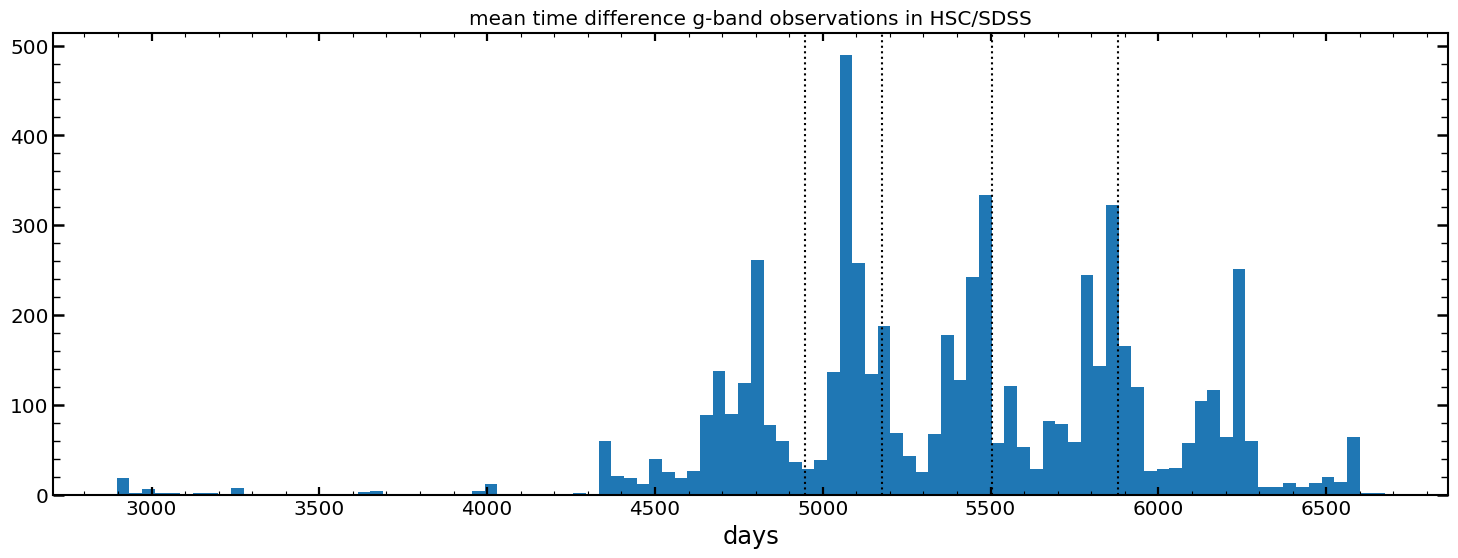

In [64]:
plt.figure(figsize=(18,6))
plt.title("mean time difference g-band observations in HSC/SDSS")
plt.hist(time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned,bins=100)
plt.xlabel('days')

plt.axvline(time_difference_quantiles[0],color='black',ls=':')
plt.axvline(time_difference_quantiles[1],color='black',ls=':')
plt.axvline(time_difference_quantiles[2],color='black',ls=':')
plt.axvline(time_difference_quantiles[3],color='black',ls=':')

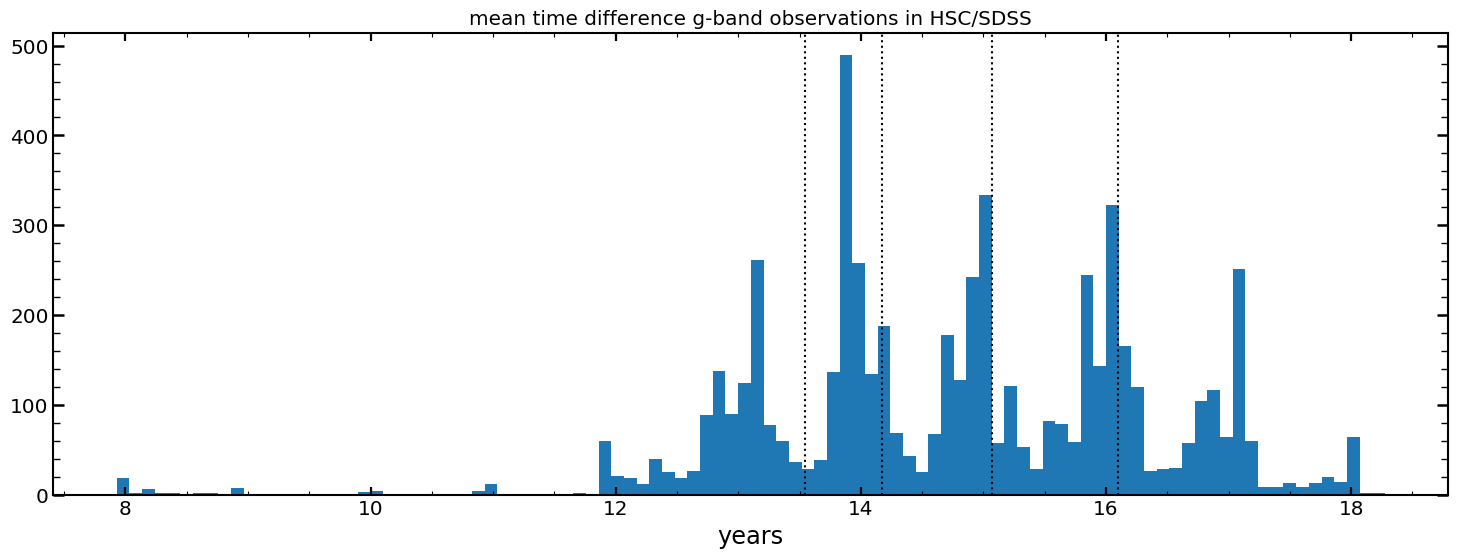

In [65]:
plt.figure(figsize=(18,6))
plt.title("mean time difference g-band observations in HSC/SDSS")
plt.hist(time_difference_between_observations_in_g_band_SDSS_mean_HSC_cleaned/365.25,bins=100)
plt.xlabel('years')

plt.axvline(time_difference_quantiles[0]/365.25,color='black',ls=':')
plt.axvline(time_difference_quantiles[1]/365.25,color='black',ls=':')
plt.axvline(time_difference_quantiles[2]/365.25,color='black',ls=':')
plt.axvline(time_difference_quantiles[3]/365.25,color='black',ls=':')

### redshift effect, separated in time first, then analysis

In [ ]:
# prepare two samples

In [66]:
# shortest 20% of separations
matched_array_filtered_short_separations=matched_array_filtered[time_difference_between_observations_in_g_band_SDSS_mean_HSC<time_difference_quantiles[0]]
# longest 20% of separations
matched_array_filtered_long_separations=matched_array_filtered[time_difference_between_observations_in_g_band_SDSS_mean_HSC>time_difference_quantiles[-1]]

In [67]:
# g-band
res_delta_redshift_via_redshift_short_separations_array,res_delta_redshift_via_redshift_median_short_separations_array,\
res_delta_redshift_via_redshift_err_short_separations_array,res_delta_redshift_via_redshift_median_err_short_separations_array,\
res_redshift_short_separations_array,p20_short_separations_array,p20_median_short_separations_array,median_mag_value_short_separations_array=\
create_redshift_result(matched_array_filtered_short_separations,100,sdss_band_column=4,difference_sdss_HSC_columns=14,return_median_mag_values=True)

res_delta_redshift_via_redshift_long_separations_array,res_delta_redshift_via_redshift_median_long_separations_array,\
res_delta_redshift_via_redshift_err_long_separations_array,res_delta_redshift_via_redshift_median_err_long_separations_array,\
res_redshift_long_separations_array,p20_long_separations_array,p20_median_long_separations_array,median_mag_value_long_separations_array=\
create_redshift_result(matched_array_filtered_long_separations,100,sdss_band_column=4,difference_sdss_HSC_columns=14,return_median_mag_values=True)

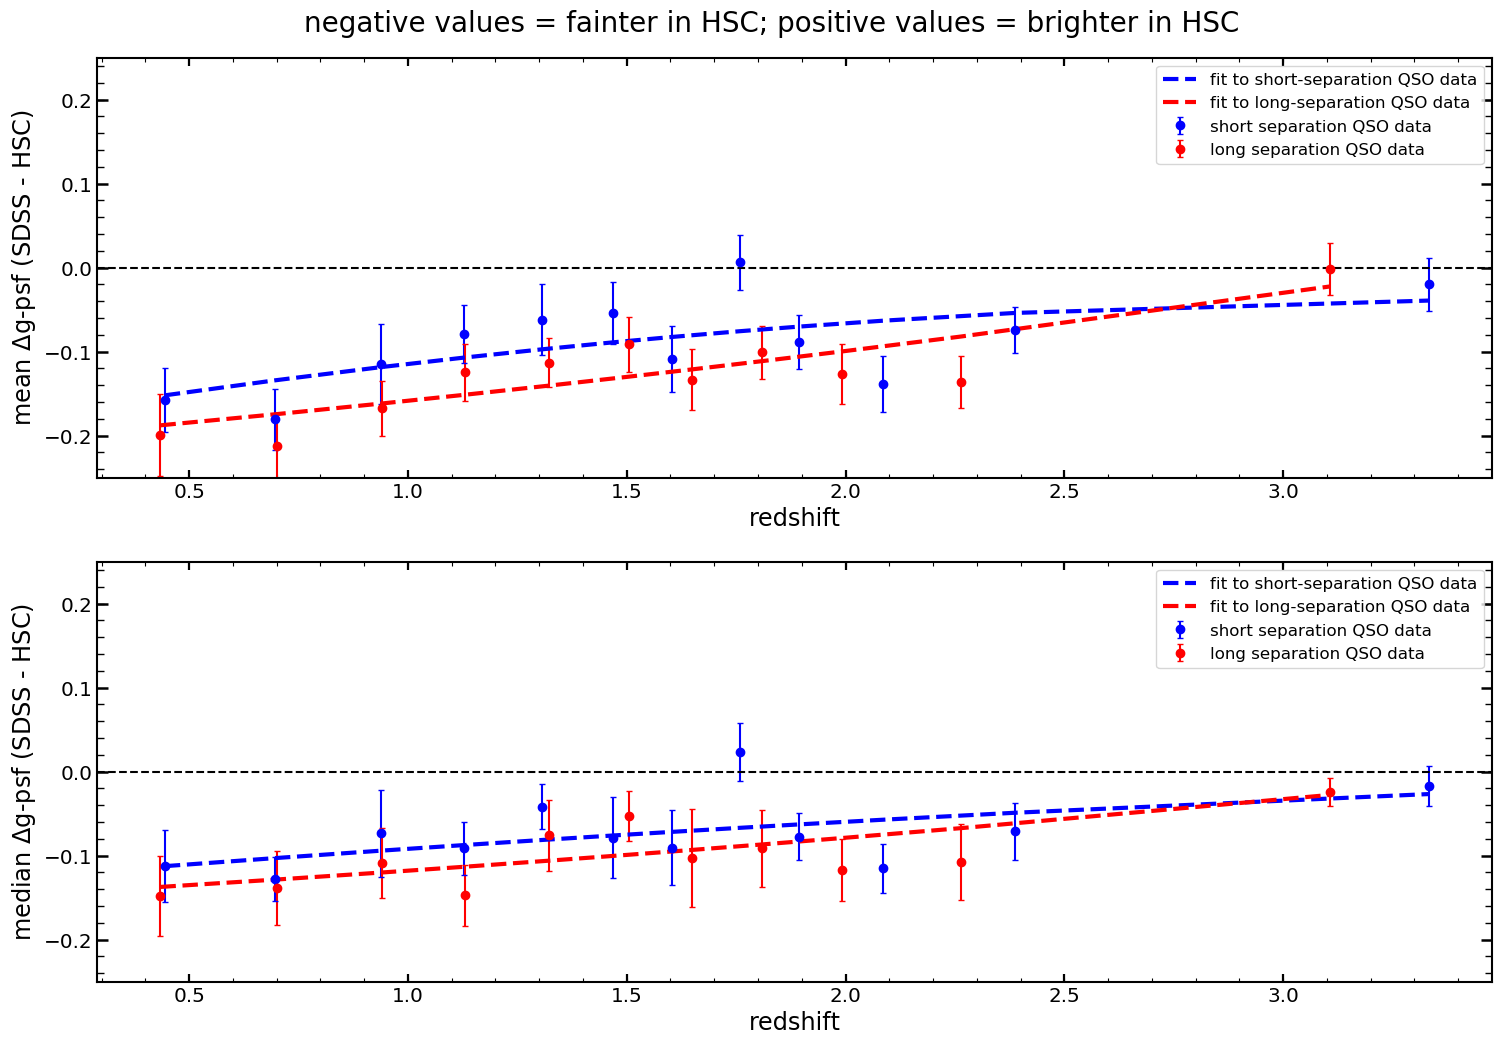

In [68]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)

plt.subplot(211)
plt.errorbar(res_redshift_short_separations_array[0],res_delta_redshift_via_redshift_short_separations_array[0],
             yerr=res_delta_redshift_via_redshift_err_short_separations_array[0],marker='o',capsize=2,ls='',color='blue',label='short separation QSO data')
plt.plot(res_redshift_short_separations_array[0],p20_short_separations_array[0](res_redshift_short_separations_array[0]),ls='--',color='blue',lw=3,label='fit to short-separation QSO data')

plt.errorbar(res_redshift_long_separations_array[0],res_delta_redshift_via_redshift_long_separations_array[0],
             yerr=res_delta_redshift_via_redshift_err_long_separations_array[0],marker='o',capsize=2,ls='',color='red',label='long separation QSO data')
plt.plot(res_redshift_long_separations_array[0],p20_long_separations_array[0](res_redshift_long_separations_array[0]),ls='--',color='red',lw=3,label='fit to long-separation QSO data')

# brightest
#plt.plot(res_redshift_array[1],p20_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
#plt.plot(res_redshift_array[2],p20_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
#plt.plot(res_redshift_array[3],p20_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
#plt.plot(res_redshift_array[4],p20_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
#plt.plot(res_redshift_array[5],p20_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')


plt.ylabel('mean $\Delta$g-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

plt.subplot(212)
plt.errorbar(res_redshift_short_separations_array[0],res_delta_redshift_via_redshift_median_short_separations_array[0],
             yerr=res_delta_redshift_via_redshift_median_err_short_separations_array[0],marker='o',capsize=2,ls='',color='blue',label='short separation QSO data')
plt.plot(res_redshift_short_separations_array[0],p20_median_short_separations_array[0](res_redshift_short_separations_array[0]),ls='--',color='blue',lw=3,label='fit to short-separation QSO data')

plt.errorbar(res_redshift_long_separations_array[0],res_delta_redshift_via_redshift_median_long_separations_array[0],
             yerr=res_delta_redshift_via_redshift_median_err_long_separations_array[0],marker='o',capsize=2,ls='',color='red',label='long separation QSO data')
plt.plot(res_redshift_long_separations_array[0],p20_median_long_separations_array[0](res_redshift_long_separations_array[0]),ls='--',color='red',lw=3,label='fit to long-separation QSO data')


#plt.plot(res_redshift_array[1],p20_median_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
#plt.plot(res_redshift_array[2],p20_median_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
#plt.plot(res_redshift_array[3],p20_median_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
#plt.plot(res_redshift_array[4],p20_median_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
#plt.plot(res_redshift_array[5],p20_median_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')

plt.ylabel('median $\Delta$g-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

NameError: name 'median_mag_values_array' is not defined

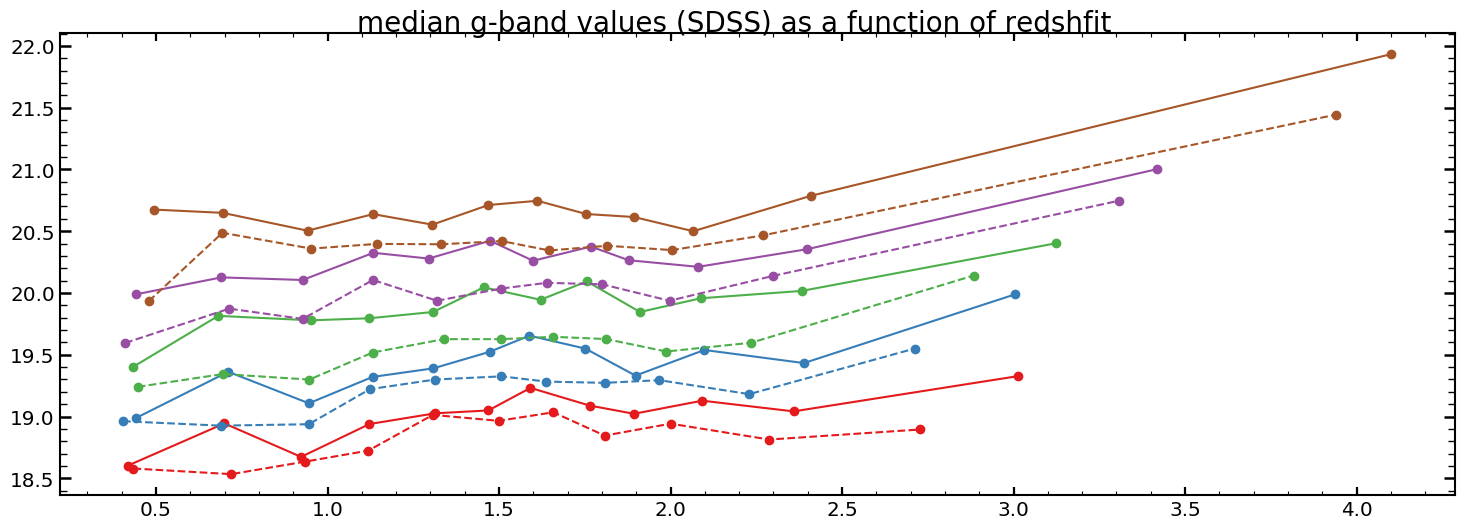

In [69]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.suptitle('median g-band values (SDSS) as a function of redshfit',y=0.92,fontsize=20)


plt.plot(res_redshift_short_separations_array[1],median_mag_value_short_separations_array[1],ls='-',color='#e41a1c',alpha=1,label='top 20% QSO data, short separations',marker='o')
plt.plot(res_redshift_short_separations_array[2],median_mag_value_short_separations_array[2],ls='-',color='#377eb8',alpha=1,label='20%-40% QSO data, short separations',marker='o')
plt.plot(res_redshift_short_separations_array[3],median_mag_value_short_separations_array[3],ls='-',color='#4daf4a',alpha=1,label='40%-60% QSO data, short separations',marker='o')
plt.plot(res_redshift_short_separations_array[4],median_mag_value_short_separations_array[4],ls='-',color='#984ea3',alpha=1,label='60%-80% QSO data, short separations',marker='o')
plt.plot(res_redshift_short_separations_array[5],median_mag_value_short_separations_array[5],ls='-',color='#a65628',alpha=1,label='80%-100% QSO data, short separations',marker='o')

plt.plot(res_redshift_long_separations_array[1],median_mag_value_long_separations_array[1],ls='--',color='#e41a1c',alpha=1,label='top 20% QSO data, long separations',marker='o')
plt.plot(res_redshift_long_separations_array[2],median_mag_value_long_separations_array[2],ls='--',color='#377eb8',alpha=1,label='20%-40% QSO data, long separations',marker='o')
plt.plot(res_redshift_long_separations_array[3],median_mag_value_long_separations_array[3],ls='--',color='#4daf4a',alpha=1,label='40%-60% QSO data, long separations',marker='o')
plt.plot(res_redshift_long_separations_array[4],median_mag_value_long_separations_array[4],ls='--',color='#984ea3',alpha=1,label='60%-80% QSO data, long separations',marker='o')
plt.plot(res_redshift_long_separations_array[5],median_mag_value_long_separations_array[5],ls='--',color='#a65628',alpha=1,label='80%-100% QSO data, long separations',marker='o')

plt.plot(res_redshift_array[1],median_mag_values_array[1],ls='-',color='#e41a1c',alpha=0.5,label='top 20% QSO data',marker='o')
plt.plot(res_redshift_array[2],median_mag_values_array[2],ls='-',color='#377eb8',alpha=0.5,label='20%-40% QSO data',marker='o')
plt.plot(res_redshift_array[3],median_mag_values_array[3],ls='-',color='#4daf4a',alpha=0.5,label='40%-60% QSO data',marker='o')
plt.plot(res_redshift_array[4],median_mag_values_array[4],ls='-',color='#984ea3',alpha=0.5,label='60%-80% QSO data',marker='o')
plt.plot(res_redshift_array[5],median_mag_values_array[5],ls='-',color='#a65628',alpha=0.5,label='80%-100% QSO data',marker='o')

plt.ylabel('median g-band magnitude')
plt.xlabel('redshift')
plt.ylim(18.2,21.2)
#plt.axhline(0,color='black',ls='--')
plt.legend()

### redshift effect, analysis, in each bin separated in time

#### g-band

In [70]:
res_redshift_all_short_long=create_redshift_result(matched_array_filtered,250,sdss_band_column=4,difference_sdss_HSC_columns=14,\
                                                   return_median_mag_values=True,separate_in_time_dif=True,time_dif_array=time_difference_between_observations_in_g_band_SDSS_mean_HSC)

In [71]:
# g-band
res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,res_delta_redshift_via_redshift_err_array,res_delta_redshift_via_redshift_median_err_array,\
res_redshift_array,p20_array,p20_median_array,median_mag_values_array=res_redshift_all_short_long[0]

res_delta_redshift_via_redshift_short_separations_array,res_delta_redshift_via_redshift_median_short_separations_array,\
res_delta_redshift_via_redshift_err_short_separations_array,res_delta_redshift_via_redshift_median_err_short_separations_array,\
res_redshift_short_separations_array,p20_short_separations_array,p20_median_short_separations_array,median_mag_value_short_separations_array=\
res_redshift_all_short_long[1]

res_delta_redshift_via_redshift_long_separations_array,res_delta_redshift_via_redshift_median_long_separations_array,\
res_delta_redshift_via_redshift_err_long_separations_array,res_delta_redshift_via_redshift_median_err_long_separations_array,\
res_redshift_long_separations_array,p20_long_separations_array,p20_median_long_separations_array,median_mag_value_long_separations_array=\
res_redshift_all_short_long[2]

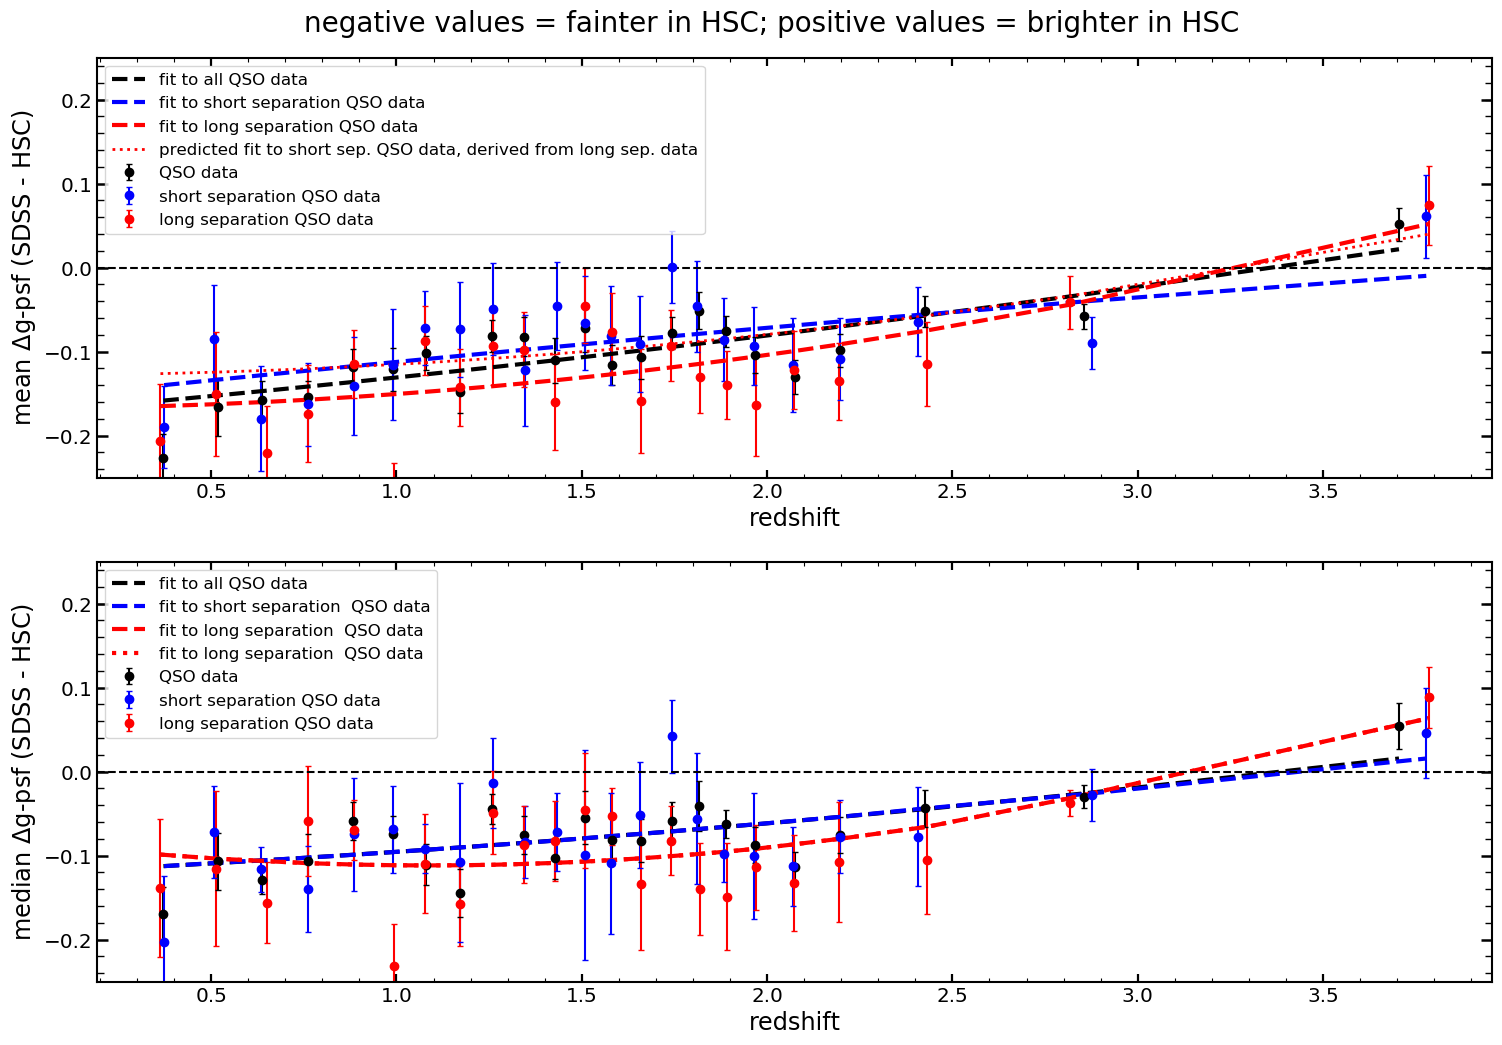

In [72]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)

plt.subplot(211)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_array[0],yerr=res_delta_redshift_via_redshift_err_array[0],marker='o',capsize=2,ls='',color='black',label='QSO data')
plt.plot(res_redshift_array[0],p20_array[0](res_redshift_array[0]),ls='--',color='black',lw=3,label='fit to all QSO data')

plt.errorbar(res_redshift_short_separations_array[0],res_delta_redshift_via_redshift_short_separations_array[0],
             yerr=res_delta_redshift_via_redshift_err_short_separations_array[0],marker='o',capsize=2,ls='',color='blue',label='short separation QSO data')
plt.plot(res_redshift_short_separations_array[0],p20_short_separations_array[0](res_redshift_short_separations_array[0]),ls='--',color='blue',lw=3,label='fit to short separation QSO data')
plt.errorbar(res_redshift_long_separations_array[0],res_delta_redshift_via_redshift_long_separations_array[0],
             yerr=res_delta_redshift_via_redshift_err_long_separations_array[0],marker='o',capsize=2,ls='',color='red',label='long separation QSO data')
plt.plot(res_redshift_long_separations_array[0],p20_long_separations_array[0](res_redshift_long_separations_array[0]),ls='--',color='red',lw=3,label='fit to long separation QSO data')

plt.plot(res_redshift_long_separations_array[0],(0.1293/0.1689)*p20_long_separations_array[0](res_redshift_long_separations_array[0]),ls=':',
         color='red',lw=2,label='predicted fit to short sep. QSO data, derived from long sep. data')
# brightest
#plt.plot(res_redshift_array[1],p20_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
#plt.plot(res_redshift_array[2],p20_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
#plt.plot(res_redshift_array[3],p20_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
#plt.plot(res_redshift_array[4],p20_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
#plt.plot(res_redshift_array[5],p20_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')


plt.ylabel('mean $\Delta$g-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

plt.subplot(212)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_median_array[0],yerr=res_delta_redshift_via_redshift_median_err_array[0],marker='o',capsize=2,ls='',color='black',label='QSO data')

plt.errorbar(res_redshift_short_separations_array[0],res_delta_redshift_via_redshift_median_short_separations_array[0],
             yerr=res_delta_redshift_via_redshift_median_err_short_separations_array[0],marker='o',capsize=2,ls='',color='blue',label='short separation QSO data')
plt.errorbar(res_redshift_long_separations_array[0],res_delta_redshift_via_redshift_median_long_separations_array[0],
             yerr=res_delta_redshift_via_redshift_median_err_long_separations_array[0],marker='o',capsize=2,ls='',color='red',label='long separation QSO data')


plt.plot(res_redshift_array[0],p20_median_short_separations_array[0](res_redshift_array[0]),ls='--',color='black',lw=3,label='fit to all QSO data')
plt.plot(res_redshift_short_separations_array[0],p20_median_short_separations_array[0](res_redshift_array[0]),ls='--',color='blue',lw=3,label='fit to short separation  QSO data')
plt.plot(res_redshift_long_separations_array[0],p20_median_long_separations_array[0](res_redshift_array[0]),ls='--',color='red',lw=3,label='fit to long separation  QSO data')

plt.plot(res_redshift_long_separations_array[0],p20_median_long_separations_array[0](res_redshift_array[0]),ls=':',color='red',lw=3,label='fit to long separation  QSO data')
#plt.plot(res_redshift_array[1],p20_median_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
#plt.plot(res_redshift_array[2],p20_median_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
#plt.plot(res_redshift_array[3],p20_median_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
#plt.plot(res_redshift_array[4],p20_median_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
#plt.plot(res_redshift_array[5],p20_median_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')

plt.ylabel('median $\Delta$g-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

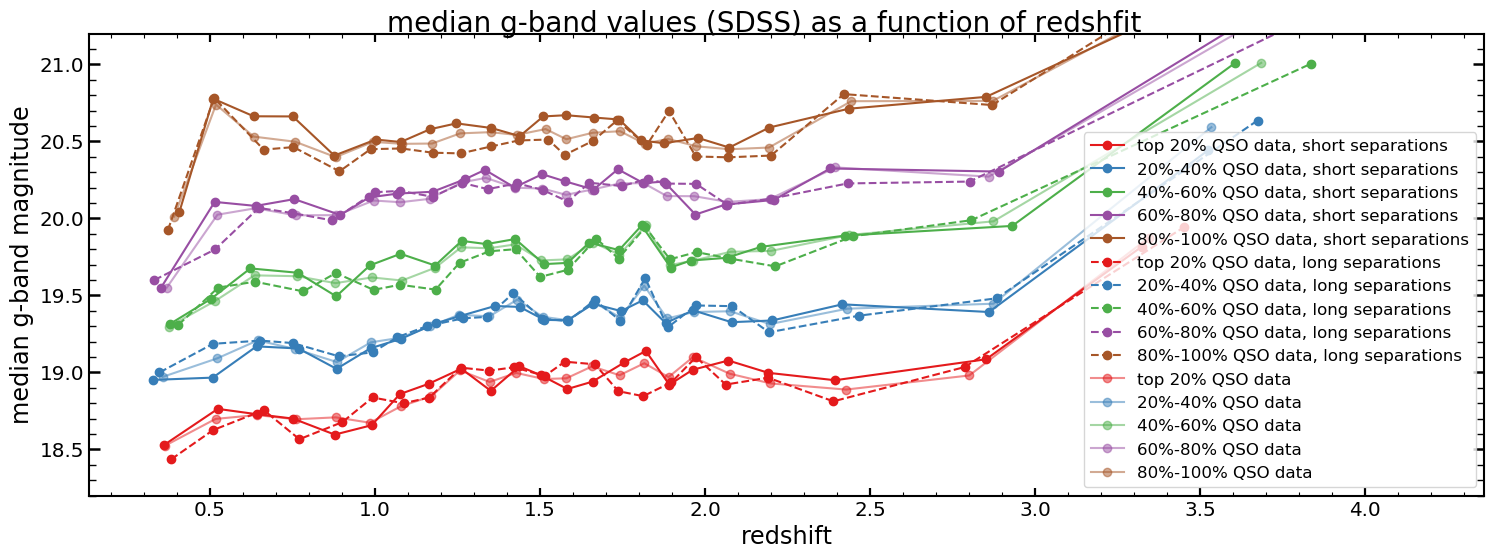

In [73]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.suptitle('median g-band values (SDSS) as a function of redshfit',y=0.92,fontsize=20)

# 
plt.plot(res_redshift_short_separations_array[1],median_mag_value_short_separations_array[1],ls='-',color='#e41a1c',alpha=1,label='top 20% QSO data, short separations',marker='o')
plt.plot(res_redshift_short_separations_array[2],median_mag_value_short_separations_array[2],ls='-',color='#377eb8',alpha=1,label='20%-40% QSO data, short separations',marker='o')
plt.plot(res_redshift_short_separations_array[3],median_mag_value_short_separations_array[3],ls='-',color='#4daf4a',alpha=1,label='40%-60% QSO data, short separations',marker='o')
plt.plot(res_redshift_short_separations_array[4],median_mag_value_short_separations_array[4],ls='-',color='#984ea3',alpha=1,label='60%-80% QSO data, short separations',marker='o')
plt.plot(res_redshift_short_separations_array[5],median_mag_value_short_separations_array[5],ls='-',color='#a65628',alpha=1,label='80%-100% QSO data, short separations',marker='o')

plt.plot(res_redshift_long_separations_array[1],median_mag_value_long_separations_array[1],ls='--',color='#e41a1c',alpha=1,label='top 20% QSO data, long separations',marker='o')
plt.plot(res_redshift_long_separations_array[2],median_mag_value_long_separations_array[2],ls='--',color='#377eb8',alpha=1,label='20%-40% QSO data, long separations',marker='o')
plt.plot(res_redshift_long_separations_array[3],median_mag_value_long_separations_array[3],ls='--',color='#4daf4a',alpha=1,label='40%-60% QSO data, long separations',marker='o')
plt.plot(res_redshift_long_separations_array[4],median_mag_value_long_separations_array[4],ls='--',color='#984ea3',alpha=1,label='60%-80% QSO data, long separations',marker='o')
plt.plot(res_redshift_long_separations_array[5],median_mag_value_long_separations_array[5],ls='--',color='#a65628',alpha=1,label='80%-100% QSO data, long separations',marker='o')

plt.plot(res_redshift_array[1],median_mag_values_array[1],ls='-',color='#e41a1c',alpha=0.5,label='top 20% QSO data',marker='o')
plt.plot(res_redshift_array[2],median_mag_values_array[2],ls='-',color='#377eb8',alpha=0.5,label='20%-40% QSO data',marker='o')
plt.plot(res_redshift_array[3],median_mag_values_array[3],ls='-',color='#4daf4a',alpha=0.5,label='40%-60% QSO data',marker='o')
plt.plot(res_redshift_array[4],median_mag_values_array[4],ls='-',color='#984ea3',alpha=0.5,label='60%-80% QSO data',marker='o')
plt.plot(res_redshift_array[5],median_mag_values_array[5],ls='-',color='#a65628',alpha=0.5,label='80%-100% QSO data',marker='o')

plt.ylabel('median g-band magnitude')
plt.xlabel('redshift')
plt.ylim(18.2,21.2)
#plt.axhline(0,color='black',ls='--')
plt.legend()

#### r-band

In [ ]:
res_redshift_all_short_long=create_redshift_result(matched_array_filtered,250,sdss_band_column=6,difference_sdss_HSC_columns=14,\
                                                   return_median_mag_values=True,separate_in_time_dif=True,time_dif_array=time_difference_between_observations_in_g_band_SDSS_mean_HSC)

In [ ]:
# r-band
res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,res_delta_redshift_via_redshift_err_array,res_delta_redshift_via_redshift_median_err_array,\
res_redshift_array,p20_array,p20_median_array,median_mag_values_array=res_redshift_all_short_long[0]

res_delta_redshift_via_redshift_short_separations_array,res_delta_redshift_via_redshift_median_short_separations_array,\
res_delta_redshift_via_redshift_err_short_separations_array,res_delta_redshift_via_redshift_median_err_short_separations_array,\
res_redshift_short_separations_array,p20_short_separations_array,p20_median_short_separations_array,median_mag_value_short_separations_array=\
res_redshift_all_short_long[1]

res_delta_redshift_via_redshift_long_separations_array,res_delta_redshift_via_redshift_median_long_separations_array,\
res_delta_redshift_via_redshift_err_long_separations_array,res_delta_redshift_via_redshift_median_err_long_separations_array,\
res_redshift_long_separations_array,p20_long_separations_array,p20_median_long_separations_array,median_mag_value_long_separations_array=\
res_redshift_all_short_long[2]

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)

plt.subplot(211)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_array[0],yerr=res_delta_redshift_via_redshift_err_array[0],marker='o',capsize=2,ls='',color='black',label='QSO data')
plt.plot(res_redshift_array[0],p20_array[0](res_redshift_array[0]),ls='--',color='black',lw=3,label='fit to all QSO data')

plt.errorbar(res_redshift_short_separations_array[0],res_delta_redshift_via_redshift_short_separations_array[0],
             yerr=res_delta_redshift_via_redshift_err_short_separations_array[0],marker='o',capsize=2,ls='',color='blue',label='short separation QSO data')
plt.plot(res_redshift_short_separations_array[0],p20_short_separations_array[0](res_redshift_short_separations_array[0]),ls='--',color='blue',lw=3,label='fit to short separation QSO data')
plt.errorbar(res_redshift_long_separations_array[0],res_delta_redshift_via_redshift_long_separations_array[0],
             yerr=res_delta_redshift_via_redshift_err_long_separations_array[0],marker='o',capsize=2,ls='',color='red',label='long separation QSO data')
plt.plot(res_redshift_long_separations_array[0],p20_long_separations_array[0](res_redshift_long_separations_array[0]),ls='--',color='red',lw=3,label='fit to long separation QSO data')

plt.plot(res_redshift_long_separations_array[0],(0.1293/0.1689)*p20_long_separations_array[0](res_redshift_long_separations_array[0]),ls=':',
         color='red',lw=2,label='predicted fit to short sep. QSO data, derived from long sep. data')
# brightest
#plt.plot(res_redshift_array[1],p20_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
#plt.plot(res_redshift_array[2],p20_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
#plt.plot(res_redshift_array[3],p20_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
#plt.plot(res_redshift_array[4],p20_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
#plt.plot(res_redshift_array[5],p20_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')


plt.ylabel('mean $\Delta$r-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

plt.subplot(212)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_median_array[0],yerr=res_delta_redshift_via_redshift_median_err_array[0],marker='o',capsize=2,ls='',color='black',label='QSO data')

plt.errorbar(res_redshift_short_separations_array[0],res_delta_redshift_via_redshift_median_short_separations_array[0],
             yerr=res_delta_redshift_via_redshift_median_err_short_separations_array[0],marker='o',capsize=2,ls='',color='blue',label='short separation QSO data')
plt.errorbar(res_redshift_long_separations_array[0],res_delta_redshift_via_redshift_median_long_separations_array[0],
             yerr=res_delta_redshift_via_redshift_median_err_long_separations_array[0],marker='o',capsize=2,ls='',color='red',label='long separation QSO data')


plt.plot(res_redshift_array[0],p20_median_short_separations_array[0](res_redshift_array[0]),ls='--',color='black',lw=3,label='fit to all QSO data')
plt.plot(res_redshift_short_separations_array[0],p20_median_short_separations_array[0](res_redshift_array[0]),ls='--',color='blue',lw=3,label='fit to short separation  QSO data')
plt.plot(res_redshift_long_separations_array[0],p20_median_long_separations_array[0](res_redshift_array[0]),ls='--',color='red',lw=3,label='fit to long separation  QSO data')

plt.plot(res_redshift_long_separations_array[0],p20_median_long_separations_array[0](res_redshift_array[0]),ls=':',color='red',lw=3,label='fit to long separation  QSO data')
#plt.plot(res_redshift_array[1],p20_median_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
#plt.plot(res_redshift_array[2],p20_median_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
#plt.plot(res_redshift_array[3],p20_median_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
#plt.plot(res_redshift_array[4],p20_median_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
#plt.plot(res_redshift_array[5],p20_median_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')

plt.ylabel('median $\Delta$r-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.suptitle('median r-band values (SDSS) as a function of redshfit',y=0.92,fontsize=20)

# 
plt.plot(res_redshift_short_separations_array[1],median_mag_value_short_separations_array[1],ls='-',color='#e41a1c',alpha=1,label='top 20% QSO data, short separations',marker='o')
plt.plot(res_redshift_short_separations_array[2],median_mag_value_short_separations_array[2],ls='-',color='#377eb8',alpha=1,label='20%-40% QSO data, short separations',marker='o')
plt.plot(res_redshift_short_separations_array[3],median_mag_value_short_separations_array[3],ls='-',color='#4daf4a',alpha=1,label='40%-60% QSO data, short separations',marker='o')
plt.plot(res_redshift_short_separations_array[4],median_mag_value_short_separations_array[4],ls='-',color='#984ea3',alpha=1,label='60%-80% QSO data, short separations',marker='o')
plt.plot(res_redshift_short_separations_array[5],median_mag_value_short_separations_array[5],ls='-',color='#a65628',alpha=1,label='80%-100% QSO data, short separations',marker='o')

plt.plot(res_redshift_long_separations_array[1],median_mag_value_long_separations_array[1],ls='--',color='#e41a1c',alpha=1,label='top 20% QSO data, long separations',marker='o')
plt.plot(res_redshift_long_separations_array[2],median_mag_value_long_separations_array[2],ls='--',color='#377eb8',alpha=1,label='20%-40% QSO data, long separations',marker='o')
plt.plot(res_redshift_long_separations_array[3],median_mag_value_long_separations_array[3],ls='--',color='#4daf4a',alpha=1,label='40%-60% QSO data, long separations',marker='o')
plt.plot(res_redshift_long_separations_array[4],median_mag_value_long_separations_array[4],ls='--',color='#984ea3',alpha=1,label='60%-80% QSO data, long separations',marker='o')
plt.plot(res_redshift_long_separations_array[5],median_mag_value_long_separations_array[5],ls='--',color='#a65628',alpha=1,label='80%-100% QSO data, long separations',marker='o')

plt.plot(res_redshift_array[1],median_mag_values_array[1],ls='-',color='#e41a1c',alpha=0.5,label='top 20% QSO data',marker='o')
plt.plot(res_redshift_array[2],median_mag_values_array[2],ls='-',color='#377eb8',alpha=0.5,label='20%-40% QSO data',marker='o')
plt.plot(res_redshift_array[3],median_mag_values_array[3],ls='-',color='#4daf4a',alpha=0.5,label='40%-60% QSO data',marker='o')
plt.plot(res_redshift_array[4],median_mag_values_array[4],ls='-',color='#984ea3',alpha=0.5,label='60%-80% QSO data',marker='o')
plt.plot(res_redshift_array[5],median_mag_values_array[5],ls='-',color='#a65628',alpha=0.5,label='80%-100% QSO data',marker='o')

plt.ylabel('median r-band magnitude')
plt.xlabel('redshift')
plt.ylim(18.2,21.2)
#plt.axhline(0,color='black',ls='--')
plt.legend()

#### i-band

In [ ]:
res_redshift_all_short_long=create_redshift_result(matched_array_filtered,250,sdss_band_column=8,difference_sdss_HSC_columns=14,\
                                                   return_median_mag_values=True,separate_in_time_dif=True,time_dif_array=time_difference_between_observations_in_g_band_SDSS_mean_HSC)

In [ ]:
# i-band
res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,res_delta_redshift_via_redshift_err_array,res_delta_redshift_via_redshift_median_err_array,\
res_redshift_array,p20_array,p20_median_array,median_mag_values_array=res_redshift_all_short_long[0]

res_delta_redshift_via_redshift_short_separations_array,res_delta_redshift_via_redshift_median_short_separations_array,\
res_delta_redshift_via_redshift_err_short_separations_array,res_delta_redshift_via_redshift_median_err_short_separations_array,\
res_redshift_short_separations_array,p20_short_separations_array,p20_median_short_separations_array,median_mag_value_short_separations_array=\
res_redshift_all_short_long[1]

res_delta_redshift_via_redshift_long_separations_array,res_delta_redshift_via_redshift_median_long_separations_array,\
res_delta_redshift_via_redshift_err_long_separations_array,res_delta_redshift_via_redshift_median_err_long_separations_array,\
res_redshift_long_separations_array,p20_long_separations_array,p20_median_long_separations_array,median_mag_value_long_separations_array=\
res_redshift_all_short_long[2]

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)

plt.subplot(211)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_array[0],yerr=res_delta_redshift_via_redshift_err_array[0],marker='o',capsize=2,ls='',color='black',label='QSO data')
plt.plot(res_redshift_array[0],p20_array[0](res_redshift_array[0]),ls='--',color='black',lw=3,label='fit to all QSO data')

plt.errorbar(res_redshift_short_separations_array[0],res_delta_redshift_via_redshift_short_separations_array[0],
             yerr=res_delta_redshift_via_redshift_err_short_separations_array[0],marker='o',capsize=2,ls='',color='blue',label='short separation QSO data')
plt.plot(res_redshift_short_separations_array[0],p20_short_separations_array[0](res_redshift_short_separations_array[0]),ls='--',color='blue',lw=3,label='fit to short separation QSO data')
plt.errorbar(res_redshift_long_separations_array[0],res_delta_redshift_via_redshift_long_separations_array[0],
             yerr=res_delta_redshift_via_redshift_err_long_separations_array[0],marker='o',capsize=2,ls='',color='red',label='long separation QSO data')
plt.plot(res_redshift_long_separations_array[0],p20_long_separations_array[0](res_redshift_long_separations_array[0]),ls='--',color='red',lw=3,label='fit to long separation QSO data')

plt.plot(res_redshift_long_separations_array[0],(0.1293/0.1689)*p20_long_separations_array[0](res_redshift_long_separations_array[0]),ls=':',
         color='red',lw=2,label='predicted fit to short sep. QSO data, derived from long sep. data')
# brightest
#plt.plot(res_redshift_array[1],p20_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
#plt.plot(res_redshift_array[2],p20_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
#plt.plot(res_redshift_array[3],p20_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
#plt.plot(res_redshift_array[4],p20_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
#plt.plot(res_redshift_array[5],p20_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')


plt.ylabel('mean $\Delta$i-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

plt.subplot(212)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_median_array[0],yerr=res_delta_redshift_via_redshift_median_err_array[0],marker='o',capsize=2,ls='',color='black',label='QSO data')

plt.errorbar(res_redshift_short_separations_array[0],res_delta_redshift_via_redshift_median_short_separations_array[0],
             yerr=res_delta_redshift_via_redshift_median_err_short_separations_array[0],marker='o',capsize=2,ls='',color='blue',label='short separation QSO data')
plt.errorbar(res_redshift_long_separations_array[0],res_delta_redshift_via_redshift_median_long_separations_array[0],
             yerr=res_delta_redshift_via_redshift_median_err_long_separations_array[0],marker='o',capsize=2,ls='',color='red',label='long separation QSO data')


plt.plot(res_redshift_array[0],p20_median_short_separations_array[0](res_redshift_array[0]),ls='--',color='black',lw=3,label='fit to all QSO data')
plt.plot(res_redshift_short_separations_array[0],p20_median_short_separations_array[0](res_redshift_array[0]),ls='--',color='blue',lw=3,label='fit to short separation  QSO data')
plt.plot(res_redshift_long_separations_array[0],p20_median_long_separations_array[0](res_redshift_array[0]),ls='--',color='red',lw=3,label='fit to long separation  QSO data')

plt.plot(res_redshift_long_separations_array[0],p20_median_long_separations_array[0](res_redshift_array[0]),ls=':',color='red',lw=3,label='fit to long separation  QSO data')
#plt.plot(res_redshift_array[1],p20_median_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
#plt.plot(res_redshift_array[2],p20_median_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
#plt.plot(res_redshift_array[3],p20_median_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
#plt.plot(res_redshift_array[4],p20_median_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
#plt.plot(res_redshift_array[5],p20_median_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')

plt.ylabel('median $\Delta$i-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.suptitle('median i-band values (SDSS) as a function of redshfit',y=0.92,fontsize=20)

# 
plt.plot(res_redshift_short_separations_array[1],median_mag_value_short_separations_array[1],ls='-',color='#e41a1c',alpha=1,label='top 20% QSO data, short separations',marker='o')
plt.plot(res_redshift_short_separations_array[2],median_mag_value_short_separations_array[2],ls='-',color='#377eb8',alpha=1,label='20%-40% QSO data, short separations',marker='o')
plt.plot(res_redshift_short_separations_array[3],median_mag_value_short_separations_array[3],ls='-',color='#4daf4a',alpha=1,label='40%-60% QSO data, short separations',marker='o')
plt.plot(res_redshift_short_separations_array[4],median_mag_value_short_separations_array[4],ls='-',color='#984ea3',alpha=1,label='60%-80% QSO data, short separations',marker='o')
plt.plot(res_redshift_short_separations_array[5],median_mag_value_short_separations_array[5],ls='-',color='#a65628',alpha=1,label='80%-100% QSO data, short separations',marker='o')

plt.plot(res_redshift_long_separations_array[1],median_mag_value_long_separations_array[1],ls='--',color='#e41a1c',alpha=1,label='top 20% QSO data, long separations',marker='o')
plt.plot(res_redshift_long_separations_array[2],median_mag_value_long_separations_array[2],ls='--',color='#377eb8',alpha=1,label='20%-40% QSO data, long separations',marker='o')
plt.plot(res_redshift_long_separations_array[3],median_mag_value_long_separations_array[3],ls='--',color='#4daf4a',alpha=1,label='40%-60% QSO data, long separations',marker='o')
plt.plot(res_redshift_long_separations_array[4],median_mag_value_long_separations_array[4],ls='--',color='#984ea3',alpha=1,label='60%-80% QSO data, long separations',marker='o')
plt.plot(res_redshift_long_separations_array[5],median_mag_value_long_separations_array[5],ls='--',color='#a65628',alpha=1,label='80%-100% QSO data, long separations',marker='o')

plt.plot(res_redshift_array[1],median_mag_values_array[1],ls='-',color='#e41a1c',alpha=0.5,label='top 20% QSO data',marker='o')
plt.plot(res_redshift_array[2],median_mag_values_array[2],ls='-',color='#377eb8',alpha=0.5,label='20%-40% QSO data',marker='o')
plt.plot(res_redshift_array[3],median_mag_values_array[3],ls='-',color='#4daf4a',alpha=0.5,label='40%-60% QSO data',marker='o')
plt.plot(res_redshift_array[4],median_mag_values_array[4],ls='-',color='#984ea3',alpha=0.5,label='60%-80% QSO data',marker='o')
plt.plot(res_redshift_array[5],median_mag_values_array[5],ls='-',color='#a65628',alpha=0.5,label='80%-100% QSO data',marker='o')

plt.ylabel('median i-band magnitude')
plt.xlabel('redshift')
plt.ylim(18.2,21.2)
#plt.axhline(0,color='black',ls='--')
plt.legend()

# HSC, Stripe82 stars

## Preparation of the Stripe82 selection of stars 

In [11]:
from notebook.services.config import ConfigManager
cm = ConfigManager().update('cell', {'limit_output': 10})

# This is dr7 qso catalog from https://classic.sdss.org/dr7/products/value_added/qsocat_dr7.html
dr7 = pd.read_csv(DATA_DIRECTORY+'dr7qso.dat',skiprows=80,sep='\s+',engine='python', error_bad_lines=False, warn_bad_lines=False, header=None )
Positions_of_dr7=np.transpose([dr7[1].values,dr7[2].values])
Positions_of_dr7_with_ID=np.transpose([dr7[0].values,dr7[1].values,dr7[2].values])

In [46]:
# Stripe 82 stars selection
Stripe82stars= pd.read_csv('/Users/nevencaplar/Downloads/stripe82calibStars_v2.6.dat',skiprows=41,sep='\s+',engine='python', error_bad_lines=False, header=None )
# selection for only several columns
# ra, dec, g, err_g, r, err_r, i, err_i
Stripe82stars_likedr7=np.array(Stripe82stars.iloc[:,[1,2,15,16,21,22,27,28]])
# note that the columns are NOT exectly like dr7
Stripe82stars_likedr7=Stripe82stars_likedr7.view(np.float64)
print(len(Stripe82stars_likedr7))
# further selection, because HSC did not cover entire Stripe82
Stripe82stars_likedr7=np.concatenate((Stripe82stars_likedr7[((Stripe82stars_likedr7[:,0]>0) & (Stripe82stars_likedr7[:,0]<3))],\
                                      Stripe82stars_likedr7[((Stripe82stars_likedr7[:,0]>15) & (Stripe82stars_likedr7[:,0]<23.5) & (Stripe82stars_likedr7[:,1]>-1.1))],\
                                      Stripe82stars_likedr7[((Stripe82stars_likedr7[:,0]>28) & (Stripe82stars_likedr7[:,0]<37)& (Stripe82stars_likedr7[:,1]<-0.8))],\
                                      Stripe82stars_likedr7[Stripe82stars_likedr7[:,0]>330]))
#Stripe82stars_likedr7=Stripe82stars_likedr7[(Stripe82stars_likedr7[:,3]<0.015)&(Stripe82stars_likedr7[:,5]<0.015)&(Stripe82stars_likedr7[:,7]<0.015)]

print(len(Stripe82stars_likedr7))

1006849
308630


### Cleaning with Million QSO catalog

In [60]:
# This is Million qso catalog from https://heasarc.gsfc.nasa.gov/W3Browse/galaxy-catalog/milliquas.html
mil_qso = pd.read_csv('/Users/nevencaplar/Downloads/BrowseTargets.8558.1569111088',skiprows=4,sep='|',engine='python', error_bad_lines=False, warn_bad_lines=False, header=None )

In [61]:
mil_qso

0                          1            2            3      4      5  \
0      NaN  name                       ra           dec          bmag   rmag    
1      NaN  SDSS J154109.40-012959.6   15 41 09.40  -01 29 59.7  21.05  20.91   
2      NaN  WISEA J042238.41-012959.6  04 22 38.41  -01 29 59.7  20.71  17.75   
3      NaN  SDSS J214304.69-012959.5   21 43 04.69  -01 29 59.5  22.03  21.69   
4      NaN  2QZ J141107.4-013000       14 11 07.52  -01 29 59.5  20.39  19.70   
...     ..                        ...          ...          ...    ...    ...   
124994 NaN  SDSS J143721.59+012959.5   14 37 21.60  +01 29 59.5  21.00  20.71   
124995 NaN  SDSS J011621.49+012959.5   01 16 21.50  +01 29 59.5  20.48  20.05   
124996 NaN  SDSS J025025.04+012959.6   02 50 25.05  +01 29 59.7  24.95  21.19   
124997 NaN  SDSS J215906.24+012959.6   21 59 06.25  +01 29 59.7  21.53  20.77   
124998 NaN  SDSS J141946.81+012959.7   14 19 46.81  +01 29 59.7  20.55  20.25   

               6                       7                       8   9  
0       redshift  radio_name              xray_name              NaN  
1          2.200                                                 NaN  
2          2.300                                                 NaN  
3          0.000                                                 NaN  
4          0.990                                                 NaN  
...          ...                     ...                     ...  ..  
124994     0.700                                                 NaN  
124995     1.843                                                 NaN  
124996     4.380                                                 NaN  
124997     0.200                                                 NaN  
124998     0.400                                                 NaN  

[124999 rows x 10 columns]

In [64]:
Positions_of_mil_qso=np.transpose([mil_qso[2].values,mil_qso[3].values])

In [73]:
Positions_of_mil_qso[1][0]+' '+Positions_of_mil_qso[1][1]

'15 41 09.40 -01 29 59.7'

In [89]:
>>> from astropy import units as u
>>> from astropy.coordinates import SkyCoord

Positions_of_mil_qso_in_deg=[]
for i in tqdm(range(1,len(Positions_of_mil_qso))):
    c = SkyCoord(Positions_of_mil_qso[i][0]+' '+Positions_of_mil_qso[i][1], unit=(u.hourangle, u.deg))
    coordinate_in_deg_str=str.split(c.to_string())
    coordinate_in_deg=[float(coordinate_in_deg_str[0]),float(coordinate_in_deg_str[1])]
    Positions_of_mil_qso_in_deg.append(coordinate_in_deg)
    
Positions_of_mil_qso_in_deg=np.array(Positions_of_mil_qso_in_deg)  

100%|██████████| 124998/124998 [06:04<00:00, 343.02it/s]


In [90]:
Positions_of_mil_qso_in_deg_in_Stripe82=np.concatenate((Positions_of_mil_qso_in_deg[((Positions_of_mil_qso_in_deg[:,0]>0) & (Positions_of_mil_qso_in_deg[:,0]<3))],\
                                      Positions_of_mil_qso_in_deg[((Positions_of_mil_qso_in_deg[:,0]>15) & (Positions_of_mil_qso_in_deg[:,0]<23.5) & (Positions_of_mil_qso_in_deg[:,1]>-1.1))],\
                                      Positions_of_mil_qso_in_deg[((Positions_of_mil_qso_in_deg[:,0]>28) & (Positions_of_mil_qso_in_deg[:,0]<37)& (Positions_of_mil_qso_in_deg[:,1]<-0.8))],\
                                      Positions_of_mil_qso_in_deg[Positions_of_mil_qso_in_deg[:,0]>330]))

In [92]:
len(Positions_of_mil_qso_in_deg_in_Stripe82)

25142

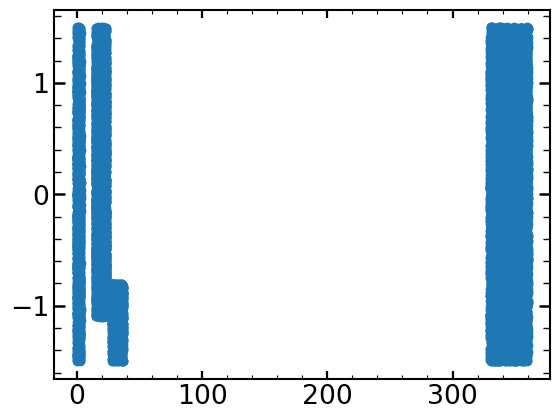

In [91]:
plt.scatter(Positions_of_mil_qso_in_deg_in_Stripe82[:,0],Positions_of_mil_qso_in_deg_in_Stripe82[:,1])

In [107]:
index_of_stars_which_are_QSO=[]
for j in tqdm(range(len(Positions_of_dr7_equatorial))):
    # find distances from the qso to the sample of nonvariable stars
    PositionOfQuasar_to_stars=(euclidean_distances([Positions_of_mil_qso_in_deg_in_Stripe82[:,[0,1]][j]],Stripe82stars_likedr7[:,[0,1]],))
    if np.min(PositionOfQuasar_to_stars)<0.001:
        index_of_stars_which_are_QSO.append(np.where(PositionOfQuasar_to_stars<0.001)[1][0])

100%|██████████| 12876/12876 [01:33<00:00, 138.19it/s]


In [110]:
len(index_of_stars_which_are_QSO)

839

In [108]:
index_for_Stripe82stars_likedr7_which_are_stars=np.setdiff1d(range(len(Stripe82stars_likedr7)),index_of_stars_which_are_QSO)

In [109]:
Stripe82stars_likedr7_filtered=Stripe82stars_likedr7[index_for_Stripe82stars_likedr7_which_are_stars]

In [111]:
len(Stripe82stars_likedr7_filtered)

307793

### Cleaning with dr7 catalog

In [178]:
Positions_of_dr7

array([[ 2.72280000e-02,  5.15341000e-01],
       [ 3.39000000e-02,  2.76301000e-01],
       [ 3.86040000e-02,  1.52984770e+01],
       ...,
       [ 3.59994688e+02,  5.62592000e-01],
       [ 3.59996092e+02, -9.16223300e+00],
       [ 3.59997675e+02,  1.44870000e-01]])

In [179]:
Positions_of_dr7_in_Stripe82=np.concatenate((Positions_of_dr7[((Positions_of_dr7[:,0]>0) & (Positions_of_dr7[:,0]<3))],\
                                      Positions_of_dr7[((Positions_of_dr7[:,0]>15) & (Positions_of_dr7[:,0]<23.5) & (Positions_of_dr7[:,1]>-1.1))],\
                                      Positions_of_dr7[((Positions_of_dr7[:,0]>28) & (Positions_of_dr7[:,0]<37)& (Positions_of_dr7[:,1]<-0.8))],\
                                      Positions_of_dr7[Positions_of_dr7[:,0]>330]))

In [180]:
len(Positions_of_dr7_in_Stripe82)

6090

In [182]:
index_of_stars_which_are_QSO_second_filtered=[]
for j in tqdm(range(len(Positions_of_dr7_in_Stripe82))):
    # find distances from the qso to the sample of nonvariable stars
    PositionOfQuasar_to_stars=(euclidean_distances([Positions_of_dr7_in_Stripe82[:,[0,1]][j]],Stripe82stars_likedr7_filtered[:,[0,1]],))
    if np.min(PositionOfQuasar_to_stars)<0.001:
        index_of_stars_which_are_QSO_second_filtered.append(np.where(PositionOfQuasar_to_stars<0.001)[1][0])


  7%|▋         | 408/6090 [00:04<00:59, 95.82it/s]
Exception in thread Thread-30:
Traceback (most recent call last):
  File "/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 6090/6090 [01:12<00:00, 83.54it/s]


In [184]:
index_for_Stripe82stars_likedr7_filtered_which_are_stars=np.setdiff1d(range(len(Stripe82stars_likedr7_filtered)),index_of_stars_which_are_QSO_second_filtered)
Stripe82stars_likedr7_double_filtered=Stripe82stars_likedr7_filtered[index_for_Stripe82stars_likedr7_filtered_which_are_stars]

### continue

In [37]:
data=np.load("/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_filtered_with_g_mag_dif_and_err.npy")
# selection for only several columns
# ra, dec,redshift, g (SDSS), err_g, r (SDSS), err_r, i (SDSS), err_i
datadr7_selection=data[:,[1,2,3,6,7,8,9,10,11]]
len(datadr7_selection)

5919

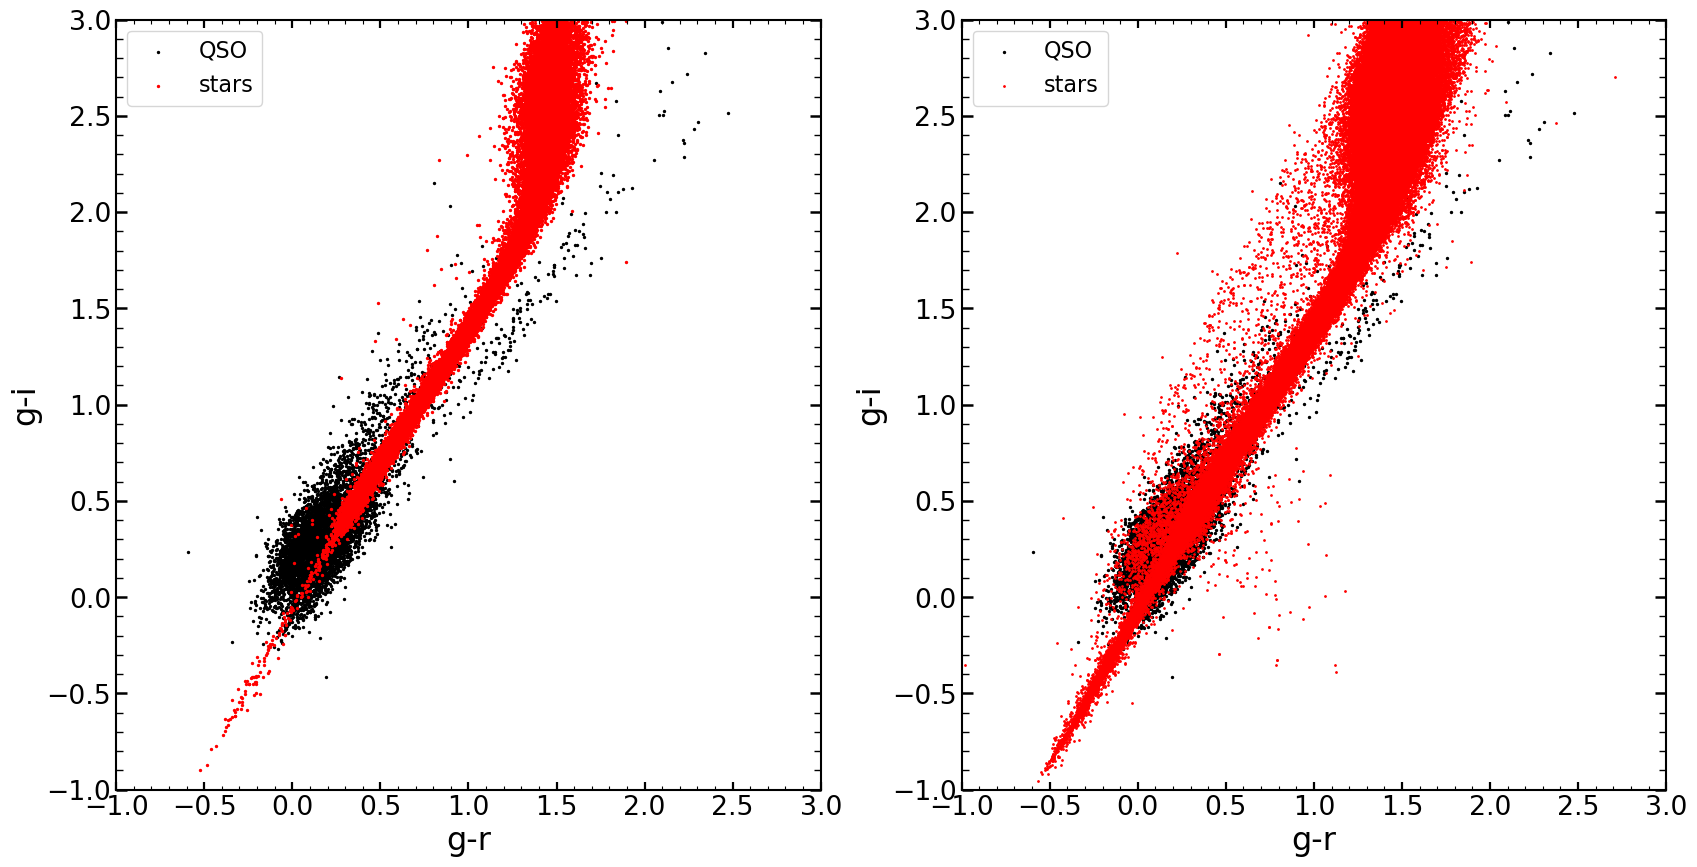

In [39]:
# the whole parameter space 
plt.figure(figsize=(20,10))

plt.subplot(121)
#plt.scatter(dr7.iloc[:,6].values-dr7.iloc[:,8].values,dr7.iloc[:,6].values-dr7.iloc[:,10].values,s=2,color='black')
plt.scatter(datadr7_selection[:,3]-datadr7_selection[:,5],datadr7_selection[:,3]-datadr7_selection[:,7],s=2,color='black',label='QSO')
plt.scatter(Stripe82stars.iloc[:,15].values[:50000]-Stripe82stars.iloc[:,21].values[:50000],Stripe82stars.iloc[:,15].values[:50000]-Stripe82stars.iloc[:,27].values[:50000],s=2,color='red',label='stars')
plt.xlabel('g-r')
plt.ylabel('g-i')
plt.xlim(-1,3)
plt.ylim(-1,3)
plt.legend()

plt.subplot(122)
#plt.scatter(dr7.iloc[:,6].values-dr7.iloc[:,8].values,dr7.iloc[:,6].values-dr7.iloc[:,10].values,s=2,color='black')
plt.scatter(datadr7_selection[:,3]-datadr7_selection[:,5],datadr7_selection[:,3]-datadr7_selection[:,7],s=2,color='black',label='QSO')
plt.scatter(Stripe82stars.iloc[:,15].values-Stripe82stars.iloc[:,21].values,Stripe82stars.iloc[:,15].values-Stripe82stars.iloc[:,27].values,s=1,color='red',label='stars')
plt.xlabel('g-r')
plt.ylabel('g-i')
plt.xlim(-1,3)
plt.ylim(-1,3)
plt.legend()

In [186]:
# takes a minute, probably should use my 'match catalogs function'

res_matching=[]
for j in tqdm(range(len(datadr7_selection))):
    # finds distance from jth objects in datadr7_selection catalogue (selection of quasars) from the calibration stars in Stripe82
    # this is in the color space!
    PositionOfQuasars_euclidean_distances=euclidean_distances([datadr7_selection[:,[3,5,7]][j]],Stripe82stars_likedr7_double_filtered[:,[2,4,6]],)
    # shortest distance
    shortest_distance=np.min(PositionOfQuasars_euclidean_distances[0])
    # element of the ``Stripe82stars_likedr7'' that has the shortest distance to the element datadr7_selection
    shortest_distance_index=np.where(PositionOfQuasars_euclidean_distances[0]==np.min(PositionOfQuasars_euclidean_distances[0]))[0][0]
    res_matching.append([shortest_distance,Stripe82stars_likedr7_double_filtered[shortest_distance_index]])
    
    
matched_array=[]    
for j in range(len(res_matching)):
    matched_array.append(res_matching[j][1])
    
matched_array_Stripe82_stars_to_dr7QSO=np.array(matched_array)

100%|██████████| 5919/5919 [01:10<00:00, 83.96it/s]


In [187]:
# takes a minute, probably should use my 'match catalogs function'

# Solution suggested by Jaime and HYRY    
def find_nth_smallest_proper_way(a, n):
    return np.partition(a, n-1)[n-1]

res_matching_v8=[]
list_of_shortest_distance_for_checking=[]
for j in tqdm(range(len(datadr7_selection))):
    # finds distance from jth objects in datadr7_selection catalogue (selection of quasars) from the calibration stars in Stripe82
    # this is in the color space!
    PositionOfQuasars_euclidean_distances=euclidean_distances([datadr7_selection[:,[3,5,7]][j]],Stripe82stars_likedr7_double_filtered[:,[2,4,6]],)
    # shortest distance
    shortest_distance_0=find_nth_smallest_proper_way(PositionOfQuasars_euclidean_distances[0],1)
    shortest_distance_1=find_nth_smallest_proper_way(PositionOfQuasars_euclidean_distances[0],2)
    shortest_distance_2=find_nth_smallest_proper_way(PositionOfQuasars_euclidean_distances[0],3)
    shortest_distance_3=find_nth_smallest_proper_way(PositionOfQuasars_euclidean_distances[0],4)
    shortest_distance_4=find_nth_smallest_proper_way(PositionOfQuasars_euclidean_distances[0],5)
    # element of the ``Stripe82stars_likedr7'' that has the shortest distance to the element datadr7_selection
    shortest_distance_index_0=np.where(PositionOfQuasars_euclidean_distances[0]==shortest_distance_0)[0][0]
    shortest_distance_index_1=np.where(PositionOfQuasars_euclidean_distances[0]==shortest_distance_1)[0][0]
    shortest_distance_index_2=np.where(PositionOfQuasars_euclidean_distances[0]==shortest_distance_2)[0][0]
    shortest_distance_index_3=np.where(PositionOfQuasars_euclidean_distances[0]==shortest_distance_3)[0][0]
    shortest_distance_index_4=np.where(PositionOfQuasars_euclidean_distances[0]==shortest_distance_4)[0][0]

    res_matching_v8.append([shortest_distance_0,Stripe82stars_likedr7_double_filtered[shortest_distance_index_0]])
    res_matching_v8.append([shortest_distance_1,Stripe82stars_likedr7_double_filtered[shortest_distance_index_1]])
    res_matching_v8.append([shortest_distance_2,Stripe82stars_likedr7_double_filtered[shortest_distance_index_2]])
    res_matching_v8.append([shortest_distance_3,Stripe82stars_likedr7_double_filtered[shortest_distance_index_3]])
    res_matching_v8.append([shortest_distance_4,Stripe82stars_likedr7_double_filtered[shortest_distance_index_4]])
    
    list_of_shortest_distance_for_checking.append(shortest_distance_0)
    
array_of_shortest_distance_for_checking = np.array(list_of_shortest_distance_for_checking)   
    
matched_array_v8=[]    
for j in range(len(res_matching_v8)):
    matched_array_v8.append(res_matching_v8[j][1])
    
matched_array_Stripe82_stars_to_dr7QSO_v8=np.array(matched_array_v8)

100%|██████████| 5919/5919 [02:42<00:00, 36.39it/s]


(array([2., 0., 0., 0., 0., 1., 0., 0., 0., 2.]),
 array([0.00141421, 0.00147279, 0.00153137, 0.00158995, 0.00164853,
        0.00170711, 0.00176569, 0.00182426, 0.00188284, 0.00194142,
        0.002     ]),
 <a list of 10 Patch objects>)

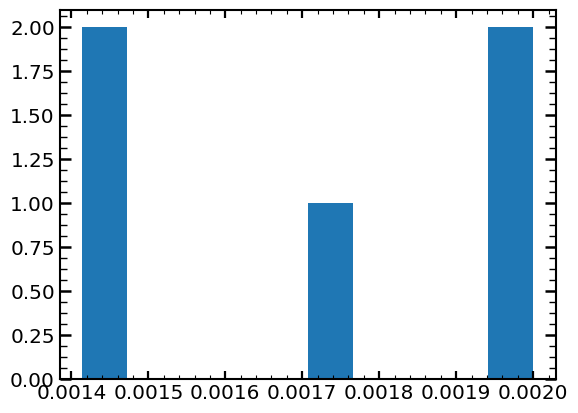

In [188]:
plt.hist(array_of_shortest_distance_for_checking[array_of_shortest_distance_for_checking<0.002])

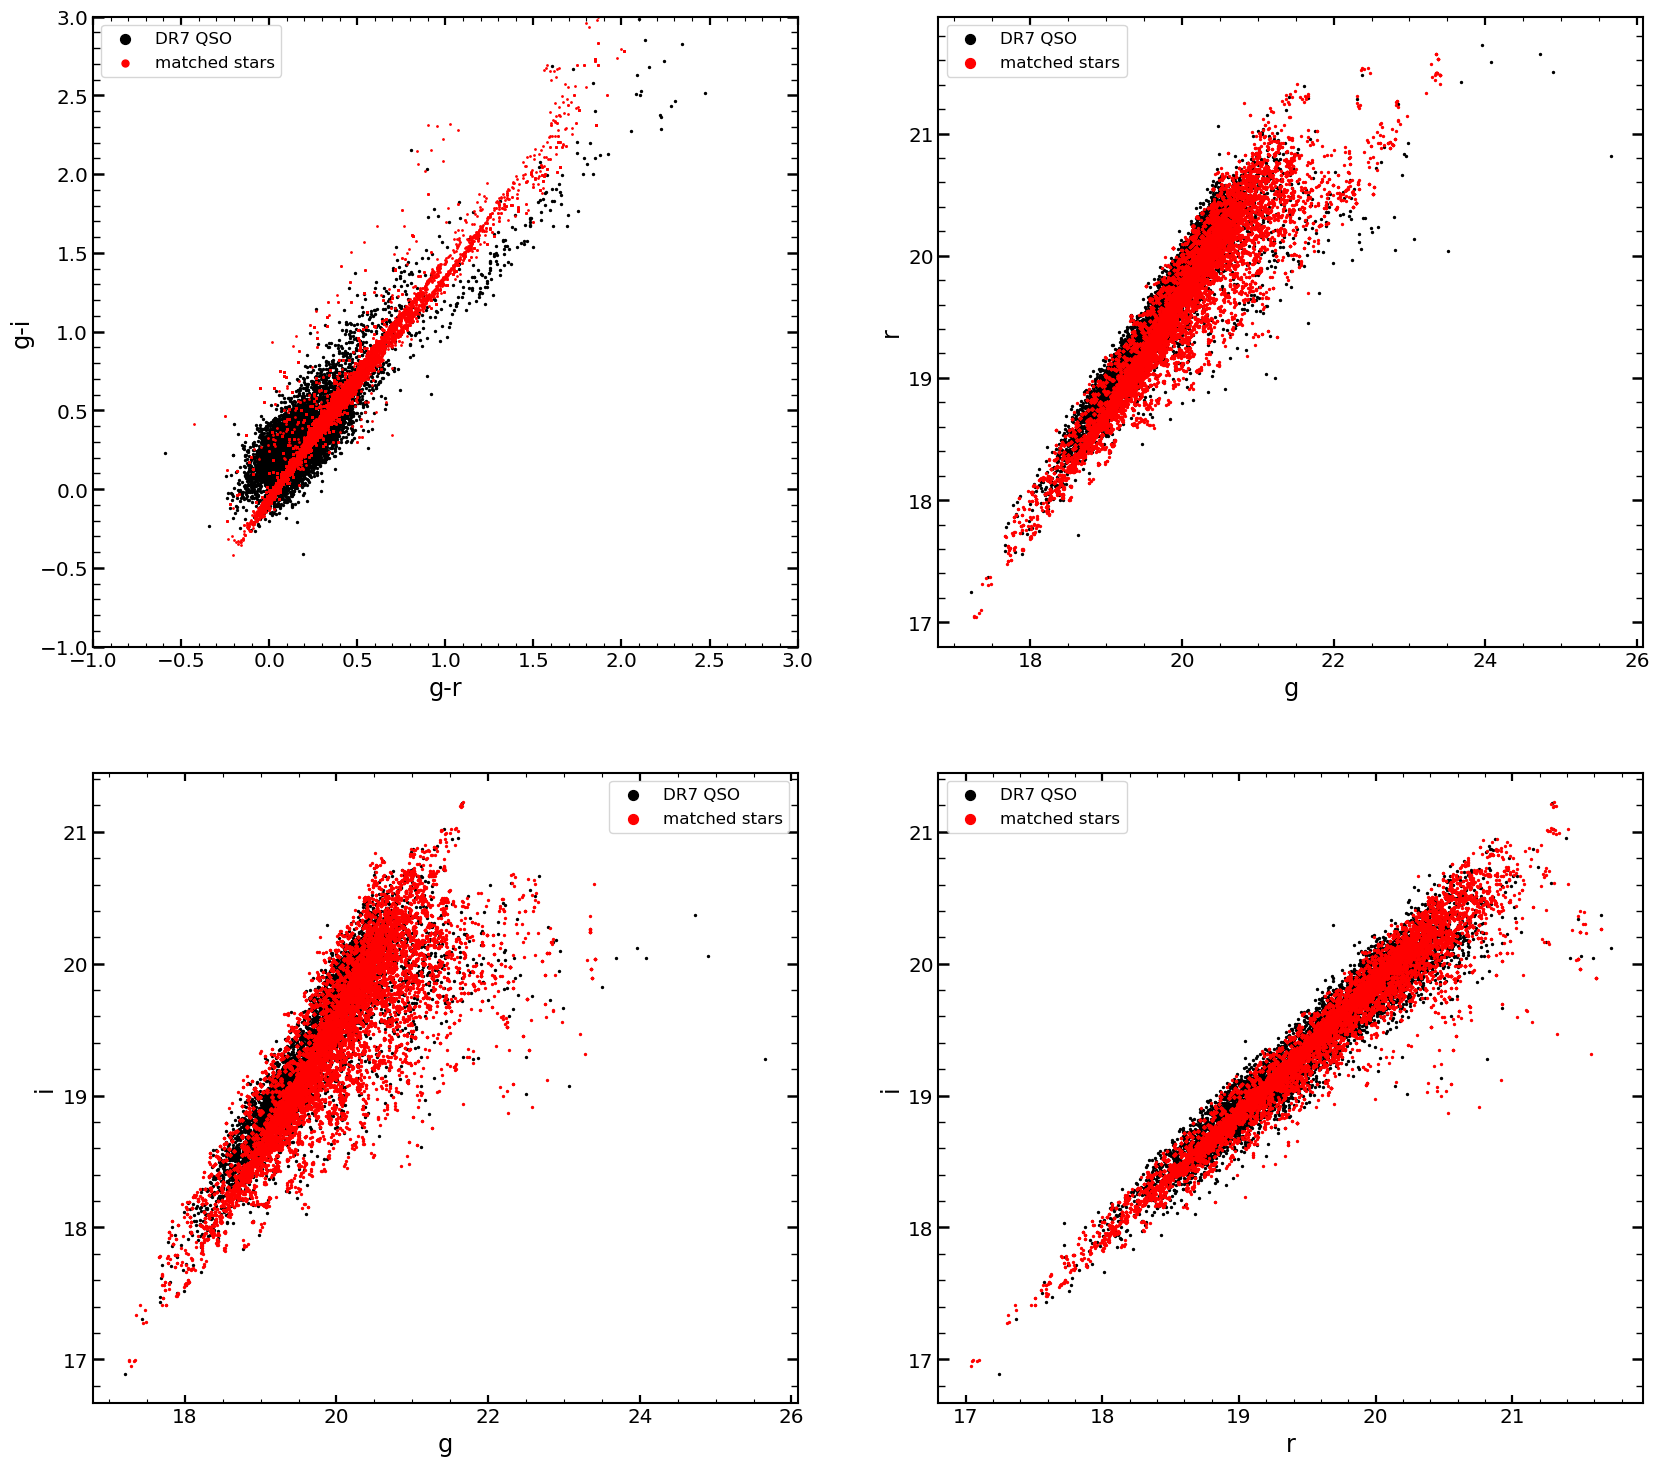

In [189]:
# datadr7_selection
# ra, dec,redshift, g (SDSS), err_g, r (SDSS), err_r, i (SDSS), err_i

# matched_array_Stripe82_stars_to_dr7QSO
# ra, dec, g, err_g, r, err_r, i, err_i

plt.figure(figsize=(20,18))

plt.subplot(2,2,1)
plt.scatter(datadr7_selection[:,3]-datadr7_selection[:,5],datadr7_selection[:,3]-datadr7_selection[:,7],s=2,label='DR7 QSO',color='black')
#plt.scatter(Stripe82stars.iloc[:,14].values-Stripe82stars.iloc[:,20].values,Stripe82stars.iloc[:,20].values-Stripe82stars.iloc[:,26].values,s=4,color='orange')
plt.scatter(matched_array_Stripe82_stars_to_dr7QSO_v8[:,2]-matched_array_Stripe82_stars_to_dr7QSO_v8[:,4]
            ,matched_array_Stripe82_stars_to_dr7QSO_v8[:,2]-matched_array_Stripe82_stars_to_dr7QSO_v8[:,6],s=1,label='matched stars',color='red')
plt.xlabel('g-r')
plt.ylabel('g-i')
plt.xlim(-1,3)
plt.ylim(-1,3)
plt.legend(markerscale=5)

plt.subplot(2,2,2)
plt.scatter(datadr7_selection[:,3],datadr7_selection[:,5],s=2,label='DR7 QSO',color='black')
plt.scatter(matched_array_Stripe82_stars_to_dr7QSO_v8[:,2],matched_array_Stripe82_stars_to_dr7QSO_v8[:,4],s=2,label='matched stars',color='red')
plt.xlabel('g')
plt.ylabel('r')
#plt.xlim(-1,5)
#plt.ylim(-1,5)
plt.legend(markerscale=5)

plt.subplot(2,2,3)
plt.scatter(datadr7_selection[:,3],datadr7_selection[:,7],s=2,label='DR7 QSO',color='black')
plt.scatter(matched_array_Stripe82_stars_to_dr7QSO_v8[:,2],matched_array_Stripe82_stars_to_dr7QSO_v8[:,6],s=2,label='matched stars',color='red')
plt.xlabel('g')
plt.ylabel('i')
#plt.xlim(-1,5)
#plt.ylim(-1,5)
plt.legend(markerscale=5)

plt.subplot(2,2,4)
plt.scatter(datadr7_selection[:,5],datadr7_selection[:,7],s=2,label='DR7 QSO',color='black')
plt.scatter(matched_array_Stripe82_stars_to_dr7QSO_v8[:,4],matched_array_Stripe82_stars_to_dr7QSO_v8[:,6],s=2,label='matched stars',color='red')
plt.xlabel('r')
plt.ylabel('i')
#plt.xlim(-1,5)
#plt.ylim(-1,5)
plt.legend(markerscale=5)

In [190]:
np.save(DATA_DIRECTORY+'matched_array_Stripe82_stars_to_dr7QSO_v8',matched_array_Stripe82_stars_to_dr7QSO_v8)

In [235]:
DATA_DIRECTORY+'matched_array_Stripe82_stars_to_dr7QSO_v8'

'/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_Stripe82_stars_to_dr7QSO_v8'

## Running the sql query 

In [191]:
#extract ra and dec values for SQL query
data = np.zeros(len(matched_array_Stripe82_stars_to_dr7QSO), dtype={'names':('ra', 'dec'),
                          'formats':('f8','f8')})

data['ra'] = matched_array_Stripe82_stars_to_dr7QSO[:,0]
data['dec'] =  matched_array_Stripe82_stars_to_dr7QSO[:,1]

position_of_matched_array_Stripe82_stars_to_dr7QSO=data

#extract ra and dec values for SQL query
data_v8 = np.zeros(len(matched_array_Stripe82_stars_to_dr7QSO_v8), dtype={'names':('ra', 'dec'),
                          'formats':('f8','f8')})

data_v8['ra'] = matched_array_Stripe82_stars_to_dr7QSO_v8[:,0]
data_v8['dec'] =  matched_array_Stripe82_stars_to_dr7QSO_v8[:,1]

position_of_matched_array_Stripe82_stars_to_dr7QSO_v8=data_v8


np.save(DATA_DIRECTORY+'position_of_matched_array_Stripe82_stars_to_dr7QSO',position_of_matched_array_Stripe82_stars_to_dr7QSO)
np.save(DATA_DIRECTORY+'position_of_matched_array_Stripe82_stars_to_dr7QSO_v8',position_of_matched_array_Stripe82_stars_to_dr7QSO_v8)

In [152]:
# Query ran on the server on June 29, 2019
# Estimate query time estimate 12 days for this run
# This run took 58 minutes
column_names=["g_cmodel_mag","g_cmodel_mag"]
# run the following command in order to create sql query
print('python CatalogCreator_custom.py position_of_matched_array_Stripe82_stars_to_dr7QSO.npy --columns ['  "\""+"\",\"".join(column_names)+"\""+']')

python CatalogCreator_custom.py position_of_matched_array_Stripe82_stars_to_dr7QSO.npy --columns ["g_cmodel_mag","g_cmodel_mag"]


## Analysis of the output

### initial analysis 

In [206]:
matched_array_Stripe82_stars_to_dr7QSO=np.load(DATA_DIRECTORY+'matched_array_Stripe82_stars_to_dr7QSO_v8.npy')

In [207]:
#read in catalogue from HSC query with pandas

#version with flags, first version where we used whole Stripe82
df = pd.read_csv(DATA_DIRECTORY+'281087.csv')

#version with flags, second version done with the part of the Stripe82 that was covered in HSC
df = pd.read_csv(DATA_DIRECTORY+'281269.csv')

#version with flags, third version done with the part of the Stripe82 that was covered in HSC (more precisely) and 5 per stars
df = pd.read_csv(DATA_DIRECTORY+'318592.csv')

#version with flags, third version done with the part of the Stripe82 that was covered in HSC (even more precisely) and 5 per stars
df = pd.read_csv(DATA_DIRECTORY+'318605.csv')

#version with flags, third version done with the part of the Stripe82 that was covered in HSC (even more precisely) and 5 per stars, low errors
df = pd.read_csv(DATA_DIRECTORY+'318612.csv')
print(len(df))

#version with flags, sixth version done with the part of the Stripe82 that was covered in HSC (even more precisely) and 5 per stars, removed QSO from DR7
df = pd.read_csv(DATA_DIRECTORY+'318635.csv')
print(len(df))

#version with flags, seventh version done with the part of the Stripe82 that was covered in HSC (even more precisely) and 5 per stars, removed QSO from milion, dr2-citus
df = pd.read_csv(DATA_DIRECTORY+'318639.csv')
print(len(df))

#version with flags, eigth version done with the part of the Stripe82 that was covered in HSC (even more precisely) and 5 per stars, \
# removed QSO from milion and dr7, dr2-citus
df = pd.read_csv(DATA_DIRECTORY+'318645.csv')
print(len(df))
# have to clean df

# give ra and dec
Positions_of_df=np.transpose([df['# ra'].values,df['dec'].values])
Positions_of_matched_array_Stripe82_stars_to_dr7QSO=matched_array_Stripe82_stars_to_dr7QSO[:,[0,1]]

10045
10017
9335
9235


In [208]:
# old code to check for qso
PositionOfQuasars_to_stars=[]
for j in tqdm(range(len(Positions_of_df))):
    PositionOfQuasars_to_stars.append(euclidean_distances([Positions_of_df[:,[0,1]][j]],Positions_of_dr7[:,[0,1]],))

100%|██████████| 9235/9235 [00:23<00:00, 394.68it/s]


In [209]:
PositionOfQuasars_to_stars_min=[]
for j in tqdm(range(len(Positions_of_df))):
    PositionOfQuasars_to_stars_min.append(np.min(PositionOfQuasars_to_stars[j]))
    
PositionOfQuasars_to_stars_min=np.array(PositionOfQuasars_to_stars_min)

100%|██████████| 9235/9235 [00:01<00:00, 6892.64it/s]


In [210]:
qso_list=[]
for p in np.where(PositionOfQuasars_to_stars_min<0.0001)[0]:
    qso_list.append(np.where(PositionOfQuasars_to_stars[p]<0.001)[1][0])

In [211]:
len(np.unique(qso_list))

0

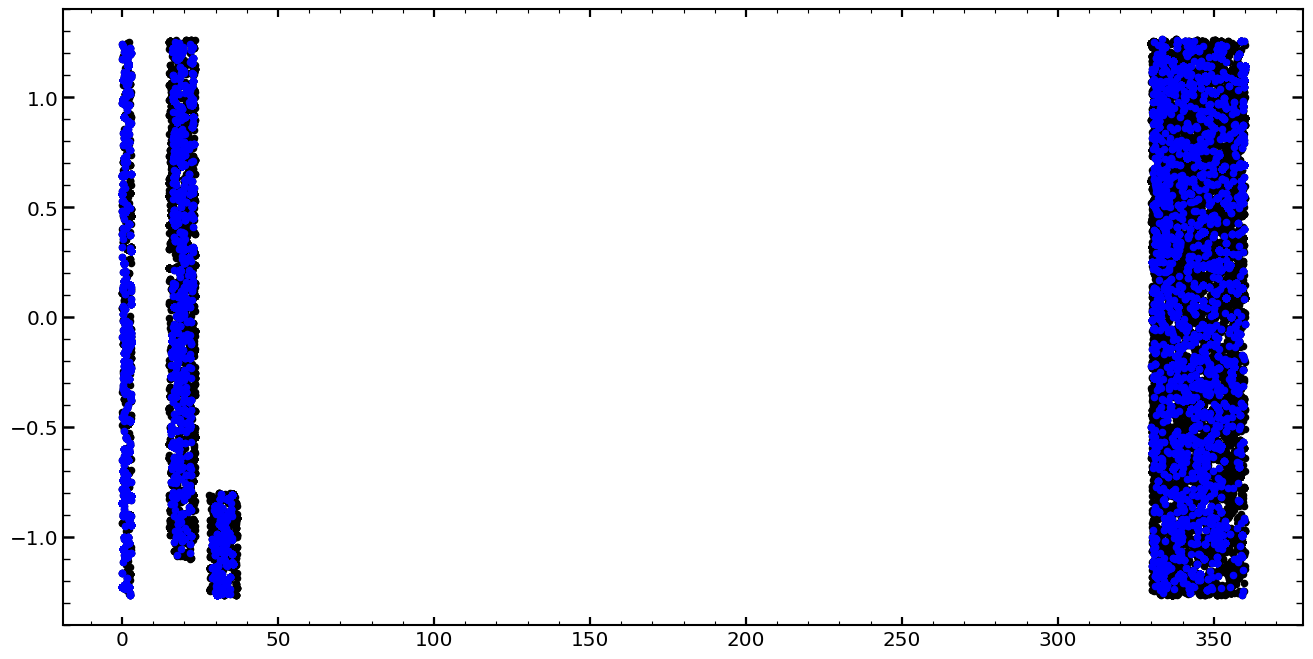

In [212]:
# check the overlap with SDSS
plt.figure(figsize=(16,8))
plt.scatter(Positions_of_matched_array_Stripe82_stars_to_dr7QSO[:,0],Positions_of_matched_array_Stripe82_stars_to_dr7QSO[:,1],color='black',s=20,label='proposed stars')
plt.scatter(Positions_of_df[:,0],Positions_of_df[:,1],color='blue',s=20,label='found stars')

In [213]:
# takes a bit less than 1 minute on my laptop
# this matches fake QSO from SDSS and resulting catalog from HSC
res_matching=[]
for j in tqdm(range(len(Positions_of_matched_array_Stripe82_stars_to_dr7QSO))):
    # finds distance from each of the objects in dr7 catalogue from the objects in HSC catalogue
    PositionOfQuasars_euclidean_distances=euclidean_distances([Positions_of_matched_array_Stripe82_stars_to_dr7QSO[j]],Positions_of_df)
    # shortest distance
    shortest_distance=np.min(PositionOfQuasars_euclidean_distances[0])
    # element of the ``Positions_of_df'' that has the shortest distance to the SDSS QSO
    shortest_distance_index=np.where(PositionOfQuasars_euclidean_distances[0]==np.min(PositionOfQuasars_euclidean_distances[0]))[0][0]
    res_matching.append([shortest_distance,df.loc[shortest_distance_index].values])

100%|██████████| 29595/29595 [00:19<00:00, 1556.59it/s]


In [214]:
len(matched_array_Stripe82_stars_to_dr7QSO)

29595

In [215]:
len(datadr7_selection)

5919

In [216]:

all_stars_found=[]
for i in range(len(datadr7_selection)):
    five_stars=[res_matching[i*5+0],res_matching[i*5+1],res_matching[i*5+2],res_matching[i*5+3],res_matching[i*5+4]]
    five_distances=[five_stars[0][0],five_stars[1][0],five_stars[2][0],five_stars[3][0],five_stars[4][0]]
    for j in range(len(five_distances)):
        if five_distances[j]>0.001:
            pass
        else:
            all_stars_found.append(np.concatenate(([i],matched_array_Stripe82_stars_to_dr7QSO[i*5+j][[0,1]],[datadr7_selection[i][2]],\
                                                   matched_array_Stripe82_stars_to_dr7QSO[i*5+j][[2,3,4,5,6,7]],res_matching[i*5+j][1])))

        #five_distances=np.array(five_distances)
        #first_small_distance=five_distances[five_distances<0.001][0]
        #index_of_first_small_distance=np.array(range(5))[five_distances==first_small_distance][0]
        #res_matching_v2.append(five_stars[index_of_first_small_distance])           
all_stars_found=np.array(all_stars_found)    
all_stars_found[:,0]=all_stars_found[:,0].astype(int)

index_of_QSO_that_did_find_stars=(np.intersect1d(range(5919),np.unique(all_stars_found[:,0]))).astype(int)
index_of_QSO_that_did_not_find_stars=(np.setdiff1d(range(5919),np.unique(all_stars_found[:,0]))).astype(int)

In [217]:
PositionOfQuasars_to_stars=[]
for j in tqdm(range(len(all_stars_found))):
    PositionOfQuasars_to_stars.append(euclidean_distances([all_stars_found[:,[1,2]][j]],Positions_of_dr7[:,[0,1]],))

100%|██████████| 9235/9235 [00:24<00:00, 378.81it/s]


In [218]:
PositionOfQuasars_to_stars_min=[]
for j in tqdm(range(len(all_stars_found))):
    PositionOfQuasars_to_stars_min.append(np.min(PositionOfQuasars_to_stars[j]))
    
PositionOfQuasars_to_stars_min=np.array(PositionOfQuasars_to_stars_min)

100%|██████████| 9235/9235 [00:01<00:00, 7906.99it/s]


In [219]:
len(np.where(PositionOfQuasars_to_stars_min<0.0001)[0])

0

(array([  3.,  41.,  25.,  56.,  98.,  69., 133., 108., 169., 148.]),
 array([0.0020558 , 0.00483983, 0.00762386, 0.01040788, 0.01319191,
        0.01597594, 0.01875996, 0.02154399, 0.02432802, 0.02711204,
        0.02989607]),
 <a list of 10 Patch objects>)

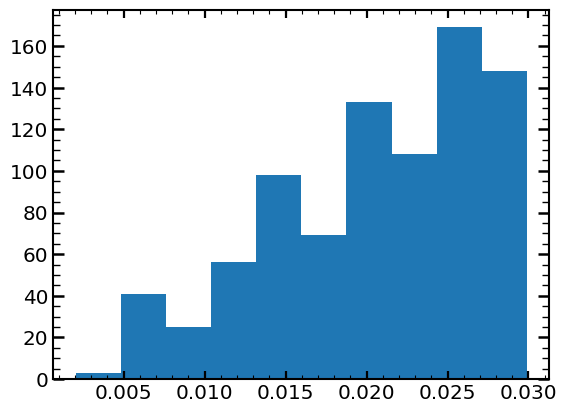

In [220]:
plt.hist(PositionOfQuasars_to_stars_min[PositionOfQuasars_to_stars_min<0.03])

In [221]:
second_look_QSO_that_did_find_stars=[]
for l in index_of_QSO_that_did_find_stars:
    second_look_QSO_that_did_find_stars.append(all_stars_found[all_stars_found[:,0]==l][0])

second_look_QSO_that_did_not_find_stars=[]
for l in index_of_QSO_that_did_not_find_stars:
    PositionOfQuasars_euclidean_distances_for_QSO_that_did_not_find=euclidean_distances([datadr7_selection[:,[3,5,7]][l]],all_stars_found[:,[4,6,8]],)

    shortest_distance=np.min(PositionOfQuasars_euclidean_distances_for_QSO_that_did_not_find)
    shortest_distance_index=np.where(PositionOfQuasars_euclidean_distances_for_QSO_that_did_not_find[0]==shortest_distance)[0][0]

    second_look_QSO_that_did_not_find_stars.append(np.concatenate(([l],all_stars_found[shortest_distance_index][[1,2]],[datadr7_selection[l][2]],\
                                           all_stars_found[shortest_distance_index][4:])))

    
    

In [222]:
print(second_look_QSO_that_did_not_find_stars[200][4])
print(second_look_QSO_that_did_not_find_stars[200][4+14])

21.026999999999997
21.0476


In [223]:
print(second_look_QSO_that_did_find_stars[2000][4])
print(second_look_QSO_that_did_find_stars[2000][4+14])

19.248
19.2529


In [224]:
matched_array_fake_QSO_unsorted=np.concatenate((np.array(second_look_QSO_that_did_find_stars),np.array(second_look_QSO_that_did_not_find_stars)))
matched_array_fake_QSO=matched_array_fake_QSO_unsorted[matched_array_fake_QSO_unsorted[:,0].argsort()]

In [225]:
"""
# create array that has objects from SDSS (fake QSO) that are found in HSC
matched_array_fake_QSO=[]
matched_array_fake_QSO_extended_SDSS=[]
for i in tqdm(range(len(res_matching))):
    if res_matching[i][0]>0.001:
        pass
    else:
        # 0. index of fake QSO object in the Stripe82_stars_to_dr7QSO, 1. Ra, 2. Dec, 3. redshift of the matched QSO, 4. g (SDSS), 5. err_g (SDSS), 6. r (SDSS), 7. err_r (SDSS), 8. i (SDSS), 9. err_i (SDSS)
        # 10. Ra of the fake QSO in HSC, 11. Dec of the fake QSO in HSC
        # 12. g_cmodel, 13. err_g_cmodel, 14. r_cmodel, 15. err_r_cmodel, 16. i_cmodel, 17. err_i_model
        # 18. g_psf, 19. err_g_psf, 20. r_psf, 21. err_r_psf, 22. i_psf, 23. err_i_psf
        # 24. HSC object ID
        # 25. g_psfflux_flag, 26. r_psfflux_flag, 27. i_psfflux_flag
        # 28. g_cmodel_flag, 29. r_cmodel_flag, 30. i_cmodel_flag
        # 31. g_pixelflags_edge, 32. r_pixelflags_edge, 33. i_pixelflags_edge
        # 34. g_pixelflags_bad, 35. r_pixelflags_bad, 36. i_pixelflags_bad
        # 37. g_pixelflags_interpolatedcenter, 38. r_pixelflags_interpolatedcenter, 39. i_pixelflags_interpolatedcenter
        # 40. g_pixelflags_saturatedcenter, 41. r_pixelflags_saturatedcenter, 42. i_pixelflags_saturatedcenter
        # 43. g_pixelflags_crcenter, 44. r_pixelflags_crcenter, 45. i_pixelflags_crcenter
        matched_array_fake_QSO.append(np.concatenate(([i],matched_array_Stripe82_stars_to_dr7QSO[i][[0,1]],[datadr7_selection[i][2]],matched_array_Stripe82_stars_to_dr7QSO[i][[2,3,4,5,6,7]],res_matching[i][1])))
        # extract columns 1,2,3 which are ra, dec and redshift (plan to add mass from Schen catalog)
        #matched_array_fake_QSO_extended_SDSS.append(np.concatenate((dr7.loc[i][[1,2,3]],res_matching[i][1])))
        
matched_array_fake_QSO=np.array(matched_array_fake_QSO)
#matched_array_fake_QSO_extended_SDSS=np.array(matched_array_fake_QSO_extended_SDSS)
"""

'\n# create array that has objects from SDSS (fake QSO) that are found in HSC\nmatched_array_fake_QSO=[]\nmatched_array_fake_QSO_extended_SDSS=[]\nfor i in tqdm(range(len(res_matching))):\n    if res_matching[i][0]>0.001:\n        pass\n    else:\n        # 0. index of fake QSO object in the Stripe82_stars_to_dr7QSO, 1. Ra, 2. Dec, 3. redshift of the matched QSO, 4. g (SDSS), 5. err_g (SDSS), 6. r (SDSS), 7. err_r (SDSS), 8. i (SDSS), 9. err_i (SDSS)\n        # 10. Ra of the fake QSO in HSC, 11. Dec of the fake QSO in HSC\n        # 12. g_cmodel, 13. err_g_cmodel, 14. r_cmodel, 15. err_r_cmodel, 16. i_cmodel, 17. err_i_model\n        # 18. g_psf, 19. err_g_psf, 20. r_psf, 21. err_r_psf, 22. i_psf, 23. err_i_psf\n        # 24. HSC object ID\n        # 25. g_psfflux_flag, 26. r_psfflux_flag, 27. i_psfflux_flag\n        # 28. g_cmodel_flag, 29. r_cmodel_flag, 30. i_cmodel_flag\n        # 31. g_pixelflags_edge, 32. r_pixelflags_edge, 33. i_pixelflags_edge\n        # 34. g_pixelflags_bad, 3

In [226]:
np.save(DATA_DIRECTORY+'matched_array_fake_QSO',matched_array_fake_QSO)

### 2D plot of differences

In [227]:
matched_array_fake_QSO=np.load(DATA_DIRECTORY+'matched_array_fake_QSO.npy')
len(matched_array_fake_QSO)

5919

In [228]:
matched_array_fake_QSO_filtered=matched_array_fake_QSO[matched_array_fake_QSO[:,18]>0]
len(matched_array_fake_QSO_filtered)

5919

(17, 25)

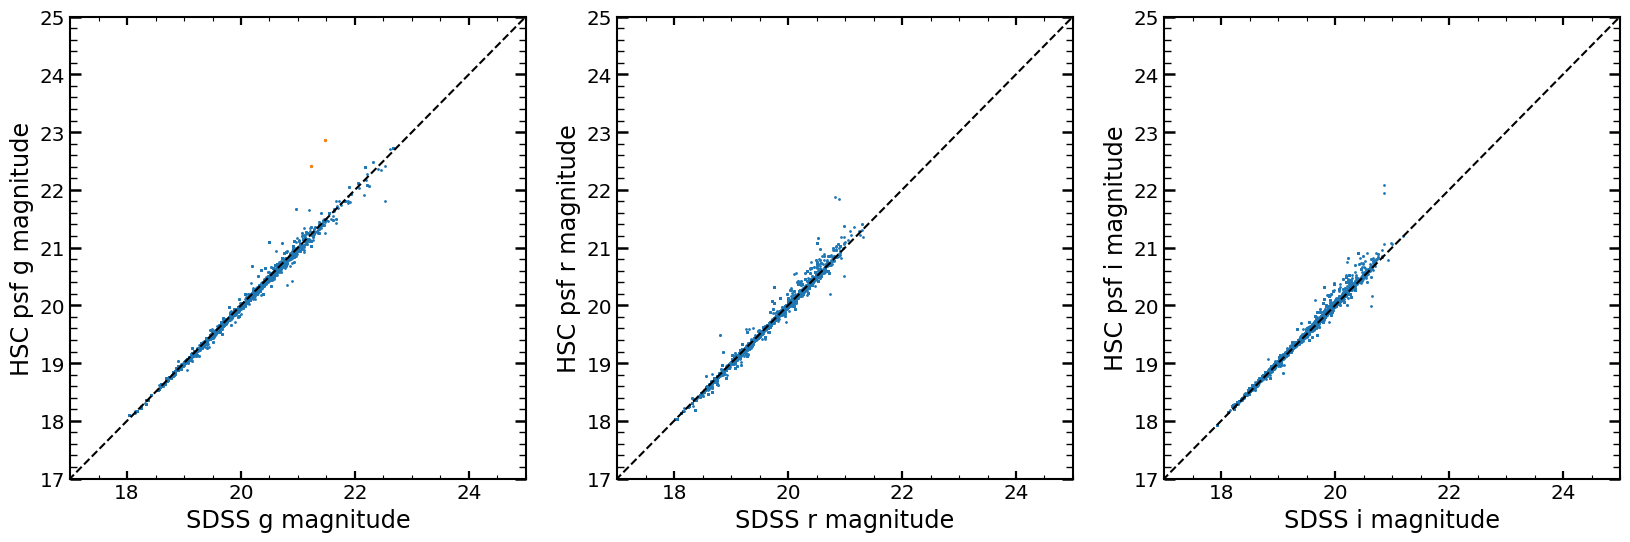

In [229]:
# plot differences using psf values from HSC
plt.figure(figsize=(20,6))
plt.subplot(131)

plt.scatter(matched_array_fake_QSO[:,4],matched_array_fake_QSO[:,14+4],s=1)
plt.scatter(matched_array_fake_QSO[:,4][(matched_array_fake_QSO[:,14+4]-matched_array_fake_QSO[:,4])>1],
            matched_array_fake_QSO[:,14+4][(matched_array_fake_QSO[:,14+4]-matched_array_fake_QSO[:,4])>1],s=2)
plt.scatter(matched_array_fake_QSO[:,4][(matched_array_fake_QSO[:,14+4]-matched_array_fake_QSO[:,4])>2],
            matched_array_fake_QSO[:,14+4][(matched_array_fake_QSO[:,14+4]-matched_array_fake_QSO[:,4])>2],s=3,color='red')

plt.xlabel('SDSS g magnitude')
plt.ylabel('HSC psf g magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)

plt.subplot(132)

plt.scatter(matched_array_fake_QSO[:,6],matched_array_fake_QSO[:,14+6],s=1)
plt.scatter(matched_array_fake_QSO[:,6][(matched_array_fake_QSO[:,14+6]-matched_array_fake_QSO[:,4])>1],
            matched_array_fake_QSO[:,14+6][(matched_array_fake_QSO[:,14+6]-matched_array_fake_QSO[:,4])>1],s=2)
plt.scatter(matched_array_fake_QSO[:,6][(matched_array_fake_QSO[:,14+6]-matched_array_fake_QSO[:,4])>2],
            matched_array_fake_QSO[:,14+6][(matched_array_fake_QSO[:,14+6]-matched_array_fake_QSO[:,4])>2],s=3,color='red')
plt.xlabel('SDSS r magnitude')
plt.ylabel('HSC psf r magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)
plt.subplot(133)

plt.scatter(matched_array_fake_QSO[:,8],matched_array_fake_QSO[:,14+8],s=1)
plt.scatter(matched_array_fake_QSO[:,8][(matched_array_fake_QSO[:,14+8]-matched_array_fake_QSO[:,4])>1],
            matched_array_fake_QSO[:,14+8][(matched_array_fake_QSO[:,14+8]-matched_array_fake_QSO[:,4])>1],s=2)
plt.scatter(matched_array_fake_QSO[:,8][(matched_array_fake_QSO[:,14+8]-matched_array_fake_QSO[:,4])>2],
            matched_array_fake_QSO[:,14+8][(matched_array_fake_QSO[:,14+8]-matched_array_fake_QSO[:,4])>2],s=3,color='red')
plt.xlabel('SDSS i magnitude')
plt.ylabel('HSC psf i magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)

## Redshift effect - with psf magnitude still working on updating here

In [230]:
matched_array_fake_QSO=np.load(DATA_DIRECTORY+'matched_array_fake_QSO.npy')
len(matched_array_fake_QSO)

5919

In [231]:
# g-band
res_delta_redshift_via_redshift_fake_QSO_array,res_delta_redshift_via_redshift_median_fake_QSO_array,res_delta_redshift_via_redshift_fake_QSO_err_array,res_delta_redshift_via_redshift_median_fake_QSO_err_array,\
res_redshift_fake_QSO_array,p20_fake_QSO_array,p20_median_fake_QSO_array=create_redshift_result(matched_array_fake_QSO,100,sdss_band_column=4,difference_sdss_HSC_columns=14)

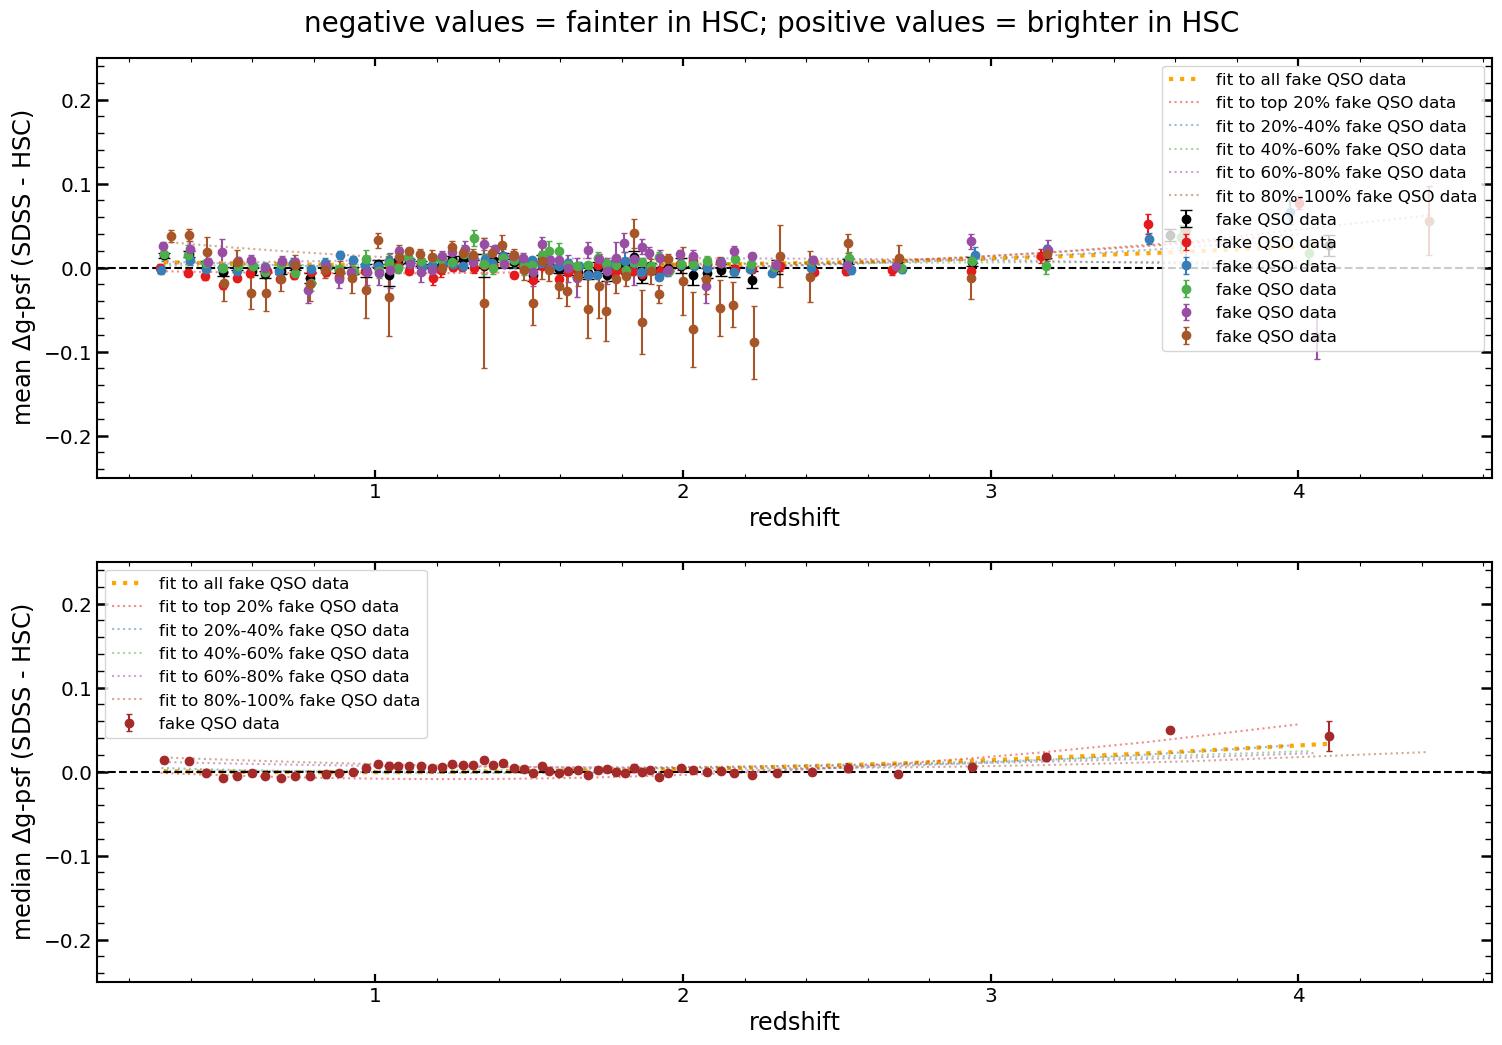

In [233]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)

plt.subplot(211)
plt.errorbar(res_redshift_fake_QSO_array[0],res_delta_redshift_via_redshift_fake_QSO_array[0],\
             yerr=res_delta_redshift_via_redshift_fake_QSO_err_array[0],marker='o',capsize=4,ls='',color='black',label='fake QSO data')
plt.errorbar(res_redshift_fake_QSO_array[1],res_delta_redshift_via_redshift_fake_QSO_array[1],\
             yerr=res_delta_redshift_via_redshift_fake_QSO_err_array[1],marker='o',capsize=2,ls='',color='#e41a1c',label='fake QSO data')
plt.errorbar(res_redshift_fake_QSO_array[2],res_delta_redshift_via_redshift_fake_QSO_array[2],\
             yerr=res_delta_redshift_via_redshift_fake_QSO_err_array[2],marker='o',capsize=2,ls='',color='#377eb8',label='fake QSO data')
plt.errorbar(res_redshift_fake_QSO_array[3],res_delta_redshift_via_redshift_fake_QSO_array[3],\
             yerr=res_delta_redshift_via_redshift_fake_QSO_err_array[3],marker='o',capsize=2,ls='',color='#4daf4a',label='fake QSO data')
plt.errorbar(res_redshift_fake_QSO_array[4],res_delta_redshift_via_redshift_fake_QSO_array[4],\
             yerr=res_delta_redshift_via_redshift_fake_QSO_err_array[4],marker='o',capsize=2,ls='',color='#984ea3',label='fake QSO data')
plt.errorbar(res_redshift_fake_QSO_array[5],res_delta_redshift_via_redshift_fake_QSO_array[5],\
             yerr=res_delta_redshift_via_redshift_fake_QSO_err_array[5],marker='o',capsize=2,ls='',color='#a65628',label='fake QSO data')


plt.plot(res_redshift_fake_QSO_array[0],p20_fake_QSO_array[0](res_redshift_fake_QSO_array[0]),ls=':',color='orange',lw=3,label='fit to all fake QSO data')

# brightest
plt.plot(res_redshift_fake_QSO_array[1],p20_fake_QSO_array[1](res_redshift_fake_QSO_array[1]),ls=':',color='#e41a1c',alpha=0.5,label='fit to top 20% fake QSO data')
plt.plot(res_redshift_fake_QSO_array[2],p20_fake_QSO_array[2](res_redshift_fake_QSO_array[2]),ls=':',color='#377eb8',alpha=0.5,label='fit to 20%-40% fake QSO data')
plt.plot(res_redshift_fake_QSO_array[3],p20_fake_QSO_array[3](res_redshift_fake_QSO_array[3]),ls=':',color='#4daf4a',alpha=0.5,label='fit to 40%-60% fake QSO data')
plt.plot(res_redshift_fake_QSO_array[4],p20_fake_QSO_array[4](res_redshift_fake_QSO_array[4]),ls=':',color='#984ea3',alpha=0.5,label='fit to 60%-80% fake QSO data')
plt.plot(res_redshift_fake_QSO_array[5],p20_fake_QSO_array[5](res_redshift_fake_QSO_array[5]),ls=':',color='#a65628',alpha=0.5,label='fit to 80%-100% fake QSO data')


plt.ylabel('mean $\Delta$g-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

plt.subplot(212)
plt.errorbar(res_redshift_fake_QSO_array[0],res_delta_redshift_via_redshift_median_fake_QSO_array[0],yerr=res_delta_redshift_via_redshift_median_fake_QSO_err_array[0],marker='o',capsize=2,ls='',color='brown',label='fake QSO data')
plt.plot(res_redshift_fake_QSO_array[0],p20_median_fake_QSO_array[0](res_redshift_fake_QSO_array[0]),ls=':',color='orange',lw=3,label='fit to all fake QSO data')


plt.plot(res_redshift_fake_QSO_array[1],p20_median_fake_QSO_array[1](res_redshift_fake_QSO_array[1]),ls=':',color='#e41a1c',alpha=0.5,label='fit to top 20% fake QSO data')
plt.plot(res_redshift_fake_QSO_array[2],p20_median_fake_QSO_array[2](res_redshift_fake_QSO_array[2]),ls=':',color='#377eb8',alpha=0.5,label='fit to 20%-40% fake QSO data')
plt.plot(res_redshift_fake_QSO_array[3],p20_median_fake_QSO_array[3](res_redshift_fake_QSO_array[3]),ls=':',color='#4daf4a',alpha=0.5,label='fit to 40%-60% fake QSO data')
plt.plot(res_redshift_fake_QSO_array[4],p20_median_fake_QSO_array[4](res_redshift_fake_QSO_array[4]),ls=':',color='#984ea3',alpha=0.5,label='fit to 60%-80% fake QSO data')
plt.plot(res_redshift_fake_QSO_array[5],p20_median_fake_QSO_array[5](res_redshift_fake_QSO_array[5]),ls=':',color='#a65628',alpha=0.5,label='fit to 80%-100% fake QSO data')

plt.ylabel('median $\Delta$g-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

(array([0.00000000e+00, 3.39328130e-02, 3.49507974e+00, 3.68510350e+01,
        6.33525619e+01, 4.67254835e+01, 2.49066848e+01, 1.14353580e+01,
        5.76857822e+00, 3.22361724e+00, 1.32337971e+00, 6.78656261e-01,
        5.08992195e-01, 6.10790635e-01, 3.73260943e-01, 1.01798439e-01,
        2.37529691e-01, 1.01798439e-01, 1.69664065e-01, 1.01798439e-01]),
 array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
        0.09 , 0.095, 0.1  ]),
 <a list of 20 Patch objects>)

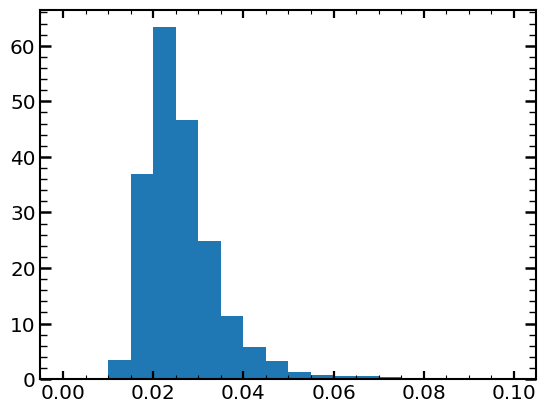

In [372]:
plt.hist((matched_array_filtered[:,5]).astype(float),density=True,stacked=True,bins=20,range=(0,0.1),label='weird fake QSO')

## c-model and psf magnitude comparsion between fake and real objects 

In [ ]:
# compare psf and c-model magnitude of QSO and fake QSO

In [345]:
# fake QSO matched array
matched_array_fake_QSO=np.load(DATA_DIRECTORY+'matched_array_fake_QSO.npy')

In [428]:
# fake QSO real array
matched_array=np.load('/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array.npy')

In [347]:
matched_array_columns=['SDSS ID','ra (SDSS)', 'dec (SDSS)', 'redshift', 'g-band (SDSS)', 'g-band err (SDSS)',
                                                                                   'r-band (SDSS)','r-band err (SDSS)','i-band (SDSS)','i-band err (SDSS)','ra (HSC)', 'dec (HSC)',
                                                                                   'g_cmodel_mag (HSC)','g_cmodel_magsigma (HSC)','r_cmodel_mag (HSC)','r_cmodel_magsigma (HSC)',
                                                                                   'i_cmodel_mag (HSC)','i_cmodel_magsigma (HSC)','g_psfflux_mag (HSC)','g_psfflux_magsigma (HSC)',
                                                                                  'r_psfflux_mag (HSC)','r_psfflux_magsigma (HSC)','i_psfflux_mag (HSC)', 'i_psfflux_magsigma (HSC)',
                                                                                   'object_id (HSC)']


In [348]:
print(matched_array_columns[4])
print(matched_array_columns[12])
print(matched_array_columns[18])

g-band (SDSS)
g_cmodel_mag (HSC)
g_psfflux_mag (HSC)


In [349]:
matched_array[0]

array(['000006.53+003055.2', 0.027228, 0.5153409999999999, 1.8246, 20.461,
       0.034, 20.324, 0.038, 20.093, 0.040999999999999995,
       0.02721788641875579, 0.5153451172566508, 20.280323000000003,
       0.00146709138, 20.2737541, 0.00134790991, 20.071590399999998,
       0.00110844115, 20.2822533, 0.0013819106400000001,
       20.271421399999998, 0.0013236767800000001, 20.072391500000002,
       0.0011004518, 4.164566505438386e+16], dtype=object)

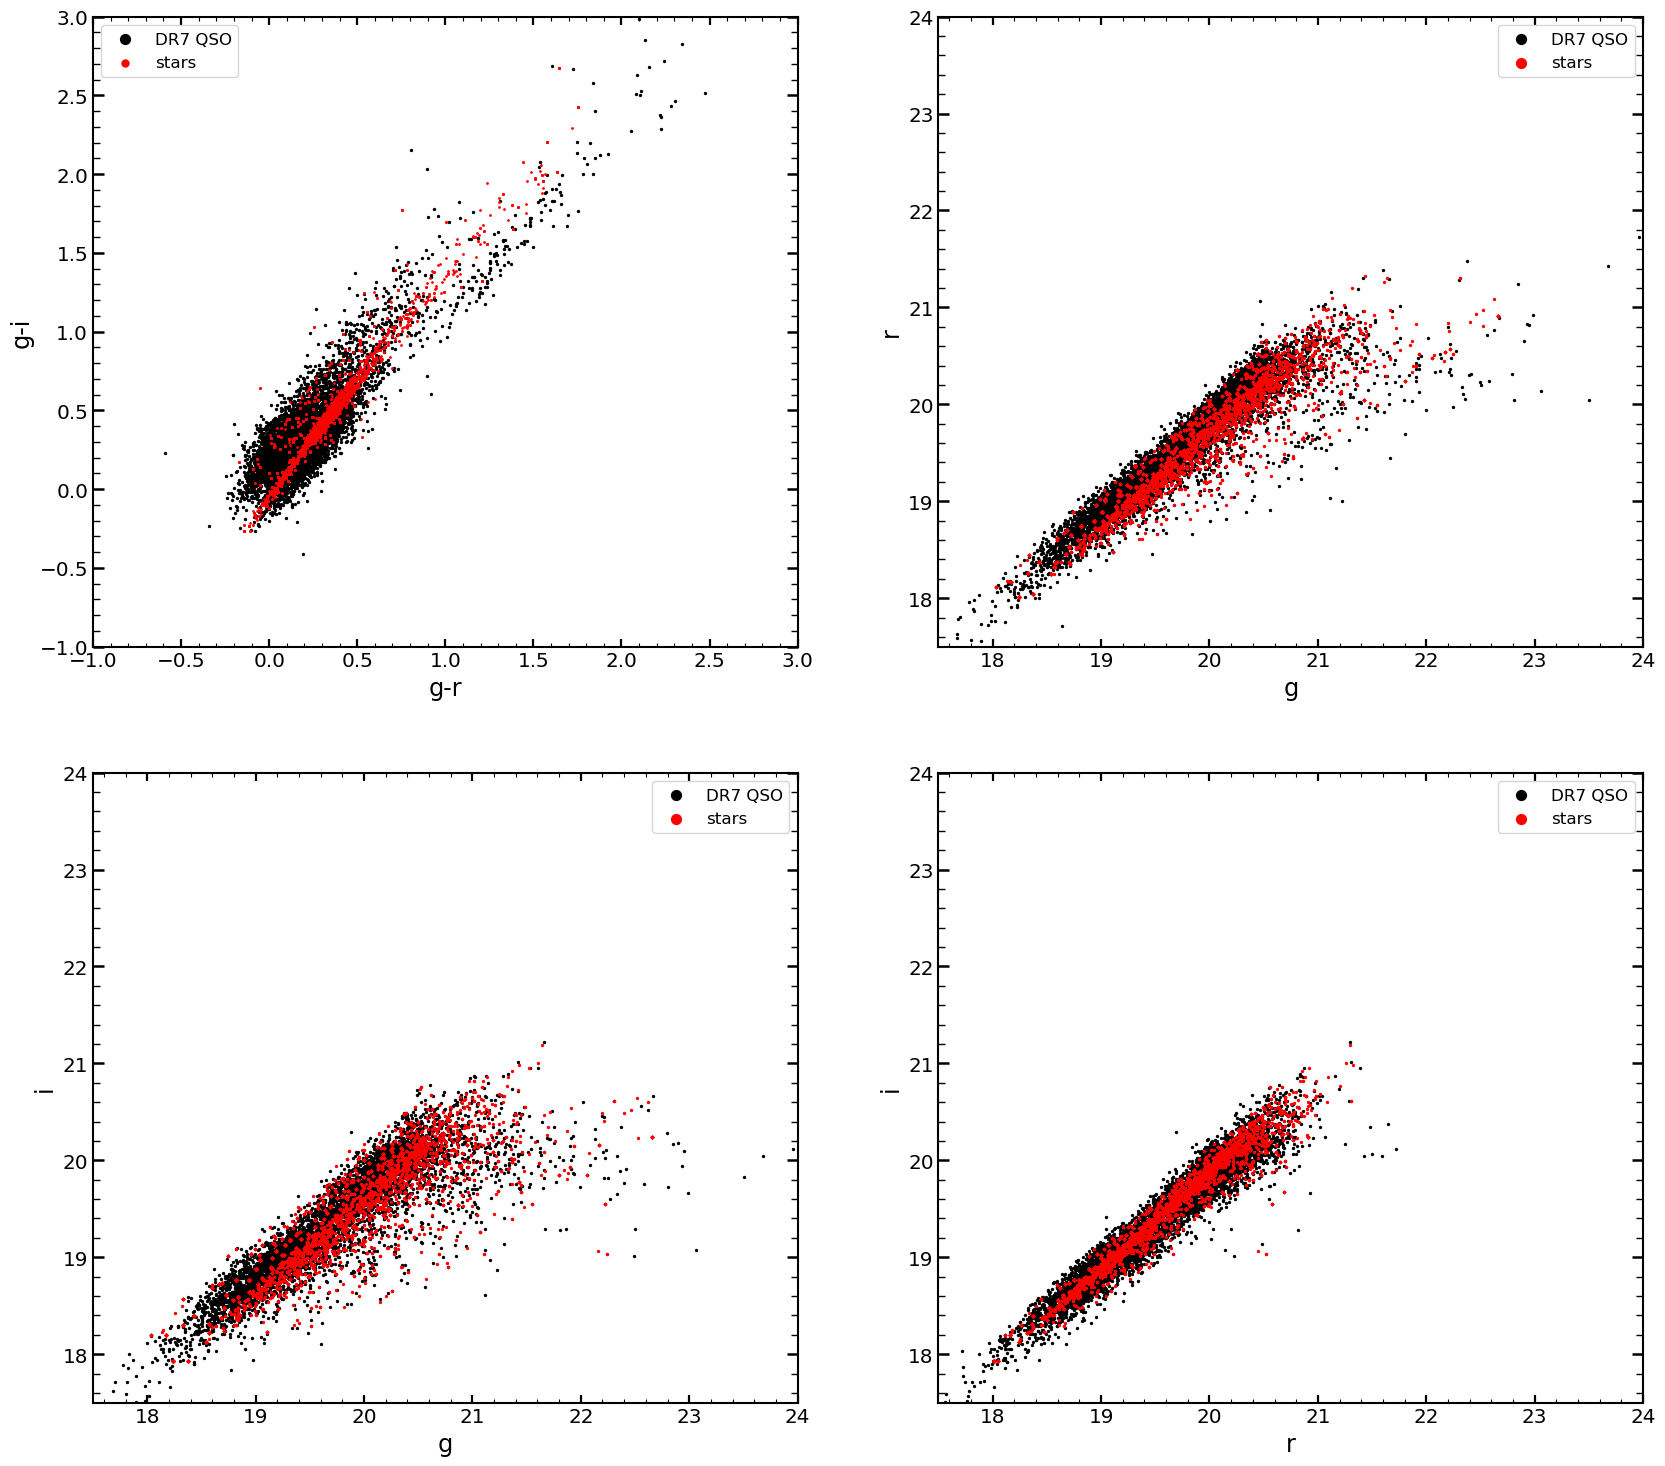

In [350]:
# datadr7_selection
# ra, dec,redshift, g (SDSS), err_g, r (SDSS), err_r, i (SDSS), err_i

# matched_array_Stripe82_stars_to_dr7QSO
# ra, dec, g, err_g, r, err_r, i, err_i

plt.figure(figsize=(20,18))

plt.subplot(2,2,1)
plt.scatter(matched_array[:,4]-matched_array[:,6],matched_array[:,4]-matched_array[:,8],s=2,label='DR7 QSO',color='black')
#plt.scatter(Stripe82stars.iloc[:,14].values-Stripe82stars.iloc[:,20].values,Stripe82stars.iloc[:,20].values-Stripe82stars.iloc[:,26].values,s=4,color='orange')
plt.scatter(matched_array_fake_QSO[:,4]-matched_array_fake_QSO[:,6],matched_array_fake_QSO[:,4]-matched_array_fake_QSO[:,8],s=1,label='stars',color='red')
plt.xlabel('g-r')
plt.ylabel('g-i')
plt.xlim(-1,3)
plt.ylim(-1,3)
plt.legend(markerscale=5)

plt.subplot(2,2,2)
plt.scatter(matched_array[:,4],matched_array[:,6],s=2,label='DR7 QSO',color='black')
plt.scatter(matched_array_fake_QSO[:,4],matched_array_fake_QSO[:,6],s=2,label='stars',color='red')
plt.xlabel('g')
plt.ylabel('r')
plt.xlim(17.5,24)
plt.ylim(17.5,24)
plt.legend(markerscale=5)

plt.subplot(2,2,3)
plt.scatter(matched_array[:,4],matched_array[:,8],s=2,label='DR7 QSO',color='black')
plt.scatter(matched_array_fake_QSO[:,4],matched_array_fake_QSO[:,8],s=2,label='stars',color='red')
plt.xlabel('g')
plt.ylabel('i')
plt.xlim(17.5,24)
plt.ylim(17.5,24)
plt.legend(markerscale=5)

plt.subplot(2,2,4)
plt.scatter(matched_array[:,6],matched_array[:,8],s=2,label='DR7 QSO',color='black')
plt.scatter(matched_array_fake_QSO[:,6],matched_array_fake_QSO[:,8],s=2,label='stars',color='red')
plt.xlabel('r')
plt.ylabel('i')
plt.xlim(17.5,24)
plt.ylim(17.5,24)
plt.legend(markerscale=5)

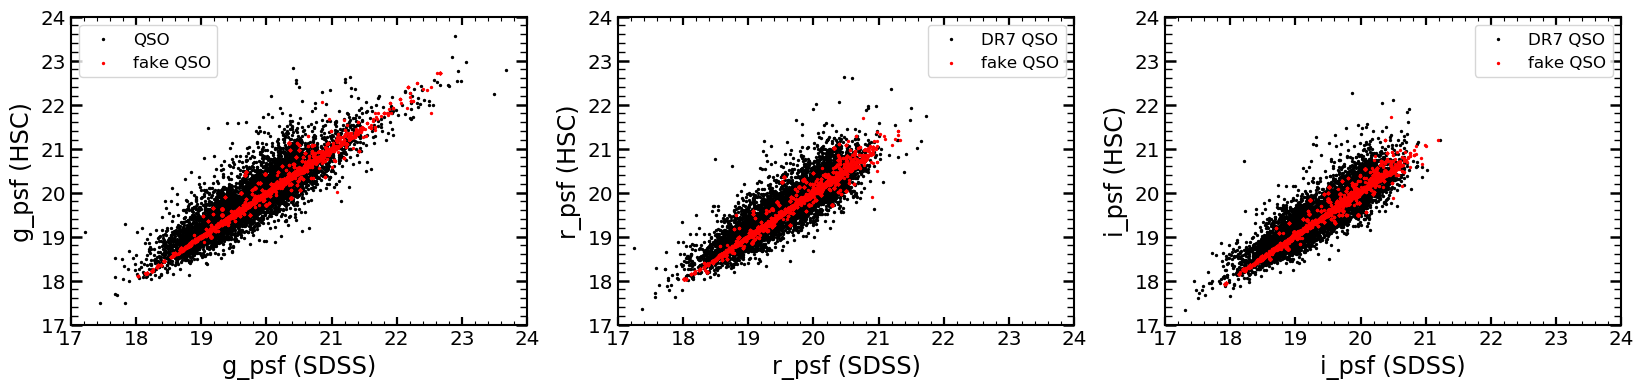

In [351]:
plt.figure(figsize=(20,4))

plt.subplot(131)
plt.scatter(matched_array[:,4],matched_array[:,18],s=2,label='QSO',color='black')
plt.scatter(matched_array_fake_QSO[:,4],matched_array_fake_QSO[:,18],s=2,label='fake QSO',color='red')
plt.xlabel('g_psf (SDSS)')
plt.ylabel('g_psf (HSC)')
plt.xlim(17,24)
plt.ylim(17,24)
plt.legend()

plt.subplot(132)
plt.scatter(matched_array[:,6],matched_array[:,20],s=2,label='DR7 QSO',color='black')
plt.scatter(matched_array_fake_QSO[:,6],matched_array_fake_QSO[:,20],s=2,label='fake QSO',color='red')
plt.xlabel('r_psf (SDSS)')
plt.ylabel('r_psf (HSC)')
plt.xlim(17,24)
plt.ylim(17,24)
plt.legend()

plt.subplot(133)
plt.scatter(matched_array[:,8],matched_array[:,22],s=2,label='DR7 QSO',color='black')
plt.scatter(matched_array_fake_QSO[:,8],matched_array_fake_QSO[:,22],s=2,label='fake QSO',color='red')
plt.xlabel('i_psf (SDSS)')
plt.ylabel('i_psf (HSC)')
plt.xlim(17,24)
plt.ylim(17,24)
plt.legend()

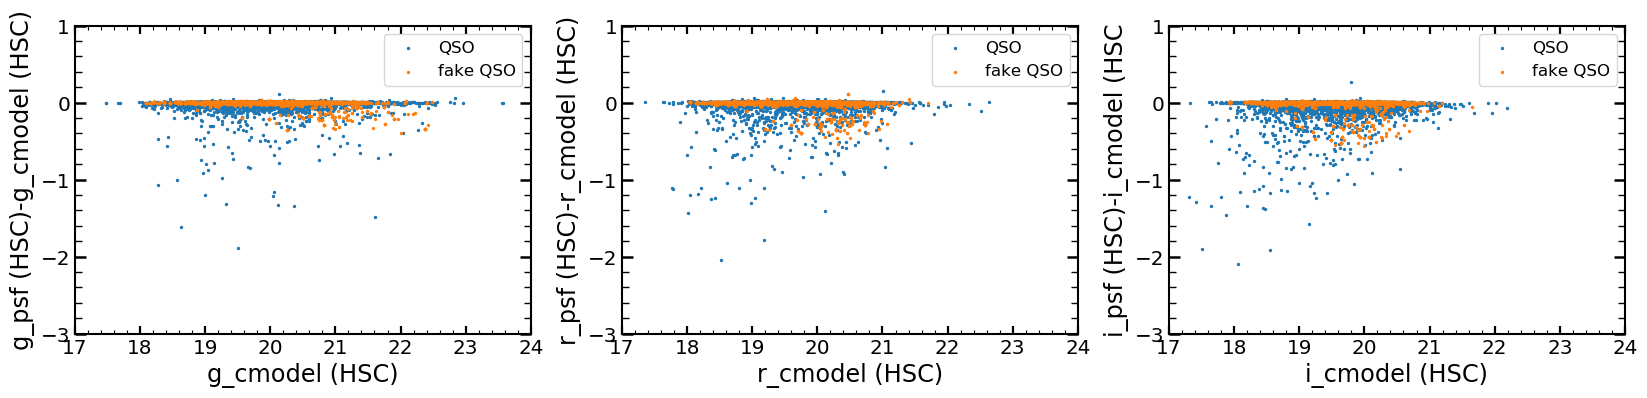

In [352]:
plt.figure(figsize=(20,4))

plt.subplot(131)
plt.scatter(matched_array[:,12],matched_array[:,12]-matched_array[:,18],s=2,label='QSO')
plt.scatter(matched_array_fake_QSO[:,12],matched_array_fake_QSO[:,12]-matched_array_fake_QSO[:,18],s=2,label='fake QSO')
plt.xlabel('g_cmodel (HSC)')
plt.ylabel('g_psf (HSC)-g_cmodel (HSC)')
plt.xlim(17,24)
plt.ylim(-3,1)
plt.legend()

plt.subplot(132)
plt.scatter(matched_array[:,14],matched_array[:,14]-matched_array[:,20],s=2,label='QSO')
plt.scatter(matched_array_fake_QSO[:,14],matched_array_fake_QSO[:,14]-matched_array_fake_QSO[:,20],s=2,label='fake QSO')
plt.xlabel('r_cmodel (HSC)')
plt.ylabel('r_psf (HSC)-r_cmodel (HSC)')
plt.xlim(17,24)
plt.ylim(-3,1)
plt.legend()

plt.subplot(133)
plt.scatter(matched_array[:,16],matched_array[:,16]-matched_array[:,22],s=2,label='QSO')
plt.scatter(matched_array_fake_QSO[:,16],matched_array_fake_QSO[:,16]-matched_array_fake_QSO[:,22],s=2,label='fake QSO')
plt.xlabel('i_cmodel (HSC)')
plt.ylabel('i_psf (HSC)-i_cmodel (HSC')
plt.xlim(17,24)
plt.ylim(-3,1)
plt.legend()

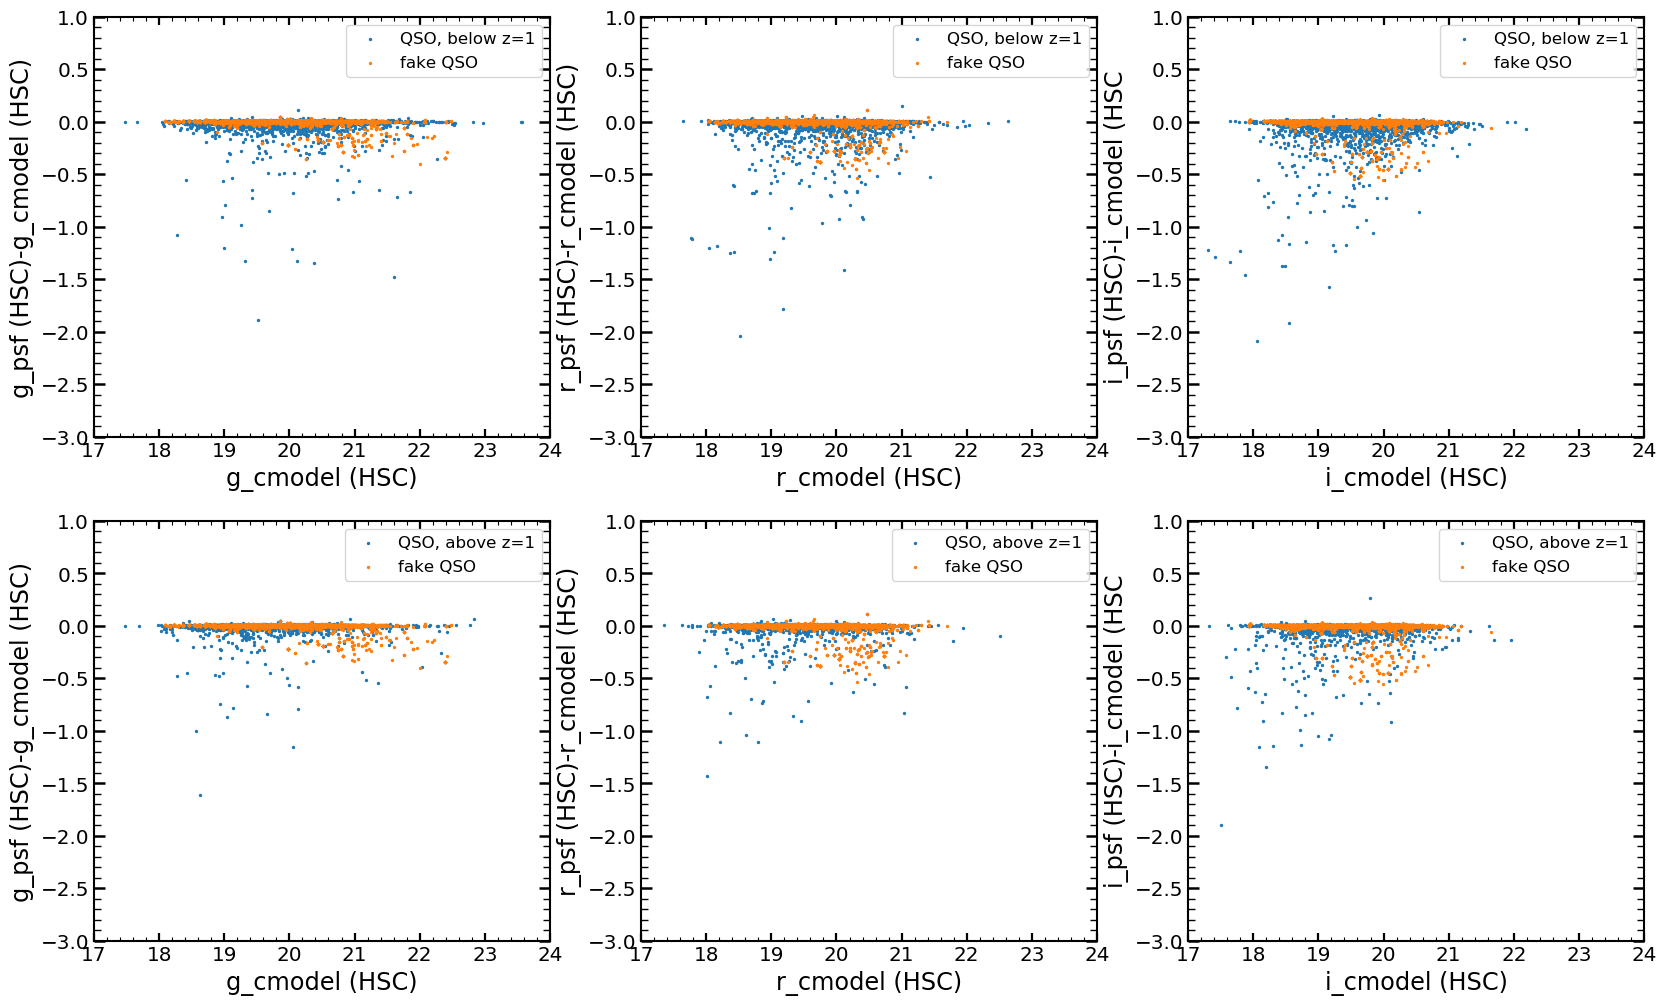

In [353]:
low_redshift_matched_array=matched_array[matched_array[:,2]<1]
high_redshift_matched_array=matched_array[matched_array[:,2]>1]

plt.figure(figsize=(20,12))

plt.subplot(231)
plt.scatter(low_redshift_matched_array[:,12],low_redshift_matched_array[:,12]-low_redshift_matched_array[:,18],s=2,label='QSO, below z=1')
plt.scatter(matched_array_fake_QSO[:,12],matched_array_fake_QSO[:,12]-matched_array_fake_QSO[:,18],s=2,label='fake QSO')
plt.xlabel('g_cmodel (HSC)')
plt.ylabel('g_psf (HSC)-g_cmodel (HSC)')
plt.xlim(17,24)
plt.ylim(-3,1)
plt.legend()

plt.subplot(232)
plt.scatter(low_redshift_matched_array[:,14],low_redshift_matched_array[:,14]-low_redshift_matched_array[:,20],s=2,label='QSO, below z=1')
plt.scatter(matched_array_fake_QSO[:,14],matched_array_fake_QSO[:,14]-matched_array_fake_QSO[:,20],s=2,label='fake QSO')
plt.xlabel('r_cmodel (HSC)')
plt.ylabel('r_psf (HSC)-r_cmodel (HSC)')
plt.xlim(17,24)
plt.ylim(-3,1)
plt.legend()

plt.subplot(233)
plt.scatter(low_redshift_matched_array[:,16],low_redshift_matched_array[:,16]-low_redshift_matched_array[:,22],s=2,label='QSO, below z=1')
plt.scatter(matched_array_fake_QSO[:,16],matched_array_fake_QSO[:,16]-matched_array_fake_QSO[:,22],s=2,label='fake QSO')
plt.xlabel('i_cmodel (HSC)')
plt.ylabel('i_psf (HSC)-i_cmodel (HSC')
plt.xlim(17,24)
plt.ylim(-3,1)
plt.legend()

plt.subplot(234)
plt.scatter(high_redshift_matched_array[:,12],high_redshift_matched_array[:,12]-high_redshift_matched_array[:,18],s=2,label='QSO, above z=1')
plt.scatter(matched_array_fake_QSO[:,12],matched_array_fake_QSO[:,12]-matched_array_fake_QSO[:,18],s=2,label='fake QSO')
plt.xlabel('g_cmodel (HSC)')
plt.ylabel('g_psf (HSC)-g_cmodel (HSC)')
plt.xlim(17,24)
plt.ylim(-3,1)
plt.legend()

plt.subplot(235)
plt.scatter(high_redshift_matched_array[:,14],high_redshift_matched_array[:,14]-high_redshift_matched_array[:,20],s=2,label='QSO, above z=1')
plt.scatter(matched_array_fake_QSO[:,14],matched_array_fake_QSO[:,14]-matched_array_fake_QSO[:,20],s=2,label='fake QSO')
plt.xlabel('r_cmodel (HSC)')
plt.ylabel('r_psf (HSC)-r_cmodel (HSC)')
plt.xlim(17,24)
plt.ylim(-3,1)
plt.legend()

plt.subplot(236)
plt.scatter(high_redshift_matched_array[:,16],high_redshift_matched_array[:,16]-high_redshift_matched_array[:,22],s=2,label='QSO, above z=1')
plt.scatter(matched_array_fake_QSO[:,16],matched_array_fake_QSO[:,16]-matched_array_fake_QSO[:,22],s=2,label='fake QSO')
plt.xlabel('i_cmodel (HSC)')
plt.ylabel('i_psf (HSC)-i_cmodel (HSC')
plt.xlim(17,24)
plt.ylim(-3,1)
plt.legend()

In [417]:
# stars for which c-model and psf magnitdues differ by more than 0.2 mag
matched_array_fake_QSO_weird_objects=matched_array_fake_QSO[(matched_array_fake_QSO[:,12]-matched_array_fake_QSO[:,18])<-0.2]

In [418]:
matched_array_fake_QSO_weird_objects[0]

array([2.39000000e+02, 3.59861206e+02, 1.14410890e+00, 8.78700000e-01,
       2.00650000e+01, 9.00000000e-03, 1.98590000e+01, 9.00000000e-03,
       1.98870000e+01, 1.20000000e-02, 3.59861216e+02, 1.14413243e+00,
       1.99852867e+01, 1.31706800e-03, 1.97439957e+01, 1.00227876e-03,
       1.96362286e+01, 1.00242079e-03, 2.02045879e+01, 1.37484889e-03,
       2.01331863e+01, 1.09148619e-03, 2.01551266e+01, 1.10280945e-03,
       4.16458154e+16])

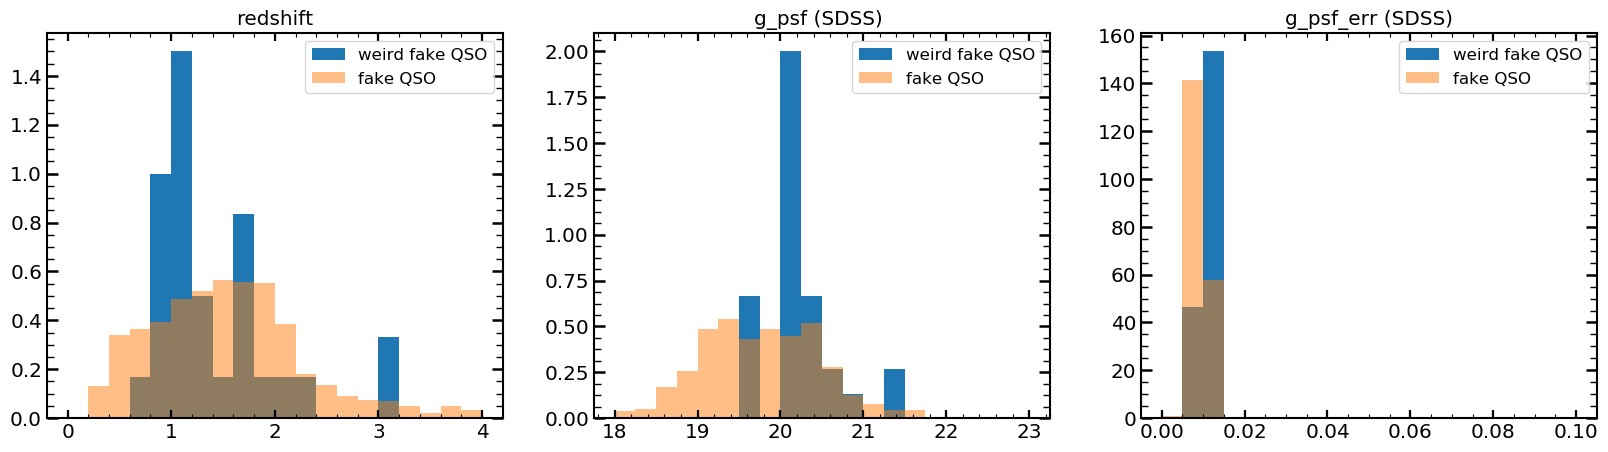

In [419]:
plt.figure(figsize=(20,5))

plt.subplot(131)

plt.hist(matched_array_fake_QSO_weird_objects[:,3].astype(float),density=True,stacked=True,range=(0,4),bins=20,label='weird fake QSO')
plt.hist(matched_array_fake_QSO[:,3].astype(float),density=True,stacked=True,alpha=0.5,range=(0,4),bins=20,label='fake QSO')
plt.title('redshift')
plt.legend()

plt.subplot(132)

plt.hist(matched_array_fake_QSO_weird_objects[:,4].astype(float),density=True,stacked=True,bins=20,range=(18,23),label='weird fake QSO')
plt.hist(matched_array_fake_QSO[:,4].astype(float),density=True,stacked=True,alpha=0.5,bins=20,range=(18,23),label='fake QSO')
plt.title('g_psf (SDSS) ')
plt.legend()

plt.subplot(133)

plt.hist(matched_array_fake_QSO_weird_objects[:,9].astype(float),density=True,bins=20,range=(0,0.1),label='weird fake QSO')
plt.hist(matched_array_fake_QSO[:,9].astype(float),density=True,alpha=0.5,bins=20,range=(0,0.1),label='fake QSO')
plt.title('g_psf_err (SDSS)')
plt.legend()

In [373]:
len(matched_array_fake_QSO[:,5])

5919

## investigation of the noisy feature

In [358]:
matched_array_fake_QSO_16_19=matched_array_fake_QSO[(matched_array_fake_QSO[:,3]>1.6)&(matched_array_fake_QSO[:,3]<1.9)]

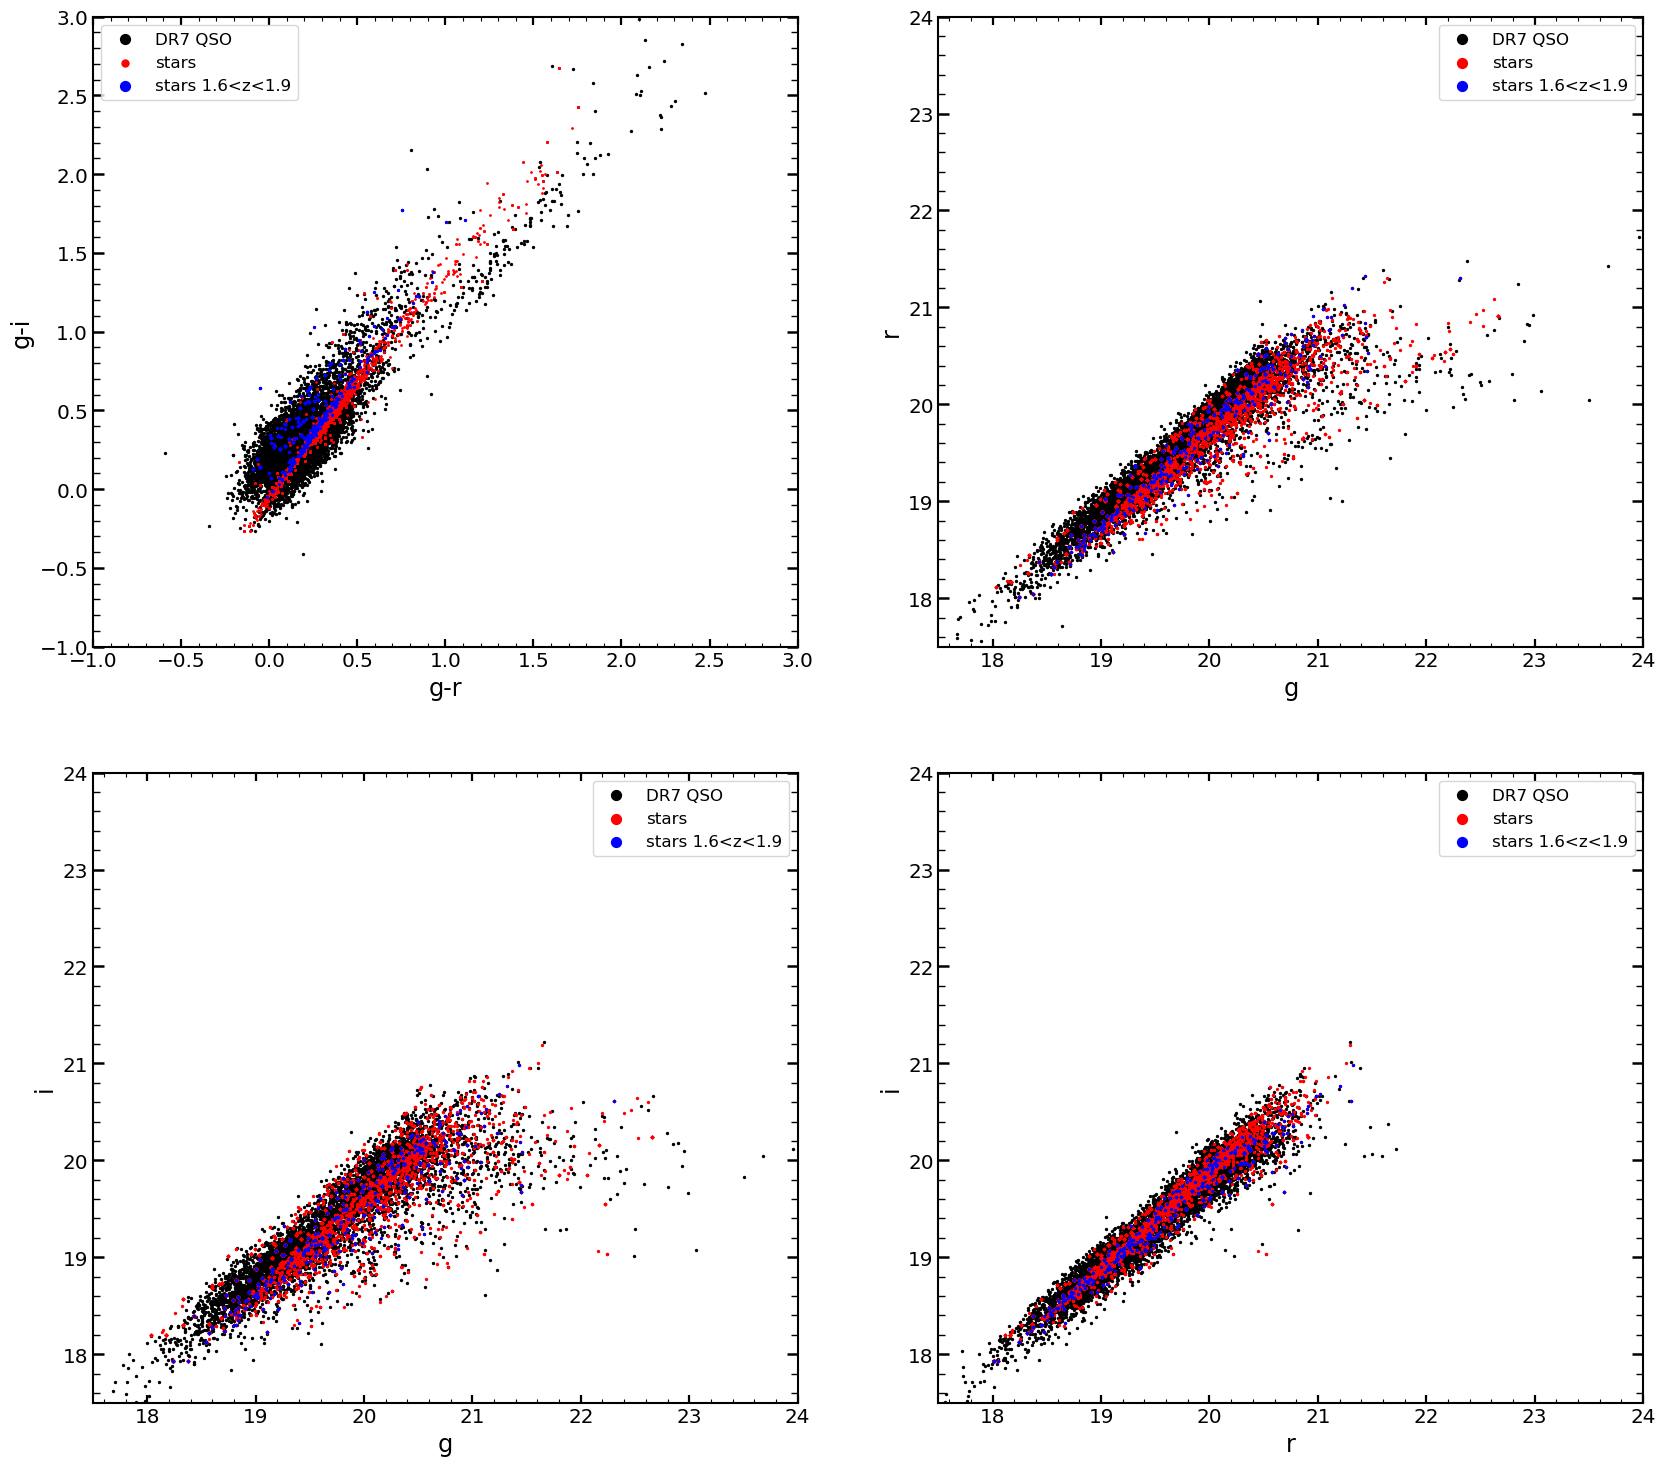

In [359]:
plt.figure(figsize=(20,18))

plt.subplot(2,2,1)
plt.scatter(matched_array[:,4]-matched_array[:,6],matched_array[:,4]-matched_array[:,8],s=2,label='DR7 QSO',color='black')
#plt.scatter(Stripe82stars.iloc[:,14].values-Stripe82stars.iloc[:,20].values,Stripe82stars.iloc[:,20].values-Stripe82stars.iloc[:,26].values,s=4,color='orange')
plt.scatter(matched_array_fake_QSO[:,4]-matched_array_fake_QSO[:,6],matched_array_fake_QSO[:,4]-matched_array_fake_QSO[:,8],s=1,label='stars',color='red')
plt.scatter(matched_array_fake_QSO_16_19[:,4]-matched_array_fake_QSO_16_19[:,6],
            matched_array_fake_QSO_16_19[:,4]-matched_array_fake_QSO_16_19[:,8],s=2,label='stars 1.6<z<1.9',color='blue')
plt.xlabel('g-r')
plt.ylabel('g-i')
plt.xlim(-1,3)
plt.ylim(-1,3)
plt.legend(markerscale=5)

plt.subplot(2,2,2)
plt.scatter(matched_array[:,4],matched_array[:,6],s=2,label='DR7 QSO',color='black')
plt.scatter(matched_array_fake_QSO[:,4],matched_array_fake_QSO[:,6],s=2,label='stars',color='red')
plt.scatter(matched_array_fake_QSO_16_19[:,4],matched_array_fake_QSO_16_19[:,6],s=2,label='stars 1.6<z<1.9',color='blue')

plt.xlabel('g')
plt.ylabel('r')
plt.xlim(17.5,24)
plt.ylim(17.5,24)
plt.legend(markerscale=5)

plt.subplot(2,2,3)
plt.scatter(matched_array[:,4],matched_array[:,8],s=2,label='DR7 QSO',color='black')
plt.scatter(matched_array_fake_QSO[:,4],matched_array_fake_QSO[:,8],s=2,label='stars',color='red')
plt.scatter(matched_array_fake_QSO_16_19[:,4],matched_array_fake_QSO_16_19[:,8],s=2,label='stars 1.6<z<1.9',color='blue')

plt.xlabel('g')
plt.ylabel('i')
plt.xlim(17.5,24)
plt.ylim(17.5,24)
plt.legend(markerscale=5)

plt.subplot(2,2,4)
plt.scatter(matched_array[:,6],matched_array[:,8],s=2,label='DR7 QSO',color='black')
plt.scatter(matched_array_fake_QSO[:,6],matched_array_fake_QSO[:,8],s=2,label='stars',color='red')
plt.scatter(matched_array_fake_QSO_16_19[:,6],matched_array_fake_QSO_16_19[:,8],s=2,label='stars 1.6<z<1.9',color='blue')

plt.xlabel('r')
plt.ylabel('i')
plt.xlim(17.5,24)
plt.ylim(17.5,24)
plt.legend(markerscale=5)

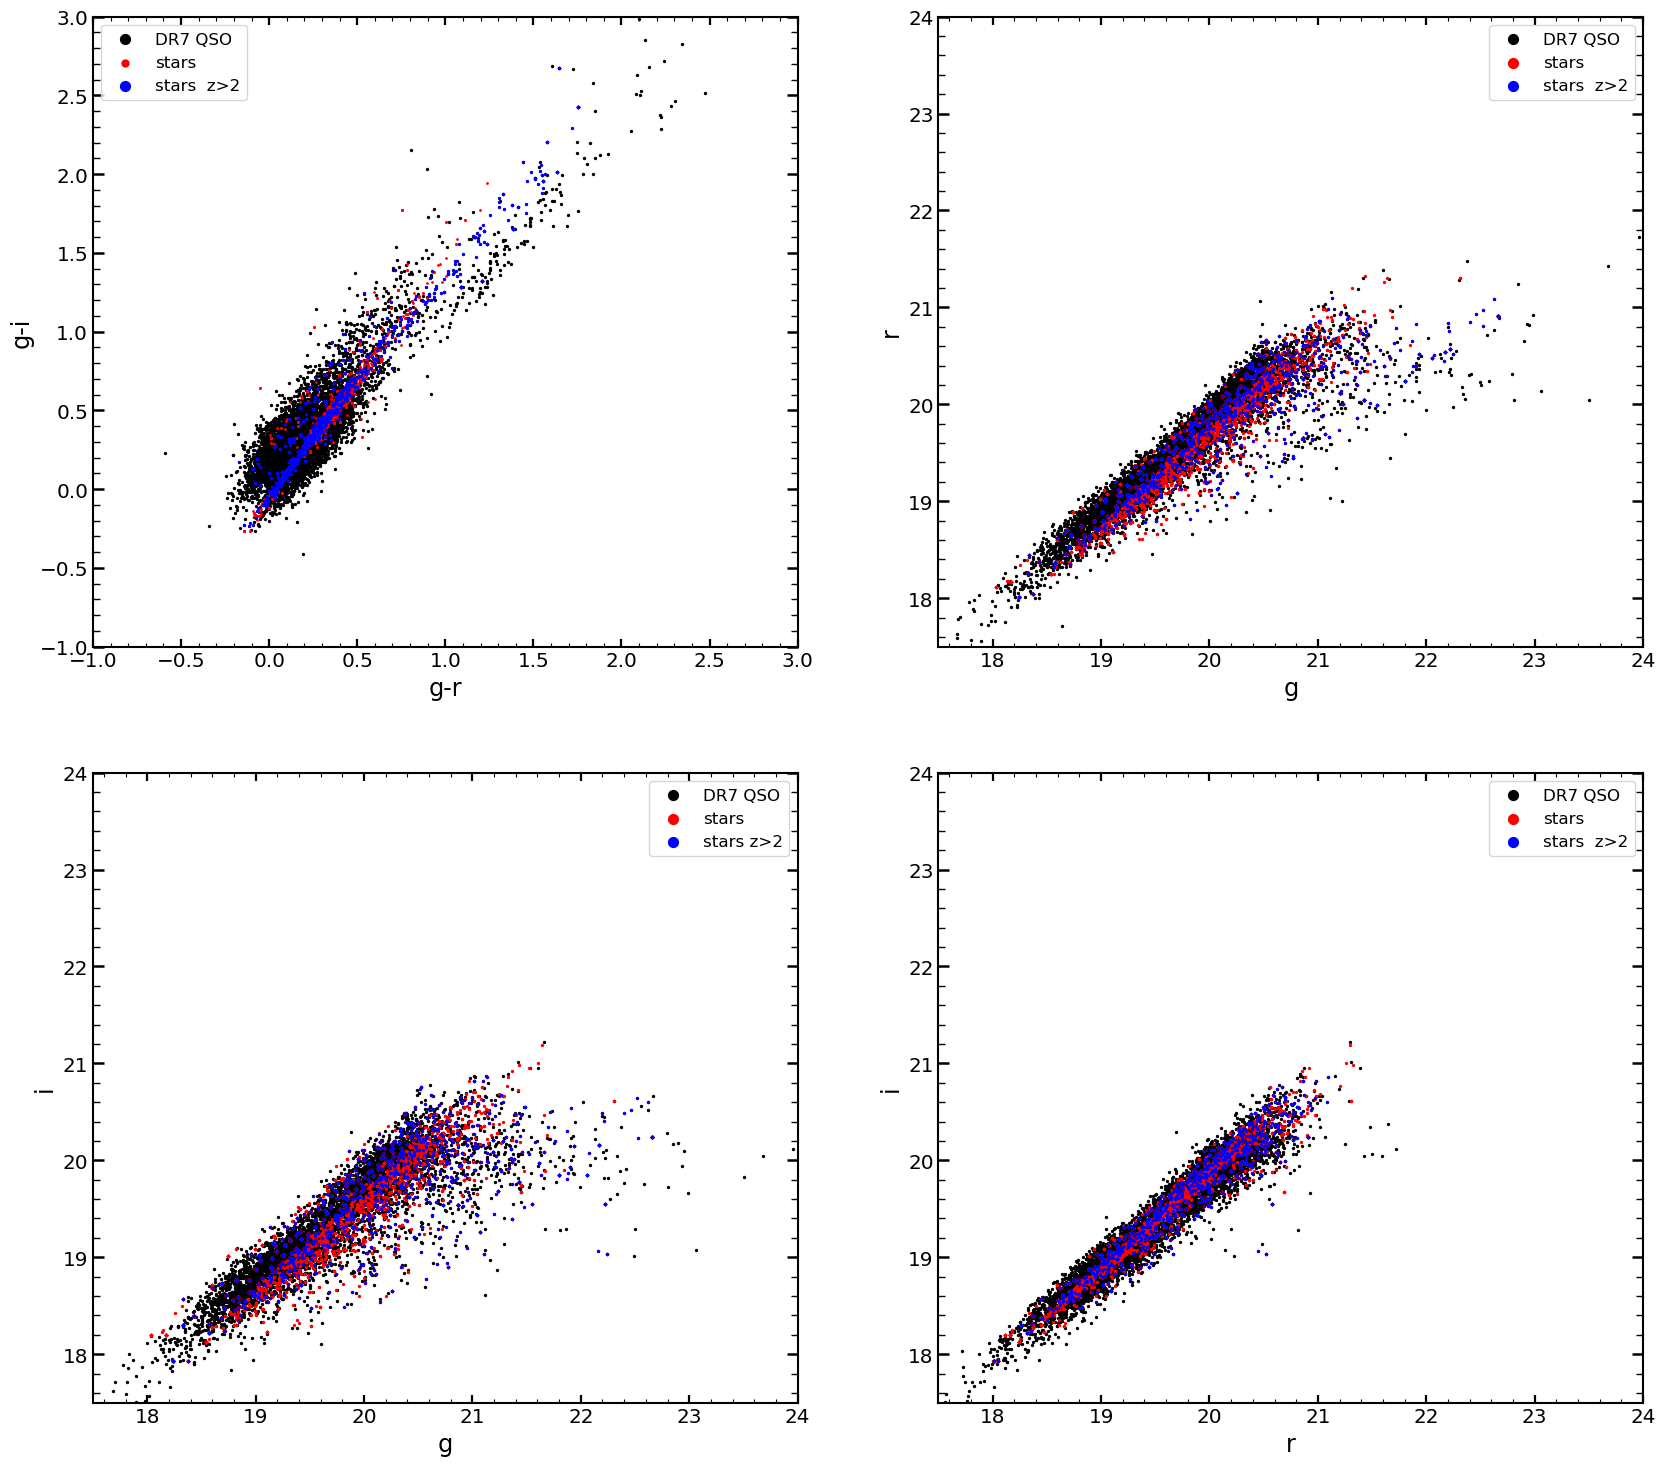

In [360]:
matched_array_fake_QSO_20plus=matched_array_fake_QSO[(matched_array_fake_QSO[:,3]>2)]

plt.figure(figsize=(20,18))

plt.subplot(2,2,1)
plt.scatter(matched_array[:,4]-matched_array[:,6],matched_array[:,4]-matched_array[:,8],s=2,label='DR7 QSO',color='black')
#plt.scatter(Stripe82stars.iloc[:,14].values-Stripe82stars.iloc[:,20].values,Stripe82stars.iloc[:,20].values-Stripe82stars.iloc[:,26].values,s=4,color='orange')
plt.scatter(matched_array_fake_QSO[:,4]-matched_array_fake_QSO[:,6],matched_array_fake_QSO[:,4]-matched_array_fake_QSO[:,8],s=1,label='stars',color='red')
plt.scatter(matched_array_fake_QSO_20plus[:,4]-matched_array_fake_QSO_20plus[:,6],
            matched_array_fake_QSO_20plus[:,4]-matched_array_fake_QSO_20plus[:,8],s=2,label='stars  z>2',color='blue')
plt.xlabel('g-r')
plt.ylabel('g-i')
plt.xlim(-1,3)
plt.ylim(-1,3)
plt.legend(markerscale=5)

plt.subplot(2,2,2)
plt.scatter(matched_array[:,4],matched_array[:,6],s=2,label='DR7 QSO',color='black')
plt.scatter(matched_array_fake_QSO[:,4],matched_array_fake_QSO[:,6],s=2,label='stars',color='red')
plt.scatter(matched_array_fake_QSO_20plus[:,4],matched_array_fake_QSO_20plus[:,6],s=2,label='stars  z>2',color='blue')

plt.xlabel('g')
plt.ylabel('r')
plt.xlim(17.5,24)
plt.ylim(17.5,24)
plt.legend(markerscale=5)

plt.subplot(2,2,3)
plt.scatter(matched_array[:,4],matched_array[:,8],s=2,label='DR7 QSO',color='black')
plt.scatter(matched_array_fake_QSO[:,4],matched_array_fake_QSO[:,8],s=2,label='stars',color='red')
plt.scatter(matched_array_fake_QSO_20plus[:,4],matched_array_fake_QSO_20plus[:,8],s=2,label='stars z>2',color='blue')

plt.xlabel('g')
plt.ylabel('i')
plt.xlim(17.5,24)
plt.ylim(17.5,24)
plt.legend(markerscale=5)

plt.subplot(2,2,4)
plt.scatter(matched_array[:,6],matched_array[:,8],s=2,label='DR7 QSO',color='black')
plt.scatter(matched_array_fake_QSO[:,6],matched_array_fake_QSO[:,8],s=2,label='stars',color='red')
plt.scatter(matched_array_fake_QSO_20plus[:,6],matched_array_fake_QSO_20plus[:,8],s=2,label='stars  z>2',color='blue')

plt.xlabel('r')
plt.ylabel('i')
plt.xlim(17.5,24)
plt.ylim(17.5,24)
plt.legend(markerscale=5)

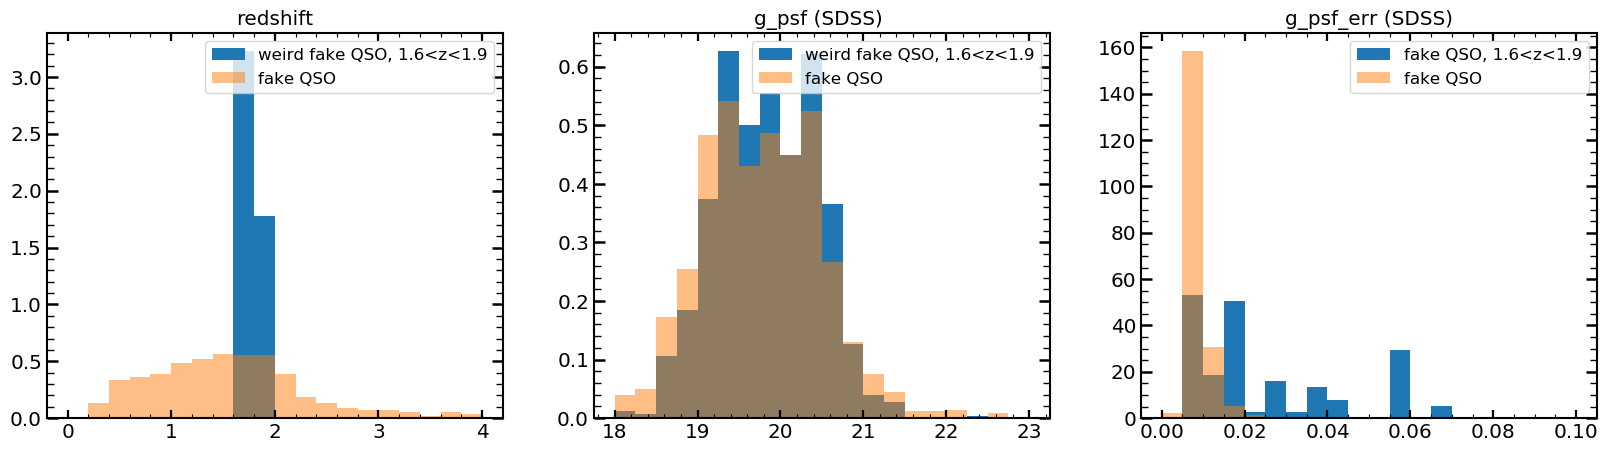

In [361]:
plt.figure(figsize=(20,5))

plt.subplot(131)

plt.hist(matched_array_fake_QSO_16_19[:,3].astype(float),density=True,stacked=True,range=(0,4),bins=20,label='weird fake QSO, 1.6<z<1.9')
plt.hist(matched_array_fake_QSO[:,3].astype(float),density=True,stacked=True,alpha=0.5,range=(0,4),bins=20,label='fake QSO')
plt.title('redshift')
plt.legend()

plt.subplot(132)

plt.hist(matched_array_fake_QSO_16_19[:,4].astype(float),density=True,stacked=True,bins=20,range=(18,23),label='weird fake QSO, 1.6<z<1.9')
plt.hist(matched_array_fake_QSO[:,4].astype(float),density=True,stacked=True,alpha=0.5,bins=20,range=(18,23),label='fake QSO')
plt.title('g_psf (SDSS) ')
plt.legend()

plt.subplot(133)

plt.hist(matched_array_fake_QSO_weird_objects[:,5].astype(float),density=True,stacked=True,bins=20,range=(0,0.1),label='fake QSO, 1.6<z<1.9')
plt.hist(matched_array_fake_QSO[:,5].astype(float),density=True,stacked=True,alpha=0.5,bins=20,range=(0,0.1),label='fake QSO')
plt.title('g_psf_err (SDSS)')
plt.legend()

In [426]:
matched_array_fake_QSO_that_much_dimmer=matched_array_fake_QSO[(matched_array_fake_QSO[:,14+4]-matched_array_fake_QSO[:,4])<-0.1]

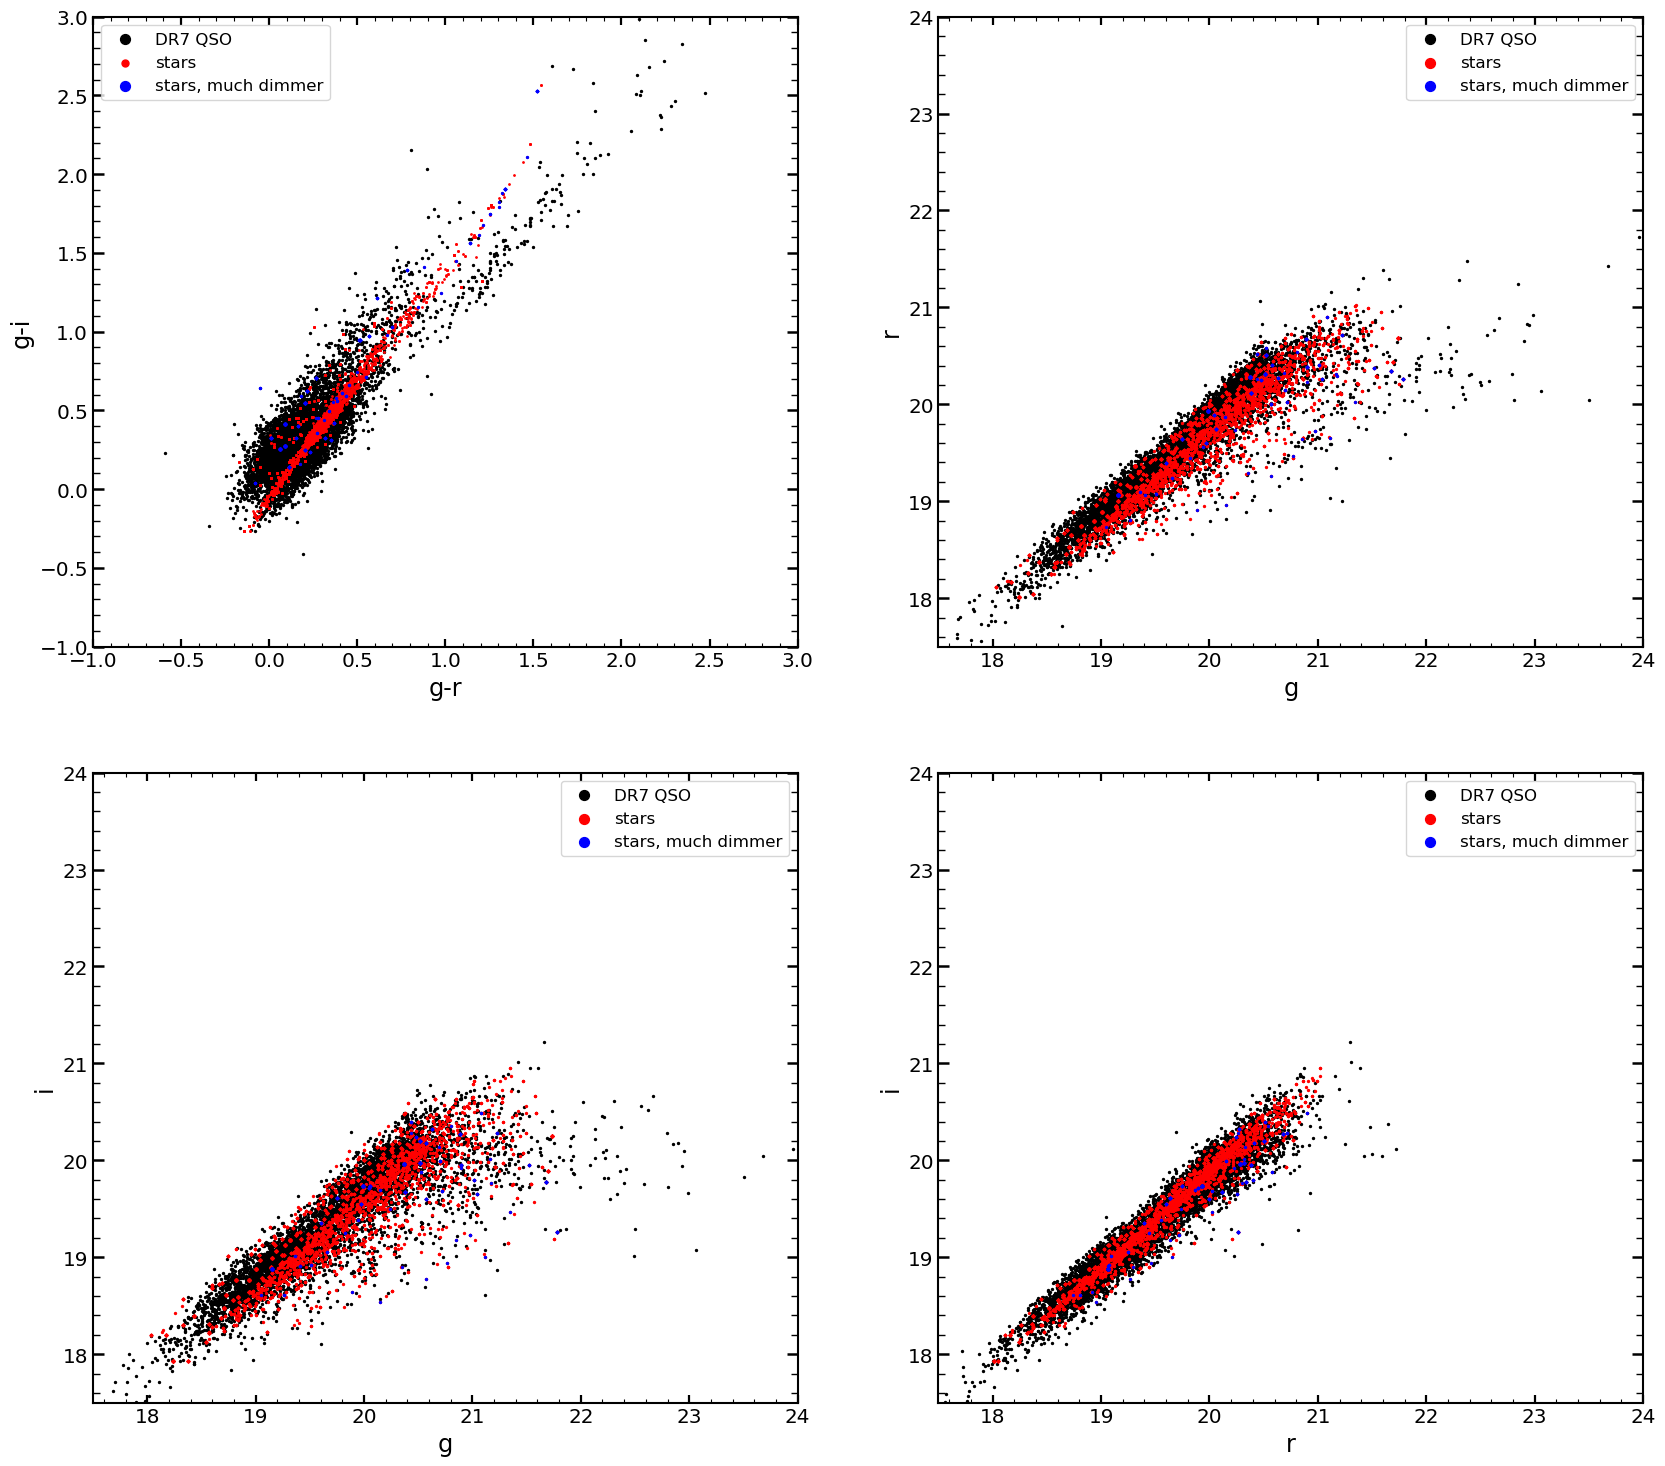

In [429]:
plt.figure(figsize=(20,18))

plt.subplot(2,2,1)
plt.scatter(matched_array[:,4]-matched_array[:,6],matched_array[:,4]-matched_array[:,8],s=2,label='DR7 QSO',color='black')
#plt.scatter(Stripe82stars.iloc[:,14].values-Stripe82stars.iloc[:,20].values,Stripe82stars.iloc[:,20].values-Stripe82stars.iloc[:,26].values,s=4,color='orange')
plt.scatter(matched_array_fake_QSO[:,4]-matched_array_fake_QSO[:,6],matched_array_fake_QSO[:,4]-matched_array_fake_QSO[:,8],s=1,label='stars',color='red')
plt.scatter(matched_array_fake_QSO_that_much_dimmer[:,4]-matched_array_fake_QSO_that_much_dimmer[:,6],
            matched_array_fake_QSO_that_much_dimmer[:,4]-matched_array_fake_QSO_that_much_dimmer[:,8],s=2,label='stars, much dimmer',color='blue')
plt.xlabel('g-r')
plt.ylabel('g-i')
plt.xlim(-1,3)
plt.ylim(-1,3)
plt.legend(markerscale=5)

plt.subplot(2,2,2)
plt.scatter(matched_array[:,4],matched_array[:,6],s=2,label='DR7 QSO',color='black')
plt.scatter(matched_array_fake_QSO[:,4],matched_array_fake_QSO[:,6],s=2,label='stars',color='red')
plt.scatter(matched_array_fake_QSO_that_much_dimmer[:,4],matched_array_fake_QSO_that_much_dimmer[:,6],s=2,label='stars, much dimmer',color='blue')

plt.xlabel('g')
plt.ylabel('r')
plt.xlim(17.5,24)
plt.ylim(17.5,24)
plt.legend(markerscale=5)

plt.subplot(2,2,3)
plt.scatter(matched_array[:,4],matched_array[:,8],s=2,label='DR7 QSO',color='black')
plt.scatter(matched_array_fake_QSO[:,4],matched_array_fake_QSO[:,8],s=2,label='stars',color='red')
plt.scatter(matched_array_fake_QSO_that_much_dimmer[:,4],matched_array_fake_QSO_that_much_dimmer[:,8],s=2,label='stars, much dimmer',color='blue')

plt.xlabel('g')
plt.ylabel('i')
plt.xlim(17.5,24)
plt.ylim(17.5,24)
plt.legend(markerscale=5)

plt.subplot(2,2,4)
plt.scatter(matched_array[:,6],matched_array[:,8],s=2,label='DR7 QSO',color='black')
plt.scatter(matched_array_fake_QSO[:,6],matched_array_fake_QSO[:,8],s=2,label='stars',color='red')
plt.scatter(matched_array_fake_QSO_that_much_dimmer[:,6],matched_array_fake_QSO_that_much_dimmer[:,8],s=2,label='stars, much dimmer',color='blue')

plt.xlabel('r')
plt.ylabel('i')
plt.xlim(17.5,24)
plt.ylim(17.5,24)
plt.legend(markerscale=5)

In [441]:
PositionOfQuasars_to_stars=[]
for j in tqdm(range(len(Positions_of_dr7))):
    PositionOfQuasars_to_stars.append(euclidean_distances([Positions_of_dr7[:,[0,1]][j]],matched_array_fake_QSO[:,[1,2]],))

100%|██████████| 105645/105645 [00:56<00:00, 1877.80it/s]


In [450]:
PositionOfQuasars_to_stars_min=[]
for j in tqdm(range(len(Positions_of_dr7))):
    PositionOfQuasars_to_stars_min.append(np.min(PositionOfQuasars_to_stars[j][0]))
    
PositionOfQuasars_to_stars_min=np.array(PositionOfQuasars_to_stars_min)

100%|██████████| 105645/105645 [00:01<00:00, 97837.64it/s]


In [454]:
len(PositionOfQuasars_to_stars_min[PositionOfQuasars_to_stars_min<0.01])

74

(array([62.,  0.,  2.,  1.,  0.,  2.,  1.,  2.,  1.,  3.]),
 array([0.        , 0.00096753, 0.00193506, 0.0029026 , 0.00387013,
        0.00483766, 0.00580519, 0.00677273, 0.00774026, 0.00870779,
        0.00967532]),
 <a list of 10 Patch objects>)

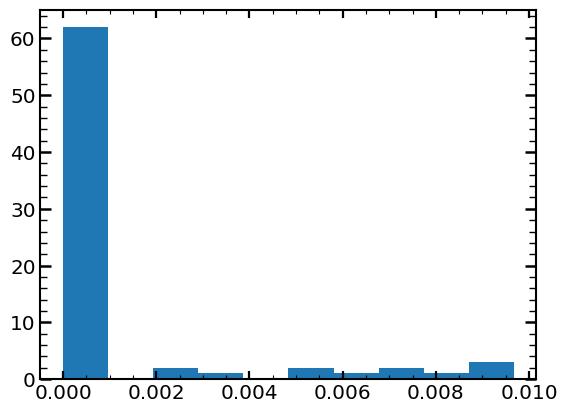

In [455]:
plt.hist(PositionOfQuasars_to_stars_min[PositionOfQuasars_to_stars_min<0.01])

# Comparison of QSO and fake QSO (SDSS - HSC)

## master plots

### g-band

In [57]:
# g-band
matched_array_filtered=np.load(DATA_DIRECTORY+'matched_array_filtered.npy') 
print(len(matched_array_filtered))
res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,res_delta_redshift_via_redshift_err_array,res_delta_redshift_via_redshift_median_err_array,\
res_redshift_array,p20_array,p20_median_array=create_redshift_result(matched_array_filtered,100,sdss_band_column=4,difference_sdss_HSC_columns=14)

5919


In [58]:
# g-band
matched_array_fake_QSO=np.load(DATA_DIRECTORY+'matched_array_fake_QSO.npy')
print(len(matched_array_fake_QSO))

res_delta_redshift_via_redshift_fake_QSO_array,res_delta_redshift_via_redshift_median_fake_QSO_array,res_delta_redshift_via_redshift_fake_QSO_err_array,res_delta_redshift_via_redshift_median_fake_QSO_err_array,\
res_redshift_fake_QSO_array,p20_fake_QSO_array,p20_median_fake_QSO_array=create_redshift_result(matched_array_fake_QSO,100,sdss_band_column=4,difference_sdss_HSC_columns=14)

2671


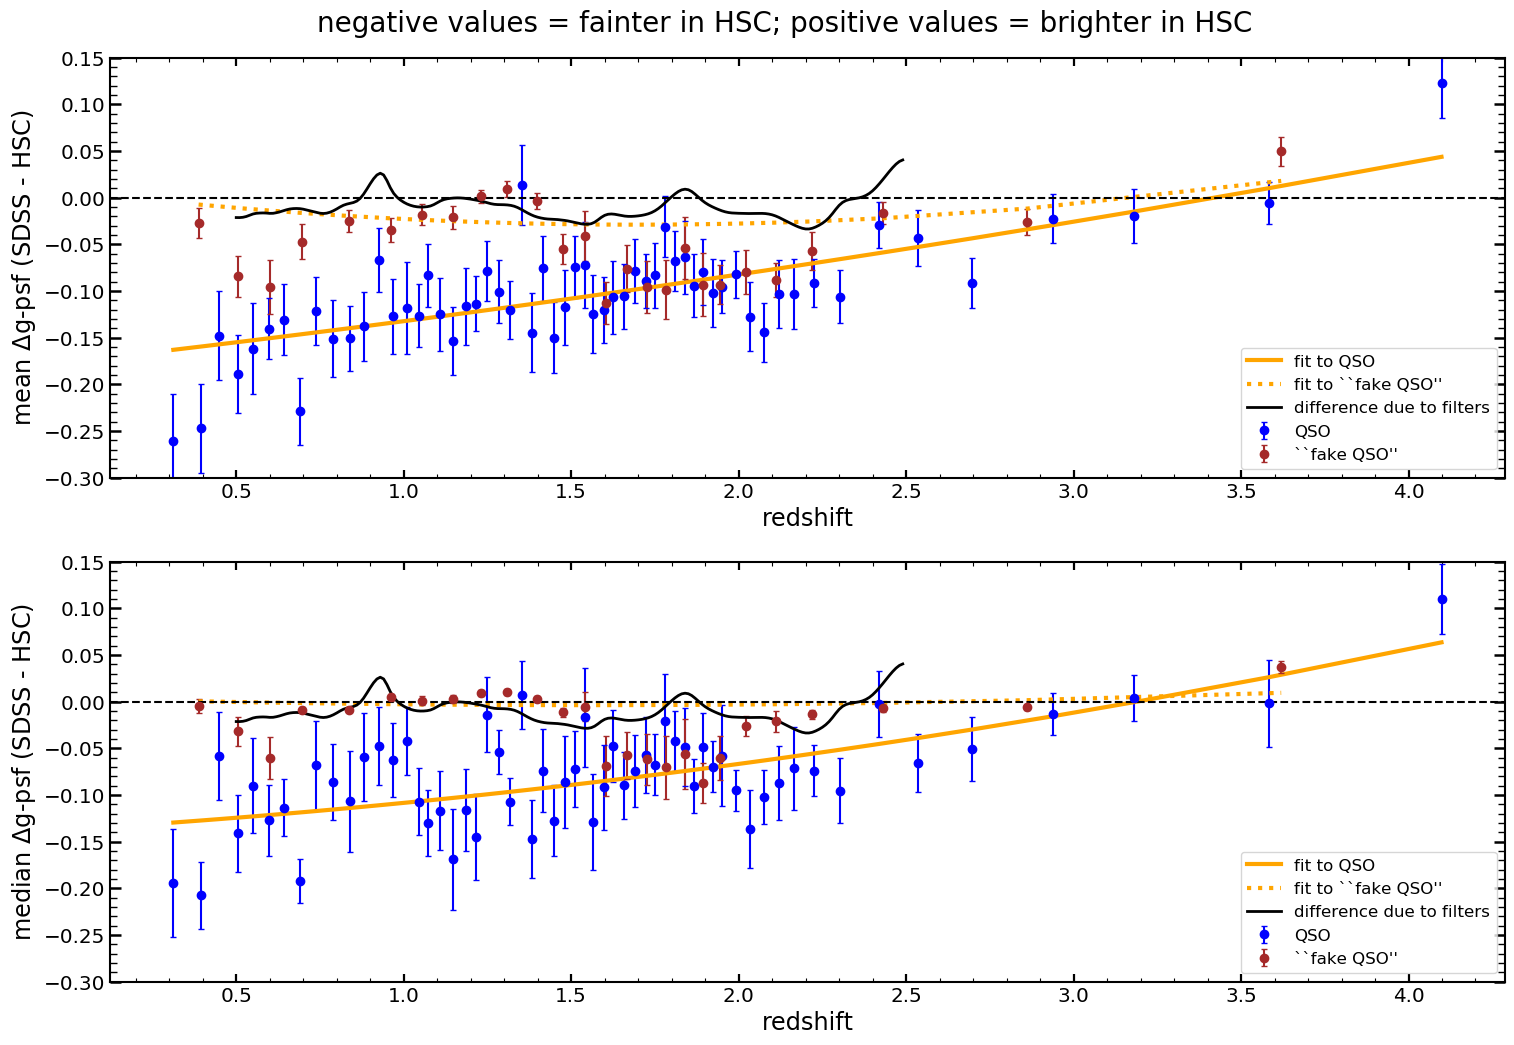

In [61]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)

plt.subplot(211)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_array[0],yerr=res_delta_redshift_via_redshift_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO')
plt.plot(res_redshift_array[0],p20_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to QSO')


plt.errorbar(res_redshift_fake_QSO_array[0],res_delta_redshift_via_redshift_fake_QSO_array[0],yerr=res_delta_redshift_via_redshift_fake_QSO_err_array[0],marker='o',capsize=2,ls='',color='brown',label='``fake QSO\'\' ')
plt.plot(res_redshift_fake_QSO_array[0],p20_fake_QSO_array[0](res_redshift_fake_QSO_array[0]),color='orange',lw=3,label='fit to ``fake QSO\'\' ',ls=':')


plt.plot(HSC_SDSS_filter_redshift_dependence_redshift,-HSC_SDSS_filter_redshift_dependence_dg_Vandenberk,ls='-',color='black',lw=2,label='difference due to filters')

plt.ylabel('mean $\Delta$g-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.3,0.15)
plt.axhline(0,color='black',ls='--')
plt.legend()

plt.subplot(212)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_median_array[0],yerr=res_delta_redshift_via_redshift_median_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO')
plt.plot(res_redshift_array[0],p20_median_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to QSO')

plt.errorbar(res_redshift_fake_QSO_array[0],res_delta_redshift_via_redshift_median_fake_QSO_array[0],yerr=res_delta_redshift_via_redshift_median_fake_QSO_err_array[0],marker='o',capsize=2,ls='',color='brown',label='``fake QSO\'\' ')
plt.plot(res_redshift_fake_QSO_array[0],p20_median_fake_QSO_array[0](res_redshift_fake_QSO_array[0]),ls=':',color='orange',lw=3,label='fit to ``fake QSO\'\'')

plt.plot(HSC_SDSS_filter_redshift_dependence_redshift,-HSC_SDSS_filter_redshift_dependence_dg_Vandenberk,ls='-',color='black',lw=2,label='difference due to filters')


plt.ylabel('median $\Delta$g-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.3,0.15)
plt.axhline(0,color='black',ls='--')
plt.legend()

### r-band

In [ ]:
# r-band
matched_array_filtered=np.load(DATA_DIRECTORY+'matched_array_filtered.npy') 
print(len(matched_array_filtered))
res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,res_delta_redshift_via_redshift_err_array,res_delta_redshift_via_redshift_median_err_array,\
res_redshift_array,p20_array,p20_median_array=create_redshift_result(matched_array_filtered,100,sdss_band_column=6,difference_sdss_HSC_columns=14)

In [ ]:
# r-band
matched_array_fake_QSO=np.load(DATA_DIRECTORY+'matched_array_fake_QSO.npy')
print(len(matched_array_fake_QSO))
matched_array_fake_QSO_r_band=matched_array_fake_QSO[matched_array_fake_QSO[:,6+14]>0]
print(len(matched_array_fake_QSO_r_band))

res_delta_redshift_via_redshift_fake_QSO_array,res_delta_redshift_via_redshift_median_fake_QSO_array,res_delta_redshift_via_redshift_fake_QSO_err_array,res_delta_redshift_via_redshift_median_fake_QSO_err_array,\
res_redshift_fake_QSO_array,p20_fake_QSO_array,p20_median_fake_QSO_array=create_redshift_result(matched_array_fake_QSO_r_band,100,sdss_band_column=6,difference_sdss_HSC_columns=14)

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)

plt.subplot(211)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_array[0],yerr=res_delta_redshift_via_redshift_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO')
plt.plot(res_redshift_array[0],p20_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to QSO')


plt.errorbar(res_redshift_fake_QSO_array[0],res_delta_redshift_via_redshift_fake_QSO_array[0],yerr=res_delta_redshift_via_redshift_fake_QSO_err_array[0],marker='o',capsize=2,ls='',color='brown',label='``fake QSO\'\' ')
plt.plot(res_redshift_fake_QSO_array[0],p20_fake_QSO_array[0](res_redshift_fake_QSO_array[0]),color='orange',lw=3,label='fit to ``fake QSO\'\' ',ls=':')


plt.plot(HSC_SDSS_filter_redshift_dependence_redshift,-HSC_SDSS_filter_redshift_dependence_dr_Vandenberk,ls='-',color='black',lw=2,label='difference due to filters')

plt.ylabel('mean $\Delta$r-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.3,0.15)
plt.axhline(0,color='black',ls='--')
plt.legend()

plt.subplot(212)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_median_array[0],yerr=res_delta_redshift_via_redshift_median_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO')
plt.plot(res_redshift_array[0],p20_median_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to QSO')

plt.errorbar(res_redshift_fake_QSO_array[0],res_delta_redshift_via_redshift_median_fake_QSO_array[0],yerr=res_delta_redshift_via_redshift_median_fake_QSO_err_array[0],marker='o',capsize=2,ls='',color='brown',label='``fake QSO\'\' ')
plt.plot(res_redshift_fake_QSO_array[0],p20_median_fake_QSO_array[0](res_redshift_fake_QSO_array[0]),ls=':',color='orange',lw=3,label='fit to ``fake QSO\'\'')

plt.plot(HSC_SDSS_filter_redshift_dependence_redshift,-HSC_SDSS_filter_redshift_dependence_dr_Vandenberk,ls='-',color='black',lw=2,label='difference due to filters')


plt.ylabel('median $\Delta$r-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.3,0.15)
plt.axhline(0,color='black',ls='--')
plt.legend()

### i-band

In [ ]:
# i-band
matched_array_filtered=np.load(DATA_DIRECTORY+'matched_array_filtered.npy') 
print(len(matched_array_filtered))
res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,res_delta_redshift_via_redshift_err_array,res_delta_redshift_via_redshift_median_err_array,\
res_redshift_array,p20_array,p20_median_array=create_redshift_result(matched_array_filtered,100,sdss_band_column=8,difference_sdss_HSC_columns=14)

In [ ]:
# i-band
matched_array_fake_QSO=np.load(DATA_DIRECTORY+'matched_array_fake_QSO.npy')
print(len(matched_array_fake_QSO))
matched_array_fake_QSO_i_band=matched_array_fake_QSO[matched_array_fake_QSO[:,8+14]>0]
print(len(matched_array_fake_QSO_i_band))




res_delta_redshift_via_redshift_fake_QSO_array,res_delta_redshift_via_redshift_median_fake_QSO_array,res_delta_redshift_via_redshift_fake_QSO_err_array,res_delta_redshift_via_redshift_median_fake_QSO_err_array,\
res_redshift_fake_QSO_array,p20_fake_QSO_array,p20_median_fake_QSO_array=create_redshift_result(matched_array_fake_QSO_i_band,100,sdss_band_column=8,difference_sdss_HSC_columns=14)

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)

plt.subplot(211)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_array[0],yerr=res_delta_redshift_via_redshift_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO')
plt.plot(res_redshift_array[0],p20_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to QSO')


plt.errorbar(res_redshift_fake_QSO_array[0],res_delta_redshift_via_redshift_fake_QSO_array[0],yerr=res_delta_redshift_via_redshift_fake_QSO_err_array[0],marker='o',capsize=2,ls='',color='brown',label='``fake QSO\'\' ')
plt.plot(res_redshift_fake_QSO_array[0],p20_fake_QSO_array[0](res_redshift_fake_QSO_array[0]),color='orange',lw=3,label='fit to ``fake QSO\'\' ',ls=':')


plt.plot(HSC_SDSS_filter_redshift_dependence_redshift,-HSC_SDSS_filter_redshift_dependence_di_Vandenberk,ls='-',color='black',lw=2,label='difference due to filters')

plt.ylabel('mean $\Delta$r-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.3,0.15)
plt.axhline(0,color='black',ls='--')
plt.legend()

plt.subplot(212)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_median_array[0],yerr=res_delta_redshift_via_redshift_median_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO')
plt.plot(res_redshift_array[0],p20_median_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to QSO')

plt.errorbar(res_redshift_fake_QSO_array[0],res_delta_redshift_via_redshift_median_fake_QSO_array[0],yerr=res_delta_redshift_via_redshift_median_fake_QSO_err_array[0],marker='o',capsize=2,ls='',color='brown',label='``fake QSO\'\' ')
plt.plot(res_redshift_fake_QSO_array[0],p20_median_fake_QSO_array[0](res_redshift_fake_QSO_array[0]),ls=':',color='orange',lw=3,label='fit to ``fake QSO\'\'')

plt.plot(HSC_SDSS_filter_redshift_dependence_redshift,-HSC_SDSS_filter_redshift_dependence_di_Vandenberk,ls='-',color='black',lw=2,label='difference due to filters')


plt.ylabel('median $\Delta$r-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.3,0.15)
plt.axhline(0,color='black',ls='--')
plt.legend()

## luminosity comparison

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)

plt.subplot(211)
"""
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_array[0],yerr=res_delta_redshift_via_redshift_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO')
plt.plot(res_redshift_array[0],p20_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to QSO')

plt.errorbar(res_redshift_fake_QSO_array[0],res_delta_redshift_via_redshift_fake_QSO_array[0],yerr=res_delta_redshift_via_redshift_fake_QSO_err_array[0],marker='o',capsize=2,ls='',color='brown',label='``fake QSO\'\' ')
plt.plot(res_redshift_fake_QSO_array[0],p20_fake_QSO_array[0](res_redshift_fake_QSO_array[0]),color='orange',lw=3,label='fit to ``fake QSO\'\' ',ls=':')
"""
plt.plot(res_redshift_array[1],p20_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=1,label='fit to top 20% QSO data')
plt.plot(res_redshift_array[2],p20_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=1,label='fit to 20%-40% QSO data')
plt.plot(res_redshift_array[3],p20_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=1,label='fit to 40%-60% QSO data')
plt.plot(res_redshift_array[4],p20_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=1,label='fit to 60%-80% QSO data')
plt.plot(res_redshift_array[5],p20_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=1,label='fit to 80%-100% QSO data')

# brightest
plt.plot(res_redshift_fake_QSO_array[1],p20_fake_QSO_array[1](res_redshift_fake_QSO_array[1]),ls=':',color='#e41a1c',alpha=1,label='fit to top 20% fake QSO data')
plt.plot(res_redshift_fake_QSO_array[2],p20_fake_QSO_array[2](res_redshift_fake_QSO_array[2]),ls=':',color='#377eb8',alpha=1,label='fit to 20%-40% fake QSO data')
plt.plot(res_redshift_fake_QSO_array[3],p20_fake_QSO_array[3](res_redshift_fake_QSO_array[3]),ls=':',color='#4daf4a',alpha=1,label='fit to 40%-60% fake QSO data')
plt.plot(res_redshift_fake_QSO_array[4],p20_fake_QSO_array[4](res_redshift_fake_QSO_array[4]),ls=':',color='#984ea3',alpha=1,label='fit to 60%-80% fake QSO data')
plt.plot(res_redshift_fake_QSO_array[5],p20_fake_QSO_array[5](res_redshift_fake_QSO_array[5]),ls=':',color='#a65628',alpha=1,label='fit to 80%-100% fake QSO data')


plt.ylabel('mean $\Delta$ g-band (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls=':')
plt.legend()

plt.subplot(212)
"""
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_median_array[0],yerr=res_delta_redshift_via_redshift_median_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO')
plt.plot(res_redshift_array[0],p20_median_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to QSO')

plt.errorbar(res_redshift_fake_QSO_array[0],res_delta_redshift_via_redshift_median_fake_QSO_array[0],yerr=res_delta_redshift_via_redshift_median_fake_QSO_err_array[0],marker='o',capsize=2,ls='',color='brown',label='``fake QSO\'\' ')
plt.plot(res_redshift_fake_QSO_array[0],p20_median_fake_QSO_array[0](res_redshift_fake_QSO_array[0]),ls=':',color='orange',lw=3,label='fit to ``fake QSO\'\'')
"""


plt.plot(res_redshift_array[1],p20_median_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=1,label='fit to top 20% QSO data')
plt.plot(res_redshift_array[2],p20_median_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=1,label='fit to 20%-40% QSO data')
plt.plot(res_redshift_array[3],p20_median_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=1,label='fit to 40%-60% QSO data')
plt.plot(res_redshift_array[4],p20_median_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=1,label='fit to 60%-80% QSO data')
plt.plot(res_redshift_array[5],p20_median_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=1,label='fit to 80%-100% QSO data')

plt.plot(res_redshift_fake_QSO_array[1],p20_median_fake_QSO_array[1](res_redshift_fake_QSO_array[1]),ls=':',color='#e41a1c',alpha=1,label='fit to top 20% fake QSO data')
plt.plot(res_redshift_fake_QSO_array[2],p20_median_fake_QSO_array[2](res_redshift_fake_QSO_array[2]),ls=':',color='#377eb8',alpha=1,label='fit to 20%-40% fake QSO data')
plt.plot(res_redshift_fake_QSO_array[3],p20_median_fake_QSO_array[3](res_redshift_fake_QSO_array[3]),ls=':',color='#4daf4a',alpha=1,label='fit to 40%-60% fake QSO data')
plt.plot(res_redshift_fake_QSO_array[4],p20_median_fake_QSO_array[4](res_redshift_fake_QSO_array[4]),ls=':',color='#984ea3',alpha=1,label='fit to 60%-80% fake QSO data')
plt.plot(res_redshift_fake_QSO_array[5],p20_median_fake_QSO_array[5](res_redshift_fake_QSO_array[5]),ls=':',color='#a65628',alpha=1,label='fit to 80%-100% fake QSO data')


plt.ylabel('median $\Delta$ g-band (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls=':')
plt.legend()

# PanSTARRS 

In [ ]:
# ask Chris about filter +
# ask him about flags and or errors

## initial analysis and 2d plots - everything

In [ ]:
# First table created - dr7_in_PanSTARSS2_nevencaplar.csv
# Second table created - dr7_in_PanSTARSS2_det_nevencaplar.csv
# Third table created - dr7_in_PanSTARSS2_det_force_nevencaplar.csv

In [ ]:
# This is dr7 qso catalog from https://classic.sdss.org/dr7/products/value_added/qsocat_dr7.html
dr7 = pd.read_csv(DATA_DIRECTORY+'dr7qso.dat',skiprows=80,sep='\s+',engine='python', error_bad_lines=False, header=None )
Positions_of_dr7=np.transpose([dr7[1].values,dr7[2].values])

In [ ]:
dr7_in_PanSTARSS2 = pd.read_csv('/Users/nevencaplar/Documents/Variability/HSC_Data/dr7_in_PanSTARSS2_nevencaplar.csv',skiprows=1,sep=',',engine='python', error_bad_lines=False, header=None )

In [ ]:
columns_PanSTARSS2=["CSSRA","CSSDec","objID","raMean","decMean","raMeanErr","decMeanErr","qualityFlag","gMeanPSFMag","gMeanPSFMagErr","gMeanPSFMagNpt","rMeanPSFMag","rMeanPSFMagErr","rMeanPSFMagNpt","iMeanPSFMag","iMeanPSFMagErr","iMeanPSFMagNpt","rMeanKronMag","rMeanKronMagErr","nDetections","ng","nr","ni","gFlags","gQfPerfect","rFlags","rQfPerfect","iFlags","iQfPerfect","primaryDetection","bestDetection"]

In [ ]:
dr7_in_PanSTARSS2.columns=columns_PanSTARSS2

In [ ]:
# this matches QSO from SDSS and resulting catalog from PanSTARRS
matched_array=[]
matched_array_failed_numbers=[]
for j in tqdm(range(len(Positions_of_dr7))):
    try:
        matched_array.append(np.concatenate((dr7.loc[j][[0,1,2,3,6,7,8,9,10,11]],(dr7_in_PanSTARSS2[dr7_in_PanSTARSS2['CSSRA'].values==Positions_of_dr7[j][0]][['raMean','decMean','gMeanPSFMag','gMeanPSFMagErr','rMeanPSFMag','rMeanPSFMagErr','iMeanPSFMag','iMeanPSFMagErr','objID']]).values[0])))
    except IndexError:
        matched_array_failed_numbers.append(j)

matched_array=np.array(matched_array)    
    

In [ ]:
matched_array_PanSTARRS_filtered=matched_array[(matched_array[:,4]>16)]

# getting only bright AGN, based on SDSS, becuase PanSTARRS is so shallow
matched_array_PanSTARRS_filtered_bright=matched_array[(matched_array[:,4]>16)&(matched_array[:,4]<20)]

np.save(DATA_DIRECTORY+'matched_array_PanSTARRS_filtered' ,matched_array_PanSTARRS_filtered)
np.save(DATA_DIRECTORY+'matched_array_PanSTARRS_filtered_bright' ,matched_array_PanSTARRS_filtered_bright)

In [ ]:
matched_array_PanSTARRS_filtered=np.load(DATA_DIRECTORY+'matched_array_PanSTARRS_filtered.npy')
len(matched_array_PanSTARRS_filtered)

In [ ]:
matched_array_PanSTARRS_filtered_bright=np.load(DATA_DIRECTORY+'matched_array_PanSTARRS_filtered_bright.npy')
len(matched_array_PanSTARRS_filtered_bright)

In [ ]:
# if you want to work with bright only - we overload the variable here
matched_array_PanSTARRS_filtered=matched_array_PanSTARRS_filtered_bright

In [ ]:
# plot differences using cmodel values from HSC
plt.figure(figsize=(20,6))
plt.subplot(131)

plt.scatter(matched_array_PanSTARRS_filtered[:,4],matched_array_PanSTARRS_filtered[:,8+4],s=1)
plt.scatter(matched_array_PanSTARRS_filtered[:,4][(matched_array_PanSTARRS_filtered[:,8+4]-matched_array_PanSTARRS_filtered[:,4])>1],matched_array_PanSTARRS_filtered[:,8+4][(matched_array_PanSTARRS_filtered[:,8+4]-matched_array_PanSTARRS_filtered[:,4])>1],s=2)
plt.scatter(matched_array_PanSTARRS_filtered[:,4][(matched_array_PanSTARRS_filtered[:,8+4]-matched_array_PanSTARRS_filtered[:,4])>2],matched_array_PanSTARRS_filtered[:,8+4][(matched_array_PanSTARRS_filtered[:,8+4]-matched_array_PanSTARRS_filtered[:,4])>2],s=3,color='red')

plt.xlabel('SDSS g magnitude')
plt.ylabel('PanSTARRS psf-model g magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(15,23)
plt.ylim(15,23)

plt.subplot(132)

plt.scatter(matched_array_PanSTARRS_filtered[:,6],matched_array_PanSTARRS_filtered[:,8+6],s=1)
plt.scatter(matched_array_PanSTARRS_filtered[:,6][(matched_array_PanSTARRS_filtered[:,8+4]-matched_array_PanSTARRS_filtered[:,4])>1],matched_array_PanSTARRS_filtered[:,8+6][(matched_array_PanSTARRS_filtered[:,8+4]-matched_array_PanSTARRS_filtered[:,4])>1],s=2)
plt.scatter(matched_array_PanSTARRS_filtered[:,6][(matched_array_PanSTARRS_filtered[:,8+4]-matched_array_PanSTARRS_filtered[:,4])>2],matched_array_PanSTARRS_filtered[:,8+6][(matched_array_PanSTARRS_filtered[:,8+4]-matched_array_PanSTARRS_filtered[:,4])>2],s=3,color='red')
plt.xlabel('SDSS r magnitude')
plt.ylabel('PanSTARRS psf-model r magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(15,23)
plt.ylim(15,23)

plt.subplot(133)

plt.scatter(matched_array_PanSTARRS_filtered[:,8],matched_array_PanSTARRS_filtered[:,8+8],s=1)
plt.scatter(matched_array_PanSTARRS_filtered[:,8][(matched_array_PanSTARRS_filtered[:,8+4]-matched_array_PanSTARRS_filtered[:,4])>1],matched_array_PanSTARRS_filtered[:,8+8][(matched_array_PanSTARRS_filtered[:,8+4]-matched_array_PanSTARRS_filtered[:,4])>1],s=2)
plt.scatter(matched_array_PanSTARRS_filtered[:,8][(matched_array_PanSTARRS_filtered[:,8+4]-matched_array_PanSTARRS_filtered[:,4])>2],matched_array_PanSTARRS_filtered[:,8+8][(matched_array_PanSTARRS_filtered[:,8+4]-matched_array_PanSTARRS_filtered[:,4])>2],s=3,color='red')
plt.xlabel('SDSS i magnitude')
plt.ylabel('PanSTARRS psf-model i magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(15,23)
plt.ylim(15,23)

In [ ]:
# sdss psf-g band mag - PanSTARRS psf-g band mag
g_mag_PanSTARRS_dif=(matched_array_PanSTARRS_filtered[:,4]-matched_array_PanSTARRS_filtered[:,8+4]).astype(float)

# error sdss g band mag - PanSTARRS g band mag
g_mag_PanSTARRS_dif_err=np.sqrt(((matched_array_PanSTARRS_filtered[:,5]).astype(float))**2+((matched_array_PanSTARRS_filtered[:,8+5]).astype(float))**2)

In [ ]:
# insert differences in the catalog
matched_array_filtered_PanSTARRS_with_g_mag_dif=np.insert(matched_array_PanSTARRS_filtered, 4, g_mag_PanSTARRS_dif, axis=1)
matched_array_filtered_PanSTARRS_with_g_mag_dif_and_err=np.insert(matched_array_filtered_PanSTARRS_with_g_mag_dif, 5, g_mag_PanSTARRS_dif_err, axis=1)

np.save("/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_filtered_PanSTARRS_with_g_mag_dif_and_err.npy",matched_array_filtered_PanSTARRS_with_g_mag_dif_and_err)

## redshift analysis - everything

In [ ]:
matched_array_PanSTARRS_filtered_bright=np.load(DATA_DIRECTORY+'matched_array_PanSTARRS_filtered_bright.npy')
len(matched_array_PanSTARRS_filtered_bright)

In [ ]:
matched_array_filtered_PanSTARRS_with_g_mag_dif_and_err=np.load('/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_filtered_PanSTARRS_with_g_mag_dif_and_err.npy')

In [ ]:
# g-band
res_delta_redshift_via_redshift_PanSTARRS_array,res_delta_redshift_via_redshift_median_PanSTARRS_array,res_delta_redshift_via_redshift_err_PanSTARRS_array,\
res_delta_redshift_via_redshift_median_err_PanSTARRS_array,res_redshift_PanSTARRS_array,p20_PanSTARRS_array,\
p20_median_PanSTARRS_array=create_redshift_result(matched_array_PanSTARRS_filtered_bright,1000,sdss_band_column=4,difference_sdss_HSC_columns=8)

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative values = fainter in PanSTARRS; positive values = brighter in PanSTARRS',y=0.92,fontsize=20)

plt.subplot(211)
plt.errorbar(res_redshift_PanSTARRS_array[0],res_delta_redshift_via_redshift_PanSTARRS_array[0],yerr=res_delta_redshift_via_redshift_err_PanSTARRS_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO data')
plt.plot(res_redshift_PanSTARRS_array[0],p20_PanSTARRS_array[0](res_redshift_PanSTARRS_array[0]),ls='-',color='orange',lw=3,label='fit to all QSO data')

# brightest
plt.plot(res_redshift_PanSTARRS_array[1],p20_PanSTARRS_array[1](res_redshift_PanSTARRS_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
plt.plot(res_redshift_PanSTARRS_array[2],p20_PanSTARRS_array[2](res_redshift_PanSTARRS_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
plt.plot(res_redshift_PanSTARRS_array[3],p20_PanSTARRS_array[3](res_redshift_PanSTARRS_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
plt.plot(res_redshift_PanSTARRS_array[4],p20_PanSTARRS_array[4](res_redshift_PanSTARRS_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
plt.plot(res_redshift_PanSTARRS_array[5],p20_PanSTARRS_array[5](res_redshift_PanSTARRS_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')


plt.ylabel('mean $\Delta$r-psf (SDSS - PanSTARRS)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

plt.subplot(212)
plt.errorbar(res_redshift_PanSTARRS_array[0],res_delta_redshift_via_redshift_median_PanSTARRS_array[0],yerr=res_delta_redshift_via_redshift_median_err_PanSTARRS_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO data')
plt.plot(res_redshift_PanSTARRS_array[0],p20_median_PanSTARRS_array[0](res_redshift_PanSTARRS_array[0]),ls='-',color='orange',lw=3,label='fit to all QSO data')


plt.plot(res_redshift_PanSTARRS_array[1],p20_median_PanSTARRS_array[1](res_redshift_PanSTARRS_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
plt.plot(res_redshift_PanSTARRS_array[2],p20_median_PanSTARRS_array[2](res_redshift_PanSTARRS_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
plt.plot(res_redshift_PanSTARRS_array[3],p20_median_PanSTARRS_array[3](res_redshift_PanSTARRS_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
plt.plot(res_redshift_PanSTARRS_array[4],p20_median_PanSTARRS_array[4](res_redshift_PanSTARRS_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
plt.plot(res_redshift_PanSTARRS_array[5],p20_median_PanSTARRS_array[5](res_redshift_PanSTARRS_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')

plt.ylabel('median $\Delta$r-psf (SDSS - PanSTARRS)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

## PanSTARRS, but only those that have been captured in HSC as well - flags?

### matching 

In [ ]:
# import the QSO that have been found in HSC
dr7_in_HSC = pd.read_csv(DATA_DIRECTORY+'194782.csv')
# give ra and dec
Positions_of_dr7_in_HSC=np.transpose([dr7_in_HSC['# ra'].values,dr7_in_HSC['dec'].values])

In [ ]:
matched_array_PanSTARRS_filtered_bright=np.load(DATA_DIRECTORY+'matched_array_PanSTARRS_filtered.npy')
# if you want to work with bright only - we overload the variable here
matched_array_PanSTARRS_filtered=matched_array_PanSTARRS_filtered_bright

In [ ]:
# positions of dr7 AGN in PanSTARRS survey
Positions_of_dr7_in_PanSTARRS_filtered=matched_array_PanSTARRS_filtered[:,[1,2]]

In [ ]:
# when matching only bright you do not get all objects!
match_HSC_PanSTARRS_result=match_two_catalogs(Positions_of_dr7_in_HSC,Positions_of_dr7_in_PanSTARRS_filtered)
match_HSC_PanSTARRS_result=np.array(match_HSC_PanSTARRS_result)

# PanSTARRS
#matched_array_filtered_PanSTARRS_with_g_mag_dif_and_err_matched_to_HSC=matched_array_filtered_PanSTARRS_with_g_mag_dif_and_err[match_HSC_PanSTARRS_result[:,1]]
matched_array_filtered_PanSTARRS_matched_to_HSC=matched_array_PanSTARRS_filtered[match_HSC_PanSTARRS_result[:,1]]

np.save("/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_filtered_PanSTARRS_matched_to_HSC.npy",matched_array_filtered_PanSTARRS_matched_to_HSC)
#np.save("/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_filtered_PanSTARRS_with_g_mag_dif_and_err_matched_to_HSC.npy",matched_array_filtered_PanSTARRS_with_g_mag_dif_and_err_matched_to_HSC)

In [ ]:
matched_array_filtered=np.load(DATA_DIRECTORY+'matched_array_filtered.npy')

# find objects in HSC that are bright enough for PanSTARSS
matched_array_filtered_both_PanSTARSS_bright_and_HSC=[]
for i in range(len(matched_array_filtered_PanSTARRS_matched_to_HSC)):
    try:
        matched_array_filtered_both_PanSTARSS_bright_and_HSC.append((matched_array_filtered[matched_array_filtered[:,1]==matched_array_filtered_PanSTARRS_matched_to_HSC[i][1]])[0])
    except:
        pass

matched_array_filtered_both_PanSTARSS_bright_and_HSC=np.array(matched_array_filtered_both_PanSTARSS_bright_and_HSC)

np.save("/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_filtered_both_PanSTARSS_bright_and_HSC.npy",matched_array_filtered_both_PanSTARSS_bright_and_HSC)




"""
matched_array_filtered_with_g_mag_dif_and_err_both_PanSTARSS_bright_and_HSC=[]
for i in range(len(matched_array_filtered_PanSTARRS_with_g_mag_dif_and_err_matched_to_HSC)):
    try:
        matched_array_filtered_with_g_mag_dif_and_err_both_PanSTARSS_bright_and_HSC.append((matched_array_filtered_with_g_mag_dif_and_err[matched_array_filtered_with_g_mag_dif_and_err[:,1]==matched_array_filtered_PanSTARRS_with_g_mag_dif_and_err_matched_to_HSC[i][1]])[0])
    except:
        pass

matched_array_filtered_with_g_mag_dif_and_err_both_PanSTARSS_bright_and_HSC=np.array(matched_array_filtered_with_g_mag_dif_and_err_both_PanSTARSS_bright_and_HSC)

np.save("/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_filtered_with_g_mag_dif_and_err_both_PanSTARSS_bright_and_HSC.npy",matched_array_filtered_with_g_mag_dif_and_err_both_PanSTARSS_bright_and_HSC)
"""

### analysing - need to add luminosity effect analysis

In [ ]:
matched_array_filtered_PanSTARRS_matched_to_HSC=np.load("/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_filtered_PanSTARRS_matched_to_HSC.npy")
matched_array_filtered_both_PanSTARSS_bright_and_HSC=np.load('/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_filtered_both_PanSTARSS_bright_and_HSC.npy')

matched_array_filtered_PanSTARRS_with_g_mag_dif_and_err_matched_to_HSC=np.load("/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_filtered_PanSTARRS_with_g_mag_dif_and_err_matched_to_HSC.npy")
matched_array_filtered_with_g_mag_dif_and_err_both_PanSTARSS_bright_and_HSC=np.load('/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_filtered_with_g_mag_dif_and_err_both_PanSTARSS_bright_and_HSC.npy')

In [ ]:
# g-band
res_delta_redshift_via_redshift_PanSTARRS_matched_to_HSC_array,res_delta_redshift_via_redshift_median_PanSTARRS_matched_to_HSC_array,\
res_delta_redshift_via_redshift_err_PanSTARRS_matched_to_HSC_array,res_delta_redshift_via_redshift_median_err_PanSTARRS_matched_to_HSC_array,\
res_redshift_PanSTARRS_matched_to_HSC_array,p20_PanSTARRS_matched_to_HSC_array,p20_median_PanSTARRS_matched_to_HSC_array=\
create_redshift_result(matched_array_filtered_PanSTARRS_matched_to_HSC,100,sdss_band_column=4,difference_sdss_HSC_columns=8)

# g-band
res_delta_redshift_via_redshift_both_PanSTARSS_bright_and_HSC_array,res_delta_redshift_via_redshift_median_both_PanSTARSS_bright_and_HSC_array,\
res_delta_redshift_via_redshift_err_both_PanSTARSS_bright_and_HSC_array,res_delta_redshift_via_redshift_median_err_both_PanSTARSS_bright_and_HSC_array,\
res_redshift_both_PanSTARSS_bright_and_HSC_array,p20_both_PanSTARSS_bright_and_HSC_array,\
p20_median_both_PanSTARSS_bright_and_HSC_array=create_redshift_result(matched_array_filtered_both_PanSTARSS_bright_and_HSC,100,sdss_band_column=4,difference_sdss_HSC_columns=14)

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative values = fainter in respective survey; positive values = brighter in respective survey',y=0.92,fontsize=20)

plt.subplot(211)
plt.errorbar(res_redshift_PanSTARRS_matched_to_HSC_array[0],res_delta_redshift_via_redshift_PanSTARRS_matched_to_HSC_array[0],
             yerr=res_delta_redshift_via_redshift_err_PanSTARRS_matched_to_HSC_array[0],marker='o',capsize=2,ls='',color='brown',label='PanSTARRS, QSO data')
plt.plot(res_redshift_PanSTARRS_matched_to_HSC_array[0],p20_PanSTARRS_matched_to_HSC_array[0](res_redshift_PanSTARRS_matched_to_HSC_array[0]),color='orange',lw=3,ls=':',label='fit to PanSTARRS QSO data')

plt.errorbar(res_redshift_both_PanSTARSS_bright_and_HSC_array[0],res_delta_redshift_via_redshift_both_PanSTARSS_bright_and_HSC_array[0],
             yerr=res_delta_redshift_via_redshift_err_both_PanSTARSS_bright_and_HSC_array[0],marker='o',capsize=2,ls='',color='blue',label='HSC, QSO data')
plt.plot(res_redshift_both_PanSTARSS_bright_and_HSC_array[0],p20_both_PanSTARSS_bright_and_HSC_array[0](res_redshift_both_PanSTARSS_bright_and_HSC_array[0]),ls='-',color='orange',lw=3,label='fit to HSC QSO data')

# brightest
plt.plot(res_redshift_PanSTARRS_matched_to_HSC_array[1],p20_PanSTARRS_matched_to_HSC_array[1](res_redshift_PanSTARRS_matched_to_HSC_array[1]),ls=':',color='#e41a1c',alpha=0.5,label='fit to top 20% PanSTARRS QSO data')
plt.plot(res_redshift_PanSTARRS_matched_to_HSC_array[5],p20_PanSTARRS_matched_to_HSC_array[5](res_redshift_PanSTARRS_matched_to_HSC_array[5]),ls=':'
         ,color='#a65628',alpha=0.5,label='fit to 80%-100% PanSTARRS QSO data')

#plt.plot(res_redshift_PanSTARRS_array[2],p20_PanSTARRS_array[2](res_redshift_PanSTARRS_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
#plt.plot(res_redshift_PanSTARRS_array[3],p20_PanSTARRS_array[3](res_redshift_PanSTARRS_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
#plt.plot(res_redshift_PanSTARRS_array[4],p20_PanSTARRS_array[4](res_redshift_PanSTARRS_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
#plt.plot(res_redshift_PanSTARRS_array[5],p20_PanSTARRS_array[5](res_redshift_PanSTARRS_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')
plt.plot(res_redshift_both_PanSTARSS_bright_and_HSC_array[1],p20_both_PanSTARSS_bright_and_HSC_array[1](res_redshift_both_PanSTARSS_bright_and_HSC_array[1]),ls='-',color='#e41a1c',alpha=0.5,label='fit to top 20% HSC QSO data')
plt.plot(res_redshift_both_PanSTARSS_bright_and_HSC_array[5],p20_both_PanSTARSS_bright_and_HSC_array[5](res_redshift_both_PanSTARSS_bright_and_HSC_array[5]),ls='-'
         ,color='#a65628',alpha=0.5,label='fit to 80%-100% HSC QSO data')

plt.ylabel('mean $\Delta$r-psf (SDSS - PanSTARRS)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

plt.subplot(212)
plt.errorbar(res_redshift_PanSTARRS_matched_to_HSC_array[0],res_delta_redshift_via_redshift_median_PanSTARRS_matched_to_HSC_array[0],
             yerr=res_delta_redshift_via_redshift_median_err_PanSTARRS_matched_to_HSC_array[0],marker='o',capsize=2,ls='',color='brown',label='PanSTARRS, QSO data')
plt.plot(res_redshift_PanSTARRS_matched_to_HSC_array[0],p20_median_PanSTARRS_matched_to_HSC_array[0](res_redshift_PanSTARRS_matched_to_HSC_array[0]),ls=':',color='orange',lw=3,label='fit to PanSTARRS QSO data')

plt.errorbar(res_redshift_both_PanSTARSS_bright_and_HSC_array[0],res_delta_redshift_via_redshift_median_both_PanSTARSS_bright_and_HSC_array[0],
             yerr=res_delta_redshift_via_redshift_median_err_both_PanSTARSS_bright_and_HSC_array[0],marker='o',capsize=2,ls='',color='blue',label='HSC, QSO data')
plt.plot(res_redshift_both_PanSTARSS_bright_and_HSC_array[0],p20_median_both_PanSTARSS_bright_and_HSC_array[0](res_redshift_both_PanSTARSS_bright_and_HSC_array[0]),ls='-',color='orange',lw=3,label='fit to HSC QSO data')

#plt.plot(res_redshift_PanSTARRS_array[1],p20_median_PanSTARRS_array[1](res_redshift_PanSTARRS_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
#plt.plot(res_redshift_PanSTARRS_array[2],p20_median_PanSTARRS_array[2](res_redshift_PanSTARRS_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
#plt.plot(res_redshift_PanSTARRS_array[3],p20_median_PanSTARRS_array[3](res_redshift_PanSTARRS_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
#plt.plot(res_redshift_PanSTARRS_array[4],p20_median_PanSTARRS_array[4](res_redshift_PanSTARRS_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
#plt.plot(res_redshift_PanSTARRS_array[5],p20_median_PanSTARRS_array[5](res_redshift_PanSTARRS_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')

plt.ylabel('median $\Delta$r-psf (SDSS - PanSTARRS)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

### old code, not exactly the same result

In [ ]:
# array with has delta g as the first column, redshift as the second column
delta_g_and_redshift_PanSTARRS_matched_to_HSC=matched_array_filtered_PanSTARRS_with_g_mag_dif_and_err_matched_to_HSC[:,[4,3]]

In [ ]:
# array which has only bright objects which are found in both HSC and PanSTARRS
# array with has delta g as the first column, redshift as the second column
delta_g_and_redshift_HSC_matched_to_PanSTARRS_matched_to_HSC=matched_array_filtered_with_g_mag_dif_and_err_both_PanSTARSS_bright_and_HSC[:,[4,3]]

In [ ]:
len(delta_g_and_redshift_PanSTARRS_sorted_by_redshift_g_and_split_matched_to_HSC)

In [ ]:
# first array, sorted by redshift first and then split in bins, 100 objects in each bin
delta_g_and_redshift_PanSTARRS_sorted_by_redshift_g_and_split_matched_to_HSC=np.array_split(delta_g_and_redshift_PanSTARRS_matched_to_HSC[np.argsort(delta_g_and_redshift_PanSTARRS_matched_to_HSC[:,1])],
                                                                                            int(len(delta_g_and_redshift_PanSTARRS_matched_to_HSC)/100))

# second array, sorted by redshift first and then split in bins, 100 objects in each bin
delta_g_and_redshift_HSC_sorted_by_redshift_g_and_split_matched_to_PanSTARRS=np.array_split(delta_g_and_redshift_HSC_matched_to_PanSTARRS_matched_to_HSC[np.argsort(delta_g_and_redshift_HSC_matched_to_PanSTARRS_matched_to_HSC[:,1])],
                                                                                            int(len(delta_g_and_redshift_HSC_matched_to_PanSTARRS_matched_to_HSC)/100))

In [ ]:
# full array
res_delta_redshift_via_redshift_PanSTARRS_matched_to_HSC,res_delta_redshift_via_redshift_PanSTARRS_median_matched_to_HSC,res_delta_redshift_via_redshift_PanSTARRS_matched_to_HSC_err,\
res_delta_redshift_via_redshift_PanSTARRS_median_matched_to_HSC_err,res_redshift_PanSTARRS_matched_to_HSC=create_res_delta(delta_g_and_redshift_PanSTARRS_sorted_by_redshift_g_and_split_matched_to_HSC)    
   
res_delta_redshift_via_redshift_HSC_matched_to_PanSTARRS,res_delta_redshift_via_redshift_HSC_median_matched_to_PanSTARRS,res_delta_redshift_via_redshift_HSC_matched_to_PanSTARRS_err,\
res_delta_redshift_via_redshift_HSC_median_matched_to_PanSTARRS_err,res_redshift_HSC_matched_to_PanSTARRS=create_res_delta(delta_g_and_redshift_HSC_sorted_by_redshift_g_and_split_matched_to_PanSTARRS)       
    

In [ ]:
p20_PanSTARRS_matched_to_HSC=np.poly1d(np.polyfit(res_redshift_PanSTARRS_matched_to_HSC,res_delta_redshift_via_redshift_PanSTARRS_matched_to_HSC,2))
p20_PanSTARRS_median_matched_to_HSC=np.poly1d(np.polyfit(res_redshift_PanSTARRS_matched_to_HSC,res_delta_redshift_via_redshift_PanSTARRS_median_matched_to_HSC,2))

p20_HSC_matched_to_PanSTARRS=np.poly1d(np.polyfit(res_redshift_HSC_matched_to_PanSTARRS,res_delta_redshift_via_redshift_HSC_matched_to_PanSTARRS,2))
p20_HSC_median_matched_to_PanSTARRS=np.poly1d(np.polyfit(res_redshift_HSC_matched_to_PanSTARRS,res_delta_redshift_via_redshift_HSC_median_matched_to_PanSTARRS,2))

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative $\Delta$ g-band values= fainter in PanSTARRS; positive $\Delta$ g-band values= brighter in PanSTARRS')

plt.subplot(211)
plt.errorbar(res_redshift_PanSTARRS_matched_to_HSC,res_delta_redshift_via_redshift_PanSTARRS_matched_to_HSC,yerr=res_delta_redshift_via_redshift_PanSTARRS_matched_to_HSC_err,
             label='PanSTARRS (matched to HSC)',marker='o',capsize=2,ls='',color='brown')
plt.plot(res_redshift_PanSTARRS_matched_to_HSC,p20_PanSTARRS_matched_to_HSC(res_redshift_PanSTARRS_matched_to_HSC),ls='--',color='orange',label='fit to PanSTARRS')

plt.errorbar(res_redshift_HSC_matched_to_PanSTARRS,res_delta_redshift_via_redshift_HSC_matched_to_PanSTARRS,yerr=res_delta_redshift_via_redshift_HSC_matched_to_PanSTARRS_err,
             color='blue',label='HSC',marker='o',capsize=2,ls='')
plt.plot(res_redshift_HSC_matched_to_PanSTARRS,p20_HSC_matched_to_PanSTARRS(res_redshift_HSC_matched_to_PanSTARRS),ls=':',color='orange',label='fit to HSC')

plt.ylabel('mean $\Delta$ g-band (SDSS - PanSTARRS)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.legend()
plt.axhline(0,color='black',ls='--')

plt.subplot(212)
plt.errorbar(res_redshift_PanSTARRS_matched_to_HSC,res_delta_redshift_via_redshift_PanSTARRS_median_matched_to_HSC,yerr=res_delta_redshift_via_redshift_PanSTARRS_median_matched_to_HSC_err,
             label='PanSTARRS (matched to HSC)',marker='o',capsize=2,ls='',color='brown')
plt.plot(res_redshift_PanSTARRS_matched_to_HSC,p20_PanSTARRS_median_matched_to_HSC(res_redshift_PanSTARRS_matched_to_HSC),ls='--',color='orange',label='fit to PanSTARRS')

plt.errorbar(res_redshift_HSC_matched_to_PanSTARRS,res_delta_redshift_via_redshift_HSC_median_matched_to_PanSTARRS,yerr=res_delta_redshift_via_redshift_HSC_median_matched_to_PanSTARRS_err,
             color='blue',label='HSC',marker='o',capsize=2,ls='')
plt.plot(res_redshift_HSC_matched_to_PanSTARRS,p20_HSC_median_matched_to_PanSTARRS(res_redshift_HSC_matched_to_PanSTARRS),ls=':',color='orange',label='fit to HSC')

plt.ylabel('median $\Delta$ g-band (SDSS - PanSTARRS)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.legend()
plt.axhline(0,color='black',ls='--')

## Stripe82 stars in PanSTARRS

### Preparing for casjobs query 

In [ ]:
position_of_matched_array_Stripe82_stars_to_dr7QSO=np.load(DATA_DIRECTORY+'position_of_matched_array_Stripe82_stars_to_dr7QSO.npy')

In [ ]:
np.savetxt(DATA_DIRECTORY+'position_of_matched_array_Stripe82_stars_to_dr7QSO',position_of_matched_array_Stripe82_stars_to_dr7QSO)

In [ ]:
# manually add (# Ra Dec) to the top of the text file

### Initial analysis and 2D

In [ ]:
dr7_in_PanSTARSS2_Stripe82 = pd.read_csv('/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/stripe82_stars_in_PanSTARSS2_nevencaplar.csv',skiprows=1,sep=',',engine='python', error_bad_lines=False, header=None )

In [ ]:
columns_PanSTARSS2=["CSSRA","CSSDec","objID","raMean","decMean","raMeanErr","decMeanErr","qualityFlag","gMeanPSFMag","gMeanPSFMagErr","gMeanPSFMagNpt","rMeanPSFMag","rMeanPSFMagErr","rMeanPSFMagNpt","iMeanPSFMag","iMeanPSFMagErr","iMeanPSFMagNpt","rMeanKronMag","rMeanKronMagErr","nDetections","ng","nr","ni","gFlags","gQfPerfect","rFlags","rQfPerfect","iFlags","iQfPerfect","primaryDetection","bestDetection"]

In [ ]:
dr7_in_PanSTARSS2_Stripe82.columns=columns_PanSTARSS2

In [ ]:
matched_array_Stripe82_stars_to_dr7QSO[3]

In [ ]:
# create array that has objects from SDSS (fake QSO) that are found in HSC
matched_array_fake_QSO=[]
matched_array_fake_QSO_extended_SDSS=[]
for i in tqdm(range(len(res_matching))):
    if res_matching[i][0]>0.001:
        pass
    else:
        # 0. index of fake QSO object in the Stripe82_stars_to_dr7QSO, 1. Ra, 2. Dec, 3. redshift of the matched QSO, 4. g (SDSS), 5. err_g (SDSS), 6. r (SDSS), 7. err_r (SDSS), 8. i (SDSS), 9. err_i (SDSS)
        # 10. Ra of the fake QSO in HSC, 11. Dec of the fake QSO in HSC
        # 12. g_cmodel, 13. err_g_cmodel, 14. r_cmodel, 15. err_r_cmodel, 16. i_cmodel, 17. err_i_model
        # 18. g_psf, 19. err_g_psf, 20. r_psf, 21. err_r_psf, 22. i_psf, 23. err_i_psf
        # 24. HSC object ID
        # 25. g_psfflux_flag, 26. r_psfflux_flag, 27. i_psfflux_flag
        # 28. g_cmodel_flag, 29. r_cmodel_flag, 30. i_cmodel_flag
        # 31. g_pixelflags_edge, 32. r_pixelflags_edge, 33. i_pixelflags_edge
        # 34. g_pixelflags_bad, 35. r_pixelflags_bad, 36. i_pixelflags_bad
        # 37. g_pixelflags_interpolatedcenter, 38. r_pixelflags_interpolatedcenter, 39. i_pixelflags_interpolatedcenter
        # 40. g_pixelflags_saturatedcenter, 41. r_pixelflags_saturatedcenter, 42. i_pixelflags_saturatedcenter
        # 43. g_pixelflags_crcenter, 44. r_pixelflags_crcenter, 45. i_pixelflags_crcenter
        matched_array_fake_QSO.append(np.concatenate(([i],matched_array_Stripe82_stars_to_dr7QSO[i][[0,1]],[datadr7_selection[i][2]],matched_array_Stripe82_stars_to_dr7QSO[i][[2,3,4,5,6,7]],res_matching[i][1])))
        # extract columns 1,2,3 which are ra, dec and redshift (plan to add mass from Schen catalog)
        #matched_array_fake_QSO_extended_SDSS.append(np.concatenate((dr7.loc[i][[1,2,3]],res_matching[i][1])))
        
matched_array_fake_QSO=np.array(matched_array_fake_QSO)
#matched_array_fake_QSO_extended_SDSS=np.array(matched_array_fake_QSO_extended_SDSS)

In [ ]:
len(datadr7_selection)

In [ ]:
len(matched_array_Stripe82_stars_to_dr7QSO)

In [ ]:
# this matches fake QSO from SDSS and resulting catalog from PanSTARRS
matched_array_fake_QSO=[]
matched_array_fake_QSO_failed_numbers=[]
for j in tqdm(range(len(matched_array_Stripe82_stars_to_dr7QSO))):
    try:
        # 0. index of fake QSO object in the Stripe82_stars_to_dr7QSO, 1. Ra, 2. Dec, 3. QSO redshift,
         #4. g (SDSS), 5. err_g (SDSS), 6. r (SDSS), 7. err_r (SDSS), 8. i (SDSS), 9. err_i (SDSS)
        # 10. Ra of the fake QSO in HSC, 11. Dec of the fake QSO in HSC,
        # 12. gMeanPSFMag (PanStarrs), 13. gMeanPSFMagErr (PanStarrs), 14. rMeanPSFMag  (PanStarrs), 15. rMeanPSFMagErr  (PanStarrs), 16.iMeanPSFMag  (PanStarrs), 17. iMeanPSFMagErr (PanStarrs)

        
        matched_array_fake_QSO.append(np.concatenate(([j],matched_array_Stripe82_stars_to_dr7QSO[j][[0,1]],[datadr7_selection[j][2]],matched_array_Stripe82_stars_to_dr7QSO[j][[2,3,4,5,6,7]],(dr7_in_PanSTARSS2_Stripe82[dr7_in_PanSTARSS2_Stripe82['CSSRA'].values==position_of_matched_array_Stripe82_stars_to_dr7QSO[j][0]][['raMean','decMean','gMeanPSFMag','gMeanPSFMagErr','rMeanPSFMag','rMeanPSFMagErr','iMeanPSFMag','iMeanPSFMagErr']]).values[0])))
    except IndexError:
        matched_array_fake_QSO_failed_numbers.append(j)

matched_array_fake_QSO=np.array(matched_array_fake_QSO) 



In [ ]:
#matched_array_PanSTARRS_filtered=matched_array[(matched_array[:,4]>16)]

# getting only bright AGN, based on SDSS, becuase PanSTARRS is so shallow
matched_array_PanSTARRS_Stripe82_filtered_bright=matched_array_fake_QSO[(matched_array_fake_QSO[:,4]>16)&(matched_array_fake_QSO[:,4]<20)]

#np.save(DATA_DIRECTORY+'matched_array_PanSTARRS_Stripe82_filtered' ,matched_array_PanSTARRS_Stripe82_filtered)
np.save(DATA_DIRECTORY+'matched_array_PanSTARRS_Stripe82_filtered_bright' ,matched_array_PanSTARRS_Stripe82_filtered_bright)

In [ ]:
# if you want to work with bright only
matched_array_PanSTARRS_Stripe82_filtered=matched_array_PanSTARRS_Stripe82_filtered_bright

In [ ]:
# plot differences using cmodel values from HSC
plt.figure(figsize=(20,6))
plt.subplot(131)

plt.scatter(matched_array_PanSTARRS_Stripe82_filtered[:,4],matched_array_PanSTARRS_Stripe82_filtered[:,8+4],s=1)
plt.scatter(matched_array_PanSTARRS_Stripe82_filtered[:,4][(matched_array_PanSTARRS_Stripe82_filtered[:,8+4]-matched_array_PanSTARRS_Stripe82_filtered[:,4])>1],matched_array_PanSTARRS_Stripe82_filtered[:,8+4][(matched_array_PanSTARRS_Stripe82_filtered[:,8+4]-matched_array_PanSTARRS_Stripe82_filtered[:,4])>1],s=2)
plt.scatter(matched_array_PanSTARRS_Stripe82_filtered[:,4][(matched_array_PanSTARRS_Stripe82_filtered[:,8+4]-matched_array_PanSTARRS_Stripe82_filtered[:,4])>2],matched_array_PanSTARRS_Stripe82_filtered[:,8+4][(matched_array_PanSTARRS_Stripe82_filtered[:,8+4]-matched_array_PanSTARRS_Stripe82_filtered[:,4])>2],s=3,color='red')

plt.xlabel('SDSS g magnitude')
plt.ylabel('PanSTARRS psf-model g magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(15,23)
plt.ylim(15,23)

plt.subplot(132)

plt.scatter(matched_array_PanSTARRS_Stripe82_filtered[:,6],matched_array_PanSTARRS_Stripe82_filtered[:,8+6],s=1)
plt.scatter(matched_array_PanSTARRS_Stripe82_filtered[:,6][(matched_array_PanSTARRS_Stripe82_filtered[:,8+4]-matched_array_PanSTARRS_Stripe82_filtered[:,4])>1],matched_array_PanSTARRS_Stripe82_filtered[:,8+6][(matched_array_PanSTARRS_Stripe82_filtered[:,8+4]-matched_array_PanSTARRS_Stripe82_filtered[:,4])>1],s=2)
plt.scatter(matched_array_PanSTARRS_Stripe82_filtered[:,6][(matched_array_PanSTARRS_Stripe82_filtered[:,8+4]-matched_array_PanSTARRS_Stripe82_filtered[:,4])>2],matched_array_PanSTARRS_Stripe82_filtered[:,8+6][(matched_array_PanSTARRS_Stripe82_filtered[:,8+4]-matched_array_PanSTARRS_Stripe82_filtered[:,4])>2],s=3,color='red')
plt.xlabel('SDSS r magnitude')
plt.ylabel('PanSTARRS psf-model r magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(15,23)
plt.ylim(15,23)

plt.subplot(133)

plt.scatter(matched_array_PanSTARRS_Stripe82_filtered[:,8],matched_array_PanSTARRS_Stripe82_filtered[:,8+8],s=1)
plt.scatter(matched_array_PanSTARRS_Stripe82_filtered[:,8][(matched_array_PanSTARRS_Stripe82_filtered[:,8+4]-matched_array_PanSTARRS_Stripe82_filtered[:,4])>1],matched_array_PanSTARRS_Stripe82_filtered[:,8+8][(matched_array_PanSTARRS_Stripe82_filtered[:,8+4]-matched_array_PanSTARRS_Stripe82_filtered[:,4])>1],s=2)
plt.scatter(matched_array_PanSTARRS_Stripe82_filtered[:,8][(matched_array_PanSTARRS_Stripe82_filtered[:,8+4]-matched_array_PanSTARRS_Stripe82_filtered[:,4])>2],matched_array_PanSTARRS_Stripe82_filtered[:,8+8][(matched_array_PanSTARRS_Stripe82_filtered[:,8+4]-matched_array_PanSTARRS_Stripe82_filtered[:,4])>2],s=3,color='red')
plt.xlabel('SDSS i magnitude')
plt.ylabel('PanSTARRS psf-model i magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(15,23)
plt.ylim(15,23)

In [ ]:
# sdss psf-g band mag - PanSTARRS psf-g band mag
g_mag_PanSTARRS_dif=(matched_array_PanSTARRS_Stripe82_filtered[:,4]-matched_array_PanSTARRS_Stripe82_filtered[:,8+4]).astype(float)

# error sdss g band mag - PanSTARRS g band mag
g_mag_PanSTARRS_dif_err=np.sqrt(((matched_array_PanSTARRS_Stripe82_filtered[:,5]).astype(float))**2+((matched_array_PanSTARRS_Stripe82_filtered[:,8+5]).astype(float))**2)

In [ ]:
# check the overlap with SDSS
plt.figure(figsize=(16,8))
plt.scatter(Positions_of_matched_array_Stripe82_stars_to_dr7QSO[:,0],Positions_of_matched_array_Stripe82_stars_to_dr7QSO[:,1],color='black',s=20,label='HSC')
plt.scatter(Positions_of_df_PanStarrs[:,0],Positions_of_df_PanStarrs[:,1],color='blue',s=20,label='Stripe82')

### Redshift effect 

In [ ]:
matched_array_PanSTARRS_Stripe82_filtered=np.load(DATA_DIRECTORY+'matched_array_PanSTARRS_Stripe82_filtered_bright.npy')

In [ ]:
# g-band res_redshift_fake_QSO_PanSTARRS
res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_array,res_delta_redshift_via_redshift_median_fake_QSO_PanSTARRS_array,res_delta_redshift_via_redshift_err_fake_QSO_PanSTARRS_array,\
res_delta_redshift_via_redshift_median_err_fake_QSO_PanSTARRS_array,res_redshift_fake_QSO_PanSTARRS_array,p20_fake_QSO_PanSTARRS_array,\
p20_median_fake_QSO_PanSTARRS_array=create_redshift_result(matched_array_PanSTARRS_Stripe82_filtered,100,sdss_band_column=4,difference_sdss_HSC_columns=8)

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative values = fainter in PanSTARRS; positive values = brighter in PanSTARRS',y=0.92,fontsize=20)

plt.subplot(211)
plt.errorbar(res_redshift_fake_QSO_PanSTARRS_array[0],res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_array[0],yerr=res_delta_redshift_via_redshift_err_fake_QSO_PanSTARRS_array[0],marker='o',capsize=2,ls='',color='brown',label='fake QSO data')
plt.plot(res_redshift_fake_QSO_PanSTARRS_array[0],p20_fake_QSO_PanSTARRS_array[0](res_redshift_fake_QSO_PanSTARRS_array[0]),ls='-',color='orange',lw=3,label='fit to all fake QSO data')

# brightest
plt.plot(res_redshift_fake_QSO_PanSTARRS_array[1],p20_fake_QSO_PanSTARRS_array[1](res_redshift_fake_QSO_PanSTARRS_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% fake QSO data')
plt.plot(res_redshift_fake_QSO_PanSTARRS_array[2],p20_fake_QSO_PanSTARRS_array[2](res_redshift_fake_QSO_PanSTARRS_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% fake QSO data')
plt.plot(res_redshift_fake_QSO_PanSTARRS_array[3],p20_fake_QSO_PanSTARRS_array[3](res_redshift_fake_QSO_PanSTARRS_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% fake QSO data')
plt.plot(res_redshift_fake_QSO_PanSTARRS_array[4],p20_fake_QSO_PanSTARRS_array[4](res_redshift_fake_QSO_PanSTARRS_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% fake QSO data')
plt.plot(res_redshift_fake_QSO_PanSTARRS_array[5],p20_fake_QSO_PanSTARRS_array[5](res_redshift_fake_QSO_PanSTARRS_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% fake QSO data')


plt.ylabel('mean $\Delta$g-psf (SDSS - PanSTARRS)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

plt.subplot(212)
plt.errorbar(res_redshift_fake_QSO_PanSTARRS_array[0],res_delta_redshift_via_redshift_median_fake_QSO_PanSTARRS_array[0],yerr=res_delta_redshift_via_redshift_median_err_fake_QSO_PanSTARRS_array[0],marker='o',capsize=2,ls='',color='brown',label='fake QSO data')
plt.plot(res_redshift_fake_QSO_PanSTARRS_array[0],p20_median_fake_QSO_PanSTARRS_array[0](res_redshift_fake_QSO_PanSTARRS_array[0]),ls='-',color='orange',lw=3,label='fit to all fake QSO data')


plt.plot(res_redshift_fake_QSO_PanSTARRS_array[1],p20_median_fake_QSO_PanSTARRS_array[1](res_redshift_fake_QSO_PanSTARRS_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% fake QSO data')
plt.plot(res_redshift_fake_QSO_PanSTARRS_array[2],p20_median_fake_QSO_PanSTARRS_array[2](res_redshift_fake_QSO_PanSTARRS_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% fake QSO data')
plt.plot(res_redshift_fake_QSO_PanSTARRS_array[3],p20_median_fake_QSO_PanSTARRS_array[3](res_redshift_fake_QSO_PanSTARRS_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% fake QSO data')
plt.plot(res_redshift_fake_QSO_PanSTARRS_array[4],p20_median_fake_QSO_PanSTARRS_array[4](res_redshift_fake_QSO_PanSTARRS_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% fake QSO data')
plt.plot(res_redshift_fake_QSO_PanSTARRS_array[5],p20_median_fake_QSO_PanSTARRS_array[5](res_redshift_fake_QSO_PanSTARRS_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% fake QSO data')

plt.ylabel('median $\Delta$g-psf (SDSS - PanSTARRS)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

#### combinations (old, needs to be updated )

In [ ]:
# sdss psf-g band mag - HSC psf-g band mag
g_mag_dif_fake_QSO_PanSTARRS=(matched_array_PanSTARRS_Stripe82_filtered[:,4]-matched_array_PanSTARRS_Stripe82_filtered[:,8+4]).astype(float)

# error sdss g band mag - HSC g band mag
g_mag_dif_fake_QSO_PanSTARRS_err=np.sqrt(((matched_array_PanSTARRS_Stripe82_filtered[:,5]).astype(float))**2+((matched_array_PanSTARRS_Stripe82_filtered[:,8+5]).astype(float))**2)

# insert differences in the catalog
matched_array_fake_QSO_PanSTARRS_filtered_with_g_mag_dif=np.insert(matched_array_PanSTARRS_Stripe82_filtered, 4, g_mag_dif_fake_QSO_PanSTARRS, axis=1)
matched_array_fake_QSO_PanSTARRS_filtered_with_g_mag_dif_and_err=np.insert(matched_array_fake_QSO_PanSTARRS_filtered_with_g_mag_dif, 5, g_mag_dif_fake_QSO_PanSTARRS_err, axis=1)

In [ ]:
# array with has delta g as the first column, redshift as the second column
delta_g_and_redshift_fake_QSO_PanSTARRS=matched_array_fake_QSO_PanSTARRS_filtered_with_g_mag_dif_and_err[:,[4,3]]

# array with has delta g as the first column, redshift as the second column, g magnitude as last columns
delta_g_and_redshift_and_g_fake_QSO_PanSTARRS=matched_array_fake_QSO_PanSTARRS_filtered_with_g_mag_dif_and_err[:,[4,3,6]]



In [ ]:
# previous array, sorted by redshift first and then split in bins, 25 objects in each bin
delta_g_and_redshift_sorted_by_redshift_g_and_split_fake_QSO_PanSTARRS=np.array_split(delta_g_and_redshift_fake_QSO_PanSTARRS[np.argsort(delta_g_and_redshift_fake_QSO_PanSTARRS[:,1])],int(len(delta_g_and_redshift_fake_QSO_PanSTARRS)/100))


# previous array, sorted by redshift first and then split in bins, 25 objects in each bin
delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_fake_QSO_PanSTARRS=np.array_split(delta_g_and_redshift_and_g_fake_QSO_PanSTARRS[np.argsort(delta_g_and_redshift_and_g_fake_QSO_PanSTARRS[:,1])],int(len(delta_g_and_redshift_and_g_fake_QSO_PanSTARRS)/100))


# 5 objects in each quantile
delta_g_and_redshift_and_g_fake_QSO_PanSTARRS_sorted_by_redshift_g_and_split_sorted_by_g=[]
for i in range(len(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_fake_QSO_PanSTARRS)):
    delta_g_and_redshift_and_g_fake_QSO_PanSTARRS_sorted_by_redshift_g_and_split_sorted_by_g.append(np.array_split(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_fake_QSO_PanSTARRS[i][np.argsort(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_fake_QSO_PanSTARRS[i][:,2])],
                                                                                                int(len(delta_g_and_redshift_and_g_sorted_by_redshift_g_and_split_fake_QSO_PanSTARRS[i])/20)))
    
delta_g_and_redshift_and_g_fake_QSO_PanSTARRS_sorted_by_redshift_g_and_split_sorted_by_g=np.array(delta_g_and_redshift_and_g_fake_QSO_PanSTARRS_sorted_by_redshift_g_and_split_sorted_by_g)

In [ ]:
delta_g_and_redshift_fake_QSO_PanSTARRS_0_20=[]
delta_g_and_redshift_fake_QSO_PanSTARRS_20_40=[]
delta_g_and_redshift_fake_QSO_PanSTARRS_40_60=[]
delta_g_and_redshift_fake_QSO_PanSTARRS_60_80=[]
delta_g_and_redshift_fake_QSO_PanSTARRS_80_100=[]
for i in range(len(delta_g_and_redshift_and_g_fake_QSO_PanSTARRS_sorted_by_redshift_g_and_split_sorted_by_g)):
    delta_g_and_redshift_fake_QSO_PanSTARRS_0_20.append(delta_g_and_redshift_and_g_fake_QSO_PanSTARRS_sorted_by_redshift_g_and_split_sorted_by_g[i][0][:,[0,1]])
    delta_g_and_redshift_fake_QSO_PanSTARRS_20_40.append(delta_g_and_redshift_and_g_fake_QSO_PanSTARRS_sorted_by_redshift_g_and_split_sorted_by_g[i][1][:,[0,1]])
    delta_g_and_redshift_fake_QSO_PanSTARRS_40_60.append(delta_g_and_redshift_and_g_fake_QSO_PanSTARRS_sorted_by_redshift_g_and_split_sorted_by_g[i][2][:,[0,1]])
    delta_g_and_redshift_fake_QSO_PanSTARRS_60_80.append(delta_g_and_redshift_and_g_fake_QSO_PanSTARRS_sorted_by_redshift_g_and_split_sorted_by_g[i][3][:,[0,1]])
    delta_g_and_redshift_fake_QSO_PanSTARRS_80_100.append(delta_g_and_redshift_and_g_fake_QSO_PanSTARRS_sorted_by_redshift_g_and_split_sorted_by_g[i][4][:,[0,1]])

In [ ]:
# all objects
res_delta_redshift_via_redshift_fake_QSO_PanSTARRS,res_delta_redshift_via_redshift_median_fake_QSO_PanSTARRS,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_err,\
res_delta_redshift_via_redshift_median_fake_QSO_PanSTARRS_err,res_redshift_fake_QSO_PanSTARRS=create_res_delta(delta_g_and_redshift_sorted_by_redshift_g_and_split_fake_QSO_PanSTARRS)    


# 0-20
res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_0_20,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_median_0_20,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_err_0_20,\
res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_median_err_0_20,res_redshift_fake_QSO_PanSTARRS_0_20=create_res_delta(delta_g_and_redshift_fake_QSO_PanSTARRS_0_20)
# 20-40
res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_20_40,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_median_20_40,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_err_20_40,\
res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_median_err_20_40,res_redshift_fake_QSO_PanSTARRS_20_40=create_res_delta(delta_g_and_redshift_fake_QSO_PanSTARRS_20_40)
# 40-60
res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_40_60,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_median_40_60,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_err_40_60,\
res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_median_err_40_60,res_redshift_fake_QSO_PanSTARRS_40_60=create_res_delta(delta_g_and_redshift_fake_QSO_PanSTARRS_40_60)
# 60-80
res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_60_80,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_median_60_80,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_err_60_80,\
res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_median_err_60_80,res_redshift_fake_QSO_PanSTARRS_60_80=create_res_delta(delta_g_and_redshift_fake_QSO_PanSTARRS_60_80)
# 80-100
res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_80_100,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_median_80_100,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_err_80_100,\
res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_median_err_80_100,res_redshift_fake_QSO_PanSTARRS_80_100=create_res_delta(delta_g_and_redshift_fake_QSO_PanSTARRS_80_100)

In [ ]:
#res_delta_redshift_via_redshift_fake_QSO=[]
#res_delta_redshift_via_redshift_median_fake_QSO=[]
#for i in range(len(delta_g_and_redshift_sorted_by_redshift_g_and_split_fake_QSO)):
#    res_delta_redshift_via_redshift_fake_QSO.append(np.mean(delta_g_and_redshift_sorted_by_redshift_g_and_split_fake_QSO[i],axis=0))
#    res_delta_redshift_via_redshift_median_fake_QSO.append(np.median(delta_g_and_redshift_sorted_by_redshift_g_and_split_fake_QSO[i],axis=0))
#    
#res_delta_redshift_via_redshift_fake_QSO=np.array(res_delta_redshift_via_redshift_fake_QSO)
#res_delta_redshift_via_redshift_median_fake_QSO=np.array(res_delta_redshift_via_redshift_median_fake_QSO)

In [ ]:
p20_fake_QSO_PanSTARRS=np.poly1d(np.polyfit(res_redshift_fake_QSO_PanSTARRS,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS,2,w=1/res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_err))
p20_fake_QSO_PanSTARRS_median=np.poly1d(np.polyfit(res_redshift_fake_QSO_PanSTARRS,res_delta_redshift_via_redshift_median_fake_QSO_PanSTARRS,2,w=1/res_delta_redshift_via_redshift_median_fake_QSO_PanSTARRS_err))

p20_fake_QSO_PanSTARRS_0_20=np.poly1d(np.polyfit(res_redshift_fake_QSO_PanSTARRS,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_0_20,2,w=1/res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_err_0_20))
p20_fake_QSO_PanSTARRS_median_0_20=np.poly1d(np.polyfit(res_redshift_fake_QSO_PanSTARRS,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_median_0_20,2,w=1/res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_median_err_0_20))
p20_fake_QSO_PanSTARRS_20_40=np.poly1d(np.polyfit(res_redshift_fake_QSO_PanSTARRS,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_20_40,2,w=1/res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_err_20_40))
p20_fake_QSO_PanSTARRS_median_20_40=np.poly1d(np.polyfit(res_redshift_fake_QSO_PanSTARRS,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_median_20_40,2,w=1/res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_median_err_20_40))
p20_fake_QSO_PanSTARRS_40_60=np.poly1d(np.polyfit(res_redshift_fake_QSO_PanSTARRS,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_40_60,2,w=1/res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_err_40_60))
p20_fake_QSO_PanSTARRS_median_40_60=np.poly1d(np.polyfit(res_redshift_fake_QSO_PanSTARRS,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_median_40_60,2,w=1/res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_median_err_40_60))
p20_fake_QSO_PanSTARRS_60_80=np.poly1d(np.polyfit(res_redshift_fake_QSO_PanSTARRS,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_60_80,2,w=1/res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_err_60_80))
p20_fake_QSO_PanSTARRS_median_60_80=np.poly1d(np.polyfit(res_redshift_fake_QSO_PanSTARRS,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_median_60_80,2,w=1/res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_median_err_60_80))
p20_fake_QSO_PanSTARRS_80_100=np.poly1d(np.polyfit(res_redshift_fake_QSO_PanSTARRS,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_80_100,2,w=1/res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_err_80_100))
p20_fake_QSO_PanSTARRS_median_80_100=np.poly1d(np.polyfit(res_redshift_fake_QSO_PanSTARRS,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_median_80_100,2,w=1/res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_median_err_80_100))


In [ ]:
# below we are seeing, most probably, difference between SDSS and HSC filters 
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))

plt.plot(res_redshift_fake_QSO_PanSTARRS,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS,color='black')
plt.plot(res_redshift_fake_QSO_PanSTARRS,p20_fake_QSO_PanSTARRS(res_redshift_fake_QSO_PanSTARRS),color='orange')

plt.plot(res_redshift_fake_QSO_PanSTARRS,res_delta_redshift_via_redshift_median_fake_QSO_PanSTARRS,color='black',alpha=0.2,ls='--')
plt.plot(res_redshift_fake_QSO_PanSTARRS,p20_fake_QSO_PanSTARRS_median(res_redshift_fake_QSO_PanSTARRS),ls='--',color='orange')

plt.ylabel('$\Delta$ g-band (SDSS - HSC)')
plt.xlabel('redshift')

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative values = fainter in PanStarrs; positive values = brighter in PanStarrs',y=0.92,fontsize=20)

plt.subplot(211)
plt.errorbar(res_redshift_PanSTARRS,res_delta_redshift_via_redshift_PanSTARRS,yerr=res_delta_redshift_via_redshift_err_PanSTARRS,marker='o',capsize=2,ls='',color='blue',label='QSO, full sky')
plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS(res_redshift_PanSTARRS),ls='-',color='orange',lw=3,label='fit to all data')

plt.errorbar(res_redshift_fake_QSO_PanSTARRS,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS,yerr=res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_err,marker='o',capsize=2,ls='',color='brown',label='``fake QSO\'\' ')
plt.plot(res_redshift_fake_QSO_PanSTARRS,p20_fake_QSO_PanSTARRS(res_redshift_fake_QSO_PanSTARRS),color='orange',lw=3,label='fit to ``fake QSO\'\' ',ls=':')

# brightest
#plt.plot(res_redshift,p20_0_20(res_redshift),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% data')
#plt.plot(res_redshift,p20_20_40(res_redshift),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% data')
#plt.plot(res_redshift,p20_40_60(res_redshift),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% data')
#plt.plot(res_redshift,p20_60_80(res_redshift),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% data')
#plt.plot(res_redshift,p20_80_100(res_redshift),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% data')


plt.ylabel('mean $\Delta$g-psf (SDSS - PanStarrs)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

plt.subplot(212)
plt.errorbar(res_redshift_PanSTARRS,res_delta_redshift_via_redshift_median_PanSTARRS,yerr=res_delta_redshift_via_redshift_median_err_PanSTARRS,marker='o',capsize=2,ls='',color='blue',label='QSO, full sky')
plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS_median(res_redshift_PanSTARRS),ls='-',color='orange',lw=3,label='fit to QSO')

plt.errorbar(res_redshift_fake_QSO_PanSTARRS,res_delta_redshift_via_redshift_median_fake_QSO_PanSTARRS,yerr=res_delta_redshift_via_redshift_median_fake_QSO_PanSTARRS_err,marker='o',capsize=2,ls='',color='brown',label='``fake QSO\'\' ')
plt.plot(res_redshift_fake_QSO_PanSTARRS,p20_fake_QSO_PanSTARRS_median(res_redshift_fake_QSO_PanSTARRS),ls=':',color='orange',lw=3,label='fit to ``fake QSO\'\'')

#plt.plot(res_redshift,p20_median_0_20(res_redshift),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% data')
#plt.plot(res_redshift,p20_median_20_40(res_redshift),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% data')
#plt.plot(res_redshift,p20_median_40_60(res_redshift),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% data')
#plt.plot(res_redshift,p20_median_60_80(res_redshift),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% data')
#plt.plot(res_redshift,p20_median_80_100(res_redshift),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% data')

plt.ylabel('median $\Delta$g-psf (SDSS - PanStarrs)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

In [ ]:
len(res_delta_redshift_via_redshift_PanSTARRS_median_matched_to_HSC)

In [ ]:
len(res_delta_redshift_via_redshift_median_PanSTARRS)

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative $\Delta$ g-band values= fainter in PanSTARRS; positive $\Delta$ g-band values= brighter in PanSTARRS')

plt.subplot(211)
plt.errorbar(res_redshift_PanSTARRS_matched_to_HSC,res_delta_redshift_via_redshift_PanSTARRS_matched_to_HSC,yerr=res_delta_redshift_via_redshift_PanSTARRS_matched_to_HSC_err,
             label='PanSTARRS (matched to HSC)',marker='o',capsize=2,ls='',color='blue')
plt.plot(res_redshift_PanSTARRS_matched_to_HSC,p20_PanSTARRS_matched_to_HSC(res_redshift_PanSTARRS_matched_to_HSC),ls='--',color='orange',label='fit to PanSTARRS (matched to HSC)')

plt.errorbar(res_redshift_fake_QSO_PanSTARRS,res_delta_redshift_via_redshift_fake_QSO_PanSTARRS,yerr=res_delta_redshift_via_redshift_fake_QSO_PanSTARRS_err,marker='o',capsize=2,ls='',color='brown',label='``fake QSO\'\' ')
plt.plot(res_redshift_fake_QSO_PanSTARRS,p20_fake_QSO_PanSTARRS(res_redshift_fake_QSO_PanSTARRS),color='orange',lw=3,label='fit to ``fake QSO\'\' ',ls=':')


plt.ylabel('mean $\Delta$ g-band (SDSS - PanSTARRS)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.legend()
plt.axhline(0,color='black',ls='--')

plt.subplot(212)
plt.errorbar(res_redshift_PanSTARRS_matched_to_HSC,res_delta_redshift_via_redshift_PanSTARRS_median_matched_to_HSC,yerr=res_delta_redshift_via_redshift_PanSTARRS_median_matched_to_HSC_err,
             label='PanSTARRS (matched to HSC)',marker='o',capsize=2,ls='',color='blue')
plt.plot(res_redshift_PanSTARRS_matched_to_HSC,p20_PanSTARRS_median_matched_to_HSC(res_redshift_PanSTARRS_matched_to_HSC),ls='--',color='orange',label='fit to PanSTARRS (matched to HSC)' )

plt.errorbar(res_redshift_fake_QSO_PanSTARRS,res_delta_redshift_via_redshift_median_fake_QSO_PanSTARRS,yerr=res_delta_redshift_via_redshift_median_fake_QSO_PanSTARRS_err,marker='o',capsize=2,ls='',color='brown',label='``fake QSO\'\' ')
plt.plot(res_redshift_fake_QSO_PanSTARRS,p20_fake_QSO_PanSTARRS_median(res_redshift_fake_QSO_PanSTARRS),ls=':',color='orange',lw=3,label='fit to ``fake QSO\'\'')

plt.ylabel('median $\Delta$ g-band (SDSS - PanSTARRS)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.legend()
plt.axhline(0,color='black',ls='--')

#### luminosity comparison

In [ ]:
plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS_0_20(res_redshift_PanSTARRS),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% data')
plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS_20_40(res_redshift_PanSTARRS),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% data')
plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS_40_60(res_redshift_PanSTARRS),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% data')
plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS_60_80(res_redshift_PanSTARRS),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% data')
plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS_80_100(res_redshift_PanSTARRS),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% data')
plt.legend()


plt.subplot(212)

plt.errorbar(res_redshift_PanSTARRS,res_delta_redshift_via_redshift_median_PanSTARRS,yerr=res_delta_redshift_via_redshift_median_err_PanSTARRS,marker='o',capsize=2,ls='',color='blue',label='QSO, full sky')
plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS_median(res_redshift_PanSTARRS),ls='-',color='orange',lw=3,label='fit to all data')

plt.ylabel('median $\Delta$ g-band (SDSS - PanSTARRS)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')

# brightest
plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS_median_0_20(res_redshift_PanSTARRS),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% data')
plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS_median_20_40(res_redshift_PanSTARRS),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% data')
plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS_median_40_60(res_redshift_PanSTARRS),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% data')
plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS_median_60_80(res_redshift_PanSTARRS),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% data')
plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS_median_80_100(res_redshift_PanSTARRS),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% data')

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative values = fainter in PanStarrs; positive values = brighter in PanStarrs',y=0.92,fontsize=20)

plt.subplot(211)
#plt.errorbar(res_redshift,res_delta_redshift_via_redshift,yerr=res_delta_redshift_via_redshift_err,marker='o',capsize=2,ls='',color='blue',label='data')
#plt.plot(res_redshift,p20(res_redshift),ls='-',color='orange',lw=3,label='fit to all data')


plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS_0_20(res_redshift_PanSTARRS),ls='-',color='#e41a1c',alpha=1,label='fit to top 20% data')
plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS_20_40(res_redshift_PanSTARRS),ls='-',color='#377eb8',alpha=1,label='fit to 20%-40% data')
plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS_40_60(res_redshift_PanSTARRS),ls='-',color='#4daf4a',alpha=1,label='fit to 40%-60% data')
plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS_60_80(res_redshift_PanSTARRS),ls='-',color='#984ea3',alpha=1,label='fit to 60%-80% data')
plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS_80_100(res_redshift_PanSTARRS),ls='-',color='#a65628',alpha=1,label='fit to 80%-100% data')

# brightest
plt.plot(res_redshift_fake_QSO_PanSTARRS,p20_fake_QSO_PanSTARRS_0_20(res_redshift_fake_QSO_PanSTARRS),ls='--',color='#e41a1c',alpha=1,label='fit to ``fake QSO\'\' top 20% data')
plt.plot(res_redshift_fake_QSO_PanSTARRS,p20_fake_QSO_PanSTARRS_20_40(res_redshift_fake_QSO_PanSTARRS),ls='--',color='#377eb8',alpha=1,label='fit to ``fake QSO\'\' 20%-40% data')
plt.plot(res_redshift_fake_QSO_PanSTARRS,p20_fake_QSO_PanSTARRS_40_60(res_redshift_fake_QSO_PanSTARRS),ls='--',color='#4daf4a',alpha=1,label='fit to ``fake QSO\'\' 40%-60% data')
plt.plot(res_redshift_fake_QSO_PanSTARRS,p20_fake_QSO_PanSTARRS_60_80(res_redshift_fake_QSO_PanSTARRS),ls='--',color='#984ea3',alpha=1,label='fit to ``fake QSO\'\' 60%-80% data')
plt.plot(res_redshift_fake_QSO_PanSTARRS,p20_fake_QSO_PanSTARRS_80_100(res_redshift_fake_QSO_PanSTARRS),ls='--',color='#a65628',alpha=1,label='fit to ``fake QSO\'\' 80%-100% data')

plt.ylabel('mean $\Delta$ g-band (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls=':')
plt.legend()

plt.subplot(212)
#plt.errorbar(res_redshift,res_delta_redshift_via_redshift_median,yerr=res_delta_redshift_via_redshift_median_err,marker='o',capsize=2,ls='',color='blue',label='data')#
#plt.plot(res_redshift,p20_median(res_redshift),ls='-',color='orange',lw=3,label='fit to all data')


plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS_median_0_20(res_redshift_PanSTARRS),ls='-',color='#e41a1c',alpha=1,label='fit to top 20% data')
plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS_median_20_40(res_redshift_PanSTARRS),ls='-',color='#377eb8',alpha=1,label='fit to 20%-40% data')
plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS_median_40_60(res_redshift_PanSTARRS),ls='-',color='#4daf4a',alpha=1,label='fit to 40%-60% data')
plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS_median_60_80(res_redshift_PanSTARRS),ls='-',color='#984ea3',alpha=1,label='fit to 60%-80% data')
plt.plot(res_redshift_PanSTARRS,p20_PanSTARRS_median_80_100(res_redshift_PanSTARRS),ls='-',color='#a65628',alpha=1,label='fit to 80%-100% data')

plt.plot(res_redshift_fake_QSO_PanSTARRS,p20_fake_QSO_PanSTARRS_median_0_20(res_redshift_fake_QSO_PanSTARRS),ls='--',color='#e41a1c',alpha=1,label='fit to ``fake QSO\'\' top 20% data')
plt.plot(res_redshift_fake_QSO_PanSTARRS,p20_fake_QSO_PanSTARRS_median_20_40(res_redshift_fake_QSO_PanSTARRS),ls='--',color='#377eb8',alpha=1,label='fit to ``fake QSO\'\' 20%-40% data')
plt.plot(res_redshift_fake_QSO_PanSTARRS,p20_fake_QSO_PanSTARRS_median_40_60(res_redshift_fake_QSO_PanSTARRS),ls='--',color='#4daf4a',alpha=1,label='fit to ``fake QSO\'\' 40%-60% data')
plt.plot(res_redshift_fake_QSO_PanSTARRS,p20_fake_QSO_PanSTARRS_median_60_80(res_redshift_fake_QSO_PanSTARRS),ls='--',color='#984ea3',alpha=1,label='fit to ``fake QSO\'\' 60%-80% data')
plt.plot(res_redshift_fake_QSO_PanSTARRS,p20_fake_QSO_PanSTARRS_median_80_100(res_redshift_fake_QSO_PanSTARRS),ls='--',color='#a65628',alpha=1,label='fit to ``fake QSO\'\' 80%-100% data')


plt.ylabel('median $\Delta$ g-band (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls=':')
plt.legend()

## using det catalog - not done

In [ ]:
dr7_in_PanSTARSS2_det = pd.read_csv('/Users/nevencaplar/Documents/Variability/HSC_Data/dr7_in_PanSTARSS2_det_nevencaplar.csv',skiprows=1,sep=',',engine='python', error_bad_lines=False, header=None )

In [ ]:
columns_PanSTARSS2_det_output=["objID","raMean","decMean","ra","dec","raErr","decErr","detectID","obstime","exptime","airmass","psfflux","psffluxErr","psfQf","psfQfPerfect","psfLikelihood","psfChiSq",
                               "extNSigma","zp","apFlux","apFluxErr","imageID","filterID","sky","skyerr","infoflag","infoflag2","infoflag3","qualityFlag",
                               "gMeanPSFMag","gMeanPSFMagErr","gMeanPSFMagNpt","rMeanPSFMag","rMeanPSFMagErr","rMeanPSFMagNpt","iMeanPSFMag","iMeanPSFMagErr","iMeanPSFMagNpt","rMeanKronMag","rMeanKronMagErr",
                               "nDetections","ng","nr","ni","gFlags","gQfPerfect","rFlags","rQfPerfect","iFlags","iQfPerfect","primaryDetection","bestDetection"]

In [ ]:
o.objID, o.raMean, o.decMean,
d.ra, d.dec, d.raErr, d.decErr,
d.detectID, d.obstime, d.exptime, d.airmass, d.psfflux, d.psffluxErr, d.psfQf, d.psfQfPerfect, d.psfLikelihood, d.psfChiSq, d.extNSigma, d.zp, d.apFlux, d.apFluxErr,
d.imageID, d.filterID,
d.sky, d.skyerr, d.infoflag, d.infoflag2, d.infoflag3,
o.qualityFlag,
o.gMeanPSFMag, o.gMeanPSFMagErr, o.gMeanPSFMagNpt,
o.rMeanPSFMag, o.rMeanPSFMagErr, o.rMeanPSFMagNpt,
o.iMeanPSFMag, o.iMeanPSFMagErr, o.iMeanPSFMagNpt,
o.rMeanKronMag, o.rMeanKronMagErr,
o.nDetections, o.ng, o.nr, o.ni,
o.gFlags, o.gQfPerfect,
o.rFlags, o.rQfPerfect,
o.iFlags, o.iQfPerfect,
o.primaryDetection, o.bestDetection

## using det_force catalog

### loading 

In [ ]:
matched_array_PanSTARRS_filtered_bright=np.load(DATA_DIRECTORY+'matched_array_PanSTARRS_filtered_bright.npy')
len(matched_array_PanSTARRS_filtered_bright)

In [ ]:
# load `normal' catalog
matched_array_filtered_PanSTARRS_with_g_mag_dif_and_err=np.load("/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_filtered_PanSTARRS_with_g_mag_dif_and_err.npy")

In [ ]:
dr7_in_PanSTARSS2_det_force = pd.read_csv('/Users/nevencaplar/Documents/Variability/HSC_Data/dr7_in_PanSTARSS2_det_force_nevencaplar.csv',skiprows=1,sep=',',engine='python', error_bad_lines=False, header=None )

In [ ]:
pd.set_option('display.max_rows', 10)
dr7_in_PanSTARSS2_det_force

In [ ]:
columns_PanSTARSS2_force_output=["objID","raMean","decMean","detectID","obstime","exptime","airmass","Fpsfflux","FpsffluxErr","FpsfQf","FpsfQfPerfect","FpsfChiSq","zp","FapFlux",
                                 "FapFluxErr","forcedWarpID","filterID","Fsky","Fskyerr","Finfoflag","Finfoflag2","Finfoflag3","qualityFlag","gMeanPSFMag","gMeanPSFMagErr","gMeanPSFMagNpt",
                                 "rMeanPSFMag","rMeanPSFMagErr","rMeanPSFMagNpt","iMeanPSFMag","iMeanPSFMagErr","iMeanPSFMagNpt","rMeanKronMag","rMeanKronMagErr","nDetections",
                                 "ng","nr","ni","gFlags","gQfPerfect","rFlags","rQfPerfect","iFlags","iQfPerfect","primaryDetection","bestDetection"]

In [ ]:
dr7_in_PanSTARSS2_det_force.columns=columns_PanSTARSS2_force_output

### analyzing flags

In [ ]:
infoflags1=dr7_in_PanSTARSS2_det_force['Finfoflag'].values
infoflags2=dr7_in_PanSTARSS2_det_force['Finfoflag2'].values
infoflags3=dr7_in_PanSTARSS2_det_force['Finfoflag3'].values

In [ ]:
def powers_of_2(x):
    powers = []
    i = 1
    while i <= x:
        if i & x:
            powers.append(i)
        i <<= 1
    return powers

In [ ]:
infoflags1

In [ ]:
infoflags1_counts=np.unique(infoflags1,return_counts=True)

In [ ]:
infoflags1_counts

In [ ]:
# seems fine
j=4
print([powers_of_2(infoflags1_counts[0][j]),infoflags1_counts[0][j],infoflags1_counts[1][j]],j)

# seems fine - source used to define PSF model
j=5
print([powers_of_2(infoflags1_counts[0][j]),infoflags1_counts[0][j],infoflags1_counts[1][j]],j)

# this is saturated, no 128 allowed
j=6
print([powers_of_2(infoflags1_counts[0][j]),infoflags1_counts[0][j],infoflags1_counts[1][j]],j)

# this is saturated, no 128 allowed
j=7
print([powers_of_2(infoflags1_counts[0][j]),infoflags1_counts[0][j],infoflags1_counts[1][j]],j)

# source extended, source fitted with non linear fit
j=13
print([powers_of_2(infoflags1_counts[0][j]),infoflags1_counts[0][j],infoflags1_counts[1][j]],j)

# source extended, source fitted with non linear fit, source used to define PSF model
j=14
print([powers_of_2(infoflags1_counts[0][j]),infoflags1_counts[0][j],infoflags1_counts[1][j]],j)

# this is saturated, no 128 allowed
j=15
print([powers_of_2(infoflags1_counts[0][j]),infoflags1_counts[0][j],infoflags1_counts[1][j]],j)

# not allowed, 1073741824 Peak lands on ghost or glint.
j=23
print([powers_of_2(infoflags1_counts[0][j]),infoflags1_counts[0][j],infoflags1_counts[1][j]],j)

# not allowed, 1073741824 Peak lands on ghost or glint.
j=24
print([powers_of_2(infoflags1_counts[0][j]),infoflags1_counts[0][j],infoflags1_counts[1][j]],j)


In [ ]:
infoflags2

In [ ]:
infoflags2_counts=np.unique(infoflags2,return_counts=True)

In [ ]:
infoflags2_counts

In [ ]:
# remove everything that is not zero

In [ ]:
infoflags3

In [ ]:
infoflags3_counts=np.unique(infoflags3,return_counts=True)

In [ ]:
infoflags3_counts

In [ ]:
# not used for psf mean magnitude
j=0
print([powers_of_2(infoflags3_counts[0][j]),infoflags3_counts[0][j],infoflags3_counts[1][j]],j)

# not used for psf mean magnitude
j=1
print([powers_of_2(infoflags3_counts[0][j]),infoflags3_counts[0][j],infoflags3_counts[1][j]],j)

# seems fine
j=2
print([powers_of_2(infoflags3_counts[0][j]),infoflags3_counts[0][j],infoflags3_counts[1][j]],j)

# MASKED PSF 0x01000000 16777216 This measurement is masked based on IRLS weights for the mean PSF magnitude.?
j=3
print([powers_of_2(infoflags3_counts[0][j]),infoflags3_counts[0][j],infoflags3_counts[1][j]],j)

# MASKED APER 0x02000000 33554432 This measurement is masked based on IRLS weights for the mean aperture magnitude.
j=4
print([powers_of_2(infoflags3_counts[0][j]),infoflags3_counts[0][j],infoflags3_counts[1][j]],j)

# both of j=3 and j=4
j=5
print([powers_of_2(infoflags3_counts[0][j]),infoflags3_counts[0][j],infoflags3_counts[1][j]],j)

# masked Kron
j=6
print([powers_of_2(infoflags3_counts[0][j]),infoflags3_counts[0][j],infoflags3_counts[1][j]],j)

# masked Kron
j=7
print([powers_of_2(infoflags3_counts[0][j]),infoflags3_counts[0][j],infoflags3_counts[1][j]],j)

# masked psf!
j=8
print([powers_of_2(infoflags3_counts[0][j]),infoflags3_counts[0][j],infoflags3_counts[1][j]],j)

# masked
j=9
print([powers_of_2(infoflags3_counts[0][j]),infoflags3_counts[0][j],infoflags3_counts[1][j]],j)

# masked psf!
j=10
print([powers_of_2(infoflags3_counts[0][j]),infoflags3_counts[0][j],infoflags3_counts[1][j]],j)

### selecting single light curve 

In [ ]:
# gives all unique objID in the catalog
dr7_in_PanSTARSS2_det_force_all_index=dr7_in_PanSTARSS2_det_force.iloc[:,0]
dr7_in_PanSTARSS2_det_force_unique_index=np.unique(dr7_in_PanSTARSS2_det_force_all_index.values)

In [ ]:
# test to give gives single object in force catalog
dr7_in_PanSTARSS2_det_force_single_object=dr7_in_PanSTARSS2_det_force.iloc[(dr7_in_PanSTARSS2_det_force_all_index==dr7_in_PanSTARSS2_det_force_unique_index[0]).values]

In [ ]:
# how many observations in g-band for each of these measurments
len_res=[]
for i in tqdm(range(len(dr7_in_PanSTARSS2_det_force_unique_index))):
    dr7_in_PanSTARSS2_det_force_single_object=dr7_in_PanSTARSS2_det_force.iloc[(dr7_in_PanSTARSS2_det_force_all_index==dr7_in_PanSTARSS2_det_force_unique_index[i]).values]
    len_res.append(len(dr7_in_PanSTARSS2_det_force_single_object[dr7_in_PanSTARSS2_det_force_single_object['filterID']==1][['objID','gMeanPSFMag']]))

In [ ]:
len_res=np.array(len_res)

In [ ]:
dr7_in_PanSTARSS2_det_force[(dr7_in_PanSTARSS2_det_force['objID']==86971665311605862)&(dr7_in_PanSTARSS2_det_force['filterID']==1)]

### initial analysis and 2d plots

In [ ]:
matched_array_PanSTARRS_filtered_bright=np.load(DATA_DIRECTORY+'matched_array_PanSTARRS_filtered_bright.npy')
len(matched_array_PanSTARRS_filtered_bright)

In [ ]:
dr7_in_PanSTARSS2_det_force_good_g_sample=dr7_in_PanSTARSS2_det_force[((dr7_in_PanSTARSS2_det_force['Finfoflag']==169869825)|(dr7_in_PanSTARSS2_det_force['Finfoflag']==169869889)\
                            &(dr7_in_PanSTARSS2_det_force['Finfoflag2']==0)&(dr7_in_PanSTARSS2_det_force['Finfoflag3']==7341056)&\
                             (dr7_in_PanSTARSS2_det_force['filterID']==1))]

In [ ]:
#rename
dr7_in_PanSTARSS2_det_force_unique_index=np.unique(dr7_in_PanSTARSS2_det_force_good_g_sample['objID'].values)

In [ ]:
a=dr7_in_PanSTARSS2_det_force_unique_index
b=matched_array_PanSTARRS_filtered_bright[:,-1]
# taken from https://stackoverflow.com/questions/32191029/getting-the-indices-of-several-elements-in-a-numpy-array-at-once
sorter = np.argsort(b)
index_of_forced_values_in_matched_array_PanSTARRS_filtered_bright=sorter[np.searchsorted(b, a, sorter=sorter)]
index_of_forced_values_in_matched_array_PanSTARRS_filtered_bright

In [ ]:
matched_array_PanSTARRS_filtered_bright_forced=matched_array_PanSTARRS_filtered_bright[index_of_forced_values_in_matched_array_PanSTARRS_filtered_bright]
matched_array_PanSTARRS_filtered_bright_forced

In [ ]:
np.save(DATA_DIRECTORY+'matched_array_PanSTARRS_filtered_bright_forced' ,matched_array_PanSTARRS_filtered_bright_forced)


In [ ]:
# plot differences using cmodel values from HSC
plt.figure(figsize=(20,6))
plt.subplot(131)

plt.scatter(matched_array_PanSTARRS_filtered_bright_forced[:,4],matched_array_PanSTARRS_filtered_bright_forced[:,8+4],s=1)
plt.scatter(matched_array_PanSTARRS_filtered_bright_forced[:,4][(matched_array_PanSTARRS_filtered_bright_forced[:,8+4]-matched_array_PanSTARRS_filtered_bright_forced[:,4])>1],
            matched_array_PanSTARRS_filtered_bright_forced[:,8+4][(matched_array_PanSTARRS_filtered_bright_forced[:,8+4]-matched_array_PanSTARRS_filtered_bright_forced[:,4])>1],s=2)
plt.scatter(matched_array_PanSTARRS_filtered_bright_forced[:,4][(matched_array_PanSTARRS_filtered_bright_forced[:,8+4]-matched_array_PanSTARRS_filtered_bright_forced[:,4])>2],
            matched_array_PanSTARRS_filtered_bright_forced[:,8+4][(matched_array_PanSTARRS_filtered_bright_forced[:,8+4]-matched_array_PanSTARRS_filtered_bright_forced[:,4])>2],s=3,color='red')

plt.xlabel('SDSS g magnitude')
plt.ylabel('PanSTARRS psf-model g magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(15,23)
plt.ylim(15,23)

plt.subplot(132)

plt.scatter(matched_array_PanSTARRS_filtered_bright_forced[:,6],matched_array_PanSTARRS_filtered_bright_forced[:,8+6],s=1)
plt.scatter(matched_array_PanSTARRS_filtered_bright_forced[:,6][(matched_array_PanSTARRS_filtered_bright_forced[:,8+4]-matched_array_PanSTARRS_filtered_bright_forced[:,4])>1],
            matched_array_PanSTARRS_filtered_bright_forced[:,8+6][(matched_array_PanSTARRS_filtered_bright_forced[:,8+4]-matched_array_PanSTARRS_filtered_bright_forced[:,4])>1],s=2)
plt.scatter(matched_array_PanSTARRS_filtered_bright_forced[:,6][(matched_array_PanSTARRS_filtered_bright_forced[:,8+4]-matched_array_PanSTARRS_filtered_bright_forced[:,4])>2],
            matched_array_PanSTARRS_filtered_bright_forced[:,8+6][(matched_array_PanSTARRS_filtered_bright_forced[:,8+4]-matched_array_PanSTARRS_filtered_bright_forced[:,4])>2],s=3,color='red')
plt.xlabel('SDSS r magnitude')
plt.ylabel('PanSTARRS psf-model r magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(15,23)
plt.ylim(15,23)

plt.subplot(133)

plt.scatter(matched_array_PanSTARRS_filtered_bright_forced[:,8],matched_array_PanSTARRS_filtered_bright_forced[:,8+8],s=1)
plt.scatter(matched_array_PanSTARRS_filtered_bright_forced[:,8][(matched_array_PanSTARRS_filtered_bright_forced[:,8+4]-matched_array_PanSTARRS_filtered_bright_forced[:,4])>1],
            matched_array_PanSTARRS_filtered_bright_forced[:,8+8][(matched_array_PanSTARRS_filtered_bright_forced[:,8+4]-matched_array_PanSTARRS_filtered_bright_forced[:,4])>1],s=2)
plt.scatter(matched_array_PanSTARRS_filtered_bright_forced[:,8][(matched_array_PanSTARRS_filtered_bright_forced[:,8+4]-matched_array_PanSTARRS_filtered_bright_forced[:,4])>2],
            matched_array_PanSTARRS_filtered_bright_forced[:,8+8][(matched_array_PanSTARRS_filtered_bright_forced[:,8+4]-matched_array_PanSTARRS_filtered_bright_forced[:,4])>2],s=3,color='red')
plt.xlabel('SDSS i magnitude')
plt.ylabel('PanSTARRS psf-model i magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(15,23)
plt.ylim(15,23)

In [ ]:
# sdss psf-g band mag - PanSTARRS psf-g band mag
g_mag_PanSTARRS_bright_forced_dif=(matched_array_PanSTARRS_filtered_bright_forced[:,4]-matched_array_PanSTARRS_filtered_bright_forced[:,8+4]).astype(float)

# error sdss g band mag - PanSTARRS g band mag
g_mag_PanSTARRS_bright_forced_dif_err=np.sqrt(((matched_array_PanSTARRS_filtered_bright_forced[:,5]).astype(float))**2+((matched_array_PanSTARRS_filtered_bright_forced[:,8+5]).astype(float))**2)

In [ ]:
# insert differences in the catalog
matched_array_filtered_PanSTARRS_with_g_mag_bright_forced_dif=np.insert(matched_array_PanSTARRS_filtered_bright_forced, 4, g_mag_PanSTARRS_bright_forced_dif, axis=1)
matched_array_filtered_PanSTARRS_with_g_mag_bright_forced_dif_and_err=np.insert(matched_array_filtered_PanSTARRS_with_g_mag_bright_forced_dif, 5, g_mag_PanSTARRS_bright_forced_dif_err, axis=1)

np.save("/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_filtered_PanSTARRS_with_g_mag_dif_and_err.npy",matched_array_filtered_PanSTARRS_with_g_mag_dif_and_err)

### redshift analysis

In [ ]:

matched_array_PanSTARRS_filtered_bright_forced=np.load('/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_PanSTARRS_filtered_bright_forced.npy')
matched_array_filtered_PanSTARRS_with_g_mag_dif_and_err=np.load('/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_filtered_PanSTARRS_with_g_mag_dif_and_err.npy')

In [ ]:
# g-band
res_delta_redshift_via_redshift_PanSTARRS_forced_array,res_delta_redshift_via_redshift_median_PanSTARRS_forced_array,res_delta_redshift_via_redshift_err_PanSTARRS_forced_array,\
res_delta_redshift_via_redshift_median_err_PanSTARRS_forced_array,res_redshift_PanSTARRS_forced_array,p20_PanSTARRS_forced_array,\
p20_median_PanSTARRS_forced_array=create_redshift_result(matched_array_PanSTARRS_filtered_bright_forced,1000,sdss_band_column=4,difference_sdss_HSC_columns=8)

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative values = fainter in PanSTARRS; positive values = brighter in PanSTARRS',y=0.92,fontsize=20)

plt.subplot(211)
plt.errorbar(res_redshift_PanSTARRS_forced_array[0],res_delta_redshift_via_redshift_PanSTARRS_forced_array[0],yerr=res_delta_redshift_via_redshift_err_PanSTARRS_forced_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO data')
plt.plot(res_redshift_PanSTARRS_forced_array[0],p20_PanSTARRS_forced_array[0](res_redshift_PanSTARRS_forced_array[0]),ls='-',color='orange',lw=3,label='fit to all QSO data')

# brightest
plt.plot(res_redshift_PanSTARRS_forced_array[1],p20_PanSTARRS_forced_array[1](res_redshift_PanSTARRS_forced_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
plt.plot(res_redshift_PanSTARRS_forced_array[2],p20_PanSTARRS_forced_array[2](res_redshift_PanSTARRS_forced_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
plt.plot(res_redshift_PanSTARRS_forced_array[3],p20_PanSTARRS_forced_array[3](res_redshift_PanSTARRS_forced_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
plt.plot(res_redshift_PanSTARRS_forced_array[4],p20_PanSTARRS_forced_array[4](res_redshift_PanSTARRS_forced_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
plt.plot(res_redshift_PanSTARRS_forced_array[5],p20_PanSTARRS_forced_array[5](res_redshift_PanSTARRS_forced_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')


plt.ylabel('mean $\Delta$r-psf (SDSS - PanSTARRS)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

plt.subplot(212)
plt.errorbar(res_redshift_PanSTARRS_forced_array[0],res_delta_redshift_via_redshift_median_PanSTARRS_forced_array[0],yerr=res_delta_redshift_via_redshift_median_err_PanSTARRS_forced_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO data')
plt.plot(res_redshift_PanSTARRS_forced_array[0],p20_median_PanSTARRS_forced_array[0](res_redshift_PanSTARRS_forced_array[0]),ls='-',color='orange',lw=3,label='fit to all QSO data')


plt.plot(res_redshift_PanSTARRS_forced_array[1],p20_median_PanSTARRS_forced_array[1](res_redshift_PanSTARRS_forced_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
plt.plot(res_redshift_PanSTARRS_forced_array[2],p20_median_PanSTARRS_forced_array[2](res_redshift_PanSTARRS_forced_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
plt.plot(res_redshift_PanSTARRS_forced_array[3],p20_median_PanSTARRS_forced_array[3](res_redshift_PanSTARRS_forced_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
plt.plot(res_redshift_PanSTARRS_forced_array[4],p20_median_PanSTARRS_forced_array[4](res_redshift_PanSTARRS_forced_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
plt.plot(res_redshift_PanSTARRS_forced_array[5],p20_median_PanSTARRS_forced_array[5](res_redshift_PanSTARRS_forced_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')

plt.ylabel('median $\Delta$r-psf (SDSS - PanSTARRS)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

###  actually using det_force catalog

In [ ]:
dr7_in_PanSTARSS2_det_force_single_object_test=dr7_in_PanSTARSS2_det_force_single_object[dr7_in_PanSTARSS2_det_force_single_object['filterID']==1][['objID','gMeanPSFMag']].iloc[0].values

In [ ]:
matched_array_filtered_PanSTARRS_with_g_mag_dif_and_err[matched_array_filtered_PanSTARRS_with_g_mag_dif_and_err[:,-1]==dr7_in_PanSTARSS2_det_force_single_object_test[0]]

In [ ]:
dr7_in_PanSTARSS2_det_force_unique_index

# Modelling 

## just investigating individual cases

### Fiducial

In [ ]:
from scipy import signal

In [ ]:
array_of_LC=[]
for i in tqdm(range(11,21)):
    ER_curve = np.load('/Users/nevencaplar/Documents/Variability/Lia_Data/FiducialJuly19/results_example_results_'+str(i)+'.npy')
    array_of_LC.append(np.log10(ER_curve))

array_of_LC=np.array(array_of_LC)

In [ ]:
LC=array_of_LC[9]

In [ ]:
# PDF

number_of_points_in_bin_in_LC=[]
median_value_in_bin_in_LC=[]
for i in tqdm(np.arange(-3,np.max(LC),0.1)):
    single_bin_selection=LC[(LC<(i+0.1))&(LC>i)]
    number_of_points_in_bin_in_LC.append(len(single_bin_selection))
    median_value_in_bin_in_LC.append(np.median(single_bin_selection))
    


In [ ]:
PDF_th=BendingPL(10**np.array(median_value_in_bin_in_LC),1,0.01445,0.47,2.53,0)
PDF_th

In [ ]:
# PSD
# fs=1/ how often you sample, in units of 100 days (1 day=86400)
f, Pxx_den = signal.periodogram(LC,fs=1/8640000)
PSD_th=BendingPL(f,1,2*10**(-10),1,2,0)

In [ ]:
plt.figure(figsize=(20,6))

plt.subplot(121)
plt.plot(median_value_in_bin_in_LC,np.log10(number_of_points_in_bin_in_LC),marker='o')
plt.xlabel('log(Edd. ratio)')
plt.ylabel('log(N)')
plt.title('PDF (Edd. ratio distribution)')
plt.axvline(np.log10(0.01445),ls='--',color='black')
plt.plot(median_value_in_bin_in_LC, np.log10(PDF_th)+np.mean(np.log10(number_of_points_in_bin_in_LC)[1:10])-np.mean(np.log10(PDF_th[1:10])))


plt.subplot(122)

plt.plot(np.log10(f), np.log10(Pxx_den))
plt.plot(np.log10(f[1:]), np.log10(PSD_th[1:])+np.mean(np.log10(Pxx_den[1:100]))-np.mean(np.log10(PSD_th[1:100])))
plt.axvline(np.log10(2*10**(-10)),color='black',ls='--')
plt.title('PSD')
plt.xlabel('log(frequency/Hz)')
plt.ylabel('log(PSD/[V**2/Hz])')

In [ ]:
# showing parts of the LC

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(LC[1000:2000])

plt.subplot(122)
plt.plot(LC[5000:22000])

In [ ]:
# SF

In [ ]:
max_LC_value=np.max(array_of_LC)
min_LC_value=np.min(array_of_LC)
print(max_LC_value)
print(min_LC_value)

In [ ]:
# largest separation that is of interest
dt_max=1000

# takes around a minute for set of 20 LC
positions_of_many_specific_Edd_ratios_many_LC=[]

for l in tqdm(range(len(array_of_LC))):
    positions_of_many_specific_Edd_ratios=[]
    for Edd in np.arange(min_LC_value,max_LC_value,0.1):
        positions_of_specific_Edd_ratio=np.nonzero((array_of_LC[l][:len(array_of_LC[l])-dt_max]>Edd)&(array_of_LC[l][:len(array_of_LC[l])-dt_max]<(Edd+0.1)))[0]
        if len(positions_of_specific_Edd_ratio)<2500:
            positions_of_many_specific_Edd_ratios.append(positions_of_specific_Edd_ratio)        
        else:
            positions_of_specific_Edd_ratio_random=np.random.choice(positions_of_specific_Edd_ratio,2500)
            positions_of_many_specific_Edd_ratios.append(positions_of_specific_Edd_ratio_random)            
        
    positions_of_many_specific_Edd_ratios_many_LC.append(np.array(positions_of_many_specific_Edd_ratios))
    
positions_of_many_specific_Edd_ratios_many_LC=np.array(positions_of_many_specific_Edd_ratios_many_LC)

In [ ]:
def create_meanLC_std_mean_median(dt,return_array_of_res_cut_as_function_of_Edd_ratio_many_LC=False):
    
    list_of_res_cut_as_function_of_Edd_ratio_many_LC=[]
    list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC=[]

    for l in range(len(positions_of_many_specific_Edd_ratios_many_LC)):

        # take positions for a single LC
        positions_of_many_specific_Edd_ratios=positions_of_many_specific_Edd_ratios_many_LC[l]
        # extract single LC
        LC=array_of_LC[l]

        list_of_res_cut_as_function_of_Edd_ratio_single_LC=[]
        list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC=[]
        # go through all of the different starting Eddington ratio positions
        for j in range(len(positions_of_many_specific_Edd_ratios)):
            res_cut=[]
            rec_LC_values=[]
            # for each starting Eddington ratio, find differences
            for i in positions_of_many_specific_Edd_ratios[j]:
                rec_LC_values.append(LC[i])
                res_cut.append(LC[i]-LC[i+dt])
            list_of_res_cut_as_function_of_Edd_ratio_single_LC.append(np.array(res_cut))
            list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC.append(np.array(rec_LC_values))

        list_of_res_cut_as_function_of_Edd_ratio_many_LC.append(np.array(list_of_res_cut_as_function_of_Edd_ratio_single_LC))
        list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC.append(np.array(list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC))

    # creates array which has differences of Eddington values, separated in Eddington ratio bins
    array_of_res_cut_as_function_of_Edd_ratio_many_LC=np.array(list_of_res_cut_as_function_of_Edd_ratio_many_LC)

    # creates array which has starting values, separated in Eddington ratio bins
    array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC=np.array(list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC)
    
    
    # measured SF as a function of (starting) Eddington ratio
    measured_std_as_fun_of_Edd_ratio=[]
    # measured mean dif. of Eddington ratio as a function of (starting) Eddington ratio
    measured_mean_as_fun_of_Edd_ratio=[]
    # measured median dif. of Eddington ratio as a function of (starting) Eddington ratio
    measured_median_as_fun_of_Edd_ratio=[]

    mean_LC_values=[]
    # each one of the analyzed LCs has been divided in the same amount of bins, so we can take any    
    for i in tqdm(range(len(array_of_res_cut_as_function_of_Edd_ratio_many_LC[0]))):
        bootstrap_sample_std=[]
        bootstrap_sample_mean=[]
        bootstrap_sample_median=[]
        
        
        #print(array_of_res_cut_as_function_of_Edd_ratio_many_LC.shape)
        #print(i)
        #print(array_of_res_cut_as_function_of_Edd_ratio_many_LC[:,i])
        array_of_res_cut_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin=np.concatenate(array_of_res_cut_as_function_of_Edd_ratio_many_LC[:,i]).ravel()
        array_of_res_LC_values_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin=np.concatenate(array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC[:,i]).ravel()
        
        mean_LC_values.append(np.mean(array_of_res_LC_values_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin))
        
        for j in range(21):
            bootstrap_resample_single_run=bootstrap_resample(array_of_res_cut_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin)

            bootstrap_sample_std.append(np.std(bootstrap_resample_single_run))
            bootstrap_sample_mean.append(np.mean(bootstrap_resample_single_run))
            bootstrap_sample_median.append(np.median(bootstrap_resample_single_run))

        measured_std_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_std),np.std(bootstrap_sample_std)])
        measured_mean_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_mean),np.std(bootstrap_sample_mean)])
        measured_median_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_median),np.std(bootstrap_sample_median)])

    # first column = mean (i.e., SF), second column = std (uncertainity on the SF)
    measured_std_as_fun_of_Edd_ratio=np.array(measured_std_as_fun_of_Edd_ratio)

    # first column = mean difference, second column = std of mean differences
    measured_mean_as_fun_of_Edd_ratio=np.array(measured_mean_as_fun_of_Edd_ratio)

    # first column = median difference, second column = std of median differences
    measured_median_as_fun_of_Edd_ratio=np.array(measured_median_as_fun_of_Edd_ratio)
    if return_array_of_res_cut_as_function_of_Edd_ratio_many_LC==False:
        return mean_LC_values,measured_std_as_fun_of_Edd_ratio,measured_mean_as_fun_of_Edd_ratio,measured_median_as_fun_of_Edd_ratio
    if return_array_of_res_cut_as_function_of_Edd_ratio_many_LC==True:
        return array_of_res_cut_as_function_of_Edd_ratio_many_LC,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC

In [ ]:
mean_LC_values_10,measured_std_as_fun_of_Edd_ratio_10,measured_mean_as_fun_of_Edd_ratio_10,measured_median_as_fun_of_Edd_ratio_10=create_meanLC_std_mean_median(10)
mean_LC_values_54,measured_std_as_fun_of_Edd_ratio_54,measured_mean_as_fun_of_Edd_ratio_54,measured_median_as_fun_of_Edd_ratio_54=create_meanLC_std_mean_median(54)
mean_LC_values_100,measured_std_as_fun_of_Edd_ratio_100,measured_mean_as_fun_of_Edd_ratio_100,measured_median_as_fun_of_Edd_ratio_100=create_meanLC_std_mean_median(100)
mean_LC_values_1000,measured_std_as_fun_of_Edd_ratio_1000,measured_mean_as_fun_of_Edd_ratio_1000,measured_median_as_fun_of_Edd_ratio_1000=create_meanLC_std_mean_median(1000)

In [ ]:
array_of_res_cut_as_function_of_Edd_ratio_many_LC_10,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_10=create_meanLC_std_mean_median(10,True)
array_of_res_cut_as_function_of_Edd_ratio_many_LC_54,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_54=create_meanLC_std_mean_median(10,True)
array_of_res_cut_as_function_of_Edd_ratio_many_LC_100,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_100=create_meanLC_std_mean_median(100,True)
array_of_res_cut_as_function_of_Edd_ratio_many_LC_1000,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_1000=create_meanLC_std_mean_median(1000,True)

In [ ]:
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'xtick.major.size': 5})
matplotlib.rcParams.update({'xtick.minor.size': 3})
matplotlib.rcParams.update({'xtick.major.width': 1.0})
matplotlib.rcParams.update({'xtick.minor.width': 0.4})

matplotlib.rcParams.update({'ytick.major.size': 5})
matplotlib.rcParams.update({'ytick.minor.size': 3})
matplotlib.rcParams.update({'ytick.major.width': 1.0})
matplotlib.rcParams.update({'ytick.minor.width': 0.4})

matplotlib.rcParams.update({'axes.linewidth': 1.2})
matplotlib.rcParams.update({'ytick.right': True})

In [ ]:
plt.figure(figsize=(20,12))

plt.subplot(211)
plt.errorbar(mean_LC_values_10,measured_std_as_fun_of_Edd_ratio_10[:,0],yerr=measured_std_as_fun_of_Edd_ratio_10[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='SF (dt=10 t.u.)',color='orange')
plt.errorbar(mean_LC_values_54,measured_std_as_fun_of_Edd_ratio_54[:,0],yerr=measured_std_as_fun_of_Edd_ratio_54[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='SF (dt=54 t.u.)',color='#984ea3')
plt.errorbar(mean_LC_values_100,measured_std_as_fun_of_Edd_ratio_100[:,0],yerr=measured_std_as_fun_of_Edd_ratio_100[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='SF (dt=100 t.u.)',color='red')
plt.errorbar(mean_LC_values_1000,measured_std_as_fun_of_Edd_ratio_1000[:,0],yerr=measured_std_as_fun_of_Edd_ratio_1000[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='SF (dt=1000 t.u.)',color='black')
plt.axvline(np.log10(0.01445),ls='--',color='black',lw=0.4)
plt.xlabel('log(Edd. ratio at the start)')
plt.ylabel('std of log(Edd. ratio)',fontsize=12)
#plt.ylim(0,0.5)
plt.text(np.log10(0.01445)+0.03,0.048,'$\lambda^{*}$',fontsize=20)
plt.legend()

plt.subplot(212)

plt.errorbar(mean_LC_values_10,measured_mean_as_fun_of_Edd_ratio_10[:,0],yerr=measured_mean_as_fun_of_Edd_ratio_10[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='mean difference, (dt=10 t.u.)',color='orange')
plt.errorbar(mean_LC_values_10,measured_median_as_fun_of_Edd_ratio_10[:,0],yerr=measured_median_as_fun_of_Edd_ratio_10[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='median difference, (dt=10 t.u.)',color='orange',alpha=0.4)

plt.errorbar(mean_LC_values_54,measured_mean_as_fun_of_Edd_ratio_54[:,0],yerr=measured_mean_as_fun_of_Edd_ratio_54[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='mean difference, (dt=54 t.u.)',color='#984ea3')
plt.errorbar(mean_LC_values_54,measured_median_as_fun_of_Edd_ratio_54[:,0],yerr=measured_median_as_fun_of_Edd_ratio_54[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='median difference, (dt=54 t.u.)',color='#984ea3',alpha=0.4)

plt.errorbar(mean_LC_values_100,measured_mean_as_fun_of_Edd_ratio_100[:,0],yerr=measured_mean_as_fun_of_Edd_ratio_100[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='mean difference, (dt=100 t.u.)',color='red')
plt.errorbar(mean_LC_values_100,measured_median_as_fun_of_Edd_ratio_100[:,0],yerr=measured_median_as_fun_of_Edd_ratio_100[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='median difference, (dt=100 t.u.)',color='red',alpha=0.4)

plt.errorbar(mean_LC_values_1000,measured_mean_as_fun_of_Edd_ratio_1000[:,0],yerr=measured_mean_as_fun_of_Edd_ratio_1000[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='mean difference, (dt=1000 t.u.)',color='black')
plt.errorbar(mean_LC_values_1000,measured_median_as_fun_of_Edd_ratio_1000[:,0],yerr=measured_median_as_fun_of_Edd_ratio_1000[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='median difference, (dt=1000 t.u.)',color='black',alpha=0.4)

plt.axvline(np.log10(0.01445),ls='--',color='black',lw=0.4)
plt.text(np.log10(0.01445)+0.03,-0.05,'$\lambda^{*}$',fontsize=20)
plt.xlabel('log(Edd. ratio at the start)')
plt.ylabel('mean/median dif of Edd.ratio',fontsize=12)
plt.legend()
plt.axhline(0,color='black',ls='--')
plt.ylim(-0.15,0.5)


In [ ]:
# explore this deeper - do I actually produce weird shapes?
res_normal=plt.hist(np.random.normal(0,0.04,1000000))

In [ ]:
list_of_colors=['#e41a1c','#377eb8','#4daf4a','#984ea3','#a65628','#e41a1c','#377eb8','#4daf4a','#984ea3','#a65628']
list_of_ls=['-','-','-','-','-','--','--','--','--','--']


plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
for i in range(10):
    plt.plot(list_of_res[i][1][:-1],np.log10(list_of_res[i][0]/np.max(list_of_res[i][0])),color=list_of_colors[i],ls=list_of_ls[i],label=str(i))
plt.plot(res_normal[1][:-1],np.log10(res_normal[0]/np.max(res_normal[0])),color='black',ls=':',label='normal')
   
plt.legend()
plt.xlim(-0.5,0.5)
plt.ylim(-4,0.2)

plt.subplot(2,2,2)
for i in range(10,20):
    plt.plot(list_of_res[i][1][:-1],np.log10(list_of_res[i][0]/np.max(list_of_res[i][0])),color=list_of_colors[i-10],ls=list_of_ls[i-10],label=str(i))
plt.plot(res_normal[1][:-1],np.log10(res_normal[0]/np.max(res_normal[0])),color='black',ls=':',label='normal')
    
plt.legend()
plt.xlim(-0.5,0.5)
plt.ylim(-4,0.2)

plt.subplot(2,2,3)
for i in range(20,30):
    plt.plot(list_of_res[i][1][:-1],np.log10(list_of_res[i][0]/np.max(list_of_res[i][0])),color=list_of_colors[i-20],ls=list_of_ls[i-20],label=str(i))
plt.plot(res_normal[1][:-1],np.log10(res_normal[0]/np.max(res_normal[0])),color='black',ls=':',label='normal')
    
plt.legend()
plt.xlim(-0.5,0.5)
plt.ylim(-4,0.2)

plt.subplot(2,2,4)
for i in range(30,35):
    plt.plot(list_of_res[i][1][:-1],np.log10(list_of_res[i][0]/np.max(list_of_res[i][0])),color=list_of_colors[i-30],ls=list_of_ls[i-30],label=str(i))
plt.plot(res_normal[1][:-1],np.log10(res_normal[0]/np.max(res_normal[0])),color='black',ls=':',label='normal')    
plt.legend()
plt.xlim(-0.5,0.5)
plt.ylim(-4,0.2)

In [ ]:
# SF and mean as a function of time, for few selection of starting Edd. ratio 

In [ ]:
np.unique((10**np.arange(0,5.5,0.1)).astype(int))

In [ ]:
selection_of_times=np.unique((10**np.arange(0,5.5,0.1)).astype(int))

In [ ]:
def create_meanLC_std_mean_median_as_function_of_time(Edd_ratio_bin,return_array_of_res_cut_as_function_of_Edd_ratio_many_LC=False):
    
    list_of_res_cut_as_function_of_Edd_ratio_many_LC=[]
    list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC=[]
    
    # this loops over different LCs
    for l in range(len(positions_of_many_specific_Edd_ratios_many_LC)):

        # take positions for a single LC
        positions_of_many_specific_Edd_ratios=positions_of_many_specific_Edd_ratios_many_LC[l]
        # extract single LC
        LC=array_of_LC[l]

        list_of_res_cut_as_function_of_Edd_ratio_single_LC=[]
        list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC=[]
        # select one bin of starting Eddington ratio positions
        j=Edd_ratio_bin

        for dt in selection_of_times:
            res_cut=[]
            rec_LC_values=[]
            # for each starting Eddington ratio, find differences
            for i in positions_of_many_specific_Edd_ratios[j]:
                if (i+selection_of_times[-1])>len(LC):
                    pass
                else:
                    rec_LC_values.append(LC[i])
                    res_cut.append(LC[i]-LC[i+dt])
            list_of_res_cut_as_function_of_Edd_ratio_single_LC.append(res_cut)
            list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC.append(rec_LC_values)

        list_of_res_cut_as_function_of_Edd_ratio_many_LC.append(list_of_res_cut_as_function_of_Edd_ratio_single_LC)
        list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC.append(list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC)

    # creates array which has differences of Eddington values, separated in time bins
    array_of_res_cut_as_function_of_Edd_ratio_many_LC=np.array(list_of_res_cut_as_function_of_Edd_ratio_many_LC)

    # creates array which has starting values, separated in time bins
    array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC=np.array(list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC)
    
    
    # measured SF as a function of (starting) Eddington ratio
    measured_std_as_fun_of_Edd_ratio=[]
    # measured mean dif. of Eddington ratio as a function of (starting) Eddington ratio
    measured_mean_as_fun_of_Edd_ratio=[]
    # measured median dif. of Eddington ratio as a function of (starting) Eddington ratio
    measured_median_as_fun_of_Edd_ratio=[]

    mean_LC_values=[]
    # each one of the analyzed LCs has been divided in the same amount of bins, so we can take any    
    for i in tqdm(range(len(array_of_res_cut_as_function_of_Edd_ratio_many_LC[0]))):
        bootstrap_sample_std=[]
        bootstrap_sample_mean=[]
        bootstrap_sample_median=[]
        
        
        #print(array_of_res_cut_as_function_of_Edd_ratio_many_LC.shape)
        #print(i)
        #print(array_of_res_cut_as_function_of_Edd_ratio_many_LC[:,i])
        array_of_res_cut_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin=np.concatenate(array_of_res_cut_as_function_of_Edd_ratio_many_LC[:,i]).ravel()
        array_of_res_LC_values_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin=np.concatenate(array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC[:,i]).ravel()
        
        mean_LC_values.append(np.mean(array_of_res_LC_values_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin))
        
        for j in range(21):
            bootstrap_resample_single_run=bootstrap_resample(array_of_res_cut_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin)

            bootstrap_sample_std.append(np.std(bootstrap_resample_single_run))
            bootstrap_sample_mean.append(np.mean(bootstrap_resample_single_run))
            bootstrap_sample_median.append(np.median(bootstrap_resample_single_run))

        measured_std_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_std),np.std(bootstrap_sample_std)])
        measured_mean_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_mean),np.std(bootstrap_sample_mean)])
        measured_median_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_median),np.std(bootstrap_sample_median)])

    # first column = mean (i.e., SF), second column = std (uncertainity on the SF)
    measured_std_as_fun_of_Edd_ratio=np.array(measured_std_as_fun_of_Edd_ratio)

    # first column = mean difference, second column = std of mean differences
    measured_mean_as_fun_of_Edd_ratio=np.array(measured_mean_as_fun_of_Edd_ratio)

    # first column = median difference, second column = std of median differences
    measured_median_as_fun_of_Edd_ratio=np.array(measured_median_as_fun_of_Edd_ratio)
    if return_array_of_res_cut_as_function_of_Edd_ratio_many_LC==False:
        return mean_LC_values,measured_std_as_fun_of_Edd_ratio,measured_mean_as_fun_of_Edd_ratio,measured_median_as_fun_of_Edd_ratio
    if return_array_of_res_cut_as_function_of_Edd_ratio_many_LC==True:
        return array_of_res_cut_as_function_of_Edd_ratio_many_LC,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC

In [ ]:
mean_LC_values_with_time_10,measured_std_as_fun_of_Edd_ratio_with_time_10,measured_mean_as_fun_of_Edd_ratio_with_time_10,\
measured_median_as_fun_of_Edd_ratio_with_time_10=create_meanLC_std_mean_median_as_function_of_time(10)
mean_LC_values_with_time_15,measured_std_as_fun_of_Edd_ratio_with_time_15,measured_mean_as_fun_of_Edd_ratio_with_time_15,\
measured_median_as_fun_of_Edd_ratio_with_time_15=create_meanLC_std_mean_median_as_function_of_time(15)
mean_LC_values_with_time_20,measured_std_as_fun_of_Edd_ratio_with_time_20,measured_mean_as_fun_of_Edd_ratio_with_time_20,\
measured_median_as_fun_of_Edd_ratio_with_time_20=create_meanLC_std_mean_median_as_function_of_time(20)
mean_LC_values_with_time_25,measured_std_as_fun_of_Edd_ratio_with_time_25,measured_mean_as_fun_of_Edd_ratio_with_time_25,\
measured_median_as_fun_of_Edd_ratio_with_time_25=create_meanLC_std_mean_median_as_function_of_time(25)
mean_LC_values_with_time_30,measured_std_as_fun_of_Edd_ratio_with_time_30,measured_mean_as_fun_of_Edd_ratio_with_time_30,\
measured_median_as_fun_of_Edd_ratio_with_time_30=create_meanLC_std_mean_median_as_function_of_time(30)

In [ ]:
print(np.mean(mean_LC_values_with_time_10),np.mean(mean_LC_values_with_time_15),np.mean(mean_LC_values_with_time_20),\
     np.mean(mean_LC_values_with_time_25),np.mean(mean_LC_values_with_time_30))

In [ ]:
1/((2*10**-10)/(3.14*10**7)**-1)

In [ ]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)

plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_10[:,0]),color='#e41a1c',label='Edd. rat. = '+str(np.mean(mean_LC_values_with_time_10)))
plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_15[:,0]),color='#377eb8',label='Edd. rat. = '+str(np.mean(mean_LC_values_with_time_15)))
plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_20[:,0]),color='#4daf4a',label='Edd. rat. = '+str(np.mean(mean_LC_values_with_time_20)))
plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_25[:,0]),color='#984ea3',label='Edd. rat. = '+str(np.mean(mean_LC_values_with_time_25)))
plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_30[:,0]),color='#a65628',label='Edd. rat. = '+str(np.mean(mean_LC_values_with_time_30)))
plt.xlabel('log(time/100 days)')
plt.ylabel('log(SF)')
plt.axvline(np.log10(159.23*3.6525),color='black',ls=':')
plt.legend()

plt.subplot(1,2,2)

plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='mean, Edd. rat. = '+str(np.mean(mean_LC_values_with_time_10)))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='mean, Edd. rat. = '+str(np.mean(mean_LC_values_with_time_15)))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='mean, Edd. rat. = '+str(np.mean(mean_LC_values_with_time_20)))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='mean, Edd. rat. = '+str(np.mean(mean_LC_values_with_time_25)))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='mean, Edd. rat. = '+str(np.mean(mean_LC_values_with_time_30)))

plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='median, Edd. rat. = '+str(np.mean(mean_LC_values_with_time_10)),alpha=0.5)
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='median, Edd. rat. = '+str(np.mean(mean_LC_values_with_time_15)),alpha=0.5)
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='median, Edd. rat. = '+str(np.mean(mean_LC_values_with_time_20)),alpha=0.5)
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='median, Edd. rat. = '+str(np.mean(mean_LC_values_with_time_25)),alpha=0.5)
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='median, Edd. rat. = '+str(np.mean(mean_LC_values_with_time_30)),alpha=0.5)

plt.xlabel('log(time/100 days)')
plt.ylabel('measured mean/median ')
plt.axvline(np.log10(159.23*3.6525),color='black',ls=':')
plt.legend()

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='mean, Edd. rat. = '+str(np.mean(mean_LC_values_with_time_10)),marker='o')
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='mean, Edd. rat. = '+str(np.mean(mean_LC_values_with_time_15)),marker='o')
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='mean, Edd. rat. = '+str(np.mean(mean_LC_values_with_time_20)),marker='o')
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='mean, Edd. rat. = '+str(np.mean(mean_LC_values_with_time_25)),marker='o')
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='mean, Edd. rat. = '+str(np.mean(mean_LC_values_with_time_30)),marker='o')

plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='median, Edd. rat. = '+str(np.mean(mean_LC_values_with_time_10)),alpha=0.5,marker='o')
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='median, Edd. rat. = '+str(np.mean(mean_LC_values_with_time_15)),alpha=0.5,marker='o')
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='median, Edd. rat. = '+str(np.mean(mean_LC_values_with_time_20)),alpha=0.5,marker='o')
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='median, Edd. rat. = '+str(np.mean(mean_LC_values_with_time_25)),alpha=0.5,marker='o')
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='median, Edd. rat. = '+str(np.mean(mean_LC_values_with_time_30)),alpha=0.5,marker='o')

plt.title('zoom in')
plt.xlabel('log(time/100 days)')
plt.ylabel('expected mean/median difference ')
plt.axvline(np.log10(159.23*3.6525),color='black',ls=':')
plt.xlim(0,np.log10(70))
plt.ylim(0,0.1)
plt.legend()
plt.axvline(np.log10(54.75),color='black',ls=':')

In [ ]:
15*365/100

### used in paper

In [ ]:
array_of_LC=[]
for i in tqdm(range(1,11)):
    ER_curve = np.zeros(2**24, dtype = float)
    ER_curve = np.fromfile('/Users/nevencaplar/Documents/Variability/Lia_Data/July21/results_July_21_'+str(i)+'.bin', dtype = float)
    array_of_LC.append(np.log10(ER_curve))

array_of_LC=np.array(array_of_LC)
    

In [ ]:
array_of_LC.shape

In [ ]:
array_of_LC[7][99999]

In [ ]:
array_of_LC_16=array_of_LC.astype('float16')

In [ ]:
np.save('array_of_LC_16')

In [ ]:
invidual_LC_index=3
LC=array_of_LC[invidual_LC_index]

In [ ]:
# PDF

number_of_points_in_bin_in_LC=[]
median_value_in_bin_in_LC=[]
for i in tqdm(np.arange(-3,np.max(LC),0.1)):
    single_bin_selection=LC[(LC<(i+0.1))&(LC>i)]
    number_of_points_in_bin_in_LC.append(len(single_bin_selection))
    median_value_in_bin_in_LC.append(np.median(single_bin_selection))
    


In [ ]:
PDF_th=BendingPL(10**np.array(median_value_in_bin_in_LC),1,0.11,0.47,2.53,0)
PDF_th

In [ ]:
# PSD
# fs=1/ how often you sample, in units of 100 days (1 day=86400)
f, Pxx_den = signal.periodogram(LC,fs=1/8640000)
PSD_th=BendingPL(f,1,1*10**(-9),1,2,0)

In [ ]:
plt.figure(figsize=(20,6))

plt.subplot(121)
plt.plot(median_value_in_bin_in_LC,np.log10(number_of_points_in_bin_in_LC),marker='o')
plt.xlabel('log(Edd. ratio)')
plt.ylabel('log(N)')
plt.title('PDF (Edd. ratio distribution)')
plt.axvline(np.log10(0.11),ls='--',color='black')
plt.plot(median_value_in_bin_in_LC, np.log10(PDF_th)+np.mean(np.log10(number_of_points_in_bin_in_LC)[1:10])-np.mean(np.log10(PDF_th[1:10])))


plt.subplot(122)

plt.plot(np.log10(f), np.log10(Pxx_den))
plt.plot(np.log10(f[1:]), np.log10(PSD_th[1:])+np.mean(np.log10(Pxx_den[1:100]))-np.mean(np.log10(PSD_th[1:100])))
plt.axvline(np.log10(1*10**(-9)),color='black',ls='--')
plt.title('PSD')
plt.xlabel('log(frequency/Hz)')
plt.ylabel('log(PSD/[V**2/Hz])')

In [ ]:
# SF

In [ ]:
max_LC_value=np.max(array_of_LC)
min_LC_value=np.min(array_of_LC)
print(max_LC_value)
print(min_LC_value)

In [ ]:
# largest separation that is of interest
dt_max=1000

# takes around a minute for set of 20 LC
positions_of_many_specific_Edd_ratios_many_LC=[]

for l in tqdm(range(len(array_of_LC))):
    positions_of_many_specific_Edd_ratios=[]
    for Edd in np.arange(min_LC_value,max_LC_value,0.1):
        positions_of_specific_Edd_ratio=np.nonzero((array_of_LC[l][:len(array_of_LC[l])-dt_max]>Edd)&(array_of_LC[l][:len(array_of_LC[l])-dt_max]<(Edd+0.1)))[0]
        if len(positions_of_specific_Edd_ratio)<2500:
            positions_of_many_specific_Edd_ratios.append(positions_of_specific_Edd_ratio)        
        else:
            positions_of_specific_Edd_ratio_random=np.random.choice(positions_of_specific_Edd_ratio,2500)
            positions_of_many_specific_Edd_ratios.append(positions_of_specific_Edd_ratio_random)            
        
    positions_of_many_specific_Edd_ratios_many_LC.append(np.array(positions_of_many_specific_Edd_ratios))
    
positions_of_many_specific_Edd_ratios_many_LC=np.array(positions_of_many_specific_Edd_ratios_many_LC)

In [ ]:
# showing parts of the LC

In [ ]:
print(positions_of_many_specific_Edd_ratios_many_LC.shape)
pos_1=positions_of_many_specific_Edd_ratios_many_LC[invidual_LC_index][40][10]

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(LC[pos_1-100:pos_1+100])

plt.subplot(122)
plt.plot(LC[pos_1-10000:pos_1+10000])

In [ ]:
print(positions_of_many_specific_Edd_ratios_many_LC.shape)
pos_2=positions_of_many_specific_Edd_ratios_many_LC[invidual_LC_index][35][-10]

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(LC[pos_2-100:pos_2+100])

plt.subplot(122)
plt.plot(LC[pos_2-10000:pos_2+10000])

In [ ]:
def create_meanLC_std_mean_median(dt,return_array_of_res_cut_as_function_of_Edd_ratio_many_LC=False):
    
    list_of_res_cut_as_function_of_Edd_ratio_many_LC=[]
    list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC=[]

    for l in range(len(positions_of_many_specific_Edd_ratios_many_LC)):

        # take positions for a single LC
        positions_of_many_specific_Edd_ratios=positions_of_many_specific_Edd_ratios_many_LC[l]
        # extract single LC
        LC=array_of_LC[l]

        list_of_res_cut_as_function_of_Edd_ratio_single_LC=[]
        list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC=[]
        # go through all of the different starting Eddington ratio positions
        for j in range(len(positions_of_many_specific_Edd_ratios)):
            res_cut=[]
            rec_LC_values=[]
            # for each starting Eddington ratio, find differences
            for i in positions_of_many_specific_Edd_ratios[j]:
                rec_LC_values.append(LC[i])
                res_cut.append(-LC[i]+LC[i+dt])
            list_of_res_cut_as_function_of_Edd_ratio_single_LC.append(np.array(res_cut))
            list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC.append(np.array(rec_LC_values))

        list_of_res_cut_as_function_of_Edd_ratio_many_LC.append(np.array(list_of_res_cut_as_function_of_Edd_ratio_single_LC))
        list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC.append(np.array(list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC))

    # creates array which has differences of Eddington values, separated in Eddington ratio bins
    array_of_res_cut_as_function_of_Edd_ratio_many_LC=np.array(list_of_res_cut_as_function_of_Edd_ratio_many_LC)

    # creates array which has starting values, separated in Eddington ratio bins
    array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC=np.array(list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC)
    
    
    # measured SF as a function of (starting) Eddington ratio
    measured_std_as_fun_of_Edd_ratio=[]
    # measured mean dif. of Eddington ratio as a function of (starting) Eddington ratio
    measured_mean_as_fun_of_Edd_ratio=[]
    # measured median dif. of Eddington ratio as a function of (starting) Eddington ratio
    measured_median_as_fun_of_Edd_ratio=[]

    mean_LC_values=[]
    # each one of the analyzed LCs has been divided in the same amount of bins, so we can take any    
    for i in tqdm(range(len(array_of_res_cut_as_function_of_Edd_ratio_many_LC[0]))):
        bootstrap_sample_std=[]
        bootstrap_sample_mean=[]
        bootstrap_sample_median=[]
        
        
        #print(array_of_res_cut_as_function_of_Edd_ratio_many_LC.shape)
        #print(i)
        #print(array_of_res_cut_as_function_of_Edd_ratio_many_LC[:,i])
        array_of_res_cut_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin=np.concatenate(array_of_res_cut_as_function_of_Edd_ratio_many_LC[:,i]).ravel()
        array_of_res_LC_values_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin=np.concatenate(array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC[:,i]).ravel()
        
        mean_LC_values.append(np.mean(array_of_res_LC_values_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin))
        
        for j in range(21):
            bootstrap_resample_single_run=bootstrap_resample(array_of_res_cut_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin)

            bootstrap_sample_std.append(np.std(bootstrap_resample_single_run))
            bootstrap_sample_mean.append(np.mean(bootstrap_resample_single_run))
            bootstrap_sample_median.append(np.median(bootstrap_resample_single_run))

        measured_std_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_std),np.std(bootstrap_sample_std)])
        measured_mean_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_mean),np.std(bootstrap_sample_mean)])
        measured_median_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_median),np.std(bootstrap_sample_median)])

    # first column = mean (i.e., SF), second column = std (uncertainity on the SF)
    measured_std_as_fun_of_Edd_ratio=np.array(measured_std_as_fun_of_Edd_ratio)

    # first column = mean difference, second column = std of mean differences
    measured_mean_as_fun_of_Edd_ratio=np.array(measured_mean_as_fun_of_Edd_ratio)

    # first column = median difference, second column = std of median differences
    measured_median_as_fun_of_Edd_ratio=np.array(measured_median_as_fun_of_Edd_ratio)
    if return_array_of_res_cut_as_function_of_Edd_ratio_many_LC==False:
        return mean_LC_values,measured_std_as_fun_of_Edd_ratio,measured_mean_as_fun_of_Edd_ratio,measured_median_as_fun_of_Edd_ratio
    if return_array_of_res_cut_as_function_of_Edd_ratio_many_LC==True:
        return array_of_res_cut_as_function_of_Edd_ratio_many_LC,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC

In [ ]:
mean_LC_values_10,measured_std_as_fun_of_Edd_ratio_10,measured_mean_as_fun_of_Edd_ratio_10,measured_median_as_fun_of_Edd_ratio_10=create_meanLC_std_mean_median(10)
mean_LC_values_54,measured_std_as_fun_of_Edd_ratio_54,measured_mean_as_fun_of_Edd_ratio_54,measured_median_as_fun_of_Edd_ratio_54=create_meanLC_std_mean_median(54)
mean_LC_values_100,measured_std_as_fun_of_Edd_ratio_100,measured_mean_as_fun_of_Edd_ratio_100,measured_median_as_fun_of_Edd_ratio_100=create_meanLC_std_mean_median(100)
mean_LC_values_1000,measured_std_as_fun_of_Edd_ratio_1000,measured_mean_as_fun_of_Edd_ratio_1000,measured_median_as_fun_of_Edd_ratio_1000=create_meanLC_std_mean_median(1000)

In [ ]:
array_of_res_cut_as_function_of_Edd_ratio_many_LC_10,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_10=create_meanLC_std_mean_median(10,True)
array_of_res_cut_as_function_of_Edd_ratio_many_LC_54,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_54=create_meanLC_std_mean_median(54,True)
array_of_res_cut_as_function_of_Edd_ratio_many_LC_100,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_100=create_meanLC_std_mean_median(100,True)
array_of_res_cut_as_function_of_Edd_ratio_many_LC_1000,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_1000=create_meanLC_std_mean_median(1000,True)

In [ ]:
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'xtick.major.size': 5})
matplotlib.rcParams.update({'xtick.minor.size': 3})
matplotlib.rcParams.update({'xtick.major.width': 1.0})
matplotlib.rcParams.update({'xtick.minor.width': 0.4})

matplotlib.rcParams.update({'ytick.major.size': 5})
matplotlib.rcParams.update({'ytick.minor.size': 3})
matplotlib.rcParams.update({'ytick.major.width': 1.0})
matplotlib.rcParams.update({'ytick.minor.width': 0.4})

matplotlib.rcParams.update({'axes.linewidth': 1.2})
matplotlib.rcParams.update({'ytick.right': True})

In [ ]:
plt.figure(figsize=(20,12))

plt.subplot(211)
plt.errorbar(mean_LC_values_10,measured_std_as_fun_of_Edd_ratio_10[:,0],yerr=measured_std_as_fun_of_Edd_ratio_10[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='SF (dt=10 t.u.)',color='orange')
plt.errorbar(mean_LC_values_54,measured_std_as_fun_of_Edd_ratio_54[:,0],yerr=measured_std_as_fun_of_Edd_ratio_54[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='SF (dt=54 t.u.)',color='#984ea3')
plt.errorbar(mean_LC_values_100,measured_std_as_fun_of_Edd_ratio_100[:,0],yerr=measured_std_as_fun_of_Edd_ratio_100[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='SF (dt=100 t.u.)',color='red')
plt.errorbar(mean_LC_values_1000,measured_std_as_fun_of_Edd_ratio_1000[:,0],yerr=measured_std_as_fun_of_Edd_ratio_1000[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='SF (dt=1000 t.u.)',color='black')
plt.axvline(np.log10(0.11),ls='--',color='black',lw=0.4)
plt.xlabel('log(Edd. ratio at the start)')
plt.ylabel('std of log(Edd. ratio)',fontsize=12)
#plt.ylim(0,0.5)
plt.text(np.log10(0.11)+0.03,0.048,'$\lambda^{*}$',fontsize=20)
plt.legend()

plt.subplot(212)

plt.errorbar(mean_LC_values_10,measured_mean_as_fun_of_Edd_ratio_10[:,0],yerr=measured_mean_as_fun_of_Edd_ratio_10[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='mean difference, (dt=10 t.u.)',color='orange')
plt.errorbar(mean_LC_values_10,measured_median_as_fun_of_Edd_ratio_10[:,0],yerr=measured_median_as_fun_of_Edd_ratio_10[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='median difference, (dt=10 t.u.)',color='orange',alpha=0.4)

plt.errorbar(mean_LC_values_54,measured_mean_as_fun_of_Edd_ratio_54[:,0],yerr=measured_mean_as_fun_of_Edd_ratio_54[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='mean difference, (dt=54 t.u.)',color='#984ea3')
plt.errorbar(mean_LC_values_54,measured_median_as_fun_of_Edd_ratio_54[:,0],yerr=measured_median_as_fun_of_Edd_ratio_54[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='median difference, (dt=54 t.u.)',color='#984ea3',alpha=0.4)

plt.errorbar(mean_LC_values_100,measured_mean_as_fun_of_Edd_ratio_100[:,0],yerr=measured_mean_as_fun_of_Edd_ratio_100[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='mean difference, (dt=100 t.u.)',color='red')
plt.errorbar(mean_LC_values_100,measured_median_as_fun_of_Edd_ratio_100[:,0],yerr=measured_median_as_fun_of_Edd_ratio_100[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='median difference, (dt=100 t.u.)',color='red',alpha=0.4)

plt.errorbar(mean_LC_values_1000,measured_mean_as_fun_of_Edd_ratio_1000[:,0],yerr=measured_mean_as_fun_of_Edd_ratio_1000[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='mean difference, (dt=1000 t.u.)',color='black')
plt.errorbar(mean_LC_values_1000,measured_median_as_fun_of_Edd_ratio_1000[:,0],yerr=measured_median_as_fun_of_Edd_ratio_1000[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='median difference, (dt=1000 t.u.)',color='black',alpha=0.4)

plt.axvline(np.log10(0.11),ls='--',color='black',lw=0.4)
plt.text(np.log10(0.11)+0.03,-0.05,'$\lambda^{*}$',fontsize=20)
plt.xlabel('log(Edd. ratio at the start)')
plt.ylabel('mean/median dif of Edd.ratio',fontsize=12)
plt.legend()
plt.axhline(0,color='black',ls='--')
plt.ylim(-0.5,0.15)


In [ ]:
print('number of Edd.ratio bins: ' + str(array_of_res_cut_as_function_of_Edd_ratio_many_LC_54.shape[1]))

In [ ]:
list_of_res_cut_as_fuction_of_Edd_ratio_many_LC_54=[]
for i in range(array_of_res_cut_as_function_of_Edd_ratio_many_LC_54.shape[1]):
    array_of_res_cut_as_function_of_Edd_ratio_many_LC_54_single_Edd_ratio_bin=np.concatenate(array_of_res_cut_as_function_of_Edd_ratio_many_LC_54[:,i]).ravel()
    list_of_res_cut_as_fuction_of_Edd_ratio_many_LC_54.append(array_of_res_cut_as_function_of_Edd_ratio_many_LC_54_single_Edd_ratio_bin)

In [ ]:
step=0.05
list_of_hist_res=[]
for i in range(len(list_of_res_cut_as_fuction_of_Edd_ratio_many_LC_54)):
    list_of_hist_res.append(plt.hist(list_of_res_cut_as_fuction_of_Edd_ratio_many_LC_54[i],bins=np.arange(-1,1+step,step),density=True))

In [ ]:
list_of_label=[]
for i in range(len(array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_54[0])):
    list_of_label.append(np.median(array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_54[0][i]))

In [ ]:
list_of_colors=['#e41a1c','#377eb8','#4daf4a','#984ea3','#a65628','#e41a1c','#377eb8','#4daf4a','#984ea3','#a65628']
list_of_ls=['-','-','-','-','-','--','--','--','--','--']
limit_lower=-1
limit_higher=1

plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
for i in range(10):
    plt.plot(list_of_hist_res[i][1][:-1],np.log10(list_of_hist_res[i][0]/np.max(list_of_hist_res[i][0])),color=list_of_colors[i],ls=list_of_ls[i],label='Edd. rat. = %6.2f' %list_of_label[i])
#plt.plot(res_normal[1][:-1],np.log10(res_normal[0]/np.max(res_normal[0])),color='black',ls=':',label='normal')
   
plt.legend(fontsize=10)
plt.xlim(limit_lower,limit_higher)
plt.ylim(-3,0.2)

plt.subplot(2,2,2)
for i in range(10,20):
    plt.plot(list_of_hist_res[i][1][:-1],np.log10(list_of_hist_res[i][0]/np.max(list_of_hist_res[i][0])),color=list_of_colors[i-10],ls=list_of_ls[i-10],label='Edd. rat. = %6.2f' %list_of_label[i])
#plt.plot(res_normal[1][:-1],np.log10(res_normal[0]/np.max(res_normal[0])),color='black',ls=':',label='normal')
    
plt.legend()
plt.xlim(limit_lower,limit_higher)
plt.ylim(-3,0.2)

plt.subplot(2,2,3)
for i in range(20,30):
    plt.plot(list_of_hist_res[i][1][:-1],np.log10(list_of_hist_res[i][0]/np.max(list_of_hist_res[i][0])),color=list_of_colors[i-20],ls=list_of_ls[i-20],label='Edd. rat. = %6.2f' %list_of_label[i])
#plt.plot(res_normal[1][:-1],np.log10(res_normal[0]/np.max(res_normal[0])),color='black',ls=':',label='normal')
    
plt.legend()
plt.xlim(limit_lower,limit_higher)
plt.ylim(-3,0.2)

plt.subplot(2,2,4)
for i in range(30,40):
    plt.plot(list_of_hist_res[i][1][:-1],np.log10(list_of_hist_res[i][0]/np.max(list_of_hist_res[i][0])),color=list_of_colors[i-30],ls=list_of_ls[i-30],label='Edd. rat. = %6.2f' %list_of_label[i])
#plt.plot(res_normal[1][:-1],np.log10(res_normal[0]/np.max(res_normal[0])),color='black',ls=':',label='normal')    
plt.legend()
plt.xlim(limit_lower,limit_higher)
plt.ylim(-3,0.2)

In [ ]:
# explore this deeper - do I actually produce weird shapes?
res_normal=plt.hist(np.random.normal(-.012,0.09,1000000),bins=np.arange(-1,1+step,step),density=True)
res_exp=plt.hist(np.concatenate((-np.random.exponential(0.09,1000000),np.random.exponential(0.09,1000000))),bins=np.arange(-1,1+step,step),density=True)

In [ ]:
i=35
plt.figure(figsize=(16,10))
plt.plot(list_of_hist_res[i][1][:-1],np.log10(list_of_hist_res[i][0]/np.max(list_of_hist_res[i][0])),color=list_of_colors[i-30],ls=list_of_ls[i-30],label='Edd. rat. = %6.2f' %list_of_label[i])
plt.plot(res_normal[1][:-1],np.log10(res_normal[0]/np.max(res_normal[0])),color='black',ls='-',label='normal')    
plt.plot(res_exp[1][:-1]-0.02,np.log10(res_exp[0]/np.max(res_exp[0])),color='orange',ls='-',label='exp',lw=3)    
plt.legend()
plt.xlim(limit_lower,limit_higher)
plt.ylim(-3,0.2)

In [ ]:
# SF and mean as a function of time, for few selection of starting Edd. ratio 

In [ ]:
selection_of_times=np.unique((10**np.arange(0,5.5,0.1)).astype(int))

In [ ]:
def create_meanLC_std_mean_median_as_function_of_time(Edd_ratio_bin,return_array_of_res_cut_as_function_of_Edd_ratio_many_LC=False):
    
    list_of_res_cut_as_function_of_Edd_ratio_many_LC=[]
    list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC=[]
    
    # this loops over different LCs
    for l in range(len(positions_of_many_specific_Edd_ratios_many_LC)):

        # take positions for a single LC
        positions_of_many_specific_Edd_ratios=positions_of_many_specific_Edd_ratios_many_LC[l]
        # extract single LC
        LC=array_of_LC[l]

        list_of_res_cut_as_function_of_Edd_ratio_single_LC=[]
        list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC=[]
        # select one bin of starting Eddington ratio positions
        j=Edd_ratio_bin

        for dt in selection_of_times:
            res_cut=[]
            rec_LC_values=[]
            # for each starting Eddington ratio, find differences
            for i in positions_of_many_specific_Edd_ratios[j]:
                if (i+selection_of_times[-1])>len(LC):
                    pass
                else:
                    rec_LC_values.append(LC[i])
                    res_cut.append(-LC[i]+LC[i+dt])
            list_of_res_cut_as_function_of_Edd_ratio_single_LC.append(res_cut)
            list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC.append(rec_LC_values)

        list_of_res_cut_as_function_of_Edd_ratio_many_LC.append(list_of_res_cut_as_function_of_Edd_ratio_single_LC)
        list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC.append(list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC)

    # creates array which has differences of Eddington values, separated in time bins
    array_of_res_cut_as_function_of_Edd_ratio_many_LC=np.array(list_of_res_cut_as_function_of_Edd_ratio_many_LC)

    # creates array which has starting values, separated in time bins
    array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC=np.array(list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC)
    
    
    # measured SF as a function of (starting) Eddington ratio
    measured_std_as_fun_of_Edd_ratio=[]
    # measured mean dif. of Eddington ratio as a function of (starting) Eddington ratio
    measured_mean_as_fun_of_Edd_ratio=[]
    # measured median dif. of Eddington ratio as a function of (starting) Eddington ratio
    measured_median_as_fun_of_Edd_ratio=[]

    mean_LC_values=[]
    # each one of the analyzed LCs has been divided in the same amount of bins, so we can take any    
    for i in tqdm(range(len(array_of_res_cut_as_function_of_Edd_ratio_many_LC[0]))):
        bootstrap_sample_std=[]
        bootstrap_sample_mean=[]
        bootstrap_sample_median=[]
        
        
        #print(array_of_res_cut_as_function_of_Edd_ratio_many_LC.shape)
        #print(i)
        #print(array_of_res_cut_as_function_of_Edd_ratio_many_LC[:,i])
        array_of_res_cut_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin=np.concatenate(array_of_res_cut_as_function_of_Edd_ratio_many_LC[:,i]).ravel()
        array_of_res_LC_values_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin=np.concatenate(array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC[:,i]).ravel()
        
        mean_LC_values.append(np.mean(array_of_res_LC_values_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin))
        
        for j in range(21):
            bootstrap_resample_single_run=bootstrap_resample(array_of_res_cut_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin)

            bootstrap_sample_std.append(np.std(bootstrap_resample_single_run))
            bootstrap_sample_mean.append(np.mean(bootstrap_resample_single_run))
            bootstrap_sample_median.append(np.median(bootstrap_resample_single_run))

        measured_std_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_std),np.std(bootstrap_sample_std)])
        measured_mean_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_mean),np.std(bootstrap_sample_mean)])
        measured_median_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_median),np.std(bootstrap_sample_median)])

    # first column = mean (i.e., SF), second column = std (uncertainity on the SF)
    measured_std_as_fun_of_Edd_ratio=np.array(measured_std_as_fun_of_Edd_ratio)

    # first column = mean difference, second column = std of mean differences
    measured_mean_as_fun_of_Edd_ratio=np.array(measured_mean_as_fun_of_Edd_ratio)

    # first column = median difference, second column = std of median differences
    measured_median_as_fun_of_Edd_ratio=np.array(measured_median_as_fun_of_Edd_ratio)
    if return_array_of_res_cut_as_function_of_Edd_ratio_many_LC==False:
        return mean_LC_values,measured_std_as_fun_of_Edd_ratio,measured_mean_as_fun_of_Edd_ratio,measured_median_as_fun_of_Edd_ratio
    if return_array_of_res_cut_as_function_of_Edd_ratio_many_LC==True:
        return array_of_res_cut_as_function_of_Edd_ratio_many_LC,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC

In [ ]:
len(positions_of_many_specific_Edd_ratios)

In [ ]:
mean_LC_values_with_time_10,measured_std_as_fun_of_Edd_ratio_with_time_10,measured_mean_as_fun_of_Edd_ratio_with_time_10,\
measured_median_as_fun_of_Edd_ratio_with_time_10=create_meanLC_std_mean_median_as_function_of_time(30)
mean_LC_values_with_time_15,measured_std_as_fun_of_Edd_ratio_with_time_15,measured_mean_as_fun_of_Edd_ratio_with_time_15,\
measured_median_as_fun_of_Edd_ratio_with_time_15=create_meanLC_std_mean_median_as_function_of_time(32)
mean_LC_values_with_time_20,measured_std_as_fun_of_Edd_ratio_with_time_20,measured_mean_as_fun_of_Edd_ratio_with_time_20,\
measured_median_as_fun_of_Edd_ratio_with_time_20=create_meanLC_std_mean_median_as_function_of_time(34)
mean_LC_values_with_time_25,measured_std_as_fun_of_Edd_ratio_with_time_25,measured_mean_as_fun_of_Edd_ratio_with_time_25,\
measured_median_as_fun_of_Edd_ratio_with_time_25=create_meanLC_std_mean_median_as_function_of_time(36)
mean_LC_values_with_time_30,measured_std_as_fun_of_Edd_ratio_with_time_30,measured_mean_as_fun_of_Edd_ratio_with_time_30,\
measured_median_as_fun_of_Edd_ratio_with_time_30=create_meanLC_std_mean_median_as_function_of_time(38)

In [ ]:
print(np.mean(mean_LC_values_with_time_10),np.mean(mean_LC_values_with_time_15),np.mean(mean_LC_values_with_time_20),\
     np.mean(mean_LC_values_with_time_25),np.mean(mean_LC_values_with_time_30))

In [ ]:
1/((1*10**-9)/(3.14*10**7)**-1)

In [ ]:
np.log10(3*10**-2)-0.4

In [ ]:
np.log10(6*10**2)-2

In [ ]:
np.log10(0.04)

In [ ]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)

plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_10[:,0]),color='#e41a1c',label='Edd. rat. =%6.2f' %np.mean(mean_LC_values_with_time_10))
plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_15[:,0]),color='#377eb8',label='Edd. rat. =%6.2f' %np.mean(mean_LC_values_with_time_15))
plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_20[:,0]),color='#4daf4a',label='Edd. rat. =%6.2f' %np.mean(mean_LC_values_with_time_20))
plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_25[:,0]),color='#984ea3',label='Edd. rat. =%6.2f' %np.mean(mean_LC_values_with_time_25))
plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_30[:,0]),color='#a65628',label='Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_30))

np.log10(0.04)
plt.plot(np.log10(selection_of_times),np.log10(0.04)+1/2*np.log10(selection_of_times),color='black',label='obs' % np.mean(mean_LC_values_with_time_30))

plt.xlabel('log(time/100 days)')
plt.ylabel('log(SF)')
plt.axvline(np.log10(31*3.6525),color='black',ls=':')
plt.legend(fontsize=10)

plt.subplot(1,2,2)

plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='mean, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_10))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='mean, Edd. rat. = %6.2f' % np.mean(mean_LC_values_with_time_15))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='mean, Edd. rat. = %6.2f' % np.mean(mean_LC_values_with_time_20))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='mean, Edd. rat. = %6.2f' % np.mean(mean_LC_values_with_time_25))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='mean, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_30))

plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='median, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_10),alpha=0.5)
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='median, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_15),alpha=0.5)
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='median, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_20),alpha=0.5)
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='median, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_25),alpha=0.5)
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='median, Edd. rat. = %6.2f' % np.mean(mean_LC_values_with_time_30),alpha=0.5)

plt.xlabel('log(time/100 days)')
plt.ylabel('measured mean/median ')
plt.axvline(np.log10(31.*3.6525),color='black',ls=':')
plt.legend(fontsize=10)

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='mean, Edd. rat. = %6.2f' %np.mean(mean_LC_values_with_time_10),marker='o')
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_15),marker='o')
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_20),marker='o')
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_25),marker='o')
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_30),marker='o')

plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_10),alpha=0.5,marker='o')
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_15),alpha=0.5,marker='o')
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_20),alpha=0.5,marker='o')
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_25),alpha=0.5,marker='o')
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_30),alpha=0.5,marker='o')

plt.title('zoom in')
plt.xlabel('log(time/100 days)')
plt.ylabel('expected mean/median difference ')
plt.axvline(np.log10(13*3.6525),color='black',ls=':')
plt.axvline(np.log10(15*3.6525),color='black',ls=':')
plt.axvline(np.log10(17*3.6525),color='black',ls=':')
plt.xlim(0,np.log10(70))
plt.ylim(-0.15,0.03)
plt.axhline(0,color='black',ls='--')
plt.legend(fontsize=10)
#plt.axvline(np.log10(54.75),color='black',ls=':')

In [ ]:
14.88*365.25/100

In [ ]:
# median time difference is: 14.850495162378023 years

In [ ]:
selection_of_times_as_redshift_in_HSC_SDSS=(14.85*365.25)/(selection_of_times*100)-1

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='mean, Edd. rat. = %6.2f' %np.mean(mean_LC_values_with_time_10),marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_15),marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_20),marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_25),marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_30),marker='o')

plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_median_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_10),alpha=0.5,marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_median_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_15),alpha=0.5,marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_median_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_20),alpha=0.5,marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_median_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_25),alpha=0.5,marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_median_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_30),alpha=0.5,marker='o')

plt.title('')
plt.xlabel('redshift')
plt.ylabel('expected mean/median difference ')
#plt.axvline(np.log10(13*3.6525),color='black',ls=':')
#plt.axvline(np.log10(15*3.6525),color='black',ls=':')
#plt.axvline(np.log10(17*3.6525),color='black',ls=':')
plt.xlim(0,4)
plt.ylim(-0.15,0.03)
plt.axhline(0,color='black',ls='--')
plt.legend(fontsize=10)
#plt.axvline(np.log10(54.75),color='black',ls=':')

#### float16ing

In [ ]:
array_of_LC=[]
for i in tqdm(range(1,11)):
    ER_curve = np.zeros(2**24, dtype = float)
    ER_curve = np.fromfile('/Users/nevencaplar/Documents/Variability/Lia_Data/July21/results_July_21_'+str(i)+'.bin', dtype = float)
    array_of_LC.append(np.log10(ER_curve))

array_of_LC=np.array(array_of_LC)

In [ ]:
num_points=2**24
for i in range(1,6):
    ER_curve = np.zeros(num_points, dtype = float)
    ER_curve = np.fromfile('/Users/nevencaplar/Documents/Variability/Lia_Data/July21/results_July_21_'+str(i)+'.bin', dtype = float)
    ER_curve16=ER_curve.astype('float16')
    np.save('/Users/nevencaplar/Documents/Variability/Lia/Github/AGN-Variability-Simulations/Examples/Paper_example/results_paper_curves_'+str(i),ER_curve16)

#### prepare for fitting the data

In [ ]:
# redshift (0 to 5) , starting Edd. ratio (-1.6 to -0.1), mean 

In [ ]:
mean_LC_values_with_time_10,measured_std_as_fun_of_Edd_ratio_with_time_10,measured_mean_as_fun_of_Edd_ratio_with_time_10,\
measured_median_as_fun_of_Edd_ratio_with_time_10=create_meanLC_std_mean_median_as_function_of_time(30)
mean_LC_values_with_time_15,measured_std_as_fun_of_Edd_ratio_with_time_15,measured_mean_as_fun_of_Edd_ratio_with_time_15,\
measured_median_as_fun_of_Edd_ratio_with_time_15=create_meanLC_std_mean_median_as_function_of_time(32)
mean_LC_values_with_time_20,measured_std_as_fun_of_Edd_ratio_with_time_20,measured_mean_as_fun_of_Edd_ratio_with_time_20,\
measured_median_as_fun_of_Edd_ratio_with_time_20=create_meanLC_std_mean_median_as_function_of_time(34)
mean_LC_values_with_time_25,measured_std_as_fun_of_Edd_ratio_with_time_25,measured_mean_as_fun_of_Edd_ratio_with_time_25,\
measured_median_as_fun_of_Edd_ratio_with_time_25=create_meanLC_std_mean_median_as_function_of_time(36)
mean_LC_values_with_time_30,measured_std_as_fun_of_Edd_ratio_with_time_30,measured_mean_as_fun_of_Edd_ratio_with_time_30,\
measured_median_as_fun_of_Edd_ratio_with_time_30=create_meanLC_std_mean_median_as_function_of_time(38)

In [ ]:
max_LC_value=np.max(array_of_LC)
min_LC_value=np.min(array_of_LC)
print(max_LC_value)
print(min_LC_value)

In [ ]:
multi_Edd_ratio=[]
for Edd_ratio_bin in tqdm(range(20,43)):
    mean_LC_values_with_time_single_bin,measured_std_as_fun_of_Edd_ratio_with_time_single_bin,measured_mean_as_fun_of_Edd_ratio_with_time_single_bin,\
    measured_median_as_fun_of_Edd_ratio_with_time_single_bin=create_meanLC_std_mean_median_as_function_of_time(Edd_ratio_bin)
    single_Edd_ratio=np.transpose(np.vstack((mean_LC_values_with_time_single_bin,selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_single_bin[:,0])))
    multi_Edd_ratio.append(single_Edd_ratio)
    
multi_Edd_ratio_array=np.array(multi_Edd_ratio)

In [ ]:
multi_edd_shape=multi_Edd_ratio_array.shape
print((multi_edd_shape[0]*multi_edd_shape[1],multi_edd_shape[2]))
multi_Edd_ratio_array_flattened=np.reshape(multi_Edd_ratio_array.ravel(),(multi_edd_shape[0]*multi_edd_shape[1],multi_edd_shape[2]))
print(multi_Edd_ratio_array_flattened.shape)
multi_Edd_ratio_array_flattened_z_larger_0=multi_Edd_ratio_array_flattened[multi_Edd_ratio_array_flattened[:,1]>0]

In [ ]:
import scipy

In [ ]:
print(len(np.unique(multi_Edd_ratio_array_flattened[:,0])))
print(len(np.unique(multi_Edd_ratio_array_flattened[:,1])))

In [ ]:
# 0. Edd. ratio, 1. redshift, 2. mean Edd. ratio difference
fit_test=scipy.interpolate.RectBivariateSpline(np.unique(multi_Edd_ratio_array_flattened[:,0]),np.unique(multi_Edd_ratio_array_flattened[:,1]),\
                                               2.5*np.flip(multi_Edd_ratio_array_flattened[:,2].reshape(23,51),axis=1))

In [ ]:
# just test to see that it works

measured_mean_as_fun_of_Edd_ratio_with_time_10_interpolation=[]
measured_mean_as_fun_of_Edd_ratio_with_time_15_interpolation=[]
measured_mean_as_fun_of_Edd_ratio_with_time_20_interpolation=[]
measured_mean_as_fun_of_Edd_ratio_with_time_25_interpolation=[]
measured_mean_as_fun_of_Edd_ratio_with_time_30_interpolation=[]

for i in range(len(selection_of_times_as_redshift_in_HSC_SDSS)):
    measured_mean_as_fun_of_Edd_ratio_with_time_10_interpolation.append(fit_test(np.mean(mean_LC_values_with_time_10),selection_of_times_as_redshift_in_HSC_SDSS[i])[0][0])
for i in range(len(selection_of_times_as_redshift_in_HSC_SDSS)):
    measured_mean_as_fun_of_Edd_ratio_with_time_15_interpolation.append(fit_test(np.mean(mean_LC_values_with_time_15),selection_of_times_as_redshift_in_HSC_SDSS[i])[0][0])
for i in range(len(selection_of_times_as_redshift_in_HSC_SDSS)):
    measured_mean_as_fun_of_Edd_ratio_with_time_20_interpolation.append(fit_test(np.mean(mean_LC_values_with_time_20),selection_of_times_as_redshift_in_HSC_SDSS[i])[0][0])
for i in range(len(selection_of_times_as_redshift_in_HSC_SDSS)):
    measured_mean_as_fun_of_Edd_ratio_with_time_25_interpolation.append(fit_test(np.mean(mean_LC_values_with_time_25),selection_of_times_as_redshift_in_HSC_SDSS[i])[0][0])
for i in range(len(selection_of_times_as_redshift_in_HSC_SDSS)):
    measured_mean_as_fun_of_Edd_ratio_with_time_30_interpolation.append(fit_test(np.mean(mean_LC_values_with_time_30),selection_of_times_as_redshift_in_HSC_SDSS[i])[0][0])
    
measured_mean_as_fun_of_Edd_ratio_with_time_10_interpolation=np.array(measured_mean_as_fun_of_Edd_ratio_with_time_10_interpolation)
measured_mean_as_fun_of_Edd_ratio_with_time_15_interpolation=np.array(measured_mean_as_fun_of_Edd_ratio_with_time_15_interpolation)
measured_mean_as_fun_of_Edd_ratio_with_time_20_interpolation=np.array(measured_mean_as_fun_of_Edd_ratio_with_time_20_interpolation)
measured_mean_as_fun_of_Edd_ratio_with_time_25_interpolation=np.array(measured_mean_as_fun_of_Edd_ratio_with_time_25_interpolation)
measured_mean_as_fun_of_Edd_ratio_with_time_30_interpolation=np.array(measured_mean_as_fun_of_Edd_ratio_with_time_30_interpolation)

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='mean, Edd. rat. = %6.2f' %np.mean(mean_LC_values_with_time_10),marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_15),marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_20),marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_25),marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_30),marker='o')

plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_10_interpolation,color='#e41a1c',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_10),alpha=0.5,marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_15_interpolation,color='#377eb8',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_15),alpha=0.5,marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_20_interpolation,color='#4daf4a',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_20),alpha=0.5,marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_25_interpolation,color='#984ea3',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_25),alpha=0.5,marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_30_interpolation,color='#a65628',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_30),alpha=0.5,marker='o')

plt.title('')
plt.xlabel('redshift')
plt.ylabel('expected mean/median difference ')
#plt.axvline(np.log10(13*3.6525),color='black',ls=':')
#plt.axvline(np.log10(15*3.6525),color='black',ls=':')
#plt.axvline(np.log10(17*3.6525),color='black',ls=':')
plt.xlim(0,4)
plt.ylim(-0.15,0.03)
plt.axhline(0,color='black',ls='--')
plt.legend(fontsize=10)
#plt.axvline(np.log10(54.75),color='black',ls=':')

In [ ]:

measured_mean_as_fun_of_Edd_ratio_with_time_0_20_interpolation=[]
measured_mean_as_fun_of_Edd_ratio_with_time_20_40_interpolation=[]
measured_mean_as_fun_of_Edd_ratio_with_time_40_60_interpolation=[]
measured_mean_as_fun_of_Edd_ratio_with_time_60_80_interpolation=[]
measured_mean_as_fun_of_Edd_ratio_with_time_80_100_interpolation=[]
# 0. Edd. ratio, 1. redshift, 2. mean Edd. ratio difference
for i in range(len(res_redshift_array[1])):
    measured_mean_as_fun_of_Edd_ratio_with_time_0_20_interpolation.append(fit_test(median_Edd_values_array[0][i],res_redshift_array[1][i])[0][0])
for i in range(len(res_redshift_array[2])):
    measured_mean_as_fun_of_Edd_ratio_with_time_20_40_interpolation.append(fit_test(median_Edd_values_array[1][i],res_redshift_array[2][i])[0][0])
for i in range(len(res_redshift_array[3])):
    measured_mean_as_fun_of_Edd_ratio_with_time_40_60_interpolation.append(fit_test(median_Edd_values_array[2][i],res_redshift_array[3][i])[0][0])
for i in range(len(res_redshift_array[4])):
    measured_mean_as_fun_of_Edd_ratio_with_time_60_80_interpolation.append(fit_test(median_Edd_values_array[3][i],res_redshift_array[4][i])[0][0])
for i in range(len(res_redshift_array[5])):
    measured_mean_as_fun_of_Edd_ratio_with_time_80_100_interpolation.append(fit_test(median_Edd_values_array[4][i],res_redshift_array[5][i])[0][0])
    
measured_mean_as_fun_of_Edd_ratio_with_time_0_20_interpolation=np.array(measured_mean_as_fun_of_Edd_ratio_with_time_0_20_interpolation)
measured_mean_as_fun_of_Edd_ratio_with_time_20_40_interpolation=np.array(measured_mean_as_fun_of_Edd_ratio_with_time_20_40_interpolation)
measured_mean_as_fun_of_Edd_ratio_with_time_40_60_interpolation=np.array(measured_mean_as_fun_of_Edd_ratio_with_time_40_60_interpolation)
measured_mean_as_fun_of_Edd_ratio_with_time_60_80_interpolation=np.array(measured_mean_as_fun_of_Edd_ratio_with_time_60_80_interpolation)
measured_mean_as_fun_of_Edd_ratio_with_time_80_100_interpolation=np.array(measured_mean_as_fun_of_Edd_ratio_with_time_80_100_interpolation)

measured_mean_as_fun_of_Edd_ratio_with_time_interpolation=np.array([measured_mean_as_fun_of_Edd_ratio_with_time_0_20_interpolation,measured_mean_as_fun_of_Edd_ratio_with_time_20_40_interpolation,\
                                                                   measured_mean_as_fun_of_Edd_ratio_with_time_40_60_interpolation,measured_mean_as_fun_of_Edd_ratio_with_time_60_80_interpolation,\
                                                                   measured_mean_as_fun_of_Edd_ratio_with_time_80_100_interpolation])

In [ ]:
plt.figure(figsize=(20,6))

# brightest

plt.errorbar(res_redshift_array[1],res_delta_redshift_via_redshift_array[1],yerr=res_delta_redshift_via_redshift_err_array[1],marker='o',capsize=2,ls='',color='#e41a1c',label='top 20% QSO data')
plt.errorbar(res_redshift_array[2],res_delta_redshift_via_redshift_array[2],yerr=res_delta_redshift_via_redshift_err_array[2],marker='o',capsize=2,ls='',color='#377eb8',label='20%-40% QSO data')
plt.errorbar(res_redshift_array[3],res_delta_redshift_via_redshift_array[3],yerr=res_delta_redshift_via_redshift_err_array[3],marker='o',capsize=2,ls='',color='#4daf4a',label='40%-60% QSO data')
plt.errorbar(res_redshift_array[4],res_delta_redshift_via_redshift_array[4],yerr=res_delta_redshift_via_redshift_err_array[4],marker='o',capsize=2,ls='',color='#984ea3',label='60%-80% QSO data')
plt.errorbar(res_redshift_array[5],res_delta_redshift_via_redshift_array[5],yerr=res_delta_redshift_via_redshift_err_array[5],marker='o',capsize=2,ls='',color='#a65628',label='80%-100% QSO data')

#plt.plot(res_redshift_array[1],p20_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
#plt.plot(res_redshift_array[2],p20_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
#plt.plot(res_redshift_array[3],p20_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
#plt.plot(res_redshift_array[4],p20_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 40%-60% QSO data')
#plt.plot(res_redshift_array[5],p20_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')


plt.plot(res_redshift_array[1],measured_mean_as_fun_of_Edd_ratio_with_time_0_20_interpolation,color='#e41a1c',alpha=0.5,label='top 20% QSO data, model',marker='o')
plt.plot(res_redshift_array[2],measured_mean_as_fun_of_Edd_ratio_with_time_20_40_interpolation,color='#377eb8',alpha=0.5,label='20%-40% QSO data, model',marker='o')
plt.plot(res_redshift_array[3],measured_mean_as_fun_of_Edd_ratio_with_time_40_60_interpolation,color='#4daf4a',alpha=0.5,label='40%-60% QSO data, model',marker='o')
plt.plot(res_redshift_array[4],measured_mean_as_fun_of_Edd_ratio_with_time_60_80_interpolation,color='#984ea3',alpha=0.5,label='60%-80% QSO data, model',marker='o')
plt.plot(res_redshift_array[5],measured_mean_as_fun_of_Edd_ratio_with_time_80_100_interpolation,color='#a65628',alpha=0.5,label='80%-100% QSO data, model',marker='o')

plt.title('')
plt.xlabel('redshift')
plt.ylabel('expected mean/median difference ')
#plt.axvline(np.log10(13*3.6525),color='black',ls=':')
#plt.axvline(np.log10(15*3.6525),color='black',ls=':')
#plt.axvline(np.log10(17*3.6525),color='black',ls=':')
plt.xlim(0,4)
plt.ylim(-0.5,0.03)
plt.axhline(0,color='black',ls='--')
plt.legend(fontsize=10)
#plt.axvline(np.log10(54.75),color='black',ls=':')

In [ ]:
chi_5=[]
for i in range(1,6):
    chi_5.append(np.mean((res_delta_redshift_via_redshift_array[i]-measured_mean_as_fun_of_Edd_ratio_with_time_interpolation[i-1])**2/res_delta_redshift_via_redshift_err_array[i]**2))
    
chi_5_uber=np.array([np.mean(chi_5)]+chi_5)
chi_5_uber

### 2 times longer

In [ ]:
# I call them 10 times longer, but they are only 2 times longer
array_of_LC=[]
for i in tqdm(range(1,2)):
    ER_curve = np.zeros(2**27, dtype = float)
    ER_curve = np.fromfile('/Users/nevencaplar/Documents/Variability/Lia_Data/July_21_8_times_longer/results_July_21_8_times_longer_'+str(i)+'.bin', dtype = float)
    array_of_LC.append(np.log10(ER_curve))

array_of_LC=np.array(array_of_LC)
    

In [ ]:
invidual_LC_index=0
LC=array_of_LC[invidual_LC_index]

In [ ]:
# PDF

number_of_points_in_bin_in_LC=[]
median_value_in_bin_in_LC=[]
for i in tqdm(np.arange(-3,np.max(LC),0.1)):
    single_bin_selection=LC[(LC<(i+0.1))&(LC>i)]
    number_of_points_in_bin_in_LC.append(len(single_bin_selection))
    median_value_in_bin_in_LC.append(np.median(single_bin_selection))
    


In [ ]:
PDF_th=BendingPL(10**np.array(median_value_in_bin_in_LC),1,0.11,0.47,2.53,0)
PDF_th

In [ ]:
# PSD
# fs=1/ how often you sample, in units of 100 days (1 day=86400)
f, Pxx_den = signal.periodogram(LC,fs=1/8640000)
PSD_th=BendingPL(f,1,1*10**(-9),1,2,0)

In [ ]:
plt.figure(figsize=(20,6))

plt.subplot(121)
plt.plot(median_value_in_bin_in_LC,np.log10(number_of_points_in_bin_in_LC),marker='o')
plt.xlabel('log(Edd. ratio)')
plt.ylabel('log(N)')
plt.title('PDF (Edd. ratio distribution)')
plt.axvline(np.log10(0.11),ls='--',color='black')
plt.plot(median_value_in_bin_in_LC, np.log10(PDF_th)+np.mean(np.log10(number_of_points_in_bin_in_LC)[1:10])-np.mean(np.log10(PDF_th[1:10])))


plt.subplot(122)

plt.plot(np.log10(f), np.log10(Pxx_den))
plt.plot(np.log10(f[1:]), np.log10(PSD_th[1:])+np.mean(np.log10(Pxx_den[1:100]))-np.mean(np.log10(PSD_th[1:100])))
plt.axvline(np.log10(1*10**(-9)),color='black',ls='--')
plt.title('PSD')
plt.xlabel('log(frequency/Hz)')
plt.ylabel('log(PSD/[V**2/Hz])')

In [ ]:
# SF

In [ ]:
max_LC_value=np.max(array_of_LC)
min_LC_value=np.min(array_of_LC)
print(max_LC_value)
print(min_LC_value)

In [ ]:
# largest separation that is of interest
dt_max=1000

# takes around a minute for set of 20 LC
positions_of_many_specific_Edd_ratios_many_LC=[]

for l in tqdm(range(len(array_of_LC))):
    positions_of_many_specific_Edd_ratios=[]
    for Edd in np.arange(min_LC_value,max_LC_value,0.1):
        positions_of_specific_Edd_ratio=np.nonzero((array_of_LC[l][:len(array_of_LC[l])-dt_max]>Edd)&(array_of_LC[l][:len(array_of_LC[l])-dt_max]<(Edd+0.1)))[0]
        if len(positions_of_specific_Edd_ratio)<2500:
            positions_of_many_specific_Edd_ratios.append(positions_of_specific_Edd_ratio)        
        else:
            positions_of_specific_Edd_ratio_random=np.random.choice(positions_of_specific_Edd_ratio,2500)
            positions_of_many_specific_Edd_ratios.append(positions_of_specific_Edd_ratio_random)            
        
    positions_of_many_specific_Edd_ratios_many_LC.append(np.array(positions_of_many_specific_Edd_ratios))
    
positions_of_many_specific_Edd_ratios_many_LC=np.array(positions_of_many_specific_Edd_ratios_many_LC)

In [ ]:
# showing parts of the LC

In [ ]:
print(positions_of_many_specific_Edd_ratios_many_LC.shape)
pos_1=positions_of_many_specific_Edd_ratios_many_LC[invidual_LC_index][40][10]
pos_1

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(LC[pos_1-100:pos_1+100])

plt.subplot(122)
plt.plot(LC[pos_1-10000:pos_1+10000])

In [ ]:
print(positions_of_many_specific_Edd_ratios_many_LC.shape)
pos_2=positions_of_many_specific_Edd_ratios_many_LC[invidual_LC_index][35][-10]
pos_2

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(LC[pos_2-100:pos_2+100])

plt.subplot(122)
plt.plot(LC[pos_2-10000:pos_2+10000])

In [ ]:
def create_meanLC_std_mean_median(dt,return_array_of_res_cut_as_function_of_Edd_ratio_many_LC=False):
    
    list_of_res_cut_as_function_of_Edd_ratio_many_LC=[]
    list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC=[]

    for l in range(len(positions_of_many_specific_Edd_ratios_many_LC)):

        # take positions for a single LC
        positions_of_many_specific_Edd_ratios=positions_of_many_specific_Edd_ratios_many_LC[l]
        # extract single LC
        LC=array_of_LC[l]

        list_of_res_cut_as_function_of_Edd_ratio_single_LC=[]
        list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC=[]
        # go through all of the different starting Eddington ratio positions
        for j in range(len(positions_of_many_specific_Edd_ratios)):
            res_cut=[]
            rec_LC_values=[]
            # for each starting Eddington ratio, find differences
            for i in positions_of_many_specific_Edd_ratios[j]:
                rec_LC_values.append(LC[i])
                res_cut.append(-LC[i]+LC[i+dt])
            list_of_res_cut_as_function_of_Edd_ratio_single_LC.append(np.array(res_cut))
            list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC.append(np.array(rec_LC_values))

        list_of_res_cut_as_function_of_Edd_ratio_many_LC.append(np.array(list_of_res_cut_as_function_of_Edd_ratio_single_LC))
        list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC.append(np.array(list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC))

    # creates array which has differences of Eddington values, separated in Eddington ratio bins
    array_of_res_cut_as_function_of_Edd_ratio_many_LC=np.array(list_of_res_cut_as_function_of_Edd_ratio_many_LC)

    # creates array which has starting values, separated in Eddington ratio bins
    array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC=np.array(list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC)
    
    
    # measured SF as a function of (starting) Eddington ratio
    measured_std_as_fun_of_Edd_ratio=[]
    # measured mean dif. of Eddington ratio as a function of (starting) Eddington ratio
    measured_mean_as_fun_of_Edd_ratio=[]
    # measured median dif. of Eddington ratio as a function of (starting) Eddington ratio
    measured_median_as_fun_of_Edd_ratio=[]

    mean_LC_values=[]
    # each one of the analyzed LCs has been divided in the same amount of bins, so we can take any    
    for i in tqdm(range(len(array_of_res_cut_as_function_of_Edd_ratio_many_LC[0]))):
        bootstrap_sample_std=[]
        bootstrap_sample_mean=[]
        bootstrap_sample_median=[]
        
        
        #print(array_of_res_cut_as_function_of_Edd_ratio_many_LC.shape)
        #print(i)
        #print(array_of_res_cut_as_function_of_Edd_ratio_many_LC[:,i])
        array_of_res_cut_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin=np.concatenate(array_of_res_cut_as_function_of_Edd_ratio_many_LC[:,i]).ravel()
        array_of_res_LC_values_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin=np.concatenate(array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC[:,i]).ravel()
        
        mean_LC_values.append(np.mean(array_of_res_LC_values_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin))
        
        for j in range(21):
            bootstrap_resample_single_run=bootstrap_resample(array_of_res_cut_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin)

            bootstrap_sample_std.append(np.std(bootstrap_resample_single_run))
            bootstrap_sample_mean.append(np.mean(bootstrap_resample_single_run))
            bootstrap_sample_median.append(np.median(bootstrap_resample_single_run))

        measured_std_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_std),np.std(bootstrap_sample_std)])
        measured_mean_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_mean),np.std(bootstrap_sample_mean)])
        measured_median_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_median),np.std(bootstrap_sample_median)])

    # first column = mean (i.e., SF), second column = std (uncertainity on the SF)
    measured_std_as_fun_of_Edd_ratio=np.array(measured_std_as_fun_of_Edd_ratio)

    # first column = mean difference, second column = std of mean differences
    measured_mean_as_fun_of_Edd_ratio=np.array(measured_mean_as_fun_of_Edd_ratio)

    # first column = median difference, second column = std of median differences
    measured_median_as_fun_of_Edd_ratio=np.array(measured_median_as_fun_of_Edd_ratio)
    if return_array_of_res_cut_as_function_of_Edd_ratio_many_LC==False:
        return mean_LC_values,measured_std_as_fun_of_Edd_ratio,measured_mean_as_fun_of_Edd_ratio,measured_median_as_fun_of_Edd_ratio
    if return_array_of_res_cut_as_function_of_Edd_ratio_many_LC==True:
        return array_of_res_cut_as_function_of_Edd_ratio_many_LC,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC

In [ ]:
mean_LC_values_10,measured_std_as_fun_of_Edd_ratio_10,measured_mean_as_fun_of_Edd_ratio_10,measured_median_as_fun_of_Edd_ratio_10=create_meanLC_std_mean_median(10)
mean_LC_values_54,measured_std_as_fun_of_Edd_ratio_54,measured_mean_as_fun_of_Edd_ratio_54,measured_median_as_fun_of_Edd_ratio_54=create_meanLC_std_mean_median(54)
mean_LC_values_100,measured_std_as_fun_of_Edd_ratio_100,measured_mean_as_fun_of_Edd_ratio_100,measured_median_as_fun_of_Edd_ratio_100=create_meanLC_std_mean_median(100)
mean_LC_values_1000,measured_std_as_fun_of_Edd_ratio_1000,measured_mean_as_fun_of_Edd_ratio_1000,measured_median_as_fun_of_Edd_ratio_1000=create_meanLC_std_mean_median(1000)

In [ ]:
array_of_res_cut_as_function_of_Edd_ratio_many_LC_10,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_10=create_meanLC_std_mean_median(10,True)
array_of_res_cut_as_function_of_Edd_ratio_many_LC_54,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_54=create_meanLC_std_mean_median(54,True)
array_of_res_cut_as_function_of_Edd_ratio_many_LC_100,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_100=create_meanLC_std_mean_median(100,True)
array_of_res_cut_as_function_of_Edd_ratio_many_LC_1000,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_1000=create_meanLC_std_mean_median(1000,True)

In [ ]:
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'xtick.major.size': 5})
matplotlib.rcParams.update({'xtick.minor.size': 3})
matplotlib.rcParams.update({'xtick.major.width': 1.0})
matplotlib.rcParams.update({'xtick.minor.width': 0.4})

matplotlib.rcParams.update({'ytick.major.size': 5})
matplotlib.rcParams.update({'ytick.minor.size': 3})
matplotlib.rcParams.update({'ytick.major.width': 1.0})
matplotlib.rcParams.update({'ytick.minor.width': 0.4})

matplotlib.rcParams.update({'axes.linewidth': 1.2})
matplotlib.rcParams.update({'ytick.right': True})

In [ ]:
plt.figure(figsize=(20,12))

plt.subplot(211)
plt.errorbar(mean_LC_values_10,measured_std_as_fun_of_Edd_ratio_10[:,0],yerr=measured_std_as_fun_of_Edd_ratio_10[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='SF (dt=10 t.u.)',color='orange')
plt.errorbar(mean_LC_values_54,measured_std_as_fun_of_Edd_ratio_54[:,0],yerr=measured_std_as_fun_of_Edd_ratio_54[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='SF (dt=54 t.u.)',color='#984ea3')
plt.errorbar(mean_LC_values_100,measured_std_as_fun_of_Edd_ratio_100[:,0],yerr=measured_std_as_fun_of_Edd_ratio_100[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='SF (dt=100 t.u.)',color='red')
plt.errorbar(mean_LC_values_1000,measured_std_as_fun_of_Edd_ratio_1000[:,0],yerr=measured_std_as_fun_of_Edd_ratio_1000[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='SF (dt=1000 t.u.)',color='black')
plt.axvline(np.log10(0.11),ls='--',color='black',lw=0.4)
plt.xlabel('log(Edd. ratio at the start)')
plt.ylabel('std of log(Edd. ratio)',fontsize=12)
#plt.ylim(0,0.5)
plt.text(np.log10(0.11)+0.03,0.048,'$\lambda^{*}$',fontsize=20)
plt.legend()

plt.subplot(212)

plt.errorbar(mean_LC_values_10,measured_mean_as_fun_of_Edd_ratio_10[:,0],yerr=measured_mean_as_fun_of_Edd_ratio_10[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='mean difference, (dt=10 t.u.)',color='orange')
plt.errorbar(mean_LC_values_10,measured_median_as_fun_of_Edd_ratio_10[:,0],yerr=measured_median_as_fun_of_Edd_ratio_10[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='median difference, (dt=10 t.u.)',color='orange',alpha=0.4)

plt.errorbar(mean_LC_values_54,measured_mean_as_fun_of_Edd_ratio_54[:,0],yerr=measured_mean_as_fun_of_Edd_ratio_54[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='mean difference, (dt=54 t.u.)',color='#984ea3')
plt.errorbar(mean_LC_values_54,measured_median_as_fun_of_Edd_ratio_54[:,0],yerr=measured_median_as_fun_of_Edd_ratio_54[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='median difference, (dt=54 t.u.)',color='#984ea3',alpha=0.4)

plt.errorbar(mean_LC_values_100,measured_mean_as_fun_of_Edd_ratio_100[:,0],yerr=measured_mean_as_fun_of_Edd_ratio_100[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='mean difference, (dt=100 t.u.)',color='red')
plt.errorbar(mean_LC_values_100,measured_median_as_fun_of_Edd_ratio_100[:,0],yerr=measured_median_as_fun_of_Edd_ratio_100[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='median difference, (dt=100 t.u.)',color='red',alpha=0.4)

plt.errorbar(mean_LC_values_1000,measured_mean_as_fun_of_Edd_ratio_1000[:,0],yerr=measured_mean_as_fun_of_Edd_ratio_1000[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='mean difference, (dt=1000 t.u.)',color='black')
plt.errorbar(mean_LC_values_1000,measured_median_as_fun_of_Edd_ratio_1000[:,0],yerr=measured_median_as_fun_of_Edd_ratio_1000[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='median difference, (dt=1000 t.u.)',color='black',alpha=0.4)

plt.axvline(np.log10(0.11),ls='--',color='black',lw=0.4)
plt.text(np.log10(0.11)+0.03,-0.05,'$\lambda^{*}$',fontsize=20)
plt.xlabel('log(Edd. ratio at the start)')
plt.ylabel('mean/median dif of Edd.ratio',fontsize=12)
plt.legend()
plt.axhline(0,color='black',ls='--')
plt.ylim(-0.5,0.15)


In [ ]:
print('number of Edd.ratio bins: ' + str(array_of_res_cut_as_function_of_Edd_ratio_many_LC_54.shape[1]))

In [ ]:
list_of_res_cut_as_fuction_of_Edd_ratio_many_LC_54=[]
for i in range(array_of_res_cut_as_function_of_Edd_ratio_many_LC_54.shape[1]):
    array_of_res_cut_as_function_of_Edd_ratio_many_LC_54_single_Edd_ratio_bin=np.concatenate(array_of_res_cut_as_function_of_Edd_ratio_many_LC_54[:,i]).ravel()
    list_of_res_cut_as_fuction_of_Edd_ratio_many_LC_54.append(array_of_res_cut_as_function_of_Edd_ratio_many_LC_54_single_Edd_ratio_bin)

In [ ]:
step=0.05
list_of_hist_res=[]
for i in range(len(list_of_res_cut_as_fuction_of_Edd_ratio_many_LC_54)):
    list_of_hist_res.append(plt.hist(list_of_res_cut_as_fuction_of_Edd_ratio_many_LC_54[i],bins=np.arange(-1,1+step,step),density=True))

In [ ]:
list_of_label=[]
for i in range(len(array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_54[0])):
    list_of_label.append(np.median(array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_54[0][i]))

In [ ]:
list_of_colors=['#e41a1c','#377eb8','#4daf4a','#984ea3','#a65628','#e41a1c','#377eb8','#4daf4a','#984ea3','#a65628']
list_of_ls=['-','-','-','-','-','--','--','--','--','--']
limit_lower=-1
limit_higher=1

plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
for i in range(10):
    plt.plot(list_of_hist_res[i][1][:-1],np.log10(list_of_hist_res[i][0]/np.max(list_of_hist_res[i][0])),color=list_of_colors[i],ls=list_of_ls[i],label='Edd. rat. = %6.2f' %list_of_label[i])
#plt.plot(res_normal[1][:-1],np.log10(res_normal[0]/np.max(res_normal[0])),color='black',ls=':',label='normal')
   
plt.legend(fontsize=10)
plt.xlim(limit_lower,limit_higher)
plt.ylim(-3,0.2)

plt.subplot(2,2,2)
for i in range(10,20):
    plt.plot(list_of_hist_res[i][1][:-1],np.log10(list_of_hist_res[i][0]/np.max(list_of_hist_res[i][0])),color=list_of_colors[i-10],ls=list_of_ls[i-10],label='Edd. rat. = %6.2f' %list_of_label[i])
#plt.plot(res_normal[1][:-1],np.log10(res_normal[0]/np.max(res_normal[0])),color='black',ls=':',label='normal')
    
plt.legend()
plt.xlim(limit_lower,limit_higher)
plt.ylim(-3,0.2)

plt.subplot(2,2,3)
for i in range(20,30):
    plt.plot(list_of_hist_res[i][1][:-1],np.log10(list_of_hist_res[i][0]/np.max(list_of_hist_res[i][0])),color=list_of_colors[i-20],ls=list_of_ls[i-20],label='Edd. rat. = %6.2f' %list_of_label[i])
#plt.plot(res_normal[1][:-1],np.log10(res_normal[0]/np.max(res_normal[0])),color='black',ls=':',label='normal')
    
plt.legend()
plt.xlim(limit_lower,limit_higher)
plt.ylim(-3,0.2)

plt.subplot(2,2,4)
for i in range(30,40):
    plt.plot(list_of_hist_res[i][1][:-1],np.log10(list_of_hist_res[i][0]/np.max(list_of_hist_res[i][0])),color=list_of_colors[i-30],ls=list_of_ls[i-30],label='Edd. rat. = %6.2f' %list_of_label[i])
#plt.plot(res_normal[1][:-1],np.log10(res_normal[0]/np.max(res_normal[0])),color='black',ls=':',label='normal')    
plt.legend()
plt.xlim(limit_lower,limit_higher)
plt.ylim(-3,0.2)

In [ ]:
# SF and mean as a function of time, for few selection of starting Edd. ratio 

In [ ]:
selection_of_times=np.unique((10**np.arange(0,5.5,0.1)).astype(int))

In [ ]:
def create_meanLC_std_mean_median_as_function_of_time(Edd_ratio_bin,return_array_of_res_cut_as_function_of_Edd_ratio_many_LC=False):
    
    list_of_res_cut_as_function_of_Edd_ratio_many_LC=[]
    list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC=[]
    
    # this loops over different LCs
    for l in range(len(positions_of_many_specific_Edd_ratios_many_LC)):

        # take positions for a single LC
        positions_of_many_specific_Edd_ratios=positions_of_many_specific_Edd_ratios_many_LC[l]
        # extract single LC
        LC=array_of_LC[l]

        list_of_res_cut_as_function_of_Edd_ratio_single_LC=[]
        list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC=[]
        # select one bin of starting Eddington ratio positions
        j=Edd_ratio_bin

        for dt in selection_of_times:
            res_cut=[]
            rec_LC_values=[]
            # for each starting Eddington ratio, find differences
            for i in positions_of_many_specific_Edd_ratios[j]:
                if (i+selection_of_times[-1])>len(LC):
                    pass
                else:
                    rec_LC_values.append(LC[i])
                    res_cut.append(-LC[i]+LC[i+dt])
            list_of_res_cut_as_function_of_Edd_ratio_single_LC.append(res_cut)
            list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC.append(rec_LC_values)

        list_of_res_cut_as_function_of_Edd_ratio_many_LC.append(list_of_res_cut_as_function_of_Edd_ratio_single_LC)
        list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC.append(list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC)

    # creates array which has differences of Eddington values, separated in time bins
    array_of_res_cut_as_function_of_Edd_ratio_many_LC=np.array(list_of_res_cut_as_function_of_Edd_ratio_many_LC)

    # creates array which has starting values, separated in time bins
    array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC=np.array(list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC)
    
    
    # measured SF as a function of (starting) Eddington ratio
    measured_std_as_fun_of_Edd_ratio=[]
    # measured mean dif. of Eddington ratio as a function of (starting) Eddington ratio
    measured_mean_as_fun_of_Edd_ratio=[]
    # measured median dif. of Eddington ratio as a function of (starting) Eddington ratio
    measured_median_as_fun_of_Edd_ratio=[]

    mean_LC_values=[]
    # each one of the analyzed LCs has been divided in the same amount of bins, so we can take any    
    for i in tqdm(range(len(array_of_res_cut_as_function_of_Edd_ratio_many_LC[0]))):
        bootstrap_sample_std=[]
        bootstrap_sample_mean=[]
        bootstrap_sample_median=[]
        
        
        #print(array_of_res_cut_as_function_of_Edd_ratio_many_LC.shape)
        #print(i)
        #print(array_of_res_cut_as_function_of_Edd_ratio_many_LC[:,i])
        array_of_res_cut_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin=np.concatenate(array_of_res_cut_as_function_of_Edd_ratio_many_LC[:,i]).ravel()
        array_of_res_LC_values_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin=np.concatenate(array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC[:,i]).ravel()
        
        mean_LC_values.append(np.mean(array_of_res_LC_values_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin))
        
        for j in range(21):
            bootstrap_resample_single_run=bootstrap_resample(array_of_res_cut_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin)

            bootstrap_sample_std.append(np.std(bootstrap_resample_single_run))
            bootstrap_sample_mean.append(np.mean(bootstrap_resample_single_run))
            bootstrap_sample_median.append(np.median(bootstrap_resample_single_run))

        measured_std_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_std),np.std(bootstrap_sample_std)])
        measured_mean_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_mean),np.std(bootstrap_sample_mean)])
        measured_median_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_median),np.std(bootstrap_sample_median)])

    # first column = mean (i.e., SF), second column = std (uncertainity on the SF)
    measured_std_as_fun_of_Edd_ratio=np.array(measured_std_as_fun_of_Edd_ratio)

    # first column = mean difference, second column = std of mean differences
    measured_mean_as_fun_of_Edd_ratio=np.array(measured_mean_as_fun_of_Edd_ratio)

    # first column = median difference, second column = std of median differences
    measured_median_as_fun_of_Edd_ratio=np.array(measured_median_as_fun_of_Edd_ratio)
    if return_array_of_res_cut_as_function_of_Edd_ratio_many_LC==False:
        return mean_LC_values,measured_std_as_fun_of_Edd_ratio,measured_mean_as_fun_of_Edd_ratio,measured_median_as_fun_of_Edd_ratio
    if return_array_of_res_cut_as_function_of_Edd_ratio_many_LC==True:
        return array_of_res_cut_as_function_of_Edd_ratio_many_LC,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC

In [ ]:
mean_LC_values_with_time_10,measured_std_as_fun_of_Edd_ratio_with_time_10,measured_mean_as_fun_of_Edd_ratio_with_time_10,\
measured_median_as_fun_of_Edd_ratio_with_time_10=create_meanLC_std_mean_median_as_function_of_time(30)
mean_LC_values_with_time_15,measured_std_as_fun_of_Edd_ratio_with_time_15,measured_mean_as_fun_of_Edd_ratio_with_time_15,\
measured_median_as_fun_of_Edd_ratio_with_time_15=create_meanLC_std_mean_median_as_function_of_time(32)
mean_LC_values_with_time_20,measured_std_as_fun_of_Edd_ratio_with_time_20,measured_mean_as_fun_of_Edd_ratio_with_time_20,\
measured_median_as_fun_of_Edd_ratio_with_time_20=create_meanLC_std_mean_median_as_function_of_time(34)
mean_LC_values_with_time_25,measured_std_as_fun_of_Edd_ratio_with_time_25,measured_mean_as_fun_of_Edd_ratio_with_time_25,\
measured_median_as_fun_of_Edd_ratio_with_time_25=create_meanLC_std_mean_median_as_function_of_time(36)
mean_LC_values_with_time_30,measured_std_as_fun_of_Edd_ratio_with_time_30,measured_mean_as_fun_of_Edd_ratio_with_time_30,\
measured_median_as_fun_of_Edd_ratio_with_time_30=create_meanLC_std_mean_median_as_function_of_time(38)

In [ ]:
print(np.mean(mean_LC_values_with_time_10),np.mean(mean_LC_values_with_time_15),np.mean(mean_LC_values_with_time_20),\
     np.mean(mean_LC_values_with_time_25),np.mean(mean_LC_values_with_time_30))

In [ ]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)

plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_10[:,0]),color='#e41a1c',label='Edd. rat. =%6.2f' %np.mean(mean_LC_values_with_time_10))
plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_15[:,0]),color='#377eb8',label='Edd. rat. =%6.2f' %np.mean(mean_LC_values_with_time_15))
plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_20[:,0]),color='#4daf4a',label='Edd. rat. =%6.2f' %np.mean(mean_LC_values_with_time_20))
plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_25[:,0]),color='#984ea3',label='Edd. rat. =%6.2f' %np.mean(mean_LC_values_with_time_25))
plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_30[:,0]),color='#a65628',label='Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_30))

np.log10(0.04)
plt.plot(np.log10(selection_of_times),np.log10(0.04)+1/2*np.log10(selection_of_times),color='black',label='obs' % np.mean(mean_LC_values_with_time_30))

plt.xlabel('log(time/100 days)')
plt.ylabel('log(SF)')
plt.axvline(np.log10(31*3.6525),color='black',ls=':')
plt.legend(fontsize=10)

plt.subplot(1,2,2)

plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='mean, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_10))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='mean, Edd. rat. = %6.2f' % np.mean(mean_LC_values_with_time_15))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='mean, Edd. rat. = %6.2f' % np.mean(mean_LC_values_with_time_20))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='mean, Edd. rat. = %6.2f' % np.mean(mean_LC_values_with_time_25))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='mean, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_30))

plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='median, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_10),alpha=0.5)
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='median, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_15),alpha=0.5)
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='median, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_20),alpha=0.5)
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='median, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_25),alpha=0.5)
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='median, Edd. rat. = %6.2f' % np.mean(mean_LC_values_with_time_30),alpha=0.5)

plt.xlabel('log(time/100 days)')
plt.ylabel('measured mean/median ')
plt.axvline(np.log10(31.*3.6525),color='black',ls=':')
plt.legend(fontsize=10)

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='mean, Edd. rat. = %6.2f' %np.mean(mean_LC_values_with_time_10),marker='o')
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_15),marker='o')
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_20),marker='o')
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_25),marker='o')
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_30),marker='o')

plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_10),alpha=0.5,marker='o')
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_15),alpha=0.5,marker='o')
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_20),alpha=0.5,marker='o')
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_25),alpha=0.5,marker='o')
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_30),alpha=0.5,marker='o')

plt.title('zoom in')
plt.xlabel('log(time/100 days)')
plt.ylabel('expected mean/median difference ')
plt.axvline(np.log10(13*3.6525),color='black',ls=':')
plt.axvline(np.log10(15*3.6525),color='black',ls=':')
plt.axvline(np.log10(17*3.6525),color='black',ls=':')
plt.xlim(0,np.log10(70))
plt.ylim(-0.15,0.03)
plt.axhline(0,color='black',ls='--')
plt.legend(fontsize=10)
#plt.axvline(np.log10(54.75),color='black',ls=':')

In [ ]:
14.88*365.25/100

In [ ]:
# median time difference is: 14.850495162378023 years

In [ ]:
selection_of_times_as_redshift_in_HSC_SDSS=(14.85*365.25)/(selection_of_times*100)-1

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='mean, Edd. rat. = %6.2f' %np.mean(mean_LC_values_with_time_10),marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_15),marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_20),marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_25),marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_30),marker='o')

plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_median_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_10),alpha=0.5,marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_median_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_15),alpha=0.5,marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_median_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_20),alpha=0.5,marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_median_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_25),alpha=0.5,marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_median_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_30),alpha=0.5,marker='o')

plt.title('')
plt.xlabel('redshift')
plt.ylabel('expected mean/median difference ')
#plt.axvline(np.log10(13*3.6525),color='black',ls=':')
#plt.axvline(np.log10(15*3.6525),color='black',ls=':')
#plt.axvline(np.log10(17*3.6525),color='black',ls=':')
plt.xlim(0,4)
plt.ylim(-0.15,0.03)
plt.axhline(0,color='black',ls='--')
plt.legend(fontsize=10)
#plt.axvline(np.log10(54.75),color='black',ls=':')

### a_low=0

In [ ]:
array_of_LC=[]
for i in tqdm(range(1,11)):
    ER_curve = np.zeros(2**24, dtype = float)
    ER_curve = np.fromfile('/Users/nevencaplar/Documents/Variability/Lia_Data/July25_a_low=0/results_July_25_a_low_0_'+str(i)+'.bin', dtype = float)
    array_of_LC.append(np.log10(ER_curve))

array_of_LC=np.array(array_of_LC)

In [ ]:
invidual_LC_index=9
LC=array_of_LC[invidual_LC_index]

In [ ]:
# PDF

number_of_points_in_bin_in_LC=[]
median_value_in_bin_in_LC=[]
for i in tqdm(np.arange(-3,np.max(LC),0.1)):
    single_bin_selection=LC[(LC<(i+0.1))&(LC>i)]
    number_of_points_in_bin_in_LC.append(len(single_bin_selection))
    median_value_in_bin_in_LC.append(np.median(single_bin_selection))
    


In [ ]:
PDF_th=BendingPL(10**np.array(median_value_in_bin_in_LC),1,0.01445,0.47,2.53,0)
PDF_th

In [ ]:
# PSD
# fs=1/ how often you sample, in units of 100 days (1 day=86400)
f, Pxx_den = signal.periodogram(LC,fs=1/8640000)
PSD_th=BendingPL(f,1,2*10**(-10),0,2,0)

In [ ]:
plt.figure(figsize=(20,6))

plt.subplot(121)
plt.plot(median_value_in_bin_in_LC,np.log10(number_of_points_in_bin_in_LC),marker='o')
plt.xlabel('log(Edd. ratio)')
plt.ylabel('log(N)')
plt.title('PDF (Edd. ratio distribution)')
plt.axvline(np.log10(0.01445),ls='--',color='black')
plt.plot(median_value_in_bin_in_LC, np.log10(PDF_th)+np.mean(np.log10(number_of_points_in_bin_in_LC)[1:10])-np.mean(np.log10(PDF_th[1:10])))


plt.subplot(122)

plt.plot(np.log10(f), np.log10(Pxx_den))
plt.plot(np.log10(f[1:]), np.log10(PSD_th[1:])+np.mean(np.log10(Pxx_den[1:100]))-np.mean(np.log10(PSD_th[1:100])))
plt.axvline(np.log10(2*10**(-10)),color='black',ls='--')
plt.title('PSD')
plt.xlabel('log(frequency/Hz)')
plt.ylabel('log(PSD/[V**2/Hz])')

In [ ]:
# SF

In [ ]:
max_LC_value=np.max(array_of_LC)
min_LC_value=np.min(array_of_LC)
print(max_LC_value)
print(min_LC_value)

In [ ]:
# largest separation that is of interest
dt_max=1000

# takes around a minute for set of 20 LC
positions_of_many_specific_Edd_ratios_many_LC=[]

for l in tqdm(range(len(array_of_LC))):
    positions_of_many_specific_Edd_ratios=[]
    for Edd in np.arange(min_LC_value,max_LC_value,0.1):
        positions_of_specific_Edd_ratio=np.nonzero((array_of_LC[l][:len(array_of_LC[l])-dt_max]>Edd)&(array_of_LC[l][:len(array_of_LC[l])-dt_max]<(Edd+0.1)))[0]
        if len(positions_of_specific_Edd_ratio)<2500:
            positions_of_many_specific_Edd_ratios.append(positions_of_specific_Edd_ratio)        
        else:
            positions_of_specific_Edd_ratio_random=np.random.choice(positions_of_specific_Edd_ratio,2500)
            positions_of_many_specific_Edd_ratios.append(positions_of_specific_Edd_ratio_random)            
        
    positions_of_many_specific_Edd_ratios_many_LC.append(np.array(positions_of_many_specific_Edd_ratios))
    
positions_of_many_specific_Edd_ratios_many_LC=np.array(positions_of_many_specific_Edd_ratios_many_LC)

In [ ]:
# showing parts of the LC

In [ ]:

invidual_LC_index=9
print(positions_of_many_specific_Edd_ratios_many_LC.shape)
pos_1=positions_of_many_specific_Edd_ratios_many_LC[invidual_LC_index][32][2]

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(LC[pos_1-100:pos_1+100])

plt.subplot(122)
plt.plot(LC[pos_1-10000:pos_1+10000])

In [ ]:
print(positions_of_many_specific_Edd_ratios_many_LC.shape)
pos_2=positions_of_many_specific_Edd_ratios_many_LC[invidual_LC_index][27][-10]

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(LC[pos_2-100:pos_2+100])

plt.subplot(122)
plt.plot(LC[pos_2-10000:pos_2+10000])

In [ ]:
def create_meanLC_std_mean_median(dt,return_array_of_res_cut_as_function_of_Edd_ratio_many_LC=False):
    
    list_of_res_cut_as_function_of_Edd_ratio_many_LC=[]
    list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC=[]

    for l in range(len(positions_of_many_specific_Edd_ratios_many_LC)):

        # take positions for a single LC
        positions_of_many_specific_Edd_ratios=positions_of_many_specific_Edd_ratios_many_LC[l]
        # extract single LC
        LC=array_of_LC[l]

        list_of_res_cut_as_function_of_Edd_ratio_single_LC=[]
        list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC=[]
        # go through all of the different starting Eddington ratio positions
        for j in range(len(positions_of_many_specific_Edd_ratios)):
            res_cut=[]
            rec_LC_values=[]
            # for each starting Eddington ratio, find differences
            for i in positions_of_many_specific_Edd_ratios[j]:
                rec_LC_values.append(LC[i])
                res_cut.append(LC[i]-LC[i+dt])
            list_of_res_cut_as_function_of_Edd_ratio_single_LC.append(np.array(res_cut))
            list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC.append(np.array(rec_LC_values))

        list_of_res_cut_as_function_of_Edd_ratio_many_LC.append(np.array(list_of_res_cut_as_function_of_Edd_ratio_single_LC))
        list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC.append(np.array(list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC))

    # creates array which has differences of Eddington values, separated in Eddington ratio bins
    array_of_res_cut_as_function_of_Edd_ratio_many_LC=np.array(list_of_res_cut_as_function_of_Edd_ratio_many_LC)

    # creates array which has starting values, separated in Eddington ratio bins
    array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC=np.array(list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC)
    
    
    # measured SF as a function of (starting) Eddington ratio
    measured_std_as_fun_of_Edd_ratio=[]
    # measured mean dif. of Eddington ratio as a function of (starting) Eddington ratio
    measured_mean_as_fun_of_Edd_ratio=[]
    # measured median dif. of Eddington ratio as a function of (starting) Eddington ratio
    measured_median_as_fun_of_Edd_ratio=[]

    mean_LC_values=[]
    # each one of the analyzed LCs has been divided in the same amount of bins, so we can take any    
    for i in tqdm(range(len(array_of_res_cut_as_function_of_Edd_ratio_many_LC[0]))):
        bootstrap_sample_std=[]
        bootstrap_sample_mean=[]
        bootstrap_sample_median=[]
        
        
        #print(array_of_res_cut_as_function_of_Edd_ratio_many_LC.shape)
        #print(i)
        #print(array_of_res_cut_as_function_of_Edd_ratio_many_LC[:,i])
        array_of_res_cut_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin=np.concatenate(array_of_res_cut_as_function_of_Edd_ratio_many_LC[:,i]).ravel()
        array_of_res_LC_values_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin=np.concatenate(array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC[:,i]).ravel()
        
        mean_LC_values.append(np.mean(array_of_res_LC_values_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin))
        
        for j in range(21):
            bootstrap_resample_single_run=bootstrap_resample(array_of_res_cut_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin)

            bootstrap_sample_std.append(np.std(bootstrap_resample_single_run))
            bootstrap_sample_mean.append(np.mean(bootstrap_resample_single_run))
            bootstrap_sample_median.append(np.median(bootstrap_resample_single_run))

        measured_std_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_std),np.std(bootstrap_sample_std)])
        measured_mean_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_mean),np.std(bootstrap_sample_mean)])
        measured_median_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_median),np.std(bootstrap_sample_median)])

    # first column = mean (i.e., SF), second column = std (uncertainity on the SF)
    measured_std_as_fun_of_Edd_ratio=np.array(measured_std_as_fun_of_Edd_ratio)

    # first column = mean difference, second column = std of mean differences
    measured_mean_as_fun_of_Edd_ratio=np.array(measured_mean_as_fun_of_Edd_ratio)

    # first column = median difference, second column = std of median differences
    measured_median_as_fun_of_Edd_ratio=np.array(measured_median_as_fun_of_Edd_ratio)
    if return_array_of_res_cut_as_function_of_Edd_ratio_many_LC==False:
        return mean_LC_values,measured_std_as_fun_of_Edd_ratio,measured_mean_as_fun_of_Edd_ratio,measured_median_as_fun_of_Edd_ratio
    if return_array_of_res_cut_as_function_of_Edd_ratio_many_LC==True:
        return array_of_res_cut_as_function_of_Edd_ratio_many_LC,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC

In [ ]:
mean_LC_values_10,measured_std_as_fun_of_Edd_ratio_10,measured_mean_as_fun_of_Edd_ratio_10,measured_median_as_fun_of_Edd_ratio_10=create_meanLC_std_mean_median(10)
mean_LC_values_54,measured_std_as_fun_of_Edd_ratio_54,measured_mean_as_fun_of_Edd_ratio_54,measured_median_as_fun_of_Edd_ratio_54=create_meanLC_std_mean_median(54)
mean_LC_values_100,measured_std_as_fun_of_Edd_ratio_100,measured_mean_as_fun_of_Edd_ratio_100,measured_median_as_fun_of_Edd_ratio_100=create_meanLC_std_mean_median(100)
mean_LC_values_1000,measured_std_as_fun_of_Edd_ratio_1000,measured_mean_as_fun_of_Edd_ratio_1000,measured_median_as_fun_of_Edd_ratio_1000=create_meanLC_std_mean_median(1000)

In [ ]:
array_of_res_cut_as_function_of_Edd_ratio_many_LC_10,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_10=create_meanLC_std_mean_median(10,True)
array_of_res_cut_as_function_of_Edd_ratio_many_LC_54,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_54=create_meanLC_std_mean_median(10,True)
array_of_res_cut_as_function_of_Edd_ratio_many_LC_100,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_100=create_meanLC_std_mean_median(100,True)
array_of_res_cut_as_function_of_Edd_ratio_many_LC_1000,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_1000=create_meanLC_std_mean_median(1000,True)

In [ ]:
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'xtick.major.size': 5})
matplotlib.rcParams.update({'xtick.minor.size': 3})
matplotlib.rcParams.update({'xtick.major.width': 1.0})
matplotlib.rcParams.update({'xtick.minor.width': 0.4})

matplotlib.rcParams.update({'ytick.major.size': 5})
matplotlib.rcParams.update({'ytick.minor.size': 3})
matplotlib.rcParams.update({'ytick.major.width': 1.0})
matplotlib.rcParams.update({'ytick.minor.width': 0.4})

matplotlib.rcParams.update({'axes.linewidth': 1.2})
matplotlib.rcParams.update({'ytick.right': True})

In [ ]:
plt.figure(figsize=(20,12))

plt.subplot(211)
plt.errorbar(mean_LC_values_10,measured_std_as_fun_of_Edd_ratio_10[:,0],yerr=measured_std_as_fun_of_Edd_ratio_10[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='SF (dt=10 t.u.)',color='orange')
plt.errorbar(mean_LC_values_54,measured_std_as_fun_of_Edd_ratio_54[:,0],yerr=measured_std_as_fun_of_Edd_ratio_54[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='SF (dt=54 t.u.)',color='#984ea3')
plt.errorbar(mean_LC_values_100,measured_std_as_fun_of_Edd_ratio_100[:,0],yerr=measured_std_as_fun_of_Edd_ratio_100[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='SF (dt=100 t.u.)',color='red')
plt.errorbar(mean_LC_values_1000,measured_std_as_fun_of_Edd_ratio_1000[:,0],yerr=measured_std_as_fun_of_Edd_ratio_1000[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='SF (dt=1000 t.u.)',color='black')
plt.axvline(np.log10(0.01445),ls='--',color='black',lw=0.4)
plt.xlabel('log(Edd. ratio at the start)')
plt.ylabel('std of log(Edd. ratio)',fontsize=12)
#plt.ylim(0,0.5)
plt.text(np.log10(0.01445)+0.03,0.048,'$\lambda^{*}$',fontsize=20)
plt.legend()

plt.subplot(212)

plt.errorbar(mean_LC_values_10,measured_mean_as_fun_of_Edd_ratio_10[:,0],yerr=measured_mean_as_fun_of_Edd_ratio_10[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='mean difference, (dt=10 t.u.)',color='orange')
plt.errorbar(mean_LC_values_10,measured_median_as_fun_of_Edd_ratio_10[:,0],yerr=measured_median_as_fun_of_Edd_ratio_10[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='median difference, (dt=10 t.u.)',color='orange',alpha=0.4)

plt.errorbar(mean_LC_values_54,measured_mean_as_fun_of_Edd_ratio_54[:,0],yerr=measured_mean_as_fun_of_Edd_ratio_54[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='mean difference, (dt=54 t.u.)',color='#984ea3')
plt.errorbar(mean_LC_values_54,measured_median_as_fun_of_Edd_ratio_54[:,0],yerr=measured_median_as_fun_of_Edd_ratio_54[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='median difference, (dt=54 t.u.)',color='#984ea3',alpha=0.4)

plt.errorbar(mean_LC_values_100,measured_mean_as_fun_of_Edd_ratio_100[:,0],yerr=measured_mean_as_fun_of_Edd_ratio_100[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='mean difference, (dt=100 t.u.)',color='red')
plt.errorbar(mean_LC_values_100,measured_median_as_fun_of_Edd_ratio_100[:,0],yerr=measured_median_as_fun_of_Edd_ratio_100[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='median difference, (dt=100 t.u.)',color='red',alpha=0.4)

plt.errorbar(mean_LC_values_1000,measured_mean_as_fun_of_Edd_ratio_1000[:,0],yerr=measured_mean_as_fun_of_Edd_ratio_1000[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='mean difference, (dt=1000 t.u.)',color='black')
plt.errorbar(mean_LC_values_1000,measured_median_as_fun_of_Edd_ratio_1000[:,0],yerr=measured_median_as_fun_of_Edd_ratio_1000[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='median difference, (dt=1000 t.u.)',color='black',alpha=0.4)

plt.axvline(np.log10(0.01445),ls='--',color='black',lw=0.4)
plt.text(np.log10(0.01445)+0.03,-0.05,'$\lambda^{*}$',fontsize=20)
plt.xlabel('log(Edd. ratio at the start)')
plt.ylabel('mean/median dif of Edd.ratio',fontsize=12)
plt.legend()
plt.axhline(0,color='black',ls='--')
plt.ylim(-0.15,0.5)


In [ ]:
# explore this deeper - do I actually produce weird shapes?
res_normal=plt.hist(np.random.normal(0,0.04,1000000))

In [ ]:
list_of_colors=['#e41a1c','#377eb8','#4daf4a','#984ea3','#a65628','#e41a1c','#377eb8','#4daf4a','#984ea3','#a65628']
list_of_ls=['-','-','-','-','-','--','--','--','--','--']


plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
for i in range(10):
    plt.plot(list_of_res[i][1][:-1],np.log10(list_of_res[i][0]/np.max(list_of_res[i][0])),color=list_of_colors[i],ls=list_of_ls[i],label=str(i))
plt.plot(res_normal[1][:-1],np.log10(res_normal[0]/np.max(res_normal[0])),color='black',ls=':',label='normal')
   
plt.legend()
plt.xlim(-0.5,0.5)
plt.ylim(-4,0.2)

plt.subplot(2,2,2)
for i in range(10,20):
    plt.plot(list_of_res[i][1][:-1],np.log10(list_of_res[i][0]/np.max(list_of_res[i][0])),color=list_of_colors[i-10],ls=list_of_ls[i-10],label=str(i))
plt.plot(res_normal[1][:-1],np.log10(res_normal[0]/np.max(res_normal[0])),color='black',ls=':',label='normal')
    
plt.legend()
plt.xlim(-0.5,0.5)
plt.ylim(-4,0.2)

plt.subplot(2,2,3)
for i in range(20,30):
    plt.plot(list_of_res[i][1][:-1],np.log10(list_of_res[i][0]/np.max(list_of_res[i][0])),color=list_of_colors[i-20],ls=list_of_ls[i-20],label=str(i))
plt.plot(res_normal[1][:-1],np.log10(res_normal[0]/np.max(res_normal[0])),color='black',ls=':',label='normal')
    
plt.legend()
plt.xlim(-0.5,0.5)
plt.ylim(-4,0.2)

plt.subplot(2,2,4)
for i in range(30,35):
    plt.plot(list_of_res[i][1][:-1],np.log10(list_of_res[i][0]/np.max(list_of_res[i][0])),color=list_of_colors[i-30],ls=list_of_ls[i-30],label=str(i))
plt.plot(res_normal[1][:-1],np.log10(res_normal[0]/np.max(res_normal[0])),color='black',ls=':',label='normal')    
plt.legend()
plt.xlim(-0.5,0.5)
plt.ylim(-4,0.2)

In [ ]:
# SF and mean as a function of time, for few selection of starting Edd. ratio 

In [ ]:
selection_of_times=np.unique((10**np.arange(0,5.5,0.1)).astype(int))

In [ ]:
def create_meanLC_std_mean_median_as_function_of_time(Edd_ratio_bin,return_array_of_res_cut_as_function_of_Edd_ratio_many_LC=False):
    
    list_of_res_cut_as_function_of_Edd_ratio_many_LC=[]
    list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC=[]
    
    # this loops over different LCs
    for l in range(len(positions_of_many_specific_Edd_ratios_many_LC)):

        # take positions for a single LC
        positions_of_many_specific_Edd_ratios=positions_of_many_specific_Edd_ratios_many_LC[l]
        # extract single LC
        LC=array_of_LC[l]

        list_of_res_cut_as_function_of_Edd_ratio_single_LC=[]
        list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC=[]
        # select one bin of starting Eddington ratio positions
        j=Edd_ratio_bin

        for dt in selection_of_times:
            res_cut=[]
            rec_LC_values=[]
            # for each starting Eddington ratio, find differences
            for i in positions_of_many_specific_Edd_ratios[j]:
                if (i+selection_of_times[-1])>len(LC):
                    pass
                else:
                    rec_LC_values.append(LC[i])
                    res_cut.append(LC[i]-LC[i+dt])
            list_of_res_cut_as_function_of_Edd_ratio_single_LC.append(res_cut)
            list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC.append(rec_LC_values)

        list_of_res_cut_as_function_of_Edd_ratio_many_LC.append(list_of_res_cut_as_function_of_Edd_ratio_single_LC)
        list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC.append(list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC)

    # creates array which has differences of Eddington values, separated in time bins
    array_of_res_cut_as_function_of_Edd_ratio_many_LC=np.array(list_of_res_cut_as_function_of_Edd_ratio_many_LC)

    # creates array which has starting values, separated in time bins
    array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC=np.array(list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC)
    
    
    # measured SF as a function of (starting) Eddington ratio
    measured_std_as_fun_of_Edd_ratio=[]
    # measured mean dif. of Eddington ratio as a function of (starting) Eddington ratio
    measured_mean_as_fun_of_Edd_ratio=[]
    # measured median dif. of Eddington ratio as a function of (starting) Eddington ratio
    measured_median_as_fun_of_Edd_ratio=[]

    mean_LC_values=[]
    # each one of the analyzed LCs has been divided in the same amount of bins, so we can take any    
    for i in tqdm(range(len(array_of_res_cut_as_function_of_Edd_ratio_many_LC[0]))):
        bootstrap_sample_std=[]
        bootstrap_sample_mean=[]
        bootstrap_sample_median=[]
        
        
        #print(array_of_res_cut_as_function_of_Edd_ratio_many_LC.shape)
        #print(i)
        #print(array_of_res_cut_as_function_of_Edd_ratio_many_LC[:,i])
        array_of_res_cut_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin=np.concatenate(array_of_res_cut_as_function_of_Edd_ratio_many_LC[:,i]).ravel()
        array_of_res_LC_values_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin=np.concatenate(array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC[:,i]).ravel()
        
        mean_LC_values.append(np.mean(array_of_res_LC_values_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin))
        
        for j in range(21):
            bootstrap_resample_single_run=bootstrap_resample(array_of_res_cut_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin)

            bootstrap_sample_std.append(np.std(bootstrap_resample_single_run))
            bootstrap_sample_mean.append(np.mean(bootstrap_resample_single_run))
            bootstrap_sample_median.append(np.median(bootstrap_resample_single_run))

        measured_std_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_std),np.std(bootstrap_sample_std)])
        measured_mean_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_mean),np.std(bootstrap_sample_mean)])
        measured_median_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_median),np.std(bootstrap_sample_median)])

    # first column = mean (i.e., SF), second column = std (uncertainity on the SF)
    measured_std_as_fun_of_Edd_ratio=np.array(measured_std_as_fun_of_Edd_ratio)

    # first column = mean difference, second column = std of mean differences
    measured_mean_as_fun_of_Edd_ratio=np.array(measured_mean_as_fun_of_Edd_ratio)

    # first column = median difference, second column = std of median differences
    measured_median_as_fun_of_Edd_ratio=np.array(measured_median_as_fun_of_Edd_ratio)
    if return_array_of_res_cut_as_function_of_Edd_ratio_many_LC==False:
        return mean_LC_values,measured_std_as_fun_of_Edd_ratio,measured_mean_as_fun_of_Edd_ratio,measured_median_as_fun_of_Edd_ratio
    if return_array_of_res_cut_as_function_of_Edd_ratio_many_LC==True:
        return array_of_res_cut_as_function_of_Edd_ratio_many_LC,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC

In [ ]:
mean_LC_values_with_time_10,measured_std_as_fun_of_Edd_ratio_with_time_10,measured_mean_as_fun_of_Edd_ratio_with_time_10,\
measured_median_as_fun_of_Edd_ratio_with_time_10=create_meanLC_std_mean_median_as_function_of_time(10)
mean_LC_values_with_time_15,measured_std_as_fun_of_Edd_ratio_with_time_15,measured_mean_as_fun_of_Edd_ratio_with_time_15,\
measured_median_as_fun_of_Edd_ratio_with_time_15=create_meanLC_std_mean_median_as_function_of_time(15)
mean_LC_values_with_time_20,measured_std_as_fun_of_Edd_ratio_with_time_20,measured_mean_as_fun_of_Edd_ratio_with_time_20,\
measured_median_as_fun_of_Edd_ratio_with_time_20=create_meanLC_std_mean_median_as_function_of_time(20)
mean_LC_values_with_time_25,measured_std_as_fun_of_Edd_ratio_with_time_25,measured_mean_as_fun_of_Edd_ratio_with_time_25,\
measured_median_as_fun_of_Edd_ratio_with_time_25=create_meanLC_std_mean_median_as_function_of_time(25)
mean_LC_values_with_time_30,measured_std_as_fun_of_Edd_ratio_with_time_30,measured_mean_as_fun_of_Edd_ratio_with_time_30,\
measured_median_as_fun_of_Edd_ratio_with_time_30=create_meanLC_std_mean_median_as_function_of_time(30)

In [ ]:
print(np.mean(mean_LC_values_with_time_10),np.mean(mean_LC_values_with_time_15),np.mean(mean_LC_values_with_time_20),\
     np.mean(mean_LC_values_with_time_25),np.mean(mean_LC_values_with_time_30))

In [ ]:
1/((2*10**-10)/(3.14*10**7)**-1)

In [ ]:
15*365/100

In [ ]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)

plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_10[:,0]),color='#e41a1c',label='Edd. rat. =%6.2f' %np.mean(mean_LC_values_with_time_10))
plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_15[:,0]),color='#377eb8',label='Edd. rat. =%6.2f' %np.mean(mean_LC_values_with_time_15))
plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_20[:,0]),color='#4daf4a',label='Edd. rat. =%6.2f' %np.mean(mean_LC_values_with_time_20))
plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_25[:,0]),color='#984ea3',label='Edd. rat. =%6.2f' %np.mean(mean_LC_values_with_time_25))
plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_30[:,0]),color='#a65628',label='Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_30))
plt.xlabel('log(time/100 days)')
plt.ylabel('log(SF)')
plt.axvline(np.log10(159*3.6525),color='black',ls=':')
plt.legend(fontsize=10)

plt.subplot(1,2,2)

plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='mean, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_10))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='mean, Edd. rat. = %6.2f' % np.mean(mean_LC_values_with_time_15))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='mean, Edd. rat. = %6.2f' % np.mean(mean_LC_values_with_time_20))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='mean, Edd. rat. = %6.2f' % np.mean(mean_LC_values_with_time_25))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='mean, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_30))

plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='median, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_10),alpha=0.5)
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='median, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_15),alpha=0.5)
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='median, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_20),alpha=0.5)
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='median, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_25),alpha=0.5)
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='median, Edd. rat. = %6.2f' % np.mean(mean_LC_values_with_time_30),alpha=0.5)

plt.xlabel('log(time/100 days)')
plt.ylabel('measured mean/median ')
plt.axvline(np.log10(159.*3.6525),color='black',ls=':')
plt.legend(fontsize=10)

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='mean, Edd. rat. = %6.2f' %np.mean(mean_LC_values_with_time_10),marker='o')
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_15),marker='o')
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_20),marker='o')
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_25),marker='o')
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_30),marker='o')

plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_10),alpha=0.5,marker='o')
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_15),alpha=0.5,marker='o')
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_20),alpha=0.5,marker='o')
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_25),alpha=0.5,marker='o')
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_30),alpha=0.5,marker='o')

plt.title('zoom in')
plt.xlabel('log(time/100 days)')
plt.ylabel('expected mean/median difference ')
plt.axvline(np.log10(13*3.6525),color='black',ls=':')
plt.axvline(np.log10(15*3.6525),color='black',ls=':')
plt.axvline(np.log10(17*3.6525),color='black',ls=':')
plt.xlim(0,np.log10(70))
plt.ylim(-0.03,0.15)
plt.axhline(0,color='black',ls='--')
plt.legend(fontsize=10)
#plt.axvline(np.log10(54.75),color='black',ls=':')

### PDF=0

In [ ]:
array_of_LC=[]
for i in tqdm(range(1,6)):
    ER_curve = np.zeros(2**24, dtype = float)
    ER_curve = np.fromfile('/Users/nevencaplar/Documents/Variability/Lia_Data/July26_PDF_normal_tight/results_July_26_PDF_0_tight_'+str(i)+'.bin', dtype = float)
    array_of_LC.append(np.log10(ER_curve))

array_of_LC=np.array(array_of_LC)
    

In [ ]:
invidual_LC_index=3
LC=array_of_LC[invidual_LC_index]

In [ ]:
# PDF

number_of_points_in_bin_in_LC=[]
median_value_in_bin_in_LC=[]
for i in tqdm(np.arange(-3,np.max(LC),0.1)):
    single_bin_selection=LC[(LC<(i+0.1))&(LC>i)]
    number_of_points_in_bin_in_LC.append(len(single_bin_selection))
    median_value_in_bin_in_LC.append(np.median(single_bin_selection))
    


In [ ]:
PDF_th=BendingPL(10**np.array(median_value_in_bin_in_LC),1,0.11,0.47,2.53,0)
PDF_th

In [ ]:
# PSD
# fs=1/ how often you sample, in units of 100 days (1 day=86400)
f, Pxx_den = signal.periodogram(LC,fs=1/8640000)
PSD_th=BendingPL(f,1,1*10**(-9),1,2,0)

In [ ]:
plt.figure(figsize=(20,6))

plt.subplot(121)
plt.plot(median_value_in_bin_in_LC,np.log10(number_of_points_in_bin_in_LC),marker='o')
plt.xlabel('log(Edd. ratio)')
plt.ylabel('log(N)')
plt.title('PDF (Edd. ratio distribution)')
plt.axvline(np.log10(0.11),ls='--',color='black')
plt.plot(median_value_in_bin_in_LC, np.log10(PDF_th)+np.mean(np.log10(number_of_points_in_bin_in_LC)[1:10])-np.mean(np.log10(PDF_th[1:10])))


plt.subplot(122)

plt.plot(np.log10(f), np.log10(Pxx_den))
plt.plot(np.log10(f[1:]), np.log10(PSD_th[1:])+np.mean(np.log10(Pxx_den[1:100]))-np.mean(np.log10(PSD_th[1:100])))
plt.axvline(np.log10(1*10**(-9)),color='black',ls='--')
plt.title('PSD')
plt.xlabel('log(frequency/Hz)')
plt.ylabel('log(PSD/[V**2/Hz])')

In [ ]:
# SF

In [ ]:
max_LC_value=np.max(array_of_LC)
min_LC_value=np.min(array_of_LC)
print(max_LC_value)
print(min_LC_value)

In [ ]:
# largest separation that is of interest
dt_max=1000

# takes around a minute for set of 20 LC
positions_of_many_specific_Edd_ratios_many_LC=[]

for l in tqdm(range(len(array_of_LC))):
    positions_of_many_specific_Edd_ratios=[]
    for Edd in np.arange(min_LC_value,max_LC_value,0.1):
        positions_of_specific_Edd_ratio=np.nonzero((array_of_LC[l][:len(array_of_LC[l])-dt_max]>Edd)&(array_of_LC[l][:len(array_of_LC[l])-dt_max]<(Edd+0.1)))[0]
        if len(positions_of_specific_Edd_ratio)<2500:
            positions_of_many_specific_Edd_ratios.append(positions_of_specific_Edd_ratio)        
        else:
            positions_of_specific_Edd_ratio_random=np.random.choice(positions_of_specific_Edd_ratio,2500)
            positions_of_many_specific_Edd_ratios.append(positions_of_specific_Edd_ratio_random)            
        
    positions_of_many_specific_Edd_ratios_many_LC.append(np.array(positions_of_many_specific_Edd_ratios))
    
positions_of_many_specific_Edd_ratios_many_LC=np.array(positions_of_many_specific_Edd_ratios_many_LC)

In [ ]:
# showing parts of the LC

In [ ]:
print(positions_of_many_specific_Edd_ratios_many_LC[invidual_LC_index].shape)
pos_1=positions_of_many_specific_Edd_ratios_many_LC[invidual_LC_index][30][0]

In [ ]:
positions_of_many_specific_Edd_ratios_many_LC[invidual_LC_index][32]

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(LC[pos_1-100:pos_1+100])

plt.subplot(122)
plt.plot(LC[pos_1-10000:pos_1+10000])

In [ ]:
print(positions_of_many_specific_Edd_ratios_many_LC.shape)
pos_2=positions_of_many_specific_Edd_ratios_many_LC[invidual_LC_index][25][-10]

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(LC[pos_2-100:pos_2+100])

plt.subplot(122)
plt.plot(LC[pos_2-10000:pos_2+10000])

In [ ]:
def create_meanLC_std_mean_median(dt,return_array_of_res_cut_as_function_of_Edd_ratio_many_LC=False):
    
    list_of_res_cut_as_function_of_Edd_ratio_many_LC=[]
    list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC=[]

    for l in range(len(positions_of_many_specific_Edd_ratios_many_LC)):

        # take positions for a single LC
        positions_of_many_specific_Edd_ratios=positions_of_many_specific_Edd_ratios_many_LC[l]
        # extract single LC
        LC=array_of_LC[l]

        list_of_res_cut_as_function_of_Edd_ratio_single_LC=[]
        list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC=[]
        # go through all of the different starting Eddington ratio positions
        for j in range(len(positions_of_many_specific_Edd_ratios)):
            res_cut=[]
            rec_LC_values=[]
            # for each starting Eddington ratio, find differences
            for i in positions_of_many_specific_Edd_ratios[j]:
                rec_LC_values.append(LC[i])
                res_cut.append(-LC[i]+LC[i+dt])
            list_of_res_cut_as_function_of_Edd_ratio_single_LC.append(np.array(res_cut))
            list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC.append(np.array(rec_LC_values))

        list_of_res_cut_as_function_of_Edd_ratio_many_LC.append(np.array(list_of_res_cut_as_function_of_Edd_ratio_single_LC))
        list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC.append(np.array(list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC))

    # creates array which has differences of Eddington values, separated in Eddington ratio bins
    array_of_res_cut_as_function_of_Edd_ratio_many_LC=np.array(list_of_res_cut_as_function_of_Edd_ratio_many_LC)

    # creates array which has starting values, separated in Eddington ratio bins
    array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC=np.array(list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC)
    
    
    # measured SF as a function of (starting) Eddington ratio
    measured_std_as_fun_of_Edd_ratio=[]
    # measured mean dif. of Eddington ratio as a function of (starting) Eddington ratio
    measured_mean_as_fun_of_Edd_ratio=[]
    # measured median dif. of Eddington ratio as a function of (starting) Eddington ratio
    measured_median_as_fun_of_Edd_ratio=[]

    mean_LC_values=[]
    # each one of the analyzed LCs has been divided in the same amount of bins, so we can take any    
    for i in tqdm(range(len(array_of_res_cut_as_function_of_Edd_ratio_many_LC[0]))):
        bootstrap_sample_std=[]
        bootstrap_sample_mean=[]
        bootstrap_sample_median=[]
        
        
        #print(array_of_res_cut_as_function_of_Edd_ratio_many_LC.shape)
        #print(i)
        #print(array_of_res_cut_as_function_of_Edd_ratio_many_LC[:,i])
        array_of_res_cut_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin=np.concatenate(array_of_res_cut_as_function_of_Edd_ratio_many_LC[:,i]).ravel()
        array_of_res_LC_values_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin=np.concatenate(array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC[:,i]).ravel()
        
        mean_LC_values.append(np.mean(array_of_res_LC_values_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin))
        
        for j in range(21):
            bootstrap_resample_single_run=bootstrap_resample(array_of_res_cut_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin)

            bootstrap_sample_std.append(np.std(bootstrap_resample_single_run))
            bootstrap_sample_mean.append(np.mean(bootstrap_resample_single_run))
            bootstrap_sample_median.append(np.median(bootstrap_resample_single_run))

        measured_std_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_std),np.std(bootstrap_sample_std)])
        measured_mean_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_mean),np.std(bootstrap_sample_mean)])
        measured_median_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_median),np.std(bootstrap_sample_median)])

    # first column = mean (i.e., SF), second column = std (uncertainity on the SF)
    measured_std_as_fun_of_Edd_ratio=np.array(measured_std_as_fun_of_Edd_ratio)

    # first column = mean difference, second column = std of mean differences
    measured_mean_as_fun_of_Edd_ratio=np.array(measured_mean_as_fun_of_Edd_ratio)

    # first column = median difference, second column = std of median differences
    measured_median_as_fun_of_Edd_ratio=np.array(measured_median_as_fun_of_Edd_ratio)
    if return_array_of_res_cut_as_function_of_Edd_ratio_many_LC==False:
        return mean_LC_values,measured_std_as_fun_of_Edd_ratio,measured_mean_as_fun_of_Edd_ratio,measured_median_as_fun_of_Edd_ratio
    if return_array_of_res_cut_as_function_of_Edd_ratio_many_LC==True:
        return array_of_res_cut_as_function_of_Edd_ratio_many_LC,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC

In [ ]:
mean_LC_values_10,measured_std_as_fun_of_Edd_ratio_10,measured_mean_as_fun_of_Edd_ratio_10,measured_median_as_fun_of_Edd_ratio_10=create_meanLC_std_mean_median(10)
mean_LC_values_54,measured_std_as_fun_of_Edd_ratio_54,measured_mean_as_fun_of_Edd_ratio_54,measured_median_as_fun_of_Edd_ratio_54=create_meanLC_std_mean_median(54)
mean_LC_values_100,measured_std_as_fun_of_Edd_ratio_100,measured_mean_as_fun_of_Edd_ratio_100,measured_median_as_fun_of_Edd_ratio_100=create_meanLC_std_mean_median(100)
mean_LC_values_1000,measured_std_as_fun_of_Edd_ratio_1000,measured_mean_as_fun_of_Edd_ratio_1000,measured_median_as_fun_of_Edd_ratio_1000=create_meanLC_std_mean_median(1000)

In [ ]:
array_of_res_cut_as_function_of_Edd_ratio_many_LC_10,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_10=create_meanLC_std_mean_median(10,True)
array_of_res_cut_as_function_of_Edd_ratio_many_LC_54,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_54=create_meanLC_std_mean_median(54,True)
array_of_res_cut_as_function_of_Edd_ratio_many_LC_100,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_100=create_meanLC_std_mean_median(100,True)
array_of_res_cut_as_function_of_Edd_ratio_many_LC_1000,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_1000=create_meanLC_std_mean_median(1000,True)

In [ ]:
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'xtick.major.size': 5})
matplotlib.rcParams.update({'xtick.minor.size': 3})
matplotlib.rcParams.update({'xtick.major.width': 1.0})
matplotlib.rcParams.update({'xtick.minor.width': 0.4})

matplotlib.rcParams.update({'ytick.major.size': 5})
matplotlib.rcParams.update({'ytick.minor.size': 3})
matplotlib.rcParams.update({'ytick.major.width': 1.0})
matplotlib.rcParams.update({'ytick.minor.width': 0.4})

matplotlib.rcParams.update({'axes.linewidth': 1.2})
matplotlib.rcParams.update({'ytick.right': True})

In [ ]:
plt.figure(figsize=(20,12))

plt.subplot(211)
plt.errorbar(mean_LC_values_10,measured_std_as_fun_of_Edd_ratio_10[:,0],yerr=measured_std_as_fun_of_Edd_ratio_10[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='SF (dt=10 t.u.)',color='orange')
plt.errorbar(mean_LC_values_54,measured_std_as_fun_of_Edd_ratio_54[:,0],yerr=measured_std_as_fun_of_Edd_ratio_54[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='SF (dt=54 t.u.)',color='#984ea3')
plt.errorbar(mean_LC_values_100,measured_std_as_fun_of_Edd_ratio_100[:,0],yerr=measured_std_as_fun_of_Edd_ratio_100[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='SF (dt=100 t.u.)',color='red')
plt.errorbar(mean_LC_values_1000,measured_std_as_fun_of_Edd_ratio_1000[:,0],yerr=measured_std_as_fun_of_Edd_ratio_1000[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='SF (dt=1000 t.u.)',color='black')
plt.axvline(np.log10(0.11),ls='--',color='black',lw=0.4)
plt.xlabel('log(Edd. ratio at the start)')
plt.ylabel('std of log(Edd. ratio)',fontsize=12)
#plt.ylim(0,0.5)
plt.text(np.log10(0.11)+0.03,0.048,'$\lambda^{*}$',fontsize=20)
plt.legend()

plt.subplot(212)

plt.errorbar(mean_LC_values_10,measured_mean_as_fun_of_Edd_ratio_10[:,0],yerr=measured_mean_as_fun_of_Edd_ratio_10[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='mean difference, (dt=10 t.u.)',color='orange')
plt.errorbar(mean_LC_values_10,measured_median_as_fun_of_Edd_ratio_10[:,0],yerr=measured_median_as_fun_of_Edd_ratio_10[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='median difference, (dt=10 t.u.)',color='orange',alpha=0.4)

plt.errorbar(mean_LC_values_54,measured_mean_as_fun_of_Edd_ratio_54[:,0],yerr=measured_mean_as_fun_of_Edd_ratio_54[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='mean difference, (dt=54 t.u.)',color='#984ea3')
plt.errorbar(mean_LC_values_54,measured_median_as_fun_of_Edd_ratio_54[:,0],yerr=measured_median_as_fun_of_Edd_ratio_54[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='median difference, (dt=54 t.u.)',color='#984ea3',alpha=0.4)

plt.errorbar(mean_LC_values_100,measured_mean_as_fun_of_Edd_ratio_100[:,0],yerr=measured_mean_as_fun_of_Edd_ratio_100[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='mean difference, (dt=100 t.u.)',color='red')
plt.errorbar(mean_LC_values_100,measured_median_as_fun_of_Edd_ratio_100[:,0],yerr=measured_median_as_fun_of_Edd_ratio_100[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='median difference, (dt=100 t.u.)',color='red',alpha=0.4)

plt.errorbar(mean_LC_values_1000,measured_mean_as_fun_of_Edd_ratio_1000[:,0],yerr=measured_mean_as_fun_of_Edd_ratio_1000[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='mean difference, (dt=1000 t.u.)',color='black')
plt.errorbar(mean_LC_values_1000,measured_median_as_fun_of_Edd_ratio_1000[:,0],yerr=measured_median_as_fun_of_Edd_ratio_1000[:,1],
             lw=1, fmt='.',capsize=5,markersize=10.,elinewidth=1.5,label='median difference, (dt=1000 t.u.)',color='black',alpha=0.4)

plt.axvline(np.log10(0.11),ls='--',color='black',lw=0.4)
plt.text(np.log10(0.11)+0.03,-0.05,'$\lambda^{*}$',fontsize=20)
plt.xlabel('log(Edd. ratio at the start)')
plt.ylabel('mean/median dif of Edd.ratio',fontsize=12)
plt.legend()
plt.axhline(0,color='black',ls='--')
plt.ylim(-0.5,0.15)


In [ ]:
print('number of Edd.ratio bins: ' + str(array_of_res_cut_as_function_of_Edd_ratio_many_LC_54.shape[1]))

In [ ]:
list_of_res_cut_as_fuction_of_Edd_ratio_many_LC_54=[]
for i in range(array_of_res_cut_as_function_of_Edd_ratio_many_LC_54.shape[1]):
    array_of_res_cut_as_function_of_Edd_ratio_many_LC_54_single_Edd_ratio_bin=np.concatenate(array_of_res_cut_as_function_of_Edd_ratio_many_LC_54[:,i]).ravel()
    list_of_res_cut_as_fuction_of_Edd_ratio_many_LC_54.append(array_of_res_cut_as_function_of_Edd_ratio_many_LC_54_single_Edd_ratio_bin)

In [ ]:
step=0.05
list_of_hist_res=[]
for i in range(len(list_of_res_cut_as_fuction_of_Edd_ratio_many_LC_54)):
    list_of_hist_res.append(plt.hist(list_of_res_cut_as_fuction_of_Edd_ratio_many_LC_54[i],bins=np.arange(-1,1+step,step),density=True))

In [ ]:
list_of_label=[]
for i in range(len(array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_54[0])):
    list_of_label.append(np.median(array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC_54[0][i]))

In [ ]:
list_of_colors=['#e41a1c','#377eb8','#4daf4a','#984ea3','#a65628','#e41a1c','#377eb8','#4daf4a','#984ea3','#a65628']
list_of_ls=['-','-','-','-','-','--','--','--','--','--']
limit_lower=-1
limit_higher=1

plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
for i in range(10):
    plt.plot(list_of_hist_res[i][1][:-1],np.log10(list_of_hist_res[i][0]/np.max(list_of_hist_res[i][0])),color=list_of_colors[i],ls=list_of_ls[i],label='Edd. rat. = %6.2f' %list_of_label[i])
#plt.plot(res_normal[1][:-1],np.log10(res_normal[0]/np.max(res_normal[0])),color='black',ls=':',label='normal')
   
plt.legend(fontsize=10)
plt.xlim(limit_lower,limit_higher)
plt.ylim(-3,0.2)

plt.subplot(2,2,2)
for i in range(10,20):
    plt.plot(list_of_hist_res[i][1][:-1],np.log10(list_of_hist_res[i][0]/np.max(list_of_hist_res[i][0])),color=list_of_colors[i-10],ls=list_of_ls[i-10],label='Edd. rat. = %6.2f' %list_of_label[i])
#plt.plot(res_normal[1][:-1],np.log10(res_normal[0]/np.max(res_normal[0])),color='black',ls=':',label='normal')
    
plt.legend()
plt.xlim(limit_lower,limit_higher)
plt.ylim(-3,0.2)

plt.subplot(2,2,3)
for i in range(20,30):
    plt.plot(list_of_hist_res[i][1][:-1],np.log10(list_of_hist_res[i][0]/np.max(list_of_hist_res[i][0])),color=list_of_colors[i-20],ls=list_of_ls[i-20],label='Edd. rat. = %6.2f' %list_of_label[i])
#plt.plot(res_normal[1][:-1],np.log10(res_normal[0]/np.max(res_normal[0])),color='black',ls=':',label='normal')
    
plt.legend()
plt.xlim(limit_lower,limit_higher)
plt.ylim(-3,0.2)

plt.subplot(2,2,4)
for i in range(30,len(list_of_hist_res)):
    plt.plot(list_of_hist_res[i][1][:-1],np.log10(list_of_hist_res[i][0]/np.max(list_of_hist_res[i][0])),color=list_of_colors[i-30],ls=list_of_ls[i-30],label='Edd. rat. = %6.2f' %list_of_label[i])
#plt.plot(res_normal[1][:-1],np.log10(res_normal[0]/np.max(res_normal[0])),color='black',ls=':',label='normal')    
plt.legend()
plt.xlim(limit_lower,limit_higher)
plt.ylim(-3,0.2)

In [ ]:
# explore this deeper - do I actually produce weird shapes?
res_normal=plt.hist(np.random.normal(-.012,0.09,1000000),bins=np.arange(-1,1+step,step),density=True)
res_exp=plt.hist(np.concatenate((-np.random.exponential(0.09,1000000),np.random.exponential(0.09,1000000))),bins=np.arange(-1,1+step,step),density=True)

In [ ]:
i=35
plt.figure(figsize=(16,10))
plt.plot(list_of_hist_res[i][1][:-1],np.log10(list_of_hist_res[i][0]/np.max(list_of_hist_res[i][0])),color=list_of_colors[i-30],ls=list_of_ls[i-30],label='Edd. rat. = %6.2f' %list_of_label[i])
plt.plot(res_normal[1][:-1],np.log10(res_normal[0]/np.max(res_normal[0])),color='black',ls='-',label='normal')    
plt.plot(res_exp[1][:-1]-0.02,np.log10(res_exp[0]/np.max(res_exp[0])),color='orange',ls='-',label='exp',lw=3)    
plt.legend()
plt.xlim(limit_lower,limit_higher)
plt.ylim(-3,0.2)

In [ ]:
# SF and mean as a function of time, for few selection of starting Edd. ratio 

In [ ]:
selection_of_times=np.unique((10**np.arange(0,5.5,0.1)).astype(int))

In [ ]:
def create_meanLC_std_mean_median_as_function_of_time(Edd_ratio_bin,return_array_of_res_cut_as_function_of_Edd_ratio_many_LC=False):
    
    list_of_res_cut_as_function_of_Edd_ratio_many_LC=[]
    list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC=[]
    
    # this loops over different LCs
    for l in range(len(positions_of_many_specific_Edd_ratios_many_LC)):

        # take positions for a single LC
        positions_of_many_specific_Edd_ratios=positions_of_many_specific_Edd_ratios_many_LC[l]
        # extract single LC
        LC=array_of_LC[l]

        list_of_res_cut_as_function_of_Edd_ratio_single_LC=[]
        list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC=[]
        # select one bin of starting Eddington ratio positions
        j=Edd_ratio_bin

        for dt in selection_of_times:
            res_cut=[]
            rec_LC_values=[]
            # for each starting Eddington ratio, find differences
            for i in positions_of_many_specific_Edd_ratios[j]:
                if (i+selection_of_times[-1])>len(LC):
                    pass
                else:
                    rec_LC_values.append(LC[i])
                    res_cut.append(-LC[i]+LC[i+dt])
            list_of_res_cut_as_function_of_Edd_ratio_single_LC.append(res_cut)
            list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC.append(rec_LC_values)

        list_of_res_cut_as_function_of_Edd_ratio_many_LC.append(list_of_res_cut_as_function_of_Edd_ratio_single_LC)
        list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC.append(list_of_rec_LC_values_as_function_of_Edd_ratio_single_LC)

    # creates array which has differences of Eddington values, separated in time bins
    array_of_res_cut_as_function_of_Edd_ratio_many_LC=np.array(list_of_res_cut_as_function_of_Edd_ratio_many_LC)

    # creates array which has starting values, separated in time bins
    array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC=np.array(list_of_rec_LC_values_as_function_of_Edd_ratio_many_LC)
    
    
    # measured SF as a function of (starting) Eddington ratio
    measured_std_as_fun_of_Edd_ratio=[]
    # measured mean dif. of Eddington ratio as a function of (starting) Eddington ratio
    measured_mean_as_fun_of_Edd_ratio=[]
    # measured median dif. of Eddington ratio as a function of (starting) Eddington ratio
    measured_median_as_fun_of_Edd_ratio=[]

    mean_LC_values=[]
    # each one of the analyzed LCs has been divided in the same amount of bins, so we can take any    
    for i in tqdm(range(len(array_of_res_cut_as_function_of_Edd_ratio_many_LC[0]))):
        bootstrap_sample_std=[]
        bootstrap_sample_mean=[]
        bootstrap_sample_median=[]
        
        
        #print(array_of_res_cut_as_function_of_Edd_ratio_many_LC.shape)
        #print(i)
        #print(array_of_res_cut_as_function_of_Edd_ratio_many_LC[:,i])
        array_of_res_cut_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin=np.concatenate(array_of_res_cut_as_function_of_Edd_ratio_many_LC[:,i]).ravel()
        array_of_res_LC_values_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin=np.concatenate(array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC[:,i]).ravel()
        
        mean_LC_values.append(np.mean(array_of_res_LC_values_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin))
        
        for j in range(21):
            bootstrap_resample_single_run=bootstrap_resample(array_of_res_cut_as_function_of_Edd_ratio_many_LC_single_Edd_ratio_bin)

            bootstrap_sample_std.append(np.std(bootstrap_resample_single_run))
            bootstrap_sample_mean.append(np.mean(bootstrap_resample_single_run))
            bootstrap_sample_median.append(np.median(bootstrap_resample_single_run))

        measured_std_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_std),np.std(bootstrap_sample_std)])
        measured_mean_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_mean),np.std(bootstrap_sample_mean)])
        measured_median_as_fun_of_Edd_ratio.append([np.mean(bootstrap_sample_median),np.std(bootstrap_sample_median)])

    # first column = mean (i.e., SF), second column = std (uncertainity on the SF)
    measured_std_as_fun_of_Edd_ratio=np.array(measured_std_as_fun_of_Edd_ratio)

    # first column = mean difference, second column = std of mean differences
    measured_mean_as_fun_of_Edd_ratio=np.array(measured_mean_as_fun_of_Edd_ratio)

    # first column = median difference, second column = std of median differences
    measured_median_as_fun_of_Edd_ratio=np.array(measured_median_as_fun_of_Edd_ratio)
    if return_array_of_res_cut_as_function_of_Edd_ratio_many_LC==False:
        return mean_LC_values,measured_std_as_fun_of_Edd_ratio,measured_mean_as_fun_of_Edd_ratio,measured_median_as_fun_of_Edd_ratio
    if return_array_of_res_cut_as_function_of_Edd_ratio_many_LC==True:
        return array_of_res_cut_as_function_of_Edd_ratio_many_LC,array_of_rec_LC_values_as_function_of_Edd_ratio_many_LC

In [ ]:
mean_LC_values_with_time_10,measured_std_as_fun_of_Edd_ratio_with_time_10,measured_mean_as_fun_of_Edd_ratio_with_time_10,\
measured_median_as_fun_of_Edd_ratio_with_time_10=create_meanLC_std_mean_median_as_function_of_time(10)
mean_LC_values_with_time_15,measured_std_as_fun_of_Edd_ratio_with_time_15,measured_mean_as_fun_of_Edd_ratio_with_time_15,\
measured_median_as_fun_of_Edd_ratio_with_time_15=create_meanLC_std_mean_median_as_function_of_time(15)
mean_LC_values_with_time_20,measured_std_as_fun_of_Edd_ratio_with_time_20,measured_mean_as_fun_of_Edd_ratio_with_time_20,\
measured_median_as_fun_of_Edd_ratio_with_time_20=create_meanLC_std_mean_median_as_function_of_time(20)
mean_LC_values_with_time_25,measured_std_as_fun_of_Edd_ratio_with_time_25,measured_mean_as_fun_of_Edd_ratio_with_time_25,\
measured_median_as_fun_of_Edd_ratio_with_time_25=create_meanLC_std_mean_median_as_function_of_time(25)
mean_LC_values_with_time_30,measured_std_as_fun_of_Edd_ratio_with_time_30,measured_mean_as_fun_of_Edd_ratio_with_time_30,\
measured_median_as_fun_of_Edd_ratio_with_time_30=create_meanLC_std_mean_median_as_function_of_time(30)

In [ ]:
print(np.mean(mean_LC_values_with_time_10),np.mean(mean_LC_values_with_time_15),np.mean(mean_LC_values_with_time_20),\
     np.mean(mean_LC_values_with_time_25),np.mean(mean_LC_values_with_time_30))

In [ ]:
1/((1*10**-9)/(3.14*10**7)**-1)

In [ ]:
np.log10(3*10**-2)-0.4

In [ ]:
np.log10(6*10**2)-2

In [ ]:
np.log10(0.04)

In [ ]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)

plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_10[:,0]),color='#e41a1c',label='Edd. rat. =%6.2f' %np.mean(mean_LC_values_with_time_10))
plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_15[:,0]),color='#377eb8',label='Edd. rat. =%6.2f' %np.mean(mean_LC_values_with_time_15))
plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_20[:,0]),color='#4daf4a',label='Edd. rat. =%6.2f' %np.mean(mean_LC_values_with_time_20))
plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_25[:,0]),color='#984ea3',label='Edd. rat. =%6.2f' %np.mean(mean_LC_values_with_time_25))
plt.plot(np.log10(selection_of_times),np.log10(measured_std_as_fun_of_Edd_ratio_with_time_30[:,0]),color='#a65628',label='Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_30))

np.log10(0.04)
plt.plot(np.log10(selection_of_times),np.log10(0.04)+1/2*np.log10(selection_of_times),color='black',label='obs' % np.mean(mean_LC_values_with_time_30))

plt.xlabel('log(time/100 days)')
plt.ylabel('log(SF)')
plt.axvline(np.log10(31*3.6525),color='black',ls=':')
plt.legend(fontsize=10)

plt.subplot(1,2,2)

plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='mean, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_10))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='mean, Edd. rat. = %6.2f' % np.mean(mean_LC_values_with_time_15))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='mean, Edd. rat. = %6.2f' % np.mean(mean_LC_values_with_time_20))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='mean, Edd. rat. = %6.2f' % np.mean(mean_LC_values_with_time_25))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='mean, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_30))

plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='median, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_10),alpha=0.5)
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='median, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_15),alpha=0.5)
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='median, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_20),alpha=0.5)
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='median, Edd. rat. =%6.2f' % np.mean(mean_LC_values_with_time_25),alpha=0.5)
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='median, Edd. rat. = %6.2f' % np.mean(mean_LC_values_with_time_30),alpha=0.5)

plt.xlabel('log(time/100 days)')
plt.ylabel('measured mean/median ')
plt.axvline(np.log10(31.*3.6525),color='black',ls=':')
plt.legend(fontsize=10)

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='mean, Edd. rat. = %6.2f' %np.mean(mean_LC_values_with_time_10),marker='o')
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_15),marker='o')
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_20),marker='o')
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_25),marker='o')
plt.plot(np.log10(selection_of_times),measured_mean_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_30),marker='o')

plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_10),alpha=0.5,marker='o')
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_15),alpha=0.5,marker='o')
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_20),alpha=0.5,marker='o')
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_25),alpha=0.5,marker='o')
plt.plot(np.log10(selection_of_times),measured_median_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_30),alpha=0.5,marker='o')

plt.title('zoom in')
plt.xlabel('log(time/100 days)')
plt.ylabel('expected mean/median difference ')
plt.axvline(np.log10(13*3.6525),color='black',ls=':')
plt.axvline(np.log10(15*3.6525),color='black',ls=':')
plt.axvline(np.log10(17*3.6525),color='black',ls=':')
plt.xlim(0,np.log10(70))
plt.ylim(-0.15,0.03)
plt.axhline(0,color='black',ls='--')
plt.legend(fontsize=10)
#plt.axvline(np.log10(54.75),color='black',ls=':')

In [ ]:
14.88*365.25/100

In [ ]:
# median time difference is: 14.850495162378023 years

In [ ]:
selection_of_times_as_redshift_in_HSC_SDSS=(14.85*365.25)/(selection_of_times*100)-1

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='mean, Edd. rat. = %6.2f' %np.mean(mean_LC_values_with_time_10),marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_15),marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_20),marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_25),marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_mean_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='mean, Edd. rat. = %6.2f'%np.mean(mean_LC_values_with_time_30),marker='o')

plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_median_as_fun_of_Edd_ratio_with_time_10[:,0],color='#e41a1c',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_10),alpha=0.5,marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_median_as_fun_of_Edd_ratio_with_time_15[:,0],color='#377eb8',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_15),alpha=0.5,marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_median_as_fun_of_Edd_ratio_with_time_20[:,0],color='#4daf4a',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_20),alpha=0.5,marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_median_as_fun_of_Edd_ratio_with_time_25[:,0],color='#984ea3',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_25),alpha=0.5,marker='o')
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,measured_median_as_fun_of_Edd_ratio_with_time_30[:,0],color='#a65628',label='median, Edd. rat. =%6.2f'%np.mean(mean_LC_values_with_time_30),alpha=0.5,marker='o')

plt.title('')
plt.xlabel('redshift')
plt.ylabel('expected mean/median difference ')
#plt.axvline(np.log10(13*3.6525),color='black',ls=':')
#plt.axvline(np.log10(15*3.6525),color='black',ls=':')
#plt.axvline(np.log10(17*3.6525),color='black',ls=':')
plt.xlim(0,4)
plt.ylim(-0.15,0.03)
plt.axhline(0,color='black',ls='--')
plt.legend(fontsize=10)
#plt.axvline(np.log10(54.75),color='black',ls=':')

## Grande modelling 

### preparing scripts - small run 

#### speed testing

In [ ]:
with open('/Users/nevencaplar/Documents/Variability/Lia_Data/July21/run_script_ex.sh', 'r') as file :
  filedata = file.read()


list_of_LClength_in=[20,21,22,23,24,25,26,27]

In [ ]:
for LClength_index in range(len(list_of_LClength_in)):
    filedata_new=filedata.replace('LClength_in=24', 'LClength_in='+str(list_of_LClength_in[LClength_index]))

    # Write the file out again
    with open('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_test/ScriptsSpeedTest/run_script_ex_Length_'+str(LClength_index)+'.sh', 'w') as file:
        file.write(filedata_new)  

In [ ]:
"""
TOTAL ELAPSED TIME: 3.573281 s
TOTAL ELAPSED TIME: 4.220956 s
TOTAL ELAPSED TIME: 5.769415 s
TOTAL ELAPSED TIME: 8.577310 s
TOTAL ELAPSED TIME: 15.809938 s
TOTAL ELAPSED TIME: 29.274111 s
TOTAL ELAPSED TIME: 55.216727 s
TOTAL ELAPSED TIME: 611.020437 s
"""

In [ ]:
list_of_ELAPSED=[3.57,4.22,5.77,8.58,15.81,29.27,55.22,611.02]

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(list_of_LClength_in,np.log10(list_of_ELAPSED),color='black',marker='o')
plt.xlabel('LClength_in')
plt.ylabel('log(time/sec)')

#### actual run - small grande_2 (GPU part)

In [ ]:
with open('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_test/run_script_ex.sh', 'r') as file :
  filedata = file.read()

In [ ]:
list_of_v_bend_in=10**np.linspace(-10,-8,6)
list_of_lambda_s_BPL_in=10**np.linspace(-2,0.0,6)
list_of_a_low_in=[8,1.0,1.2,1.4,1.6,1.8]
list_of_LowerLimit_acc_in=10**np.linspace(-5,-3,6)
list_of_LClength_in=[23,24,25,26,27]

In [ ]:
filedata

In [ ]:
# without changing the LClength_in
for v_bend_index in range(len(list_of_v_bend_in)):
    for lambda_s_BPL_index in range(len(list_of_lambda_s_BPL_in)):
        for a_low_index in range(len(list_of_a_low_in)):
            for LowerLimit_acc_index in range(len(list_of_LowerLimit_acc_in)):
                filedata_new=filedata.replace('v_bend_in=1.e-9', 'v_bend_in='+str(list_of_v_bend_in[v_bend_index]))
                filedata_new=filedata_new.replace('lambda_s_BPL_in=0.11', 'lambda_s_BPL_in='+str(list_of_lambda_s_BPL_in[lambda_s_BPL_index]))
                filedata_new=filedata_new.replace('a_low_in=1.0', 'a_low_in='+str(list_of_a_low_in[a_low_index]))
                filedata_new=filedata_new.replace('LowerLimit_acc_in=0.001', 'LowerLimit_acc_in='+str(list_of_LowerLimit_acc_in[LowerLimit_acc_index]))
                filedata_new=filedata_new.replace('name="test1"', 'name="'+'v_'+str(v_bend_index)+'_l_'+str(lambda_s_BPL_index)+'_a_'+str(a_low_index)+'_L_'+str(LowerLimit_acc_index)+'"')
                
                # Write the file out again
                with open('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_2/Scripts/run_script_ex_v_'+str(v_bend_index)+\
                          '_l_'+str(lambda_s_BPL_index)+'_a_'+str(a_low_index)+'_L_'+str(LowerLimit_acc_index)+'.sh', 'w') as file:
                    file.write(filedata_new)   


In [ ]:
file = open('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_2/sumbitSmall'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for v_bend_index in range(len(list_of_v_bend_in)):
    for lambda_s_BPL_index in range(len(list_of_lambda_s_BPL_in)):
        for a_low_index in range(len(list_of_a_low_in)):
            for LowerLimit_acc_index in range(len(list_of_LowerLimit_acc_in)):
                file.write('sh /home/ncaplar/CodeGpu/Scripts/run_script_ex_v_'+str(v_bend_index)+ '_l_'+str(lambda_s_BPL_index)+'_a_'+str(a_low_index)+'_L_'+str(LowerLimit_acc_index)+'.sh \n')
                

file.close()

#### actual run - small grande_2 (python part)

In [ ]:
file = open('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_2/sumbitSmall_mean_analysis'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("#SBATCH --nodes=1 # node count \n")
file.write("#SBATCH --ntasks-per-node=40 \n") 
file.write("#SBATCH --time 0:59:59 \n")
file.write("#SBATCH --mail-type=begin  \n")
file.write("#SBATCH --mail-type=end   \n") 
file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 


file.write("\n")


for v_bend_index in range(len(list_of_v_bend_in)):
    for lambda_s_BPL_index in range(len(list_of_lambda_s_BPL_in)):
        for a_low_index in range(len(list_of_a_low_in)):
            for LowerLimit_acc_index in range(len(list_of_LowerLimit_acc_in)):
                file.write('python Single_LC_parameters_analysis.py '+str(v_bend_index)+' '+str(lambda_s_BPL_index)+' '+str(a_low_index)+' '+str(LowerLimit_acc_index)+' & \n')
                iteration_number=LowerLimit_acc_index+6*a_low_index+36*lambda_s_BPL_index+v_bend_index*216
                
                if np.mod(iteration_number+1,40)==0:
                    file.write("wait   \n") 
                    
                
                
file.write("wait   \n") 
file.write("echo all processes complete  \n") 
file.close()

# place the sumbitSmall_mean_analysis.sh file in /home/ncaplar/CodeGpu
# module load anaconda
# source schwimbad
# run 

In [ ]:
"""
# Things are below are ``fine''

/home/ncaplar/.conda/envs/idp2_schwimmbad/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ncaplar/.conda/envs/idp2_schwimmbad/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ncaplar/.conda/envs/idp2_schwimmbad/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ncaplar/.conda/envs/idp2_schwimmbad/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ncaplar/.conda/envs/idp2_schwimmbad/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ncaplar/.conda/envs/idp2_schwimmbad/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ncaplar/.conda/envs/idp2_schwimmbad/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ncaplar/.conda/envs/idp2_schwimmbad/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ncaplar/.conda/envs/idp2_schwimmbad/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ncaplar/.conda/envs/idp2_schwimmbad/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
"""

#### actual run - small grande_3 (GPU part)

In [177]:
with open('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_test/run_script_ex.sh', 'r') as file :
  filedata = file.read()

In [178]:
list_of_v_bend_in=10**np.linspace(-11,-8,7)
list_of_lambda_s_BPL_in=10**np.linspace(-2,0.0,7)
list_of_a_low_in=[0.55,0.7,0.85,1.0,1.15,1.35,1.45]
list_of_LowerLimit_acc_in=10**np.linspace(-4.5,-2,7)
list_of_LClength_in=[23,24,25,26,27]

In [ ]:
filedata

In [ ]:
# without changing the LClength_in
for v_bend_index in range(len(list_of_v_bend_in)):
    for lambda_s_BPL_index in range(len(list_of_lambda_s_BPL_in)):
        for a_low_index in range(len(list_of_a_low_in)):
            for LowerLimit_acc_index in range(len(list_of_LowerLimit_acc_in)):
                filedata_new=filedata.replace('v_bend_in=1.e-9', 'v_bend_in='+str(list_of_v_bend_in[v_bend_index]))
                filedata_new=filedata_new.replace('lambda_s_BPL_in=0.11', 'lambda_s_BPL_in='+str(list_of_lambda_s_BPL_in[lambda_s_BPL_index]))
                filedata_new=filedata_new.replace('a_low_in=1.0', 'a_low_in='+str(list_of_a_low_in[a_low_index]))
                filedata_new=filedata_new.replace('LowerLimit_acc_in=0.001', 'LowerLimit_acc_in='+str(list_of_LowerLimit_acc_in[LowerLimit_acc_index]))
                filedata_new=filedata_new.replace('name="test1"', 'name="'+'v_'+str(v_bend_index)+'_l_'+str(lambda_s_BPL_index)+'_a_'+str(a_low_index)+'_L_'+str(LowerLimit_acc_index)+'"')
                
                # Write the file out again
                with open('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/Scripts/run_script_ex_v_'+str(v_bend_index)+\
                          '_l_'+str(lambda_s_BPL_index)+'_a_'+str(a_low_index)+'_L_'+str(LowerLimit_acc_index)+'.sh', 'w') as file:
                    file.write(filedata_new)   


In [ ]:
file = open('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/sumbitSmall'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for v_bend_index in range(len(list_of_v_bend_in)):
    for lambda_s_BPL_index in range(len(list_of_lambda_s_BPL_in)):
        for a_low_index in range(len(list_of_a_low_in)):
            for LowerLimit_acc_index in range(len(list_of_LowerLimit_acc_in)):
                file.write('sh /home/ncaplar/CodeGpu/Scripts/run_script_ex_v_'+str(v_bend_index)+ '_l_'+str(lambda_s_BPL_index)+'_a_'+str(a_low_index)+'_L_'+str(LowerLimit_acc_index)+'.sh \n')
                

file.close()

In [ ]:
# ssh ncaplar@tigergpu.princeton.edu
# salloc --gres=gpu:1 -t 04:00:00   
# cd /home/ncaplar/CodeGpu/Scripts 
# sh submitSmall.sh

#### actual run - small grande_3 (python part)

In [179]:
file = open('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/sumbitSmall_mean_analysis'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("#SBATCH --nodes=1 # node count \n")
file.write("#SBATCH --ntasks-per-node=40 \n") 
file.write("#SBATCH --time 0:59:59 \n")
file.write("#SBATCH --mail-type=begin  \n")
file.write("#SBATCH --mail-type=end   \n") 
file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 


file.write("\n")


for v_bend_index in range(len(list_of_v_bend_in)):
    for lambda_s_BPL_index in range(len(list_of_lambda_s_BPL_in)):
        for a_low_index in range(len(list_of_a_low_in)):
            for LowerLimit_acc_index in range(len(list_of_LowerLimit_acc_in)):
                file.write('python Single_LC_parameters_analysis.py '+str(v_bend_index)+' '+str(lambda_s_BPL_index)+' '+str(a_low_index)+' '+str(LowerLimit_acc_index)+' & \n')
                iteration_number=LowerLimit_acc_index+7*a_low_index+49*lambda_s_BPL_index+v_bend_index*343
                
                if np.mod(iteration_number+1,40)==0:
                    file.write("wait   \n") 
                    
                
                
file.write("wait   \n") 
file.write("echo all processes complete  \n") 
file.close()

# place the sumbitSmall_mean_analysis.sh file in /home/ncaplar/CodeGpu
# module load anaconda
# source activate idp2_schwimmbad
# (if in home) cd CodeGpu
# sh submitSmall_mean_analysis.sh

#### actual run - small grande_4 (GPU part)

In [833]:
with open('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_test/run_script_ex.sh', 'r') as file :
  filedata = file.read()

In [834]:
list_of_v_bend_in=10**np.linspace(-11,-8,7)
list_of_lambda_s_BPL_in=10**np.linspace(-2,0.0,7)
list_of_a_low_in=[0.55,0.7,0.85,1.0,1.15,1.35,1.45]
list_of_LowerLimit_acc_in=10**np.linspace(-4.5,-2,7)
list_of_LClength_in=[23,24,25,26,27]

In [835]:
filedata

'#!/bin/bash\n\n\n# initialise\n#export LD_LIBRARY_PATH=/usr/local/cuda-9.0/lib64\n\nexport LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/ncaplar/.conda/envs/cuda_env/lib\nexport LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/ncaplar/CodeGpu/software/lib\n\n\ndirpath="/tigress/ncaplar/GpuData/" \n\necho $LD_LIBRARY_PATH\n\n# GPU\ngpu_name=0\n\n#general inputs\nname="test1"\nrepetitions=2\n\n#codes inputs\nLClength_in=24\ntbin_in=8640000.\n#-------------\nA_in=30\nv_bend_in=1.e-9\na_low_in=1.0\na_high_in=2.0\nc_in=0.0\n#-------------\nnum_it_in=200\nLowerLimit_in=0.00001\nUpperLimit_in=10.\nLowerLimit_acc_in=0.00017\nUpperLimit_acc_in=3.16\n#-------------\nlambda_s_LN_in=0.000562341\nsigma_LN_in=0.64\n#-------------\ndelta1_BPL_in=0.47\ndelta2_BPL_in=2.53\nlambda_s_BPL_in=0.11\n#-------------\nPDF_in=1\n#-------------\nlen_block_rd_in=1024\n\nfor rep in `seq 1 $repetitions`; do\n\n# Create unique results directory for each run\nname_file_in=/tigress/ncaplar/GpuData/results_${name}_${rep}.bin\necho "re

In [840]:
# without changing the LClength_in
for v_bend_index in range(len(list_of_v_bend_in)):
    for lambda_s_BPL_index in range(len(list_of_lambda_s_BPL_in)):
        for a_low_index in range(len(list_of_a_low_in)):
            for LowerLimit_acc_index in range(len(list_of_LowerLimit_acc_in)):
                filedata_new=filedata.replace('v_bend_in=1.e-9', 'v_bend_in='+str(list_of_v_bend_in[v_bend_index]))
                filedata_new=filedata_new.replace('lambda_s_BPL_in=0.11', 'lambda_s_BPL_in='+str(list_of_lambda_s_BPL_in[lambda_s_BPL_index]))
                filedata_new=filedata_new.replace('a_low_in=1.0', 'a_low_in='+str(list_of_a_low_in[a_low_index]))
                filedata_new=filedata_new.replace('LowerLimit_acc_in=0.00017', 'LowerLimit_acc_in='+str(list_of_LowerLimit_acc_in[LowerLimit_acc_index]))
                filedata_new=filedata_new.replace('name="test1"', 'name="'+'v_'+str(v_bend_index)+'_l_'+str(lambda_s_BPL_index)+'_a_'+str(a_low_index)+'_L_'+str(LowerLimit_acc_index)+'"')
                
                # Write the file out again
                with open('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_4/Scripts/run_script_ex_v_'+str(v_bend_index)+\
                          '_l_'+str(lambda_s_BPL_index)+'_a_'+str(a_low_index)+'_L_'+str(LowerLimit_acc_index)+'.sh', 'w') as file:
                    file.write(filedata_new)   


In [842]:
file = open('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_4/sumbitSmall'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for v_bend_index in range(len(list_of_v_bend_in)):
    for lambda_s_BPL_index in range(len(list_of_lambda_s_BPL_in)):
        for a_low_index in range(len(list_of_a_low_in)):
            for LowerLimit_acc_index in range(len(list_of_LowerLimit_acc_in)):
                file.write('sh /home/ncaplar/CodeGpu/Scripts/run_script_ex_v_'+str(v_bend_index)+ '_l_'+str(lambda_s_BPL_index)+'_a_'+str(a_low_index)+'_L_'+str(LowerLimit_acc_index)+'.sh \n')
                

file.close()

#### actual run - small grande_5 (GPU part)

In [ ]:
#this is to fix the mistake wtih list_of_a_low_in in run_4

In [450]:
with open('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_test/run_script_ex.sh', 'r') as file :
  filedata = file.read()

In [451]:
list_of_v_bend_in=10**np.linspace(-11,-8,7)
list_of_lambda_s_BPL_in=10**np.linspace(-2,0.0,7)
list_of_a_low_in=[0.55,0.7,0.85,1.0,1.15,1.30,1.45]
list_of_LowerLimit_acc_in=10**np.linspace(-4.5,-2,7)
list_of_LClength_in=[23,24,25,26,27]

In [452]:
filedata

'#!/bin/bash\n\n\n# initialise\n#export LD_LIBRARY_PATH=/usr/local/cuda-9.0/lib64\n\nexport LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/ncaplar/.conda/envs/cuda_env/lib\nexport LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/ncaplar/CodeGpu/software/lib\n\n\ndirpath="/tigress/ncaplar/GpuData/" \n\necho $LD_LIBRARY_PATH\n\n# GPU\ngpu_name=0\n\n#general inputs\nname="test1"\nrepetitions=2\n\n#codes inputs\nLClength_in=24\ntbin_in=8640000.\n#-------------\nA_in=30\nv_bend_in=1.e-9\na_low_in=1.0\na_high_in=2.0\nc_in=0.0\n#-------------\nnum_it_in=200\nLowerLimit_in=0.00001\nUpperLimit_in=10.\nLowerLimit_acc_in=0.00017\nUpperLimit_acc_in=3.16\n#-------------\nlambda_s_LN_in=0.000562341\nsigma_LN_in=0.64\n#-------------\ndelta1_BPL_in=0.47\ndelta2_BPL_in=2.53\nlambda_s_BPL_in=0.11\n#-------------\nPDF_in=1\n#-------------\nlen_block_rd_in=1024\n\nfor rep in `seq 1 $repetitions`; do\n\n# Create unique results directory for each run\nname_file_in=/tigress/ncaplar/GpuData/results_${name}_${rep}.bin\necho "re

In [467]:
# without changing the LClength_in
for v_bend_index in range(len(list_of_v_bend_in)):
    for lambda_s_BPL_index in range(len(list_of_lambda_s_BPL_in)):
        for a_low_index in range(5,6):
            for LowerLimit_acc_index in range(len(list_of_LowerLimit_acc_in)):
                filedata_new=filedata.replace('v_bend_in=1.e-9', 'v_bend_in='+str(list_of_v_bend_in[v_bend_index]))
                filedata_new=filedata_new.replace('lambda_s_BPL_in=0.11', 'lambda_s_BPL_in='+str(list_of_lambda_s_BPL_in[lambda_s_BPL_index]))
                filedata_new=filedata_new.replace('a_low_in=1.0', 'a_low_in='+str(list_of_a_low_in[a_low_index]))
                filedata_new=filedata_new.replace('LowerLimit_acc_in=0.00017', 'LowerLimit_acc_in='+str(list_of_LowerLimit_acc_in[LowerLimit_acc_index]))
                filedata_new=filedata_new.replace('name="test1"', 'name="'+'v_'+str(v_bend_index)+'_l_'+str(lambda_s_BPL_index)+'_a_'+str(a_low_index)+'_L_'+str(LowerLimit_acc_index)+'"')
                
                # Write the file out again
                with open('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_5/Scripts/run_script_ex_v_'+str(v_bend_index)+\
                          '_l_'+str(lambda_s_BPL_index)+'_a_'+str(a_low_index)+'_L_'+str(LowerLimit_acc_index)+'.sh', 'w') as file:
                    file.write(filedata_new) 
                    
# place them in /home/ncaplar/CodeGpu/Scripts

In [469]:
file = open('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_5/sumbitSmall_5'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for v_bend_index in range(len(list_of_v_bend_in)):
    for lambda_s_BPL_index in range(len(list_of_lambda_s_BPL_in)):
        for a_low_index in range(5,6):
            for LowerLimit_acc_index in range(len(list_of_LowerLimit_acc_in)):
                file.write('sh /home/ncaplar/CodeGpu/Scripts/run_script_ex_v_'+str(v_bend_index)+ '_l_'+str(lambda_s_BPL_index)+'_a_'+str(a_low_index)+'_L_'+str(LowerLimit_acc_index)+'.sh \n')
                

file.close()

#move to /home/ncaplar/CodeGpu/Scripts

In [ ]:
# ssh ncaplar@tigergpu.princeton.edu
# salloc --gres=gpu:1 -t 28:00:00   
# cd /home/ncaplar/CodeGpu/Scripts 
# sh submitSmall.sh

#### small run 5 - python part

In [593]:
file = open('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_5/sumbitSmall_mean_analysis_5'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("#SBATCH --nodes=1 # node count \n")
file.write("#SBATCH --ntasks-per-node=40 \n") 
file.write("#SBATCH --time 0:59:59 \n")
file.write("#SBATCH --mail-type=begin  \n")
file.write("#SBATCH --mail-type=end   \n") 
file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 


file.write("\n")


for v_bend_index in range(len(list_of_v_bend_in)):
    for lambda_s_BPL_index in range(len(list_of_lambda_s_BPL_in)):
        for a_low_index in range(5,6):
            for LowerLimit_acc_index in range(len(list_of_LowerLimit_acc_in)):
                file.write('python Single_LC_parameters_analysis.py '+str(v_bend_index)+' '+str(lambda_s_BPL_index)+' '+str(a_low_index)+' '+str(LowerLimit_acc_index)+' & \n')
                iteration_number=LowerLimit_acc_index+7*a_low_index+49*lambda_s_BPL_index+v_bend_index*343
                
                if np.mod(iteration_number+1,40)==0:
                    file.write("wait   \n") 
                    
                
                
file.write("wait   \n") 
file.write("echo all processes complete  \n") 
file.close()

# place the sumbitSmall_mean_analysis.sh file in /home/ncaplar/CodeGpu
# module load anaconda
# source activate idp2_schwimmbad
# (if in home) cd CodeGpu
# sh submitSmall_mean_analysis_5.sh

### preparing scripts - grande grande test - perhaps in future, larger run

In [ ]:
with open('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_test/run_script_ex.sh', 'r') as file :
  filedata = file.read()

In [ ]:
list_of_v_bend_in=['1.e-10','1.e-9.8','1.e-9.6','1.e-9.4','1.e-9.2','1.e-9','1.e-8.8','1.e-8.6','1.e-8.4','1.e-8.2','1.e-8']
list_of_lambda_s_BPL_in=10**np.linspace(-1,0.0,11)
list_of_a_low_in=[0.55,0.7,0.85,1,1.15,1.3,1.45,1.6,1.75,1.85,2.0]
list_of_LowerLimit_acc_in=10**np.linspace(-4,-2,11)
list_of_LClength_in=[23,24,25,26,27]

In [ ]:
filedata

In [ ]:
# without changing the LClength_in
for v_bend_index in range(len(list_of_v_bend_in)):
    for lambda_s_BPL_index in range(len(list_of_lambda_s_BPL_in)):
        for a_low_index in range(len(list_of_a_low_in)):
            for LowerLimit_acc_index in range(len(list_of_LowerLimit_acc_in)):
                filedata_new=filedata.replace('v_bend_in=1.e-9', 'v_bend_in='+list_of_v_bend_in[v_bend_index])
                filedata_new=filedata_new.replace('lambda_s_BPL_in=0.11', 'lambda_s_BPL_in='+str(list_of_lambda_s_BPL_in[lambda_s_BPL_index]))
                filedata_new=filedata_new.replace('a_low_in=1.0', 'a_low_in='+str(list_of_a_low_in[a_low_index]))
                filedata_new=filedata_new.replace('LowerLimit_acc_in=0.001', 'LowerLimit_acc_in='+str(list_of_LowerLimit_acc_in[LowerLimit_acc_index]))
                filedata_new=filedata_new.replace('name="test1"', 'name="'+'v_'+str(v_bend_index)+'_l_'+str(lambda_s_BPL_index)+'_a_'+str(a_low_index)+'_L_'+str(LowerLimit_acc_index)+'"')
                
                # Write the file out again
                with open('/Users/nevencaplar/Documents/Variability/Lia_Data/Grande_test/run_script_ex_v_'+str(v_bend_index)+\
                          '_l_'+str(lambda_s_BPL_index)+'_a_'+str(a_low_index)+'_L_'+str(LowerLimit_acc_index)+'.sh', 'w') as file:
                    file.write(filedata_new)   


## Analysis of the small grande run 2

In [ ]:
# run sumbitSmall_mean_analysis.sh
# transfer data from /tigress/ncaplar/GpuData

In [ ]:
1296/40

In [ ]:
import pickle

In [ ]:
selection_of_times=np.unique((10**np.arange(0,5.5,0.1)).astype(int))

In [ ]:
# small grande run_2 values
list_of_v_bend_in=10**np.linspace(-10,-8,6)
list_of_lambda_s_BPL_in=10**np.linspace(-2,0.0,6)
list_of_a_low_in=[0.8,1.0,1.2,1.4,1.6,1.8]
list_of_LowerLimit_acc_in=10**np.linspace(-5,-3,6)

In [ ]:

means_all_LC_list=[]

for v_bend_index in tqdm(range(len(list_of_v_bend_in))):
    for lambda_s_BPL_index in range(len(list_of_lambda_s_BPL_in)):
        for a_low_index in range(len(list_of_a_low_in)):
            for LowerLimit_acc_index in range(len(list_of_LowerLimit_acc_in)):
                # Edd. ratio,std, mean, median
                single_LC_result = pickle.load( open( "/Volumes/My Passport for Mac/Variability/GpuData/AnalysisResults_Small_run_2/list_of_single_LC_resultv_"+str(v_bend_index)+\
                                                     '_l_'+str(lambda_s_BPL_index)+'_a_'+str(a_low_index)+'_L_'+str(LowerLimit_acc_index)+".txt", "rb" ) )

                # 51 is the len of the selection of times
                means_single_LC=np.zeros((len(single_LC_result)*51,7))
                for Edd_index in range(len(single_LC_result)):
                    
                    means_single_LC_single_Edd=np.array([np.full(51,np.log10(list_of_v_bend_in[v_bend_index])),np.full(51,np.log10(list_of_lambda_s_BPL_in[lambda_s_BPL_index])),\
                                                                      np.full(51,list_of_a_low_in[a_low_index]),np.full(51,np.log10(list_of_LowerLimit_acc_in[LowerLimit_acc_index])),\
                                                                      single_LC_result[Edd_index][0],selection_of_times,single_LC_result[Edd_index][2][:,0]])
                    
                    means_single_LC[Edd_index*51:(Edd_index+1)*51]=np.transpose(means_single_LC_single_Edd)

                means_all_LC_list.append(means_single_LC)

In [ ]:
res_len=[]
for i in range(len(means_all_LC_list)):
    res_len.append(len(means_all_LC_list[i]))
    
print(len(means_all_LC_list))
print(np.min(np.array(res_len)))
print(np.max(np.array(res_len)))

In [ ]:
means_all_LC=np.zeros((2193*1296,7))
for i in tqdm(range(len(means_all_LC_list))):
    means_all_LC[i*2193:(i+1)*2193]=means_all_LC_list[i]
    

In [ ]:
# v_break,lamda_s,alpha_low,lower_limit,Edd_starting, time, mean

In [ ]:
print(np.unique(means_all_LC[:,0]))
print(np.unique(means_all_LC[:,1]))
print(np.unique(means_all_LC[:,2]))
print(np.unique(means_all_LC[:,3]))
#print(np.unique(means_all_LC[:,4]))
print(np.unique(means_all_LC[:,5]))


### investigation of properties

In [ ]:
# Edd ratio = -0.5
# time bin =50 is roughy 15 years
means_all_LC_selected_4=means_all_LC[(means_all_LC[:,5]==50)&(means_all_LC[:,4]<-0.45)&(means_all_LC[:,4]>-0.55)]
assert means_all_LC_selected_4.shape==(1296,7)

In [ ]:
means_all_LC

In [ ]:
means_all_LC_selected_4_m01=means_all_LC[(means_all_LC[:,5]==50)&(means_all_LC[:,4]<-0.05)&(means_all_LC[:,4]>-0.15)]
assert means_all_LC_selected_4_m01.shape==(1296,7)

means_all_LC_selected_4_m03=means_all_LC[(means_all_LC[:,5]==50)&(means_all_LC[:,4]<-0.25)&(means_all_LC[:,4]>-0.35)]
assert means_all_LC_selected_4_m03.shape==(1296,7)

means_all_LC_selected_4_m05=means_all_LC[(means_all_LC[:,5]==50)&(means_all_LC[:,4]<-0.45)&(means_all_LC[:,4]>-0.55)]
assert means_all_LC_selected_4_m05.shape==(1296,7)

means_all_LC_selected_4_m07=means_all_LC[(means_all_LC[:,5]==50)&(means_all_LC[:,4]<-0.65)&(means_all_LC[:,4]>-0.75)]
assert means_all_LC_selected_4_m07.shape==(1296,7)

means_all_LC_selected_4_m09=means_all_LC[(means_all_LC[:,5]==50)&(means_all_LC[:,4]<-0.85)&(means_all_LC[:,4]>-0.95)]
assert means_all_LC_selected_4_m09.shape==(1296,7)

means_all_LC_selected_4_m11=means_all_LC[(means_all_LC[:,5]==50)&(means_all_LC[:,4]<-1.05)&(means_all_LC[:,4]>-1.15)]
assert means_all_LC_selected_4_m11.shape==(1296,7)

In [ ]:
"""
grid_v,grid_l,grid_a,grid_L=np.mgrid[-10:-8:3j,-1:0:3j,0.55:2:3j,-4:-2:3j]

points = means_all_LC_selected_4[:,[0,1,2,3]]
values=means_all_LC_selected_4[:,6]

from scipy.interpolate import griddata
grid_z0 = griddata(points, values, (grid_v,grid_l,grid_a,grid_L), method='nearest')
grid_z1 = griddata(points, values, (grid_v,grid_l,grid_a,grid_L), method='linear')

"""

In [ ]:
list_of_v_bend_in=np.linspace(-10,-8,6)
list_of_lambda_s_BPL_in=np.linspace(-2,0.0,6)
list_of_a_low_in=[8,1.0,1.2,1.4,1.6,1.8]
list_of_LowerLimit_acc_in=np.linspace(-5,-3,6)

In [ ]:
print(np.unique(means_all_LC_selected_4_m01[:,0]))
print(np.unique(means_all_LC_selected_4_m01[:,1]))
print(np.unique(means_all_LC_selected_4_m01[:,2]))
print(np.unique(means_all_LC_selected_4_m01[:,3]))

v=np.unique(means_all_LC_selected_4_m01[:,0])[2]
l=np.unique(means_all_LC_selected_4_m01[:,1])[3]
a=np.unique(means_all_LC_selected_4_m01[:,2])[1]
L=np.unique(means_all_LC_selected_4_m01[:,3])[3]

print(v)
print(l)
print(a)
print(L)

In [ ]:

# frequency and lamda*
means_all_LC_selected_4_m01_par_0_1=means_all_LC_selected_4_m01[(means_all_LC_selected_4_m01[:,2]==a)&(means_all_LC_selected_4_m01[:,3]==L)]
# frequency and alpha_lower
means_all_LC_selected_4_m01_par_0_2=means_all_LC_selected_4_m01[(means_all_LC_selected_4_m01[:,1]==l)&(means_all_LC_selected_4_m01[:,3]==L)]
# frequency and lower_limit
means_all_LC_selected_4_m01_par_0_3=means_all_LC_selected_4_m01[(means_all_LC_selected_4_m01[:,1]==l)&(means_all_LC_selected_4_m01[:,2]==a)]
# lamda and alpha_lower
means_all_LC_selected_4_m01_par_1_2=means_all_LC_selected_4_m01[(means_all_LC_selected_4_m01[:,0]==v)&(means_all_LC_selected_4_m01[:,3]==L)]
# lamda and lower_limit
means_all_LC_selected_4_m01_par_1_3=means_all_LC_selected_4_m01[(means_all_LC_selected_4_m01[:,0]==v)&(means_all_LC_selected_4_m01[:,2]==a)]
# lamda and lower_limit
means_all_LC_selected_4_m01_par_2_3=means_all_LC_selected_4_m01[(means_all_LC_selected_4_m01[:,0]==v)&(means_all_LC_selected_4_m01[:,1]==l)]

# frequency and lamda*
means_all_LC_selected_4_m03_par_0_1=means_all_LC_selected_4_m03[(means_all_LC_selected_4_m03[:,2]==a)&(means_all_LC_selected_4_m03[:,3]==L)]
# frequency and alpha_lower
means_all_LC_selected_4_m03_par_0_2=means_all_LC_selected_4_m03[(means_all_LC_selected_4_m03[:,1]==l)&(means_all_LC_selected_4_m03[:,3]==L)]
# frequency and lower_limit
means_all_LC_selected_4_m03_par_0_3=means_all_LC_selected_4_m03[(means_all_LC_selected_4_m03[:,1]==l)&(means_all_LC_selected_4_m03[:,2]==a)]
# lamda and alpha_lower
means_all_LC_selected_4_m03_par_1_2=means_all_LC_selected_4_m03[(means_all_LC_selected_4_m03[:,0]==v)&(means_all_LC_selected_4_m03[:,3]==L)]
# lamda and lower_limit
means_all_LC_selected_4_m03_par_1_3=means_all_LC_selected_4_m03[(means_all_LC_selected_4_m03[:,0]==v)&(means_all_LC_selected_4_m03[:,2]==a)]
# lamda and lower_limit
means_all_LC_selected_4_m03_par_2_3=means_all_LC_selected_4_m03[(means_all_LC_selected_4_m03[:,0]==v)&(means_all_LC_selected_4_m03[:,1]==l)]

# frequency and lamda*
means_all_LC_selected_4_m05_par_0_1=means_all_LC_selected_4_m05[(means_all_LC_selected_4_m05[:,2]==a)&(means_all_LC_selected_4_m05[:,3]==L)]
# frequency and alpha_lower
means_all_LC_selected_4_m05_par_0_2=means_all_LC_selected_4_m05[(means_all_LC_selected_4_m05[:,1]==l)&(means_all_LC_selected_4_m05[:,3]==L)]
# frequency and lower_limit
means_all_LC_selected_4_m05_par_0_3=means_all_LC_selected_4_m05[(means_all_LC_selected_4_m05[:,1]==l)&(means_all_LC_selected_4_m05[:,2]==a)]
# lamda and alpha_lower
means_all_LC_selected_4_m05_par_1_2=means_all_LC_selected_4_m05[(means_all_LC_selected_4_m05[:,0]==v)&(means_all_LC_selected_4_m05[:,3]==L)]
# lamda and lower_limit
means_all_LC_selected_4_m05_par_1_3=means_all_LC_selected_4_m05[(means_all_LC_selected_4_m05[:,0]==v)&(means_all_LC_selected_4_m05[:,2]==a)]
# lamda and lower_limit
means_all_LC_selected_4_m05_par_2_3=means_all_LC_selected_4_m05[(means_all_LC_selected_4_m05[:,0]==v)&(means_all_LC_selected_4_m05[:,1]==l)]

# frequency and lamda*
means_all_LC_selected_4_m07_par_0_1=means_all_LC_selected_4_m07[(means_all_LC_selected_4_m07[:,2]==a)&(means_all_LC_selected_4_m07[:,3]==L)]
# frequency and alpha_lower
means_all_LC_selected_4_m07_par_0_2=means_all_LC_selected_4_m07[(means_all_LC_selected_4_m07[:,1]==l)&(means_all_LC_selected_4_m07[:,3]==L)]
# frequency and lower_limit
means_all_LC_selected_4_m07_par_0_3=means_all_LC_selected_4_m07[(means_all_LC_selected_4_m07[:,1]==l)&(means_all_LC_selected_4_m07[:,2]==a)]
# lamda and alpha_lower
means_all_LC_selected_4_m07_par_1_2=means_all_LC_selected_4_m07[(means_all_LC_selected_4_m07[:,0]==v)&(means_all_LC_selected_4_m07[:,3]==L)]
# lamda and lower_limit
means_all_LC_selected_4_m07_par_1_3=means_all_LC_selected_4_m07[(means_all_LC_selected_4_m07[:,0]==v)&(means_all_LC_selected_4_m07[:,2]==a)]
# lamda and lower_limit
means_all_LC_selected_4_m07_par_2_3=means_all_LC_selected_4_m07[(means_all_LC_selected_4_m07[:,0]==v)&(means_all_LC_selected_4_m07[:,1]==l)]

# frequency and lamda*
means_all_LC_selected_4_m09_par_0_1=means_all_LC_selected_4_m09[(means_all_LC_selected_4_m09[:,2]==a)&(means_all_LC_selected_4_m09[:,3]==L)]
# frequency and alpha_lower
means_all_LC_selected_4_m09_par_0_2=means_all_LC_selected_4_m09[(means_all_LC_selected_4_m09[:,1]==l)&(means_all_LC_selected_4_m09[:,3]==L)]
# frequency and lower_limit
means_all_LC_selected_4_m09_par_0_3=means_all_LC_selected_4_m09[(means_all_LC_selected_4_m09[:,1]==l)&(means_all_LC_selected_4_m09[:,2]==a)]
# lamda and alpha_lower
means_all_LC_selected_4_m09_par_1_2=means_all_LC_selected_4_m09[(means_all_LC_selected_4_m09[:,0]==v)&(means_all_LC_selected_4_m09[:,3]==L)]
# lamda and lower_limit
means_all_LC_selected_4_m09_par_1_3=means_all_LC_selected_4_m09[(means_all_LC_selected_4_m09[:,0]==v)&(means_all_LC_selected_4_m09[:,2]==a)]
# lamda and lower_limit
means_all_LC_selected_4_m09_par_2_3=means_all_LC_selected_4_m09[(means_all_LC_selected_4_m09[:,0]==v)&(means_all_LC_selected_4_m09[:,1]==l)]

# frequency and lamda*
means_all_LC_selected_4_m11_par_0_1=means_all_LC_selected_4_m11[(means_all_LC_selected_4_m11[:,2]==a)&(means_all_LC_selected_4_m11[:,3]==L)]
# frequency and alpha_lower
means_all_LC_selected_4_m11_par_0_2=means_all_LC_selected_4_m11[(means_all_LC_selected_4_m11[:,1]==l)&(means_all_LC_selected_4_m11[:,3]==L)]
# frequency and lower_limit
means_all_LC_selected_4_m11_par_0_3=means_all_LC_selected_4_m11[(means_all_LC_selected_4_m11[:,1]==l)&(means_all_LC_selected_4_m11[:,2]==a)]
# lamda and alpha_lower
means_all_LC_selected_4_m11_par_1_2=means_all_LC_selected_4_m11[(means_all_LC_selected_4_m11[:,0]==v)&(means_all_LC_selected_4_m11[:,3]==L)]
# lamda and lower_limit
means_all_LC_selected_4_m11_par_1_3=means_all_LC_selected_4_m11[(means_all_LC_selected_4_m11[:,0]==v)&(means_all_LC_selected_4_m11[:,2]==a)]
# lamda and lower_limit
means_all_LC_selected_4_m11_par_2_3=means_all_LC_selected_4_m11[(means_all_LC_selected_4_m11[:,0]==v)&(means_all_LC_selected_4_m11[:,1]==l)]


In [ ]:
# fix alpha
means_all_LC_selected_4_par_0_4=np.array([np.transpose(means_all_LC_selected_4_m01_par_0_2[:,6].reshape(6,6))[2],np.transpose(means_all_LC_selected_4_m03_par_0_2[:,6].reshape(6,6))[2],\
 np.transpose(means_all_LC_selected_4_m05_par_0_2[:,6].reshape(6,6))[2],np.transpose(means_all_LC_selected_4_m07_par_0_2[:,6].reshape(6,6))[2],\
 np.transpose(means_all_LC_selected_4_m09_par_0_2[:,6].reshape(6,6))[2],np.transpose(means_all_LC_selected_4_m11_par_0_2[:,6].reshape(6,6))[2]])

# fix low_limit
means_all_LC_selected_4_par_1_4=np.array([np.transpose(means_all_LC_selected_4_m01_par_1_2[:,6].reshape(6,6))[2],np.transpose(means_all_LC_selected_4_m03_par_1_2[:,6].reshape(6,6))[2],\
 np.transpose(means_all_LC_selected_4_m05_par_1_2[:,6].reshape(6,6))[2],np.transpose(means_all_LC_selected_4_m07_par_1_2[:,6].reshape(6,6))[2],\
 np.transpose(means_all_LC_selected_4_m09_par_1_2[:,6].reshape(6,6))[2],np.transpose(means_all_LC_selected_4_m11_par_1_2[:,6].reshape(6,6))[2]])

# fix low_limit
means_all_LC_selected_4_par_2_4=np.array([np.transpose(means_all_LC_selected_4_m01_par_2_3[:,6].reshape(6,6))[2],np.transpose(means_all_LC_selected_4_m03_par_2_3[:,6].reshape(6,6))[2],\
 np.transpose(means_all_LC_selected_4_m05_par_2_3[:,6].reshape(6,6))[2],np.transpose(means_all_LC_selected_4_m07_par_2_3[:,6].reshape(6,6))[2],\
 np.transpose(means_all_LC_selected_4_m09_par_2_3[:,6].reshape(6,6))[2],np.transpose(means_all_LC_selected_4_m11_par_2_3[:,6].reshape(6,6))[2]])

# fix  alpha
means_all_LC_selected_4_par_3_4=np.array([np.transpose(means_all_LC_selected_4_m01_par_2_3[:,6].reshape(6,6))[:,2],np.transpose(means_all_LC_selected_4_m03_par_2_3[:,6].reshape(6,6))[:,2],\
 np.transpose(means_all_LC_selected_4_m05_par_2_3[:,6].reshape(6,6))[:,2],np.transpose(means_all_LC_selected_4_m07_par_2_3[:,6].reshape(6,6))[:,2],\
 np.transpose(means_all_LC_selected_4_m09_par_2_3[:,6].reshape(6,6))[:,2],np.transpose(means_all_LC_selected_4_m11_par_2_3[:,6].reshape(6,6))[:,2]])

In [ ]:
matplotlib.rcParams.update({'font.size': 12})

#########
# break freq as x-axis

fig=plt.figure(figsize=(22,18))
plt.subplots_adjust(bottom=0.0, left=0.,right=0.88, top=0.99,wspace=0.1,hspace=0.3)


plt.subplot(441)
plt.imshow(np.transpose(means_all_LC_selected_4_m05_par_0_1[:,6].reshape(6,6)),origin='lower',cmap='bwr',vmax=0,vmin=-0.14)
plt.xticks(range(0,6),np.unique(means_all_LC_selected_4_m05_par_0_1[:,0]),fontsize=15)
plt.yticks(range(0,6),np.round(np.unique(means_all_LC_selected_4_m05_par_0_1[:,1]),2),fontsize=15)
#cmap=plt.colorbar(fraction=0.046, pad=0.04)
#cmap.ax.tick_params(labelsize=10)
plt.xlabel(r'$log(f_{br})$')
plt.ylabel(r'$\log(\lambda^{*})$')
plt.title(r'$\alpha_{low}$='+str(a)+r', $\log(\lambda_{lim})$='+str(L)+', $\log(\lambda)$=-0.5')

plt.subplot(442)
plt.imshow(np.transpose(means_all_LC_selected_4_m05_par_0_2[:,6].reshape(6,6)),origin='lower',cmap='bwr',vmax=0,vmin=-0.14)
plt.xticks(range(0,6),np.unique(means_all_LC_selected_4_m05_par_0_2[:,0]),fontsize=15)
plt.yticks(range(0,6),np.flip(np.round(np.unique(means_all_LC_selected_4_m05_par_0_2[:,2]),2)),fontsize=15)
#cmap=plt.colorbar(fraction=0.046, pad=0.04)
#cmap.ax.tick_params(labelsize=10)
plt.xlabel(r'$log(f_{br})$')
plt.ylabel(r'$\alpha_{low}$')
plt.title(r'$\log(\lambda^{*})$='+str(np.round(l,2))+r', $\log(\lambda_{lim})$='+str(L)+', $\log(\lambda)$=-0.5')

plt.subplot(443)
plt.imshow(np.transpose(means_all_LC_selected_4_m05_par_0_3[:,6].reshape(6,6)),origin='lower',cmap='bwr',vmax=0,vmin=-0.14)
plt.xticks(range(0,6),np.unique(means_all_LC_selected_4_m05_par_0_3[:,0]),fontsize=15)
plt.yticks(range(0,6),np.round(np.unique(means_all_LC_selected_4_m05_par_0_3[:,3]),2),fontsize=15)
#cmap=plt.colorbar(fraction=0.046, pad=0.04)
#cmap.ax.tick_params(labelsize=10)
plt.xlabel(r'$log(f_{br})$')
plt.ylabel(r'$\log(\lambda_{lim})$')
plt.title(r'$\log(\lambda^{*})$='+str(np.round(l,2))+r', $\alpha_{low}$='+str(a)+', $\log(\lambda)$=-0.5')

plt.subplot(444)

plt.imshow(means_all_LC_selected_4_par_0_4,origin='lower',cmap='bwr',vmax=0,vmin=-0.14)
plt.xticks(range(0,6),np.unique(means_all_LC_selected_4_m05_par_0_3[:,0]),fontsize=15)
plt.yticks(range(0,6),[-1.1,-0.9,-0.7,-0.5,-0.3,-0.1],fontsize=15)
#cmap=plt.colorbar(fraction=0.046, pad=0.04)
#cmap.ax.tick_params(labelsize=10)
plt.xlabel(r'$log(f_{br})$')
plt.ylabel(r'$\log(\lambda)$')
plt.title(r'$\log(\lambda^{*})$='+str(np.round(l,2))+r' $\alpha_{low}$='+str(a)+', $\log(\lambda_{lim})$='+str(L)+'')

#########
# lamda* as x-axis

plt.subplot(445)

plt.imshow(np.transpose(means_all_LC_selected_4_m05_par_1_2[:,6].reshape(6,6)),origin='lower',cmap='bwr',vmax=0,vmin=-0.14)
plt.xticks(range(0,6),np.round(np.unique(means_all_LC_selected_4_m05_par_1_2[:,1]),2),fontsize=15)
plt.yticks(range(0,6),np.flip(np.round(np.unique(means_all_LC_selected_4_m05_par_1_2[:,2]),2)),fontsize=15)
#cmap=plt.colorbar(fraction=0.046, pad=0.04)
#cmap.ax.tick_params(labelsize=10)
plt.xlabel(r'$\log(\lambda^{*})$')
plt.ylabel(r'$\alpha_{low}$')
plt.title(r'$\log(f_{br})$='+str(v)+r', $\log(\lambda_{lim})$='+str(L)+', $\log(\lambda)$=-0.5')

plt.subplot(446)

plt.imshow(np.transpose(means_all_LC_selected_4_m05_par_1_3[:,6].reshape(6,6)),origin='lower',cmap='bwr',vmax=0,vmin=-0.14)
plt.xticks(range(0,6),np.round(np.unique(means_all_LC_selected_4_m05_par_1_3[:,1]),2),fontsize=15)
plt.yticks(range(0,6),np.round(np.unique(means_all_LC_selected_4_m05_par_1_3[:,3]),2),fontsize=15)
#cmap=plt.colorbar(fraction=0.046, pad=0.04)
#cmap.ax.tick_params(labelsize=10)
plt.xlabel(r'$\log(\lambda^{*})$')
plt.ylabel(r'$\log(\lambda_{lim})$')
plt.title(r'$\log(f_{br})$='+str(v)+r', $\alpha_{low}$='+str(a)+', $\log(\lambda)$=-0.5')

plt.subplot(447)
plt.imshow(means_all_LC_selected_4_par_1_4,origin='lower',cmap='bwr',vmax=0,vmin=-0.14)
plt.xticks(range(0,6),np.round(np.unique(means_all_LC_selected_4_m05_par_1_3[:,1]),2),fontsize=15)
plt.yticks(range(0,6),[-1.1,-0.9,-0.7,-0.5,-0.3,-0.1],fontsize=15)
#cmap=plt.colorbar(fraction=0.046, pad=0.04)
#cmap.ax.tick_params(labelsize=10)
plt.xlabel(r'$\log(\lambda^{*})$')
plt.ylabel(r'$\log(\lambda)$')
plt.title(r'$\log(f_{br})$='+str(v)+r', $\alpha_{low}$='+str(a)+', $\log(\lambda_{lim})$='+str(L)+'')

#########
# alpha_low as x-axis

plt.subplot(449)

plt.imshow(np.transpose(means_all_LC_selected_4_m05_par_2_3[:,6].reshape(6,6)),origin='lower',cmap='bwr',vmax=0,vmin=-0.14)
plt.xticks(range(0,6),np.round(np.unique(means_all_LC_selected_4_m05_par_2_3[:,2]),2),fontsize=15)
plt.yticks(range(0,6),np.round(np.unique(means_all_LC_selected_4_m05_par_2_3[:,3]),2),fontsize=15)
#cmap=plt.colorbar(fraction=0.046, pad=0.04)
#cmap.ax.tick_params(labelsize=10)
plt.xlabel(r'$\alpha_{low}$')
plt.ylabel(r'$\log(\lambda_{lim})$')
plt.title(r'$\log(f_{br})$='+str(v)+r', $\log(\lambda^{*})$='+str(np.round(l,2))+', $\log(\lambda)$=-0.5 ')


plt.subplot(4,4,10)
plt.imshow(means_all_LC_selected_4_par_2_4,origin='lower',cmap='bwr',vmax=0,vmin=-0.14)
plt.xticks(range(0,6),np.flip(np.round(np.unique(means_all_LC_selected_4_m05_par_2_3[:,2]),2)),fontsize=15)
plt.yticks(range(0,6),[-1.1,-0.9,-0.7,-0.5,-0.3,-0.1],fontsize=15)
#cmap=plt.colorbar(fraction=0.046, pad=0.04)
#cmap.ax.tick_params(labelsize=10)
plt.xlabel(r'$\alpha_{low}$')
plt.ylabel(r'$\log(\lambda)$')
plt.title(r'$\log(f_{br})$='+str(v)+r', $\log(\lambda^{*})$='+str(np.round(l,2))+', $\log(\lambda_{lim})$='+str(L)+'')

#########
# lamda_low as x-axis
plt.subplot(4,4,13)

plt.imshow(means_all_LC_selected_4_par_3_4,origin='lower',cmap='bwr',vmax=0,vmin=-0.14)
plt.xticks(range(0,6),np.round(np.unique(means_all_LC_selected_4_m05_par_2_3[:,3]),2),fontsize=15)
plt.yticks(range(0,6),[-1.1,-0.9,-0.7,-0.5,-0.3,-0.1],fontsize=15)
#cmap=plt.colorbar(fraction=0.046, pad=0.04)
#cmap.ax.tick_params(labelsize=10)
plt.ylabel(r'$\log(\lambda)$')
plt.xlabel(r'$\log(\lambda_{lim})$')
plt.title(r'$\log(f_{br})$='+str(v)+r', $\log(\lambda^{*})$='+str(np.round(l,2))+', $\log(\lambda)$=-0.5')


cax = plt.axes([0.70, 0.05, 0.025, 0.62])
cbar=plt.colorbar(cax=cax)
cbar.set_label(r'$\Delta$ $\log(\lambda)$', rotation=270,fontsize=20)



### Looking at invdividual curves 

In [ ]:
print(np.unique(means_all_LC_selected_4_m01[:,0]))
print(np.unique(means_all_LC_selected_4_m01[:,1]))
print(np.unique(means_all_LC_selected_4_m01[:,2]))
print(np.unique(means_all_LC_selected_4_m01[:,3]))

In [ ]:
selection_of_times_as_redshift_in_HSC_SDSS=(14.85*365.25)/(selection_of_times*100)-1

In [ ]:
v_bend_index=2
lambda_s_BPL_index=3
a_low_index=0
LowerLimit_acc_index=3

list_of_single_LC_result_0_4=[]

for a_low_index in range(6):
    # Edd. ratio,std, mean, median
    single_LC_result = pickle.load( open( "/Volumes/My Passport for Mac/Variability/GpuData/AnalysisResults_Small_run_2/list_of_single_LC_resultv_"+str(v_bend_index)+\
                                         '_l_'+str(lambda_s_BPL_index)+'_a_'+str(a_low_index)+'_L_'+str(LowerLimit_acc_index)+".txt", "rb" ) )

    selection_of_times_as_redshift_in_HSC_SDSS_0_4=selection_of_times_as_redshift_in_HSC_SDSS[(selection_of_times_as_redshift_in_HSC_SDSS>0)&(selection_of_times_as_redshift_in_HSC_SDSS<4)]
    Edd_index=38
    print([np.mean(single_LC_result[Edd_index][0])])
    single_LC_result_0_4=single_LC_result[Edd_index][2][:,0][(selection_of_times_as_redshift_in_HSC_SDSS>0)&(selection_of_times_as_redshift_in_HSC_SDSS<4)]
    
    list_of_single_LC_result_0_4.append(single_LC_result_0_4)

In [ ]:
a

In [ ]:
for a_low_index in range(0,6):
    #single_LC_result_0_4=single_LC_result[Edd_index][2][:,0][(selection_of_times_as_redshift_in_HSC_SDSS>0)&(selection_of_times_as_redshift_in_HSC_SDSS<4)]
    #print([np.mean(single_LC_result[Edd_index][0]),single_LC_result_0_4])
    plt.plot(selection_of_times_as_redshift_in_HSC_SDSS_0_4,list_of_single_LC_result_0_4[a_low_index],label=str(list_of_a_low_in[a_low_index]))
    print(list_of_single_LC_result_0_4[a_low_index])
plt.legend()

In [ ]:
means_all_LC_redshift_list=[]
means_all_LC_redshift_fit_list=[]
means_all_LC_redshift_values_list=[]

# 51 is the len of the selection of times
means_single_LC=np.zeros((len(single_LC_result)*51,7))
means_single_LC_redshift=np.zeros((len(single_LC_result)*51,7))

# this part is cut before you reach nan (if you reach nan)
means_Edd_index=[]
for Edd_index in range(len(single_LC_result)):
    means_Edd_index.append(np.mean(single_LC_result[Edd_index][0]))

if np.sum(np.isnan(means_Edd_index))==0:
    len_of_single_LC_result_analysis=len(single_LC_result)
else:
    len_of_single_LC_result_analysis=np.argwhere(np.isnan(means_Edd_index))[0][0]-1


for Edd_index in range(len_of_single_LC_result_analysis):
    #print(str(Edd_index)+': '+str(single_LC_result[Edd_index][0]))
    means_single_LC_single_Edd_redshift=np.array([np.full(51,np.log10(list_of_v_bend_in[v_bend_index])),np.full(51,np.log10(list_of_lambda_s_BPL_in[lambda_s_BPL_index])),\
                                                      np.full(51,list_of_a_low_in[a_low_index]),np.full(51,np.log10(list_of_LowerLimit_acc_in[LowerLimit_acc_index])),\
                                                      single_LC_result[Edd_index][0],selection_of_times_as_redshift_in_HSC_SDSS,single_LC_result[Edd_index][2][:,0]])

    means_single_LC_redshift[Edd_index*51:(Edd_index+1)*51]=np.transpose(means_single_LC_single_Edd_redshift)
    # wrong! add all Edd. ratios    
    means_single_LC_single_Edd_redshift_transpose=np.transpose(means_single_LC_single_Edd_redshift)
    means_single_LC_single_Edd_redshift_0_4_transpose=means_single_LC_single_Edd_redshift_transpose\
    [(means_single_LC_single_Edd_redshift_transpose[:,-2]>0)&(means_single_LC_single_Edd_redshift_transpose[:,-2]<4)]
    z=np.polyfit(np.flip(means_single_LC_single_Edd_redshift_0_4_transpose[:,-2]),means_single_LC_single_Edd_redshift_0_4_transpose[:,-1],2)



    means_all_LC_redshift_list.append(means_single_LC_single_Edd_redshift_0_4_transpose)
    means_all_LC_redshift_fit_list.append([np.log10(list_of_v_bend_in[v_bend_index]),np.round(np.log10(list_of_lambda_s_BPL_in[lambda_s_BPL_index]),2),\
                                          list_of_a_low_in[a_low_index],np.log10(list_of_LowerLimit_acc_in[LowerLimit_acc_index]),
                                          np.round(single_LC_result[Edd_index][0][0],2),z[0],z[1],z[2]])
    # values at lowest redshift is last 
    means_all_LC_redshift_values_list.append([np.log10(list_of_v_bend_in[v_bend_index]),np.round(np.log10(list_of_lambda_s_BPL_in[lambda_s_BPL_index]),2),\
                                          list_of_a_low_in[a_low_index],np.log10(list_of_LowerLimit_acc_in[LowerLimit_acc_index]),
                                          np.round(single_LC_result[Edd_index][0][0],2),means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][0]\
                                             ,means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][1],means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][2]\
                                             ,means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][3],means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][4]\
                                             ,means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][5],means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][6]])
                    

In [ ]:
means_single_LC_single_Edd_redshift_0_4_transpose[:,-1]

In [ ]:
means_all_LC_redshift_values_list[-1]

### function that moves from means as function of time to function of redshift

In [ ]:
selection_of_times_as_redshift_in_HSC_SDSS=(14.85*365.25)/(selection_of_times*100)-1

In [ ]:
list_of_v_bend_in

In [ ]:
# small grande run_2 values
list_of_v_bend_in=np.linspace(-10,-8,6)
list_of_lambda_s_BPL_in=np.linspace(-2,0.0,6)
list_of_a_low_in=[8,1.0,1.2,1.4,1.6,1.8]
list_of_LowerLimit_acc_in=np.linspace(-5,-3,6)

In [ ]:
means_all_LC_redshift_list=[]
means_all_LC_redshift_fit_list=[]
means_all_LC_redshift_values_list=[]
for v_bend_index in tqdm(range(len(list_of_v_bend_in))):
    for lambda_s_BPL_index in range(len(list_of_lambda_s_BPL_in)):
        for a_low_index in range(len(list_of_a_low_in)):
            for LowerLimit_acc_index in range(len(list_of_LowerLimit_acc_in)):
                # Edd. ratio,std, mean, median
                single_LC_result = pickle.load( open( "/Volumes/My Passport for Mac/Variability/GpuData/AnalysisResults_Small_run_2/list_of_single_LC_resultv_"+str(v_bend_index)+\
                                                     '_l_'+str(lambda_s_BPL_index)+'_a_'+str(a_low_index)+'_L_'+str(LowerLimit_acc_index)+".txt", "rb" ) )

                # 51 is the len of the selection of times
                means_single_LC=np.zeros((len(single_LC_result)*51,7))
                means_single_LC_redshift=np.zeros((len(single_LC_result)*51,7))
                
                # this part is cut before you reach nan (if you reach nan)
                means_Edd_index=[]
                for Edd_index in range(len(single_LC_result)):
                    means_Edd_index.append(np.mean(single_LC_result[Edd_index][0]))
                    
                if np.sum(np.isnan(means_Edd_index))==0:
                    len_of_single_LC_result_analysis=len(single_LC_result)
                else:
                    len_of_single_LC_result_analysis=np.argwhere(np.isnan(means_Edd_index))[0][0]-1
                
                
                for Edd_index in range(len_of_single_LC_result_analysis):
                    #print(str(Edd_index)+': '+str(single_LC_result[Edd_index][0]))
                    means_single_LC_single_Edd_redshift=np.array([np.full(51,list_of_v_bend_in[v_bend_index]),np.full(51,list_of_lambda_s_BPL_in[lambda_s_BPL_index]),\
                                                                      np.full(51,list_of_a_low_in[a_low_index]),np.full(51,list_of_LowerLimit_acc_in[LowerLimit_acc_index]),\
                                                                      single_LC_result[Edd_index][0],selection_of_times_as_redshift_in_HSC_SDSS,single_LC_result[Edd_index][2][:,0]])
                    
                    means_single_LC_redshift[Edd_index*51:(Edd_index+1)*51]=np.transpose(means_single_LC_single_Edd_redshift)
                    # wrong! add all Edd. ratios    
                    means_single_LC_single_Edd_redshift_transpose=np.transpose(means_single_LC_single_Edd_redshift)
                    means_single_LC_single_Edd_redshift_0_4_transpose=means_single_LC_single_Edd_redshift_transpose\
                    [(means_single_LC_single_Edd_redshift_transpose[:,-2]>0)&(means_single_LC_single_Edd_redshift_transpose[:,-2]<4)]
                    z=np.polyfit(means_single_LC_single_Edd_redshift_0_4_transpose[:,-2],means_single_LC_single_Edd_redshift_0_4_transpose[:,-1],2)

                    

                    means_all_LC_redshift_list.append(means_single_LC_single_Edd_redshift_0_4_transpose)
                    means_all_LC_redshift_fit_list.append([list_of_v_bend_in[v_bend_index],np.round(list_of_lambda_s_BPL_in[lambda_s_BPL_index],2),\
                                                          list_of_a_low_in[a_low_index],list_of_LowerLimit_acc_in[LowerLimit_acc_index],
                                                          np.round(single_LC_result[Edd_index][0][0],2),z[0],z[1],z[2]])
                    means_all_LC_redshift_values_list.append([list_of_v_bend_in[v_bend_index],np.round(list_of_lambda_s_BPL_in[lambda_s_BPL_index],2),\
                                                          list_of_a_low_in[a_low_index],list_of_LowerLimit_acc_in[LowerLimit_acc_index],
                                                          np.round(single_LC_result[Edd_index][0][0],2),means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][0]\
                                                             ,means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][1],means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][2]\
                                                             ,means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][3],means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][4]\
                                                             ,means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][5],means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][6]])
                    
                    
 # v_bend, lamda*, alpha_low, lower_limit, Edd_limit, z0,z1,z2                   
means_all_LC_redshift_fit=np.array(means_all_LC_redshift_fit_list)

 # v_bend, lamda*, alpha_low, lower_limit, Edd_limit, 7 redshift values                
means_all_LC_redshift_values=np.array(means_all_LC_redshift_values_list)

In [ ]:
means_all_LC_redshift_fit[15]

In [ ]:
np.save('/Volumes/My Passport for Mac/Variability/GpuData/Chi_2_Small_run_2/means_all_LC_redshift_fit',means_all_LC_redshift_fit)
np.save('/Volumes/My Passport for Mac/Variability/GpuData/Chi_2_Small_run_2/means_all_LC_redshift_values',means_all_LC_redshift_values)

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    array_2=np.delete(array,idx)
    idx2 = (np.abs(array_2 - value)).argmin()
    return array[idx],array_2[idx2]


def create_z_interpolation(v,l,a,L,E):
    v_list=np.unique(means_all_LC_redshift_fit[:,0])
    l_list=np.unique(means_all_LC_redshift_fit[:,1])
    a_list=np.unique(means_all_LC_redshift_fit[:,2])
    L_list=np.unique(means_all_LC_redshift_fit[:,3])
    
    assert ((v>np.min(v_list))&(v<np.max(v_list)))
    assert ((l>np.min(l_list))&(v<np.max(l_list)))
    assert ((a>np.min(a_list))&(v<np.max(a_list)))
    assert ((L>np.min(L_list))&(v<np.max(L_list)))
    

In [ ]:
means_single_LC_single_Edd_redshift_0_4_transpose[:,-2]

In [ ]:
v=-8.4
l=-0.6
a=1.15
L=-3.3
E=-1

def create_interpolation_for_v_l_a_L_E(v,l,a,L,E,complete_return=False):

    """return polynomial fit given frequency break, lamda*, lower slope and lower limit of Edd. ratio
    @param params      lmfit.Parameters object or python dictionary with
                       param values to use, or None to use self.params
    @param pixelScale  pixel scale in arcseconds to use for model image,
                       or None to use self.pixelScale.
    @param shape       (nx, ny) shape for model image, or None to use
                       the shape of self.maskedImage
    @returns           numpy array image with the same flux as the input image
    """

    
    #v_list=np.unique(means_all_LC_redshift_fit[:,0])
    #l_list=np.unique(means_all_LC_redshift_fit[:,1])
    #a_list=np.unique(means_all_LC_redshift_fit[:,2])
    #L_list=np.unique(means_all_LC_redshift_fit[:,3])
    
    v_list=np.linspace(-10,-8,6)
    l_list=np.round(np.linspace(-2,0.0,6),2)
    a_list=[8,1.0,1.2,1.4,1.6,1.8]
    L_list=np.linspace(-5,-3,6)
    

    v_near=find_nearest(v_list,v)
    l_near=find_nearest(l_list,l)
    a_near=find_nearest(a_list,a)
    L_near=find_nearest(L_list,L)

    v_spread=np.abs(np.abs(v_near[0])-np.abs(v_near[1]))
    l_spread=np.abs(np.abs(l_near[0])-np.abs(l_near[1]))
    a_spread=np.abs(np.abs(a_near[0])-np.abs(a_near[1]))
    L_spread=np.abs(np.abs(L_near[0])-np.abs(L_near[1]))

    selected_means_near_par=[]
    selected_mean_values_near_par=[]
    distance_par=[]
    list_of_points=[]
    for v_near_i in range(0,2):
        for l_near_i in range(0,2):
            for a_near_i in range(0,2):
                for L_near_i in range(0,2):
                    
                    #print([v_near[v_near_i],l_near[l_near_i],a_near[a_near_i],L_near[L_near_i]])
                    
                    selected_means_single_par=means_all_LC_redshift_fit[(means_all_LC_redshift_fit[:,0]==v_near[v_near_i])&(means_all_LC_redshift_fit[:,1]==l_near[l_near_i])&\
                             (means_all_LC_redshift_fit[:,2]==a_near[a_near_i])&(means_all_LC_redshift_fit[:,3]==L_near[L_near_i])]
                                        
                    selected_mean_values_single_par=means_all_LC_redshift_values[(means_all_LC_redshift_fit[:,0]==v_near[v_near_i])&(means_all_LC_redshift_fit[:,1]==l_near[l_near_i])&\
                             (means_all_LC_redshift_fit[:,2]==a_near[a_near_i])&(means_all_LC_redshift_fit[:,3]==L_near[L_near_i])]
                    
                    
                    
                    
                    E_list_single=selected_means_single_par[:,4]
                    print(E_list_single)
                    E_near=find_nearest(E_list_single,E)
                    E_spread=np.abs(np.abs(E_near[0])-np.abs(E_near[1]))
                    #print(E_near)
                    for E_near_i in range(0,2):
                        selected_means_single_par_single_E=selected_means_single_par[selected_means_single_par[:,4]==E_near[E_near_i]]
                        selected_mean_values_single_par_single_E=selected_mean_values_single_par[selected_mean_values_single_par[:,4]==E_near[E_near_i]]
                        
                        
                        selected_means_near_par.append(selected_means_single_par_single_E)
                        selected_mean_values_near_par.append(selected_mean_values_single_par_single_E[0])
                        
                        #distance=( (np.abs(v-v_near[v_near_i])/v_spread) +  (np.abs(l-l_near[l_near_i])/l_spread) +\
                        #                    (np.abs(a-a_near[a_near_i])/a_spread) + (np.abs(L-L_near[L_near_i])/L_spread) + \
                        #          (np.abs(E-E_near[E_near_i])/E_spread) )/((5))   
                        #distance_par.append( distance     )



                    
                        #z=np.array([selected_means_single_par_single_E[0][-3],selected_means_single_par_single_E[0][-2],selected_means_single_par_single_E[0][-1]])
                        #p = np.poly1d(z)
                        #points=p(selection_of_times_as_redshift_in_HSC_SDSS)
                        #list_of_points.append(points[(selection_of_times_as_redshift_in_HSC_SDSS>0)&(selection_of_times_as_redshift_in_HSC_SDSS<4)])
    
    
    selected_mean_values_near_par=np.array(selected_mean_values_near_par)

    
    # Create coordinate pairs
    cartcoord = list(zip(selected_mean_values_near_par[:,0], selected_mean_values_near_par[:,1],selected_mean_values_near_par[:,2],\
                        selected_mean_values_near_par[:,3],selected_mean_values_near_par[:,4]))

    values_0=selected_mean_values_near_par[:,5]
    values_1=selected_mean_values_near_par[:,6]
    values_2=selected_mean_values_near_par[:,7]
    values_3=selected_mean_values_near_par[:,8]
    values_4=selected_mean_values_near_par[:,9]
    values_5=selected_mean_values_near_par[:,10]
    values_6=selected_mean_values_near_par[:,11]

    # Approach 1
    interp_0 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_0, fill_value=0)
    interp_1 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_1, fill_value=0)
    interp_2 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_2, fill_value=0)
    interp_3 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_3, fill_value=0)
    interp_4 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_4, fill_value=0)
    interp_5 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_5, fill_value=0)
    interp_6 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_6, fill_value=0)

    
    interpolated_scipy_points=np.array([interp_0(v,l,a,L,E),interp_1(v,l,a,L,E),interp_2(v,l,a,L,E),interp_3(v,l,a,L,E),interp_4(v,l,a,L,E),interp_5(v,l,a,L,E),interp_6(v,l,a,L,E)])
    
    #weights_par=1/np.array(distance_par)**2
    #weights_par=weights_par/np.sum(weights_par)
    #weights_par[np.isnan(weights_par)] = 1
    #print(weights_par)
    #array_of_points=np.array(list_of_points)
    #weights_par=np.array(weights_par)

    #interpolated_points=[]
    #for i in range(array_of_points.shape[1]):
    #    interpolated_points.append(np.mean(array_of_points[:,i]*weights_par)*(2**5))
    
    redshift_points=np.array([3.51996875, 2.615975  , 1.85471711, 1.169585  , 0.74966532,
       0.39075962, 0.0847925 ])

    z_interpolated=np.polyfit(redshift_points,interpolated_scipy_points,2)
    p_interpolated=np.poly1d(z_interpolated)
    
    if complete_return is False:
        return p_interpolated
    if complete_return is True:
        return p_interpolated,array_of_points,weights_par,interpolated_points,np.array(selected_mean_values_near_par)
     

# implement chi2 search

In [ ]:
print([v,l,a,L])
create_interpolation_for_v_l_a_L_E(v,l,a,L,-0.5)

#### checking interpolation 

In [ ]:
import scipy.interpolate

In [ ]:
# Create coordinate pairs
cartcoord = list(zip(selected_mean_values_near_par[:,0], selected_mean_values_near_par[:,1],selected_mean_values_near_par[:,2],\
                    selected_mean_values_near_par[:,3],selected_mean_values_near_par[:,4]))

values_0=selected_mean_values_near_par[:,5]
values_1=selected_mean_values_near_par[:,6]
values_2=selected_mean_values_near_par[:,7]
values_3=selected_mean_values_near_par[:,8]
values_4=selected_mean_values_near_par[:,9]
values_5=selected_mean_values_near_par[:,10]
values_6=selected_mean_values_near_par[:,11]

# Approach 1
interp_0 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_0, fill_value=0)
interp_1 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_1, fill_value=0)
interp_2 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_2, fill_value=0)
interp_3 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_3, fill_value=0)
interp_4 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_4, fill_value=0)
interp_5 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_5, fill_value=0)
interp_6 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_6, fill_value=0)

v=-8.4
l=-0.6
a=1.15
L=-3.3
E=-1.1

scipy_res=np.array([interp_0(v,l,a,L,E),interp_1(v,l,a,L,E),interp_2(v,l,a,L,E),interp_3(v,l,a,L,E),interp_4(v,l,a,L,E),interp_5(v,l,a,L,E),interp_6(v,l,a,L,E)])

In [ ]:
print(np.unique(selected_mean_values_near_par[:,0]))
print(np.unique(selected_mean_values_near_par[:,1]))
print(np.unique(selected_mean_values_near_par[:,2]))
print(np.unique(selected_mean_values_near_par[:,3]))
print(np.unique(selected_mean_values_near_par[:,4]))
print(np.unique(selected_mean_values_near_par[:,5]))

In [ ]:
v=-8.4
l=-0.6
a=1.15
L=-3.2
E=-1.07

print([v,l,a,L,E])

p_interpolated,array_of_points,weights_par,interpolated_points,selected_mean_values_near_par=create_interpolation_for_v_l_a_L_E(v,l,a,L,E,True)

In [ ]:
selection_of_times_as_redshift_in_HSC_SDSS_0_4=selection_of_times_as_redshift_in_HSC_SDSS[(selection_of_times_as_redshift_in_HSC_SDSS>0)&(selection_of_times_as_redshift_in_HSC_SDSS<4)]

plt.figure(figsize=(20,6))

for i in range(32):
    plt.plot(selection_of_times_as_redshift_in_HSC_SDSS_0_4,array_of_points[i],color='#e41a1c',marker='o',alpha=weights_par[i]*2)
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS_0_4,interpolated_points,color='blue',marker='o',alpha=1)
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS,p_interpolated(selection_of_times_as_redshift_in_HSC_SDSS),color='green',marker='o',alpha=1)
plt.plot(selection_of_times_as_redshift_in_HSC_SDSS_0_4,scipy_res,color='black',marker='o',alpha=1)
plt.title('')
plt.xlabel('redshift')
plt.ylabel('expected mean/median difference ')
#plt.axvline(np.log10(13*3.6525),color='black',ls=':')
#plt.axvline(np.log10(15*3.6525),color='black',ls=':')
#plt.axvline(np.log10(17*3.6525),color='black',ls=':')
plt.xlim(0,4)
plt.ylim(-1,0.03)
plt.axhline(0,color='black',ls='--')
plt.legend(fontsize=10)

In [ ]:
import scipy.interpolate

In [ ]:
# Create coordinate pairs
cartcoord = list(zip(selected_mean_values_near_par[:,0], selected_mean_values_near_par[:,1],selected_mean_values_near_par[:,2],\
                    selected_mean_values_near_par[:,3],selected_mean_values_near_par[:,4]))

values_0=selected_mean_values_near_par[:,5]
values_1=selected_mean_values_near_par[:,6]
values_2=selected_mean_values_near_par[:,7]
values_3=selected_mean_values_near_par[:,8]
values_4=selected_mean_values_near_par[:,9]
values_5=selected_mean_values_near_par[:,10]
values_6=selected_mean_values_near_par[:,11]

# Approach 1
interp_0 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_0, fill_value=0)
interp_1 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_1, fill_value=0)
interp_2 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_2, fill_value=0)
interp_3 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_3, fill_value=0)
interp_4 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_4, fill_value=0)
interp_5 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_5, fill_value=0)
interp_6 = scipy.interpolate.LinearNDInterpolator(cartcoord, values_6, fill_value=0)

In [ ]:
print(np.unique(selected_mean_values_near_par[:,0]))
print(np.unique(selected_mean_values_near_par[:,1]))
print(np.unique(selected_mean_values_near_par[:,2]))
print(np.unique(selected_mean_values_near_par[:,3]))
print(np.unique(selected_mean_values_near_par[:,4]))
print(np.unique(selected_mean_values_near_par[:,5]))

In [ ]:
interp(-8.6,-0.5,1,-3.4,-1.05)

## create chi2 

### g-band 

In [ ]:
def l_as_fun_z(z):
    return -1.85+2.5*np.log10(1+z)


plt.plot(res_redshift_array[4],l_as_fun_z(res_redshift_array[4]))

In [ ]:
# create res_delta_redshift_via_redshift_array_interpolation

In [265]:
# g-band
res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,res_delta_redshift_via_redshift_err_array,res_delta_redshift_via_redshift_median_err_array,\
res_redshift_array,p20_array,p20_median_array,median_mag_values_array=create_redshift_result(matched_array_filtered,100,sdss_band_column=4,difference_sdss_HSC_columns=14,return_median_mag_values=True)

res_redshift_array_single=res_redshift_array[0]
res_delta_redshift_via_redshift_array_single=res_delta_redshift_via_redshift_array[0]
res_delta_redshift_via_redshift_err_array_single=res_delta_redshift_via_redshift_err_array[0]

p20_array=[]
for brightness_index in range(6):
    res_redshift_array_single=res_redshift_array[brightness_index]
    res_delta_redshift_via_redshift_array_single=res_delta_redshift_via_redshift_array[brightness_index]
    res_delta_redshift_via_redshift_err_array_single=res_delta_redshift_via_redshift_err_array[brightness_index]   
        
    p20_array.append(create_p20_values(res_redshift_array_single,res_delta_redshift_via_redshift_array_single,res_delta_redshift_via_redshift_err_array_single))

In [266]:
res_delta_redshift_via_redshift_interpolation_array=[]
res_delta_redshift_via_redshift_err_interpolation_array=[]

for brightness_index in range(6):
    res_delta_redshift_via_redshift_interpolation_array.append(p20_array[brightness_index][0](res_redshift_array[brightness_index]))
    res_delta_redshift_via_redshift_err_interpolation_array.append(p20_array[brightness_index][1](res_redshift_array[brightness_index])-p20_array[brightness_index][2](res_redshift_array[brightness_index]))
  
np.save('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/res_delta_redshift_via_redshift_interpolation_array_g',res_delta_redshift_via_redshift_interpolation_array)
np.save('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/res_delta_redshift_via_redshift_err_interpolation_array_g',res_delta_redshift_via_redshift_err_interpolation_array) 

#np.save('/Volumes/My Passport for Mac/Variability/GpuData/Chi_2_Small_run_2/res_delta_redshift_via_redshift_interpolation_array_g',res_delta_redshift_via_redshift_interpolation_array)
#np.save('/Volumes/My Passport for Mac/Variability/GpuData/Chi_2_Small_run_2/res_delta_redshift_via_redshift_err_interpolation_array_g',res_delta_redshift_via_redshift_err_interpolation_array) 

In [ ]:
"""
def create_chi_5_uber(v,l,a,L):

    chi_many_brightness=[]
    for brightness_index in [1,2,3,4,5]:
        single_brightness_model=[]
        for redshift_index in range(len(res_redshift_array[brightness_index])):
            # median median_Edd_values_array goes from 0-4 while others go from 1-5 (because I am poor at planning)
            assert len(median_Edd_values_array)==5
            assert len(res_redshift_array)==6
            assert len(res_delta_redshift_via_redshift_array)==6
            assert len(res_delta_redshift_via_redshift_err_array)==6
            # change from Edd. ratio to brightness here
            single_brightness_model.append(2.5*create_interpolation_for_v_l_a_L_E(v,l_as_fun_z(res_redshift_array[brightness_index][redshift_index]),\
                                                                                  a,L,median_Edd_values_array[brightness_index-1][redshift_index])(res_redshift_array[brightness_index][redshift_index]))

        #single_chi=(np.array(single_brightness_model)-res_delta_redshift_via_redshift_array[brightness_index])**2/res_delta_redshift_via_redshift_err_array[brightness_index]**2        
        single_chi=(np.array(single_brightness_model)-res_delta_redshift_via_redshift_interpolation_array[brightness_index])**2/\
        res_delta_redshift_via_redshift_err_interpolation_array[brightness_index]**2
        chi_many_brightness.append(np.mean(single_chi))

        chi_5_uber=np.concatenate((np.array([v,l,a,L]),np.array([np.mean(chi_many_brightness)]),np.array(chi_many_brightness))) 

    return chi_5_uber,single_brightness_model
"""    


In [ ]:
def create_chi_5_uber(v,a,L):

    chi_many_brightness=[]
    for brightness_index in [1,2,3,4,5]:
        single_brightness_model=[]
        for redshift_index in range(len(res_redshift_array[brightness_index])):
            # median median_Edd_values_array goes from 0-4 while others go from 1-5 (because I am poor at planning)
            assert len(median_Edd_values_array)==5
            assert len(res_redshift_array)==6
            assert len(res_delta_redshift_via_redshift_interpolation_array)==6
            assert len(res_delta_redshift_via_redshift_err_interpolation_array)==6
            # change from Edd. ratio to brightness here
            single_brightness_model.append(2.5*create_interpolation_for_v_l_a_L_E(v,l_as_fun_z(res_redshift_array[brightness_index][redshift_index]),\
                                                                                  a,L,median_Edd_values_array[brightness_index-1][redshift_index])(res_redshift_array[brightness_index][redshift_index]))

        
        #single_chi=(np.array(single_brightness_model)-res_delta_redshift_via_redshift_array[brightness_index])**2/res_delta_redshift_via_redshift_err_array[brightness_index]**2        
        single_chi=(np.array(single_brightness_model)-res_delta_redshift_via_redshift_interpolation_array[brightness_index])**2/\
        res_delta_redshift_via_redshift_err_interpolation_array[brightness_index]**2
        chi_many_brightness.append(np.mean(single_chi))
        #print(np.mean(np.array(single_brightness_model)))
        #print(np.mean(np.array(res_delta_redshift_via_redshift_interpolation_array[brightness_index])))
        #print(np.mean(np.array(res_delta_redshift_via_redshift_err_interpolation_array[brightness_index])))
        chi_5_uber=np.concatenate((np.array([v,a,L]),np.array([np.mean(chi_many_brightness)]),np.array(chi_many_brightness))) 

    return chi_5_uber,single_brightness_model

In [ ]:
# from above

matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.suptitle('median Edd',y=0.92,fontsize=20)

# starting with median_mag_values_array[0], because median_mag_values_array stars with top 20% data, there is no array contaning global average
#plt.plot(res_redshift_array[0],median_mag_values_array[0],ls='-',color='black',alpha=1,label='QSO data',marker='o')

plt.plot(res_redshift_array[1],median_Edd_values_array[0],ls='-',color='#e41a1c',alpha=0.5,label='top 20% QSO data',marker='o')
plt.plot(res_redshift_array[1],median_Edd_values_array[1],ls='-',color='#377eb8',alpha=0.5,label='20%-40% QSO data',marker='o')
plt.plot(res_redshift_array[3],median_Edd_values_array[2],ls='-',color='#4daf4a',alpha=0.5,label='40%-60% QSO data',marker='o')
plt.plot(res_redshift_array[4],median_Edd_values_array[3],ls='-',color='#984ea3',alpha=0.5,label='60%-80% QSO data',marker='o')
plt.plot(res_redshift_array[5],median_Edd_values_array[4],ls='-',color='#a65628',alpha=0.5,label='80%-100% QSO data',marker='o')

plt.ylabel('median Edd')
plt.xlabel('redshift')
#plt.ylim(18.2,21.2)
#plt.axhline(0,color='black',ls='--')
plt.legend()

plt.axvline(res_redshift_array[3][19],color='black',ls=':')
#np.save('/Volumes/My Passport for Mac/Variability/GpuData/Chi_2_Small_run_2/median_Edd_values_array_g',median_Edd_values_array)

In [ ]:
# g-band
matched_array_filtered=np.load(DATA_DIRECTORY+'matched_array_filtered.npy') 
# g-band analysis
res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,res_delta_redshift_via_redshift_err_array,res_delta_redshift_via_redshift_median_err_array,\
res_redshift_array,p20_array,p20_median_array,median_mag_values_array=create_redshift_result(matched_array_filtered,100,sdss_band_column=4,difference_sdss_HSC_columns=14,return_median_mag_values=True)

np.save('/Volumes/My Passport for Mac/Variability/GpuData/Chi_2_Small_run_2/res_delta_redshift_via_redshift_array_g',res_delta_redshift_via_redshift_array)
np.save('/Volumes/My Passport for Mac/Variability/GpuData/Chi_2_Small_run_2/res_delta_redshift_via_redshift_median_array_g',res_delta_redshift_via_redshift_median_array)
np.save('/Volumes/My Passport for Mac/Variability/GpuData/Chi_2_Small_run_2/res_delta_redshift_via_redshift_err_array_g',res_delta_redshift_via_redshift_err_array)
np.save('/Volumes/My Passport for Mac/Variability/GpuData/Chi_2_Small_run_2/res_delta_redshift_via_redshift_median_err_array_g',res_delta_redshift_via_redshift_median_err_array)
np.save('/Volumes/My Passport for Mac/Variability/GpuData/Chi_2_Small_run_2/res_redshift_array_g',res_redshift_array)

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)

plt.subplot(211)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_array[0],yerr=res_delta_redshift_via_redshift_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO data')
plt.plot(res_redshift_array[0],p20_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to all QSO data')
#plt.plot(HSC_SDSS_filter_redshift_dependence_redshift,-HSC_SDSS_filter_redshift_dependence_dg)


# brightest
plt.plot(res_redshift_array[1],p20_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
plt.plot(res_redshift_array[2],p20_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
plt.plot(res_redshift_array[3],p20_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
plt.plot(res_redshift_array[4],p20_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
plt.plot(res_redshift_array[5],p20_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')


plt.ylabel('mean $\Delta$g-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

plt.subplot(212)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_median_array[0],yerr=res_delta_redshift_via_redshift_median_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO data')
plt.plot(res_redshift_array[0],p20_median_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to all QSO data')


plt.plot(res_redshift_array[1],p20_median_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
plt.plot(res_redshift_array[2],p20_median_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
plt.plot(res_redshift_array[3],p20_median_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
plt.plot(res_redshift_array[4],p20_median_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
plt.plot(res_redshift_array[5],p20_median_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')

plt.ylabel('median $\Delta$g-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.25,0.25)
plt.axhline(0,color='black',ls='--')
plt.legend()

In [ ]:
res_delta_redshift_via_redshift_array[1]

In [ ]:
res_delta_redshift_via_redshift_err_array[1]

In [ ]:
res_redshift_array[1]

In [ ]:
# from joblib import Parallel, delayed
# local run

#results = Parallel(n_jobs=-1, verbose=2, backend="multiprocessing")(\
#delayed(create_chi_5_uber)(v=v_values,l=l_values,a=a_values,L=L_values) for v_values in v_list for l_values in l_list for a_values in a_list for L_values in L_list )

#chi_2_g_results=np.array(results)
#chi_2_g_results

## Analysis of chi_2_g_results

In [ ]:
chi_2_g_results=np.load('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_2/chi_2_g_results_interpolation.npy')
res_delta_redshift_via_redshift_interpolation_array=np.load('/Volumes/My Passport for Mac/Variability/GpuData/Chi_2_Small_run_2/res_delta_redshift_via_redshift_interpolation_array_g.npy')
res_delta_redshift_via_redshift_err_interpolation_array=np.load('/Volumes/My Passport for Mac/Variability/GpuData/Chi_2_Small_run_2/res_delta_redshift_via_redshift_err_interpolation_array_g.npy')

In [ ]:
chi_2_g_results
for i in range(len(chi_2_g_results)):
    if i==0:
        chi_2_g_results_chi=chi_2_g_results[i][0]
    else:
        chi_2_g_results_chi=np.vstack((chi_2_g_results_chi,chi_2_g_results[i][0]))
        
chi_2_g_results_chi=np.flip(chi_2_g_results_chi,axis=0)

In [ ]:
v=-8.4
a=1.8
L=-3.4

all_brightness_model=[]

for brightness_index in [1,2,3,4,5]:
    single_brightness_model=[]
    for redshift_index in range(len(res_redshift_array[brightness_index])):
        single_brightness_model.append(2.5*create_interpolation_for_v_l_a_L_E(v,l_as_fun_z(res_redshift_array[brightness_index][redshift_index]),a,L,\
                                                                              median_Edd_values_array[brightness_index-1][redshift_index])(res_redshift_array[brightness_index][redshift_index]))
        
    all_brightness_model.append(single_brightness_model)

In [ ]:
create_chi_5_uber(-8.4,1.8,L)[0]

In [ ]:
redshift_index=19
brightness_index=1
print((res_redshift_array[brightness_index][redshift_index]))
print(median_Edd_values_array[brightness_index-1][redshift_index])
print('l_star: '+str(l_as_fun_z(res_redshift_array[brightness_index][redshift_index])))
print(2.5*create_interpolation_for_v_l_a_L_E(v,l_as_fun_z(res_redshift_array[brightness_index][redshift_index]),a,L,\
                                                                              median_Edd_values_array[brightness_index-1][redshift_index])(res_redshift_array[brightness_index][redshift_index]))


print('')

redshift_index=19
brightness_index=5
print((res_redshift_array[brightness_index][redshift_index]))
print(median_Edd_values_array[brightness_index-1][redshift_index])
print('l_star: '+str(l_as_fun_z(res_redshift_array[brightness_index][redshift_index])))
print(2.5*create_interpolation_for_v_l_a_L_E(v,l_as_fun_z(res_redshift_array[brightness_index][redshift_index]),a,L,\
                                                                              median_Edd_values_array[brightness_index-1][redshift_index])(res_redshift_array[brightness_index][redshift_index]))

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,8))
plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)


#plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_array[0],yerr=res_delta_redshift_via_redshift_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO data')
#plt.plot(res_redshift_array[0],p20_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to all QSO data')
#plt.plot(HSC_SDSS_filter_redshift_dependence_redshift,-HSC_SDSS_filter_redshift_dependence_dg)
brightness_index=1
plt.errorbar(res_redshift_array[brightness_index],res_delta_redshift_via_redshift_interpolation_array[brightness_index],\
             yerr=res_delta_redshift_via_redshift_err_array[brightness_index],color='#e41a1c',label='data top 20% QSO data',ls='',marker='o',capsize=2)

brightness_index=5
plt.errorbar(res_redshift_array[brightness_index],res_delta_redshift_via_redshift_interpolation_array[brightness_index],\
             yerr=res_delta_redshift_via_redshift_err_array[brightness_index],color='#a65628',label='data, 80%-100% QSO data',ls='',marker='o',capsize=2)

# brightest
#plt.plot(res_redshift_array[1],p20_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
#plt.plot(res_redshift_array[2],p20_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
#plt.plot(res_redshift_array[3],p20_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
#plt.plot(res_redshift_array[4],p20_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
#plt.plot(res_redshift_array[5],p20_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')

plt.plot(res_redshift_array[1],all_brightness_model[0],ls='--',color='#e41a1c',alpha=0.5,label='model to top 20% QSO data',marker='o')
#plt.plot(res_redshift_array[2],all_brightness_model[1],ls='--',color='#377eb8',alpha=1,label='model to 20%-40% QSO data',marker='o')
#plt.plot(res_redshift_array[3],all_brightness_model[2],ls='--',color='#4daf4a',alpha=1,label='model to 40%-60% QSO data',marker='o')
#plt.plot(res_redshift_array[4],all_brightness_model[3],ls='--',color='#984ea3',alpha=1,label='model to 60%-80% QSO data',marker='o')
plt.plot(res_redshift_array[5],all_brightness_model[4],ls='--',color='#a65628',alpha=0.5,label='model to 80%-100% QSO data',marker='o')


plt.ylabel('mean $\Delta$g-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.75,0.25)
plt.axhline(0,color='black',ls='--')

#plt.axhline(-0.129,color='black',ls='-')

plt.axvline(res_redshift_array[3][19],color='black',ls=':')

plt.legend()


In [ ]:
chi_2_g_results_chi_par_0_1_par_3=chi_2_g_results_chi[chi_2_g_results_chi[:,2]==-3.4][:,[0,1,3]]
chi_2_g_results_chi_par_0_1_index_0=chi_2_g_results_chi_par_0_1_par_3[:,0]
chi_2_g_results_chi_par_0_1_index_1=chi_2_g_results_chi_par_0_1_par_3[:,1]
chi_2_g_results_chi_par_0_1=chi_2_g_results_chi_par_0_1_par_3[:,2]

chi_2_g_results_chi_par_0_2=chi_2_g_results_chi[chi_2_g_results_chi[:,1]==1.2][:,3]
chi_2_g_results_chi_par_1_2=chi_2_g_results_chi[chi_2_g_results_chi[:,0]==-9.6][:,3]

In [ ]:
chi_2_g_results_chi_par_0_1_index_0.reshape(6,6)

In [ ]:
chi_2_g_results_chi_par_0_1_index_1.reshape(6,6)

In [ ]:
chi_2_g_results_chi_par_0_1.reshape(6,6)

In [ ]:

fig=plt.figure(figsize=(16,12))
plt.subplots_adjust(bottom=0.0, left=0.,right=0.88, top=0.99,wspace=0.1,hspace=0.3)


plt.subplot(221)
plt.imshow(chi_2_g_results_chi_par_0_1.reshape(6,6),origin='lower',cmap='bwr',vmax=3,vmin=0.8)
plt.xticks(range(0,6),np.flip(np.round(np.unique(chi_2_g_results_chi[:,1]),2)),fontsize=15)
plt.yticks(range(0,6),np.flip(np.round(np.unique(chi_2_g_results_chi[:,0]),2)),fontsize=15)
plt.colorbar()
plt.ylabel(r'$f_{br}$')
plt.xlabel(r'$\alpha_{low}$')


plt.subplot(222)
plt.imshow(chi_2_g_results_chi_par_0_2.reshape(6,6),origin='lower',cmap='bwr',vmax=3,vmin=0.8)
plt.xticks(range(0,6),np.flip(np.round(np.unique(chi_2_g_results_chi[:,2]),2)),fontsize=15)
plt.yticks(range(0,6),np.flip(np.round(np.unique(chi_2_g_results_chi[:,0]),2)),fontsize=15)
#cmap=plt.colorbar(fraction=0.046, pad=0.04)
#cmap.ax.tick_params(labelsize=10)
plt.ylabel(r'$f_{br}$')
plt.xlabel(r'$\log(\lambda_{lim})$')
plt.colorbar()

plt.subplot(223)
plt.imshow(chi_2_g_results_chi_par_1_2.reshape(6,6),origin='lower',cmap='bwr',vmax=3,vmin=0.8)
plt.xticks(range(0,6),np.flip(np.round(np.unique(chi_2_g_results_chi[:,2]),2)),fontsize=15)
plt.yticks(range(0,6),np.flip(np.round(np.unique(chi_2_g_results_chi[:,1]),2)),fontsize=15)
plt.colorbar()
plt.ylabel(r'$f_{br}$')
plt.xlabel(r'$\log(\lambda_{lim})$')

In [ ]:

# frequency and lamda*
means_all_LC_selected_4_m01_par_0_1=means_all_LC_selected_4_m01[(means_all_LC_selected_4_m01[:,2]==a)&(means_all_LC_selected_4_m01[:,3]==L)]
# frequency and alpha_lower
means_all_LC_selected_4_m01_par_0_2=means_all_LC_selected_4_m01[(means_all_LC_selected_4_m01[:,1]==l)&(means_all_LC_selected_4_m01[:,3]==L)]
# frequency and lower_limit
means_all_LC_selected_4_m01_par_0_3=means_all_LC_selected_4_m01[(means_all_LC_selected_4_m01[:,1]==l)&(means_all_LC_selected_4_m01[:,2]==a)]
# lamda and alpha_lower
means_all_LC_selected_4_m01_par_1_2=means_all_LC_selected_4_m01[(means_all_LC_selected_4_m01[:,0]==v)&(means_all_LC_selected_4_m01[:,3]==L)]
# lamda and lower_limit
means_all_LC_selected_4_m01_par_1_3=means_all_LC_selected_4_m01[(means_all_LC_selected_4_m01[:,0]==v)&(means_all_LC_selected_4_m01[:,2]==a)]
# lamda and lower_limit
means_all_LC_selected_4_m01_par_2_3=means_all_LC_selected_4_m01[(means_all_LC_selected_4_m01[:,0]==v)&(means_all_LC_selected_4_m01[:,1]==l)]

# frequency and lamda*
means_all_LC_selected_4_m03_par_0_1=means_all_LC_selected_4_m03[(means_all_LC_selected_4_m03[:,2]==a)&(means_all_LC_selected_4_m03[:,3]==L)]
# frequency and alpha_lower
means_all_LC_selected_4_m03_par_0_2=means_all_LC_selected_4_m03[(means_all_LC_selected_4_m03[:,1]==l)&(means_all_LC_selected_4_m03[:,3]==L)]
# frequency and lower_limit
means_all_LC_selected_4_m03_par_0_3=means_all_LC_selected_4_m03[(means_all_LC_selected_4_m03[:,1]==l)&(means_all_LC_selected_4_m03[:,2]==a)]
# lamda and alpha_lower
means_all_LC_selected_4_m03_par_1_2=means_all_LC_selected_4_m03[(means_all_LC_selected_4_m03[:,0]==v)&(means_all_LC_selected_4_m03[:,3]==L)]
# lamda and lower_limit
means_all_LC_selected_4_m03_par_1_3=means_all_LC_selected_4_m03[(means_all_LC_selected_4_m03[:,0]==v)&(means_all_LC_selected_4_m03[:,2]==a)]
# lamda and lower_limit
means_all_LC_selected_4_m03_par_2_3=means_all_LC_selected_4_m03[(means_all_LC_selected_4_m03[:,0]==v)&(means_all_LC_selected_4_m03[:,1]==l)]

# frequency and lamda*
means_all_LC_selected_4_m05_par_0_1=means_all_LC_selected_4_m05[(means_all_LC_selected_4_m05[:,2]==a)&(means_all_LC_selected_4_m05[:,3]==L)]
# frequency and alpha_lower
means_all_LC_selected_4_m05_par_0_2=means_all_LC_selected_4_m05[(means_all_LC_selected_4_m05[:,1]==l)&(means_all_LC_selected_4_m05[:,3]==L)]
# frequency and lower_limit
means_all_LC_selected_4_m05_par_0_3=means_all_LC_selected_4_m05[(means_all_LC_selected_4_m05[:,1]==l)&(means_all_LC_selected_4_m05[:,2]==a)]
# lamda and alpha_lower
means_all_LC_selected_4_m05_par_1_2=means_all_LC_selected_4_m05[(means_all_LC_selected_4_m05[:,0]==v)&(means_all_LC_selected_4_m05[:,3]==L)]
# lamda and lower_limit
means_all_LC_selected_4_m05_par_1_3=means_all_LC_selected_4_m05[(means_all_LC_selected_4_m05[:,0]==v)&(means_all_LC_selected_4_m05[:,2]==a)]
# lamda and lower_limit
means_all_LC_selected_4_m05_par_2_3=means_all_LC_selected_4_m05[(means_all_LC_selected_4_m05[:,0]==v)&(means_all_LC_selected_4_m05[:,1]==l)]

# frequency and lamda*
means_all_LC_selected_4_m07_par_0_1=means_all_LC_selected_4_m07[(means_all_LC_selected_4_m07[:,2]==a)&(means_all_LC_selected_4_m07[:,3]==L)]
# frequency and alpha_lower
means_all_LC_selected_4_m07_par_0_2=means_all_LC_selected_4_m07[(means_all_LC_selected_4_m07[:,1]==l)&(means_all_LC_selected_4_m07[:,3]==L)]
# frequency and lower_limit
means_all_LC_selected_4_m07_par_0_3=means_all_LC_selected_4_m07[(means_all_LC_selected_4_m07[:,1]==l)&(means_all_LC_selected_4_m07[:,2]==a)]
# lamda and alpha_lower
means_all_LC_selected_4_m07_par_1_2=means_all_LC_selected_4_m07[(means_all_LC_selected_4_m07[:,0]==v)&(means_all_LC_selected_4_m07[:,3]==L)]
# lamda and lower_limit
means_all_LC_selected_4_m07_par_1_3=means_all_LC_selected_4_m07[(means_all_LC_selected_4_m07[:,0]==v)&(means_all_LC_selected_4_m07[:,2]==a)]
# lamda and lower_limit
means_all_LC_selected_4_m07_par_2_3=means_all_LC_selected_4_m07[(means_all_LC_selected_4_m07[:,0]==v)&(means_all_LC_selected_4_m07[:,1]==l)]

# frequency and lamda*
means_all_LC_selected_4_m09_par_0_1=means_all_LC_selected_4_m09[(means_all_LC_selected_4_m09[:,2]==a)&(means_all_LC_selected_4_m09[:,3]==L)]
# frequency and alpha_lower
means_all_LC_selected_4_m09_par_0_2=means_all_LC_selected_4_m09[(means_all_LC_selected_4_m09[:,1]==l)&(means_all_LC_selected_4_m09[:,3]==L)]
# frequency and lower_limit
means_all_LC_selected_4_m09_par_0_3=means_all_LC_selected_4_m09[(means_all_LC_selected_4_m09[:,1]==l)&(means_all_LC_selected_4_m09[:,2]==a)]
# lamda and alpha_lower
means_all_LC_selected_4_m09_par_1_2=means_all_LC_selected_4_m09[(means_all_LC_selected_4_m09[:,0]==v)&(means_all_LC_selected_4_m09[:,3]==L)]
# lamda and lower_limit
means_all_LC_selected_4_m09_par_1_3=means_all_LC_selected_4_m09[(means_all_LC_selected_4_m09[:,0]==v)&(means_all_LC_selected_4_m09[:,2]==a)]
# lamda and lower_limit
means_all_LC_selected_4_m09_par_2_3=means_all_LC_selected_4_m09[(means_all_LC_selected_4_m09[:,0]==v)&(means_all_LC_selected_4_m09[:,1]==l)]

# frequency and lamda*
means_all_LC_selected_4_m11_par_0_1=means_all_LC_selected_4_m11[(means_all_LC_selected_4_m11[:,2]==a)&(means_all_LC_selected_4_m11[:,3]==L)]
# frequency and alpha_lower
means_all_LC_selected_4_m11_par_0_2=means_all_LC_selected_4_m11[(means_all_LC_selected_4_m11[:,1]==l)&(means_all_LC_selected_4_m11[:,3]==L)]
# frequency and lower_limit
means_all_LC_selected_4_m11_par_0_3=means_all_LC_selected_4_m11[(means_all_LC_selected_4_m11[:,1]==l)&(means_all_LC_selected_4_m11[:,2]==a)]
# lamda and alpha_lower
means_all_LC_selected_4_m11_par_1_2=means_all_LC_selected_4_m11[(means_all_LC_selected_4_m11[:,0]==v)&(means_all_LC_selected_4_m11[:,3]==L)]
# lamda and lower_limit
means_all_LC_selected_4_m11_par_1_3=means_all_LC_selected_4_m11[(means_all_LC_selected_4_m11[:,0]==v)&(means_all_LC_selected_4_m11[:,2]==a)]
# lamda and lower_limit
means_all_LC_selected_4_m11_par_2_3=means_all_LC_selected_4_m11[(means_all_LC_selected_4_m11[:,0]==v)&(means_all_LC_selected_4_m11[:,1]==l)]


In [ ]:
last_brighntess_5=create_chi_5_uber(v,a,L)[1]

In [ ]:
plt.plot(res_redshift_array[5],all_brightness_model[4],ls='--',color='#a65628',alpha=0.5,label='model to 80%-100% QSO data',marker='o')
plt.plot(res_redshift_array[5],np.array(last_brighntess_5)+0.1,'--',color='#a65628',alpha=0.5,label='model to 80%-100% QSO data',marker='o')

## Analysis of the small grande run 3

In [ ]:
# run sumbitSmall_mean_analysis.sh (which is in /home/ncaplar/CodeGpu)
# run in tiger-sumire
# transfer data from /tigress/ncaplar/GpuData

In [180]:
import pickle
selection_of_times=np.unique((10**np.arange(0,5.5,0.1)).astype(int))
list_of_v_bend_in=10**np.linspace(-11,-8,7)
list_of_lambda_s_BPL_in=10**np.linspace(-2,0.0,7)
list_of_a_low_in=[0.55,0.7,0.85,1.0,1.15,1.35,1.45]
list_of_LowerLimit_acc_in=10**np.linspace(-4.5,-2,7)
list_of_LClength_in=[23,24,25,26,27]

### just as function of time and multiplots (not implemented here)

In [181]:
means_all_LC_list=[]

for v_bend_index in tqdm(range(len(list_of_v_bend_in))):
    for lambda_s_BPL_index in range(len(list_of_lambda_s_BPL_in)):
        for a_low_index in range(len(list_of_a_low_in)):
            for LowerLimit_acc_index in range(len(list_of_LowerLimit_acc_in)):
                # Edd. ratio,std, mean, median
                single_LC_result = pickle.load( open( "/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/AnalysisResults_Small_run_3/list_of_single_LC_resultv_"+str(v_bend_index)+\
                                                     '_l_'+str(lambda_s_BPL_index)+'_a_'+str(a_low_index)+'_L_'+str(LowerLimit_acc_index)+".txt", "rb" ) )

                # 51 is the len of the selection of times
                means_single_LC=np.zeros((len(single_LC_result)*51,7))
                for Edd_index in range(len(single_LC_result)):
                    
                    means_single_LC_single_Edd=np.array([np.full(51,np.log10(list_of_v_bend_in[v_bend_index])),np.full(51,np.log10(list_of_lambda_s_BPL_in[lambda_s_BPL_index])),\
                                                                      np.full(51,list_of_a_low_in[a_low_index]),np.full(51,np.log10(list_of_LowerLimit_acc_in[LowerLimit_acc_index])),\
                                                                      single_LC_result[Edd_index][0],selection_of_times,single_LC_result[Edd_index][2][:,0]])
                    
                    means_single_LC[Edd_index*51:(Edd_index+1)*51]=np.transpose(means_single_LC_single_Edd)

                means_all_LC_list.append(means_single_LC)

100%|██████████| 7/7 [00:10<00:00,  1.55s/it]


In [187]:
# so this is the array which has all of the results
means_all_LC=np.zeros((2193*7**4,7))
for i in tqdm(range(len(means_all_LC_list))):
    means_all_LC[i*2193:(i+1)*2193]=means_all_LC_list[i]
    

100%|██████████| 2401/2401 [00:00<00:00, 9904.49it/s] 


In [ ]:
# v_break,lamda_s,alpha_low,lower_limit,Edd_starting, time, mean

In [448]:
print(np.unique(means_all_LC[:,0]))
print(np.unique(means_all_LC[:,1]))
print(np.unique(means_all_LC[:,2]))
print(np.unique(means_all_LC[:,3]))
#print(np.unique(means_all_LC[:,4]))
print(np.unique(means_all_LC[:,5]))


[-11.  -10.5 -10.   -9.5  -9.   -8.5  -8. ]
[-2.         -1.66666667 -1.33333333 -1.         -0.66666667 -0.33333333
  0.        ]
[0.55 0.7  0.85 1.   1.15 1.35 1.45]
[-4.5        -4.08333333 -3.66666667 -3.25       -2.83333333 -2.41666667
 -2.        ]
[1.00000e+00 2.00000e+00 3.00000e+00 5.00000e+00 6.00000e+00 7.00000e+00
 1.00000e+01 1.20000e+01 1.50000e+01 1.90000e+01 2.50000e+01 3.10000e+01
 3.90000e+01 5.00000e+01 6.30000e+01 7.90000e+01 1.00000e+02 1.25000e+02
 1.58000e+02 1.99000e+02 2.51000e+02 3.16000e+02 3.98000e+02 5.01000e+02
 6.30000e+02 7.94000e+02 1.00000e+03 1.25800e+03 1.58400e+03 1.99500e+03
 2.51100e+03 3.16200e+03 3.98100e+03 5.01100e+03 6.30900e+03 7.94300e+03
 1.00000e+04 1.25890e+04 1.58480e+04 1.99520e+04 2.51180e+04 3.16220e+04
 3.98100e+04 5.01180e+04 6.30950e+04 7.94320e+04 1.00000e+05 1.25892e+05
 1.58489e+05 1.99526e+05 2.51188e+05]


### moving from time to redshift

In [189]:
selection_of_times_as_redshift_in_HSC_SDSS=(14.85*365.25)/(selection_of_times*100)-1

#### interpolation

In [474]:
means_all_LC_redshift_list=[]
means_all_LC_redshift_fit_list=[]
means_all_LC_redshift_values_list=[]
for v_bend_index in tqdm(range(len(list_of_v_bend_in))):
    for lambda_s_BPL_index in range(len(list_of_lambda_s_BPL_in)):
        for a_low_index in range(len(list_of_a_low_in)):
            for LowerLimit_acc_index in range(len(list_of_LowerLimit_acc_in)):
                # Edd. ratio,std, mean, median
                single_LC_result = pickle.load( open( "/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/AnalysisResults_Small_run_3/list_of_single_LC_resultv_"+str(v_bend_index)+\
                                                     '_l_'+str(lambda_s_BPL_index)+'_a_'+str(a_low_index)+'_L_'+str(LowerLimit_acc_index)+".txt", "rb" ) )

                # 51 is the len of the selection of times
                means_single_LC=np.zeros((len(single_LC_result)*51,7))
                means_single_LC_redshift=np.zeros((len(single_LC_result)*51,7))
                
                # this part is cut before you reach nan (if you reach nan)
                means_Edd_index=[]
                for Edd_index in range(len(single_LC_result)):
                    means_Edd_index.append(np.mean(single_LC_result[Edd_index][0]))
                    
                if np.sum(np.isnan(means_Edd_index))==0:
                    len_of_single_LC_result_analysis=len(single_LC_result)
                else:
                    len_of_single_LC_result_analysis=np.argwhere(np.isnan(means_Edd_index))[0][0]-1
                
                
                for Edd_index in range(len_of_single_LC_result_analysis):
                    #print(str(Edd_index)+': '+str(single_LC_result[Edd_index][0]))
                    means_single_LC_single_Edd_redshift=np.array([np.full(51,list_of_v_bend_in[v_bend_index]),np.full(51,list_of_lambda_s_BPL_in[lambda_s_BPL_index]),\
                                                                      np.full(51,list_of_a_low_in[a_low_index]),np.full(51,list_of_LowerLimit_acc_in[LowerLimit_acc_index]),\
                                                                      single_LC_result[Edd_index][0],selection_of_times_as_redshift_in_HSC_SDSS,single_LC_result[Edd_index][2][:,0]])
                    
                    means_single_LC_redshift[Edd_index*51:(Edd_index+1)*51]=np.transpose(means_single_LC_single_Edd_redshift)
                    # wrong! add all Edd. ratios    
                    means_single_LC_single_Edd_redshift_transpose=np.transpose(means_single_LC_single_Edd_redshift)
                    means_single_LC_single_Edd_redshift_0_4_transpose=means_single_LC_single_Edd_redshift_transpose\
                    [(means_single_LC_single_Edd_redshift_transpose[:,-2]>0)&(means_single_LC_single_Edd_redshift_transpose[:,-2]<4)]
                    z=np.polyfit(means_single_LC_single_Edd_redshift_0_4_transpose[:,-2],means_single_LC_single_Edd_redshift_0_4_transpose[:,-1],2)

                    

                    means_all_LC_redshift_list.append(means_single_LC_single_Edd_redshift_0_4_transpose)
                    means_all_LC_redshift_fit_list.append([list_of_v_bend_in[v_bend_index],list_of_lambda_s_BPL_in[lambda_s_BPL_index],\
                                                          list_of_a_low_in[a_low_index],list_of_LowerLimit_acc_in[LowerLimit_acc_index],
                                                          np.round(single_LC_result[Edd_index][0][0],2),z[0],z[1],z[2]])
                    means_all_LC_redshift_values_list.append([list_of_v_bend_in[v_bend_index],list_of_lambda_s_BPL_in[lambda_s_BPL_index],\
                                                          list_of_a_low_in[a_low_index],list_of_LowerLimit_acc_in[LowerLimit_acc_index],
                                                          np.round(single_LC_result[Edd_index][0][0],2),means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][0]\
                                                             ,means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][1],means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][2]\
                                                             ,means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][3],means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][4]\
                                                             ,means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][5],means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][6]])
                    
                    
 # v_bend, lamda*, alpha_low, lower_limit, Edd_limit, z0,z1,z2                   
means_all_LC_redshift_fit=np.array(means_all_LC_redshift_fit_list)

 # v_bend, lamda*, alpha_low, lower_limit, Edd_limit, 7 redshift values                
means_all_LC_redshift_values=np.array(means_all_LC_redshift_values_list)

100%|██████████| 7/7 [00:33<00:00,  4.77s/it]


In [475]:
np.unique(np.log10(means_all_LC_redshift_fit[:,1]))

array([-2.        , -1.66666667, -1.33333333, -1.        , -0.66666667,
       -0.33333333,  0.        ])

In [476]:
np.save('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/means_all_LC_redshift_fit',means_all_LC_redshift_fit)
np.save('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/means_all_LC_redshift_values',means_all_LC_redshift_values)

In [477]:
# test case

v=-8.4
l=-1.31
a=1.15
L=-3.3
E=-1

list_of_v_bend_in=10**np.linspace(-11,-8,7)
list_of_lambda_s_BPL_in=10**np.linspace(-2,0.0,7)
list_of_a_low_in=[0.55,0.7,0.85,1.0,1.15,1.35,1.45]
list_of_LowerLimit_acc_in=10**np.linspace(-4.5,-2,7)

print([v,l,a,L])
create_interpolation_for_v_l_a_L_E(v,l,a,L,-0.5,complete_return=False,run=3)

[-8.4, -1.31, 1.15, -3.3]
l_near-1.31
l_near(-1.3333333333333335, -1.0)
np.log10(selected_mean_values_near_par[:,1])[-1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333
 -1.33333333 -1.33333333 -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.33333333 -1.33333333
 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.        ]
[(-8.5, -1.3333333333333335, 1.15, -3.25, -0.52001953125), (-8.5, -1.3333333333333335, 1.15, -3.25, -0.429931640625), (-8.5, -1.3333333333333335, 1.15, -3.6666666666666665, -0.52001953125), (-8.5, -1.3333333333333335, 1.15, -3.6666666666666665, -0.429931640625), (-8.5, -1.3333333333333335, 1.0, -3.25, -0.52001953125), (-8.5, -1.3333333333333335, 1.0, -3.25, -0.419921875), (-8.5, -1.3333333333333335, 1.0, -3.6666666666666665, -0.52001953125), (-8.5, -1.3333333333333335, 1.0, -3.6666666666666665, -0.419921

poly1d([-0.00330396,  0.02751192, -0.12693764])

#### chi2

In [445]:
res_delta_redshift_via_redshift_interpolation_array=np.load('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/res_delta_redshift_via_redshift_interpolation_array_g.npy')
res_delta_redshift_via_redshift_err_interpolation_array=np.load('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/res_delta_redshift_via_redshift_err_interpolation_array_g.npy')
median_Edd_values_array=np.load('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/median_Edd_values_array_g.npy')

means_all_LC_redshift_fit=np.load('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/means_all_LC_redshift_fit.npy')
means_all_LC_redshift_values=np.load('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/means_all_LC_redshift_values.npy')

In [492]:
def create_chi_1_uber(v,a,L):

    chi_many_brightness=[]
    # brightness index 2 is median of the whole distribution
    for brightness_index in [3]:
        single_brightness_model=[]
        for redshift_index in range(len(res_redshift_array[brightness_index])):
            # median median_Edd_values_array goes from 0-4 while others go from 1-5 (because I am poor at planning)
            
            assert len(median_Edd_values_array)==5
            assert len(res_redshift_array)==6
            assert len(res_delta_redshift_via_redshift_interpolation_array)==6
            assert len(res_delta_redshift_via_redshift_err_interpolation_array)==6
            # change from Edd. ratio to brightness here
            single_brightness_model.append(2.5*create_interpolation_for_v_l_a_L_E(v,l_as_fun_z(res_redshift_array[brightness_index][redshift_index]),\
                                                                                  a,L,median_Edd_values_array[brightness_index-1][redshift_index],complete_return=False,run=3)(res_redshift_array[brightness_index][redshift_index]))

        
        #single_chi=(np.array(single_brightness_model)-res_delta_redshift_via_redshift_array[brightness_index])**2/res_delta_redshift_via_redshift_err_array[brightness_index]**2        
        # index 0 here because comparing only to the main one at the moment
        single_chi=(np.array(single_brightness_model)-res_delta_redshift_via_redshift_interpolation_array[0])**2/\
        res_delta_redshift_via_redshift_err_interpolation_array[0]**2
        chi_many_brightness.append(np.mean(single_chi))
        #print(np.mean(np.array(single_brightness_model)))
        #print(np.mean(np.array(res_delta_redshift_via_redshift_interpolation_array[brightness_index])))
        #print(np.mean(np.array(res_delta_redshift_via_redshift_err_interpolation_array[brightness_index])))
        chi_5_uber=np.concatenate((np.array([v,a,L]),np.array([np.mean(chi_many_brightness)]),np.array(chi_many_brightness))) 

        p20=np.poly1d(np.polyfit(res_redshift_array[0],single_brightness_model,1))

        
    return chi_5_uber,single_brightness_model,p20

In [691]:
print(np.unique(np.log10(means_all_LC_redshift_fit[:,0])))
print(np.unique(np.log10(means_all_LC_redshift_fit[:,1])))
print(np.unique(means_all_LC_redshift_fit[:,2]))
print(np.unique(np.log10(means_all_LC_redshift_fit[:,3])))

[-11.  -10.5 -10.   -9.5  -9.   -8.5  -8. ]
[-2.         -1.66666667 -1.33333333 -1.         -0.66666667 -0.33333333
  0.        ]
[0.55 0.7  0.85 1.   1.15 1.35 1.45]
[-4.5        -4.08333333 -3.66666667 -3.25       -2.83333333 -2.41666667
 -2.        ]


In [468]:
    v=-8

    a=1.45
    L=-2
    chi_many_brightness=[]
    # brightness index 2 is median of the whole distribution
    for brightness_index in [3]:
        single_brightness_model=[]
        #for redshift_index in range(len(res_redshift_array[brightness_index])):
        for redshift_index in range(6,7):
            # median median_Edd_values_array goes from 0-4 while others go from 1-5 (because I am poor at planning)
            
            assert len(median_Edd_values_array)==5
            assert len(res_redshift_array)==6
            assert len(res_delta_redshift_via_redshift_interpolation_array)==6
            assert len(res_delta_redshift_via_redshift_err_interpolation_array)==6
            # change from Edd. ratio to brightness here
            print(str([v,l_as_fun_z(res_redshift_array[brightness_index][redshift_index]),a,L,median_Edd_values_array[brightness_index-1][redshift_index]]))
            print(create_interpolation_for_v_l_a_L_E(v,l_as_fun_z(res_redshift_array[brightness_index][redshift_index]),\
                                                                                  a,L,median_Edd_values_array[brightness_index-1][redshift_index],complete_return=False,run=3))
            single_brightness_model.append(2.5*create_interpolation_for_v_l_a_L_E(v,l_as_fun_z(res_redshift_array[brightness_index][redshift_index]),\
                                                                                  a,L,median_Edd_values_array[brightness_index-1][redshift_index],complete_return=False,run=3)(res_redshift_array[brightness_index][redshift_index]))

        

[-8, -1.3129267923762498, 1.45, -2, -1.0092380070406577]
l_near-1.3129267923762498
l_near(-1.3333333333333335, -1.0)
np.log10(selected_mean_values_near_par[:,1])[-1.30103 -1.30103 -1.30103 -1.30103 -1.30103 -1.30103 -1.30103 -1.30103
 -1.      -1.      -1.      -1.      -1.      -1.      -1.      -1.
 -1.30103 -1.30103 -1.30103 -1.30103 -1.30103 -1.30103 -1.30103 -1.30103
 -1.      -1.      -1.      -1.      -1.      -1.      -1.      -1.     ]
[(-8.0, -1.3010299956639813, 1.45, -2.0, -1.01953125), (-8.0, -1.3010299956639813, 1.45, -2.0, -0.919921875), (-8.0, -1.3010299956639813, 1.45, -2.4166666666666665, -1.01953125), (-8.0, -1.3010299956639813, 1.45, -2.4166666666666665, -0.919921875), (-8.0, -1.3010299956639813, 1.35, -2.0, -1.01953125), (-8.0, -1.3010299956639813, 1.35, -2.0, -0.919921875), (-8.0, -1.3010299956639813, 1.35, -2.4166666666666665, -1.01953125), (-8.0, -1.3010299956639813, 1.35, -2.4166666666666665, -0.919921875), (-8.0, -1.0, 1.45, -2.0, -1.01953125), (-8.0, -1.0, 1.

In [473]:
np.unique(np.log10(means_all_LC_redshift_fit[:,1]))

array([-2.        , -1.66666667, -1.33333333, -1.        , -0.66666667,
       -0.33333333,  0.        ])

[0.0]

In [ ]:
# I have incorporate the changes in chi_2_grande_analysis_run_3.py
# in folder /Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/ on local computer
# move to folder /home/ncaplar/CodeGpu

# module load anaconda
# source activate idp2_schwimmbad
# cd CodeGpu
# python chi_2_grande_analysis_run_3.py

# move the chi_2_g_results_interpolation to local folder


### Analysis of chi_2_g_results

In [508]:
chi_2_g_results=np.load('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/chi_2_g_results_interpolation.npy')

chi_2_g_results[0][0]

array([-1.10000000e+01,  5.50000000e-01, -4.50000000e+00,  9.56318090e+00,
        9.56318090e+00,  2.62059975e-03, -6.82945823e-03])

In [512]:
chi_2_g_results
for i in range(len(chi_2_g_results)):
    if i==0:
        chi_2_g_results_chi=chi_2_g_results[i][0]
    else:
        chi_2_g_results_chi=np.vstack((chi_2_g_results_chi,chi_2_g_results[i][0]))
        
chi_2_g_results_chi=np.flip(chi_2_g_results_chi,axis=0)

# result for g
# poly1d([ 0.06069012, -0.17582206]),


# 5th colum is the offset
np.max(chi_2_g_results_chi[:,5])
# 6th colum is the slope
np.max(chi_2_g_results_chi[:,6])

0.20550320615125264

In [524]:
chi_2_g_results_chi[chi_2_g_results_chi[:,6]>0.06]

array([[-9.00000000e+00,  5.50000000e-01, -2.00000000e+00,
         2.53750987e+03,  2.53750987e+03, -2.28934812e+00,
         1.99233206e-01],
       [-9.00000000e+00,  5.50000000e-01, -2.41666667e+00,
         2.53703556e+03,  2.53703556e+03, -2.27969821e+00,
         1.91954515e-01],
       [-9.00000000e+00,  5.50000000e-01, -2.83333333e+00,
         2.54283526e+03,  2.54283526e+03, -2.29640924e+00,
         2.03704562e-01],
       [-9.00000000e+00,  5.50000000e-01, -3.25000000e+00,
         2.54751543e+03,  2.54751543e+03, -2.28981784e+00,
         1.96653978e-01],
       [-9.00000000e+00,  5.50000000e-01, -3.66666667e+00,
         2.55389828e+03,  2.55389828e+03, -2.30293195e+00,
         2.05503206e-01],
       [-9.00000000e+00,  5.50000000e-01, -4.08333333e+00,
         2.55965320e+03,  2.55965320e+03, -2.30407490e+00,
         2.04300037e-01],
       [-9.00000000e+00,  5.50000000e-01, -4.50000000e+00,
         2.52469867e+03,  2.52469867e+03, -2.27969520e+00,
         1.9526854

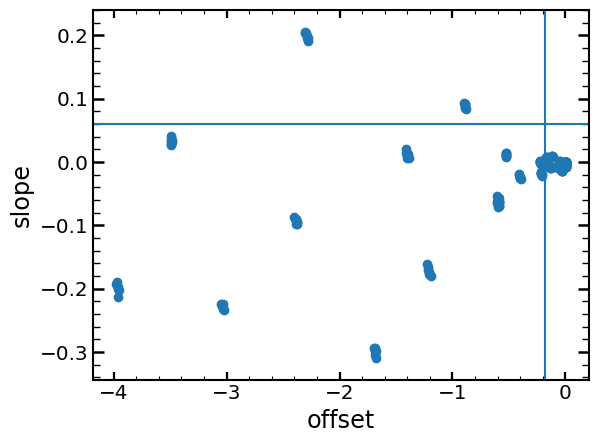

In [529]:
plt.scatter(chi_2_g_results_chi[:,5],chi_2_g_results_chi[:,6])
plt.xlabel('offset')
plt.ylabel('slope')

plt.axhline(0.06)
plt.axvline(-0.18)

In [544]:
v_list=np.unique(chi_2_g_results_chi[:,0])
a_list=np.unique(chi_2_g_results_chi[:,1])
L_list=np.unique(chi_2_g_results_chi[:,2])

0.55
0.7
0.85
1.0
1.15
1.35


Text(0.5,1,'offset')

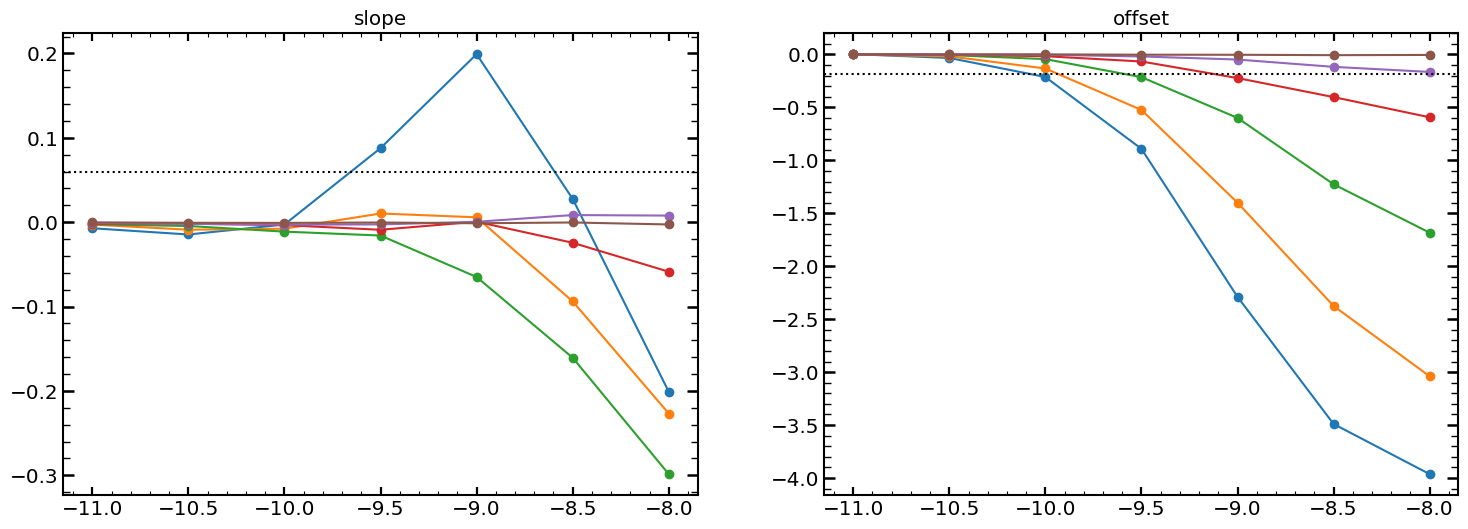

In [565]:
plt.figure(figsize=(18,6))

j=6
plt.subplot(121)
for i in range(6):
    print(a_list[i])
    single_example=chi_2_g_results_chi[(chi_2_g_results_chi[:,1]==a_list[i])&(chi_2_g_results_chi[:,2]==L_list[j])]
    plt.plot(single_example[:,0],single_example[:,-1],marker='o')
plt.axhline(0.06,color='black',ls=":")

plt.title('slope')

plt.subplot(122)
for i in range(6):
    single_example=chi_2_g_results_chi[(chi_2_g_results_chi[:,1]==a_list[i])&(chi_2_g_results_chi[:,2]==L_list[j])]
    plt.plot(single_example[:,0],single_example[:,-2],marker='o')
plt.axhline(-0.18,color='black',ls=":")
plt.title('offset')

0.55
-3.6666666666666665
-3.25
0.7


Text(0.5,1,'offset')

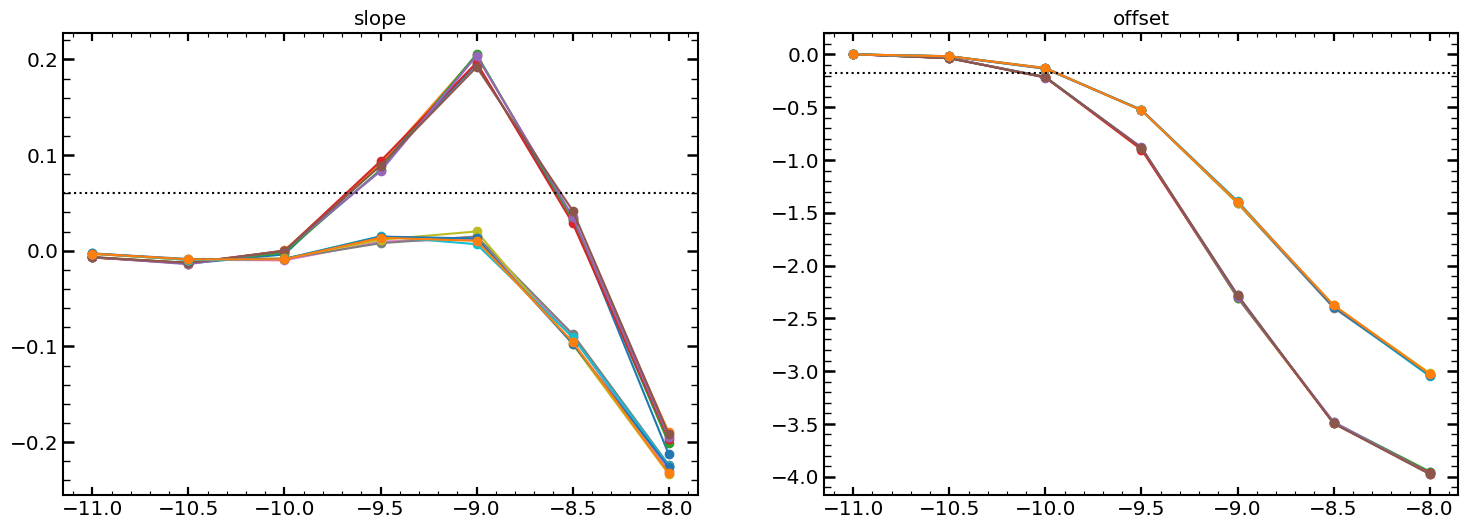

In [564]:
plt.figure(figsize=(18,6))

j=0
plt.subplot(121)
for i in range(6):
    single_example=chi_2_g_results_chi[(chi_2_g_results_chi[:,1]==a_list[j])&(chi_2_g_results_chi[:,2]==L_list[i])]
    plt.plot(single_example[:,0],single_example[:,-1],marker='o')

print(a_list[0])    
print(L_list[2])  
print(L_list[3])       


j=1
for i in range(6):
    single_example=chi_2_g_results_chi[(chi_2_g_results_chi[:,1]==a_list[j])&(chi_2_g_results_chi[:,2]==L_list[i])]
    plt.plot(single_example[:,0],single_example[:,-1],marker='o')    
plt.axhline(0.06,color='black',ls=":")
print(a_list[j])  
plt.title('slope')

plt.subplot(122)
j=0
for i in range(6):
    single_example=chi_2_g_results_chi[(chi_2_g_results_chi[:,1]==a_list[j])&(chi_2_g_results_chi[:,2]==L_list[i])]
    plt.plot(single_example[:,0],single_example[:,-2],marker='o')
    
j=1
for i in range(6):
    single_example=chi_2_g_results_chi[(chi_2_g_results_chi[:,1]==a_list[j])&(chi_2_g_results_chi[:,2]==L_list[i])]
    plt.plot(single_example[:,0],single_example[:,-2],marker='o')      
    
plt.axhline(-0.18,color='black',ls=":")
plt.title('offset')

#### analysis chi2 zoom in 

In [667]:
chi_2_g_results=np.load('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/chi_2_g_results_interpolation_31.npy')

chi_2_g_results[0][0]

array([-10.        ,   0.55      ,  -4.5       ,   1.07438796,
         1.07438796,  -0.18299635,   0.03861098])

In [668]:
chi_2_g_results
for i in range(len(chi_2_g_results)):
    if i==0:
        chi_2_g_results_chi=chi_2_g_results[i][0]
    else:
        chi_2_g_results_chi=np.vstack((chi_2_g_results_chi,chi_2_g_results[i][0]))
        
chi_2_g_results_chi=np.flip(chi_2_g_results_chi,axis=0)

# result for g
# poly1d([ 0.06069012, -0.17582206]),


# 5th colum is the offset
np.max(chi_2_g_results_chi[:,5])
# 6th colum is the slope
np.max(chi_2_g_results_chi[:,6])

0.21298199963713962

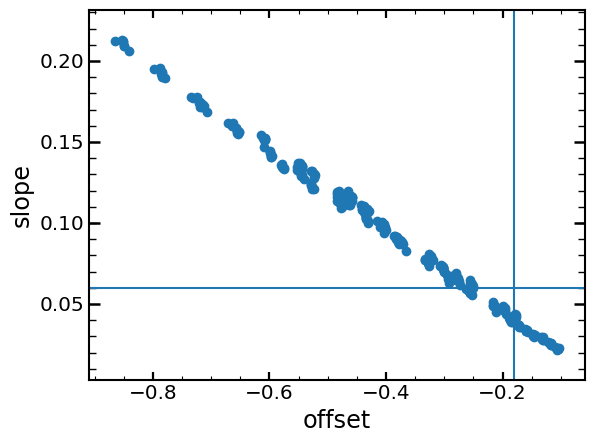

In [669]:
plt.scatter(chi_2_g_results_chi[:,5],chi_2_g_results_chi[:,6])
plt.xlabel('offset')
plt.ylabel('slope')

plt.axhline(0.06)
plt.axvline(-0.18)

In [670]:
v_list=np.unique(chi_2_g_results_chi[:,0])
a_list=np.unique(chi_2_g_results_chi[:,1])
L_list=np.unique(chi_2_g_results_chi[:,2])

0.55
0.575
0.6
0.625
0.65
0.675


Text(0.5,1,'offset')

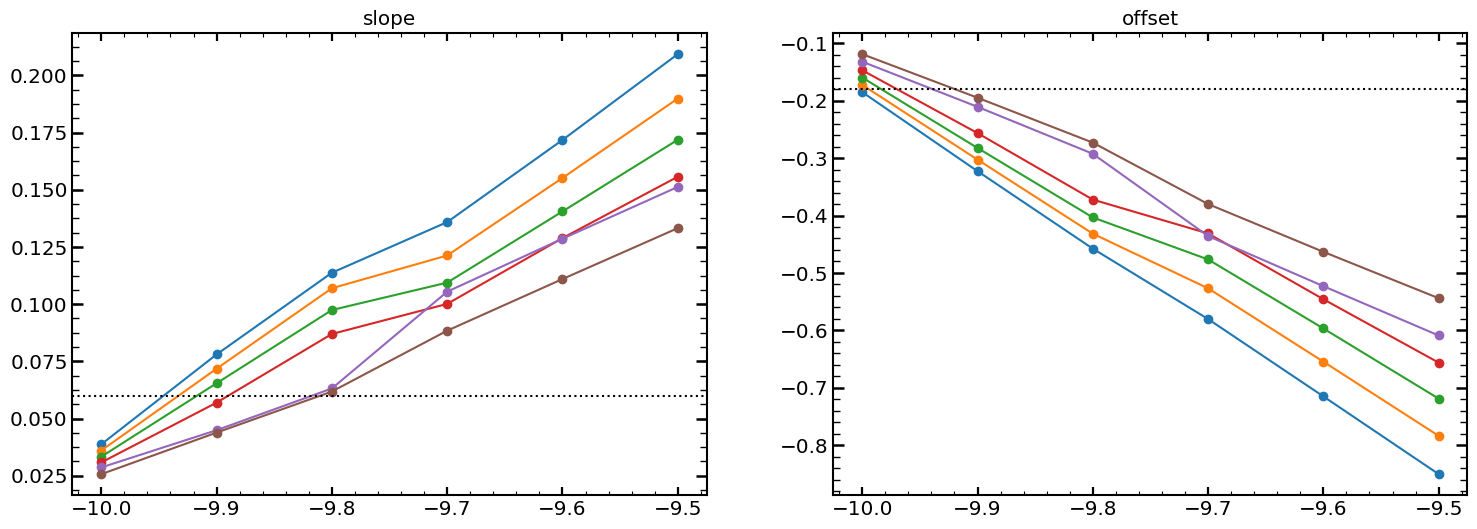

In [671]:
plt.figure(figsize=(18,6))

j=6
plt.subplot(121)
for i in range(6):
    print(a_list[i])
    single_example=chi_2_g_results_chi[(chi_2_g_results_chi[:,1]==a_list[i])&(chi_2_g_results_chi[:,2]==L_list[j])]
    plt.plot(single_example[:,0],single_example[:,-1],marker='o')
plt.axhline(0.06,color='black',ls=":")

plt.title('slope')

plt.subplot(122)
for i in range(6):
    single_example=chi_2_g_results_chi[(chi_2_g_results_chi[:,1]==a_list[i])&(chi_2_g_results_chi[:,2]==L_list[j])]
    plt.plot(single_example[:,0],single_example[:,-2],marker='o')
plt.axhline(-0.18,color='black',ls=":")
plt.title('offset')

0.55
-3.6666666666666665
-3.25
0.7


Text(0.5,1,'offset')

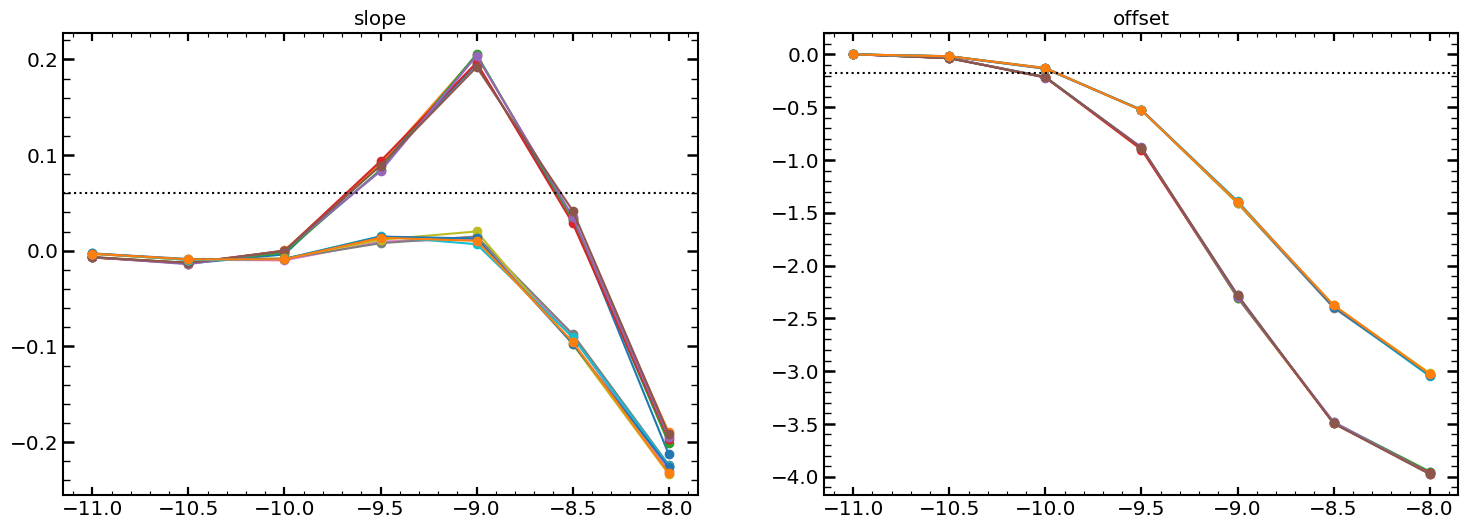

In [564]:
plt.figure(figsize=(18,6))

j=0
plt.subplot(121)
for i in range(6):
    single_example=chi_2_g_results_chi[(chi_2_g_results_chi[:,1]==a_list[j])&(chi_2_g_results_chi[:,2]==L_list[i])]
    plt.plot(single_example[:,0],single_example[:,-1],marker='o')

print(a_list[0])    
print(L_list[2])  
print(L_list[3])       


j=1
for i in range(6):
    single_example=chi_2_g_results_chi[(chi_2_g_results_chi[:,1]==a_list[j])&(chi_2_g_results_chi[:,2]==L_list[i])]
    plt.plot(single_example[:,0],single_example[:,-1],marker='o')    
plt.axhline(0.06,color='black',ls=":")
print(a_list[j])  
plt.title('slope')

plt.subplot(122)
j=0
for i in range(6):
    single_example=chi_2_g_results_chi[(chi_2_g_results_chi[:,1]==a_list[j])&(chi_2_g_results_chi[:,2]==L_list[i])]
    plt.plot(single_example[:,0],single_example[:,-2],marker='o')
    
j=1
for i in range(6):
    single_example=chi_2_g_results_chi[(chi_2_g_results_chi[:,1]==a_list[j])&(chi_2_g_results_chi[:,2]==L_list[i])]
    plt.plot(single_example[:,0],single_example[:,-2],marker='o')      
    
plt.axhline(-0.18,color='black',ls=":")
plt.title('offset')

#### continue 

In [662]:
single_brightness_model=create_chi_1_uber(-9.5,0.55,-2)[1]

l_near-1.5577462733469734
l_near(-1.6666666666666667, -1.3333333333333335)
np.log10(selected_mean_values_near_par[:,1])[-1.66666667 -1.66666667 -1.66666667 -1.66666667 -1.66666667 -1.66666667
 -1.66666667 -1.66666667 -1.33333333 -1.33333333 -1.33333333 -1.33333333
 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.66666667 -1.66666667
 -1.66666667 -1.66666667 -1.66666667 -1.66666667 -1.66666667 -1.66666667
 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333
 -1.33333333 -1.33333333]
[(-9.5, -1.6666666666666667, 0.55, -2.0, -1.2197265625), (-9.5, -1.6666666666666667, 0.55, -2.0, -1.3203125), (-9.5, -1.6666666666666667, 0.55, -2.4166666666666665, -1.2197265625), (-9.5, -1.6666666666666667, 0.55, -2.4166666666666665, -1.3203125), (-9.5, -1.6666666666666667, 0.7, -2.0, -1.2197265625), (-9.5, -1.6666666666666667, 0.7, -2.0, -1.3203125), (-9.5, -1.6666666666666667, 0.7, -2.4166666666666665, -1.2197265625), (-9.5, -1.6666666666666667, 0.7, -2.4166666666666665, -1.3203125

interpolated_scipy_points [-0.08500841 -0.11232986 -0.15079147 -0.21082585 -0.27328753 -0.35750586
 -0.47047269]
l_near-1.370953341576329
l_near(-1.3333333333333335, -1.6666666666666667)
np.log10(selected_mean_values_near_par[:,1])[-1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333
 -1.33333333 -1.33333333 -1.66666667 -1.66666667 -1.66666667 -1.66666667
 -1.66666667 -1.66666667 -1.66666667 -1.66666667 -1.33333333 -1.33333333
 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333
 -1.66666667 -1.66666667 -1.66666667 -1.66666667 -1.66666667 -1.66666667
 -1.66666667 -1.66666667]
[(-9.5, -1.3333333333333335, 0.55, -2.0, -0.919921875), (-9.5, -1.3333333333333335, 0.55, -2.0, -1.01953125), (-9.5, -1.3333333333333335, 0.55, -2.4166666666666665, -0.919921875), (-9.5, -1.3333333333333335, 0.55, -2.4166666666666665, -1.01953125), (-9.5, -1.3333333333333335, 0.7, -2.0, -0.919921875), (-9.5, -1.3333333333333335, 0.7, -2.0, -1.01953125), (-9.5, -1.333333333333

interpolated_scipy_points [-0.08746416 -0.11325865 -0.15011635 -0.21049199 -0.26867535 -0.35369497
 -0.46230553]
l_near-1.248626879293501
l_near(-1.3333333333333335, -1.0)
np.log10(selected_mean_values_near_par[:,1])[-1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333
 -1.33333333 -1.33333333 -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.33333333 -1.33333333
 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.        ]
[(-9.5, -1.3333333333333335, 0.55, -2.0, -1.1201171875), (-9.5, -1.3333333333333335, 0.55, -2.0, -1.01953125), (-9.5, -1.3333333333333335, 0.55, -2.4166666666666665, -1.1201171875), (-9.5, -1.3333333333333335, 0.55, -2.4166666666666665, -1.01953125), (-9.5, -1.3333333333333335, 0.7, -2.0, -1.1201171875), (-9.5, -1.3333333333333335, 0.7, -2.0, -1.01953125), (-9.5, -1.3333333333333335, 0.7, -2.41666666666666

np.log10(selected_mean_values_near_par[:,1])[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.33333333 -1.33333333 -1.33333333 -1.33333333
 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333
 -1.33333333 -1.33333333]
[(-9.5, -1.0, 0.55, -2.0, -0.919921875), (-9.5, -1.0, 0.55, -2.0, -0.81982421875), (-9.5, -1.0, 0.55, -2.4166666666666665, -0.919921875), (-9.5, -1.0, 0.55, -2.4166666666666665, -0.81982421875), (-9.5, -1.0, 0.7, -2.0, -0.919921875), (-9.5, -1.0, 0.7, -2.0, -0.81982421875), (-9.5, -1.0, 0.7, -2.4166666666666665, -0.919921875), (-9.5, -1.0, 0.7, -2.4166666666666665, -0.81982421875), (-9.5, -1.3333333333333335, 0.55, -2.0, -0.919921875), (-9.5, -1.3333333333333335, 0.55, -2.0, -0.81982421875), (-9.5, -1.3333333333333335, 0.55, -2.4166666666666665, -0.919921875), (-9.5, -1.333333333333

l_near-1.0410009924806265
l_near(-1.0, -1.3333333333333335)
np.log10(selected_mean_values_near_par[:,1])[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.33333333 -1.33333333 -1.33333333 -1.33333333
 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333 -1.33333333
 -1.33333333 -1.33333333]
[(-9.5, -1.0, 0.55, -2.0, -0.919921875), (-9.5, -1.0, 0.55, -2.0, -1.01953125), (-9.5, -1.0, 0.55, -2.4166666666666665, -0.919921875), (-9.5, -1.0, 0.55, -2.4166666666666665, -1.01953125), (-9.5, -1.0, 0.7, -2.0, -0.919921875), (-9.5, -1.0, 0.7, -2.0, -1.01953125), (-9.5, -1.0, 0.7, -2.4166666666666665, -0.919921875), (-9.5, -1.0, 0.7, -2.4166666666666665, -1.01953125), (-9.5, -1.3333333333333335, 0.55, -2.0, -0.919921875), (-9.5, -1.3333333333333335, 0.55, -2.0, -1.01953125), (-9.5, -1.3333333333333335, 0.55, -2.4166666666

np.log10(selected_mean_values_near_par[:,1])[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667]
[(-9.5, -1.0, 0.55, -2.0, -0.81982421875), (-9.5, -1.0, 0.55, -2.0, -0.72021484375), (-9.5, -1.0, 0.55, -2.4166666666666665, -0.81982421875), (-9.5, -1.0, 0.55, -2.4166666666666665, -0.72021484375), (-9.5, -1.0, 0.7, -2.0, -0.81982421875), (-9.5, -1.0, 0.7, -2.0, -0.72021484375), (-9.5, -1.0, 0.7, -2.4166666666666665, -0.81982421875), (-9.5, -1.0, 0.7, -2.4166666666666665, -0.72021484375), (-9.5, -0.6666666666666667, 0.55, -2.0, -0.81982421875), (-9.5, -0.6666666666666667, 0.55, -2.0, -0.72021484375), (-9.5, -0.6666666666666667, 0.55, -2.4166666666666665, -0.81982421875), (-9.5, -0.

l_near-0.8928555338875673
l_near(-1.0, -0.6666666666666667)
np.log10(selected_mean_values_near_par[:,1])[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667]
[(-9.5, -1.0, 0.55, -2.0, -0.919921875), (-9.5, -1.0, 0.55, -2.0, -0.81982421875), (-9.5, -1.0, 0.55, -2.4166666666666665, -0.919921875), (-9.5, -1.0, 0.55, -2.4166666666666665, -0.81982421875), (-9.5, -1.0, 0.7, -2.0, -0.919921875), (-9.5, -1.0, 0.7, -2.0, -0.81982421875), (-9.5, -1.0, 0.7, -2.4166666666666665, -0.919921875), (-9.5, -1.0, 0.7, -2.4166666666666665, -0.81982421875), (-9.5, -0.6666666666666667, 0.55, -2.0, -0.919921875), (-9.5, -0.6666666666666667, 0.55, -2.0, -0.81982421875), (-9.5, -0.6666666666666667, 0.55

np.log10(selected_mean_values_near_par[:,1])[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667]
[(-9.5, -1.0, 0.55, -2.0, -1.01953125), (-9.5, -1.0, 0.55, -2.0, -1.1201171875), (-9.5, -1.0, 0.55, -2.4166666666666665, -1.01953125), (-9.5, -1.0, 0.55, -2.4166666666666665, -1.1201171875), (-9.5, -1.0, 0.7, -2.0, -1.01953125), (-9.5, -1.0, 0.7, -2.0, -1.1201171875), (-9.5, -1.0, 0.7, -2.4166666666666665, -1.01953125), (-9.5, -1.0, 0.7, -2.4166666666666665, -1.1201171875), (-9.5, -0.6666666666666667, 0.55, -2.0, -1.01953125), (-9.5, -0.6666666666666667, 0.55, -2.0, -1.1201171875), (-9.5, -0.6666666666666667, 0.55, -2.4166666666666665, -1.01953125), (-9.5, -0.6666666666666667, 0.55,

interpolated_scipy_points [-0.20677697 -0.25577616 -0.31973081 -0.40913517 -0.48593294 -0.58858673
 -0.70862937]
l_near-0.7747599308457545
l_near(-0.6666666666666667, -1.0)
np.log10(selected_mean_values_near_par[:,1])[-0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.        ]
[(-9.5, -0.6666666666666667, 0.55, -2.0, -0.81982421875), (-9.5, -0.6666666666666667, 0.55, -2.0, -0.919921875), (-9.5, -0.6666666666666667, 0.55, -2.4166666666666665, -0.81982421875), (-9.5, -0.6666666666666667, 0.55, -2.4166666666666665, -0.919921875), (-9.5, -0.6666666666666667, 0.7, -2.0, -0.81982421875), (-9.5, -0.6666666666666667, 0.7, -2.0, -0.919921875), (-9.5, -0.6666666666666667, 0.7, -2.4166666

np.log10(selected_mean_values_near_par[:,1])[-0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.        ]
[(-9.5, -0.6666666666666667, 0.55, -2.0, -0.72021484375), (-9.5, -0.6666666666666667, 0.55, -2.0, -0.6201171875), (-9.5, -0.6666666666666667, 0.55, -2.4166666666666665, -0.72021484375), (-9.5, -0.6666666666666667, 0.55, -2.4166666666666665, -0.6201171875), (-9.5, -0.6666666666666667, 0.7, -2.0, -0.72021484375), (-9.5, -0.6666666666666667, 0.7, -2.0, -0.6201171875), (-9.5, -0.6666666666666667, 0.7, -2.4166666666666665, -0.72021484375), (-9.5, -0.6666666666666667, 0.7, -2.4166666666666665, -0.6201171875), (-9.5, -1.0, 0.55, -2.0, -0.72021484375), (-9.5, -1.0, 0.55, -2.0, -0.62

interpolated_scipy_points [-0.21165755 -0.26411141 -0.33018604 -0.43120843 -0.52339586 -0.63104128
 -0.76011373]
l_near-0.6960979994828791
l_near(-0.6666666666666667, -1.0)
np.log10(selected_mean_values_near_par[:,1])[-0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.        ]
[(-9.5, -0.6666666666666667, 0.55, -2.0, -0.81982421875), (-9.5, -0.6666666666666667, 0.55, -2.0, -0.72021484375), (-9.5, -0.6666666666666667, 0.55, -2.4166666666666665, -0.81982421875), (-9.5, -0.6666666666666667, 0.55, -2.4166666666666665, -0.72021484375), (-9.5, -0.6666666666666667, 0.7, -2.0, -0.81982421875), (-9.5, -0.6666666666666667, 0.7, -2.0, -0.72021484375), (-9.5, -0.6666666666666667, 0.7, -2.4

l_near-0.6595736058886592
l_near(-0.6666666666666667, -0.3333333333333335)
np.log10(selected_mean_values_near_par[:,1])[-0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.33333333 -0.33333333 -0.33333333 -0.33333333
 -0.33333333 -0.33333333 -0.33333333 -0.33333333 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.33333333 -0.33333333 -0.33333333 -0.33333333 -0.33333333 -0.33333333
 -0.33333333 -0.33333333]
[(-9.5, -0.6666666666666667, 0.55, -2.0, -0.6201171875), (-9.5, -0.6666666666666667, 0.55, -2.0, -0.52001953125), (-9.5, -0.6666666666666667, 0.55, -2.4166666666666665, -0.6201171875), (-9.5, -0.6666666666666667, 0.55, -2.4166666666666665, -0.52001953125), (-9.5, -0.6666666666666667, 0.7, -2.0, -0.6201171875), (-9.5, -0.6666666666666667, 0.7, -2.0, -0.52001953125), (-9.5, -0.6666666666666667, 0.7, -2.4166666666666665, -0.6201171875), (-9.5, -0.6666666666666667, 0.7, -2.4166666666666665

l_near-0.6135109391583069
l_near(-0.6666666666666667, -0.3333333333333335)
np.log10(selected_mean_values_near_par[:,1])[-0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.33333333 -0.33333333 -0.33333333 -0.33333333
 -0.33333333 -0.33333333 -0.33333333 -0.33333333 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.33333333 -0.33333333 -0.33333333 -0.33333333 -0.33333333 -0.33333333
 -0.33333333 -0.33333333]
[(-9.5, -0.6666666666666667, 0.55, -2.0, -0.72021484375), (-9.5, -0.6666666666666667, 0.55, -2.0, -0.6201171875), (-9.5, -0.6666666666666667, 0.55, -2.4166666666666665, -0.72021484375), (-9.5, -0.6666666666666667, 0.55, -2.4166666666666665, -0.6201171875), (-9.5, -0.6666666666666667, 0.7, -2.0, -0.72021484375), (-9.5, -0.6666666666666667, 0.7, -2.0, -0.6201171875), (-9.5, -0.6666666666666667, 0.7, -2.4166666666666665, -0.72021484375), (-9.5, -0.6666666666666667, 0.7, -2.416666666666666

np.log10(selected_mean_values_near_par[:,1])[-0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.33333333 -0.33333333 -0.33333333 -0.33333333
 -0.33333333 -0.33333333 -0.33333333 -0.33333333 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.33333333 -0.33333333 -0.33333333 -0.33333333 -0.33333333 -0.33333333
 -0.33333333 -0.33333333]
[(-9.5, -0.6666666666666667, 0.55, -2.0, -0.6201171875), (-9.5, -0.6666666666666667, 0.55, -2.0, -0.72021484375), (-9.5, -0.6666666666666667, 0.55, -2.4166666666666665, -0.6201171875), (-9.5, -0.6666666666666667, 0.55, -2.4166666666666665, -0.72021484375), (-9.5, -0.6666666666666667, 0.7, -2.0, -0.6201171875), (-9.5, -0.6666666666666667, 0.7, -2.0, -0.72021484375), (-9.5, -0.6666666666666667, 0.7, -2.4166666666666665, -0.6201171875), (-9.5, -0.6666666666666667, 0.7, -2.4166666666666665, -0.72021484375), (-9.5, -0.3333333333333335, 0.55, -2.0, -0.6201171875), 

interpolated_scipy_points [-0.25434888 -0.31620819 -0.39200344 -0.50359458 -0.60358247 -0.72418121
 -0.86263   ]
l_near-0.35888939737056247
l_near(-0.3333333333333335, -0.6666666666666667)
np.log10(selected_mean_values_near_par[:,1])[-0.33333333 -0.33333333 -0.33333333 -0.33333333 -0.33333333 -0.33333333
 -0.33333333 -0.33333333 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.33333333 -0.33333333
 -0.33333333 -0.33333333 -0.33333333 -0.33333333 -0.33333333 -0.33333333
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667]
[(-9.5, -0.3333333333333335, 0.55, -2.0, -0.320068359375), (-9.5, -0.3333333333333335, 0.55, -2.0, -0.219970703125), (-9.5, -0.3333333333333335, 0.55, -2.4166666666666665, -0.320068359375), (-9.5, -0.3333333333333335, 0.55, -2.4166666666666665, -0.219970703125), (-9.5, -0.3333333333333335, 0.7, -2.0, -0.320068359375), (-9.5, -0.3333333333333335, 0.7, -2.0, -0.219970703125),

np.log10(selected_mean_values_near_par[:,1])[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.33333333 -0.33333333 -0.33333333 -0.33333333
 -0.33333333 -0.33333333 -0.33333333 -0.33333333  0.          0.
  0.          0.          0.          0.          0.          0.
 -0.33333333 -0.33333333 -0.33333333 -0.33333333 -0.33333333 -0.33333333
 -0.33333333 -0.33333333]
[(-9.5, 0.0, 0.55, -2.0, -0.419921875), (-9.5, 0.0, 0.55, -2.0, -0.320068359375), (-9.5, 0.0, 0.55, -2.4166666666666665, -0.419921875), (-9.5, 0.0, 0.55, -2.4166666666666665, -0.320068359375), (-9.5, 0.0, 0.7, -2.0, -0.419921875), (-9.5, 0.0, 0.7, -2.0, -0.320068359375), (-9.5, 0.0, 0.7, -2.4166666666666665, -0.419921875), (-9.5, 0.0, 0.7, -2.4166666666666665, -0.320068359375), (-9.5, -0.3333333333333335, 0.55, -2.0, -0.419921875), (-9.5, -0.3333333333333335, 0.55, -2.0, -0.320068359375), (-9.5, -0.3333333333333335, 0.55, -2.4166666666666665, -0.419921875), (-9.5, -0.333333333333333

In [654]:
p20=np.poly1d(np.polyfit(res_redshift_array[0],single_brightness_model,1))
p20

poly1d([ 0.0878045 , -0.89138513])

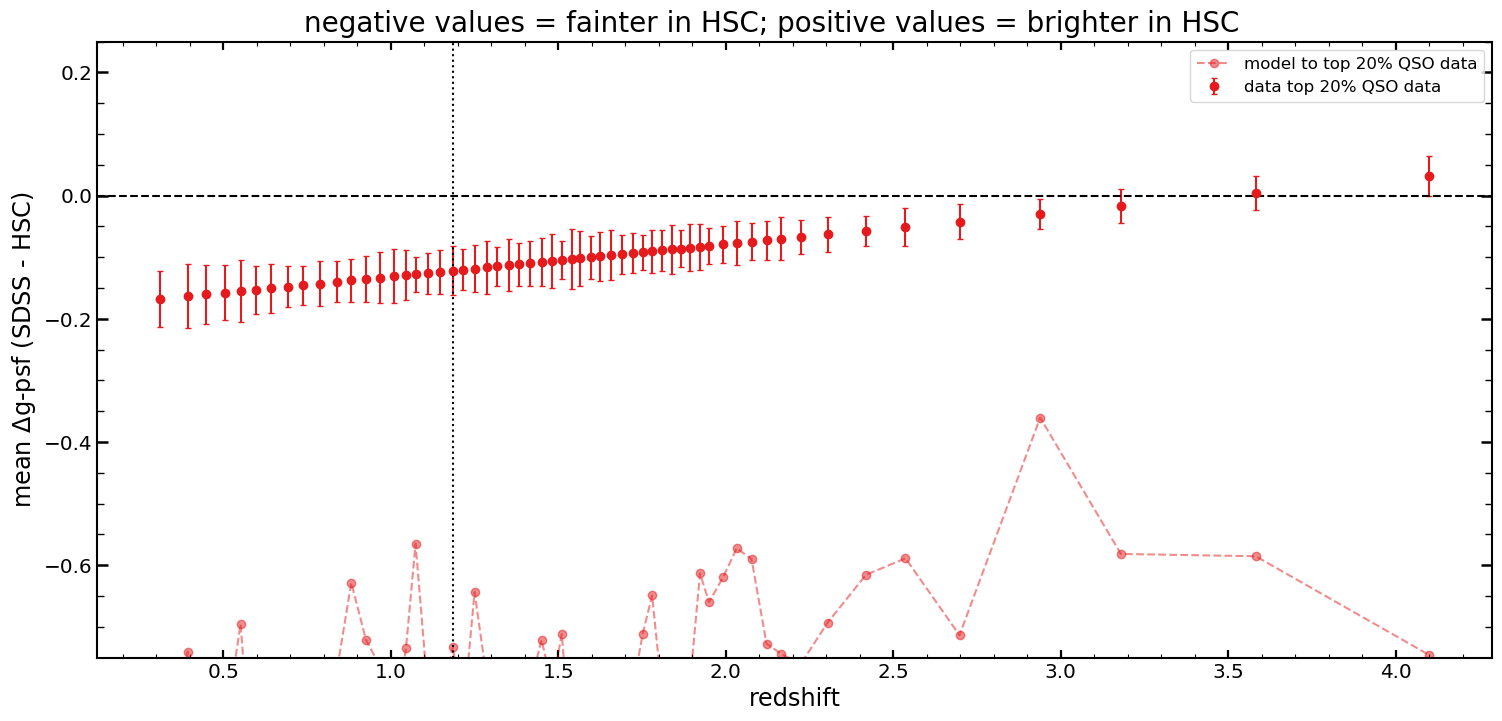

In [663]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,8))
plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)


#plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_array[0],yerr=res_delta_redshift_via_redshift_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO data')
#plt.plot(res_redshift_array[0],p20_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to all QSO data')
#plt.plot(HSC_SDSS_filter_redshift_dependence_redshift,-HSC_SDSS_filter_redshift_dependence_dg)
brightness_index=0
plt.errorbar(res_redshift_array[brightness_index],res_delta_redshift_via_redshift_interpolation_array[brightness_index],\
             yerr=res_delta_redshift_via_redshift_err_array[brightness_index],color='#e41a1c',label='data top 20% QSO data',ls='',marker='o',capsize=2)

# brightest
#plt.plot(res_redshift_array[1],p20_array[1](res_redshift_array[1]),ls='--',color='#e41a1c',alpha=0.5,label='fit to top 20% QSO data')
#plt.plot(res_redshift_array[2],p20_array[2](res_redshift_array[2]),ls='--',color='#377eb8',alpha=0.5,label='fit to 20%-40% QSO data')
#plt.plot(res_redshift_array[3],p20_array[3](res_redshift_array[3]),ls='--',color='#4daf4a',alpha=0.5,label='fit to 40%-60% QSO data')
#plt.plot(res_redshift_array[4],p20_array[4](res_redshift_array[4]),ls='--',color='#984ea3',alpha=0.5,label='fit to 60%-80% QSO data')
#plt.plot(res_redshift_array[5],p20_array[5](res_redshift_array[5]),ls='--',color='#a65628',alpha=0.5,label='fit to 80%-100% QSO data')

plt.plot(res_redshift_array[0],single_brightness_model,ls='--',color='#e41a1c',alpha=0.5,label='model to top 20% QSO data',marker='o')


plt.ylabel('mean $\Delta$g-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.75,0.25)
plt.axhline(0,color='black',ls='--')

#plt.axhline(-0.129,color='black',ls='-')

plt.axvline(res_redshift_array[3][19],color='black',ls=':')

plt.legend()


In [ ]:
    redshift_points=np.array([3.51996875, 2.615975  , 1.85471711, 1.169585  , 0.74966532,
       0.39075962, 0.0847925 ])

In [647]:
brightness_index=3
redshift_index=0


lstar_first_point=l_as_fun_z(res_redshift_array[brightness_index][redshift_index])
print('lstar_first_point: '+str(lstar_first_point))

l_first_point=median_Edd_values_array[brightness_index-1][redshift_index]
print('l_first_point: '+str(l_first_point))
brightness_index=3
redshift_index=-1

lstar_last_point=l_as_fun_z(res_redshift_array[brightness_index][redshift_index])
print('lstar_last_point'+str(lstar_last_point))

l_last_point=median_Edd_values_array[brightness_index-1][redshift_index]
print('l_last_point'+str(l_last_point))

lstar_first_point: -1.5577462733469734
l_first_point: -1.2268364570379404
lstar_last_point-0.09947854617800322
l_last_point-0.38220567515923065


In [593]:
np.unique(np.log10(means_all_LC_redshift_values[:,0]))[3]

-9.5

In [598]:
np.unique(np.log10(means_all_LC_redshift_values[:,3]))[6]

-2.0

In [606]:
singleLC_as_redshift_diffrent_l_and_lstar=means_all_LC_redshift_values[(np.log10(means_all_LC_redshift_values[:,0])==np.unique(np.log10(means_all_LC_redshift_values[:,0]))[3])&\
                            (means_all_LC_redshift_values[:,2]==0.55)&\
                            (np.log10(means_all_LC_redshift_values[:,3])==np.unique(np.log10(means_all_LC_redshift_values[:,3]))[6])]
singleLC_as_redshift_diffrent_l

array([[ 3.16227766e-10,  1.00000000e-02,  5.50000000e-01, ...,
         1.24633789e-01,  1.46972656e-01,  1.76147461e-01],
       [ 3.16227766e-10,  1.00000000e-02,  5.50000000e-01, ...,
         1.43310547e-01,  1.70776367e-01,  1.94458008e-01],
       [ 3.16227766e-10,  1.00000000e-02,  5.50000000e-01, ...,
         1.22375488e-01,  1.46484375e-01,  1.67968750e-01],
       ...,
       [ 3.16227766e-10,  1.00000000e+00,  5.50000000e-01, ...,
        -9.97314453e-02, -1.39892578e-01, -2.08740234e-01],
       [ 3.16227766e-10,  1.00000000e+00,  5.50000000e-01, ...,
        -7.34863281e-02, -9.88159180e-02, -1.38916016e-01],
       [ 3.16227766e-10,  1.00000000e+00,  5.50000000e-01, ...,
        -2.98156738e-02, -4.04663086e-02, -5.77392578e-02]])

In [609]:
np.unique(np.log10(singleLC_as_redshift_diffrent_l_and_lstar[:,1]))

array([-2.        , -1.66666667, -1.33333333, -1.        , -0.66666667,
       -0.33333333,  0.        ])

In [643]:
single_LC_many_l=singleLC_as_redshift_diffrent_l[(np.log10(singleLC_as_redshift_diffrent_l_and_lstar[:,1])\
                                                  ==np.unique(np.log10(singleLC_as_redshift_diffrent_l_and_lstar[:,1]))[1])]

single_LC_first_point=(single_LC_many_l[(single_LC_many_l[:,4]==single_LC_many_l[:,4][25])])[0][5:]

In [651]:
single_LC_many_l=singleLC_as_redshift_diffrent_l[(np.log10(singleLC_as_redshift_diffrent_l_and_lstar[:,1])\
                                                  ==np.unique(np.log10(singleLC_as_redshift_diffrent_l_and_lstar[:,1]))[6])]
print(single_LC_many_l[:,4][34])
single_LC_last_point=(single_LC_many_l[(single_LC_many_l[:,4]==single_LC_many_l[:,4][25])])[0][5:]

-0.320068359375


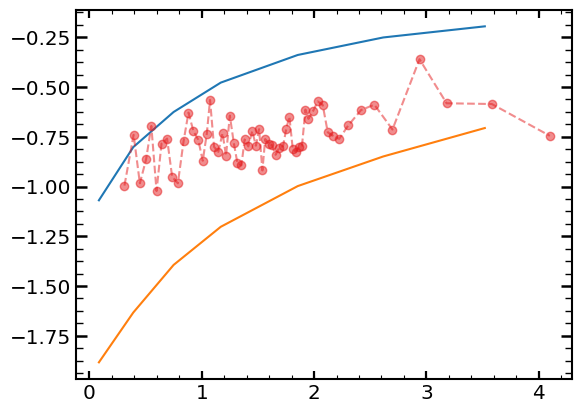

In [664]:
plt.plot(redshift_points,2.5*single_LC_first_point)
plt.plot(redshift_points,2.5*single_LC_last_point)
plt.plot(res_redshift_array[0],single_brightness_model,ls='--',color='#e41a1c',alpha=0.5,label='model to top 20% QSO data',marker='o')

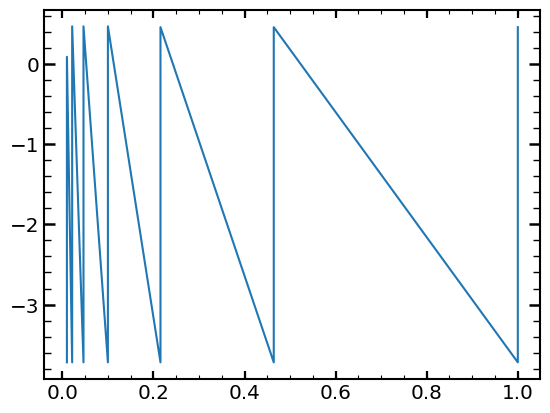

In [605]:
plt.plot(singleLC_as_redshift_diffrent_l[:,1],singleLC_as_redshift_diffrent_l[:,4])

## plan B figure

In [692]:
freq_values=(np.unique(np.log10(means_all_LC_redshift_fit[:,0])))
slopes_values=np.unique(means_all_LC_redshift_fit[:,2])

In [715]:
v=-8.5
a=0.55
L=-3
res=[]
for v in freq_values:
    for a in slopes_values:
        res.append([v,a,2.5*create_interpolation_for_v_l_a_L_E(v,-1,a,L,-0.5,complete_return=False,run=3)(0)])
        
res=np.array(res)
                   


l_near-1
l_near(-1.0, -0.6666666666666667)
np.log10(selected_mean_values_near_par[:,1])[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667]
[(-11.0, -1.0, 0.55, -2.833333333333333, -0.52001953125), (-11.0, -1.0, 0.55, -2.833333333333333, -0.419921875), (-11.0, -1.0, 0.55, -3.25, -0.52001953125), (-11.0, -1.0, 0.55, -3.25, -0.419921875), (-11.0, -1.0, 0.7, -2.833333333333333, -0.52001953125), (-11.0, -1.0, 0.7, -2.833333333333333, -0.419921875), (-11.0, -1.0, 0.7, -3.25, -0.52001953125), (-11.0, -1.0, 0.7, -3.25, -0.419921875), (-11.0, -0.6666666666666667, 0.55, -2.833333333333333, -0.52001953125), (-11.0, -0.6666666666666667, 0.55, -2.833333333333333, -0.419921875), (-11.0, -0.

np.log10(selected_mean_values_near_par[:,1])[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667]
[(-11.0, -1.0, 1.0, -2.833333333333333, -0.52001953125), (-11.0, -1.0, 1.0, -2.833333333333333, -0.419921875), (-11.0, -1.0, 1.0, -3.25, -0.52001953125), (-11.0, -1.0, 1.0, -3.25, -0.419921875), (-11.0, -1.0, 1.15, -2.833333333333333, -0.52001953125), (-11.0, -1.0, 1.15, -2.833333333333333, -0.419921875), (-11.0, -1.0, 1.15, -3.25, -0.52001953125), (-11.0, -1.0, 1.15, -3.25, -0.419921875), (-11.0, -0.6666666666666667, 1.0, -2.833333333333333, -0.52001953125), (-11.0, -0.6666666666666667, 1.0, -2.833333333333333, -0.419921875), (-11.0, -0.6666666666666667, 1.0, -3.25, -0.52001953125)

interpolated_scipy_points [-7.64131546e-06 -3.13520432e-06 -8.36849213e-06 -7.11679459e-06
 -6.47306442e-06  7.27176666e-07  4.63724136e-06]
l_near-1
l_near(-1.0, -0.6666666666666667)
np.log10(selected_mean_values_near_par[:,1])[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667]
[(-10.5, -1.0, 0.55, -2.833333333333333, -0.52001953125), (-10.5, -1.0, 0.55, -2.833333333333333, -0.419921875), (-10.5, -1.0, 0.55, -3.25, -0.52001953125), (-10.5, -1.0, 0.55, -3.25, -0.419921875), (-10.5, -1.0, 0.7, -2.833333333333333, -0.52001953125), (-10.5, -1.0, 0.7, -2.833333333333333, -0.419921875), (-10.5, -1.0, 0.7, -3.25, -0.52001953125), (-10.5, -1.0, 0.7, -3.25, -0.419921875), (-10.5, -0.6

interpolated_scipy_points [ 4.07409668e-04  2.30026245e-04  1.14440918e-06 -3.47900391e-04
 -5.24520874e-04 -2.13241577e-04 -8.37326050e-04]
l_near-1
l_near(-1.0, -0.6666666666666667)
np.log10(selected_mean_values_near_par[:,1])[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667]
[(-10.5, -1.0, 1.0, -2.833333333333333, -0.52001953125), (-10.5, -1.0, 1.0, -2.833333333333333, -0.419921875), (-10.5, -1.0, 1.0, -3.25, -0.52001953125), (-10.5, -1.0, 1.0, -3.25, -0.419921875), (-10.5, -1.0, 1.15, -2.833333333333333, -0.52001953125), (-10.5, -1.0, 1.15, -2.833333333333333, -0.419921875), (-10.5, -1.0, 1.15, -3.25, -0.52001953125), (-10.5, -1.0, 1.15, -3.25, -0.419921875), (-10.5, -0.6

np.log10(selected_mean_values_near_par[:,1])[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667]
[(-10.5, -1.0, 1.45, -2.833333333333333, -0.52001953125), (-10.5, -1.0, 1.45, -2.833333333333333, -0.419921875), (-10.5, -1.0, 1.45, -3.25, -0.52001953125), (-10.5, -1.0, 1.45, -3.25, -0.419921875), (-10.5, -1.0, 1.35, -2.833333333333333, -0.52001953125), (-10.5, -1.0, 1.35, -2.833333333333333, -0.419921875), (-10.5, -1.0, 1.35, -3.25, -0.52001953125), (-10.5, -1.0, 1.35, -3.25, -0.419921875), (-10.5, -0.6666666666666667, 1.45, -2.833333333333333, -0.52001953125), (-10.5, -0.6666666666666667, 1.45, -2.833333333333333, -0.419921875), (-10.5, -0.6666666666666667, 1.45, -3.25, -0.52001

l_near-1
l_near(-1.0, -0.6666666666666667)
np.log10(selected_mean_values_near_par[:,1])[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667]
[(-10.0, -1.0, 1.0, -2.833333333333333, -0.52001953125), (-10.0, -1.0, 1.0, -2.833333333333333, -0.419921875), (-10.0, -1.0, 1.0, -3.25, -0.52001953125), (-10.0, -1.0, 1.0, -3.25, -0.419921875), (-10.0, -1.0, 1.15, -2.833333333333333, -0.52001953125), (-10.0, -1.0, 1.15, -2.833333333333333, -0.419921875), (-10.0, -1.0, 1.15, -3.25, -0.52001953125), (-10.0, -1.0, 1.15, -3.25, -0.419921875), (-10.0, -0.6666666666666667, 1.0, -2.833333333333333, -0.52001953125), (-10.0, -0.6666666666666667, 1.0, -2.833333333333333, -0.419921875), (-10.0, -0.66

np.log10(selected_mean_values_near_par[:,1])[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667]
[(-10.0, -1.0, 1.45, -2.833333333333333, -0.52001953125), (-10.0, -1.0, 1.45, -2.833333333333333, -0.419921875), (-10.0, -1.0, 1.45, -3.25, -0.52001953125), (-10.0, -1.0, 1.45, -3.25, -0.419921875), (-10.0, -1.0, 1.35, -2.833333333333333, -0.52001953125), (-10.0, -1.0, 1.35, -2.833333333333333, -0.419921875), (-10.0, -1.0, 1.35, -3.25, -0.52001953125), (-10.0, -1.0, 1.35, -3.25, -0.419921875), (-10.0, -0.6666666666666667, 1.45, -2.833333333333333, -0.52001953125), (-10.0, -0.6666666666666667, 1.45, -2.833333333333333, -0.419921875), (-10.0, -0.6666666666666667, 1.45, -3.25, -0.52001

np.log10(selected_mean_values_near_par[:,1])[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667]
[(-9.5, -1.0, 1.0, -2.833333333333333, -0.52001953125), (-9.5, -1.0, 1.0, -2.833333333333333, -0.419921875), (-9.5, -1.0, 1.0, -3.25, -0.52001953125), (-9.5, -1.0, 1.0, -3.25, -0.419921875), (-9.5, -1.0, 1.15, -2.833333333333333, -0.52001953125), (-9.5, -1.0, 1.15, -2.833333333333333, -0.419921875), (-9.5, -1.0, 1.15, -3.25, -0.52001953125), (-9.5, -1.0, 1.15, -3.25, -0.419921875), (-9.5, -0.6666666666666667, 1.0, -2.833333333333333, -0.52001953125), (-9.5, -0.6666666666666667, 1.0, -2.833333333333333, -0.419921875), (-9.5, -0.6666666666666667, 1.0, -3.25, -0.52001953125), (-9.5, -0

np.log10(selected_mean_values_near_par[:,1])[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667]
[(-9.0, -1.0, 0.55, -2.833333333333333, -0.52001953125), (-9.0, -1.0, 0.55, -2.833333333333333, -0.419921875), (-9.0, -1.0, 0.55, -3.25, -0.52001953125), (-9.0, -1.0, 0.55, -3.25, -0.419921875), (-9.0, -1.0, 0.7, -2.833333333333333, -0.52001953125), (-9.0, -1.0, 0.7, -2.833333333333333, -0.419921875), (-9.0, -1.0, 0.7, -3.25, -0.52001953125), (-9.0, -1.0, 0.7, -3.25, -0.419921875), (-9.0, -0.6666666666666667, 0.55, -2.833333333333333, -0.52001953125), (-9.0, -0.6666666666666667, 0.55, -2.833333333333333, -0.419921875), (-9.0, -0.6666666666666667, 0.55, -3.25, -0.52001953125), (-9.0,

np.log10(selected_mean_values_near_par[:,1])[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667]
[(-9.0, -1.0, 1.15, -2.833333333333333, -0.52001953125), (-9.0, -1.0, 1.15, -2.833333333333333, -0.419921875), (-9.0, -1.0, 1.15, -3.25, -0.52001953125), (-9.0, -1.0, 1.15, -3.25, -0.419921875), (-9.0, -1.0, 1.0, -2.833333333333333, -0.52001953125), (-9.0, -1.0, 1.0, -2.833333333333333, -0.419921875), (-9.0, -1.0, 1.0, -3.25, -0.52001953125), (-9.0, -1.0, 1.0, -3.25, -0.419921875), (-9.0, -0.6666666666666667, 1.15, -2.833333333333333, -0.52001953125), (-9.0, -0.6666666666666667, 1.15, -2.833333333333333, -0.419921875), (-9.0, -0.6666666666666667, 1.15, -3.25, -0.52001953125), (-9.0,

interpolated_scipy_points [-0.35385742 -0.4347168  -0.52407227 -0.621875   -0.70087891 -0.78232422
 -0.86035156]
l_near-1
l_near(-1.0, -0.6666666666666667)
np.log10(selected_mean_values_near_par[:,1])[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667]
[(-8.5, -1.0, 0.85, -2.833333333333333, -0.52001953125), (-8.5, -1.0, 0.85, -2.833333333333333, -0.419921875), (-8.5, -1.0, 0.85, -3.25, -0.52001953125), (-8.5, -1.0, 0.85, -3.25, -0.419921875), (-8.5, -1.0, 0.7, -2.833333333333333, -0.52001953125), (-8.5, -1.0, 0.7, -2.833333333333333, -0.419921875), (-8.5, -1.0, 0.7, -3.25, -0.52001953125), (-8.5, -1.0, 0.7, -3.25, -0.419921875), (-8.5, -0.6666666666666667, 0.85, -2.83333333333

interpolated_scipy_points [-0.00510788 -0.00578232 -0.00629425 -0.00776596 -0.0088829  -0.00962677
 -0.00926819]
l_near-1
l_near(-1.0, -0.6666666666666667)
np.log10(selected_mean_values_near_par[:,1])[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667]
[(-8.5, -1.0, 1.45, -2.833333333333333, -0.52001953125), (-8.5, -1.0, 1.45, -2.833333333333333, -0.419921875), (-8.5, -1.0, 1.45, -3.25, -0.52001953125), (-8.5, -1.0, 1.45, -3.25, -0.419921875), (-8.5, -1.0, 1.35, -2.833333333333333, -0.52001953125), (-8.5, -1.0, 1.35, -2.833333333333333, -0.419921875), (-8.5, -1.0, 1.35, -3.25, -0.52001953125), (-8.5, -1.0, 1.35, -3.25, -0.419921875), (-8.5, -0.6666666666666667, 1.45, -2.8333333

l_near-1
l_near(-1.0, -0.6666666666666667)
np.log10(selected_mean_values_near_par[:,1])[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667 -0.66666667
 -0.66666667 -0.66666667]
[(-8.0, -1.0, 1.0, -2.833333333333333, -0.52001953125), (-8.0, -1.0, 1.0, -2.833333333333333, -0.419921875), (-8.0, -1.0, 1.0, -3.25, -0.52001953125), (-8.0, -1.0, 1.0, -3.25, -0.419921875), (-8.0, -1.0, 1.15, -2.833333333333333, -0.52001953125), (-8.0, -1.0, 1.15, -2.833333333333333, -0.419921875), (-8.0, -1.0, 1.15, -3.25, -0.52001953125), (-8.0, -1.0, 1.15, -3.25, -0.419921875), (-8.0, -0.6666666666666667, 1.0, -2.833333333333333, -0.52001953125), (-8.0, -0.6666666666666667, 1.0, -2.833333333333333, -0.419921875), (-8.0, -0.6666666666666

In [ ]:
plt.imshow(np.transpose(means_all_LC_selected_4_m05_par_0_1[:,6].reshape(6,6)),origin='lower',cmap='bwr',vmax=0,vmin=-0.14)
plt.xticks(range(0,6),np.unique(means_all_LC_selected_4_m05_par_0_1[:,0]),fontsize=15)
plt.yticks(range(0,6),np.round(np.unique(means_all_LC_selected_4_m05_par_0_1[:,1]),2),fontsize=15)
#cmap=plt.colorbar(fraction=0.046, pad=0.04)
#cmap.ax.tick_params(labelsize=10)
plt.xlabel(r'$log(f_{br})$')
plt.ylabel(r'$\log(\lambda^{*})$')
plt.title(r'$\alpha_{low}$='+str(a)+r', $\log(\lambda_{lim})$='+str(L)+', $\log(\lambda)$=-0.5')

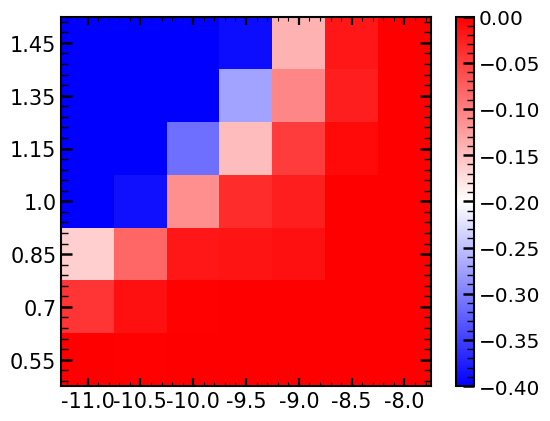

In [718]:
plt.imshow(res[:,2].reshape(7,7),origin='lower',cmap='bwr',vmax=0,vmin=-0.4)
plt.xticks(range(0,7),freq_values,fontsize=15)
plt.yticks(range(0,7),slopes_values,fontsize=15)
plt.colorbar()

In [426]:
res_detailed=[]
for v in np.concatenate((np.arange(-11,-8.0,3/27),np.array([-8]))):
    for a in np.concatenate((np.arange(0.55,1.45,0.9/27),np.array([1.45]))):
        res_detailed.append([v,a,2.5*create_interpolation_for_v_l_a_L_E(v,-1,a,L,-0.5,complete_return=False,run=3)(0)])
        
res_detailed=np.array(res_detailed)

TypeError: create_interpolation_for_v_l_a_L_E() missing 2 required positional arguments: 'means_all_LC_redshift_fit' and 'means_all_LC_redshift_values'

In [799]:
np.save('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/model_plot',res_detailed[:,2].reshape(28,28)[6:,:-6])

In [800]:
print(freq_values)
print(slopes_values)

[-11.  -10.5 -10.   -9.5  -9.   -8.5  -8. ]
[0.55 0.7  0.85 1.   1.15 1.35 1.45]


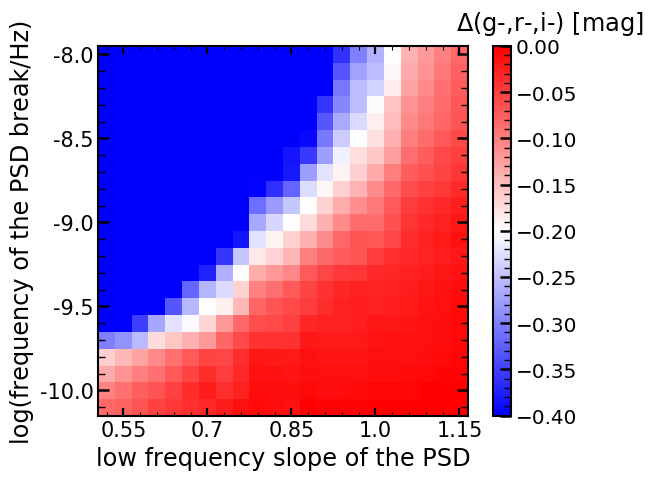

In [785]:
plt.imshow(res_detailed[:,2].reshape(28,28)[6:,:-6],origin='lower',cmap='bwr',vmax=0,vmin=-0.4)
plt.xticks(range(1,22,5),slopes_values,fontsize=15)
plt.yticks(range(1,22,5),freq_values[2:],fontsize=15)
clb=plt.colorbar()
clb.set_label('$\Delta$(g-,r-,i-) [mag]', labelpad=-20, y=1.10, rotation=0)
plt.xlabel('low frequency slope of the PSD')
plt.ylabel('log(frequency of the PSD break/Hz)')


plt.savefig('/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/Figures/Paper_Figures/' + 'delta_from_model.pdf', bbox_inches='tight')

In [ ]:
# -0.7, -8.5 -> 5,3,1,4
#0.85, -9 -> 4,3,2,4
#1,-9.5 -> 3,3,3,4

In [786]:
list_of_v_bend_in=10**np.linspace(-11,-8,7)
list_of_lambda_s_BPL_in=10**np.linspace(-2,0.0,7)
list_of_a_low_in=[0.55,0.7,0.85,1.0,1.15,1.35,1.45]
list_of_LowerLimit_acc_in=10**np.linspace(-4.5,-2,7)

In [794]:
print(np.log10(list_of_v_bend_in[3]))
print(np.log10(list_of_v_bend_in[4]))
print(np.log10(list_of_v_bend_in[5]))

-9.5
-9.0
-8.5


In [792]:
np.log10(list_of_lambda_s_BPL_in[3])

-1.0

In [796]:
print(list_of_a_low_in[1])
print(list_of_a_low_in[2])
print(list_of_a_low_in[3])

0.7
0.85
1.0


In [832]:
LC_3335=np.load('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/GpuData/results_v_3_l_3_a_3_L_5_array_of_LC_16.npy')
LC_3333=np.load('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/GpuData/results_v_3_l_3_a_3_L_3_array_of_LC_16.npy')
print(np.min(LC_3335[0]))
print(np.min(LC_3333[0]))

-3.77
-3.77


In [897]:
LC_5314=np.load('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/GpuData/results_v_5_l_3_a_1_L_4_array_of_LC_16.npy')
LC_4324=np.load('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/GpuData/results_v_4_l_3_a_2_L_4_array_of_LC_16.npy')
LC_3334=np.load('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_3/GpuData/results_v_3_l_3_a_3_L_4_array_of_LC_16.npy')
Edd=-0.5
l=0
dt_max=100

In [898]:
np.median(LC_5314)

-3.18

In [899]:
np.median(LC_4324)

-3.18

In [900]:
positions_of_specific_Edd_ratio_LC_5314=np.nonzero((LC_5314[l][:len(LC_5314[l])-dt_max]>Edd)&(LC_5314[l][:len(LC_5314[l])-dt_max]<(Edd+0.1)))[0]
positions_of_specific_Edd_ratio_LC_4324=np.nonzero((LC_4324[l][:len(LC_4324[l])-dt_max]>Edd)&(LC_4324[l][:len(LC_4324[l])-dt_max]<(Edd+0.1)))[0]
positions_of_specific_Edd_ratio_LC_3334=np.nonzero((LC_3334[l][:len(LC_3334[l])-dt_max]>Edd)&(LC_3334[l][:len(LC_3334[l])-dt_max]<(Edd+0.1)))[0]

In [901]:
positions_of_specific_Edd_ratio_LC_4324

array([ 1557928,  1557929,  1557930, ..., 16747587, 16747588, 16747589])

Text(0,0.5,'Edd. ratio')

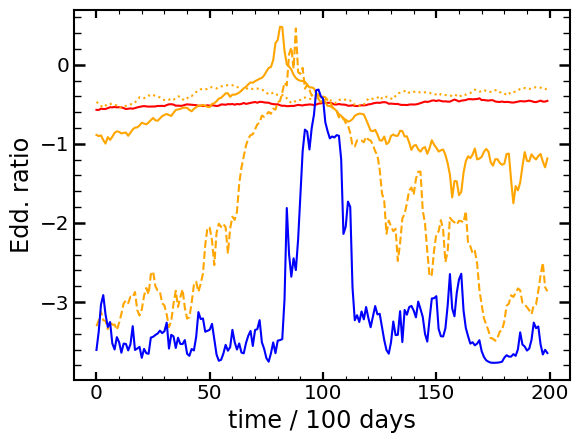

In [906]:
dt_max=100

plt.plot(LC_3334[0][positions_of_specific_Edd_ratio_LC_3334[20]-100:positions_of_specific_Edd_ratio_LC_3334[20]+dt_max],color='red')
plt.plot(LC_4324[0][positions_of_specific_Edd_ratio_LC_4324[-4]-100:positions_of_specific_Edd_ratio_LC_4324[-4]+dt_max],ls='--',color='orange')
plt.plot(LC_4324[0][positions_of_specific_Edd_ratio_LC_4324[1000]-100:positions_of_specific_Edd_ratio_LC_4324[1000]+dt_max],ls=':',color='orange')
plt.plot(LC_4324[0][positions_of_specific_Edd_ratio_LC_4324[-100]-100:positions_of_specific_Edd_ratio_LC_4324[-100]+dt_max],ls='-',color='orange')
plt.plot(LC_5314[0][positions_of_specific_Edd_ratio_LC_5314[20]-100:positions_of_specific_Edd_ratio_LC_5314[20]+dt_max],color='blue')
plt.xlabel('time / 100 days')
plt.ylabel('Edd. ratio')

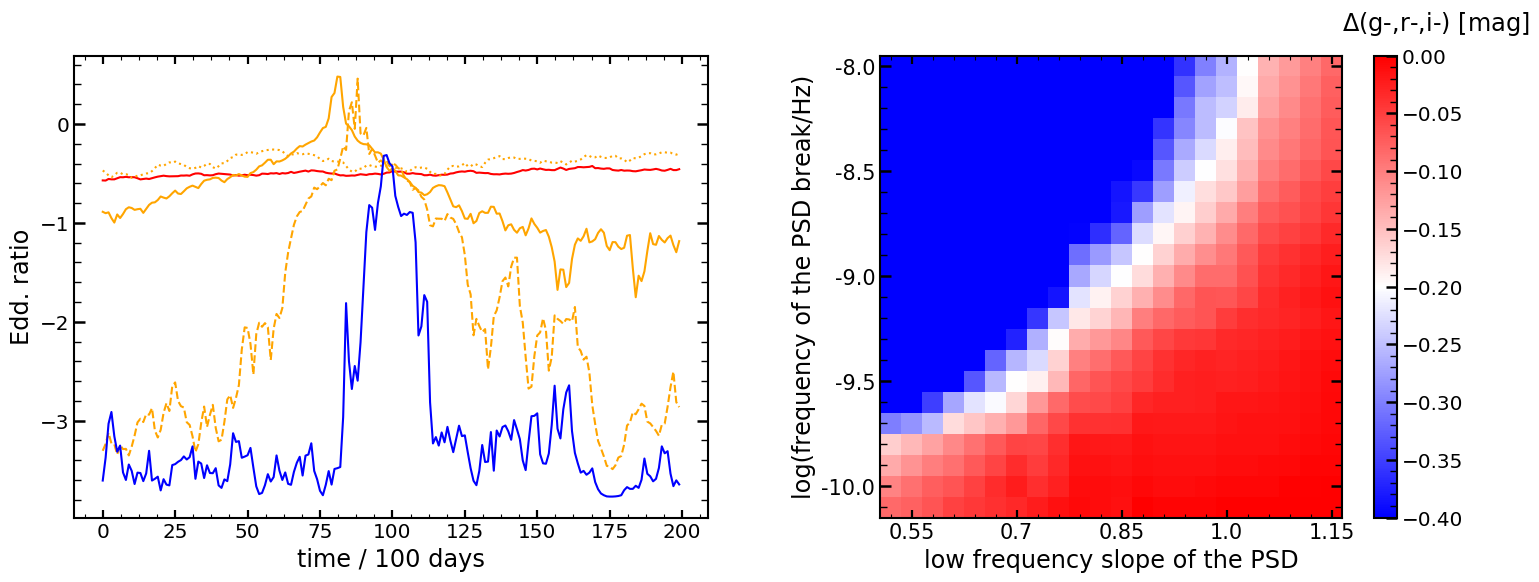

In [907]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(LC_3334[0][positions_of_specific_Edd_ratio_LC_3334[20]-100:positions_of_specific_Edd_ratio_LC_3334[20]+dt_max],color='red')
plt.plot(LC_4324[0][positions_of_specific_Edd_ratio_LC_4324[-4]-100:positions_of_specific_Edd_ratio_LC_4324[-4]+dt_max],ls='--',color='orange')
plt.plot(LC_4324[0][positions_of_specific_Edd_ratio_LC_4324[1000]-100:positions_of_specific_Edd_ratio_LC_4324[1000]+dt_max],ls=':',color='orange')
plt.plot(LC_4324[0][positions_of_specific_Edd_ratio_LC_4324[-100]-100:positions_of_specific_Edd_ratio_LC_4324[-100]+dt_max],ls='-',color='orange')
plt.plot(LC_5314[0][positions_of_specific_Edd_ratio_LC_5314[20]-100:positions_of_specific_Edd_ratio_LC_5314[20]+dt_max],color='blue')
plt.xlabel('time / 100 days')
plt.ylabel('Edd. ratio')

plt.subplot(122)
plt.imshow(res_detailed[:,2].reshape(28,28)[6:,:-6],origin='lower',cmap='bwr',vmax=0,vmin=-0.4)
plt.xticks(range(1,22,5),slopes_values,fontsize=15)
plt.yticks(range(1,22,5),freq_values[2:],fontsize=15)
clb=plt.colorbar()
clb.set_label('$\Delta$(g-,r-,i-) [mag]', labelpad=-20, y=1.10, rotation=0)
plt.xlabel('low frequency slope of the PSD')
plt.ylabel('log(frequency of the PSD break/Hz)')


plt.savefig('/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/Figures/Paper_Figures/' + 'delta_from_model_v2.pdf', bbox_inches='tight')

In [1032]:
slopes_values

array([0.55, 0.7 , 0.85, 1.  , 1.15, 1.35, 1.45])

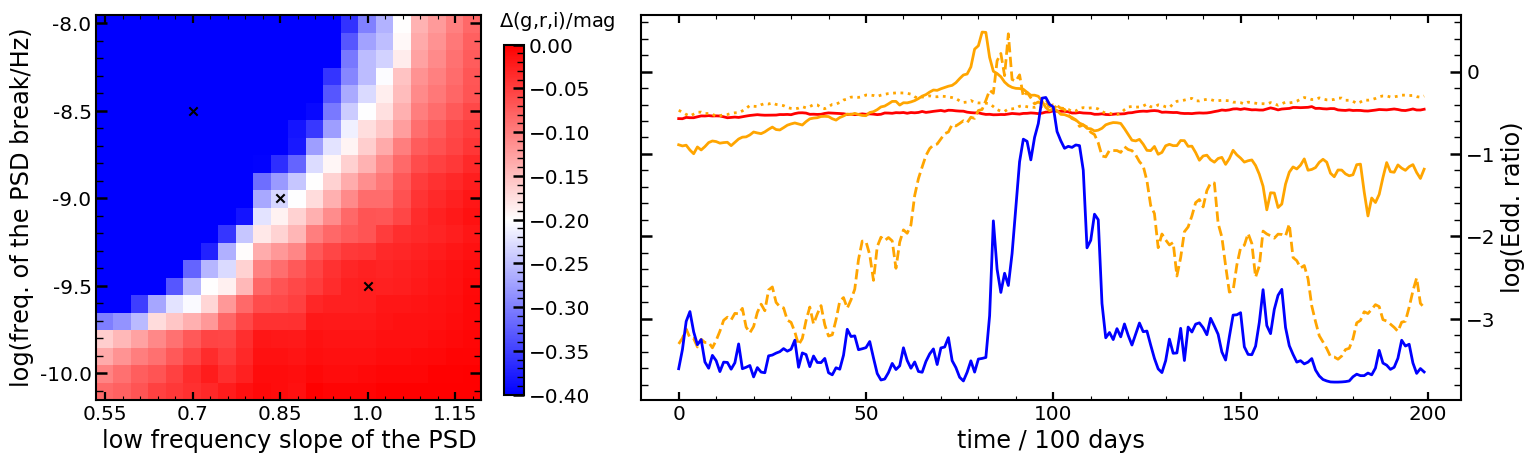

In [1044]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Fixing random state for reproducibility
np.random.seed(19680801)


# the random data
x = np.random.randn(1000)
y = np.random.randn(1000)


fig, axScatter = plt.subplots(figsize=(20, 5))



# the scatter plot:
img=axScatter.imshow(res_detailed[:,2].reshape(28,28)[6:,:-6],origin='lower',cmap='bwr',vmax=0,vmin=-0.4)
axScatter.imshow(res_detailed[:,2].reshape(28,28)[6:,:-6],origin='lower',cmap='bwr',vmax=0,vmin=-0.4)
axScatter.set_xticks(list(range(0,21,5)))
axScatter.set_yticks(range(1,22,5))
axScatter.set_xticklabels(slopes_values)
axScatter.set_yticklabels(freq_values[2:])


axScatter.set_xlabel('low frequency slope of the PSD')
axScatter.set_ylabel('log(freq. of the PSD break/Hz)')



axScatter.set_aspect(1.)
axScatter.scatter(x=[5,10,15],y=[16,11,6],color='black',marker='x')
# create new axes on the right and on the top of the current axes
# The first argument of the new_vertical(new_horizontal) method is
# the height (width) of the axes to be created in inches.
divider = make_axes_locatable(axScatter)
axHisty = divider.append_axes("right", 8.2, pad=1.6)

# make some labels invisible

axHisty.yaxis.set_tick_params(labelright=True,labelleft=False)


axHisty.plot(LC_3334[0][positions_of_specific_Edd_ratio_LC_3334[20]-100:positions_of_specific_Edd_ratio_LC_3334[20]+dt_max],color='red',lw=2)
axHisty.plot(LC_4324[0][positions_of_specific_Edd_ratio_LC_4324[-4]-100:positions_of_specific_Edd_ratio_LC_4324[-4]+dt_max],ls='--',color='orange',lw=2)
axHisty.plot(LC_4324[0][positions_of_specific_Edd_ratio_LC_4324[1000]-100:positions_of_specific_Edd_ratio_LC_4324[1000]+dt_max],ls=':',color='orange',lw=2)
axHisty.plot(LC_4324[0][positions_of_specific_Edd_ratio_LC_4324[-100]-100:positions_of_specific_Edd_ratio_LC_4324[-100]+dt_max],ls='-',color='orange',lw=2)
axHisty.plot(LC_5314[0][positions_of_specific_Edd_ratio_LC_5314[20]-100:positions_of_specific_Edd_ratio_LC_5314[20]+dt_max],color='blue',lw=2)
axHisty.set_xlabel('time / 100 days')
axHisty.set_ylabel('log(Edd. ratio)')
axHisty.yaxis.set_label_position("right")


# the xaxis of axHistx and yaxis of axHisty are shared with axScatter,
# thus there is no need to manually adjust the xlim and ylim of these
# axis.
#divider = make_axes_locatable(axScatter)
#cax1 = divider.append_axes("right", size="5%", pad=0.05)

cax = fig.add_axes([0.375, 0.12, 0.01, 0.7])
clb=plt.colorbar(img,cax=cax)
clb.set_label('$\Delta$(g,r,i)/mag', labelpad=-24, y=1.10, rotation=0,fontsize=14)

axHisty.set_xticks([0, 50, 100,150,200])

plt.show()
fig.savefig('/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/Figures/Paper_Figures/' + 'delta_from_model_v3.pdf', bbox_inches='tight')

In [ ]:
main_ax.plot(res_redshift_array[1],p20_array[1][0](res_redshift_array[1]),ls='--',color='#d73027',alpha=1,lw=3,
             label='fit to the 0-20% QSO data, sorted by brightness (brightest)')

In [1013]:
list(range(1,22,5))

[1, 6, 11, 16, 21]

In [860]:
# PSD
# fs=1/ how often you sample, in units of 100 days (1 day=86400)
f_5314, Pxx_den_5314 = signal.periodogram(LC_5314[0],fs=1/8640000)
PSD_th=BendingPL(f,1,1*10**(-9),1,2,0)

f_4324, Pxx_den_4324 = signal.periodogram(LC_4324[0],fs=1/8640000)
PSD_th=BendingPL(f,1,1*10**(-9),1,2,0)

f_3334, Pxx_den_3334 = signal.periodogram(LC_3334[0],fs=1/8640000)

/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in reciprocal


/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


Text(0,0.5,'log(PSD/[V**2/Hz])')

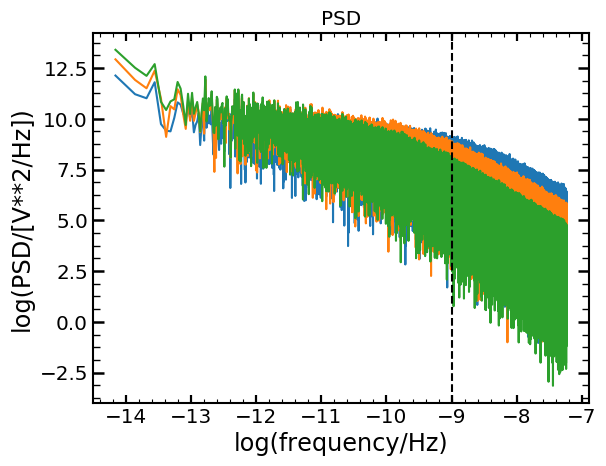

In [861]:

plt.plot(np.log10(f_5314), np.log10(Pxx_den_5314))

plt.plot(np.log10(f_4324), np.log10(Pxx_den_4324))

plt.plot(np.log10(f_3334), np.log10(Pxx_den_3334))
#plt.plot(np.log10(f[1:]), np.log10(PSD_th[1:])+np.mean(np.log10(Pxx_den[1:100]))-np.mean(np.log10(PSD_th[1:100])))
plt.axvline(np.log10(1*10**(-9)),color='black',ls='--')
plt.title('PSD')
plt.xlabel('log(frequency/Hz)')
plt.ylabel('log(PSD/[V**2/Hz])')

In [ ]:
plt.figure(figsize=(20,6))

plt.subplot(121)
plt.plot(median_value_in_bin_in_LC,np.log10(number_of_points_in_bin_in_LC),marker='o')
plt.xlabel('log(Edd. ratio)')
plt.ylabel('log(N)')
plt.title('PDF (Edd. ratio distribution)')
plt.axvline(np.log10(0.11),ls='--',color='black')
plt.plot(median_value_in_bin_in_LC, np.log10(PDF_th)+np.mean(np.log10(number_of_points_in_bin_in_LC)[1:10])-np.mean(np.log10(PDF_th[1:10])))


plt.subplot(122)

plt.plot(np.log10(f_5314), np.log10(Pxx_den_5314))

plt.plot(np.log10(f_4324), np.log10(Pxx_den_4324))
#plt.plot(np.log10(f[1:]), np.log10(PSD_th[1:])+np.mean(np.log10(Pxx_den[1:100]))-np.mean(np.log10(PSD_th[1:100])))
plt.axvline(np.log10(1*10**(-9)),color='black',ls='--')
plt.title('PSD')
plt.xlabel('log(frequency/Hz)')
plt.ylabel('log(PSD/[V**2/Hz])')

## Analysis of the small grande run 4 

In [ ]:
# run sumbitSmall_mean_analysis.sh (which is in /home/ncaplar/CodeGpu)
# data has to be in /tigress/ncaplar/GpuData/ i.e., you have to be able to find
# array_of_LC=np.load('/tigress/ncaplar/GpuData/results_v_'+str(v_number)+'_l_'+str(l_number)+'_a_'+str(a_number)+'_L_'+str(L_number)+'_array_of_LC_16.npy')
# transfer data from /tigress/ncaplar/GpuData to /Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_4/AnalysisResults_Small_Run_4/

In [470]:
selection_of_times_as_redshift_in_HSC_SDSS=(14.85*365.25)/(selection_of_times*100)-1

In [471]:
import pickle
selection_of_times=np.unique((10**np.arange(0,5.5,0.1)).astype(int))
list_of_v_bend_in=10**np.linspace(-11,-8,7)
list_of_lambda_s_BPL_in=10**np.linspace(-2,0.0,7)
list_of_a_low_in=[0.55,0.7,0.85,1.0,1.15,1.30,1.45]
list_of_LowerLimit_acc_in=10**np.linspace(-4.5,-2,7)
list_of_LClength_in=[23,24,25,26,27]

In [472]:
np.log10(list_of_LowerLimit_acc_in)

array([-4.5       , -4.08333333, -3.66666667, -3.25      , -2.83333333,
       -2.41666667, -2.        ])

In [473]:
means_all_LC_redshift_list=[]
means_all_LC_redshift_fit_list=[]
means_all_LC_redshift_values_list=[]
for v_bend_index in tqdm(range(len(list_of_v_bend_in))):
    for lambda_s_BPL_index in range(len(list_of_lambda_s_BPL_in)):
        for a_low_index in range(len(list_of_a_low_in)):
            for LowerLimit_acc_index in range(len(list_of_LowerLimit_acc_in)):
                # Edd. ratio,std, mean, median
                single_LC_result = pickle.load( open( "/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_4/AnalysisResults_Small_run_4/list_of_single_LC_resultv_"+str(v_bend_index)+\
                                                     '_l_'+str(lambda_s_BPL_index)+'_a_'+str(a_low_index)+'_L_'+str(LowerLimit_acc_index)+".txt", "rb" ) )

                # 51 is the len of the selection of times
                means_single_LC=np.zeros((len(single_LC_result)*51,7))
                means_single_LC_redshift=np.zeros((len(single_LC_result)*51,7))
                
                # this part is cut before you reach nan (if you reach nan)
                means_Edd_index=[]
                for Edd_index in range(len(single_LC_result)):
                    means_Edd_index.append(np.mean(single_LC_result[Edd_index][0]))
                    
                if np.sum(np.isnan(means_Edd_index))==0:
                    len_of_single_LC_result_analysis=len(single_LC_result)
                else:
                    len_of_single_LC_result_analysis=np.argwhere(np.isnan(means_Edd_index))[0][0]-1
                
                
                for Edd_index in range(len_of_single_LC_result_analysis):
                    #print(str(Edd_index)+': '+str(single_LC_result[Edd_index][0]))
                    means_single_LC_single_Edd_redshift=np.array([np.full(51,list_of_v_bend_in[v_bend_index]),np.full(51,list_of_lambda_s_BPL_in[lambda_s_BPL_index]),\
                                                                      np.full(51,list_of_a_low_in[a_low_index]),np.full(51,list_of_LowerLimit_acc_in[LowerLimit_acc_index]),\
                                                                      single_LC_result[Edd_index][0],selection_of_times_as_redshift_in_HSC_SDSS,single_LC_result[Edd_index][2][:,0]])
                    
                    means_single_LC_redshift[Edd_index*51:(Edd_index+1)*51]=np.transpose(means_single_LC_single_Edd_redshift)
                    # wrong! add all Edd. ratios    
                    means_single_LC_single_Edd_redshift_transpose=np.transpose(means_single_LC_single_Edd_redshift)
                    means_single_LC_single_Edd_redshift_0_4_transpose=means_single_LC_single_Edd_redshift_transpose\
                    [(means_single_LC_single_Edd_redshift_transpose[:,-2]>0)&(means_single_LC_single_Edd_redshift_transpose[:,-2]<4)]
                    z=np.polyfit(means_single_LC_single_Edd_redshift_0_4_transpose[:,-2],means_single_LC_single_Edd_redshift_0_4_transpose[:,-1],2)

                    

                    means_all_LC_redshift_list.append(means_single_LC_single_Edd_redshift_0_4_transpose)
                    means_all_LC_redshift_fit_list.append([list_of_v_bend_in[v_bend_index],list_of_lambda_s_BPL_in[lambda_s_BPL_index],\
                                                          list_of_a_low_in[a_low_index],list_of_LowerLimit_acc_in[LowerLimit_acc_index],
                                                          np.round(single_LC_result[Edd_index][0][0],2),z[0],z[1],z[2]])
                    means_all_LC_redshift_values_list.append([list_of_v_bend_in[v_bend_index],list_of_lambda_s_BPL_in[lambda_s_BPL_index],\
                                                          list_of_a_low_in[a_low_index],list_of_LowerLimit_acc_in[LowerLimit_acc_index],
                                                          np.round(single_LC_result[Edd_index][0][0],2),means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][0]\
                                                             ,means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][1],means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][2]\
                                                             ,means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][3],means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][4]\
                                                             ,means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][5],means_single_LC_single_Edd_redshift_0_4_transpose[:,-1][6]])
                    
                    
 # v_bend, lamda*, alpha_low, lower_limit, Edd_limit, z0,z1,z2                   
means_all_LC_redshift_fit=np.array(means_all_LC_redshift_fit_list)

 # v_bend, lamda*, alpha_low, lower_limit, Edd_limit, 7 redshift values                
means_all_LC_redshift_values=np.array(means_all_LC_redshift_values_list)

100%|██████████| 7/7 [00:43<00:00,  6.16s/it]


In [474]:
np.save('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_4/means_all_LC_redshift_fit',means_all_LC_redshift_fit)
np.save('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_4/means_all_LC_redshift_values',means_all_LC_redshift_values)

### Plan B figure

In [475]:
freq_values=(np.unique(np.log10(means_all_LC_redshift_fit[:,0])))
slopes_values=np.unique(means_all_LC_redshift_fit[:,2])

In [476]:
v=-8.5
a=0.55
L=-2.4
res=[]
for v in freq_values:
    for a in slopes_values:
        res.append([v,a,2.5*create_interpolation_for_v_l_a_L_E(v,-1,a,L,-0.5,means_all_LC_redshift_fit,means_all_LC_redshift_values,complete_return=False,run=3)(0.3)])
        
res=np.array(res)
                   


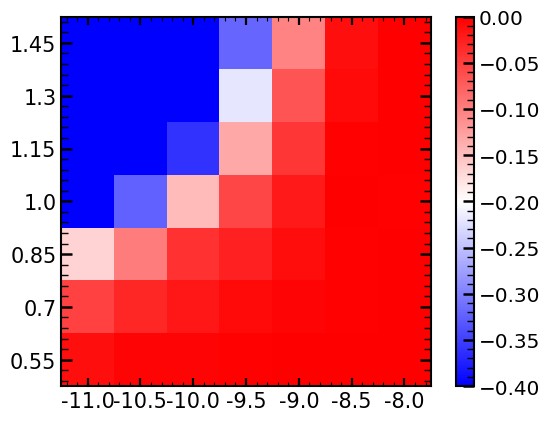

In [477]:
plt.imshow(res[:,2].reshape(7,7),origin='lower',cmap='bwr',vmax=0,vmin=-0.4)
plt.xticks(range(0,7),freq_values,fontsize=15)
plt.yticks(range(0,7),slopes_values,fontsize=15)
plt.colorbar()

In [478]:
res_detailed=[]
for v in np.concatenate((np.arange(-11,-8.0,3/30),np.array([-8]))):
    for a in np.concatenate((np.arange(0.55,1.45,0.9/30),np.array([1.45]))):
        res_detailed.append([v,a,2.5*create_interpolation_for_v_l_a_L_E(v,-1,a,L,-0.8,means_all_LC_redshift_fit,means_all_LC_redshift_values,complete_return=False,run=3)(0.3)])
        
res_detailed=np.array(res_detailed)

Text(0,0.5,'log(frequency of the PSD break/Hz)')

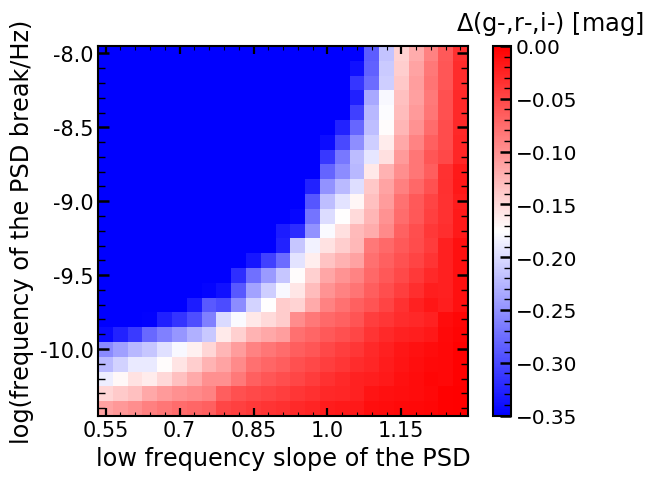

In [487]:
plt.imshow(res_detailed[:,2].reshape(31,31)[6:,:-6],origin='lower',cmap='bwr',vmax=0,vmin=-0.35)
#plt.scatter(x=[5,10,15],y=[16,11,6],color='black',marker='x')
plt.xticks(range(0,25,5),slopes_values,fontsize=15)
plt.yticks(range(4,29,5),freq_values[2:],fontsize=15)
clb=plt.colorbar()
clb.set_label('$\Delta$(g-,r-,i-) [mag]', labelpad=-20, y=1.10, rotation=0)
plt.xlabel('low frequency slope of the PSD')
plt.ylabel('log(frequency of the PSD break/Hz)')

In [526]:
[np.log10(list_of_v_bend_in)[5],np.log10(list_of_lambda_s_BPL_in)[3],list_of_a_low_in[2],np.log10(list_of_LowerLimit_acc_in)[5]]

[-8.5, -1.0, 0.85, -2.4166666666666665]

In [537]:
LC_5325=np.load('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_4/GpuData/results_v_5_l_3_a_2_L_5_array_of_LC_16.npy')
LC_4335=np.load('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_4/GpuData/results_v_4_l_3_a_3_L_5_array_of_LC_16.npy')
LC_3345=np.load('/Users/nevencaplar/Documents/Variability/Lia_Data/Small_Grande_4/GpuData/results_v_3_l_3_a_4_L_5_array_of_LC_16.npy')
Edd=-0.8
l=1
dt_max=100

In [538]:
positions_of_specific_Edd_ratio_LC_5325=np.nonzero((LC_5325[l][:len(LC_5325[l])-dt_max]>Edd)&(LC_5325[l][:len(LC_5325[l])-dt_max]<(Edd+0.1)))[0]
positions_of_specific_Edd_ratio_LC_4335=np.nonzero((LC_4335[l][:len(LC_4335[l])-dt_max]>Edd)&(LC_4335[l][:len(LC_4335[l])-dt_max]<(Edd+0.1)))[0]
positions_of_specific_Edd_ratio_LC_3345=np.nonzero((LC_3345[l][:len(LC_3335[l])-dt_max]>Edd)&(LC_3345[l][:len(LC_3345[l])-dt_max]<(Edd+0.1)))[0]

In [539]:
consistency_check_3345=[]
for i in range(len(positions_of_specific_Edd_ratio_LC_3345)):
    consistency_check_3345.append(LC_3345[l][positions_of_specific_Edd_ratio_LC_3345[i]]-LC_3335[l][positions_of_specific_Edd_ratio_LC_3345[i]+dt_max])
consistency_check_4335=[]
for i in range(len(positions_of_specific_Edd_ratio_LC_4335)):
    consistency_check_4335.append(LC_4335[l][positions_of_specific_Edd_ratio_LC_4335[i]]-LC_4335[l][positions_of_specific_Edd_ratio_LC_4335[i]+dt_max])
consistency_check_5325=[]
for i in range(len(positions_of_specific_Edd_ratio_LC_5315)):
    consistency_check_5325.append(LC_5325[l][positions_of_specific_Edd_ratio_LC_5325[i]]-LC_5325[l][positions_of_specific_Edd_ratio_LC_5325[i]+dt_max])
    
consistency_check_3345=np.array(consistency_check_3345)    
consistency_check_4335=np.array(consistency_check_4335)    
consistency_check_5325=np.array(consistency_check_5325)    

print(np.mean(consistency_check_3345),np.std(consistency_check_3345))
print(np.mean(consistency_check_4335),np.std(consistency_check_4335))
print(np.mean(consistency_check_5325),np.std(consistency_check_5325))

0.1904 0.2666
0.1396 0.2365
0.627 0.4465


In [576]:
selection_index_3345=np.where((consistency_check_3345<0.1)&(consistency_check_3345>-0.1))[0][100]
selection_index_4335=np.where((consistency_check_4335<-0.5)&(consistency_check_4335>-0.7))[0][45]
selection_index_4335_high=np.where((consistency_check_4335>1))[0][45]
selection_index_4335_low=np.where((consistency_check_4335<-1))[0][2]
selection_index_5325=np.where((consistency_check_5325<1.1))[0][400]
selection_index_5315

8

In [583]:
print(selection_index_3345)
print(selection_index_4335)
print(selection_index_4335_high)
print(selection_index_5325)

343
82947
1316
611


Text(0,0.5,'Edd. ratio')

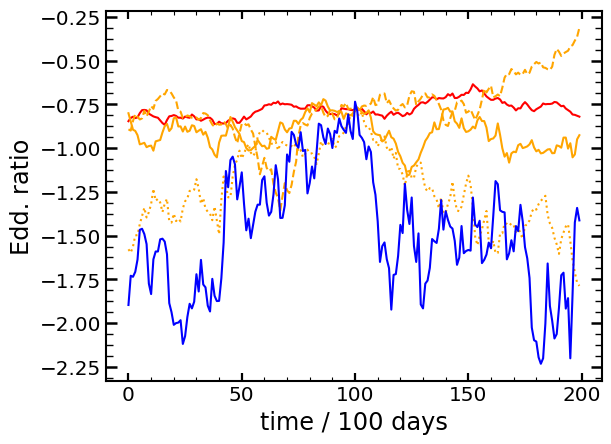

In [584]:
dt_max=100

plt.plot(LC_3345[l][positions_of_specific_Edd_ratio_LC_3345[343]-100:positions_of_specific_Edd_ratio_LC_3345[343]+dt_max],color='red')
plt.plot(LC_4335[l][positions_of_specific_Edd_ratio_LC_4335[82947]-100:positions_of_specific_Edd_ratio_LC_4335[82947]+dt_max],ls='--',color='orange')
plt.plot(LC_4335[l][positions_of_specific_Edd_ratio_LC_4335[1316]-100:positions_of_specific_Edd_ratio_LC_4335[1316]+dt_max],ls=':',color='orange')
plt.plot(LC_4335[l][positions_of_specific_Edd_ratio_LC_4335[2000]-100:positions_of_specific_Edd_ratio_LC_4335[2000]+dt_max],ls='-',color='orange')
plt.plot(LC_5325[l][positions_of_specific_Edd_ratio_LC_5325[611]-100:positions_of_specific_Edd_ratio_LC_5325[611]+dt_max],color='blue')
plt.xlabel('time / 100 days')
plt.ylabel('Edd. ratio')

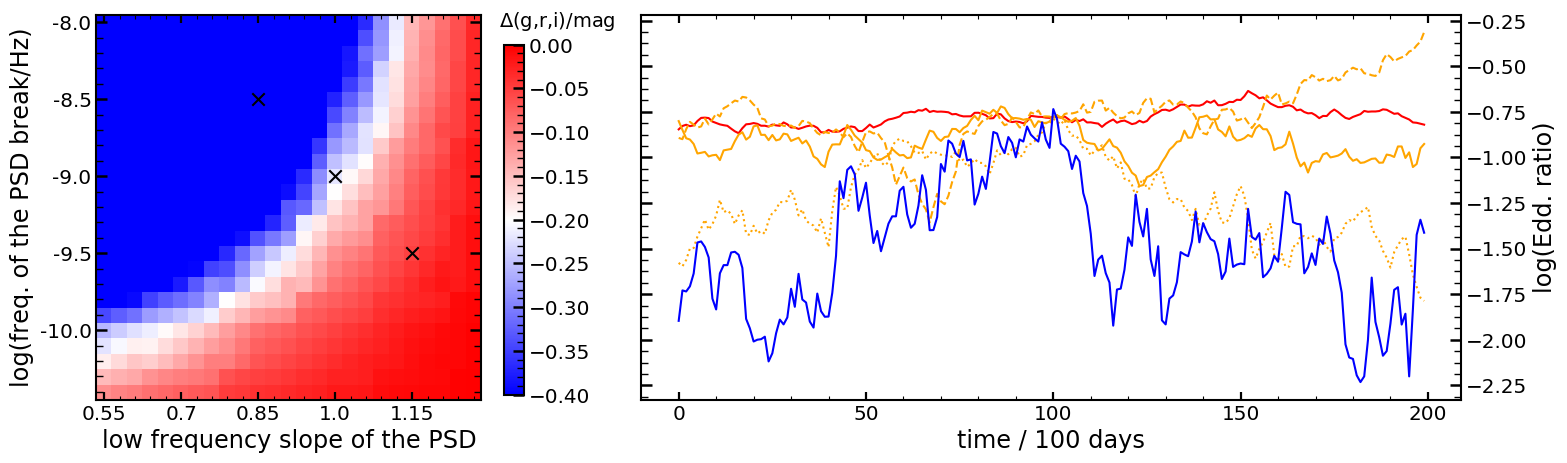

In [592]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Fixing random state for reproducibility
np.random.seed(19680801)


# the random data
x = np.random.randn(1000)
y = np.random.randn(1000)


fig, axScatter = plt.subplots(figsize=(20, 5))



# the scatter plot:
img=axScatter.imshow(res_detailed[:,2].reshape(31,31)[6:,:-6],origin='lower',cmap='bwr',vmax=0,vmin=-0.40)
axScatter.imshow(res_detailed[:,2].reshape(31,31)[6:,:-6],origin='lower',cmap='bwr',vmax=0,vmin=-0.40)
axScatter.set_xticks(list(range(0,21,5)))
axScatter.set_yticks(range(4,25,5))
axScatter.set_xticklabels(slopes_values)
axScatter.set_yticklabels(freq_values[2:])


axScatter.set_xlabel('low frequency slope of the PSD')
axScatter.set_ylabel('log(freq. of the PSD break/Hz)')



axScatter.set_aspect(1.)
axScatter.scatter(x=[10,15,20],y=[19,14,9],color='black',marker='x',s=80)
# create new axes on the right and on the top of the current axes
# The first argument of the new_vertical(new_horizontal) method is
# the height (width) of the axes to be created in inches.
divider = make_axes_locatable(axScatter)
axHisty = divider.append_axes("right", 8.2, pad=1.6)

# make some labels invisible

axHisty.yaxis.set_tick_params(labelright=True,labelleft=False)

plt.plot(LC_3345[l][positions_of_specific_Edd_ratio_LC_3345[343]-100:positions_of_specific_Edd_ratio_LC_3345[343]+dt_max],color='red')
plt.plot(LC_4335[l][positions_of_specific_Edd_ratio_LC_4335[82947]-100:positions_of_specific_Edd_ratio_LC_4335[82947]+dt_max],ls='--',color='orange')
plt.plot(LC_4335[l][positions_of_specific_Edd_ratio_LC_4335[1316]-100:positions_of_specific_Edd_ratio_LC_4335[1316]+dt_max],ls=':',color='orange')
plt.plot(LC_4335[l][positions_of_specific_Edd_ratio_LC_4335[2000]-100:positions_of_specific_Edd_ratio_LC_4335[2000]+dt_max],ls='-',color='orange')
plt.plot(LC_5325[l][positions_of_specific_Edd_ratio_LC_5325[611]-100:positions_of_specific_Edd_ratio_LC_5325[611]+dt_max],color='blue')

axHisty.set_xlabel('time / 100 days')
axHisty.set_ylabel('log(Edd. ratio)')
axHisty.yaxis.set_label_position("right")


# the xaxis of axHistx and yaxis of axHisty are shared with axScatter,
# thus there is no need to manually adjust the xlim and ylim of these
# axis.
#divider = make_axes_locatable(axScatter)
#cax1 = divider.append_axes("right", size="5%", pad=0.05)

cax = fig.add_axes([0.375, 0.12, 0.01, 0.7])
clb=plt.colorbar(img,cax=cax)
clb.set_label('$\Delta$(g,r,i)/mag', labelpad=-24, y=1.10, rotation=0,fontsize=14)

axHisty.set_xticks([0, 50, 100,150,200])

plt.show()
fig.savefig('/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/Figures/Paper_Figures/' + 'Figure5_delta_model.pdf', bbox_inches='tight')

# Figures for the paper 

## master plot for the paper 

In [9]:
matched_array_filtered=np.load(DATA_DIRECTORY+'matched_array_filtered.npy') 

In [50]:
# g-band
res_delta_redshift_via_redshift_array_g,res_delta_redshift_via_redshift_median_array_g,res_delta_redshift_via_redshift_err_array_g,res_delta_redshift_via_redshift_median_err_array_g,\
res_redshift_array_g,p20_array_g,p20_median_array_g,median_mag_values_array_g=create_redshift_result(matched_array_filtered,100,sdss_band_column=4,difference_sdss_HSC_columns=14,return_median_mag_values=True)

p20_array_g=[]
for i in range(6):
    res_redshift_array_single_g=res_redshift_array_g[i]
    res_delta_redshift_via_redshift_array_single_g=res_delta_redshift_via_redshift_array_g[i]
    res_delta_redshift_via_redshift_err_array_single_g=res_delta_redshift_via_redshift_err_array_g[i]   
        
    p20_array_g.append(create_p20_values(res_redshift_array_single_g,res_delta_redshift_via_redshift_array_single_g,res_delta_redshift_via_redshift_err_array_single_g))
    
p20_array_g_time=[]
for i in range(6):
    res_redshift_array_single_g=res_redshift_array_g[i]
    res_delta_redshift_via_redshift_array_single_g=res_delta_redshift_via_redshift_array_g[i]
    res_delta_redshift_via_redshift_err_array_single_g=res_delta_redshift_via_redshift_err_array_g[i]   
        
    p20_array_g_time.append(create_p20_values(res_redshift_array_single_g,\
                                              res_delta_redshift_via_redshift_array_single_g,res_delta_redshift_via_redshift_err_array_single_g,time_result=True))   

In [47]:
# r-band
res_delta_redshift_via_redshift_array_r,res_delta_redshift_via_redshift_median_array_r,res_delta_redshift_via_redshift_err_array_r,res_delta_redshift_via_redshift_median_err_array_r,\
res_redshift_array_r,p20_array_r,p20_median_array_r,median_mag_values_array_r=create_redshift_result(matched_array_filtered,100,sdss_band_column=6,difference_sdss_HSC_columns=14,return_median_mag_values=True)

p20_array_r=[]
for i in range(6):
    res_redshift_array_single_r=res_redshift_array_r[i]
    res_delta_redshift_via_redshift_array_single_r=res_delta_redshift_via_redshift_array_r[i]
    res_delta_redshift_via_redshift_err_array_single_r=res_delta_redshift_via_redshift_err_array_r[i]   
        
    p20_array_r.append(create_p20_values(res_redshift_array_single_r,res_delta_redshift_via_redshift_array_single_r,res_delta_redshift_via_redshift_err_array_single_r))

In [48]:
# i-band
res_delta_redshift_via_redshift_array_i,res_delta_redshift_via_redshift_median_array_i,res_delta_redshift_via_redshift_err_array_i,res_delta_redshift_via_redshift_median_err_array_i,\
res_redshift_array_i,p20_array_i,p20_median_array_i,median_mag_values_array_i=create_redshift_result(matched_array_filtered,100,sdss_band_column=8,difference_sdss_HSC_columns=14,return_median_mag_values=True)

p20_array_i=[]
for i in range(6):
    res_redshift_array_single_i=res_redshift_array_i[i]
    res_delta_redshift_via_redshift_array_single_i=res_delta_redshift_via_redshift_array_i[i]
    res_delta_redshift_via_redshift_err_array_single_i=res_delta_redshift_via_redshift_err_array_i[i]   
        
    p20_array_i.append(create_p20_values(res_redshift_array_single_i,res_delta_redshift_via_redshift_array_single_i,res_delta_redshift_via_redshift_err_array_single_i))

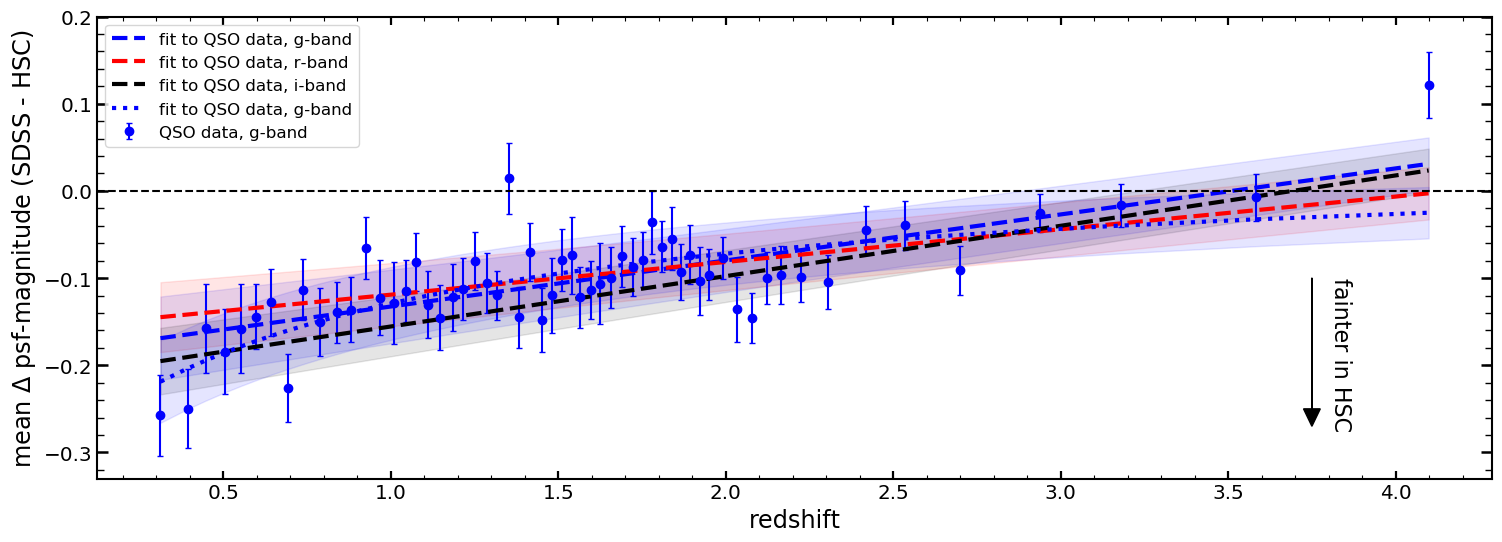

In [54]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
#plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)

plt.errorbar(res_redshift_array_g[0],res_delta_redshift_via_redshift_array_g[0],yerr=res_delta_redshift_via_redshift_err_array_g[0],marker='o',capsize=2,ls='',color='blue',label='QSO data, g-band')
#plt.errorbar(res_redshift_array_g[0]-0.01,res_delta_redshift_via_redshift_median_array[0],yerr=res_delta_redshift_via_redshift_median_err_array_g[0],\
#             marker='o',capsize=2,ls='',color='black',alpha=0.45,label='QSO data')

plt.plot(res_redshift_array_g[0],p20_array_g[0][0],ls='--',color='blue',lw=3,label='fit to QSO data, g-band')
plt.fill_between(res_redshift_array_g[0], p20_array_g[0][2],p20_array_g[0][1], color='blue', alpha='0.1')

plt.plot(res_redshift_array_r[0],p20_array_r[0][0],ls='--',color='red',lw=3,label='fit to QSO data, r-band')
plt.fill_between(res_redshift_array_r[0], p20_array_r[0][2],p20_array_r[0][1], color='red', alpha='0.1')

plt.plot(res_redshift_array_i[0],p20_array_i[0][0],ls='--',color='black',lw=3,label='fit to QSO data, i-band')
plt.fill_between(res_redshift_array_i[0], p20_array_i[0][2],p20_array_i[0][1], color='black', alpha='0.1')

plt.arrow(3.75,-0.10,-0.,-0.15,head_length=0.02,head_width=0.05,color='black')
plt.text(3.8,-0.12,'fainter in HSC',rotation=270,size=16)

plt.plot(res_redshift_array_g[0],p20_array_g_time[0][0],ls=':',color='blue',lw=3,label='fit to QSO data, g-band')
plt.fill_between(res_redshift_array_g[0], p20_array_g_time[0][2],p20_array_g_time[0][1], color='blue', alpha='0.1')

plt.ylabel('mean $\Delta$ psf-magnitude (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.33,0.2)
plt.axhline(0,color='black',ls='--')
plt.legend()
#plt.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=False)


plt.savefig('/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/Figures/Paper_Figures/' + 'master.pdf', bbox_inches='tight')


## filter and stars

In [156]:
matched_array_filtered=np.load(DATA_DIRECTORY+'matched_array_filtered.npy') 
print(len(matched_array_filtered))
# g-band
res_delta_redshift_via_redshift_array_g,res_delta_redshift_via_redshift_median_array_g,res_delta_redshift_via_redshift_err_array_g,res_delta_redshift_via_redshift_median_err_array_g,\
res_redshift_array_g,p20_array_g,p20_median_array_g,median_mag_values_array_g=create_redshift_result(matched_array_filtered,100,sdss_band_column=4,difference_sdss_HSC_columns=14,return_median_mag_values=True)


5919


In [157]:
res_redshift_array_single_g=res_redshift_array_g[0]
res_delta_redshift_via_redshift_array_single_g=res_delta_redshift_via_redshift_array_g[0]
res_delta_redshift_via_redshift_err_array_single_g=res_delta_redshift_via_redshift_err_array_g[0]

p20_array_g=[]
for i in range(6):
    res_redshift_array_single_g=res_redshift_array_g[i]
    res_delta_redshift_via_redshift_array_single_g=res_delta_redshift_via_redshift_array_g[i]
    res_delta_redshift_via_redshift_err_array_single_g=res_delta_redshift_via_redshift_err_array_g[i]   
        
    p20_array_g.append(create_p20_values(res_redshift_array_single_g,res_delta_redshift_via_redshift_array_single_g,res_delta_redshift_via_redshift_err_array_single_g))

In [158]:
# g-band - fake
matched_array_fake_QSO=np.load(DATA_DIRECTORY+'matched_array_fake_QSO.npy')
print(len(matched_array_fake_QSO))

res_delta_redshift_via_redshift_fake_QSO_array_g,res_delta_redshift_via_redshift_median_fake_QSO_array_g,res_delta_redshift_via_redshift_fake_QSO_err_array_g,res_delta_redshift_via_redshift_median_fake_QSO_err_array_g,\
res_redshift_fake_QSO_array_g,p20_fake_QSO_array_g,p20_median_fake_QSO_array_g=create_redshift_result(matched_array_fake_QSO,100,sdss_band_column=4,difference_sdss_HSC_columns=14)

2671


In [159]:
res_redshift_fake_QSO_array=res_redshift_fake_QSO_array_g
res_delta_redshift_via_redshift_fake_QSO_array=res_delta_redshift_via_redshift_fake_QSO_array_g
res_delta_redshift_via_redshift_fake_QSO_err_array=res_delta_redshift_via_redshift_fake_QSO_err_array_g
res_redshift_fake_QSO_array_single_g=res_redshift_fake_QSO_array_g[0]
res_delta_redshift_via_redshift_fake_QSO_array_single_g=res_delta_redshift_via_redshift_fake_QSO_array_g[0]
res_delta_redshift_via_redshift_fake_QSO_err_array_single_g=res_delta_redshift_via_redshift_fake_QSO_err_array_g[0]

p20_fake_QSO_array_g=[]
for i in range(6):
    res_redshift_array_fake_QSO_single_g=res_redshift_fake_QSO_array_g[i]
    res_delta_redshift_via_redshift_fake_QSO_array_single_g=res_delta_redshift_via_redshift_fake_QSO_array_g[i]
    res_delta_redshift_via_redshift_fake_QSO_err_array_single_g=res_delta_redshift_via_redshift_fake_QSO_err_array_g[i]   
        
    p20_fake_QSO_array_g.append(create_p20_values(res_redshift_fake_QSO_array_single_g,res_delta_redshift_via_redshift_fake_QSO_array_single_g,res_delta_redshift_via_redshift_fake_QSO_err_array_single_g))

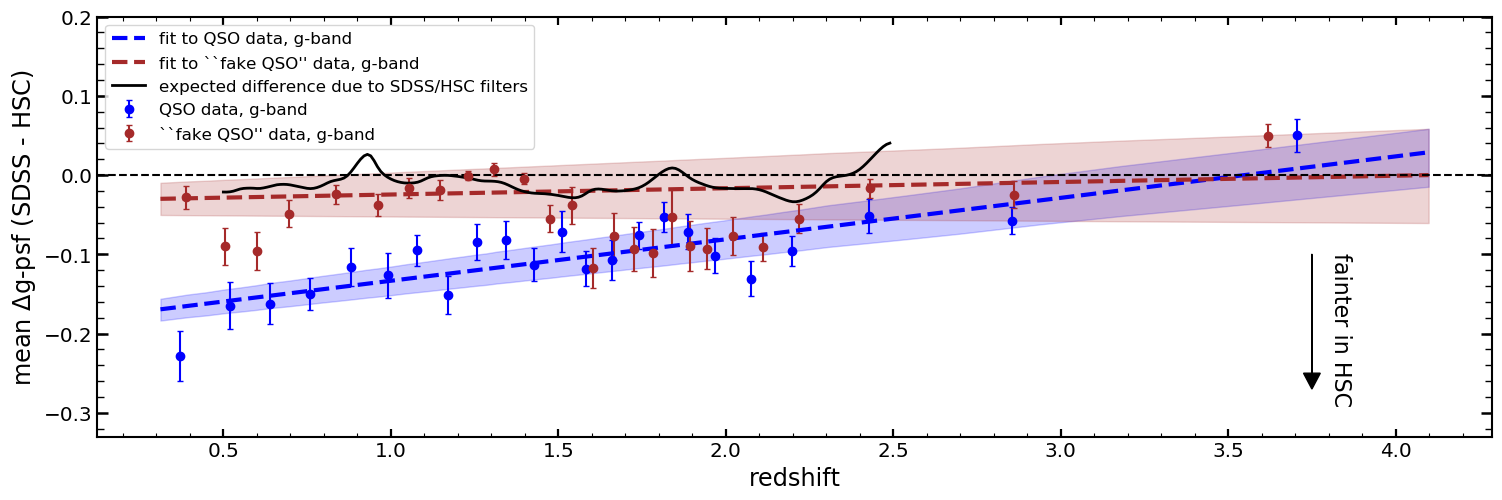

In [162]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,12))
#plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)

plt.subplot(211)
plt.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_array[0],yerr=res_delta_redshift_via_redshift_err_array[0],marker='o',capsize=2,ls='',color='blue',label='QSO data, g-band')
#plt.plot(res_redshift_array[0],p20_array[0](res_redshift_array[0]),ls='-',color='orange',lw=3,label='fit to QSO')
plt.errorbar(res_redshift_fake_QSO_array[0],res_delta_redshift_via_redshift_fake_QSO_array[0],yerr=res_delta_redshift_via_redshift_fake_QSO_err_array[0],\
             marker='o',capsize=2,ls='',color='brown',label='``fake QSO\'\' data, g-band')
#plt.plot(res_redshift_fake_QSO_array[0],p20_fake_QSO_array[0](res_redshift_fake_QSO_array[0]),color='orange',lw=3,label='fit to ``fake QSO\'\' ',ls=':')

plt.plot(res_redshift_array_g[0],p20_array_g[0][0](res_redshift_array_g[0]),ls='--',color='blue',lw=3,label='fit to QSO data, g-band')
plt.fill_between(res_redshift_array_g[0], p20_array_g[0][2](res_redshift_array_g[1]),p20_array_g[0][1](res_redshift_array_g[1]), color='blue', alpha='0.2')

plt.plot(res_redshift_array_g[0],p20_fake_QSO_array_g[0][0](res_redshift_array_g[0]),ls='--',color='brown',lw=3,label='fit to ``fake QSO\'\' data, g-band')
plt.fill_between(res_redshift_array_g[0], p20_fake_QSO_array_g[0][2](res_redshift_array_g[1]),p20_fake_QSO_array_g[0][1](res_redshift_array_g[1]), color='brown', alpha='0.2')


plt.plot(HSC_SDSS_filter_redshift_dependence_redshift,-HSC_SDSS_filter_redshift_dependence_dg_Vandenberk,ls='-',color='black',lw=2,label='expected difference due to SDSS/HSC filters')

plt.arrow(3.75,-0.10,-0.,-0.15,head_length=0.02,head_width=0.05,color='black')
plt.text(3.8,-0.12,'fainter in HSC',rotation=270,size=16)

plt.ylabel('mean $\Delta$g-psf (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.33,0.2)
plt.axhline(0,color='black',ls='--')
plt.legend()

plt.savefig('/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/Figures/Paper_Figures/' + 'master_filter_stars.pdf', bbox_inches='tight')


## luminosity separation

In [173]:
res_redshift_array=res_redshift_array_g
p20_array=p20_array_g

In [174]:
upper_limit_many=[]
lower_limit_many=[]
for i in range(5):
    lower_limit_single=-p20_array[i][0](res_redshift_array[0])+ p20_array_g[i][2](res_redshift_array[0])
    upper_limit_single=-p20_array[1][0](res_redshift_array[0])+p20_array_g[1][1](res_redshift_array[0])    
    upper_limit_many.append(lower_limit_single)
    lower_limit_many.append(upper_limit_single)

upper_limit_many=np.mean(np.array(upper_limit_many),axis=0)
lower_limit_many=np.mean(np.array(lower_limit_many),axis=0)

mean_err_single_point=np.mean([np.mean(res_delta_redshift_via_redshift_err_array_g[1]),np.mean(res_delta_redshift_via_redshift_err_array_g[2]),\
        np.mean(res_delta_redshift_via_redshift_err_array_g[3]),np.mean(res_delta_redshift_via_redshift_err_array_g[4]),\
       np.mean(res_delta_redshift_via_redshift_err_array_g[5])])

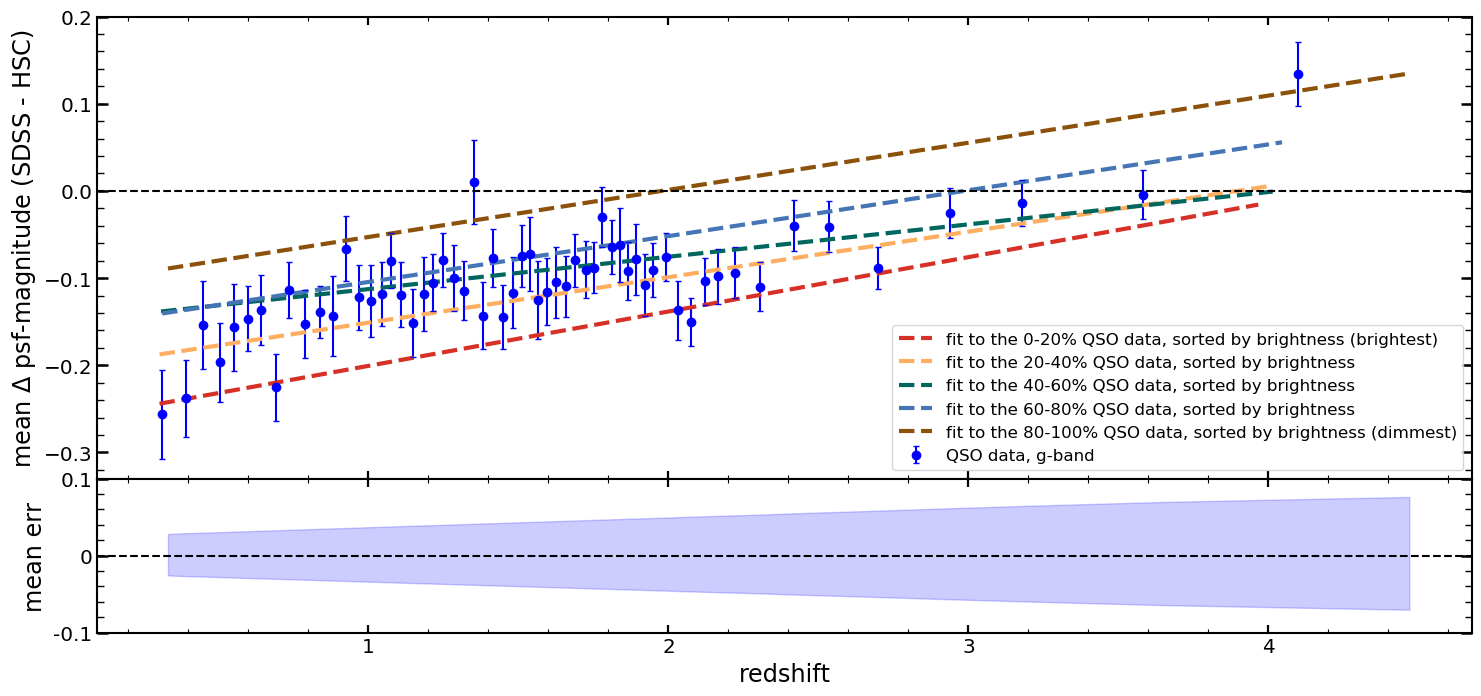

In [175]:


# Set up the axes with gridspec
fig = plt.figure(figsize=(24, 8))
grid = plt.GridSpec(4, 4, hspace=0., wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
err_ax = fig.add_subplot(grid[-1, 1:], yticklabels=[-0.1,0,0.1], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(res_redshift_array[1],p20_array[1][0](res_redshift_array[1]),ls='--',color='#d73027',alpha=1,lw=3,
             label='fit to the 0-20% QSO data, sorted by brightness (brightest)')
main_ax.plot(res_redshift_array[2],p20_array[2][0](res_redshift_array[2]),ls='--',color='#fdae61',alpha=1,lw=3,
             label='fit to the 20-40% QSO data, sorted by brightness')
main_ax.plot(res_redshift_array[3],p20_array[3][0](res_redshift_array[3]),ls='--',color='#01665e',alpha=1,lw=3,
             label='fit to the 40-60% QSO data, sorted by brightness')
main_ax.plot(res_redshift_array[4],p20_array[4][0](res_redshift_array[4]),ls='--',color='#4575b4',alpha=1,lw=3,
             label='fit to the 60-80% QSO data, sorted by brightness')
main_ax.plot(res_redshift_array[5],p20_array[5][0](res_redshift_array[5]),ls='--',color='#8c510a',alpha=1,lw=3,
             label='fit to the 80-100% QSO data, sorted by brightness (dimmest)')

main_ax.errorbar(res_redshift_array_g[0],res_delta_redshift_via_redshift_array_g[0],yerr=res_delta_redshift_via_redshift_err_array_g[0],\
                 marker='o',capsize=2,ls='',color='blue',label='QSO data, g-band')

#main_ax.errorbar(res_redshift_array_g[5],res_delta_redshift_via_redshift_array_g[5],yerr=res_delta_redshift_via_redshift_err_array_g[5],marker='o',capsize=2,ls='',color='blue',label='QSO data, g-band')

#main_ax.errorbar(0.1,0.1,yerr=mean_err_single_point,\
#                 marker='o',capsize=2,ls='',color='black',label='QSO data, g-band')


#main_ax.arrow(3.75,-0.10,-0.,-0.15,head_length=0.02,head_width=0.05,color='black')
#main_ax.text(3.8,-0.12,'fainter in HSC',rotation=270,size=16)


main_ax.set_ylabel('mean $\Delta$ psf-magnitude (SDSS - HSC)')
main_ax.set_xlabel('redshift')
main_ax.set_ylim(-0.33,0.2)
main_ax.axhline(0,color='black',ls='--')
main_ax.legend()

# histogram on the attached axes
err_ax.fill_between(res_redshift_array[5],lower_limit_many,upper_limit_many, color='blue', alpha='0.2')
err_ax.set_ylim(-0.1,0.1)
err_ax.axhline(0,color='black',ls='--')
err_ax.set_ylabel('mean err')
err_ax.set_xlabel('redshift')
plt.savefig('/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/Figures/Paper_Figures/' + 'luminosity_separated.pdf', bbox_inches='tight')

## time separation 

In [167]:
res_redshift_all_short_long=create_redshift_result(matched_array_filtered,250,sdss_band_column=4,difference_sdss_HSC_columns=14,\
                                                   return_median_mag_values=True,separate_in_time_dif=True,time_dif_array=time_difference_between_observations_in_g_band_SDSS_mean_HSC)

In [168]:
# g-band
res_delta_redshift_via_redshift_array,res_delta_redshift_via_redshift_median_array,res_delta_redshift_via_redshift_err_array,res_delta_redshift_via_redshift_median_err_array,\
res_redshift_array,p20_array,p20_median_array,median_mag_values_array=res_redshift_all_short_long[0]

res_delta_redshift_via_redshift_short_separations_array,res_delta_redshift_via_redshift_median_short_separations_array,\
res_delta_redshift_via_redshift_err_short_separations_array,res_delta_redshift_via_redshift_median_err_short_separations_array,\
res_redshift_short_separations_array,p20_short_separations_array,p20_median_short_separations_array,median_mag_value_short_separations_array=\
res_redshift_all_short_long[1]

res_delta_redshift_via_redshift_long_separations_array,res_delta_redshift_via_redshift_median_long_separations_array,\
res_delta_redshift_via_redshift_err_long_separations_array,res_delta_redshift_via_redshift_median_err_long_separations_array,\
res_redshift_long_separations_array,p20_long_separations_array,p20_median_long_separations_array,median_mag_value_long_separations_array=\
res_redshift_all_short_long[2]

In [169]:
res_redshift_array_single_g=res_redshift_short_separations_array[0]
res_delta_redshift_via_redshift_array_single_g=res_delta_redshift_via_redshift_short_separations_array[0]
res_delta_redshift_via_redshift_err_array_single_g=res_delta_redshift_via_redshift_err_short_separations_array[0]

p20_array_short_separations_g=[]
for i in range(6):
    res_redshift_array_single_g=res_redshift_short_separations_array[i]
    res_delta_redshift_via_redshift_array_single_g=res_delta_redshift_via_redshift_short_separations_array[i]
    res_delta_redshift_via_redshift_err_array_single_g=res_delta_redshift_via_redshift_err_short_separations_array[i]   
        
    p20_array_short_separations_g.append(create_p20_values(res_redshift_array_single_g,res_delta_redshift_via_redshift_array_single_g,res_delta_redshift_via_redshift_err_array_single_g))
    
res_redshift_array_single_g=res_redshift_short_separations_array[0]
res_delta_redshift_via_redshift_array_single_g=res_delta_redshift_via_redshift_short_separations_array[0]
res_delta_redshift_via_redshift_err_array_single_g=res_delta_redshift_via_redshift_err_short_separations_array[0]

p20_array_long_separations_g=[]
for i in range(6):
    res_redshift_array_single_g=res_redshift_long_separations_array[i]
    res_delta_redshift_via_redshift_array_single_g=res_delta_redshift_via_redshift_long_separations_array[i]
    res_delta_redshift_via_redshift_err_array_single_g=res_delta_redshift_via_redshift_err_long_separations_array[i]   
        
    p20_array_long_separations_g.append(create_p20_values(res_redshift_array_single_g,res_delta_redshift_via_redshift_array_single_g,res_delta_redshift_via_redshift_err_array_single_g))    

In [170]:
print(len(res_delta_redshift_via_redshift_array[0]))
print(len(res_redshift_array[0]))
print(len(res_delta_redshift_via_redshift_err_array[0]))

23
23
23


In [171]:
    lower_limit_short=-p20_array_short_separations_g[0][0](res_redshift_array[0])+p20_array_short_separations_g[0][2](res_redshift_array[0])
    upper_limit_short=-p20_array_short_separations_g[0][0](res_redshift_array[0])+p20_array_short_separations_g[0][1](res_redshift_array[0]) 
    lower_limit_long=-p20_array_long_separations_g[0][0](res_redshift_array[0])+p20_array_long_separations_g[0][2](res_redshift_array[0])
    upper_limit_long=-p20_array_long_separations_g[0][0](res_redshift_array[0])+p20_array_long_separations_g[0][1](res_redshift_array[0]) 

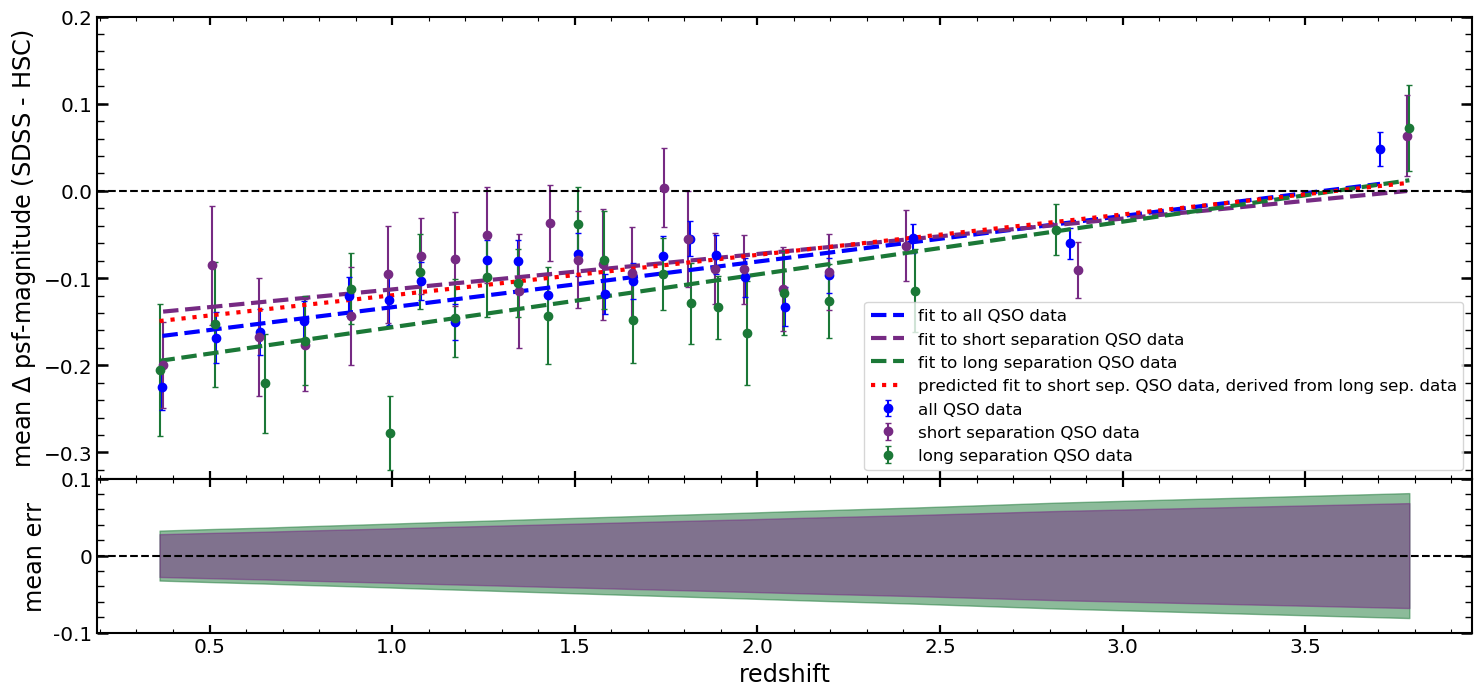

In [172]:

# Set up the axes with gridspec
fig = plt.figure(figsize=(24, 8))
grid = plt.GridSpec(4, 4, hspace=0., wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
err_ax = fig.add_subplot(grid[-1, 1:], yticklabels=[-0.1,0,0.1], sharex=main_ax)

# scatter points on the main axes
main_ax.errorbar(res_redshift_array[0],res_delta_redshift_via_redshift_array[0],yerr=res_delta_redshift_via_redshift_err_array[0],\
                 marker='o',capsize=2,ls='',color='blue',label='all QSO data')


main_ax.plot(res_redshift_array[0],p20_array_g[0][0](res_redshift_array[0]),ls='--',color='blue',lw=3,label='fit to all QSO data')

main_ax.errorbar(res_redshift_short_separations_array[0],res_delta_redshift_via_redshift_short_separations_array[0],
             yerr=res_delta_redshift_via_redshift_err_short_separations_array[0],marker='o',capsize=2,ls='',color='#762a83',label='short separation QSO data')
main_ax.plot(res_redshift_short_separations_array[0],p20_array_short_separations_g[0][0](res_redshift_short_separations_array[0]),ls='--',color='#762a83',lw=3,label='fit to short separation QSO data')
main_ax.errorbar(res_redshift_long_separations_array[0],res_delta_redshift_via_redshift_long_separations_array[0],
             yerr=res_delta_redshift_via_redshift_err_long_separations_array[0],marker='o',capsize=2,ls='',color='#1b7837',label='long separation QSO data')
main_ax.plot(res_redshift_long_separations_array[0],p20_array_long_separations_g[0][0](res_redshift_long_separations_array[0]),ls='--',color='#1b7837',lw=3,label='fit to long separation QSO data')

main_ax.plot(res_redshift_long_separations_array[0],(0.1293/0.1689)*p20_array_long_separations_g[0][0](res_redshift_long_separations_array[0]),ls=':',
         color='red',lw=3,label='predicted fit to short sep. QSO data, derived from long sep. data')


#main_ax.errorbar(res_redshift_array_g[5],res_delta_redshift_via_redshift_array_g[5],yerr=res_delta_redshift_via_redshift_err_array_g[5],marker='o',capsize=2,ls='',color='blue',label='QSO data, g-band')

#main_ax.errorbar(0.1,0.1,yerr=mean_err_single_point,\
#                 marker='o',capsize=2,ls='',color='black',label='QSO data, g-band')


#main_ax.arrow(3.75,-0.10,-0.,-0.15,head_length=0.02,head_width=0.05,color='black')
#main_ax.text(3.8,-0.12,'fainter in HSC',rotation=270,size=16)


main_ax.set_ylabel('mean $\Delta$ psf-magnitude (SDSS - HSC)')
main_ax.set_xlabel('redshift')
main_ax.set_ylim(-0.33,0.2)
main_ax.axhline(0,color='black',ls='--')
main_ax.legend()

# histogram on the attached axes
err_ax.fill_between(res_redshift_long_separations_array[0],lower_limit_long,upper_limit_long, color='#1b7837', alpha='0.5')
err_ax.fill_between(res_redshift_long_separations_array[0],lower_limit_short,upper_limit_short, color='#762a83', alpha='0.5')


err_ax.set_ylim(-0.1,0.1)
err_ax.axhline(0,color='black',ls='--')
err_ax.set_ylabel('mean err')
err_ax.set_xlabel('redshift')

plt.savefig('/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/Figures/Paper_Figures/' + 'time_separated.pdf', bbox_inches='tight')


# Rethinking plots for the paper

## master plot for the paper - median

In [23]:
matched_array_filtered=np.load(DATA_DIRECTORY+'matched_array_filtered.npy') 

In [24]:
# g-band
res_delta_redshift_via_redshift_array_g,res_delta_redshift_via_redshift_median_array_g,\
res_delta_redshift_via_redshift_err_array_g,res_delta_redshift_via_redshift_median_err_array_g,\
res_redshift_array_g,p20_array_g,p20_median_array_g,median_mag_values_array_g\
=create_redshift_result(matched_array_filtered,100,sdss_band_column=4,difference_sdss_HSC_columns=14,return_median_mag_values=True)

p20_array_g=[]
for i in range(6):
    res_redshift_array_single_g=res_redshift_array_g[i]
    res_delta_redshift_via_redshift_median_array_single_g=res_delta_redshift_via_redshift_median_array_g[i]
    res_delta_redshift_via_redshift_err_array_single_g=res_delta_redshift_via_redshift_median_err_array_g[i]   
        
    p20_array_g.append(create_p20_values(res_redshift_array_single_g,\
                                         res_delta_redshift_via_redshift_median_array_single_g,\
                                         res_delta_redshift_via_redshift_err_array_single_g))

[[ 4.93148283e-05 -8.11222530e-05]
 [-8.11222530e-05  1.63458866e-04]]
[4.93148283e-05 1.63458866e-04]
[0.00702245 0.0127851 ]
[0.00954239 0.00910452 0.00881023 0.00852238 0.00828301 0.00804929
 0.00782956 0.0075894  0.00737484 0.007139   0.00691104 0.00672134
 0.00653732 0.00636419 0.0062058  0.00607082 0.0059684  0.00584528
 0.00572149 0.00560732 0.00551829 0.0054277  0.00533975 0.00526825
 0.00519686 0.00514593 0.00509549 0.00504934 0.00501577 0.00499291
 0.00497598 0.00496721 0.00496332 0.00496667 0.00497853 0.0049992
 0.00502916 0.00506067 0.00509904 0.00514672 0.00519783 0.00525072
 0.00530776 0.00537991 0.00544821 0.00556429 0.00568509 0.00582726
 0.00598104 0.00614307 0.00636473 0.00669551 0.00720295 0.00776412
 0.00857633 0.00986265 0.01121132 0.0135498  0.01664262]
[[ 0.00015659 -0.00027011]
 [-0.00027011  0.00055428]]
[0.00015659 0.00055428]
[0.01251359 0.02354322]
[0.02656377 0.02523888 0.02453243 0.02365314 0.0230579  0.02240916
 0.02168994 0.02109506 0.02047946 0.01975485

In [25]:
# r-band
res_delta_redshift_via_redshift_array_r,res_delta_redshift_via_redshift_median_array_r,\
res_delta_redshift_via_redshift_err_array_r,res_delta_redshift_via_redshift_median_err_array_r,\
res_redshift_array_r,p20_array_r,p20_median_array_r,median_mag_values_array_r=\
create_redshift_result(matched_array_filtered,100,sdss_band_column=6,difference_sdss_HSC_columns=14,return_median_mag_values=True)

p20_array_r=[]
for i in range(6):
    res_redshift_array_single_r=res_redshift_array_r[i]
    res_delta_redshift_via_redshift_median_array_single_r=res_delta_redshift_via_redshift_median_array_r[i]
    res_delta_redshift_via_redshift_median_err_array_single_r=res_delta_redshift_via_redshift_median_err_array_r[i]   
        
    p20_array_r.append(create_p20_values(res_redshift_array_single_r,\
                                         res_delta_redshift_via_redshift_median_array_single_r,\
                                         res_delta_redshift_via_redshift_median_err_array_single_r))

[[ 5.67248242e-05 -9.30858467e-05]
 [-9.30858467e-05  1.88637043e-04]]
[5.67248242e-05 1.88637043e-04]
[0.00753159 0.01373452]
[0.00882273 0.00845381 0.00820543 0.00796205 0.00775927 0.00756085
 0.00737384 0.00716883 0.006985   0.00678205 0.00658478 0.0064196
 0.00625824 0.0061052  0.00596389 0.00584224 0.00574902 0.0056357
 0.00552004 0.00541142 0.00532505 0.00523522 0.00514554 0.00507019
 0.0049919  0.00493335 0.00487202 0.00481116 0.00476169 0.00472278
 0.00468718 0.00466119 0.00463348 0.00461392 0.00459733 0.00458715
 0.00458371 0.00458617 0.00459367 0.00460722 0.00462518 0.00464641
 0.00467157 0.00470597 0.00474065 0.00480325 0.00487226 0.00495739
 0.0050533  0.00515782 0.00530549 0.00553381 0.00589783 0.00631435
 0.00693503 0.00794582 0.00902804 0.01093498 0.01348822]
[[ 0.00013972 -0.00024257]
 [-0.00024257  0.00049651]]
[0.00013972 0.00049651]
[0.01182022 0.02228248]
[0.01835562 0.0174119  0.01691032 0.01628788 0.01586784 0.01541141
 0.01490729 0.01449202 0.01406414 0.01356324 

In [26]:
# i-band
res_delta_redshift_via_redshift_array_i,res_delta_redshift_via_redshift_median_array_i,\
res_delta_redshift_via_redshift_err_array_i,res_delta_redshift_via_redshift_median_err_array_i,\
res_redshift_array_i,p20_array_i,p20_median_array_i,median_mag_values_array_i=\
create_redshift_result(matched_array_filtered,100,sdss_band_column=8,difference_sdss_HSC_columns=14,return_median_mag_values=True)

res_redshift_array_single_i=res_redshift_array_i[0]
res_delta_redshift_via_redshift_array_single_i=res_delta_redshift_via_redshift_array_i[0]
res_delta_redshift_via_redshift_err_array_single_i=res_delta_redshift_via_redshift_err_array_i[0]

p20_array_i=[]
for i in range(6):
    res_redshift_array_single_i=res_redshift_array_i[i]
    res_delta_redshift_via_redshift_median_array_single_i=res_delta_redshift_via_redshift_median_array_i[i]
    res_delta_redshift_via_redshift_median_err_array_single_i=res_delta_redshift_via_redshift_median_err_array_i[i]   
        
    p20_array_i.append(create_p20_values(res_redshift_array_single_i,\
                                         res_delta_redshift_via_redshift_median_array_single_i,\
                                         res_delta_redshift_via_redshift_median_err_array_single_i))

[[ 6.17656776e-05 -1.03169038e-04]
 [-1.03169038e-04  2.05726800e-04]]
[6.17656776e-05 2.05726800e-04]
[0.00785911 0.01434318]
[0.00982391 0.00937863 0.00907773 0.00878194 0.00853467 0.00829194
 0.0080624  0.00780981 0.0075824  0.0073302  0.0070838  0.00687642
 0.0066728  0.00647862 0.00629833 0.00614227 0.00602211 0.00587529
 0.00572454 0.00558203 0.005468   0.00534868 0.00522874 0.00512726
 0.00502105 0.00494102 0.0048566  0.0047721  0.00470275 0.00464771
 0.00459682 0.00455926 0.00451861 0.00448931 0.00446359 0.00444657
 0.00443871 0.0044395  0.00444717 0.00446297 0.00448498 0.00451165
 0.00454369 0.00458794 0.00463281 0.00471414 0.00480399 0.00491483
 0.00503948 0.00517495 0.00536556 0.00565833 0.00612053 0.00664329
 0.00741252 0.00864674 0.00995069 0.01222094 0.01522899]
[[ 0.00013947 -0.00024984]
 [-0.00024984  0.0005214 ]]
[0.00013947 0.0005214 ]
[0.01180958 0.02283428]
[0.02039881 0.01934706 0.01878626 0.01808828 0.01761581 0.01710091
 0.01653017 0.0160582  0.01556991 0.0149953

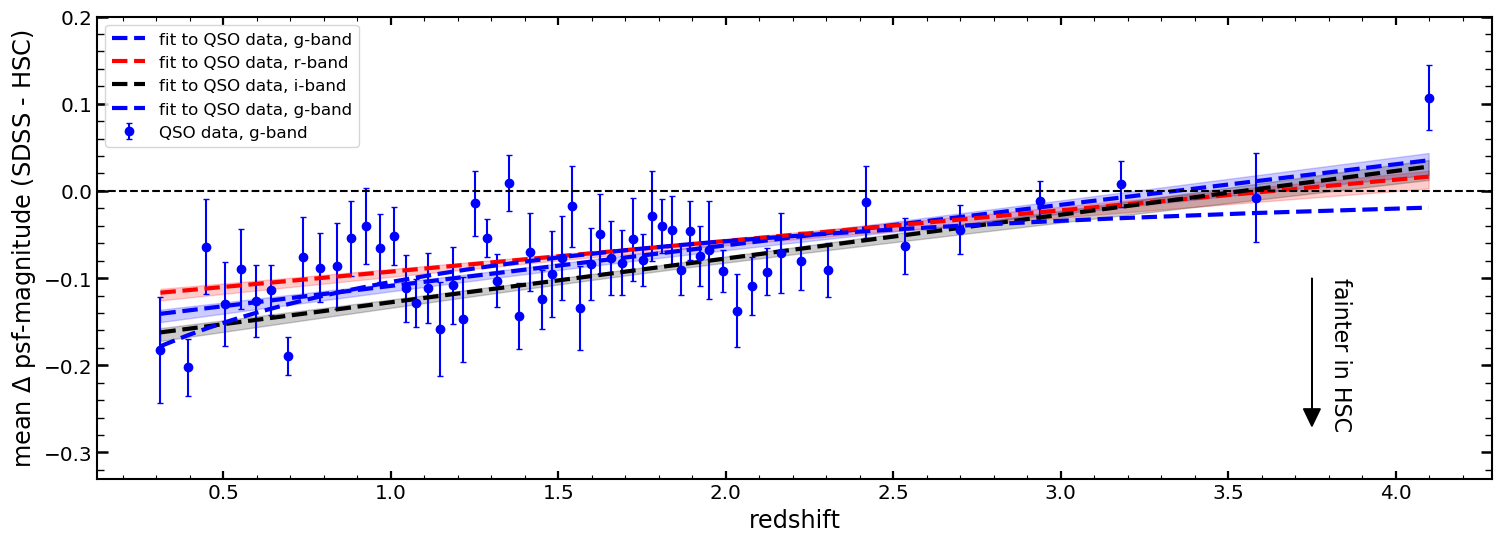

In [44]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
#plt.suptitle('negative values = fainter in HSC; positive values = brighter in HSC',y=0.92,fontsize=20)

plt.errorbar(res_redshift_array_g[0],res_delta_redshift_via_redshift_median_array_g[0],yerr=res_delta_redshift_via_redshift_median_err_array_g[0],marker='o',capsize=2,ls='',color='blue',label='QSO data, g-band')
#plt.errorbar(res_redshift_array_g[0]-0.01,res_delta_redshift_via_redshift_median_array[0],yerr=res_delta_redshift_via_redshift_median_err_array_g[0],\
#             marker='o',capsize=2,ls='',color='black',alpha=0.45,label='QSO data')

plt.plot(res_redshift_array_g[0],p20_array_g[0][0],ls='--',color='blue',lw=3,label='fit to QSO data, g-band')
plt.fill_between(res_redshift_array_g[0], p20_array_g[0][2],p20_array_g[0][1], color='blue', alpha='0.2')

plt.plot(res_redshift_array_r[0],p20_array_r[0][0],ls='--',color='red',lw=3,label='fit to QSO data, r-band')
plt.fill_between(res_redshift_array_r[0], p20_array_r[0][2],p20_array_r[0][1], color='red', alpha='0.2')

plt.plot(res_redshift_array_i[0],p20_array_i[0][0],ls='--',color='black',lw=3,label='fit to QSO data, i-band')
plt.fill_between(res_redshift_array_i[0], p20_array_i[0][2],p20_array_i[0][1], color='black', alpha='0.2')

plt.arrow(3.75,-0.10,-0.,-0.15,head_length=0.02,head_width=0.05,color='black')
plt.text(3.8,-0.12,'fainter in HSC',rotation=270,size=16)


plt.plot(res_redshift_array_g[0],p20_time[1]+(p20_time[0]*14.95)/(1+res_redshift_array_single_g),ls='--',color='blue',lw=3,label='fit to QSO data, g-band')


plt.ylabel('mean $\Delta$ psf-magnitude (SDSS - HSC)')
plt.xlabel('redshift')
plt.ylim(-0.33,0.2)
plt.axhline(0,color='black',ls='--')
plt.legend()
#plt.tick_params(labelbottom=True, labeltop=True, labelleft=True, labelright=False)


#plt.savefig('/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/Figures/Paper_Figures/' + 'master.pdf', bbox_inches='tight')


In [33]:
    i=0
    res_redshift_array_single_g=res_redshift_array_g[i]
    res_delta_redshift_via_redshift_median_array_single_g=res_delta_redshift_via_redshift_median_array_g[i]
    res_delta_redshift_via_redshift_err_array_single_g=res_delta_redshift_via_redshift_median_err_array_g[i]   

In [40]:

poly_fit_order=1
p20_time, covar_time =np.polyfit(14.85/(1+res_redshift_array_single_g),res_delta_redshift_via_redshift_median_array_single_g,poly_fit_order,w=1/res_delta_redshift_via_redshift_err_array_single_g,cov=True)


In [ ]:
    
    #(a*xprime + b) /. xprime -> (time/(1 + x))
   # b + (a time)/(1 + x) 

In [45]:
p20_time[1]+(p20_time[0]*14.85)/(1+res_redshift_array_single_g)

array([-0.17672059, -0.16428315, -0.15658748, -0.14950775, -0.14392027,
       -0.13869949, -0.13398157, -0.12901335, -0.12472167, -0.12014291,
       -0.11583264, -0.11231509, -0.10894679, -0.1058023 , -0.10293134,
       -0.10047627, -0.09859957, -0.09631649, -0.093975  , -0.09175368,
       -0.08996247, -0.08806519, -0.08612195, -0.08443699, -0.08261607,
       -0.08119094, -0.07961879, -0.07794653, -0.07646743, -0.07519271,
       -0.07389598, -0.07282883, -0.07150272, -0.07035191, -0.06905188,
       -0.06776644, -0.06648695, -0.06545018, -0.06441132, -0.0633251 ,
       -0.06232245, -0.06140562, -0.06051684, -0.05950333, -0.05863098,
       -0.05729405, -0.05604886, -0.05472522, -0.05342465, -0.05216867,
       -0.05059816, -0.04849479, -0.04566839, -0.04293872, -0.03949708,
       -0.03488272, -0.03079627, -0.02493028, -0.01876255])

# Testing luminosity result

In [8]:
    matched_array_filtered=np.load("/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_filtered.npy")

    sdss_band_column=4
    difference_sdss_HSC_columns=14
    # sdss magnitude mag - HSC magnitude mag
    # for example, it is sdss psf-g band mag - HSC psf-g band mag if you chose sdss_band_column=4 and difference_sdss_HSC_columns=14
    g_mag_dif=(matched_array_filtered[:,sdss_band_column]-matched_array_filtered[:,difference_sdss_HSC_columns+sdss_band_column]).astype(float)
    # error sdss  mag - HSC band mag
    # for example, error sdss g band mag - HSC g band mag f you chose sdss_band_column=4 and difference_sdss_HSC_columns=14
    g_mag_dif_err=np.sqrt(((matched_array_filtered[:,sdss_band_column+1]).astype(float))**2+((matched_array_filtered[:,difference_sdss_HSC_columns+sdss_band_column+1]).astype(float))**2)
    # insert differences in the catalog
    # this 4 has nothing to do with the ``sdss_band_column=4''
    matched_array_filtered_with_g_mag_dif=np.insert(matched_array_filtered, 4, g_mag_dif, axis=1)
    matched_array_filtered_with_g_mag_dif_and_err=np.insert(matched_array_filtered_with_g_mag_dif, 5, g_mag_dif_err, axis=1)
    
    # array with has delta g as the first column, redshift as the second column
    delta_g_and_redshift=matched_array_filtered_with_g_mag_dif_and_err[:,[4,3]]
    # array with has delta g as the first column, redshift as the second column, 3rd colum is the magnitude of the objects
    delta_g_and_redshift_and_g=matched_array_filtered_with_g_mag_dif_and_err[:,[4,3,6]]

In [18]:
matched_array_filtered[1000]

array(['090106.38+042838.0', 135.276602, 4.477226, 1.92,
       19.374000000000002, 0.018000000000000002, 19.345, 0.019, 18.963,
       0.019, 135.27661374708285, 4.4772273591793335, 19.4431267,
       0.00105642364, 19.387085, 0.00166933576, 19.0027924,
       0.000828879827, 19.434166, 0.000935574819, 19.384923899999997,
       0.0012631082199999998, 19.0039501, 0.000831939338,
       4.5243391654520536e+16], dtype=object)

In [16]:
matched_array_filtered[1000][4]

19.374000000000002

In [17]:
matched_array_filtered[1000][18]

19.434166

In [15]:
dr7

NameError: name 'dr7' is not defined

In [9]:
number_of_objects_in_bin=100
delta_g_and_redshift_sorted_by_redshift_g_and_split=np.array_split(delta_g_and_redshift_and_g[np.argsort(delta_g_and_redshift_and_g[:,1])],int(len(delta_g_and_redshift_and_g)/number_of_objects_in_bin))

In [314]:
bright_sample=[]
dim_sample=[]
for i in range(59):
    delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin=delta_g_and_redshift_sorted_by_redshift_g_and_split[i]
    #bright go first
    delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin_sorted_bright=\
    delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin[np.argsort(delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin[:,2])]

    if i==0:
        bright_sample=delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin_sorted_bright[:20]
        bright_sample_20_40=delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin_sorted_bright[20:40]
        bright_sample_40_60=delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin_sorted_bright[40:60]
        bright_sample_60_80=delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin_sorted_bright[60:80]
        dim_sample=delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin_sorted_bright[-20:]
    else:
        bright_sample=np.concatenate((bright_sample,delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin_sorted_bright[:20]))
        bright_sample_20_40=np.concatenate((bright_sample_20_40,delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin_sorted_bright[20:40]))
        bright_sample_40_60=np.concatenate((bright_sample_40_60,delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin_sorted_bright[40:60]))
        bright_sample_60_80=np.concatenate((bright_sample_60_80,delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin_sorted_bright[60:80]))
        dim_sample=np.concatenate((dim_sample,delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin_sorted_bright[-20:]))

    #bright_sample.append(delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin_sorted_bright[:20])
    #dim_sample.append(delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin_sorted_bright[-20:])

Text(0.5,0,'redshift')

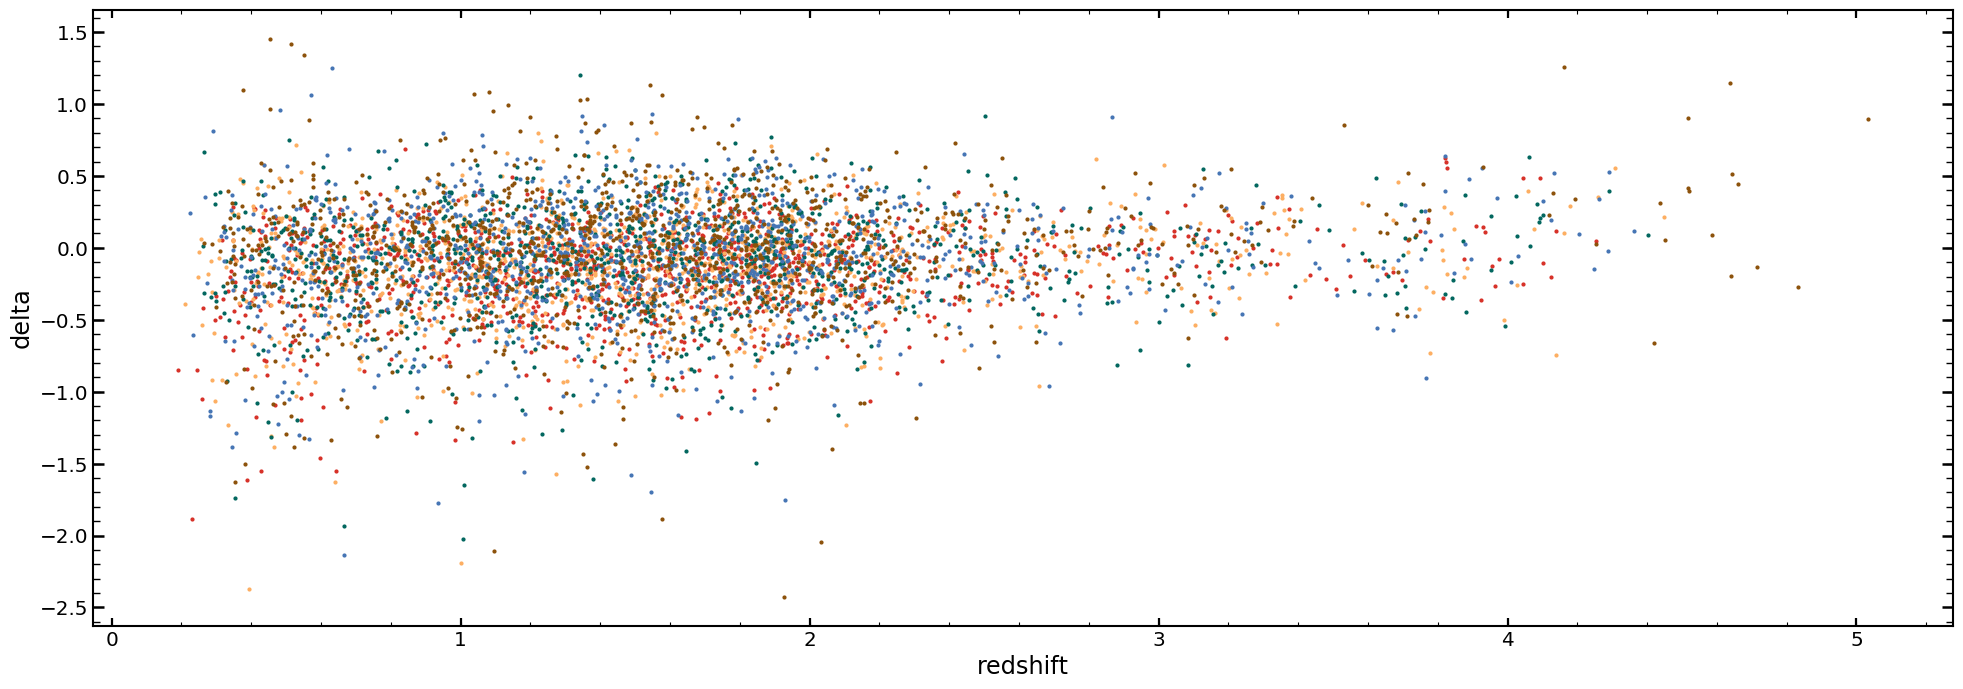

In [321]:
fig = plt.figure(figsize=(24, 8))
plt.scatter(bright_sample[:,1],bright_sample[:,0],s=4,color='#d73027')
plt.scatter(bright_sample_20_40[:,1],bright_sample_20_40[:,0],s=4,color='#fdae61')
plt.scatter(bright_sample_40_60[:,1],bright_sample_40_60[:,0],s=4,color='#01665e')
plt.scatter(bright_sample_60_80[:,1],bright_sample_60_80[:,0],s=4,color='#4575b4')
plt.scatter(dim_sample[:,1],dim_sample[:,0],s=4,color='#8c510a')
plt.ylabel('delta')
plt.xlabel('redshift')

Text(0.5,0,'redshift')

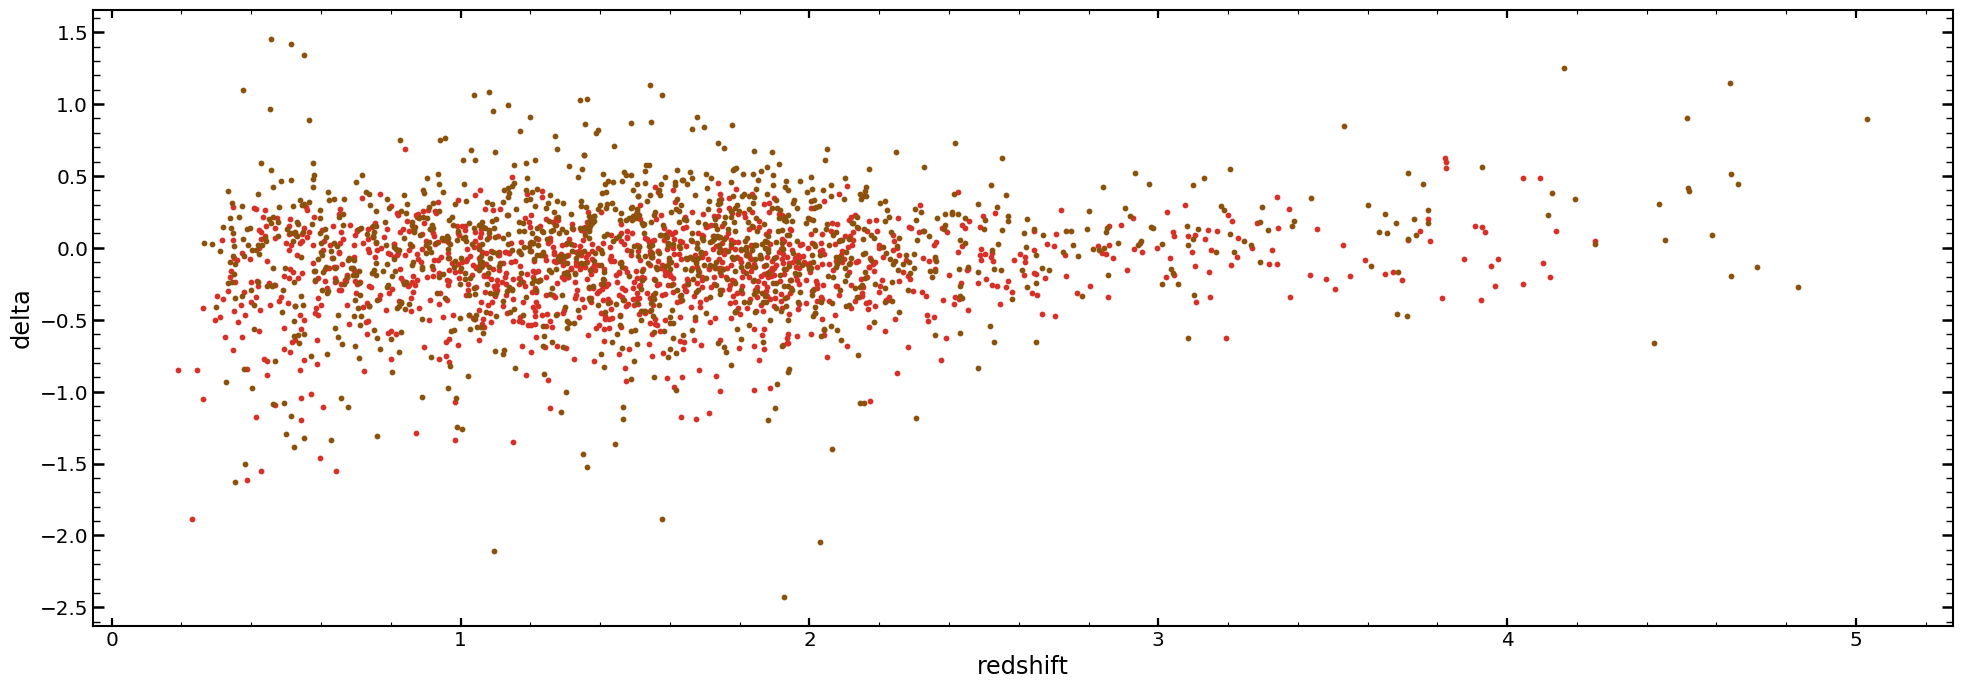

In [322]:
fig = plt.figure(figsize=(24, 8))
plt.scatter(bright_sample[:,1],bright_sample[:,0],s=10,color='#d73027')

plt.scatter(dim_sample[:,1],dim_sample[:,0],s=10,color='#8c510a')
plt.ylabel('delta')
plt.xlabel('redshift')

In [279]:
# dim
print(np.mean(delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin_sorted_bright[-20:][:,0]))

-0.006067414999999699


In [280]:
test=[]
for i in range(100):
    test.append(np.mean(bootstrap_resample(delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin_sorted_bright[-20:][:,0])))
    
np.mean(test)   

-0.0038816823999996987

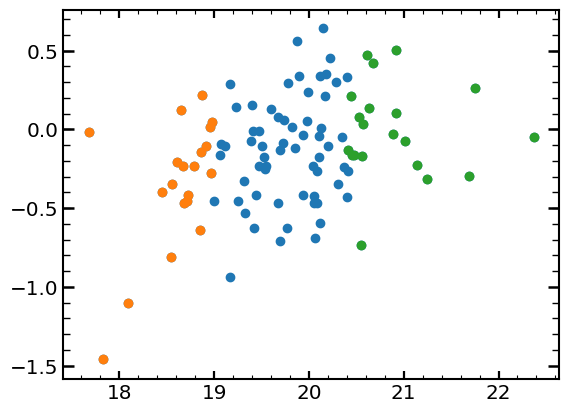

In [281]:
plt.scatter(delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin_sorted_bright[:,2],\
            delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin_sorted_bright[:,0])
plt.scatter(delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin_sorted_bright[:20][:,2],\
            delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin_sorted_bright[:20][:,0])
plt.scatter(delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin_sorted_bright[-20:][:,2],\
            delta_g_and_redshift_sorted_by_redshift_g_and_split_single_bin_sorted_bright[-20:][:,0])

# GAIA 

In [11]:
# This is dr7 qso catalog from https://classic.sdss.org/dr7/products/value_added/qsocat_dr7.html

dr7 = pd.read_csv(DATA_DIRECTORY+'dr7qso.dat',skiprows=80,sep='\s+',engine='python', error_bad_lines=False, header=None )
Positions_of_dr7=np.transpose([dr7[1].values,dr7[2].values])

Skipping line 305: Expected 75 fields in line 305, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1633: Expected 75 fields in line 1633, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1745: Expected 75 fields in line 1745, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1828: Expected 75 fields in line 1828, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 3631: Expected 75 fields in line 3631, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 4123: Expected 75 fields in line 4123, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 4124: Expected 75 fields in line 4124, saw 76. Error could possibly be due to quotes bei

In [12]:
Positions_of_dr7[1000]

array([ 6.561216, 14.51812 ])

In [8]:
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia

ModuleNotFoundError: No module named 'astroquery'

In [9]:
import astroquery

ModuleNotFoundError: No module named 'astroquery'

# Creating txt. outputs,  MacLeod, selection for Spectro follow up, physical dependence (old)

## dependence with Mass, Luminosity, Eddington ratio - deprecated

In [ ]:
from astropy.io import fits

dr7_bh=fits.open('/Users/nevencaplar/Documents/Variability/HSC_Data/dr7_bh_May09_2011.fits')

In [ ]:
# extract information from the fits file (SDSS ID, ra, dec, redshift, bolometric luminosity, Mass)
dr7_bh_extracted=[]
for j in tqdm(range(len(dr7_bh[1].data))):
    single_line=[]
    for i in [0,1,2,3,11,138]:
        single_line.append(dr7_bh[1].data[j][i])
    dr7_bh_extracted.append(single_line)
    
dr7_bh_extracted=np.array(dr7_bh_extracted)

In [ ]:
# order in the same way as the data in the master table (from Section 3, matched_array_filtered_with_g_mag_dif_and_err)
dr7_bh_extracted_matched_to_data=[]
for i in tqdm(range(len(data))):
    dr7_bh_extracted_matched_to_data.append(dr7_bh_extracted[dr7_bh_extracted[:,0]==data[i][0]][0])
    
dr7_bh_extracted_matched_to_data=np.array(dr7_bh_extracted_matched_to_data)

In [ ]:
# redshift, luminosity, mass, delta_g_diference_, delta_g_diference - fit to the general redshift behaviour
red_lum_mass_dif=np.transpose(np.array([dr7_bh_extracted_matched_to_data[:,3].astype(float),dr7_bh_extracted_matched_to_data[:,4].astype(float),dr7_bh_extracted_matched_to_data[:,5].astype(float),
                                        matched_array_filtered_with_g_mag_dif_and_err[:,4],matched_array_filtered_with_g_mag_dif_and_err[:,4]-p20(dr7_bh_extracted_matched_to_data[:,3].astype(float))]))
red_lum_mass_dif=red_lum_mass_dif[red_lum_mass_dif[:,1]>44]
red_lum_mass_dif=red_lum_mass_dif[red_lum_mass_dif[:,2]>7]

In [ ]:
# some helping function
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

# another helping function
def find_min(arr):
    res=[]
    for i in range(len(arr)):
        res.append(np.mean(arr[i],axis=0))
        
    return res

# I wish to find general difference from the redshift dependence in 2D, as a function of mass and luminosity

# get luminosity, mass and difference from the redshift fit
array_stack=red_lum_mass_dif[:,[1,2,4]]
# ssplit_size_1 determined so that each bin has 100 measurments
split_size_1=int(np.round(array_stack.shape[0]/200)   )
print("Number of bins when you split in first dimension: "+str(split_size_1))
# sort by first parameter
array_stack_sorted_by_0=array_stack[np.argsort(array_stack[:, 0])]
# split in split_size_1 arrays with same number of objects
array_stack_sorted_by_0_split=np.array(list(split(array_stack_sorted_by_0,split_size_1)))
res=[]
# when doing finer split, each bin will have around 10 objects
split_size_2=10 
for j in range(len(array_stack_sorted_by_0_split)):
    # within these arrays do one more split
    array_stack_sorted_by_0_split_sorted_by_1_split=np.array(list(split(array_stack_sorted_by_0_split[j][np.argsort(array_stack_sorted_by_0_split[j][:, 1])],split_size_2)))
    # find best value
    res.append(find_min(array_stack_sorted_by_0_split_sorted_by_1_split))


# get everthing in one array, call it ``res'' (result)

res=np.array(np.split(np.array(res).ravel(),len(np.array(res).ravel())/3))

In [ ]:
plt.figure(figsize=(12,8))
surf = plt.scatter(res[:,1].astype(float),res[:,0].astype(float),c=res[:,2],s=25,vmax=0.2,vmin=-0.2,cmap='bwr')
plt.colorbar()
plt.ylabel('Log(L/(erg $s^{-1}$))')
plt.xlabel('Log(Mass/$M_{Sun}$)')

In [ ]:
# any 1d dependence... not really?

plt.figure(figsize=(22,6))

plt.subplot(131)
p1=np.polyfit(res[:,1].astype(float),res[:,2].astype(float),1)
p11= np.poly1d(p1)
plt.plot(res[:,1],res[:,2],ls='',marker='o')
plt.plot(res[:,1],p11(res[:,1]))
plt.xlabel('Log(Mass/$M_{Sun}$)')
plt.ylabel('$\Delta$ g-band (SDSS - HSC)')

plt.subplot(132)

p1=np.polyfit(res[:,0].astype(float),res[:,2].astype(float),1)
p11= np.poly1d(p1)
plt.plot(res[:,0],res[:,2],ls='',marker='o')
plt.plot(res[:,0],p11(res[:,0]))
plt.xlabel('Log(L/(erg $s^{-1}$))')
plt.ylabel('$\Delta$ g-band (SDSS - HSC)')

plt.subplot(133)

p1=np.polyfit((res[:,0]-res[:,1]-38.1).astype(float),res[:,2].astype(float),1)
p11= np.poly1d(p1)
plt.plot(res[:,0]-res[:,1]-38.1,res[:,2],ls='',marker='o')
plt.plot(res[:,0]-res[:,1]-38.1,p11(res[:,0]-res[:,1]-38.1))
plt.xlabel('Eddington ratio')
plt.ylabel('$\Delta$ g-band (SDSS - HSC)')

## Adding MacLeod catalogue

In [ ]:
#########
#Can be skipped, just used for consistency check and to compare results
#########

#read in catalogue with pandas
MacLeod_Cat= np.loadtxt(DATA_DIRECTORY+'MacLeod2019_tab2.txt',dtype='str')

ra_dec_MacLeod_Cat_step1=[]
for i in range(len(MacLeod_Cat)):
    if '+' in MacLeod_Cat[:,0][i]:
        split_string=str.split(MacLeod_Cat[:,0][i],'+')
        split_string.insert(1,'+1')
        ra_dec_MacLeod_Cat_step1.append(split_string)
    else:
        split_string=str.split(MacLeod_Cat[:,0][i],'-')
        split_string.insert(1,'-1')
        ra_dec_MacLeod_Cat_step1.append(split_string)

ra_dec_MacLeod_Cat_step1=np.array(ra_dec_MacLeod_Cat_step1)

In [ ]:
# split strings from MacLeod catalogue 
ra_dec_MacLeod_Cat_step2=[]
n=2
for i in range(len(ra_dec_MacLeod_Cat_step1)):
    ra_string=ra_dec_MacLeod_Cat_step1[i][0]
    dec_string=ra_dec_MacLeod_Cat_step1[i][2]
    ra_string_split=[ra_string[i:i+n] for i in range(0, len(ra_string), n)]
    dec_string_split=[dec_string[i:i+n] for i in range(0, len(dec_string), n)]
    ra_split=[float(ra_string_split[0]),float(ra_string_split[1]),float(ra_string_split[2]),float(ra_string_split[3]),float(ra_string_split[4])]
    dec_split=[float(ra_dec_MacLeod_Cat_step1[0][1])*float(dec_string_split[0]),float(dec_string_split[1]),float(dec_string_split[2]),float(dec_string_split[3])]
    ra_dec_MacLeod_Cat_step2.append([ra_split,dec_split])

In [ ]:
# move in the same format as other catalogues
ra_dec_MacLeod_Cat_step3=[]
for i in range(len(ra_dec_MacLeod_Cat_step2)):
    ra_dec_MacLeod_Cat_step3.append([ra_dec_MacLeod_Cat_step2[i][0][0]*15+(ra_dec_MacLeod_Cat_step2[i][0][1]/60)*15+((ra_dec_MacLeod_Cat_step2[i][0][2]+ra_dec_MacLeod_Cat_step2[i][0][3])/3600)*15,
     ra_dec_MacLeod_Cat_step2[i][1][0]+(ra_dec_MacLeod_Cat_step2[i][1][1]/60)+(ra_dec_MacLeod_Cat_step2[i][1][2]/3600)])
    
ra_dec_MacLeod_Cat_step3=np.array(ra_dec_MacLeod_Cat_step3)

In [ ]:
# check the overlap with SDSS
plt.figure(figsize=(12,8))
plt.scatter(Positions_of_dr7[:,0],Positions_of_dr7[:,1],color='black',label='SDSS')
plt.scatter(Positions_of_df[:,0],Positions_of_df[:,1],color='blue',label='HSC')
plt.scatter(ra_dec_MacLeod_Cat_step3[:,0],ra_dec_MacLeod_Cat_step3[:,1],color='red',label='MacLeod')
plt.legend()

In [ ]:
# again takes around a minute
res=[]
for j in tqdm(range(len(Positions_of_dr7))):
    
    #HSC catalogue search; same as above
    # finds distance from each of the objects in dr7 catalogue from the objects in HSC catalogue
    PositionOfQuasars_euclidean_distances=euclidean_distances([Positions_of_dr7[j]],Positions_of_df)
    # shortest distance
    shortest_distance_HSC=np.min(PositionOfQuasars_euclidean_distances[0])
    # element of the ``Positions_of_df'' that has the shortest distance to the SDSS QSO
    shortest_distance_index_HSC=np.where(PositionOfQuasars_euclidean_distances[0]==shortest_distance_HSC)[0][0]
    
    
    
    #MacLeod catalogue search; same as above
    # finds distance from each of the objects in dr7 catalogue from the objects in HSC catalogue
    PositionOfQuasars_euclidean_distances=euclidean_distances([Positions_of_dr7[j]],ra_dec_MacLeod_Cat_step3)
    # shortest distance
    shortest_distance_MacLeod=np.min(PositionOfQuasars_euclidean_distances[0])
    # element of the ``Positions_of_df'' that has the shortest distance to the SDSS QSO
    shortest_distance_index_MacLeod=np.where(PositionOfQuasars_euclidean_distances[0]==shortest_distance_MacLeod)[0][0]    
    
    res.append([shortest_distance_HSC,shortest_distance_MacLeod,df.loc[shortest_distance_index_HSC].values,MacLeod_Cat[shortest_distance_index_MacLeod]])

In [ ]:
# extract columns 0,1,2,3,6,7,8,9,10,11 from SDSS, which are as above: sdss id, ra, dec, z, and measurments in different bands (gri)
matched_array_MacLeod_SDSS=[]
not_matched_array_MacLeod_SDSS=[]
for i in tqdm(range(len(res))):
    # is object close to HSC 
    if res[i][0]>0.001:
        pass
    else:
        # if the objects is avaliabe in HSC, search for it in MacLeod
        if res[i][1]>0.001:
            pass
        else:
            # join the SDSSvalue, with the value from HSC and MacLeod
            matched_array_MacLeod_SDSS.append(np.concatenate((dr7.loc[i][[0,1,2,3,6,7,8,9,10,11]],res[i][2],res[i][3])))
        
matched_array_MacLeod_SDSS=np.array(matched_array_MacLeod_SDSS)

In [ ]:
# check the overlap of the matched_array_MacLeod_SDSS wit the SDSS
print('number of objects that have been found is: '+str(len(matched_array_MacLeod_SDSS)))
plt.figure(figsize=(10,6))
plt.scatter(Positions_of_dr7[:,0],Positions_of_dr7[:,1],color='black')
plt.scatter(matched_array_MacLeod_SDSS[:,1],matched_array_MacLeod_SDSS[:,2],color='red')


In [ ]:
# columns of matched_array_MacLeod_SDSS
# 0. SDSS ID, 1. ra (SDSS), 2. dec (SDSS), 3. redshift (SDSS), 4. g-mag (SDSS) 5. sigma g-mag (SDSS), 6. r-mag (SDSS) 7. sigma r-mag (SDSS), 8. i-mag (SDSS) 9. sigma i-mag (SDSS)
# 10. ra (HSC), 11. dec (HSC), 12. g_cmodel_mag, 13. g_cmodel_magsigma, 14. r_cmodel_mag, 15. r_cmodel_magsigma, 16. i_cmodel_mag, 17. i_cmodel_magsigma,
# 18. g_psfflux_mag, 19. g_psfflux_magsigma, 20. r_psfflux_mag, 21. r_psfflux_magsigma, 22. i_psfflux_mag, 23. i_psfflux_magsigma, 24. object_id
# 25. SDSSJID, 26. z, 27. morph. flag (=0 for point source, 1 for extended), 28. Phot. MJD_1, 29. g_1 (mag), 30. sigma_1 (mag), 31. Phot. MJD_2
# 32. g_2 (mag), 33. sigma_2 (mag), 34. Spec. MJD_1, 35.  MJD (PS1), 36. g_PS1 (mag), 37. sigma_PS1 (mag), 38. Spec. MJD_2, 39. Facility , 
# 40. CLQ by VI?  (=1 for visual CLQ, 0 otherwise), 41. N_sigma (Hbeta) 

In [ ]:
# Check that you selected correct objects by comparing SDSS and MacLeod catalogue
is_correctly_matched=[]
for i in range(len(matched_array_MacLeod_SDSS)):
    is_correctly_matched.append(matched_array_MacLeod_SDSS[i][0]==matched_array_MacLeod_SDSS[i][25])
    
# if result is 1, it is correct
print(np.mean(is_correctly_matched))

In [ ]:
mag_selection=(matched_array_filtered[:,2]<10)&(matched_array_filtered[:,1]<16*15)&(matched_array_filtered[:,1]>10*15)

In [ ]:
matplotlib.rcParams.update({'font.size': 16})

#showing the same plot, but now with the psf magnitudes
selection_of_objects_1_mag_dimmer=np.abs((matched_array_filtered[:,14+4]-matched_array_filtered[:,4]))>1
selection_of_objects_2_mag_dimmer=np.abs((matched_array_filtered[:,14+4]-matched_array_filtered[:,4]))>2

selection_of_objects_actual_1_mag_dimmer=(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>1
arrowup = u'$\u2191$'

# select object fainter than 23 mag in g-band today to represent with arrows on the plot
matched_array_filtered_and_more_than_2_mag_dimmer=matched_array_filtered[selection_of_objects_2_mag_dimmer]
matched_array_filtered_and_more_than_2_mag_dimmer_and_faint_now=matched_array_filtered_and_more_than_2_mag_dimmer[matched_array_filtered_and_more_than_2_mag_dimmer[:,8+4]>23]

matched_array_filtered_and_more_than_1_mag_dimmer=matched_array_filtered[selection_of_objects_1_mag_dimmer]
matched_array_filtered_and_more_than_1_mag_dimmer_and_faint_now=matched_array_filtered_and_more_than_1_mag_dimmer[matched_array_filtered_and_more_than_1_mag_dimmer[:,8+4]>23]


plt.figure(figsize=(20,7))
plt.subplot(131)

plt.subplots_adjust(left=-0.10)

plt.scatter(matched_array_filtered[:,4],matched_array_filtered[:,14+4],s=1)
plt.scatter(matched_array_filtered[:,4][selection_of_objects_1_mag_dimmer],
            matched_array_filtered[:,14+4][selection_of_objects_1_mag_dimmer],s=3)
plt.scatter(matched_array_filtered[:,4][selection_of_objects_2_mag_dimmer],
            matched_array_filtered[:,14+4][selection_of_objects_2_mag_dimmer],s=5,color='red')
# first plot those that are 1 mag dimmer and faint
plt.scatter(matched_array_filtered_and_more_than_1_mag_dimmer_and_faint_now[:,4],
            np.full(len(matched_array_filtered_and_more_than_1_mag_dimmer_and_faint_now),22.8),s=30,color='orange',marker=arrowup)
# and then those that are 2 mag dimmer and faint (which will overwrite correct orange objects)
plt.scatter(matched_array_filtered_and_more_than_2_mag_dimmer_and_faint_now[:,4],
            np.full(len(matched_array_filtered_and_more_than_2_mag_dimmer_and_faint_now),22.8),s=30,color='red',marker=arrowup)

plt.scatter(matched_array_filtered[mag_selection][:,4],matched_array_filtered[mag_selection][:,14+4],s=1,marker='*')
plt.scatter(matched_array_filtered[np.all((selection_of_objects_1_mag_dimmer,mag_selection),axis=0)][:,4],
            matched_array_filtered[np.all((selection_of_objects_1_mag_dimmer,mag_selection),axis=0)][:,14+4],s=50,marker='*',color='orange',label='dec<10, 10*16<ra<15*16')
plt.scatter(matched_array_filtered[np.all((selection_of_objects_2_mag_dimmer,mag_selection),axis=0)][:,4],
            matched_array_filtered[np.all((selection_of_objects_2_mag_dimmer,mag_selection),axis=0)][:,14+4],s=50,marker='*',color='red',label='dec<10, 10*16<ra<15*16')

plt.scatter(matched_array_MacLeod_SDSS[:,4],matched_array_MacLeod_SDSS[:,18],s=20,color='black')

plt.scatter([], [], c='orange', s=25,label='$\Delta g>1$')
plt.scatter([], [], c='red',  s=25,label='$\Delta g>2$')
plt.scatter([], [], c='black', s=25,label='MacLeod+ 2019, catalog')
plt.legend(loc=4, fontsize=14)

plt.xlabel('SDSS psf-g magnitude')
plt.ylabel('HSC psf-g magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,23)
plt.ylim(17,23)

plt.subplot(132)

plt.scatter(matched_array_filtered[:,6],matched_array_filtered[:,14+6],s=1)
plt.scatter(matched_array_filtered[:,6][selection_of_objects_1_mag_dimmer],matched_array_filtered[:,14+6][selection_of_objects_1_mag_dimmer],s=3,color='orange')
plt.scatter(matched_array_filtered[:,6][np.all((selection_of_objects_1_mag_dimmer,mag_selection),axis=0)],matched_array_filtered[:,14+6][np.all((selection_of_objects_1_mag_dimmer,mag_selection),axis=0)],s=50,color='orange',marker='*')
plt.scatter(matched_array_filtered[:,6][selection_of_objects_2_mag_dimmer],matched_array_filtered[:,14+6][selection_of_objects_2_mag_dimmer],s=5,color='red')
plt.scatter(matched_array_filtered[np.all((selection_of_objects_2_mag_dimmer,mag_selection),axis=0)][:,6],
            matched_array_filtered[np.all((selection_of_objects_2_mag_dimmer,mag_selection),axis=0)][:,14+6],s=50,marker='*',color='red',label='dec<10, 10*16<ra<15*16')


plt.scatter(matched_array_MacLeod_SDSS[:,6],matched_array_MacLeod_SDSS[:,20],s=20,color='black')

plt.xlabel('SDSS psf-r magnitude')
plt.ylabel('HSC psf-r magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,23)
plt.ylim(17,23)

plt.subplot(133)

plt.scatter(matched_array_filtered[:,8],matched_array_filtered[:,14+8],s=1)
plt.scatter(matched_array_filtered[:,8][selection_of_objects_1_mag_dimmer],matched_array_filtered[:,14+8][selection_of_objects_1_mag_dimmer],s=3)
plt.scatter(matched_array_filtered[:,8][np.all((selection_of_objects_1_mag_dimmer,mag_selection),axis=0)],matched_array_filtered[:,14+8][np.all((selection_of_objects_1_mag_dimmer,mag_selection),axis=0)],s=50,color='orange',marker='*')

plt.scatter(matched_array_filtered[:,8][selection_of_objects_2_mag_dimmer],matched_array_filtered[:,14+8][selection_of_objects_2_mag_dimmer],s=5,color='red')

plt.scatter(matched_array_filtered[np.all((selection_of_objects_2_mag_dimmer,mag_selection),axis=0)][:,8],
            matched_array_filtered[np.all((selection_of_objects_2_mag_dimmer,mag_selection),axis=0)][:,14+8],s=50,marker='*',color='red',label='dec<10, 10*16<ra<15*16')

plt.scatter(matched_array_MacLeod_SDSS[:,8],matched_array_MacLeod_SDSS[:,22],s=20,color='black')

plt.xlabel('SDSS psf-i magnitude')
plt.ylabel('HSC psf-i magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,23)
plt.ylim(17,23)

In [ ]:
ra_Mag_selected=(matched_array_filtered[(matched_array_filtered[:,1]<10)&(matched_array_filtered[:,2]<24*15)&(matched_array_filtered[:,2]>0*15)])[:,1]
dec_Mag_selected=(matched_array_filtered[(matched_array_filtered[:,1]<10)&(matched_array_filtered[:,2]<24*15)&(matched_array_filtered[:,2]>0*15)])[:2]


In [ ]:
plt.scatter(matched_array_filtered[mag_selection][:,4],matched_array_filtered[mag_selection][:,14+4],s=1,marker='*')
plt.scatter(matched_array_filtered[np.all((selection_of_objects_1_mag_dimmer,mag_selection),axis=0)][:,4],
            matched_array_filtered[np.all((selection_of_objects_1_mag_dimmer,mag_selection),axis=0)][:,14+4],s=10,marker='*')
plt.scatter(matched_array_filtered[np.all((selection_of_objects_2_mag_dimmer,mag_selection),axis=0)][:,4],
            matched_array_filtered[np.all((selection_of_objects_2_mag_dimmer,mag_selection),axis=0)][:,14+4],s=5,color='red',marker='*')
# first plot those that are 1 mag dimmer and faint
#plt.scatter(matched_array_filtered_and_more_than_1_mag_dimmer_and_faint_now[:,4],
#            np.full(len(matched_array_filtered_and_more_than_1_mag_dimmer_and_faint_now),22.8),s=30,color='orange',marker=arrowup)
# and then those that are 2 mag dimmer and faint (which will overwrite correct orange objects)
#plt.scatter(matched_array_filtered_and_more_than_2_mag_dimmer_and_faint_now[:,4],
#            np.full(len(matched_array_filtered_and_more_than_2_mag_dimmer_and_faint_now),22.8),s=30,color='red',marker=arrowup)

## txt output

In [ ]:
# extra step to get nice looking output when exported to .txt
data = np.zeros((len(matched_array_filtered_with_g_mag_dif_and_err)), dtype={'names':['SDSS ID','ra (SDSS)', 'dec (SDSS)', 'redshift', 'Delta g-band','Delta g-band err', 'g-band (SDSS)', 'g-band err (SDSS)',
                                                                                   'r-band (SDSS)','r-band err (SDSS)','i-band (SDSS)','i-band err (SDSS)','ra (HSC)', 'dec (HSC)',
                                                                                   'g_cmodel_mag (HSC)','g_cmodel_magsigma (HSC)','r_cmodel_mag (HSC)','r_cmodel_magsigma (HSC)',
                                                                                   'i_cmodel_mag (HSC)','i_cmodel_magsigma (HSC)','g_psfflux_mag (HSC)','g_psfflux_magsigma (HSC)',
                                                                                  'r_psfflux_mag (HSC)','r_psfflux_magsigma (HSC)','i_psfflux_mag (HSC)', 'i_psfflux_magsigma (HSC)',
                                                                                   'object_id (HSC)'],
                          'formats':['U18','f2', 'f4','f4', 'f4','f4', 'f4', 'f4','f4', 'f4', 'f4','f4', 'f4', 'f4','f4', 'f4', 'f4','f4', 'f4', 'f4','f4', 'f4', 'f4','f4', 'f4', 'f4','i8']})

In [ ]:
for i in range(matched_array_filtered_with_g_mag_dif_and_err.shape[1]):
    data[data.dtype.names[i]]=matched_array_filtered_with_g_mag_dif_and_err[:,i]

In [ ]:
np.save("/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_filtered_with_g_mag_dif_and_err_Feb_16.npy",data)

In [ ]:
data=np.load("/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_filtered_with_g_mag_dif_and_err_Feb_16.npy")

In [ ]:
np.savetxt("/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_filtered_with_g_mag_dif_and_err_Feb_16.csv", data, delimiter=",", 
           header="#List of SDSS AGN from DR7 that are found in HSC survey, with their magnitudes \n#created on Feb 16, 2019\n#code at https://github.com/nevencaplar/Variability/tree/master/HSC \n#@Neven Caplar, Princeton University \n#ncaplar@princeton.edu\n# \n#SDSS ID \n#ra (SDSS) \n#dec (SDSS) \n#redshift \n#Delta g-band (g-band psf SDSS magnitude - g_psfflux_mag (HSC))  \n#Delta g-band err (sqrt(g-band psf err (SDSS)**2+g_psfflux_magsigma (HSC)**2)) \n#g-band (SDSS - all SDSS magnitudes are psf magnitudes) \n#g-band err (SDSS)  \n#r-band (SDSS)  \n#r-band err (SDSS) \n#i-band (SDSS) \n#i-band err (SDSS)  \n#ra (HSC)  \n#dec (HSC)  \n#g_cmodel_mag (HSC)  \n#g_cmodel_magsigma (HSC)  \n#r_cmodel_mag (HSC)  \n#r_cmodel_magsigma (HSC)  \n#i_cmodel_mag (HSC) \n# i_cmodel_magsigma (HSC)  \n#g_psfflux_mag (HSC)  \n# g_psfflux_magsigma (HSC) \n#r_psfflux_mag (HSC) \n#r_psfflux_magsigma (HSC) \n#i_psfflux_mag (HSC) \n#i_psfflux_magsigma (HSC) \n#object_id (HSC) \n  ", comments='',fmt='%s')

## spectro follow up

In [ ]:
data_selected=data[np.all((selection_of_objects_actual_1_mag_dimmer,mag_selection),axis=0)]
data_selected_cleaned=np.delete(data_selected,11)

In [ ]:
SDSS_name_MacLeod=[]
for i in range(len(matched_array_MacLeod_SDSS)):
    SDSS_name_MacLeod.append(matched_array_MacLeod_SDSS[i][0])

In [ ]:
SDSS_name_MacLeod

In [ ]:
data_selected_cleaned_priority_1

In [ ]:
data_selected_cleaned_priority_1=data_selected_cleaned[data_selected_cleaned['Delta g-band']<-1.25]
data_selected_cleaned_priority_1

In [ ]:
data_selected_cleaned_priority_2=data_selected_cleaned[data_selected_cleaned['Delta g-band']>-1.25]

In [ ]:
np.savetxt("/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/data_selected_cleaned_priority_1.csv", data_selected_cleaned_priority_1, delimiter=",", 
           header="#List of SDSS AGN from DR7 that are found in HSC survey, with their magnitudes \n#Difference between HSC and SDSS larger than 1 mag \n#Within Magellan footprint \n#created on Mar 22, 2019\n#code at https://github.com/nevencaplar/Variability/tree/master/HSC \n#@Neven Caplar, Princeton University \n#ncaplar@princeton.edu\n# \n#SDSS ID \n#dec (SDSS) \n#ra (SDSS) \n#redshift \n#Delta g-band (g-band psf SDSS magnitude - g_psfflux_mag (HSC))  \n#Delta g-band err (sqrt(g-band psf err (SDSS)**2+g_psfflux_magsigma (HSC)**2)) \n#g-band (SDSS - all SDSS magnitudes are psf magnitudes) \n#g-band err (SDSS)  \n#r-band (SDSS)  \n#r-band err (SDSS) \n#i-band (SDSS) \n#i-band err (SDSS)  \n#ra (HSC)  \n#dec (HSC)  \n#g_cmodel_mag (HSC)  \n#g_cmodel_magsigma (HSC)  \n#r_cmodel_mag (HSC)  \n#r_cmodel_magsigma (HSC)  \n#i_cmodel_mag (HSC) \n# i_cmodel_magsigma (HSC)  \n#g_psfflux_mag (HSC)  \n# g_psfflux_magsigma (HSC) \n#r_psfflux_mag (HSC) \n#r_psfflux_magsigma (HSC) \n#i_psfflux_mag (HSC) \n#i_psfflux_magsigma (HSC) \n#object_id (HSC) \n  ", comments='',fmt='%s')

In [ ]:
np.savetxt("/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/data_selected_cleaned_priority_2.csv", data_selected_cleaned_priority_2, delimiter=",", 
           header="#List of SDSS AGN from DR7 that are found in HSC survey, with their magnitudes \n#Difference between HSC and SDSS larger than 1 mag \n#Within Magellan footprint \n#created on Mar 22, 2019\n#code at https://github.com/nevencaplar/Variability/tree/master/HSC \n#@Neven Caplar, Princeton University \n#ncaplar@princeton.edu\n# \n#SDSS ID \n#dec (SDSS) \n#ra (SDSS) \n#redshift \n#Delta g-band (g-band psf SDSS magnitude - g_psfflux_mag (HSC))  \n#Delta g-band err (sqrt(g-band psf err (SDSS)**2+g_psfflux_magsigma (HSC)**2)) \n#g-band (SDSS - all SDSS magnitudes are psf magnitudes) \n#g-band err (SDSS)  \n#r-band (SDSS)  \n#r-band err (SDSS) \n#i-band (SDSS) \n#i-band err (SDSS)  \n#ra (HSC)  \n#dec (HSC)  \n#g_cmodel_mag (HSC)  \n#g_cmodel_magsigma (HSC)  \n#r_cmodel_mag (HSC)  \n#r_cmodel_magsigma (HSC)  \n#i_cmodel_mag (HSC) \n# i_cmodel_magsigma (HSC)  \n#g_psfflux_mag (HSC)  \n# g_psfflux_magsigma (HSC) \n#r_psfflux_mag (HSC) \n#r_psfflux_magsigma (HSC) \n#i_psfflux_mag (HSC) \n#i_psfflux_magsigma (HSC) \n#object_id (HSC) \n  ", comments='',fmt='%s')